# teste 3

In [1]:
import sys
print(sys.executable)

/home/magda/tf-gpu-env/bin/python3.10


**Ver se está a usar a GPU**

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2025-06-27 09:39:12.791000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-06-27 09:39:13.957230: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4807347368803498074
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2351693824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16710696192189072938
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2025-06-27 09:39:15.653197: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 09:39:15.758526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 09:39:15.758587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 09:39:15.918344: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 09:39:15.918419: I tensorflow/compile

mmon_runtime/gpu/gpu_device.cc:1726] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2025-06-27 09:39:15.918464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 09:39:15.919018: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 2242 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


**imports**

In [3]:
import os
# Ativa o alocador assíncrono (melhora fragmentação de memória)
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
# Ativa a alocação dinâmica de memória (não ocupa toda a memória no início)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Erro ao definir memory growth:", e)
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, 
                                     GlobalMaxPooling2D, Dense, Dropout, BatchNormalization, AveragePooling2D,
                                     Concatenate, Flatten, LayerNormalization, Multiply, Add, Activation, Reshape)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_auc_score

print("TensorFlow:", tf.__version__)
print("TensorFlow Addons:", tfa.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", matplotlib.__version__)

2025-06-27 09:39:15.930069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 09:39:15.930281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 09:39:15.930317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
/home/magda/tf-gpu-env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.


TensorFlow: 2.13.0
TensorFlow Addons: 0.21.0
NumPy: 1.23.5
Pandas: 1.5.3
Matplotlib: 3.7.1


## Arquitetura do Modelo:

In [4]:
def channel_attention(input_feature, reduction_ratio=8):
    channel = input_feature.shape[-1]

    shared_dense_one = Dense(channel // reduction_ratio, activation='relu', kernel_initializer='glorot_uniform')
    shared_dense_two = Dense(channel, activation='relu', kernel_initializer='glorot_uniform')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    max_pool = GlobalMaxPooling2D()(input_feature)

    avg_out = shared_dense_two(shared_dense_one(avg_pool))
    max_out = shared_dense_two(shared_dense_one(max_pool))

    cbam_feature = Add()([avg_out, max_out])
    cbam_feature = Activation('relu')(cbam_feature)
    cbam_feature = Reshape((1, 1, channel))(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

# Atenção espacial com layer norm, conv 7x7 e gating
def spatial_attention(input_feature):
    avg_pool = tf.reduce_mean(input_feature, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(input_feature, axis=-1, keepdims=True)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    concat = LayerNormalization()(concat)

    conv = Conv2D(1, kernel_size=7, padding='same', activation='relu')(concat)
    gate = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')(concat)
    gated = Multiply()([conv, gate])

    return Multiply()([input_feature, gated])

# Bloco AHC: convoluções paralelas com pooling
def AHC_block(input_tensor):
    conv_3x3 = Conv2D(32, kernel_size=3, padding='same', activation='relu')(input_tensor)
    conv_5x5 = Conv2D(32, kernel_size=5, padding='same', activation='relu')(input_tensor)
    conv_7x7 = Conv2D(32, kernel_size=7, padding='same', activation='relu')(input_tensor)

    pool_3x3 = AveragePooling2D(pool_size=2, strides=1, padding='same')(conv_3x3)
    pool_5x5 = AveragePooling2D(pool_size=2, strides=1, padding='same')(conv_5x5)
    pool_7x7 = AveragePooling2D(pool_size=2, strides=1, padding='same')(conv_7x7)

    return Concatenate()([pool_3x3, pool_5x5, pool_7x7])

# Modelo completo AHMHCNN-mCBAM
def build_AHMHCNN_mCBAM(input_shape=(256, 256, 3), num_classes=2):
    inputs = Input(shape=input_shape)

    # MHCNN base convolucional
    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(48, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(64, kernel_size=5, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.02)(x)
    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.02)(x)

    # Bloco AHC
    x = AHC_block(x)

    # Bloco mCBAM
    x = channel_attention(x)
    x = spatial_attention(x)

    # Classificação
    x = Flatten()(x)
    x = Dense(56, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(48, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Criar o modelo
model = build_AHMHCNN_mCBAM()

2025-06-27 09:39:16.774425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 09:39:16.774525: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 09:39:16.774560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 09:39:16.774848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-27 09:39:16.774861: I tensorflow/core/co

In [5]:
# Compilar o modelo
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=2, average='macro')
    ]
)

In [6]:
# Mostrar resumo
model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            


 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             


 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d[0][0]']              


 D)                                                                                               


 conv2d_1 (Conv2D)           (None, 128, 128, 48)         13872     ['max_pooling2d[0][0]']       


 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 48)           0         ['conv2d_1[0][0]']            


 g2D)                                                                                             


 conv2d_2 (Conv2D)           (None, 64, 64, 64)           76864     ['max_pooling2d_1[0][0]']     


 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 64)           0         ['conv2d_2[0][0]']            


 g2D)                                                                                             


 dropout (Dropout)           (None, 32, 32, 64)           0         ['max_pooling2d_2[0][0]']     


 conv2d_3 (Conv2D)           (None, 32, 32, 32)           18464     ['dropout[0][0]']             


 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)           0         ['conv2d_3[0][0]']            


 g2D)                                                                                             


 batch_normalization (Batch  (None, 16, 16, 32)           128       ['max_pooling2d_3[0][0]']     


 Normalization)                                                                                   


 dropout_1 (Dropout)         (None, 16, 16, 32)           0         ['batch_normalization[0][0]'] 


 conv2d_4 (Conv2D)           (None, 16, 16, 32)           9248      ['dropout_1[0][0]']           


 conv2d_5 (Conv2D)           (None, 16, 16, 32)           25632     ['dropout_1[0][0]']           


 conv2d_6 (Conv2D)           (None, 16, 16, 32)           50208     ['dropout_1[0][0]']           


 average_pooling2d (Average  (None, 16, 16, 32)           0         ['conv2d_4[0][0]']            


 Pooling2D)                                                                                       


 average_pooling2d_1 (Avera  (None, 16, 16, 32)           0         ['conv2d_5[0][0]']            


 gePooling2D)                                                                                     


 average_pooling2d_2 (Avera  (None, 16, 16, 32)           0         ['conv2d_6[0][0]']            


 gePooling2D)                                                                                     


 concatenate (Concatenate)   (None, 16, 16, 96)           0         ['average_pooling2d[0][0]',   


                                                                     'average_pooling2d_1[0][0]', 


                                                                     'average_pooling2d_2[0][0]'] 


 global_average_pooling2d (  (None, 96)                   0         ['concatenate[0][0]']         


 GlobalAveragePooling2D)                                                                          


 global_max_pooling2d (Glob  (None, 96)                   0         ['concatenate[0][0]']         


 alMaxPooling2D)                                                                                  


 dense (Dense)               (None, 12)                   1164      ['global_average_pooling2d[0][


                                                                    0]',                          


                                                                     'global_max_pooling2d[0][0]']


 dense_1 (Dense)             (None, 96)                   1248      ['dense[0][0]',               


                                                                     'dense[1][0]']               


 add (Add)                   (None, 96)                   0         ['dense_1[0][0]',             


                                                                     'dense_1[1][0]']             


 activation (Activation)     (None, 96)                   0         ['add[0][0]']                 


 reshape (Reshape)           (None, 1, 1, 96)             0         ['activation[0][0]']          


 multiply (Multiply)         (None, 16, 16, 96)           0         ['concatenate[0][0]',         


                                                                     'reshape[0][0]']             


 tf.math.reduce_mean (TFOpL  (None, 16, 16, 1)            0         ['multiply[0][0]']            


 ambda)                                                                                           


 tf.math.reduce_max (TFOpLa  (None, 16, 16, 1)            0         ['multiply[0][0]']            


 mbda)                                                                                            


 concatenate_1 (Concatenate  (None, 16, 16, 2)            0         ['tf.math.reduce_mean[0][0]', 


 )                                                                   'tf.math.reduce_max[0][0]']  


 layer_normalization (Layer  (None, 16, 16, 2)            4         ['concatenate_1[0][0]']       


 Normalization)                                                                                   


 conv2d_7 (Conv2D)           (None, 16, 16, 1)            99        ['layer_normalization[0][0]'] 


 conv2d_8 (Conv2D)           (None, 16, 16, 1)            3         ['layer_normalization[0][0]'] 


 multiply_1 (Multiply)       (None, 16, 16, 1)            0         ['conv2d_7[0][0]',            


                                                                     'conv2d_8[0][0]']            


 multiply_2 (Multiply)       (None, 16, 16, 96)           0         ['multiply[0][0]',            


                                                                     'multiply_1[0][0]']          


 flatten (Flatten)           (None, 24576)                0         ['multiply_2[0][0]']          


 dense_2 (Dense)             (None, 56)                   1376312   ['flatten[0][0]']             


 batch_normalization_1 (Bat  (None, 56)                   224       ['dense_2[0][0]']             


 chNormalization)                                                                                 


 dense_3 (Dense)             (None, 48)                   2736      ['batch_normalization_1[0][0]'


                                                                    ]                             


 batch_normalization_2 (Bat  (None, 48)                   192       ['dense_3[0][0]']             


 chNormalization)                                                                                 


 dense_4 (Dense)             (None, 32)                   1568      ['batch_normalization_2[0][0]'


                                                                    ]                             


 batch_normalization_3 (Bat  (None, 32)                   128       ['dense_4[0][0]']             


 chNormalization)                                                                                 


 dense_5 (Dense)             (None, 2)                    66        ['batch_normalization_3[0][0]'


                                                                    ]                             


Total params: 1579056 (6.02 MB)


Trainable params: 1578720 (6.02 MB)


Non-trainable params: 336 (1.31 KB)


__________________________________________________________________________________________________


## Funções Auxiliares

Trata do pré-processamento das imagens, ou seja redimensiona para 224 X 224 pixels e normaliza [0,1] e coloca em one hot.

In [7]:
# Função auxiliar para carregar imagem
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    label = tf.one_hot(label, 2)
    return image, label

Permite analisar a distribuição dos datasets.

In [8]:
def inspect_dataset_distribution(dataset, name="dataset"):
    total_samples = 0
    label_counter = Counter()

    for images, labels in dataset:
        # labels vêm em one-hot: [0,1] ou [1,0]
        labels_np = labels.numpy()
        class_indices = labels_np.argmax(axis=1)  # <-- Corrigir: pegar o índice da classe correta
        total_samples += len(class_indices)
        label_counter.update(class_indices)

    print(f"📊 {name.upper()} -> Total de imagens: {total_samples}")
    for label, count in sorted(label_counter.items()):
        perc = (count / total_samples) * 100
        print(f"  Classe {int(label)} ({'Fogo' if label == 1 else 'Sem fogo'}): {count} imagens ({perc:.2f}%)")
    print("-" * 40)

Permite analisar o histórico de trino.

In [9]:
def plot_training_history(history):
    metrics = history.history.keys()
    epochs_range = range(len(history.history['loss']))

    for metric in metrics:
        if "val_" not in metric:
            plt.figure(figsize=(10, 5))
            plt.plot(epochs_range, history.history[metric], label=f"Train {metric}")
            if f"val_{metric}" in metrics:
                plt.plot(epochs_range, history.history[f"val_{metric}"], label=f"Val {metric}")
            plt.title(f"Training and Validation {metric.capitalize()}")
            plt.xlabel("Epochs")
            plt.ylabel(metric.capitalize())
            plt.legend()
            plt.grid(True)
            plt.show()

Usada para avaliar o modelo, ou seja, se está a prever corretamente a classificação das imagens.

In [10]:
def avaliar_modelo(model, dataset):
    # 1. Previsões e rótulos reais
    y_pred_probs = model.predict(dataset, verbose=0)
    y_true = np.concatenate([y for _, y in dataset], axis=0)
    y_true_int = np.argmax(y_true, axis=1)
    y_pred_int = (y_pred_probs[:, 1] > 0.5).astype(int)

    # 2. Contagem das classes
    TP = np.sum((y_true_int == 1) & (y_pred_int == 1))
    TN = np.sum((y_true_int == 0) & (y_pred_int == 0))
    FP = np.sum((y_true_int == 0) & (y_pred_int == 1))
    FN = np.sum((y_true_int == 1) & (y_pred_int == 0))

    total = TP + TN + FP + FN

    # 3. Cálculo das métricas com base nas fórmulas
    accuracy   = (TP + TN) / total if total > 0 else 0.0
    precision  = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall     = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score   = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    auc        = roc_auc_score(y_true_int, y_pred_probs[:, 1])

    # Binary crossentropy loss
    eps = 1e-7
    p = np.clip(y_pred_probs[:, 1], eps, 1 - eps)
    y = y_true_int
    loss = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

    # Métricas específicas de detecção de incêndio
    fdr = recall * 100  # ou (TP / (TP + FN)) * 100
    ewr = ((FP + FN) / total) * 100 if total > 0 else 0.0

    # 4. Impressão
    print("=== MÉTRICAS DE AVALIAÇÃO ===")
    print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"F1-Score       : {f1_score:.4f}")
    print(f"AUC            : {auc:.4f}")
    print(f"Binary Loss    : {loss:.4f}")
    print(f"FDR (Fire Detection Rate)      : {fdr:.2f} %")
    print(f"EWR (Error Warning Rate)       : {ewr:.2f} %")
    print("Confusion Matrix:")
    print(np.array([[TN, FP], [FN, TP]]))  # [[negativos reais], [positivos reais]]

    # 5. Retorno opcional
    return {
        'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'auc': auc,
        'loss': loss,
        'fdr': fdr,
        'ewr': ewr,
        'confusion_matrix': np.array([[TN, FP], [FN, TP]])
    }

## Treino

In [11]:
# Configurações gerais
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16
EPOCHS = 50
SEED = 42

In [12]:
data = pd.read_csv("../Datasets_Mixed/mixed_3_train.csv")
image_paths = data['image_path'].values
labels = data['label_bi'].values

data = pd.read_csv("../Datasets_Mixed/mixed_3_test.csv")
image_paths_test = data['image_path'].values
labels_test = data['label_bi'].values

In [13]:
x_train, x_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.1, random_state=SEED, stratify=labels)

In [14]:
# Criar datasets TensorFlow
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess_image).shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((image_paths_test, labels_test))
test_ds = test_ds.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
inspect_dataset_distribution(train_ds, name="train")
inspect_dataset_distribution(val_ds, name="val")
inspect_dataset_distribution(test_ds, name="test")

📊 TRAIN -> Total de imagens: 2957
  Classe 0 (Sem fogo): 562 imagens (19.01%)
  Classe 1 (Fogo): 2395 imagens (80.99%)
----------------------------------------


📊 VAL -> Total de imagens: 329
  Classe 0 (Sem fogo): 63 imagens (19.15%)
  Classe 1 (Fogo): 266 imagens (80.85%)
----------------------------------------


📊 TEST -> Total de imagens: 20430
  Classe 0 (Sem fogo): 8139 imagens (39.84%)
  Classe 1 (Fogo): 12291 imagens (60.16%)
----------------------------------------


In [16]:
# Função do agendamento de learning rate conforme o estudo
def custom_lr_schedule(epoch, lr):
    if epoch < 15:
        return 1e-4
    elif epoch < 25:
        return 1e-5
    else:
        return 1e-6

# Callbacks combinados
callback = [
    ModelCheckpoint('test_3_best.h5', monitor='val_loss', save_best_only=True, verbose=1),
    LearningRateScheduler(custom_lr_schedule, verbose=1)
]

In [17]:
# Treinar
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callback
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.


Epoch 1/50


2025-06-27 09:39:57.253026: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2025-06-27 09:40:00.627300: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


2025-06-27 09:40:02.006534: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x775a08564ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-27 09:40:02.006587: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-06-27 09:40:02.070813: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


2025-06-27 09:40:02.371554: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/185 [..............................] - ETA: 38:14 - loss: 0.8617 - accuracy: 0.6875 - precision: 0.6875 - recall: 0.6875 - auc: 0.6133 - f1_score: 0.5429

  2/185 [..............................] - ETA: 17s - loss: 0.7492 - accuracy: 0.6875 - precision: 0.6875 - recall: 0.6875 - auc: 0.6777 - f1_score: 0.6135  

  3/185 [..............................] - ETA: 17s - loss: 0.8510 - accuracy: 0.6042 - precision: 0.6042 - recall: 0.6042 - auc: 0.6176 - f1_score: 0.5105

  4/185 [..............................] - ETA: 17s - loss: 0.8703 - accuracy: 0.5781 - precision: 0.5781 - recall: 0.5781 - auc: 0.5781 - f1_score: 0.4868

  5/185 [..............................] - ETA: 17s - loss: 0.8334 - accuracy: 0.5625 - precision: 0.5625 - recall: 0.5625 - auc: 0.5882 - f1_score: 0.4728

  6/185 [..............................] - ETA: 16s - loss: 0.7872 - accuracy: 0.5938 - precision: 0.5938 - recall: 0.5938 - auc: 0.6213 - f1_score: 0.5229

  7/185 [>.............................] - ETA: 16s - loss: 0.7739 - accuracy: 0.5982 - precision: 0.5982 - recall: 0.5982 - auc: 0.6277 - f1_score: 0.5288

  8/185 [>.............................] - ETA: 16s - loss: 0.7462 - accuracy: 0.6172 - precision: 0.6172 - recall: 0.6172 - auc: 0.6494 - f1_score: 0.5632

  9/185 [>.............................] - ETA: 16s - loss: 0.7336 - accuracy: 0.6181 - precision: 0.6181 - recall: 0.6181 - auc: 0.6601 - f1_score: 0.5725

 10/185 [>.............................] - ETA: 16s - loss: 0.7223 - accuracy: 0.6187 - precision: 0.6187 - recall: 0.6187 - auc: 0.6644 - f1_score: 0.5756

 11/185 [>.............................] - ETA: 16s - loss: 0.7206 - accuracy: 0.6080 - precision: 0.6080 - recall: 0.6080 - auc: 0.6629 - f1_score: 0.5655

 12/185 [>.............................] - ETA: 16s - loss: 0.7330 - accuracy: 0.6042 - precision: 0.6042 - recall: 0.6042 - auc: 0.6561 - f1_score: 0.5581

 13/185 [=>............................] - ETA: 16s - loss: 0.7116 - accuracy: 0.6202 - precision: 0.6202 - recall: 0.6202 - auc: 0.6740 - f1_score: 0.5762

 14/185 [=>............................] - ETA: 16s - loss: 0.7110 - accuracy: 0.6161 - precision: 0.6161 - recall: 0.6161 - auc: 0.6756 - f1_score: 0.5745

 15/185 [=>............................] - ETA: 15s - loss: 0.6982 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.6847 - f1_score: 0.5832

 16/185 [=>............................] - ETA: 15s - loss: 0.6905 - accuracy: 0.6367 - precision: 0.6367 - recall: 0.6367 - auc: 0.6878 - f1_score: 0.5893

 17/185 [=>............................] - ETA: 15s - loss: 0.6788 - accuracy: 0.6434 - precision: 0.6434 - recall: 0.6434 - auc: 0.6968 - f1_score: 0.5984

 18/185 [=>............................] - ETA: 15s - loss: 0.6890 - accuracy: 0.6319 - precision: 0.6319 - recall: 0.6319 - auc: 0.6842 - f1_score: 0.5837

 19/185 [==>...........................] - ETA: 15s - loss: 0.6890 - accuracy: 0.6316 - precision: 0.6316 - recall: 0.6316 - auc: 0.6828 - f1_score: 0.5806

 20/185 [==>...........................] - ETA: 15s - loss: 0.6902 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.6792 - f1_score: 0.5748

 21/185 [==>...........................] - ETA: 15s - loss: 0.6881 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.6793 - f1_score: 0.5743

 22/185 [==>...........................] - ETA: 15s - loss: 0.6807 - accuracy: 0.6307 - precision: 0.6307 - recall: 0.6307 - auc: 0.6843 - f1_score: 0.5784

 23/185 [==>...........................] - ETA: 15s - loss: 0.6753 - accuracy: 0.6304 - precision: 0.6304 - recall: 0.6304 - auc: 0.6867 - f1_score: 0.5777

 24/185 [==>...........................] - ETA: 14s - loss: 0.6654 - accuracy: 0.6354 - precision: 0.6354 - recall: 0.6354 - auc: 0.6948 - f1_score: 0.5831

 25/185 [===>..........................] - ETA: 14s - loss: 0.6659 - accuracy: 0.6325 - precision: 0.6325 - recall: 0.6325 - auc: 0.6924 - f1_score: 0.5786

 26/185 [===>..........................] - ETA: 14s - loss: 0.6548 - accuracy: 0.6394 - precision: 0.6394 - recall: 0.6394 - auc: 0.7024 - f1_score: 0.5872

 27/185 [===>..........................] - ETA: 14s - loss: 0.6569 - accuracy: 0.6366 - precision: 0.6366 - recall: 0.6366 - auc: 0.6983 - f1_score: 0.5829

 28/185 [===>..........................] - ETA: 14s - loss: 0.6436 - accuracy: 0.6451 - precision: 0.6451 - recall: 0.6451 - auc: 0.7112 - f1_score: 0.5939

 29/185 [===>..........................] - ETA: 14s - loss: 0.6385 - accuracy: 0.6487 - precision: 0.6487 - recall: 0.6487 - auc: 0.7154 - f1_score: 0.5979

 30/185 [===>..........................] - ETA: 14s - loss: 0.6342 - accuracy: 0.6521 - precision: 0.6521 - recall: 0.6521 - auc: 0.7188 - f1_score: 0.6029

 31/185 [====>.........................] - ETA: 14s - loss: 0.6244 - accuracy: 0.6613 - precision: 0.6613 - recall: 0.6613 - auc: 0.7280 - f1_score: 0.6125

 32/185 [====>.........................] - ETA: 14s - loss: 0.6187 - accuracy: 0.6660 - precision: 0.6660 - recall: 0.6660 - auc: 0.7332 - f1_score: 0.6171

 33/185 [====>.........................] - ETA: 14s - loss: 0.6128 - accuracy: 0.6705 - precision: 0.6705 - recall: 0.6705 - auc: 0.7386 - f1_score: 0.6202

 34/185 [====>.........................] - ETA: 13s - loss: 0.6102 - accuracy: 0.6691 - precision: 0.6691 - recall: 0.6691 - auc: 0.7403 - f1_score: 0.6186

 35/185 [====>.........................] - ETA: 13s - loss: 0.6122 - accuracy: 0.6696 - precision: 0.6696 - recall: 0.6696 - auc: 0.7388 - f1_score: 0.6174

 36/185 [====>.........................] - ETA: 13s - loss: 0.6030 - accuracy: 0.6771 - precision: 0.6771 - recall: 0.6771 - auc: 0.7480 - f1_score: 0.6265

 37/185 [=====>........................] - ETA: 13s - loss: 0.5935 - accuracy: 0.6841 - precision: 0.6841 - recall: 0.6841 - auc: 0.7567 - f1_score: 0.6351

 38/185 [=====>........................] - ETA: 13s - loss: 0.5924 - accuracy: 0.6859 - precision: 0.6859 - recall: 0.6859 - auc: 0.7578 - f1_score: 0.6360

 39/185 [=====>........................] - ETA: 13s - loss: 0.6000 - accuracy: 0.6827 - precision: 0.6827 - recall: 0.6827 - auc: 0.7544 - f1_score: 0.6318

 40/185 [=====>........................] - ETA: 13s - loss: 0.6008 - accuracy: 0.6812 - precision: 0.6812 - recall: 0.6812 - auc: 0.7532 - f1_score: 0.6291

 41/185 [=====>........................] - ETA: 13s - loss: 0.6017 - accuracy: 0.6784 - precision: 0.6784 - recall: 0.6784 - auc: 0.7516 - f1_score: 0.6272

 42/185 [=====>........................] - ETA: 13s - loss: 0.6010 - accuracy: 0.6786 - precision: 0.6786 - recall: 0.6786 - auc: 0.7519 - f1_score: 0.6269

 43/185 [=====>........................] - ETA: 13s - loss: 0.5993 - accuracy: 0.6802 - precision: 0.6802 - recall: 0.6802 - auc: 0.7528 - f1_score: 0.6279

 44/185 [======>.......................] - ETA: 13s - loss: 0.5953 - accuracy: 0.6847 - precision: 0.6847 - recall: 0.6847 - auc: 0.7564 - f1_score: 0.6312

 45/185 [======>.......................] - ETA: 12s - loss: 0.5907 - accuracy: 0.6903 - precision: 0.6903 - recall: 0.6903 - auc: 0.7607 - f1_score: 0.6383

 46/185 [======>.......................] - ETA: 12s - loss: 0.5955 - accuracy: 0.6875 - precision: 0.6875 - recall: 0.6875 - auc: 0.7561 - f1_score: 0.6346

 47/185 [======>.......................] - ETA: 12s - loss: 0.5883 - accuracy: 0.6928 - precision: 0.6928 - recall: 0.6928 - auc: 0.7627 - f1_score: 0.6421

 48/185 [======>.......................] - ETA: 12s - loss: 0.5890 - accuracy: 0.6927 - precision: 0.6927 - recall: 0.6927 - auc: 0.7618 - f1_score: 0.6408

 49/185 [======>.......................] - ETA: 12s - loss: 0.5886 - accuracy: 0.6913 - precision: 0.6913 - recall: 0.6913 - auc: 0.7618 - f1_score: 0.6392

 50/185 [=======>......................] - ETA: 12s - loss: 0.5827 - accuracy: 0.6950 - precision: 0.6950 - recall: 0.6950 - auc: 0.7672 - f1_score: 0.6427

 51/185 [=======>......................] - ETA: 12s - loss: 0.5886 - accuracy: 0.6887 - precision: 0.6887 - recall: 0.6887 - auc: 0.7615 - f1_score: 0.6354

 52/185 [=======>......................] - ETA: 12s - loss: 0.5865 - accuracy: 0.6911 - precision: 0.6911 - recall: 0.6911 - auc: 0.7633 - f1_score: 0.6371

 53/185 [=======>......................] - ETA: 12s - loss: 0.5818 - accuracy: 0.6958 - precision: 0.6958 - recall: 0.6958 - auc: 0.7676 - f1_score: 0.6415

 54/185 [=======>......................] - ETA: 12s - loss: 0.5787 - accuracy: 0.7002 - precision: 0.7002 - recall: 0.7002 - auc: 0.7706 - f1_score: 0.6449

 55/185 [=======>......................] - ETA: 11s - loss: 0.5768 - accuracy: 0.7034 - precision: 0.7034 - recall: 0.7034 - auc: 0.7724 - f1_score: 0.6473

 56/185 [========>.....................] - ETA: 11s - loss: 0.5711 - accuracy: 0.7076 - precision: 0.7076 - recall: 0.7076 - auc: 0.7777 - f1_score: 0.6520

 57/185 [========>.....................] - ETA: 11s - loss: 0.5648 - accuracy: 0.7116 - precision: 0.7116 - recall: 0.7116 - auc: 0.7830 - f1_score: 0.6566

 58/185 [========>.....................] - ETA: 11s - loss: 0.5591 - accuracy: 0.7155 - precision: 0.7155 - recall: 0.7155 - auc: 0.7881 - f1_score: 0.6611

 59/185 [========>.....................] - ETA: 11s - loss: 0.5537 - accuracy: 0.7203 - precision: 0.7203 - recall: 0.7203 - auc: 0.7929 - f1_score: 0.6656

 60/185 [========>.....................] - ETA: 11s - loss: 0.5514 - accuracy: 0.7229 - precision: 0.7229 - recall: 0.7229 - auc: 0.7948 - f1_score: 0.6675

 61/185 [========>.....................] - ETA: 11s - loss: 0.5452 - accuracy: 0.7275 - precision: 0.7275 - recall: 0.7275 - auc: 0.8000 - f1_score: 0.6724

 62/185 [=========>....................] - ETA: 11s - loss: 0.5420 - accuracy: 0.7308 - precision: 0.7308 - recall: 0.7308 - auc: 0.8028 - f1_score: 0.6764

 63/185 [=========>....................] - ETA: 11s - loss: 0.5358 - accuracy: 0.7351 - precision: 0.7351 - recall: 0.7351 - auc: 0.8079 - f1_score: 0.6817

 64/185 [=========>....................] - ETA: 11s - loss: 0.5320 - accuracy: 0.7383 - precision: 0.7383 - recall: 0.7383 - auc: 0.8112 - f1_score: 0.6847

 65/185 [=========>....................] - ETA: 11s - loss: 0.5296 - accuracy: 0.7404 - precision: 0.7404 - recall: 0.7404 - auc: 0.8131 - f1_score: 0.6862

 66/185 [=========>....................] - ETA: 10s - loss: 0.5245 - accuracy: 0.7434 - precision: 0.7434 - recall: 0.7434 - auc: 0.8173 - f1_score: 0.6898

 67/185 [=========>....................] - ETA: 10s - loss: 0.5249 - accuracy: 0.7435 - precision: 0.7435 - recall: 0.7435 - auc: 0.8180 - f1_score: 0.6901

 68/185 [==========>...................] - ETA: 10s - loss: 0.5283 - accuracy: 0.7436 - precision: 0.7436 - recall: 0.7436 - auc: 0.8156 - f1_score: 0.6886

 69/185 [==========>...................] - ETA: 10s - loss: 0.5265 - accuracy: 0.7446 - precision: 0.7446 - recall: 0.7446 - auc: 0.8169 - f1_score: 0.6892

 70/185 [==========>...................] - ETA: 10s - loss: 0.5221 - accuracy: 0.7473 - precision: 0.7473 - recall: 0.7473 - auc: 0.8202 - f1_score: 0.6925

 71/185 [==========>...................] - ETA: 10s - loss: 0.5208 - accuracy: 0.7491 - precision: 0.7491 - recall: 0.7491 - auc: 0.8213 - f1_score: 0.6938

 72/185 [==========>...................] - ETA: 10s - loss: 0.5251 - accuracy: 0.7457 - precision: 0.7457 - recall: 0.7457 - auc: 0.8179 - f1_score: 0.6892

 73/185 [==========>...................] - ETA: 10s - loss: 0.5210 - accuracy: 0.7491 - precision: 0.7491 - recall: 0.7491 - auc: 0.8212 - f1_score: 0.6937

 74/185 [===========>..................] - ETA: 10s - loss: 0.5179 - accuracy: 0.7525 - precision: 0.7525 - recall: 0.7525 - auc: 0.8238 - f1_score: 0.6970

 75/185 [===========>..................] - ETA: 10s - loss: 0.5205 - accuracy: 0.7500 - precision: 0.7500 - recall: 0.7500 - auc: 0.8214 - f1_score: 0.6933

 76/185 [===========>..................] - ETA: 10s - loss: 0.5163 - accuracy: 0.7533 - precision: 0.7533 - recall: 0.7533 - auc: 0.8249 - f1_score: 0.6970

 77/185 [===========>..................] - ETA: 9s - loss: 0.5182 - accuracy: 0.7524 - precision: 0.7524 - recall: 0.7524 - auc: 0.8233 - f1_score: 0.6954 

 78/185 [===========>..................] - ETA: 9s - loss: 0.5177 - accuracy: 0.7532 - precision: 0.7532 - recall: 0.7532 - auc: 0.8236 - f1_score: 0.6958

 79/185 [===========>..................] - ETA: 9s - loss: 0.5175 - accuracy: 0.7532 - precision: 0.7532 - recall: 0.7532 - auc: 0.8239 - f1_score: 0.6960

 80/185 [===========>..................] - ETA: 9s - loss: 0.5184 - accuracy: 0.7523 - precision: 0.7523 - recall: 0.7523 - auc: 0.8232 - f1_score: 0.6945

 81/185 [============>.................] - ETA: 9s - loss: 0.5150 - accuracy: 0.7554 - precision: 0.7554 - recall: 0.7554 - auc: 0.8260 - f1_score: 0.6975

 82/185 [============>.................] - ETA: 9s - loss: 0.5108 - accuracy: 0.7576 - precision: 0.7576 - recall: 0.7576 - auc: 0.8293 - f1_score: 0.7007

 83/185 [============>.................] - ETA: 9s - loss: 0.5067 - accuracy: 0.7605 - precision: 0.7605 - recall: 0.7605 - auc: 0.8325 - f1_score: 0.7041

 84/185 [============>.................] - ETA: 9s - loss: 0.5022 - accuracy: 0.7634 - precision: 0.7634 - recall: 0.7634 - auc: 0.8360 - f1_score: 0.7079

 85/185 [============>.................] - ETA: 9s - loss: 0.4980 - accuracy: 0.7654 - precision: 0.7654 - recall: 0.7654 - auc: 0.8389 - f1_score: 0.7113

 86/185 [============>.................] - ETA: 9s - loss: 0.4976 - accuracy: 0.7660 - precision: 0.7660 - recall: 0.7660 - auc: 0.8393 - f1_score: 0.7119

 87/185 [=============>................] - ETA: 9s - loss: 0.4927 - accuracy: 0.7687 - precision: 0.7687 - recall: 0.7687 - auc: 0.8428 - f1_score: 0.7159

 88/185 [=============>................] - ETA: 8s - loss: 0.4895 - accuracy: 0.7706 - precision: 0.7706 - recall: 0.7706 - auc: 0.8451 - f1_score: 0.7178

 89/185 [=============>................] - ETA: 8s - loss: 0.4874 - accuracy: 0.7725 - precision: 0.7725 - recall: 0.7725 - auc: 0.8468 - f1_score: 0.7193

 90/185 [=============>................] - ETA: 8s - loss: 0.4861 - accuracy: 0.7736 - precision: 0.7736 - recall: 0.7736 - auc: 0.8477 - f1_score: 0.7209

 91/185 [=============>................] - ETA: 8s - loss: 0.4874 - accuracy: 0.7740 - precision: 0.7740 - recall: 0.7740 - auc: 0.8467 - f1_score: 0.7205

 92/185 [=============>................] - ETA: 8s - loss: 0.4907 - accuracy: 0.7745 - precision: 0.7745 - recall: 0.7745 - auc: 0.8465 - f1_score: 0.7207

 93/185 [==============>...............] - ETA: 8s - loss: 0.4930 - accuracy: 0.7742 - precision: 0.7742 - recall: 0.7742 - auc: 0.8451 - f1_score: 0.7197

 94/185 [==============>...............] - ETA: 8s - loss: 0.4947 - accuracy: 0.7759 - precision: 0.7759 - recall: 0.7759 - auc: 0.8458 - f1_score: 0.7211

 95/185 [==============>...............] - ETA: 8s - loss: 0.4924 - accuracy: 0.7776 - precision: 0.7776 - recall: 0.7776 - auc: 0.8473 - f1_score: 0.7228

 96/185 [==============>...............] - ETA: 8s - loss: 0.4913 - accuracy: 0.7786 - precision: 0.7786 - recall: 0.7786 - auc: 0.8483 - f1_score: 0.7239

 97/185 [==============>...............] - ETA: 8s - loss: 0.4890 - accuracy: 0.7803 - precision: 0.7803 - recall: 0.7803 - auc: 0.8500 - f1_score: 0.7256

 98/185 [==============>...............] - ETA: 8s - loss: 0.4861 - accuracy: 0.7819 - precision: 0.7819 - recall: 0.7819 - auc: 0.8520 - f1_score: 0.7272

 99/185 [===============>..............] - ETA: 7s - loss: 0.4836 - accuracy: 0.7835 - precision: 0.7835 - recall: 0.7835 - auc: 0.8537 - f1_score: 0.7292

100/185 [===============>..............] - ETA: 7s - loss: 0.4833 - accuracy: 0.7837 - precision: 0.7837 - recall: 0.7837 - auc: 0.8539 - f1_score: 0.7296

101/185 [===============>..............] - ETA: 7s - loss: 0.4812 - accuracy: 0.7853 - precision: 0.7853 - recall: 0.7853 - auc: 0.8555 - f1_score: 0.7315

102/185 [===============>..............] - ETA: 7s - loss: 0.4804 - accuracy: 0.7862 - precision: 0.7862 - recall: 0.7862 - auc: 0.8562 - f1_score: 0.7325

103/185 [===============>..............] - ETA: 7s - loss: 0.4784 - accuracy: 0.7876 - precision: 0.7876 - recall: 0.7876 - auc: 0.8576 - f1_score: 0.7340

104/185 [===============>..............] - ETA: 7s - loss: 0.4775 - accuracy: 0.7891 - precision: 0.7891 - recall: 0.7891 - auc: 0.8584 - f1_score: 0.7355

105/185 [================>.............] - ETA: 7s - loss: 0.4753 - accuracy: 0.7911 - precision: 0.7911 - recall: 0.7911 - auc: 0.8600 - f1_score: 0.7375

106/185 [================>.............] - ETA: 7s - loss: 0.4733 - accuracy: 0.7919 - precision: 0.7919 - recall: 0.7919 - auc: 0.8611 - f1_score: 0.7387

107/185 [================>.............] - ETA: 7s - loss: 0.4720 - accuracy: 0.7932 - precision: 0.7932 - recall: 0.7932 - auc: 0.8622 - f1_score: 0.7398

108/185 [================>.............] - ETA: 7s - loss: 0.4734 - accuracy: 0.7917 - precision: 0.7917 - recall: 0.7917 - auc: 0.8611 - f1_score: 0.7377

109/185 [================>.............] - ETA: 7s - loss: 0.4721 - accuracy: 0.7924 - precision: 0.7924 - recall: 0.7924 - auc: 0.8620 - f1_score: 0.7382

110/185 [================>.............] - ETA: 6s - loss: 0.4709 - accuracy: 0.7937 - precision: 0.7937 - recall: 0.7937 - auc: 0.8629 - f1_score: 0.7395

111/185 [=================>............] - ETA: 6s - loss: 0.4703 - accuracy: 0.7945 - precision: 0.7945 - recall: 0.7945 - auc: 0.8632 - f1_score: 0.7400

112/185 [=================>............] - ETA: 6s - loss: 0.4691 - accuracy: 0.7952 - precision: 0.7952 - recall: 0.7952 - auc: 0.8639 - f1_score: 0.7408

113/185 [=================>............] - ETA: 6s - loss: 0.4672 - accuracy: 0.7959 - precision: 0.7959 - recall: 0.7959 - auc: 0.8652 - f1_score: 0.7419

114/185 [=================>............] - ETA: 6s - loss: 0.4650 - accuracy: 0.7971 - precision: 0.7971 - recall: 0.7971 - auc: 0.8667 - f1_score: 0.7432

115/185 [=================>............] - ETA: 6s - loss: 0.4624 - accuracy: 0.7989 - precision: 0.7989 - recall: 0.7989 - auc: 0.8685 - f1_score: 0.7453

116/185 [=================>............] - ETA: 6s - loss: 0.4599 - accuracy: 0.8001 - precision: 0.8001 - recall: 0.8001 - auc: 0.8701 - f1_score: 0.7472

117/185 [=================>............] - ETA: 6s - loss: 0.4567 - accuracy: 0.8018 - precision: 0.8018 - recall: 0.8018 - auc: 0.8721 - f1_score: 0.7502

118/185 [==================>...........] - ETA: 6s - loss: 0.4559 - accuracy: 0.8024 - precision: 0.8024 - recall: 0.8024 - auc: 0.8727 - f1_score: 0.7509

119/185 [==================>...........] - ETA: 6s - loss: 0.4568 - accuracy: 0.8030 - precision: 0.8030 - recall: 0.8030 - auc: 0.8726 - f1_score: 0.7509

120/185 [==================>...........] - ETA: 5s - loss: 0.4542 - accuracy: 0.8047 - precision: 0.8047 - recall: 0.8047 - auc: 0.8742 - f1_score: 0.7529

121/185 [==================>...........] - ETA: 5s - loss: 0.4523 - accuracy: 0.8063 - precision: 0.8063 - recall: 0.8063 - auc: 0.8756 - f1_score: 0.7548

122/185 [==================>...........] - ETA: 5s - loss: 0.4500 - accuracy: 0.8079 - precision: 0.8079 - recall: 0.8079 - auc: 0.8771 - f1_score: 0.7568

123/185 [==================>...........] - ETA: 5s - loss: 0.4495 - accuracy: 0.8084 - precision: 0.8084 - recall: 0.8084 - auc: 0.8774 - f1_score: 0.7571

124/185 [===================>..........] - ETA: 5s - loss: 0.4475 - accuracy: 0.8100 - precision: 0.8100 - recall: 0.8100 - auc: 0.8788 - f1_score: 0.7589

125/185 [===================>..........] - ETA: 5s - loss: 0.4456 - accuracy: 0.8110 - precision: 0.8110 - recall: 0.8110 - auc: 0.8800 - f1_score: 0.7600

126/185 [===================>..........] - ETA: 5s - loss: 0.4433 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8815 - f1_score: 0.7621

127/185 [===================>..........] - ETA: 5s - loss: 0.4417 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8824 - f1_score: 0.7621

128/185 [===================>..........] - ETA: 5s - loss: 0.4403 - accuracy: 0.8135 - precision: 0.8135 - recall: 0.8135 - auc: 0.8834 - f1_score: 0.7629

129/185 [===================>..........] - ETA: 5s - loss: 0.4427 - accuracy: 0.8125 - precision: 0.8125 - recall: 0.8125 - auc: 0.8821 - f1_score: 0.7617

130/185 [====================>.........] - ETA: 5s - loss: 0.4404 - accuracy: 0.8139 - precision: 0.8139 - recall: 0.8139 - auc: 0.8835 - f1_score: 0.7634

131/185 [====================>.........] - ETA: 4s - loss: 0.4389 - accuracy: 0.8154 - precision: 0.8154 - recall: 0.8154 - auc: 0.8846 - f1_score: 0.7646

132/185 [====================>.........] - ETA: 4s - loss: 0.4367 - accuracy: 0.8168 - precision: 0.8168 - recall: 0.8168 - auc: 0.8860 - f1_score: 0.7664

133/185 [====================>.........] - ETA: 4s - loss: 0.4363 - accuracy: 0.8167 - precision: 0.8167 - recall: 0.8167 - auc: 0.8862 - f1_score: 0.7661

134/185 [====================>.........] - ETA: 4s - loss: 0.4357 - accuracy: 0.8172 - precision: 0.8172 - recall: 0.8172 - auc: 0.8865 - f1_score: 0.7663

135/185 [====================>.........] - ETA: 4s - loss: 0.4358 - accuracy: 0.8171 - precision: 0.8171 - recall: 0.8171 - auc: 0.8866 - f1_score: 0.7658

136/185 [=====================>........] - ETA: 4s - loss: 0.4339 - accuracy: 0.8185 - precision: 0.8185 - recall: 0.8185 - auc: 0.8878 - f1_score: 0.7672

137/185 [=====================>........] - ETA: 4s - loss: 0.4319 - accuracy: 0.8198 - precision: 0.8198 - recall: 0.8198 - auc: 0.8890 - f1_score: 0.7689

138/185 [=====================>........] - ETA: 4s - loss: 0.4301 - accuracy: 0.8211 - precision: 0.8211 - recall: 0.8211 - auc: 0.8901 - f1_score: 0.7702

139/185 [=====================>........] - ETA: 4s - loss: 0.4294 - accuracy: 0.8219 - precision: 0.8219 - recall: 0.8219 - auc: 0.8905 - f1_score: 0.7709

140/185 [=====================>........] - ETA: 4s - loss: 0.4302 - accuracy: 0.8214 - precision: 0.8214 - recall: 0.8214 - auc: 0.8901 - f1_score: 0.7699

141/185 [=====================>........] - ETA: 4s - loss: 0.4288 - accuracy: 0.8227 - precision: 0.8227 - recall: 0.8227 - auc: 0.8910 - f1_score: 0.7710

142/185 [======================>.......] - ETA: 3s - loss: 0.4270 - accuracy: 0.8239 - precision: 0.8239 - recall: 0.8239 - auc: 0.8922 - f1_score: 0.7723

143/185 [======================>.......] - ETA: 3s - loss: 0.4254 - accuracy: 0.8247 - precision: 0.8247 - recall: 0.8247 - auc: 0.8929 - f1_score: 0.7736

144/185 [======================>.......] - ETA: 3s - loss: 0.4252 - accuracy: 0.8255 - precision: 0.8255 - recall: 0.8255 - auc: 0.8932 - f1_score: 0.7740

145/185 [======================>.......] - ETA: 3s - loss: 0.4232 - accuracy: 0.8267 - precision: 0.8267 - recall: 0.8267 - auc: 0.8943 - f1_score: 0.7753

146/185 [======================>.......] - ETA: 3s - loss: 0.4233 - accuracy: 0.8266 - precision: 0.8266 - recall: 0.8266 - auc: 0.8943 - f1_score: 0.7748

147/185 [======================>.......] - ETA: 3s - loss: 0.4214 - accuracy: 0.8278 - precision: 0.8278 - recall: 0.8278 - auc: 0.8954 - f1_score: 0.7760

148/185 [=======================>......] - ETA: 3s - loss: 0.4196 - accuracy: 0.8290 - precision: 0.8290 - recall: 0.8290 - auc: 0.8965 - f1_score: 0.7773

149/185 [=======================>......] - ETA: 3s - loss: 0.4173 - accuracy: 0.8301 - precision: 0.8301 - recall: 0.8301 - auc: 0.8978 - f1_score: 0.7787

150/185 [=======================>......] - ETA: 3s - loss: 0.4166 - accuracy: 0.8300 - precision: 0.8300 - recall: 0.8300 - auc: 0.8981 - f1_score: 0.7784

151/185 [=======================>......] - ETA: 3s - loss: 0.4143 - accuracy: 0.8311 - precision: 0.8311 - recall: 0.8311 - auc: 0.8994 - f1_score: 0.7798

152/185 [=======================>......] - ETA: 3s - loss: 0.4123 - accuracy: 0.8322 - precision: 0.8322 - recall: 0.8322 - auc: 0.9005 - f1_score: 0.7813

153/185 [=======================>......] - ETA: 2s - loss: 0.4110 - accuracy: 0.8329 - precision: 0.8329 - recall: 0.8329 - auc: 0.9011 - f1_score: 0.7825

154/185 [=======================>......] - ETA: 2s - loss: 0.4096 - accuracy: 0.8336 - precision: 0.8336 - recall: 0.8336 - auc: 0.9018 - f1_score: 0.7832

155/185 [========================>.....] - ETA: 2s - loss: 0.4080 - accuracy: 0.8347 - precision: 0.8347 - recall: 0.8347 - auc: 0.9027 - f1_score: 0.7844

156/185 [========================>.....] - ETA: 2s - loss: 0.4072 - accuracy: 0.8353 - precision: 0.8353 - recall: 0.8353 - auc: 0.9032 - f1_score: 0.7851

157/185 [========================>.....] - ETA: 2s - loss: 0.4110 - accuracy: 0.8352 - precision: 0.8352 - recall: 0.8352 - auc: 0.9028 - f1_score: 0.7845

158/185 [========================>.....] - ETA: 2s - loss: 0.4091 - accuracy: 0.8362 - precision: 0.8362 - recall: 0.8362 - auc: 0.9038 - f1_score: 0.7859

159/185 [========================>.....] - ETA: 2s - loss: 0.4083 - accuracy: 0.8369 - precision: 0.8369 - recall: 0.8369 - auc: 0.9043 - f1_score: 0.7864

160/185 [========================>.....] - ETA: 2s - loss: 0.4066 - accuracy: 0.8375 - precision: 0.8375 - recall: 0.8375 - auc: 0.9052 - f1_score: 0.7875

161/185 [=========================>....] - ETA: 2s - loss: 0.4065 - accuracy: 0.8370 - precision: 0.8370 - recall: 0.8370 - auc: 0.9052 - f1_score: 0.7867

162/185 [=========================>....] - ETA: 2s - loss: 0.4043 - accuracy: 0.8380 - precision: 0.8380 - recall: 0.8380 - auc: 0.9063 - f1_score: 0.7882

163/185 [=========================>....] - ETA: 2s - loss: 0.4025 - accuracy: 0.8390 - precision: 0.8390 - recall: 0.8390 - auc: 0.9072 - f1_score: 0.7895

164/185 [=========================>....] - ETA: 1s - loss: 0.4052 - accuracy: 0.8373 - precision: 0.8373 - recall: 0.8373 - auc: 0.9057 - f1_score: 0.7872

165/185 [=========================>....] - ETA: 1s - loss: 0.4033 - accuracy: 0.8383 - precision: 0.8383 - recall: 0.8383 - auc: 0.9067 - f1_score: 0.7884

166/185 [=========================>....] - ETA: 1s - loss: 0.4065 - accuracy: 0.8377 - precision: 0.8377 - recall: 0.8377 - auc: 0.9055 - f1_score: 0.7875

167/185 [==========================>...] - ETA: 1s - loss: 0.4052 - accuracy: 0.8387 - precision: 0.8387 - recall: 0.8387 - auc: 0.9062 - f1_score: 0.7886

168/185 [==========================>...] - ETA: 1s - loss: 0.4052 - accuracy: 0.8389 - precision: 0.8389 - recall: 0.8389 - auc: 0.9062 - f1_score: 0.7886

169/185 [==========================>...] - ETA: 1s - loss: 0.4039 - accuracy: 0.8399 - precision: 0.8399 - recall: 0.8399 - auc: 0.9069 - f1_score: 0.7899

170/185 [==========================>...] - ETA: 1s - loss: 0.4038 - accuracy: 0.8397 - precision: 0.8397 - recall: 0.8397 - auc: 0.9071 - f1_score: 0.7893

171/185 [==========================>...] - ETA: 1s - loss: 0.4019 - accuracy: 0.8406 - precision: 0.8406 - recall: 0.8406 - auc: 0.9081 - f1_score: 0.7906

172/185 [==========================>...] - ETA: 1s - loss: 0.4001 - accuracy: 0.8416 - precision: 0.8416 - recall: 0.8416 - auc: 0.9090 - f1_score: 0.7918

173/185 [===========================>..] - ETA: 1s - loss: 0.4016 - accuracy: 0.8414 - precision: 0.8414 - recall: 0.8414 - auc: 0.9083 - f1_score: 0.7916

174/185 [===========================>..] - ETA: 1s - loss: 0.4024 - accuracy: 0.8412 - precision: 0.8412 - recall: 0.8412 - auc: 0.9080 - f1_score: 0.7911

175/185 [===========================>..] - ETA: 0s - loss: 0.4030 - accuracy: 0.8411 - precision: 0.8411 - recall: 0.8411 - auc: 0.9075 - f1_score: 0.7908

176/185 [===========================>..] - ETA: 0s - loss: 0.4027 - accuracy: 0.8413 - precision: 0.8413 - recall: 0.8413 - auc: 0.9077 - f1_score: 0.7908

177/185 [===========================>..] - ETA: 0s - loss: 0.4012 - accuracy: 0.8418 - precision: 0.8418 - recall: 0.8418 - auc: 0.9085 - f1_score: 0.7916

178/185 [===========================>..] - ETA: 0s - loss: 0.4011 - accuracy: 0.8420 - precision: 0.8420 - recall: 0.8420 - auc: 0.9086 - f1_score: 0.7915

179/185 [============================>.] - ETA: 0s - loss: 0.3999 - accuracy: 0.8429 - precision: 0.8429 - recall: 0.8429 - auc: 0.9093 - f1_score: 0.7924

180/185 [============================>.] - ETA: 0s - loss: 0.3998 - accuracy: 0.8427 - precision: 0.8427 - recall: 0.8427 - auc: 0.9091 - f1_score: 0.7925

181/185 [============================>.] - ETA: 0s - loss: 0.3983 - accuracy: 0.8436 - precision: 0.8436 - recall: 0.8436 - auc: 0.9099 - f1_score: 0.7936

182/185 [============================>.] - ETA: 0s - loss: 0.3989 - accuracy: 0.8431 - precision: 0.8431 - recall: 0.8431 - auc: 0.9096 - f1_score: 0.7927

183/185 [============================>.] - ETA: 0s - loss: 0.4010 - accuracy: 0.8422 - precision: 0.8422 - recall: 0.8422 - auc: 0.9083 - f1_score: 0.7913

184/185 [============================>.] - ETA: 0s - loss: 0.4002 - accuracy: 0.8427 - precision: 0.8427 - recall: 0.8427 - auc: 0.9087 - f1_score: 0.7921

185/185 [==============================] - ETA: 0s - loss: 0.4007 - accuracy: 0.8421 - precision: 0.8421 - recall: 0.8421 - auc: 0.9084 - f1_score: 0.7912


Epoch 1: val_loss improved from inf to 0.62298, saving model to test_3_best.h5


185/185 [==============================] - 35s 121ms/step - loss: 0.4007 - accuracy: 0.8421 - precision: 0.8421 - recall: 0.8421 - auc: 0.9084 - f1_score: 0.7912 - val_loss: 0.6230 - val_accuracy: 0.8085 - val_precision: 0.8085 - val_recall: 0.8085 - val_auc: 0.8121 - val_f1_score: 0.4471 - lr: 1.0000e-04



Epoch 2: LearningRateScheduler setting learning rate to 0.0001.


Epoch 2/50


/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  1/185 [..............................] - ETA: 9:25 - loss: 0.2038 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 24s - loss: 0.1901 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 21s - loss: 0.1578 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 19s - loss: 0.1945 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9787

  5/185 [..............................] - ETA: 18s - loss: 0.2355 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9773 - f1_score: 0.9655

  6/185 [..............................] - ETA: 18s - loss: 0.2618 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9706 - f1_score: 0.9390

  7/185 [>.............................] - ETA: 17s - loss: 0.2679 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9730 - f1_score: 0.9434

  8/185 [>.............................] - ETA: 17s - loss: 0.2976 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9592 - f1_score: 0.9117

  9/185 [>.............................] - ETA: 17s - loss: 0.2844 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9643 - f1_score: 0.9113

 10/185 [>.............................] - ETA: 17s - loss: 0.2880 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9591 - f1_score: 0.9089

 11/185 [>.............................] - ETA: 16s - loss: 0.2790 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9631 - f1_score: 0.9189

 12/185 [>.............................] - ETA: 16s - loss: 0.2700 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9666 - f1_score: 0.9196

 13/185 [=>............................] - ETA: 16s - loss: 0.2854 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9598 - f1_score: 0.9022

 14/185 [=>............................] - ETA: 16s - loss: 0.2997 - accuracy: 0.9286 - precision: 0.9286 - recall: 0.9286 - auc: 0.9575 - f1_score: 0.8888

 15/185 [=>............................] - ETA: 16s - loss: 0.3032 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9589 - f1_score: 0.8924

 16/185 [=>............................] - ETA: 16s - loss: 0.3002 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9613 - f1_score: 0.8974

 17/185 [=>............................] - ETA: 15s - loss: 0.2892 - accuracy: 0.9412 - precision: 0.9412 - recall: 0.9412 - auc: 0.9645 - f1_score: 0.9049

 18/185 [=>............................] - ETA: 15s - loss: 0.2938 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9644 - f1_score: 0.9024

 19/185 [==>...........................] - ETA: 15s - loss: 0.2905 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9658 - f1_score: 0.9015

 20/185 [==>...........................] - ETA: 15s - loss: 0.2781 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9687 - f1_score: 0.9089

 21/185 [==>...........................] - ETA: 15s - loss: 0.2677 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9712 - f1_score: 0.9152

 22/185 [==>...........................] - ETA: 15s - loss: 0.2668 - accuracy: 0.9460 - precision: 0.9460 - recall: 0.9460 - auc: 0.9721 - f1_score: 0.9139

 23/185 [==>...........................] - ETA: 15s - loss: 0.2630 - accuracy: 0.9457 - precision: 0.9457 - recall: 0.9457 - auc: 0.9711 - f1_score: 0.9171

 24/185 [==>...........................] - ETA: 15s - loss: 0.2587 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9723 - f1_score: 0.9167

 25/185 [===>..........................] - ETA: 15s - loss: 0.2836 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9653 - f1_score: 0.9003

 26/185 [===>..........................] - ETA: 14s - loss: 0.2781 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9668 - f1_score: 0.9015

 27/185 [===>..........................] - ETA: 14s - loss: 0.2765 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9679 - f1_score: 0.9041

 28/185 [===>..........................] - ETA: 14s - loss: 0.2711 - accuracy: 0.9397 - precision: 0.9397 - recall: 0.9397 - auc: 0.9694 - f1_score: 0.9095

 29/185 [===>..........................] - ETA: 14s - loss: 0.2834 - accuracy: 0.9332 - precision: 0.9332 - recall: 0.9332 - auc: 0.9640 - f1_score: 0.8994

 30/185 [===>..........................] - ETA: 14s - loss: 0.2789 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9653 - f1_score: 0.8997

 31/185 [====>.........................] - ETA: 14s - loss: 0.2802 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9641 - f1_score: 0.8966

 32/185 [====>.........................] - ETA: 14s - loss: 0.2742 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9658 - f1_score: 0.9003

 33/185 [====>.........................] - ETA: 14s - loss: 0.2690 - accuracy: 0.9356 - precision: 0.9356 - recall: 0.9356 - auc: 0.9673 - f1_score: 0.9030

 34/185 [====>.........................] - ETA: 14s - loss: 0.2649 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9685 - f1_score: 0.9057

 35/185 [====>.........................] - ETA: 13s - loss: 0.2619 - accuracy: 0.9393 - precision: 0.9393 - recall: 0.9393 - auc: 0.9696 - f1_score: 0.9093

 36/185 [====>.........................] - ETA: 13s - loss: 0.2568 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9708 - f1_score: 0.9121

 37/185 [=====>........................] - ETA: 13s - loss: 0.2568 - accuracy: 0.9409 - precision: 0.9409 - recall: 0.9409 - auc: 0.9701 - f1_score: 0.9115

 38/185 [=====>........................] - ETA: 13s - loss: 0.2524 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9713 - f1_score: 0.9141

 39/185 [=====>........................] - ETA: 13s - loss: 0.2527 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9706 - f1_score: 0.9140

 40/185 [=====>........................] - ETA: 13s - loss: 0.2763 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9641 - f1_score: 0.9082

 41/185 [=====>........................] - ETA: 13s - loss: 0.2795 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9636 - f1_score: 0.9052

 42/185 [=====>........................] - ETA: 13s - loss: 0.2784 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9626 - f1_score: 0.9067

 43/185 [=====>........................] - ETA: 13s - loss: 0.2899 - accuracy: 0.9259 - precision: 0.9259 - recall: 0.9259 - auc: 0.9584 - f1_score: 0.8900

 44/185 [======>.......................] - ETA: 13s - loss: 0.2860 - accuracy: 0.9261 - precision: 0.9261 - recall: 0.9261 - auc: 0.9592 - f1_score: 0.8914

 45/185 [======>.......................] - ETA: 13s - loss: 0.2841 - accuracy: 0.9264 - precision: 0.9264 - recall: 0.9264 - auc: 0.9600 - f1_score: 0.8913

 46/185 [======>.......................] - ETA: 12s - loss: 0.2811 - accuracy: 0.9280 - precision: 0.9280 - recall: 0.9280 - auc: 0.9610 - f1_score: 0.8935

 47/185 [======>.......................] - ETA: 12s - loss: 0.2765 - accuracy: 0.9295 - precision: 0.9295 - recall: 0.9295 - auc: 0.9623 - f1_score: 0.8964

 48/185 [======>.......................] - ETA: 12s - loss: 0.2762 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - auc: 0.9628 - f1_score: 0.8962

 49/185 [======>.......................] - ETA: 12s - loss: 0.2727 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9638 - f1_score: 0.8982

 50/185 [=======>......................] - ETA: 12s - loss: 0.2713 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9645 - f1_score: 0.9000

 51/185 [=======>......................] - ETA: 12s - loss: 0.2671 - accuracy: 0.9338 - precision: 0.9338 - recall: 0.9338 - auc: 0.9656 - f1_score: 0.9026

 52/185 [=======>......................] - ETA: 12s - loss: 0.2635 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9666 - f1_score: 0.9047

 53/185 [=======>......................] - ETA: 12s - loss: 0.2631 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9670 - f1_score: 0.9044

 54/185 [=======>......................] - ETA: 12s - loss: 0.2596 - accuracy: 0.9363 - precision: 0.9363 - recall: 0.9363 - auc: 0.9679 - f1_score: 0.9063

 55/185 [=======>......................] - ETA: 12s - loss: 0.2559 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9689 - f1_score: 0.9082

 56/185 [========>.....................] - ETA: 11s - loss: 0.2587 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9680 - f1_score: 0.9075

 57/185 [========>.....................] - ETA: 11s - loss: 0.2606 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9678 - f1_score: 0.9054

 58/185 [========>.....................] - ETA: 11s - loss: 0.2593 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9684 - f1_score: 0.9066

 59/185 [========>.....................] - ETA: 11s - loss: 0.2665 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - auc: 0.9667 - f1_score: 0.8971

 60/185 [========>.....................] - ETA: 11s - loss: 0.2651 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9673 - f1_score: 0.8983

 61/185 [========>.....................] - ETA: 11s - loss: 0.2635 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9675 - f1_score: 0.8992

 62/185 [=========>....................] - ETA: 11s - loss: 0.2649 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9665 - f1_score: 0.8990

 63/185 [=========>....................] - ETA: 11s - loss: 0.2647 - accuracy: 0.9325 - precision: 0.9325 - recall: 0.9325 - auc: 0.9663 - f1_score: 0.8995

 64/185 [=========>....................] - ETA: 11s - loss: 0.2658 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9663 - f1_score: 0.8977

 65/185 [=========>....................] - ETA: 11s - loss: 0.2641 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9668 - f1_score: 0.8978

 66/185 [=========>....................] - ETA: 11s - loss: 0.2655 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9666 - f1_score: 0.8973

 67/185 [=========>....................] - ETA: 10s - loss: 0.2658 - accuracy: 0.9319 - precision: 0.9319 - recall: 0.9319 - auc: 0.9659 - f1_score: 0.8972

 68/185 [==========>...................] - ETA: 10s - loss: 0.2641 - accuracy: 0.9320 - precision: 0.9320 - recall: 0.9320 - auc: 0.9664 - f1_score: 0.8980

 69/185 [==========>...................] - ETA: 10s - loss: 0.2612 - accuracy: 0.9330 - precision: 0.9330 - recall: 0.9330 - auc: 0.9672 - f1_score: 0.8997

 70/185 [==========>...................] - ETA: 10s - loss: 0.2597 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9677 - f1_score: 0.9007

 71/185 [==========>...................] - ETA: 10s - loss: 0.2569 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9685 - f1_score: 0.9023

 72/185 [==========>...................] - ETA: 10s - loss: 0.2560 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349 - auc: 0.9681 - f1_score: 0.9029

 73/185 [==========>...................] - ETA: 10s - loss: 0.2533 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9688 - f1_score: 0.9047

 74/185 [===========>..................] - ETA: 10s - loss: 0.2591 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9671 - f1_score: 0.9020

 75/185 [===========>..................] - ETA: 10s - loss: 0.2578 - accuracy: 0.9342 - precision: 0.9342 - recall: 0.9342 - auc: 0.9676 - f1_score: 0.9018

 76/185 [===========>..................] - ETA: 10s - loss: 0.2645 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9654 - f1_score: 0.8981

 77/185 [===========>..................] - ETA: 10s - loss: 0.2618 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9661 - f1_score: 0.9001

 78/185 [===========>..................] - ETA: 9s - loss: 0.2590 - accuracy: 0.9335 - precision: 0.9335 - recall: 0.9335 - auc: 0.9668 - f1_score: 0.9015 

 79/185 [===========>..................] - ETA: 9s - loss: 0.2578 - accuracy: 0.9343 - precision: 0.9343 - recall: 0.9343 - auc: 0.9673 - f1_score: 0.9024

 80/185 [===========>..................] - ETA: 9s - loss: 0.2615 - accuracy: 0.9336 - precision: 0.9336 - recall: 0.9336 - auc: 0.9661 - f1_score: 0.9012

 81/185 [============>.................] - ETA: 9s - loss: 0.2632 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - auc: 0.9657 - f1_score: 0.9000

 82/185 [============>.................] - ETA: 9s - loss: 0.2614 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9662 - f1_score: 0.9011

 83/185 [============>.................] - ETA: 9s - loss: 0.2637 - accuracy: 0.9322 - precision: 0.9322 - recall: 0.9322 - auc: 0.9655 - f1_score: 0.8990

 84/185 [============>.................] - ETA: 9s - loss: 0.2649 - accuracy: 0.9308 - precision: 0.9308 - recall: 0.9308 - auc: 0.9653 - f1_score: 0.8966

 85/185 [============>.................] - ETA: 9s - loss: 0.2647 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9654 - f1_score: 0.8965

 86/185 [============>.................] - ETA: 9s - loss: 0.2635 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9317 - auc: 0.9659 - f1_score: 0.8976

 87/185 [=============>................] - ETA: 9s - loss: 0.2628 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9662 - f1_score: 0.8975

 88/185 [=============>................] - ETA: 8s - loss: 0.2657 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9652 - f1_score: 0.8973

 89/185 [=============>................] - ETA: 8s - loss: 0.2636 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - auc: 0.9658 - f1_score: 0.8984

 90/185 [=============>................] - ETA: 8s - loss: 0.2627 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9662 - f1_score: 0.8992

 91/185 [=============>................] - ETA: 8s - loss: 0.2628 - accuracy: 0.9334 - precision: 0.9334 - recall: 0.9334 - auc: 0.9663 - f1_score: 0.8991

 92/185 [=============>................] - ETA: 8s - loss: 0.2612 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - auc: 0.9668 - f1_score: 0.9006

 93/185 [==============>...............] - ETA: 8s - loss: 0.2626 - accuracy: 0.9328 - precision: 0.9328 - recall: 0.9328 - auc: 0.9664 - f1_score: 0.8984

 94/185 [==============>...............] - ETA: 8s - loss: 0.2646 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9656 - f1_score: 0.8965

 95/185 [==============>...............] - ETA: 8s - loss: 0.2658 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9651 - f1_score: 0.8961

 96/185 [==============>...............] - ETA: 8s - loss: 0.2642 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9656 - f1_score: 0.8971

 97/185 [==============>...............] - ETA: 8s - loss: 0.2637 - accuracy: 0.9323 - precision: 0.9323 - recall: 0.9323 - auc: 0.9659 - f1_score: 0.8970

 98/185 [==============>...............] - ETA: 8s - loss: 0.2639 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324 - auc: 0.9660 - f1_score: 0.8967

 99/185 [===============>..............] - ETA: 7s - loss: 0.2623 - accuracy: 0.9331 - precision: 0.9331 - recall: 0.9331 - auc: 0.9665 - f1_score: 0.8976

100/185 [===============>..............] - ETA: 7s - loss: 0.2611 - accuracy: 0.9337 - precision: 0.9337 - recall: 0.9337 - auc: 0.9669 - f1_score: 0.8984

101/185 [===============>..............] - ETA: 7s - loss: 0.2603 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9672 - f1_score: 0.8993

102/185 [===============>..............] - ETA: 7s - loss: 0.2588 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9677 - f1_score: 0.9005

103/185 [===============>..............] - ETA: 7s - loss: 0.2594 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9677 - f1_score: 0.8985

104/185 [===============>..............] - ETA: 7s - loss: 0.2579 - accuracy: 0.9345 - precision: 0.9345 - recall: 0.9345 - auc: 0.9681 - f1_score: 0.8994

105/185 [================>.............] - ETA: 7s - loss: 0.2573 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9684 - f1_score: 0.9001

106/185 [================>.............] - ETA: 7s - loss: 0.2570 - accuracy: 0.9351 - precision: 0.9351 - recall: 0.9351 - auc: 0.9684 - f1_score: 0.8999

107/185 [================>.............] - ETA: 7s - loss: 0.2568 - accuracy: 0.9352 - precision: 0.9352 - recall: 0.9352 - auc: 0.9686 - f1_score: 0.8998

108/185 [================>.............] - ETA: 7s - loss: 0.2554 - accuracy: 0.9358 - precision: 0.9358 - recall: 0.9358 - auc: 0.9690 - f1_score: 0.9007

109/185 [================>.............] - ETA: 7s - loss: 0.2547 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9693 - f1_score: 0.9013

110/185 [================>.............] - ETA: 6s - loss: 0.2541 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9696 - f1_score: 0.9020

111/185 [=================>............] - ETA: 6s - loss: 0.2537 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9697 - f1_score: 0.9018

112/185 [=================>............] - ETA: 6s - loss: 0.2549 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9690 - f1_score: 0.9011

113/185 [=================>............] - ETA: 6s - loss: 0.2533 - accuracy: 0.9369 - precision: 0.9369 - recall: 0.9369 - auc: 0.9694 - f1_score: 0.9022

114/185 [=================>............] - ETA: 6s - loss: 0.2524 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9697 - f1_score: 0.9028

115/185 [=================>............] - ETA: 6s - loss: 0.2524 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9692 - f1_score: 0.9028

116/185 [=================>............] - ETA: 6s - loss: 0.2518 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9692 - f1_score: 0.9031

117/185 [=================>............] - ETA: 6s - loss: 0.2507 - accuracy: 0.9380 - precision: 0.9380 - recall: 0.9380 - auc: 0.9696 - f1_score: 0.9037

118/185 [==================>...........] - ETA: 6s - loss: 0.2494 - accuracy: 0.9386 - precision: 0.9386 - recall: 0.9386 - auc: 0.9699 - f1_score: 0.9046

119/185 [==================>...........] - ETA: 6s - loss: 0.2478 - accuracy: 0.9391 - precision: 0.9391 - recall: 0.9391 - auc: 0.9703 - f1_score: 0.9056

120/185 [==================>...........] - ETA: 5s - loss: 0.2475 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9705 - f1_score: 0.9061

121/185 [==================>...........] - ETA: 5s - loss: 0.2463 - accuracy: 0.9401 - precision: 0.9401 - recall: 0.9401 - auc: 0.9709 - f1_score: 0.9069

122/185 [==================>...........] - ETA: 5s - loss: 0.2448 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9712 - f1_score: 0.9078

123/185 [==================>...........] - ETA: 5s - loss: 0.2436 - accuracy: 0.9411 - precision: 0.9411 - recall: 0.9411 - auc: 0.9716 - f1_score: 0.9085

124/185 [===================>..........] - ETA: 5s - loss: 0.2440 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9716 - f1_score: 0.9075

125/185 [===================>..........] - ETA: 5s - loss: 0.2427 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9719 - f1_score: 0.9082

126/185 [===================>..........] - ETA: 5s - loss: 0.2426 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - auc: 0.9721 - f1_score: 0.9087

127/185 [===================>..........] - ETA: 5s - loss: 0.2419 - accuracy: 0.9419 - precision: 0.9419 - recall: 0.9419 - auc: 0.9723 - f1_score: 0.9094

128/185 [===================>..........] - ETA: 5s - loss: 0.2411 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424 - auc: 0.9726 - f1_score: 0.9099

129/185 [===================>..........] - ETA: 5s - loss: 0.2401 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9728 - f1_score: 0.9110

130/185 [====================>.........] - ETA: 5s - loss: 0.2388 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9732 - f1_score: 0.9120

131/185 [====================>.........] - ETA: 4s - loss: 0.2371 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9735 - f1_score: 0.9129

132/185 [====================>.........] - ETA: 4s - loss: 0.2367 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9737 - f1_score: 0.9127

133/185 [====================>.........] - ETA: 4s - loss: 0.2355 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9740 - f1_score: 0.9134

134/185 [====================>.........] - ETA: 4s - loss: 0.2342 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9743 - f1_score: 0.9141

135/185 [====================>.........] - ETA: 4s - loss: 0.2356 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9737 - f1_score: 0.9131

136/185 [=====================>........] - ETA: 4s - loss: 0.2371 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9727 - f1_score: 0.9125

137/185 [=====================>........] - ETA: 4s - loss: 0.2364 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - auc: 0.9729 - f1_score: 0.9129

138/185 [=====================>........] - ETA: 4s - loss: 0.2353 - accuracy: 0.9443 - precision: 0.9443 - recall: 0.9443 - auc: 0.9732 - f1_score: 0.9135

139/185 [=====================>........] - ETA: 4s - loss: 0.2343 - accuracy: 0.9447 - precision: 0.9447 - recall: 0.9447 - auc: 0.9734 - f1_score: 0.9141

140/185 [=====================>........] - ETA: 4s - loss: 0.2330 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9737 - f1_score: 0.9148

141/185 [=====================>........] - ETA: 4s - loss: 0.2323 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9739 - f1_score: 0.9154

142/185 [======================>.......] - ETA: 3s - loss: 0.2332 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - auc: 0.9737 - f1_score: 0.9141

143/185 [======================>.......] - ETA: 3s - loss: 0.2343 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9735 - f1_score: 0.9132

144/185 [======================>.......] - ETA: 3s - loss: 0.2351 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9731 - f1_score: 0.9126

145/185 [======================>.......] - ETA: 3s - loss: 0.2356 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9731 - f1_score: 0.9119

146/185 [======================>.......] - ETA: 3s - loss: 0.2377 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9725 - f1_score: 0.9119

147/185 [======================>.......] - ETA: 3s - loss: 0.2373 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9726 - f1_score: 0.9122

148/185 [=======================>......] - ETA: 3s - loss: 0.2370 - accuracy: 0.9434 - precision: 0.9434 - recall: 0.9434 - auc: 0.9727 - f1_score: 0.9127

149/185 [=======================>......] - ETA: 3s - loss: 0.2366 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9729 - f1_score: 0.9132

150/185 [=======================>......] - ETA: 3s - loss: 0.2368 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9725 - f1_score: 0.9131

151/185 [=======================>......] - ETA: 3s - loss: 0.2388 - accuracy: 0.9433 - precision: 0.9433 - recall: 0.9433 - auc: 0.9719 - f1_score: 0.9124

152/185 [=======================>......] - ETA: 3s - loss: 0.2376 - accuracy: 0.9437 - precision: 0.9437 - recall: 0.9437 - auc: 0.9722 - f1_score: 0.9132

153/185 [=======================>......] - ETA: 2s - loss: 0.2363 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9725 - f1_score: 0.9141

154/185 [=======================>......] - ETA: 2s - loss: 0.2364 - accuracy: 0.9436 - precision: 0.9436 - recall: 0.9436 - auc: 0.9726 - f1_score: 0.9134

155/185 [========================>.....] - ETA: 2s - loss: 0.2368 - accuracy: 0.9431 - precision: 0.9431 - recall: 0.9431 - auc: 0.9723 - f1_score: 0.9127

156/185 [========================>.....] - ETA: 2s - loss: 0.2357 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9726 - f1_score: 0.9133

157/185 [========================>.....] - ETA: 2s - loss: 0.2367 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9724 - f1_score: 0.9119

158/185 [========================>.....] - ETA: 2s - loss: 0.2365 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9724 - f1_score: 0.9119

159/185 [========================>.....] - ETA: 2s - loss: 0.2356 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9727 - f1_score: 0.9124

160/185 [========================>.....] - ETA: 2s - loss: 0.2360 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9722 - f1_score: 0.9121

161/185 [=========================>....] - ETA: 2s - loss: 0.2369 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9721 - f1_score: 0.9103

162/185 [=========================>....] - ETA: 2s - loss: 0.2361 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9723 - f1_score: 0.9108

163/185 [=========================>....] - ETA: 2s - loss: 0.2348 - accuracy: 0.9421 - precision: 0.9421 - recall: 0.9421 - auc: 0.9726 - f1_score: 0.9115

164/185 [=========================>....] - ETA: 1s - loss: 0.2343 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9728 - f1_score: 0.9112

165/185 [=========================>....] - ETA: 1s - loss: 0.2371 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9719 - f1_score: 0.9094

166/185 [=========================>....] - ETA: 1s - loss: 0.2371 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9720 - f1_score: 0.9093

167/185 [==========================>...] - ETA: 1s - loss: 0.2363 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9722 - f1_score: 0.9094

168/185 [==========================>...] - ETA: 1s - loss: 0.2355 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9724 - f1_score: 0.9095

169/185 [==========================>...] - ETA: 1s - loss: 0.2361 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9724 - f1_score: 0.9093

170/185 [==========================>...] - ETA: 1s - loss: 0.2361 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9723 - f1_score: 0.9092

171/185 [==========================>...] - ETA: 1s - loss: 0.2355 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9725 - f1_score: 0.9097

172/185 [==========================>...] - ETA: 1s - loss: 0.2351 - accuracy: 0.9408 - precision: 0.9408 - recall: 0.9408 - auc: 0.9726 - f1_score: 0.9097

173/185 [===========================>..] - ETA: 1s - loss: 0.2359 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9724 - f1_score: 0.9089

174/185 [===========================>..] - ETA: 1s - loss: 0.2352 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9726 - f1_score: 0.9089

175/185 [===========================>..] - ETA: 0s - loss: 0.2345 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - auc: 0.9728 - f1_score: 0.9089

176/185 [===========================>..] - ETA: 0s - loss: 0.2344 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9729 - f1_score: 0.9093

177/185 [===========================>..] - ETA: 0s - loss: 0.2341 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - auc: 0.9729 - f1_score: 0.9094

178/185 [===========================>..] - ETA: 0s - loss: 0.2351 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9724 - f1_score: 0.9088

179/185 [============================>.] - ETA: 0s - loss: 0.2342 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9726 - f1_score: 0.9095

180/185 [============================>.] - ETA: 0s - loss: 0.2359 - accuracy: 0.9403 - precision: 0.9403 - recall: 0.9403 - auc: 0.9719 - f1_score: 0.9088

181/185 [============================>.] - ETA: 0s - loss: 0.2350 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9722 - f1_score: 0.9096

182/185 [============================>.] - ETA: 0s - loss: 0.2348 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9723 - f1_score: 0.9091

183/185 [============================>.] - ETA: 0s - loss: 0.2344 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - auc: 0.9723 - f1_score: 0.9091

184/185 [============================>.] - ETA: 0s - loss: 0.2338 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9724 - f1_score: 0.9096

185/185 [==============================] - ETA: 0s - loss: 0.2352 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9720 - f1_score: 0.9093


Epoch 2: val_loss improved from 0.62298 to 0.47982, saving model to test_3_best.h5


185/185 [==============================] - 21s 96ms/step - loss: 0.2352 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - auc: 0.9720 - f1_score: 0.9093 - val_loss: 0.4798 - val_accuracy: 0.8085 - val_precision: 0.8085 - val_recall: 0.8085 - val_auc: 0.9605 - val_f1_score: 0.4471 - lr: 1.0000e-04



Epoch 3: LearningRateScheduler setting learning rate to 0.0001.


Epoch 3/50


  1/185 [..............................] - ETA: 10:08 - loss: 0.4237 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.8867 - f1_score: 0.9086

  2/185 [..............................] - ETA: 18s - loss: 0.2546 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9434 - f1_score: 0.9517  

  3/185 [..............................] - ETA: 17s - loss: 0.1863 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9622 - f1_score: 0.9695

  4/185 [..............................] - ETA: 17s - loss: 0.1576 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9717 - f1_score: 0.9777

  5/185 [..............................] - ETA: 17s - loss: 0.1392 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9770 - f1_score: 0.9830

  6/185 [..............................] - ETA: 17s - loss: 0.1261 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9809 - f1_score: 0.9859

  7/185 [>.............................] - ETA: 16s - loss: 0.1116 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9838 - f1_score: 0.9882

  8/185 [>.............................] - ETA: 16s - loss: 0.1355 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9854 - f1_score: 0.9782

  9/185 [>.............................] - ETA: 16s - loss: 0.1328 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9864 - f1_score: 0.9720

 10/185 [>.............................] - ETA: 16s - loss: 0.1381 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9876 - f1_score: 0.9739

 11/185 [>.............................] - ETA: 16s - loss: 0.1418 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9887 - f1_score: 0.9755

 12/185 [>.............................] - ETA: 16s - loss: 0.1366 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9897 - f1_score: 0.9781

 13/185 [=>............................] - ETA: 15s - loss: 0.1406 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9900 - f1_score: 0.9725

 14/185 [=>............................] - ETA: 15s - loss: 0.1577 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9886 - f1_score: 0.9614

 15/185 [=>............................] - ETA: 15s - loss: 0.1908 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9818 - f1_score: 0.9339

 16/185 [=>............................] - ETA: 15s - loss: 0.1970 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9787 - f1_score: 0.9271

 17/185 [=>............................] - ETA: 15s - loss: 0.2359 - accuracy: 0.9301 - precision: 0.9301 - recall: 0.9301 - auc: 0.9680 - f1_score: 0.8990

 18/185 [=>............................] - ETA: 15s - loss: 0.2257 - accuracy: 0.9340 - precision: 0.9340 - recall: 0.9340 - auc: 0.9705 - f1_score: 0.9071

 19/185 [==>...........................] - ETA: 15s - loss: 0.2313 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9702 - f1_score: 0.9011

 20/185 [==>...........................] - ETA: 15s - loss: 0.2248 - accuracy: 0.9344 - precision: 0.9344 - recall: 0.9344 - auc: 0.9720 - f1_score: 0.9064

 21/185 [==>...........................] - ETA: 15s - loss: 0.2279 - accuracy: 0.9315 - precision: 0.9315 - recall: 0.9315 - auc: 0.9722 - f1_score: 0.9008

 22/185 [==>...........................] - ETA: 15s - loss: 0.2254 - accuracy: 0.9318 - precision: 0.9318 - recall: 0.9318 - auc: 0.9733 - f1_score: 0.9003

 23/185 [==>...........................] - ETA: 15s - loss: 0.2176 - accuracy: 0.9348 - precision: 0.9348 - recall: 0.9348 - auc: 0.9751 - f1_score: 0.9067

 24/185 [==>...........................] - ETA: 15s - loss: 0.2102 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9766 - f1_score: 0.9115

 25/185 [===>..........................] - ETA: 14s - loss: 0.2218 - accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - auc: 0.9718 - f1_score: 0.9068

 26/185 [===>..........................] - ETA: 14s - loss: 0.2230 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9722 - f1_score: 0.9086

 27/185 [===>..........................] - ETA: 14s - loss: 0.2185 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9398 - auc: 0.9735 - f1_score: 0.9116

 28/185 [===>..........................] - ETA: 14s - loss: 0.2126 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - auc: 0.9748 - f1_score: 0.9151

 29/185 [===>..........................] - ETA: 14s - loss: 0.2179 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9739 - f1_score: 0.9079

 30/185 [===>..........................] - ETA: 14s - loss: 0.2123 - accuracy: 0.9396 - precision: 0.9396 - recall: 0.9396 - auc: 0.9752 - f1_score: 0.9113

 31/185 [====>.........................] - ETA: 14s - loss: 0.2151 - accuracy: 0.9395 - precision: 0.9395 - recall: 0.9395 - auc: 0.9748 - f1_score: 0.9100

 32/185 [====>.........................] - ETA: 14s - loss: 0.2097 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9760 - f1_score: 0.9137

 33/185 [====>.........................] - ETA: 14s - loss: 0.2093 - accuracy: 0.9413 - precision: 0.9413 - recall: 0.9413 - auc: 0.9764 - f1_score: 0.9130

 34/185 [====>.........................] - ETA: 14s - loss: 0.2045 - accuracy: 0.9430 - precision: 0.9430 - recall: 0.9430 - auc: 0.9774 - f1_score: 0.9164

 35/185 [====>.........................] - ETA: 14s - loss: 0.2038 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9779 - f1_score: 0.9181

 36/185 [====>.........................] - ETA: 13s - loss: 0.2042 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9773 - f1_score: 0.9178

 37/185 [=====>........................] - ETA: 13s - loss: 0.2070 - accuracy: 0.9426 - precision: 0.9426 - recall: 0.9426 - auc: 0.9772 - f1_score: 0.9143

 38/185 [=====>........................] - ETA: 13s - loss: 0.2047 - accuracy: 0.9441 - precision: 0.9441 - recall: 0.9441 - auc: 0.9778 - f1_score: 0.9159

 39/185 [=====>........................] - ETA: 13s - loss: 0.2005 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9788 - f1_score: 0.9192

 40/185 [=====>........................] - ETA: 13s - loss: 0.2054 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9763 - f1_score: 0.9181

 41/185 [=====>........................] - ETA: 13s - loss: 0.2033 - accuracy: 0.9451 - precision: 0.9451 - recall: 0.9451 - auc: 0.9770 - f1_score: 0.9195

 42/185 [=====>........................] - ETA: 13s - loss: 0.2021 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9774 - f1_score: 0.9209

 43/185 [=====>........................] - ETA: 13s - loss: 0.2037 - accuracy: 0.9448 - precision: 0.9448 - recall: 0.9448 - auc: 0.9775 - f1_score: 0.9178

 44/185 [======>.......................] - ETA: 13s - loss: 0.2141 - accuracy: 0.9418 - precision: 0.9418 - recall: 0.9418 - auc: 0.9745 - f1_score: 0.9134

 45/185 [======>.......................] - ETA: 13s - loss: 0.2133 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9742 - f1_score: 0.9137

 46/185 [======>.......................] - ETA: 12s - loss: 0.2102 - accuracy: 0.9416 - precision: 0.9416 - recall: 0.9416 - auc: 0.9750 - f1_score: 0.9143

 47/185 [======>.......................] - ETA: 12s - loss: 0.2082 - accuracy: 0.9428 - precision: 0.9428 - recall: 0.9428 - auc: 0.9756 - f1_score: 0.9156

 48/185 [======>.......................] - ETA: 12s - loss: 0.2051 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - auc: 0.9763 - f1_score: 0.9176

 49/185 [======>.......................] - ETA: 12s - loss: 0.2037 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9768 - f1_score: 0.9187

 50/185 [=======>......................] - ETA: 12s - loss: 0.2052 - accuracy: 0.9438 - precision: 0.9438 - recall: 0.9438 - auc: 0.9767 - f1_score: 0.9161

 51/185 [=======>......................] - ETA: 12s - loss: 0.2036 - accuracy: 0.9449 - precision: 0.9449 - recall: 0.9449 - auc: 0.9773 - f1_score: 0.9176

 52/185 [=======>......................] - ETA: 12s - loss: 0.2018 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9459 - auc: 0.9778 - f1_score: 0.9191

 53/185 [=======>......................] - ETA: 12s - loss: 0.2011 - accuracy: 0.9458 - precision: 0.9458 - recall: 0.9458 - auc: 0.9780 - f1_score: 0.9192

 54/185 [=======>......................] - ETA: 12s - loss: 0.1987 - accuracy: 0.9468 - precision: 0.9468 - recall: 0.9468 - auc: 0.9786 - f1_score: 0.9206

 55/185 [=======>......................] - ETA: 12s - loss: 0.1988 - accuracy: 0.9466 - precision: 0.9466 - recall: 0.9466 - auc: 0.9788 - f1_score: 0.9201

 56/185 [========>.....................] - ETA: 11s - loss: 0.1963 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9793 - f1_score: 0.9214

 57/185 [========>.....................] - ETA: 11s - loss: 0.1990 - accuracy: 0.9452 - precision: 0.9452 - recall: 0.9452 - auc: 0.9784 - f1_score: 0.9185

 58/185 [========>.....................] - ETA: 11s - loss: 0.1971 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461 - auc: 0.9789 - f1_score: 0.9197

 59/185 [========>.....................] - ETA: 11s - loss: 0.1946 - accuracy: 0.9470 - precision: 0.9470 - recall: 0.9470 - auc: 0.9794 - f1_score: 0.9213

 60/185 [========>.....................] - ETA: 11s - loss: 0.1935 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9798 - f1_score: 0.9222

 61/185 [========>.....................] - ETA: 11s - loss: 0.1945 - accuracy: 0.9477 - precision: 0.9477 - recall: 0.9477 - auc: 0.9799 - f1_score: 0.9214

 62/185 [=========>....................] - ETA: 11s - loss: 0.1934 - accuracy: 0.9486 - precision: 0.9486 - recall: 0.9486 - auc: 0.9802 - f1_score: 0.9226

 63/185 [=========>....................] - ETA: 11s - loss: 0.1911 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9807 - f1_score: 0.9240

 64/185 [=========>....................] - ETA: 11s - loss: 0.1892 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9811 - f1_score: 0.9251

 65/185 [=========>....................] - ETA: 11s - loss: 0.2047 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9778 - f1_score: 0.9214

 66/185 [=========>....................] - ETA: 11s - loss: 0.2025 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9783 - f1_score: 0.9225

 67/185 [=========>....................] - ETA: 10s - loss: 0.2016 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9786 - f1_score: 0.9236

 68/185 [==========>...................] - ETA: 10s - loss: 0.2013 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9788 - f1_score: 0.9244

 69/185 [==========>...................] - ETA: 10s - loss: 0.1988 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9793 - f1_score: 0.9256

 70/185 [==========>...................] - ETA: 10s - loss: 0.1971 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9797 - f1_score: 0.9271

 71/185 [==========>...................] - ETA: 10s - loss: 0.1951 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9801 - f1_score: 0.9282

 72/185 [==========>...................] - ETA: 10s - loss: 0.1941 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9804 - f1_score: 0.9289

 73/185 [==========>...................] - ETA: 10s - loss: 0.1922 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9808 - f1_score: 0.9301

 74/185 [===========>..................] - ETA: 10s - loss: 0.1919 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9810 - f1_score: 0.9307

 75/185 [===========>..................] - ETA: 10s - loss: 0.1904 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9813 - f1_score: 0.9320

 76/185 [===========>..................] - ETA: 10s - loss: 0.1997 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9779 - f1_score: 0.9276

 77/185 [===========>..................] - ETA: 10s - loss: 0.1980 - accuracy: 0.9529 - precision: 0.9529 - recall: 0.9529 - auc: 0.9783 - f1_score: 0.9285

 78/185 [===========>..................] - ETA: 9s - loss: 0.1982 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9784 - f1_score: 0.9280 

 79/185 [===========>..................] - ETA: 9s - loss: 0.1963 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9788 - f1_score: 0.9289

 80/185 [===========>..................] - ETA: 9s - loss: 0.1956 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9790 - f1_score: 0.9295

 81/185 [============>.................] - ETA: 9s - loss: 0.1940 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9794 - f1_score: 0.9303

 82/185 [============>.................] - ETA: 9s - loss: 0.1964 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9784 - f1_score: 0.9297

 83/185 [============>.................] - ETA: 9s - loss: 0.1959 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9785 - f1_score: 0.9294

 84/185 [============>.................] - ETA: 9s - loss: 0.1966 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9786 - f1_score: 0.9298

 85/185 [============>.................] - ETA: 9s - loss: 0.1947 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9790 - f1_score: 0.9310

 86/185 [============>.................] - ETA: 9s - loss: 0.1929 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9794 - f1_score: 0.9319

 87/185 [=============>................] - ETA: 9s - loss: 0.2007 - accuracy: 0.9533 - precision: 0.9533 - recall: 0.9533 - auc: 0.9772 - f1_score: 0.9280

 88/185 [=============>................] - ETA: 9s - loss: 0.2031 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9770 - f1_score: 0.9246

 89/185 [=============>................] - ETA: 8s - loss: 0.2015 - accuracy: 0.9515 - precision: 0.9515 - recall: 0.9515 - auc: 0.9773 - f1_score: 0.9260

 90/185 [=============>................] - ETA: 8s - loss: 0.2007 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9776 - f1_score: 0.9266

 91/185 [=============>................] - ETA: 8s - loss: 0.1988 - accuracy: 0.9526 - precision: 0.9526 - recall: 0.9526 - auc: 0.9780 - f1_score: 0.9277

 92/185 [=============>................] - ETA: 8s - loss: 0.1980 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9782 - f1_score: 0.9282

 93/185 [==============>...............] - ETA: 8s - loss: 0.1974 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9784 - f1_score: 0.9288

 94/185 [==============>...............] - ETA: 8s - loss: 0.1961 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9787 - f1_score: 0.9300

 95/185 [==============>...............] - ETA: 8s - loss: 0.1967 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9788 - f1_score: 0.9303

 96/185 [==============>...............] - ETA: 8s - loss: 0.1958 - accuracy: 0.9551 - precision: 0.9551 - recall: 0.9551 - auc: 0.9790 - f1_score: 0.9309

 97/185 [==============>...............] - ETA: 8s - loss: 0.1965 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9790 - f1_score: 0.9303

 98/185 [==============>...............] - ETA: 8s - loss: 0.1977 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9785 - f1_score: 0.9292

 99/185 [===============>..............] - ETA: 7s - loss: 0.1976 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9783 - f1_score: 0.9291

100/185 [===============>..............] - ETA: 7s - loss: 0.1969 - accuracy: 0.9544 - precision: 0.9544 - recall: 0.9544 - auc: 0.9785 - f1_score: 0.9296

101/185 [===============>..............] - ETA: 7s - loss: 0.1970 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9786 - f1_score: 0.9292

102/185 [===============>..............] - ETA: 7s - loss: 0.1961 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9788 - f1_score: 0.9290

103/185 [===============>..............] - ETA: 7s - loss: 0.1954 - accuracy: 0.9545 - precision: 0.9545 - recall: 0.9545 - auc: 0.9791 - f1_score: 0.9297

104/185 [===============>..............] - ETA: 7s - loss: 0.1941 - accuracy: 0.9549 - precision: 0.9549 - recall: 0.9549 - auc: 0.9793 - f1_score: 0.9303

105/185 [================>.............] - ETA: 7s - loss: 0.1937 - accuracy: 0.9548 - precision: 0.9548 - recall: 0.9548 - auc: 0.9794 - f1_score: 0.9302

106/185 [================>.............] - ETA: 7s - loss: 0.1978 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9787 - f1_score: 0.9262

107/185 [================>.............] - ETA: 7s - loss: 0.1991 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9781 - f1_score: 0.9259

108/185 [================>.............] - ETA: 7s - loss: 0.1981 - accuracy: 0.9525 - precision: 0.9525 - recall: 0.9525 - auc: 0.9784 - f1_score: 0.9266

109/185 [================>.............] - ETA: 7s - loss: 0.1969 - accuracy: 0.9530 - precision: 0.9530 - recall: 0.9530 - auc: 0.9787 - f1_score: 0.9275

110/185 [================>.............] - ETA: 6s - loss: 0.1965 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9788 - f1_score: 0.9280

111/185 [=================>............] - ETA: 6s - loss: 0.1963 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9789 - f1_score: 0.9268

112/185 [=================>............] - ETA: 6s - loss: 0.1957 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9791 - f1_score: 0.9276

113/185 [=================>............] - ETA: 6s - loss: 0.1945 - accuracy: 0.9535 - precision: 0.9535 - recall: 0.9535 - auc: 0.9794 - f1_score: 0.9282

114/185 [=================>............] - ETA: 6s - loss: 0.1935 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9796 - f1_score: 0.9291

115/185 [=================>............] - ETA: 6s - loss: 0.1940 - accuracy: 0.9538 - precision: 0.9538 - recall: 0.9538 - auc: 0.9797 - f1_score: 0.9286

116/185 [=================>............] - ETA: 6s - loss: 0.1932 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9799 - f1_score: 0.9293

117/185 [=================>............] - ETA: 6s - loss: 0.1937 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9799 - f1_score: 0.9289

118/185 [==================>...........] - ETA: 6s - loss: 0.1947 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9793 - f1_score: 0.9291

119/185 [==================>...........] - ETA: 6s - loss: 0.1940 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9795 - f1_score: 0.9295

120/185 [==================>...........] - ETA: 6s - loss: 0.1947 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542 - auc: 0.9789 - f1_score: 0.9292

121/185 [==================>...........] - ETA: 5s - loss: 0.1955 - accuracy: 0.9540 - precision: 0.9540 - recall: 0.9540 - auc: 0.9784 - f1_score: 0.9296

122/185 [==================>...........] - ETA: 5s - loss: 0.1953 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9785 - f1_score: 0.9293

123/185 [==================>...........] - ETA: 5s - loss: 0.1941 - accuracy: 0.9543 - precision: 0.9543 - recall: 0.9543 - auc: 0.9788 - f1_score: 0.9299

124/185 [===================>..........] - ETA: 5s - loss: 0.1929 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9790 - f1_score: 0.9307

125/185 [===================>..........] - ETA: 5s - loss: 0.1923 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9792 - f1_score: 0.9312

126/185 [===================>..........] - ETA: 5s - loss: 0.1918 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9793 - f1_score: 0.9316

127/185 [===================>..........] - ETA: 5s - loss: 0.1904 - accuracy: 0.9557 - precision: 0.9557 - recall: 0.9557 - auc: 0.9796 - f1_score: 0.9324

128/185 [===================>..........] - ETA: 5s - loss: 0.1947 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9786 - f1_score: 0.9284

129/185 [===================>..........] - ETA: 5s - loss: 0.1958 - accuracy: 0.9530 - precision: 0.9530 - recall: 0.9530 - auc: 0.9785 - f1_score: 0.9280

130/185 [====================>.........] - ETA: 5s - loss: 0.1993 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9779 - f1_score: 0.9247

131/185 [====================>.........] - ETA: 5s - loss: 0.1988 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9781 - f1_score: 0.9246

132/185 [====================>.........] - ETA: 4s - loss: 0.1982 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9782 - f1_score: 0.9250

133/185 [====================>.........] - ETA: 4s - loss: 0.2012 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9778 - f1_score: 0.9212

134/185 [====================>.........] - ETA: 4s - loss: 0.2013 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9779 - f1_score: 0.9215

135/185 [====================>.........] - ETA: 4s - loss: 0.2001 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9782 - f1_score: 0.9222

136/185 [=====================>........] - ETA: 4s - loss: 0.1998 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9783 - f1_score: 0.9226

137/185 [=====================>........] - ETA: 4s - loss: 0.1989 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9785 - f1_score: 0.9231

138/185 [=====================>........] - ETA: 4s - loss: 0.1981 - accuracy: 0.9506 - precision: 0.9506 - recall: 0.9506 - auc: 0.9787 - f1_score: 0.9236

139/185 [=====================>........] - ETA: 4s - loss: 0.1971 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9789 - f1_score: 0.9241

140/185 [=====================>........] - ETA: 4s - loss: 0.1964 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9791 - f1_score: 0.9249

141/185 [=====================>........] - ETA: 4s - loss: 0.1981 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9790 - f1_score: 0.9227

142/185 [======================>.......] - ETA: 3s - loss: 0.1970 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9792 - f1_score: 0.9233

143/185 [======================>.......] - ETA: 3s - loss: 0.1965 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9793 - f1_score: 0.9233

144/185 [======================>.......] - ETA: 3s - loss: 0.2006 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9786 - f1_score: 0.9224

145/185 [======================>.......] - ETA: 3s - loss: 0.2000 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9787 - f1_score: 0.9218

146/185 [======================>.......] - ETA: 3s - loss: 0.1993 - accuracy: 0.9495 - precision: 0.9495 - recall: 0.9495 - auc: 0.9789 - f1_score: 0.9223

147/185 [======================>.......] - ETA: 3s - loss: 0.2010 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9481 - auc: 0.9785 - f1_score: 0.9202

148/185 [=======================>......] - ETA: 3s - loss: 0.1998 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9788 - f1_score: 0.9210

149/185 [=======================>......] - ETA: 3s - loss: 0.2030 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9780 - f1_score: 0.9188

150/185 [=======================>......] - ETA: 3s - loss: 0.2021 - accuracy: 0.9475 - precision: 0.9475 - recall: 0.9475 - auc: 0.9781 - f1_score: 0.9193

151/185 [=======================>......] - ETA: 3s - loss: 0.2012 - accuracy: 0.9478 - precision: 0.9478 - recall: 0.9478 - auc: 0.9784 - f1_score: 0.9198

152/185 [=======================>......] - ETA: 3s - loss: 0.2000 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9786 - f1_score: 0.9206

153/185 [=======================>......] - ETA: 2s - loss: 0.1994 - accuracy: 0.9485 - precision: 0.9485 - recall: 0.9485 - auc: 0.9788 - f1_score: 0.9209

154/185 [=======================>......] - ETA: 2s - loss: 0.1984 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9790 - f1_score: 0.9217

155/185 [========================>.....] - ETA: 2s - loss: 0.1984 - accuracy: 0.9488 - precision: 0.9488 - recall: 0.9488 - auc: 0.9788 - f1_score: 0.9218

156/185 [========================>.....] - ETA: 2s - loss: 0.1978 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9789 - f1_score: 0.9223

157/185 [========================>.....] - ETA: 2s - loss: 0.1982 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9790 - f1_score: 0.9220

158/185 [========================>.....] - ETA: 2s - loss: 0.1972 - accuracy: 0.9494 - precision: 0.9494 - recall: 0.9494 - auc: 0.9791 - f1_score: 0.9224

159/185 [========================>.....] - ETA: 2s - loss: 0.1964 - accuracy: 0.9497 - precision: 0.9497 - recall: 0.9497 - auc: 0.9793 - f1_score: 0.9229

160/185 [========================>.....] - ETA: 2s - loss: 0.1967 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496 - auc: 0.9792 - f1_score: 0.9227

161/185 [=========================>....] - ETA: 2s - loss: 0.1957 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9794 - f1_score: 0.9232

162/185 [=========================>....] - ETA: 2s - loss: 0.1949 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9796 - f1_score: 0.9237

163/185 [=========================>....] - ETA: 2s - loss: 0.1939 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9798 - f1_score: 0.9242

164/185 [=========================>....] - ETA: 1s - loss: 0.1929 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9800 - f1_score: 0.9248

165/185 [=========================>....] - ETA: 1s - loss: 0.1923 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9802 - f1_score: 0.9252

166/185 [=========================>....] - ETA: 1s - loss: 0.1924 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9802 - f1_score: 0.9255

167/185 [==========================>...] - ETA: 1s - loss: 0.1915 - accuracy: 0.9517 - precision: 0.9517 - recall: 0.9517 - auc: 0.9804 - f1_score: 0.9260

168/185 [==========================>...] - ETA: 1s - loss: 0.1907 - accuracy: 0.9520 - precision: 0.9520 - recall: 0.9520 - auc: 0.9806 - f1_score: 0.9264

169/185 [==========================>...] - ETA: 1s - loss: 0.1902 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9807 - f1_score: 0.9268

170/185 [==========================>...] - ETA: 1s - loss: 0.1908 - accuracy: 0.9522 - precision: 0.9522 - recall: 0.9522 - auc: 0.9806 - f1_score: 0.9265

171/185 [==========================>...] - ETA: 1s - loss: 0.1930 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9802 - f1_score: 0.9247

172/185 [==========================>...] - ETA: 1s - loss: 0.1922 - accuracy: 0.9513 - precision: 0.9513 - recall: 0.9513 - auc: 0.9804 - f1_score: 0.9251

173/185 [===========================>..] - ETA: 1s - loss: 0.1925 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9804 - f1_score: 0.9248

174/185 [===========================>..] - ETA: 1s - loss: 0.1948 - accuracy: 0.9501 - precision: 0.9501 - recall: 0.9501 - auc: 0.9800 - f1_score: 0.9229

175/185 [===========================>..] - ETA: 0s - loss: 0.1939 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9802 - f1_score: 0.9235

176/185 [===========================>..] - ETA: 0s - loss: 0.1937 - accuracy: 0.9499 - precision: 0.9499 - recall: 0.9499 - auc: 0.9802 - f1_score: 0.9230

177/185 [===========================>..] - ETA: 0s - loss: 0.1930 - accuracy: 0.9502 - precision: 0.9502 - recall: 0.9502 - auc: 0.9804 - f1_score: 0.9234

178/185 [===========================>..] - ETA: 0s - loss: 0.1930 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9804 - f1_score: 0.9237

179/185 [============================>.] - ETA: 0s - loss: 0.1922 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - auc: 0.9806 - f1_score: 0.9242

180/185 [============================>.] - ETA: 0s - loss: 0.1916 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9808 - f1_score: 0.9247

181/185 [============================>.] - ETA: 0s - loss: 0.1911 - accuracy: 0.9510 - precision: 0.9510 - recall: 0.9510 - auc: 0.9808 - f1_score: 0.9248

182/185 [============================>.] - ETA: 0s - loss: 0.1915 - accuracy: 0.9509 - precision: 0.9509 - recall: 0.9509 - auc: 0.9806 - f1_score: 0.9246

183/185 [============================>.] - ETA: 0s - loss: 0.1917 - accuracy: 0.9512 - precision: 0.9512 - recall: 0.9512 - auc: 0.9806 - f1_score: 0.9248

184/185 [============================>.] - ETA: 0s - loss: 0.1911 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9807 - f1_score: 0.9252

185/185 [==============================] - ETA: 0s - loss: 0.1907 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9808 - f1_score: 0.9255


Epoch 3: val_loss improved from 0.47982 to 0.25005, saving model to test_3_best.h5


185/185 [==============================] - 21s 96ms/step - loss: 0.1907 - accuracy: 0.9516 - precision: 0.9516 - recall: 0.9516 - auc: 0.9808 - f1_score: 0.9255 - val_loss: 0.2500 - val_accuracy: 0.9149 - val_precision: 0.9149 - val_recall: 0.9149 - val_auc: 0.9833 - val_f1_score: 0.8321 - lr: 1.0000e-04



Epoch 4: LearningRateScheduler setting learning rate to 0.0001.


Epoch 4/50


  1/185 [..............................] - ETA: 9:22 - loss: 0.1034 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 18s - loss: 0.0864 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 17s - loss: 0.0686 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 17s - loss: 0.0614 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 17s - loss: 0.0600 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0750 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9866

  7/185 [>.............................] - ETA: 16s - loss: 0.1028 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9962 - f1_score: 0.9655

  8/185 [>.............................] - ETA: 16s - loss: 0.0934 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9969 - f1_score: 0.9708

  9/185 [>.............................] - ETA: 16s - loss: 0.0903 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9973 - f1_score: 0.9738

 10/185 [>.............................] - ETA: 16s - loss: 0.1053 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9963 - f1_score: 0.9672

 11/185 [>.............................] - ETA: 16s - loss: 0.1647 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9834 - f1_score: 0.9242

 12/185 [>.............................] - ETA: 16s - loss: 0.1688 - accuracy: 0.9427 - precision: 0.9427 - recall: 0.9427 - auc: 0.9840 - f1_score: 0.9208

 13/185 [=>............................] - ETA: 16s - loss: 0.1686 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9848 - f1_score: 0.9250

 14/185 [=>............................] - ETA: 16s - loss: 0.1699 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9854 - f1_score: 0.9228

 15/185 [=>............................] - ETA: 16s - loss: 0.2136 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417 - auc: 0.9763 - f1_score: 0.9129

 16/185 [=>............................] - ETA: 15s - loss: 0.2188 - accuracy: 0.9414 - precision: 0.9414 - recall: 0.9414 - auc: 0.9734 - f1_score: 0.9114

 17/185 [=>............................] - ETA: 15s - loss: 0.2178 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9731 - f1_score: 0.9074

 18/185 [=>............................] - ETA: 15s - loss: 0.2088 - accuracy: 0.9410 - precision: 0.9410 - recall: 0.9410 - auc: 0.9750 - f1_score: 0.9121

 19/185 [==>...........................] - ETA: 15s - loss: 0.2348 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9656 - f1_score: 0.9054

 20/185 [==>...........................] - ETA: 15s - loss: 0.2277 - accuracy: 0.9406 - precision: 0.9406 - recall: 0.9406 - auc: 0.9674 - f1_score: 0.9098

 21/185 [==>...........................] - ETA: 15s - loss: 0.2198 - accuracy: 0.9435 - precision: 0.9435 - recall: 0.9435 - auc: 0.9693 - f1_score: 0.9138

 22/185 [==>...........................] - ETA: 15s - loss: 0.2164 - accuracy: 0.9432 - precision: 0.9432 - recall: 0.9432 - auc: 0.9704 - f1_score: 0.9127

 23/185 [==>...........................] - ETA: 15s - loss: 0.2177 - accuracy: 0.9429 - precision: 0.9429 - recall: 0.9429 - auc: 0.9710 - f1_score: 0.9107

 24/185 [==>...........................] - ETA: 15s - loss: 0.2122 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9723 - f1_score: 0.9151

 25/185 [===>..........................] - ETA: 15s - loss: 0.2101 - accuracy: 0.9450 - precision: 0.9450 - recall: 0.9450 - auc: 0.9731 - f1_score: 0.9149

 26/185 [===>..........................] - ETA: 14s - loss: 0.2068 - accuracy: 0.9471 - precision: 0.9471 - recall: 0.9471 - auc: 0.9741 - f1_score: 0.9187

 27/185 [===>..........................] - ETA: 14s - loss: 0.2012 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9752 - f1_score: 0.9222

 28/185 [===>..........................] - ETA: 14s - loss: 0.1983 - accuracy: 0.9487 - precision: 0.9487 - recall: 0.9487 - auc: 0.9760 - f1_score: 0.9223

 29/185 [===>..........................] - ETA: 14s - loss: 0.1955 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9768 - f1_score: 0.9242

 30/185 [===>..........................] - ETA: 14s - loss: 0.1910 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9778 - f1_score: 0.9271

 31/185 [====>.........................] - ETA: 14s - loss: 0.1881 - accuracy: 0.9536 - precision: 0.9536 - recall: 0.9536 - auc: 0.9785 - f1_score: 0.9288

 32/185 [====>.........................] - ETA: 14s - loss: 0.1910 - accuracy: 0.9492 - precision: 0.9492 - recall: 0.9492 - auc: 0.9780 - f1_score: 0.9227

 33/185 [====>.........................] - ETA: 14s - loss: 0.1932 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - auc: 0.9781 - f1_score: 0.9212

 34/185 [====>.........................] - ETA: 14s - loss: 0.1888 - accuracy: 0.9504 - precision: 0.9504 - recall: 0.9504 - auc: 0.9790 - f1_score: 0.9239

 35/185 [====>.........................] - ETA: 13s - loss: 0.1849 - accuracy: 0.9518 - precision: 0.9518 - recall: 0.9518 - auc: 0.9797 - f1_score: 0.9259

 36/185 [====>.........................] - ETA: 13s - loss: 0.1815 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9804 - f1_score: 0.9287

 37/185 [=====>........................] - ETA: 13s - loss: 0.1814 - accuracy: 0.9527 - precision: 0.9527 - recall: 0.9527 - auc: 0.9806 - f1_score: 0.9277

 38/185 [=====>........................] - ETA: 13s - loss: 0.1811 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523 - auc: 0.9805 - f1_score: 0.9272

 39/185 [=====>........................] - ETA: 13s - loss: 0.1930 - accuracy: 0.9455 - precision: 0.9455 - recall: 0.9455 - auc: 0.9778 - f1_score: 0.9165

 40/185 [=====>........................] - ETA: 13s - loss: 0.1892 - accuracy: 0.9469 - precision: 0.9469 - recall: 0.9469 - auc: 0.9786 - f1_score: 0.9189

 41/185 [=====>........................] - ETA: 13s - loss: 0.1871 - accuracy: 0.9482 - precision: 0.9482 - recall: 0.9482 - auc: 0.9792 - f1_score: 0.9203

 42/185 [=====>........................] - ETA: 13s - loss: 0.1870 - accuracy: 0.9479 - precision: 0.9479 - recall: 0.9479 - auc: 0.9794 - f1_score: 0.9196

 43/185 [=====>........................] - ETA: 13s - loss: 0.1866 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9491 - auc: 0.9798 - f1_score: 0.9213

 44/185 [======>.......................] - ETA: 13s - loss: 0.1848 - accuracy: 0.9503 - precision: 0.9503 - recall: 0.9503 - auc: 0.9803 - f1_score: 0.9226

 45/185 [======>.......................] - ETA: 13s - loss: 0.1811 - accuracy: 0.9514 - precision: 0.9514 - recall: 0.9514 - auc: 0.9810 - f1_score: 0.9250

 46/185 [======>.......................] - ETA: 12s - loss: 0.1855 - accuracy: 0.9511 - precision: 0.9511 - recall: 0.9511 - auc: 0.9793 - f1_score: 0.9239

 47/185 [======>.......................] - ETA: 12s - loss: 0.1865 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9521 - auc: 0.9795 - f1_score: 0.9250

 48/185 [======>.......................] - ETA: 12s - loss: 0.1848 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9800 - f1_score: 0.9262

 49/185 [======>.......................] - ETA: 12s - loss: 0.1827 - accuracy: 0.9541 - precision: 0.9541 - recall: 0.9541 - auc: 0.9805 - f1_score: 0.9276

 50/185 [=======>......................] - ETA: 12s - loss: 0.1799 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9811 - f1_score: 0.9300

 51/185 [=======>......................] - ETA: 12s - loss: 0.1784 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9815 - f1_score: 0.9313

 52/185 [=======>......................] - ETA: 12s - loss: 0.1769 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9819 - f1_score: 0.9323

 53/185 [=======>......................] - ETA: 12s - loss: 0.1760 - accuracy: 0.9564 - precision: 0.9564 - recall: 0.9564 - auc: 0.9819 - f1_score: 0.9324

 54/185 [=======>......................] - ETA: 12s - loss: 0.1781 - accuracy: 0.9560 - precision: 0.9560 - recall: 0.9560 - auc: 0.9816 - f1_score: 0.9313

 55/185 [=======>......................] - ETA: 12s - loss: 0.1761 - accuracy: 0.9568 - precision: 0.9568 - recall: 0.9568 - auc: 0.9820 - f1_score: 0.9325

 56/185 [========>.....................] - ETA: 11s - loss: 0.1737 - accuracy: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9825 - f1_score: 0.9340

 57/185 [========>.....................] - ETA: 11s - loss: 0.1729 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9828 - f1_score: 0.9348

 58/185 [========>.....................] - ETA: 11s - loss: 0.1723 - accuracy: 0.9580 - precision: 0.9580 - recall: 0.9580 - auc: 0.9828 - f1_score: 0.9346

 59/185 [========>.....................] - ETA: 11s - loss: 0.1787 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - auc: 0.9822 - f1_score: 0.9272

 60/185 [========>.....................] - ETA: 11s - loss: 0.1790 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9823 - f1_score: 0.9266

 61/185 [========>.....................] - ETA: 11s - loss: 0.1772 - accuracy: 0.9539 - precision: 0.9539 - recall: 0.9539 - auc: 0.9826 - f1_score: 0.9280

 62/185 [=========>....................] - ETA: 11s - loss: 0.1761 - accuracy: 0.9546 - precision: 0.9546 - recall: 0.9546 - auc: 0.9829 - f1_score: 0.9289

 63/185 [=========>....................] - ETA: 11s - loss: 0.1767 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9831 - f1_score: 0.9297

 64/185 [=========>....................] - ETA: 11s - loss: 0.1754 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9834 - f1_score: 0.9305

 65/185 [=========>....................] - ETA: 11s - loss: 0.1737 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - auc: 0.9837 - f1_score: 0.9315

 66/185 [=========>....................] - ETA: 11s - loss: 0.1723 - accuracy: 0.9574 - precision: 0.9574 - recall: 0.9574 - auc: 0.9840 - f1_score: 0.9323

 67/185 [=========>....................] - ETA: 10s - loss: 0.1731 - accuracy: 0.9571 - precision: 0.9571 - recall: 0.9571 - auc: 0.9836 - f1_score: 0.9319

 68/185 [==========>...................] - ETA: 10s - loss: 0.1713 - accuracy: 0.9577 - precision: 0.9577 - recall: 0.9577 - auc: 0.9840 - f1_score: 0.9331

 69/185 [==========>...................] - ETA: 10s - loss: 0.1694 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9843 - f1_score: 0.9343

 70/185 [==========>...................] - ETA: 10s - loss: 0.1683 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9846 - f1_score: 0.9349

 71/185 [==========>...................] - ETA: 10s - loss: 0.1664 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9849 - f1_score: 0.9361

 72/185 [==========>...................] - ETA: 10s - loss: 0.1663 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9850 - f1_score: 0.9354

 73/185 [==========>...................] - ETA: 10s - loss: 0.1649 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9853 - f1_score: 0.9363

 74/185 [===========>..................] - ETA: 10s - loss: 0.1647 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9854 - f1_score: 0.9357

 75/185 [===========>..................] - ETA: 10s - loss: 0.1654 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9855 - f1_score: 0.9361

 76/185 [===========>..................] - ETA: 10s - loss: 0.1701 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9850 - f1_score: 0.9314

 77/185 [===========>..................] - ETA: 9s - loss: 0.1687 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9853 - f1_score: 0.9323 

 78/185 [===========>..................] - ETA: 9s - loss: 0.1702 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9852 - f1_score: 0.9315

 79/185 [===========>..................] - ETA: 9s - loss: 0.1689 - accuracy: 0.9573 - precision: 0.9573 - recall: 0.9573 - auc: 0.9855 - f1_score: 0.9314

 80/185 [===========>..................] - ETA: 9s - loss: 0.1683 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9856 - f1_score: 0.9321

 81/185 [============>.................] - ETA: 9s - loss: 0.1664 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9859 - f1_score: 0.9333

 82/185 [============>.................] - ETA: 9s - loss: 0.1666 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9859 - f1_score: 0.9328

 83/185 [============>.................] - ETA: 9s - loss: 0.1651 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9861 - f1_score: 0.9336

 84/185 [============>.................] - ETA: 9s - loss: 0.1647 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9863 - f1_score: 0.9341

 85/185 [============>.................] - ETA: 9s - loss: 0.1648 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9864 - f1_score: 0.9345

 86/185 [============>.................] - ETA: 9s - loss: 0.1632 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9867 - f1_score: 0.9356

 87/185 [=============>................] - ETA: 9s - loss: 0.1625 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9868 - f1_score: 0.9362

 88/185 [=============>................] - ETA: 8s - loss: 0.1611 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9871 - f1_score: 0.9369

 89/185 [=============>................] - ETA: 8s - loss: 0.1599 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9873 - f1_score: 0.9379

 90/185 [=============>................] - ETA: 8s - loss: 0.1585 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9875 - f1_score: 0.9388

 91/185 [=============>................] - ETA: 8s - loss: 0.1578 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9876 - f1_score: 0.9393

 92/185 [=============>................] - ETA: 8s - loss: 0.1573 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9878 - f1_score: 0.9398

 93/185 [==============>...............] - ETA: 8s - loss: 0.1574 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9879 - f1_score: 0.9401

 94/185 [==============>...............] - ETA: 8s - loss: 0.1576 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9878 - f1_score: 0.9400

 95/185 [==============>...............] - ETA: 8s - loss: 0.1631 - accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599 - auc: 0.9865 - f1_score: 0.9353

 96/185 [==============>...............] - ETA: 8s - loss: 0.1615 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9867 - f1_score: 0.9363

 97/185 [==============>...............] - ETA: 8s - loss: 0.1602 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9869 - f1_score: 0.9371

 98/185 [==============>...............] - ETA: 8s - loss: 0.1594 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9871 - f1_score: 0.9375

 99/185 [===============>..............] - ETA: 7s - loss: 0.1589 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9872 - f1_score: 0.9380

100/185 [===============>..............] - ETA: 7s - loss: 0.1577 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9874 - f1_score: 0.9386

101/185 [===============>..............] - ETA: 7s - loss: 0.1570 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9876 - f1_score: 0.9391

102/185 [===============>..............] - ETA: 7s - loss: 0.1581 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9875 - f1_score: 0.9375

103/185 [===============>..............] - ETA: 7s - loss: 0.1570 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9877 - f1_score: 0.9386

104/185 [===============>..............] - ETA: 7s - loss: 0.1556 - accuracy: 0.9621 - precision: 0.9621 - recall: 0.9621 - auc: 0.9879 - f1_score: 0.9396

105/185 [================>.............] - ETA: 7s - loss: 0.1545 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9880 - f1_score: 0.9401

106/185 [================>.............] - ETA: 7s - loss: 0.1537 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9882 - f1_score: 0.9402

107/185 [================>.............] - ETA: 7s - loss: 0.1528 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9883 - f1_score: 0.9408

108/185 [================>.............] - ETA: 7s - loss: 0.1552 - accuracy: 0.9618 - precision: 0.9618 - recall: 0.9618 - auc: 0.9881 - f1_score: 0.9393

109/185 [================>.............] - ETA: 7s - loss: 0.1553 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9882 - f1_score: 0.9396

110/185 [================>.............] - ETA: 6s - loss: 0.1544 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9883 - f1_score: 0.9405

111/185 [=================>............] - ETA: 6s - loss: 0.1547 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9884 - f1_score: 0.9399

112/185 [=================>............] - ETA: 6s - loss: 0.1535 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9886 - f1_score: 0.9407

113/185 [=================>............] - ETA: 6s - loss: 0.1530 - accuracy: 0.9624 - precision: 0.9624 - recall: 0.9624 - auc: 0.9886 - f1_score: 0.9407

114/185 [=================>............] - ETA: 6s - loss: 0.1518 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9888 - f1_score: 0.9414

115/185 [=================>............] - ETA: 6s - loss: 0.1515 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9889 - f1_score: 0.9418

116/185 [=================>............] - ETA: 6s - loss: 0.1530 - accuracy: 0.9628 - precision: 0.9628 - recall: 0.9628 - auc: 0.9882 - f1_score: 0.9414

117/185 [=================>............] - ETA: 6s - loss: 0.1522 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9883 - f1_score: 0.9418

118/185 [==================>...........] - ETA: 6s - loss: 0.1519 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9884 - f1_score: 0.9422

119/185 [==================>...........] - ETA: 6s - loss: 0.1508 - accuracy: 0.9638 - precision: 0.9638 - recall: 0.9638 - auc: 0.9886 - f1_score: 0.9429

120/185 [==================>...........] - ETA: 6s - loss: 0.1548 - accuracy: 0.9630 - precision: 0.9630 - recall: 0.9630 - auc: 0.9876 - f1_score: 0.9415

121/185 [==================>...........] - ETA: 5s - loss: 0.1576 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623 - auc: 0.9871 - f1_score: 0.9402

122/185 [==================>...........] - ETA: 5s - loss: 0.1571 - accuracy: 0.9626 - precision: 0.9626 - recall: 0.9626 - auc: 0.9872 - f1_score: 0.9405

123/185 [==================>...........] - ETA: 5s - loss: 0.1591 - accuracy: 0.9619 - precision: 0.9619 - recall: 0.9619 - auc: 0.9864 - f1_score: 0.9399

124/185 [===================>..........] - ETA: 5s - loss: 0.1629 - accuracy: 0.9607 - precision: 0.9607 - recall: 0.9607 - auc: 0.9854 - f1_score: 0.9379

125/185 [===================>..........] - ETA: 5s - loss: 0.1631 - accuracy: 0.9610 - precision: 0.9610 - recall: 0.9610 - auc: 0.9855 - f1_score: 0.9382

126/185 [===================>..........] - ETA: 5s - loss: 0.1637 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9854 - f1_score: 0.9380

127/185 [===================>..........] - ETA: 5s - loss: 0.1644 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9851 - f1_score: 0.9376

128/185 [===================>..........] - ETA: 5s - loss: 0.1645 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9852 - f1_score: 0.9366

129/185 [===================>..........] - ETA: 5s - loss: 0.1648 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9852 - f1_score: 0.9368

130/185 [====================>.........] - ETA: 5s - loss: 0.1645 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9853 - f1_score: 0.9366

131/185 [====================>.........] - ETA: 4s - loss: 0.1646 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9852 - f1_score: 0.9357

132/185 [====================>.........] - ETA: 4s - loss: 0.1648 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9853 - f1_score: 0.9360

133/185 [====================>.........] - ETA: 4s - loss: 0.1648 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9854 - f1_score: 0.9362

134/185 [====================>.........] - ETA: 4s - loss: 0.1637 - accuracy: 0.9604 - precision: 0.9604 - recall: 0.9604 - auc: 0.9856 - f1_score: 0.9369

135/185 [====================>.........] - ETA: 4s - loss: 0.1630 - accuracy: 0.9606 - precision: 0.9606 - recall: 0.9606 - auc: 0.9857 - f1_score: 0.9374

136/185 [=====================>........] - ETA: 4s - loss: 0.1622 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9858 - f1_score: 0.9378

137/185 [=====================>........] - ETA: 4s - loss: 0.1618 - accuracy: 0.9608 - precision: 0.9608 - recall: 0.9608 - auc: 0.9859 - f1_score: 0.9378

138/185 [=====================>........] - ETA: 4s - loss: 0.1620 - accuracy: 0.9611 - precision: 0.9611 - recall: 0.9611 - auc: 0.9860 - f1_score: 0.9380

139/185 [=====================>........] - ETA: 4s - loss: 0.1626 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9855 - f1_score: 0.9379

140/185 [=====================>........] - ETA: 4s - loss: 0.1619 - accuracy: 0.9612 - precision: 0.9612 - recall: 0.9612 - auc: 0.9856 - f1_score: 0.9383

141/185 [=====================>........] - ETA: 4s - loss: 0.1610 - accuracy: 0.9614 - precision: 0.9614 - recall: 0.9614 - auc: 0.9858 - f1_score: 0.9387

142/185 [======================>.......] - ETA: 3s - loss: 0.1601 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9860 - f1_score: 0.9395

143/185 [======================>.......] - ETA: 3s - loss: 0.1593 - accuracy: 0.9620 - precision: 0.9620 - recall: 0.9620 - auc: 0.9861 - f1_score: 0.9399

144/185 [======================>.......] - ETA: 3s - loss: 0.1583 - accuracy: 0.9622 - precision: 0.9622 - recall: 0.9622 - auc: 0.9862 - f1_score: 0.9405

145/185 [======================>.......] - ETA: 3s - loss: 0.1578 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9864 - f1_score: 0.9408

146/185 [======================>.......] - ETA: 3s - loss: 0.1596 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615 - auc: 0.9861 - f1_score: 0.9391

147/185 [======================>.......] - ETA: 3s - loss: 0.1629 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9855 - f1_score: 0.9348

148/185 [=======================>......] - ETA: 3s - loss: 0.1620 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9857 - f1_score: 0.9354

149/185 [=======================>......] - ETA: 3s - loss: 0.1625 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9856 - f1_score: 0.9345

150/185 [=======================>......] - ETA: 3s - loss: 0.1627 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9856 - f1_score: 0.9347

151/185 [=======================>......] - ETA: 3s - loss: 0.1655 - accuracy: 0.9570 - precision: 0.9570 - recall: 0.9570 - auc: 0.9853 - f1_score: 0.9318

152/185 [=======================>......] - ETA: 3s - loss: 0.1645 - accuracy: 0.9572 - precision: 0.9572 - recall: 0.9572 - auc: 0.9855 - f1_score: 0.9324

153/185 [=======================>......] - ETA: 2s - loss: 0.1637 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - auc: 0.9856 - f1_score: 0.9328

154/185 [=======================>......] - ETA: 2s - loss: 0.1630 - accuracy: 0.9578 - precision: 0.9578 - recall: 0.9578 - auc: 0.9857 - f1_score: 0.9333

155/185 [========================>.....] - ETA: 2s - loss: 0.1625 - accuracy: 0.9581 - precision: 0.9581 - recall: 0.9581 - auc: 0.9858 - f1_score: 0.9337

156/185 [========================>.....] - ETA: 2s - loss: 0.1618 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9859 - f1_score: 0.9341

157/185 [========================>.....] - ETA: 2s - loss: 0.1612 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9861 - f1_score: 0.9344

158/185 [========================>.....] - ETA: 2s - loss: 0.1603 - accuracy: 0.9589 - precision: 0.9589 - recall: 0.9589 - auc: 0.9862 - f1_score: 0.9350

159/185 [========================>.....] - ETA: 2s - loss: 0.1599 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9863 - f1_score: 0.9353

160/185 [========================>.....] - ETA: 2s - loss: 0.1593 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9864 - f1_score: 0.9352

161/185 [=========================>....] - ETA: 2s - loss: 0.1590 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9865 - f1_score: 0.9355

162/185 [=========================>....] - ETA: 2s - loss: 0.1593 - accuracy: 0.9595 - precision: 0.9595 - recall: 0.9595 - auc: 0.9865 - f1_score: 0.9357

163/185 [=========================>....] - ETA: 2s - loss: 0.1585 - accuracy: 0.9597 - precision: 0.9597 - recall: 0.9597 - auc: 0.9867 - f1_score: 0.9362

164/185 [=========================>....] - ETA: 1s - loss: 0.1577 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9868 - f1_score: 0.9366

165/185 [=========================>....] - ETA: 1s - loss: 0.1571 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9869 - f1_score: 0.9367

166/185 [=========================>....] - ETA: 1s - loss: 0.1572 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9869 - f1_score: 0.9369

167/185 [==========================>...] - ETA: 1s - loss: 0.1568 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9870 - f1_score: 0.9373

168/185 [==========================>...] - ETA: 1s - loss: 0.1589 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9868 - f1_score: 0.9352

169/185 [==========================>...] - ETA: 1s - loss: 0.1582 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9869 - f1_score: 0.9356

170/185 [==========================>...] - ETA: 1s - loss: 0.1578 - accuracy: 0.9596 - precision: 0.9596 - recall: 0.9596 - auc: 0.9870 - f1_score: 0.9360

171/185 [==========================>...] - ETA: 1s - loss: 0.1570 - accuracy: 0.9598 - precision: 0.9598 - recall: 0.9598 - auc: 0.9872 - f1_score: 0.9366

172/185 [==========================>...] - ETA: 1s - loss: 0.1566 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - auc: 0.9872 - f1_score: 0.9368

173/185 [===========================>..] - ETA: 1s - loss: 0.1560 - accuracy: 0.9603 - precision: 0.9603 - recall: 0.9603 - auc: 0.9874 - f1_score: 0.9372

174/185 [===========================>..] - ETA: 1s - loss: 0.1581 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9871 - f1_score: 0.9341

175/185 [===========================>..] - ETA: 0s - loss: 0.1573 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9873 - f1_score: 0.9347

176/185 [===========================>..] - ETA: 0s - loss: 0.1572 - accuracy: 0.9585 - precision: 0.9585 - recall: 0.9585 - auc: 0.9873 - f1_score: 0.9347

177/185 [===========================>..] - ETA: 0s - loss: 0.1566 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9873 - f1_score: 0.9346

178/185 [===========================>..] - ETA: 0s - loss: 0.1561 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - auc: 0.9874 - f1_score: 0.9350

179/185 [============================>.] - ETA: 0s - loss: 0.1554 - accuracy: 0.9588 - precision: 0.9588 - recall: 0.9588 - auc: 0.9875 - f1_score: 0.9353

180/185 [============================>.] - ETA: 0s - loss: 0.1554 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9590 - auc: 0.9876 - f1_score: 0.9355

181/185 [============================>.] - ETA: 0s - loss: 0.1546 - accuracy: 0.9593 - precision: 0.9593 - recall: 0.9593 - auc: 0.9877 - f1_score: 0.9360

182/185 [============================>.] - ETA: 0s - loss: 0.1548 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9875 - f1_score: 0.9359

183/185 [============================>.] - ETA: 0s - loss: 0.1550 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9875 - f1_score: 0.9361

184/185 [============================>.] - ETA: 0s - loss: 0.1549 - accuracy: 0.9592 - precision: 0.9592 - recall: 0.9592 - auc: 0.9876 - f1_score: 0.9358

185/185 [==============================] - ETA: 0s - loss: 0.1550 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9876 - f1_score: 0.9356


Epoch 4: val_loss improved from 0.25005 to 0.10517, saving model to test_3_best.h5


185/185 [==============================] - 21s 96ms/step - loss: 0.1550 - accuracy: 0.9591 - precision: 0.9591 - recall: 0.9591 - auc: 0.9876 - f1_score: 0.9356 - val_loss: 0.1052 - val_accuracy: 0.9787 - val_precision: 0.9787 - val_recall: 0.9787 - val_auc: 0.9979 - val_f1_score: 0.9666 - lr: 1.0000e-04



Epoch 5: LearningRateScheduler setting learning rate to 0.0001.


Epoch 5/50


  1/185 [..............................] - ETA: 9:22 - loss: 0.0755 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9373

  2/185 [..............................] - ETA: 18s - loss: 0.0812 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9626 

  3/185 [..............................] - ETA: 17s - loss: 0.0600 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9742

  4/185 [..............................] - ETA: 17s - loss: 0.0541 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9796

  5/185 [..............................] - ETA: 17s - loss: 0.0515 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9830

  6/185 [..............................] - ETA: 17s - loss: 0.0507 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9855

  7/185 [>.............................] - ETA: 16s - loss: 0.1185 - accuracy: 0.9554 - precision: 0.9554 - recall: 0.9554 - auc: 0.9955 - f1_score: 0.9347

  8/185 [>.............................] - ETA: 16s - loss: 0.1118 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9957 - f1_score: 0.9347

  9/185 [>.............................] - ETA: 16s - loss: 0.1184 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9963 - f1_score: 0.9383

 10/185 [>.............................] - ETA: 16s - loss: 0.1225 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9970 - f1_score: 0.9414

 11/185 [>.............................] - ETA: 16s - loss: 0.1140 - accuracy: 0.9659 - precision: 0.9659 - recall: 0.9659 - auc: 0.9975 - f1_score: 0.9487

 12/185 [>.............................] - ETA: 16s - loss: 0.1083 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9979 - f1_score: 0.9535

 13/185 [=>............................] - ETA: 16s - loss: 0.1125 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9972 - f1_score: 0.9491

 14/185 [=>............................] - ETA: 15s - loss: 0.1129 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9974 - f1_score: 0.9517

 15/185 [=>............................] - ETA: 15s - loss: 0.1087 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9978 - f1_score: 0.9548

 16/185 [=>............................] - ETA: 15s - loss: 0.1138 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9978 - f1_score: 0.9562

 17/185 [=>............................] - ETA: 15s - loss: 0.1082 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9981 - f1_score: 0.9598

 18/185 [=>............................] - ETA: 15s - loss: 0.1029 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9983 - f1_score: 0.9629

 19/185 [==>...........................] - ETA: 15s - loss: 0.0996 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9984 - f1_score: 0.9648

 20/185 [==>...........................] - ETA: 15s - loss: 0.0957 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9986 - f1_score: 0.9668

 21/185 [==>...........................] - ETA: 15s - loss: 0.0944 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9679

 22/185 [==>...........................] - ETA: 15s - loss: 0.0980 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9987 - f1_score: 0.9690

 23/185 [==>...........................] - ETA: 15s - loss: 0.0943 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9989 - f1_score: 0.9711

 24/185 [==>...........................] - ETA: 15s - loss: 0.0912 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9989 - f1_score: 0.9725

 25/185 [===>..........................] - ETA: 14s - loss: 0.0906 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9990 - f1_score: 0.9733

 26/185 [===>..........................] - ETA: 14s - loss: 0.0929 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9991 - f1_score: 0.9738

 27/185 [===>..........................] - ETA: 14s - loss: 0.1081 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9947 - f1_score: 0.9672

 28/185 [===>..........................] - ETA: 14s - loss: 0.1048 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9949 - f1_score: 0.9686

 29/185 [===>..........................] - ETA: 14s - loss: 0.1070 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9937 - f1_score: 0.9672

 30/185 [===>..........................] - ETA: 14s - loss: 0.1080 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9938 - f1_score: 0.9649

 31/185 [====>.........................] - ETA: 14s - loss: 0.1068 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9940 - f1_score: 0.9657

 32/185 [====>.........................] - ETA: 14s - loss: 0.1084 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9941 - f1_score: 0.9662

 33/185 [====>.........................] - ETA: 14s - loss: 0.1077 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9943 - f1_score: 0.9670

 34/185 [====>.........................] - ETA: 14s - loss: 0.1070 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9945 - f1_score: 0.9677

 35/185 [====>.........................] - ETA: 13s - loss: 0.1054 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9946 - f1_score: 0.9686

 36/185 [====>.........................] - ETA: 13s - loss: 0.1044 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9948 - f1_score: 0.9692

 37/185 [=====>........................] - ETA: 13s - loss: 0.1034 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9950 - f1_score: 0.9698

 38/185 [=====>........................] - ETA: 13s - loss: 0.1027 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9951 - f1_score: 0.9704

 39/185 [=====>........................] - ETA: 13s - loss: 0.1039 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9952 - f1_score: 0.9708

 40/185 [=====>........................] - ETA: 13s - loss: 0.1031 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9953 - f1_score: 0.9713

 41/185 [=====>........................] - ETA: 13s - loss: 0.1015 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9955 - f1_score: 0.9722

 42/185 [=====>........................] - ETA: 13s - loss: 0.1007 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9956 - f1_score: 0.9707

 43/185 [=====>........................] - ETA: 13s - loss: 0.0986 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9957 - f1_score: 0.9717

 44/185 [======>.......................] - ETA: 13s - loss: 0.0969 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9958 - f1_score: 0.9725

 45/185 [======>.......................] - ETA: 12s - loss: 0.0990 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9958 - f1_score: 0.9706

 46/185 [======>.......................] - ETA: 12s - loss: 0.1011 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9956 - f1_score: 0.9690

 47/185 [======>.......................] - ETA: 12s - loss: 0.1086 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9953 - f1_score: 0.9630

 48/185 [======>.......................] - ETA: 12s - loss: 0.1072 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9954 - f1_score: 0.9638

 49/185 [======>.......................] - ETA: 12s - loss: 0.1094 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9953 - f1_score: 0.9621

 50/185 [=======>......................] - ETA: 12s - loss: 0.1073 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9955 - f1_score: 0.9635

 51/185 [=======>......................] - ETA: 12s - loss: 0.1087 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9955 - f1_score: 0.9638

 52/185 [=======>......................] - ETA: 12s - loss: 0.1159 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9934 - f1_score: 0.9622

 53/185 [=======>......................] - ETA: 12s - loss: 0.1150 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9935 - f1_score: 0.9628

 54/185 [=======>......................] - ETA: 12s - loss: 0.1142 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9937 - f1_score: 0.9633

 55/185 [=======>......................] - ETA: 12s - loss: 0.1158 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9927 - f1_score: 0.9624

 56/185 [========>.....................] - ETA: 11s - loss: 0.1150 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9928 - f1_score: 0.9629

 57/185 [========>.....................] - ETA: 11s - loss: 0.1143 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9930 - f1_score: 0.9633

 58/185 [========>.....................] - ETA: 11s - loss: 0.1130 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9931 - f1_score: 0.9642

 59/185 [========>.....................] - ETA: 11s - loss: 0.1118 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9933 - f1_score: 0.9648

 60/185 [========>.....................] - ETA: 11s - loss: 0.1102 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9934 - f1_score: 0.9655

 61/185 [========>.....................] - ETA: 11s - loss: 0.1163 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9932 - f1_score: 0.9624

 62/185 [=========>....................] - ETA: 11s - loss: 0.1171 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9932 - f1_score: 0.9628

 63/185 [=========>....................] - ETA: 11s - loss: 0.1195 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9921 - f1_score: 0.9620

 64/185 [=========>....................] - ETA: 11s - loss: 0.1200 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9920 - f1_score: 0.9612

 65/185 [=========>....................] - ETA: 11s - loss: 0.1254 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9917 - f1_score: 0.9583

 66/185 [=========>....................] - ETA: 11s - loss: 0.1242 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9919 - f1_score: 0.9591

 67/185 [=========>....................] - ETA: 10s - loss: 0.1251 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9919 - f1_score: 0.9596

 68/185 [==========>...................] - ETA: 10s - loss: 0.1256 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9920 - f1_score: 0.9599

 69/185 [==========>...................] - ETA: 10s - loss: 0.1241 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9922 - f1_score: 0.9606

 70/185 [==========>...................] - ETA: 10s - loss: 0.1244 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9923 - f1_score: 0.9609

 71/185 [==========>...................] - ETA: 10s - loss: 0.1228 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9924 - f1_score: 0.9617

 72/185 [==========>...................] - ETA: 10s - loss: 0.1215 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9926 - f1_score: 0.9623

 73/185 [==========>...................] - ETA: 10s - loss: 0.1205 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9927 - f1_score: 0.9628

 74/185 [===========>..................] - ETA: 10s - loss: 0.1211 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9925 - f1_score: 0.9620

 75/185 [===========>..................] - ETA: 10s - loss: 0.1203 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9926 - f1_score: 0.9624

 76/185 [===========>..................] - ETA: 10s - loss: 0.1188 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9928 - f1_score: 0.9633

 77/185 [===========>..................] - ETA: 9s - loss: 0.1221 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9923 - f1_score: 0.9609 

 78/185 [===========>..................] - ETA: 9s - loss: 0.1251 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9912 - f1_score: 0.9599

 79/185 [===========>..................] - ETA: 9s - loss: 0.1254 - accuracy: 0.9763 - precision: 0.9763 - recall: 0.9763 - auc: 0.9913 - f1_score: 0.9601

 80/185 [===========>..................] - ETA: 9s - loss: 0.1259 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9913 - f1_score: 0.9604

 81/185 [============>.................] - ETA: 9s - loss: 0.1245 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9915 - f1_score: 0.9610

 82/185 [============>.................] - ETA: 9s - loss: 0.1239 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9916 - f1_score: 0.9614

 83/185 [============>.................] - ETA: 9s - loss: 0.1225 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9918 - f1_score: 0.9621

 84/185 [============>.................] - ETA: 9s - loss: 0.1219 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9919 - f1_score: 0.9624

 85/185 [============>.................] - ETA: 9s - loss: 0.1207 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9920 - f1_score: 0.9630

 86/185 [============>.................] - ETA: 9s - loss: 0.1203 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9921 - f1_score: 0.9633

 87/185 [=============>................] - ETA: 9s - loss: 0.1190 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9923 - f1_score: 0.9641

 88/185 [=============>................] - ETA: 8s - loss: 0.1183 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9924 - f1_score: 0.9644

 89/185 [=============>................] - ETA: 8s - loss: 0.1175 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9925 - f1_score: 0.9648

 90/185 [=============>................] - ETA: 8s - loss: 0.1166 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9926 - f1_score: 0.9653

 91/185 [=============>................] - ETA: 8s - loss: 0.1160 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9927 - f1_score: 0.9656

 92/185 [=============>................] - ETA: 8s - loss: 0.1151 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9928 - f1_score: 0.9660

 93/185 [==============>...............] - ETA: 8s - loss: 0.1139 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9929 - f1_score: 0.9666

 94/185 [==============>...............] - ETA: 8s - loss: 0.1129 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9930 - f1_score: 0.9671

 95/185 [==============>...............] - ETA: 8s - loss: 0.1148 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9930 - f1_score: 0.9652

 96/185 [==============>...............] - ETA: 8s - loss: 0.1137 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9931 - f1_score: 0.9657

 97/185 [==============>...............] - ETA: 8s - loss: 0.1131 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9932 - f1_score: 0.9660

 98/185 [==============>...............] - ETA: 8s - loss: 0.1134 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9932 - f1_score: 0.9662

 99/185 [===============>..............] - ETA: 7s - loss: 0.1130 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9933 - f1_score: 0.9664

100/185 [===============>..............] - ETA: 7s - loss: 0.1132 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9932 - f1_score: 0.9658

101/185 [===============>..............] - ETA: 7s - loss: 0.1126 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9933 - f1_score: 0.9663

102/185 [===============>..............] - ETA: 7s - loss: 0.1119 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9933 - f1_score: 0.9666

103/185 [===============>..............] - ETA: 7s - loss: 0.1108 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9935 - f1_score: 0.9672

104/185 [===============>..............] - ETA: 7s - loss: 0.1102 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9935 - f1_score: 0.9675

105/185 [================>.............] - ETA: 7s - loss: 0.1093 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9936 - f1_score: 0.9679

106/185 [================>.............] - ETA: 7s - loss: 0.1084 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9937 - f1_score: 0.9684

107/185 [================>.............] - ETA: 7s - loss: 0.1077 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9938 - f1_score: 0.9687

108/185 [================>.............] - ETA: 7s - loss: 0.1078 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9938 - f1_score: 0.9681

109/185 [================>.............] - ETA: 7s - loss: 0.1074 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9939 - f1_score: 0.9683

110/185 [================>.............] - ETA: 6s - loss: 0.1077 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9939 - f1_score: 0.9684

111/185 [=================>............] - ETA: 6s - loss: 0.1072 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9940 - f1_score: 0.9689

112/185 [=================>............] - ETA: 6s - loss: 0.1065 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9940 - f1_score: 0.9691

113/185 [=================>............] - ETA: 6s - loss: 0.1070 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9941 - f1_score: 0.9693

114/185 [=================>............] - ETA: 6s - loss: 0.1065 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9941 - f1_score: 0.9695

115/185 [=================>............] - ETA: 6s - loss: 0.1059 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9942 - f1_score: 0.9699

116/185 [=================>............] - ETA: 6s - loss: 0.1053 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9943 - f1_score: 0.9701

117/185 [=================>............] - ETA: 6s - loss: 0.1045 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9943 - f1_score: 0.9705

118/185 [==================>...........] - ETA: 6s - loss: 0.1038 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9944 - f1_score: 0.9708

119/185 [==================>...........] - ETA: 6s - loss: 0.1030 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9945 - f1_score: 0.9711

120/185 [==================>...........] - ETA: 6s - loss: 0.1027 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9945 - f1_score: 0.9713

121/185 [==================>...........] - ETA: 5s - loss: 0.1032 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9945 - f1_score: 0.9707

122/185 [==================>...........] - ETA: 5s - loss: 0.1039 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9945 - f1_score: 0.9692

123/185 [==================>...........] - ETA: 5s - loss: 0.1033 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9945 - f1_score: 0.9694

124/185 [===================>..........] - ETA: 5s - loss: 0.1026 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9946 - f1_score: 0.9699

125/185 [===================>..........] - ETA: 5s - loss: 0.1019 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9947 - f1_score: 0.9702

126/185 [===================>..........] - ETA: 5s - loss: 0.1015 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9947 - f1_score: 0.9705

127/185 [===================>..........] - ETA: 5s - loss: 0.1012 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9948 - f1_score: 0.9707

128/185 [===================>..........] - ETA: 5s - loss: 0.1008 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9948 - f1_score: 0.9710

129/185 [===================>..........] - ETA: 5s - loss: 0.1006 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9949 - f1_score: 0.9711

130/185 [====================>.........] - ETA: 5s - loss: 0.1014 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9947 - f1_score: 0.9705

131/185 [====================>.........] - ETA: 4s - loss: 0.1009 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9948 - f1_score: 0.9708

132/185 [====================>.........] - ETA: 4s - loss: 0.1005 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9949 - f1_score: 0.9710

133/185 [====================>.........] - ETA: 4s - loss: 0.1003 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9949 - f1_score: 0.9712

134/185 [====================>.........] - ETA: 4s - loss: 0.0998 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9949 - f1_score: 0.9715

135/185 [====================>.........] - ETA: 4s - loss: 0.0996 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9950 - f1_score: 0.9716

136/185 [=====================>........] - ETA: 4s - loss: 0.0991 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9950 - f1_score: 0.9718

137/185 [=====================>........] - ETA: 4s - loss: 0.0995 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9950 - f1_score: 0.9719

138/185 [=====================>........] - ETA: 4s - loss: 0.1005 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9950 - f1_score: 0.9713

139/185 [=====================>........] - ETA: 4s - loss: 0.1002 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9950 - f1_score: 0.9715

140/185 [=====================>........] - ETA: 4s - loss: 0.1010 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9950 - f1_score: 0.9709

141/185 [=====================>........] - ETA: 4s - loss: 0.1005 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9951 - f1_score: 0.9711

142/185 [======================>.......] - ETA: 3s - loss: 0.1008 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9951 - f1_score: 0.9712

143/185 [======================>.......] - ETA: 3s - loss: 0.1001 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9951 - f1_score: 0.9715

144/185 [======================>.......] - ETA: 3s - loss: 0.1000 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9952 - f1_score: 0.9716

145/185 [======================>.......] - ETA: 3s - loss: 0.0998 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9952 - f1_score: 0.9718

146/185 [======================>.......] - ETA: 3s - loss: 0.0993 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9953 - f1_score: 0.9720

147/185 [======================>.......] - ETA: 3s - loss: 0.0995 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9952 - f1_score: 0.9716

148/185 [=======================>......] - ETA: 3s - loss: 0.0993 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9953 - f1_score: 0.9717

149/185 [=======================>......] - ETA: 3s - loss: 0.1000 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9952 - f1_score: 0.9712

150/185 [=======================>......] - ETA: 3s - loss: 0.0997 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9953 - f1_score: 0.9713

151/185 [=======================>......] - ETA: 3s - loss: 0.0992 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9953 - f1_score: 0.9716

152/185 [=======================>......] - ETA: 3s - loss: 0.0987 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9953 - f1_score: 0.9718

153/185 [=======================>......] - ETA: 2s - loss: 0.0982 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9954 - f1_score: 0.9720

154/185 [=======================>......] - ETA: 2s - loss: 0.0998 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9952 - f1_score: 0.9703

155/185 [========================>.....] - ETA: 2s - loss: 0.0998 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9952 - f1_score: 0.9705

156/185 [========================>.....] - ETA: 2s - loss: 0.0996 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9952 - f1_score: 0.9706

157/185 [========================>.....] - ETA: 2s - loss: 0.0993 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9953 - f1_score: 0.9703

158/185 [========================>.....] - ETA: 2s - loss: 0.0988 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9953 - f1_score: 0.9705

159/185 [========================>.....] - ETA: 2s - loss: 0.0996 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9952 - f1_score: 0.9700

160/185 [========================>.....] - ETA: 2s - loss: 0.0993 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9952 - f1_score: 0.9702

161/185 [=========================>....] - ETA: 2s - loss: 0.0988 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9953 - f1_score: 0.9704

162/185 [=========================>....] - ETA: 2s - loss: 0.0984 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9953 - f1_score: 0.9706

163/185 [=========================>....] - ETA: 2s - loss: 0.0979 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9954 - f1_score: 0.9709

164/185 [=========================>....] - ETA: 1s - loss: 0.0974 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9954 - f1_score: 0.9710

165/185 [=========================>....] - ETA: 1s - loss: 0.0974 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9954 - f1_score: 0.9712

166/185 [=========================>....] - ETA: 1s - loss: 0.0969 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9955 - f1_score: 0.9714

167/185 [==========================>...] - ETA: 1s - loss: 0.0969 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9955 - f1_score: 0.9715

168/185 [==========================>...] - ETA: 1s - loss: 0.0966 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9955 - f1_score: 0.9717

169/185 [==========================>...] - ETA: 1s - loss: 0.0965 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9956 - f1_score: 0.9718

170/185 [==========================>...] - ETA: 1s - loss: 0.0962 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9956 - f1_score: 0.9719

171/185 [==========================>...] - ETA: 1s - loss: 0.0958 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9956 - f1_score: 0.9721

172/185 [==========================>...] - ETA: 1s - loss: 0.0977 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9950 - f1_score: 0.9716

173/185 [===========================>..] - ETA: 1s - loss: 0.0974 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9950 - f1_score: 0.9718

174/185 [===========================>..] - ETA: 1s - loss: 0.0972 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9951 - f1_score: 0.9720

175/185 [===========================>..] - ETA: 0s - loss: 0.0967 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9951 - f1_score: 0.9722

176/185 [===========================>..] - ETA: 0s - loss: 0.0962 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9952 - f1_score: 0.9725

177/185 [===========================>..] - ETA: 0s - loss: 0.0964 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9952 - f1_score: 0.9720

178/185 [===========================>..] - ETA: 0s - loss: 0.0966 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9952 - f1_score: 0.9721

179/185 [============================>.] - ETA: 0s - loss: 0.0962 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9952 - f1_score: 0.9723

180/185 [============================>.] - ETA: 0s - loss: 0.0958 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9953 - f1_score: 0.9725

181/185 [============================>.] - ETA: 0s - loss: 0.0953 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9953 - f1_score: 0.9726

182/185 [============================>.] - ETA: 0s - loss: 0.0954 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9953 - f1_score: 0.9723

183/185 [============================>.] - ETA: 0s - loss: 0.0950 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9953 - f1_score: 0.9724

184/185 [============================>.] - ETA: 0s - loss: 0.0948 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9954 - f1_score: 0.9726

185/185 [==============================] - ETA: 0s - loss: 0.0946 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9954 - f1_score: 0.9727


Epoch 5: val_loss improved from 0.10517 to 0.04897, saving model to test_3_best.h5


185/185 [==============================] - 21s 96ms/step - loss: 0.0946 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9954 - f1_score: 0.9727 - val_loss: 0.0490 - val_accuracy: 0.9939 - val_precision: 0.9939 - val_recall: 0.9939 - val_auc: 0.9995 - val_f1_score: 0.9902 - lr: 1.0000e-04



Epoch 6: LearningRateScheduler setting learning rate to 0.0001.


Epoch 6/50


  1/185 [..............................] - ETA: 9:22 - loss: 0.0341 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 21s - loss: 0.0363 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 20s - loss: 0.0329 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 19s - loss: 0.0613 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 18s - loss: 0.0922 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9969 - f1_score: 0.9590

  6/185 [..............................] - ETA: 18s - loss: 0.0827 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9978 - f1_score: 0.9658

  7/185 [>.............................] - ETA: 17s - loss: 0.0791 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9982 - f1_score: 0.9696

  8/185 [>.............................] - ETA: 17s - loss: 0.0716 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9987 - f1_score: 0.9744

  9/185 [>.............................] - ETA: 17s - loss: 0.0655 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9988 - f1_score: 0.9784

 10/185 [>.............................] - ETA: 17s - loss: 0.0647 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9990 - f1_score: 0.9800

 11/185 [>.............................] - ETA: 16s - loss: 0.0598 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9992 - f1_score: 0.9825

 12/185 [>.............................] - ETA: 16s - loss: 0.0556 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9993 - f1_score: 0.9848

 13/185 [=>............................] - ETA: 16s - loss: 0.0535 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9994 - f1_score: 0.9858

 14/185 [=>............................] - ETA: 16s - loss: 0.0585 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9993 - f1_score: 0.9863

 15/185 [=>............................] - ETA: 16s - loss: 0.0550 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9994 - f1_score: 0.9876

 16/185 [=>............................] - ETA: 16s - loss: 0.0534 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9994 - f1_score: 0.9883

 17/185 [=>............................] - ETA: 15s - loss: 0.0506 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9995 - f1_score: 0.9892

 18/185 [=>............................] - ETA: 15s - loss: 0.0554 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9994 - f1_score: 0.9895

 19/185 [==>...........................] - ETA: 15s - loss: 0.0537 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9995 - f1_score: 0.9900

 20/185 [==>...........................] - ETA: 15s - loss: 0.0516 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9995 - f1_score: 0.9906

 21/185 [==>...........................] - ETA: 15s - loss: 0.0551 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9995 - f1_score: 0.9908

 22/185 [==>...........................] - ETA: 15s - loss: 0.0554 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9995 - f1_score: 0.9871

 23/185 [==>...........................] - ETA: 15s - loss: 0.0553 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9995 - f1_score: 0.9875

 24/185 [==>...........................] - ETA: 15s - loss: 0.0554 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9995 - f1_score: 0.9879

 25/185 [===>..........................] - ETA: 15s - loss: 0.0536 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9996 - f1_score: 0.9885

 26/185 [===>..........................] - ETA: 15s - loss: 0.0523 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9996 - f1_score: 0.9890

 27/185 [===>..........................] - ETA: 14s - loss: 0.0513 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9996 - f1_score: 0.9893

 28/185 [===>..........................] - ETA: 14s - loss: 0.0531 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9996 - f1_score: 0.9896

 29/185 [===>..........................] - ETA: 14s - loss: 0.0517 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9996 - f1_score: 0.9900

 30/185 [===>..........................] - ETA: 14s - loss: 0.0502 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9997 - f1_score: 0.9906

 31/185 [====>.........................] - ETA: 14s - loss: 0.0487 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9910

 32/185 [====>.........................] - ETA: 14s - loss: 0.0478 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9997 - f1_score: 0.9913

 33/185 [====>.........................] - ETA: 14s - loss: 0.0507 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9997 - f1_score: 0.9914

 34/185 [====>.........................] - ETA: 14s - loss: 0.0493 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9997 - f1_score: 0.9918

 35/185 [====>.........................] - ETA: 14s - loss: 0.0616 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9993 - f1_score: 0.9839

 36/185 [====>.........................] - ETA: 14s - loss: 0.0615 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9993 - f1_score: 0.9842

 37/185 [=====>........................] - ETA: 13s - loss: 0.0612 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9994 - f1_score: 0.9845

 38/185 [=====>........................] - ETA: 13s - loss: 0.0602 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9994 - f1_score: 0.9850

 39/185 [=====>........................] - ETA: 13s - loss: 0.0737 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9985 - f1_score: 0.9730

 40/185 [=====>........................] - ETA: 13s - loss: 0.0732 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9986 - f1_score: 0.9735

 41/185 [=====>........................] - ETA: 13s - loss: 0.0746 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9986 - f1_score: 0.9738

 42/185 [=====>........................] - ETA: 13s - loss: 0.0763 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9985 - f1_score: 0.9741

 43/185 [=====>........................] - ETA: 13s - loss: 0.0748 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9986 - f1_score: 0.9749

 44/185 [======>.......................] - ETA: 13s - loss: 0.0742 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9987 - f1_score: 0.9753

 45/185 [======>.......................] - ETA: 13s - loss: 0.0755 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9986 - f1_score: 0.9755

 46/185 [======>.......................] - ETA: 13s - loss: 0.0760 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9986 - f1_score: 0.9738

 47/185 [======>.......................] - ETA: 12s - loss: 0.0745 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9987 - f1_score: 0.9746

 48/185 [======>.......................] - ETA: 12s - loss: 0.0735 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9988 - f1_score: 0.9751

 49/185 [======>.......................] - ETA: 12s - loss: 0.0780 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9978 - f1_score: 0.9734

 50/185 [=======>......................] - ETA: 12s - loss: 0.0798 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9978 - f1_score: 0.9737

 51/185 [=======>......................] - ETA: 12s - loss: 0.0794 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9978 - f1_score: 0.9741

 52/185 [=======>......................] - ETA: 12s - loss: 0.0781 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9979 - f1_score: 0.9747

 53/185 [=======>......................] - ETA: 12s - loss: 0.0792 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9979 - f1_score: 0.9749

 54/185 [=======>......................] - ETA: 12s - loss: 0.0787 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9979 - f1_score: 0.9752

 55/185 [=======>......................] - ETA: 12s - loss: 0.0777 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9980 - f1_score: 0.9758

 56/185 [========>.....................] - ETA: 12s - loss: 0.0769 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9981 - f1_score: 0.9764

 57/185 [========>.....................] - ETA: 11s - loss: 0.0762 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9981 - f1_score: 0.9769

 58/185 [========>.....................] - ETA: 11s - loss: 0.0780 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9981 - f1_score: 0.9754

 59/185 [========>.....................] - ETA: 11s - loss: 0.0771 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9981 - f1_score: 0.9761

 60/185 [========>.....................] - ETA: 11s - loss: 0.0760 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9982 - f1_score: 0.9767

 61/185 [========>.....................] - ETA: 11s - loss: 0.0794 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9977 - f1_score: 0.9739

 62/185 [=========>....................] - ETA: 11s - loss: 0.0785 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9977 - f1_score: 0.9743

 63/185 [=========>....................] - ETA: 11s - loss: 0.0782 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9978 - f1_score: 0.9746

 64/185 [=========>....................] - ETA: 11s - loss: 0.0774 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9979 - f1_score: 0.9750

 65/185 [=========>....................] - ETA: 11s - loss: 0.0766 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9979 - f1_score: 0.9753

 66/185 [=========>....................] - ETA: 11s - loss: 0.0764 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9980 - f1_score: 0.9756

 67/185 [=========>....................] - ETA: 11s - loss: 0.0755 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9980 - f1_score: 0.9761

 68/185 [==========>...................] - ETA: 10s - loss: 0.0748 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9981 - f1_score: 0.9764

 69/185 [==========>...................] - ETA: 10s - loss: 0.0740 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9981 - f1_score: 0.9768

 70/185 [==========>...................] - ETA: 10s - loss: 0.0739 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9981 - f1_score: 0.9771

 71/185 [==========>...................] - ETA: 10s - loss: 0.0750 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9981 - f1_score: 0.9759

 72/185 [==========>...................] - ETA: 10s - loss: 0.0759 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9979 - f1_score: 0.9750

 73/185 [==========>...................] - ETA: 10s - loss: 0.0757 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9980 - f1_score: 0.9753

 74/185 [===========>..................] - ETA: 10s - loss: 0.0754 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9980 - f1_score: 0.9756

 75/185 [===========>..................] - ETA: 10s - loss: 0.0754 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9980 - f1_score: 0.9746

 76/185 [===========>..................] - ETA: 10s - loss: 0.0748 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9981 - f1_score: 0.9749

 77/185 [===========>..................] - ETA: 10s - loss: 0.0740 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9981 - f1_score: 0.9753

 78/185 [===========>..................] - ETA: 9s - loss: 0.0734 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9982 - f1_score: 0.9756 

 79/185 [===========>..................] - ETA: 9s - loss: 0.0727 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9982 - f1_score: 0.9759

 80/185 [===========>..................] - ETA: 9s - loss: 0.0721 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9983 - f1_score: 0.9763

 81/185 [============>.................] - ETA: 9s - loss: 0.0714 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9983 - f1_score: 0.9766

 82/185 [============>.................] - ETA: 9s - loss: 0.0723 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9983 - f1_score: 0.9757

 83/185 [============>.................] - ETA: 9s - loss: 0.0724 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9983 - f1_score: 0.9759

 84/185 [============>.................] - ETA: 9s - loss: 0.0717 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9983 - f1_score: 0.9763

 85/185 [============>.................] - ETA: 9s - loss: 0.0710 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9984 - f1_score: 0.9767

 86/185 [============>.................] - ETA: 9s - loss: 0.0714 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9984 - f1_score: 0.9769

 87/185 [=============>................] - ETA: 9s - loss: 0.0713 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9984 - f1_score: 0.9771

 88/185 [=============>................] - ETA: 9s - loss: 0.0715 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9984 - f1_score: 0.9763

 89/185 [=============>................] - ETA: 8s - loss: 0.0713 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9984 - f1_score: 0.9766

 90/185 [=============>................] - ETA: 8s - loss: 0.0705 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9984 - f1_score: 0.9769

 91/185 [=============>................] - ETA: 8s - loss: 0.0700 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9985 - f1_score: 0.9772

 92/185 [=============>................] - ETA: 8s - loss: 0.0794 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9965 - f1_score: 0.9751

 93/185 [==============>...............] - ETA: 8s - loss: 0.0786 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9966 - f1_score: 0.9755

 94/185 [==============>...............] - ETA: 8s - loss: 0.0780 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9966 - f1_score: 0.9758

 95/185 [==============>...............] - ETA: 8s - loss: 0.0786 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9966 - f1_score: 0.9750

 96/185 [==============>...............] - ETA: 8s - loss: 0.0838 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9954 - f1_score: 0.9712

 97/185 [==============>...............] - ETA: 8s - loss: 0.0854 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9953 - f1_score: 0.9704

 98/185 [==============>...............] - ETA: 8s - loss: 0.0854 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9953 - f1_score: 0.9706

 99/185 [===============>..............] - ETA: 8s - loss: 0.0849 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9954 - f1_score: 0.9709

100/185 [===============>..............] - ETA: 7s - loss: 0.0848 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9954 - f1_score: 0.9711

101/185 [===============>..............] - ETA: 7s - loss: 0.0846 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9954 - f1_score: 0.9713

102/185 [===============>..............] - ETA: 7s - loss: 0.0840 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9955 - f1_score: 0.9716

103/185 [===============>..............] - ETA: 7s - loss: 0.0844 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9955 - f1_score: 0.9717

104/185 [===============>..............] - ETA: 7s - loss: 0.0846 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9955 - f1_score: 0.9711

105/185 [================>.............] - ETA: 7s - loss: 0.0843 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9956 - f1_score: 0.9713

106/185 [================>.............] - ETA: 7s - loss: 0.0848 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9956 - f1_score: 0.9714

107/185 [================>.............] - ETA: 7s - loss: 0.0845 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9956 - f1_score: 0.9718

108/185 [================>.............] - ETA: 7s - loss: 0.0847 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9956 - f1_score: 0.9713

109/185 [================>.............] - ETA: 7s - loss: 0.0842 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9957 - f1_score: 0.9715

110/185 [================>.............] - ETA: 6s - loss: 0.0853 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9953 - f1_score: 0.9710

111/185 [=================>............] - ETA: 6s - loss: 0.0848 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9954 - f1_score: 0.9713

112/185 [=================>............] - ETA: 6s - loss: 0.0844 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9954 - f1_score: 0.9715

113/185 [=================>............] - ETA: 6s - loss: 0.0838 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9955 - f1_score: 0.9718

114/185 [=================>............] - ETA: 6s - loss: 0.0832 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9956 - f1_score: 0.9721

115/185 [=================>............] - ETA: 6s - loss: 0.0828 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9956 - f1_score: 0.9723

116/185 [=================>............] - ETA: 6s - loss: 0.0825 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9956 - f1_score: 0.9725

117/185 [=================>............] - ETA: 6s - loss: 0.0820 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9957 - f1_score: 0.9728

118/185 [==================>...........] - ETA: 6s - loss: 0.0818 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9957 - f1_score: 0.9729

119/185 [==================>...........] - ETA: 6s - loss: 0.0825 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9956 - f1_score: 0.9724

120/185 [==================>...........] - ETA: 6s - loss: 0.0825 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9956 - f1_score: 0.9726

121/185 [==================>...........] - ETA: 5s - loss: 0.0820 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9957 - f1_score: 0.9729

122/185 [==================>...........] - ETA: 5s - loss: 0.0820 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9957 - f1_score: 0.9730

123/185 [==================>...........] - ETA: 5s - loss: 0.0814 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9958 - f1_score: 0.9733

124/185 [===================>..........] - ETA: 5s - loss: 0.0813 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9958 - f1_score: 0.9735

125/185 [===================>..........] - ETA: 5s - loss: 0.0820 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9958 - f1_score: 0.9728

126/185 [===================>..........] - ETA: 5s - loss: 0.0816 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9958 - f1_score: 0.9730

127/185 [===================>..........] - ETA: 5s - loss: 0.0824 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9958 - f1_score: 0.9724

128/185 [===================>..........] - ETA: 5s - loss: 0.0819 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9958 - f1_score: 0.9726

129/185 [===================>..........] - ETA: 5s - loss: 0.0815 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9959 - f1_score: 0.9728

130/185 [====================>.........] - ETA: 5s - loss: 0.0820 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9959 - f1_score: 0.9729

131/185 [====================>.........] - ETA: 5s - loss: 0.0816 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9959 - f1_score: 0.9733

132/185 [====================>.........] - ETA: 4s - loss: 0.0822 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9959 - f1_score: 0.9734

133/185 [====================>.........] - ETA: 4s - loss: 0.0818 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9959 - f1_score: 0.9737

134/185 [====================>.........] - ETA: 4s - loss: 0.0813 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9960 - f1_score: 0.9739

135/185 [====================>.........] - ETA: 4s - loss: 0.0809 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9960 - f1_score: 0.9741

136/185 [=====================>........] - ETA: 4s - loss: 0.0804 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9961 - f1_score: 0.9743

137/185 [=====================>........] - ETA: 4s - loss: 0.0808 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9961 - f1_score: 0.9744

138/185 [=====================>........] - ETA: 4s - loss: 0.0816 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9960 - f1_score: 0.9739

139/185 [=====================>........] - ETA: 4s - loss: 0.0814 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9960 - f1_score: 0.9741

140/185 [=====================>........] - ETA: 4s - loss: 0.0814 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9960 - f1_score: 0.9742

141/185 [=====================>........] - ETA: 4s - loss: 0.0816 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9960 - f1_score: 0.9744

142/185 [======================>.......] - ETA: 3s - loss: 0.0810 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9961 - f1_score: 0.9746

143/185 [======================>.......] - ETA: 3s - loss: 0.0806 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9961 - f1_score: 0.9748

144/185 [======================>.......] - ETA: 3s - loss: 0.0801 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9962 - f1_score: 0.9751

145/185 [======================>.......] - ETA: 3s - loss: 0.0800 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9962 - f1_score: 0.9752

146/185 [======================>.......] - ETA: 3s - loss: 0.0797 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9962 - f1_score: 0.9754

147/185 [======================>.......] - ETA: 3s - loss: 0.0801 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9962 - f1_score: 0.9754

148/185 [=======================>......] - ETA: 3s - loss: 0.0799 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9962 - f1_score: 0.9756

149/185 [=======================>......] - ETA: 3s - loss: 0.0794 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9963 - f1_score: 0.9758

150/185 [=======================>......] - ETA: 3s - loss: 0.0808 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9960 - f1_score: 0.9752

151/185 [=======================>......] - ETA: 3s - loss: 0.0805 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9960 - f1_score: 0.9755

152/185 [=======================>......] - ETA: 3s - loss: 0.0803 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9960 - f1_score: 0.9756

153/185 [=======================>......] - ETA: 2s - loss: 0.0799 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9961 - f1_score: 0.9757

154/185 [=======================>......] - ETA: 2s - loss: 0.0798 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9961 - f1_score: 0.9759

155/185 [========================>.....] - ETA: 2s - loss: 0.0801 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9961 - f1_score: 0.9759

156/185 [========================>.....] - ETA: 2s - loss: 0.0804 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9961 - f1_score: 0.9760

157/185 [========================>.....] - ETA: 2s - loss: 0.0801 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9961 - f1_score: 0.9762

158/185 [========================>.....] - ETA: 2s - loss: 0.0798 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9962 - f1_score: 0.9763

159/185 [========================>.....] - ETA: 2s - loss: 0.0795 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9962 - f1_score: 0.9765

160/185 [========================>.....] - ETA: 2s - loss: 0.0795 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9962 - f1_score: 0.9766

161/185 [=========================>....] - ETA: 2s - loss: 0.0797 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9962 - f1_score: 0.9762

162/185 [=========================>....] - ETA: 2s - loss: 0.0799 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9962 - f1_score: 0.9763

163/185 [=========================>....] - ETA: 2s - loss: 0.0795 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9962 - f1_score: 0.9765

164/185 [=========================>....] - ETA: 1s - loss: 0.0793 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9963 - f1_score: 0.9766

165/185 [=========================>....] - ETA: 1s - loss: 0.0789 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9963 - f1_score: 0.9768

166/185 [=========================>....] - ETA: 1s - loss: 0.0788 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9963 - f1_score: 0.9769

167/185 [==========================>...] - ETA: 1s - loss: 0.0787 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9963 - f1_score: 0.9764

168/185 [==========================>...] - ETA: 1s - loss: 0.0784 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9964 - f1_score: 0.9766

169/185 [==========================>...] - ETA: 1s - loss: 0.0781 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9964 - f1_score: 0.9767

170/185 [==========================>...] - ETA: 1s - loss: 0.0782 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9964 - f1_score: 0.9762

171/185 [==========================>...] - ETA: 1s - loss: 0.0780 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9964 - f1_score: 0.9763

172/185 [==========================>...] - ETA: 1s - loss: 0.0778 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9965 - f1_score: 0.9764

173/185 [===========================>..] - ETA: 1s - loss: 0.0787 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9964 - f1_score: 0.9759

174/185 [===========================>..] - ETA: 1s - loss: 0.0784 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9964 - f1_score: 0.9761

175/185 [===========================>..] - ETA: 0s - loss: 0.0790 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9963 - f1_score: 0.9757

176/185 [===========================>..] - ETA: 0s - loss: 0.0788 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9963 - f1_score: 0.9758

177/185 [===========================>..] - ETA: 0s - loss: 0.0785 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9963 - f1_score: 0.9760

178/185 [===========================>..] - ETA: 0s - loss: 0.0787 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9963 - f1_score: 0.9760

179/185 [============================>.] - ETA: 0s - loss: 0.0784 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9964 - f1_score: 0.9762

180/185 [============================>.] - ETA: 0s - loss: 0.0787 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9964 - f1_score: 0.9762

181/185 [============================>.] - ETA: 0s - loss: 0.0785 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9964 - f1_score: 0.9764

182/185 [============================>.] - ETA: 0s - loss: 0.0788 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9964 - f1_score: 0.9765

183/185 [============================>.] - ETA: 0s - loss: 0.0785 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9964 - f1_score: 0.9766

184/185 [============================>.] - ETA: 0s - loss: 0.0781 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9964 - f1_score: 0.9768

185/185 [==============================] - ETA: 0s - loss: 0.0782 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9964 - f1_score: 0.9768


Epoch 6: val_loss did not improve from 0.04897


185/185 [==============================] - 21s 96ms/step - loss: 0.0782 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9964 - f1_score: 0.9768 - val_loss: 0.0528 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9952 - val_f1_score: 0.9951 - lr: 1.0000e-04



Epoch 7: LearningRateScheduler setting learning rate to 0.0001.


Epoch 7/50


  1/185 [..............................] - ETA: 9:42 - loss: 0.8543 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - auc: 0.8711 - f1_score: 0.4667

  2/185 [..............................] - ETA: 18s - loss: 0.4836 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - auc: 0.9268 - f1_score: 0.8353 

  3/185 [..............................] - ETA: 18s - loss: 0.3304 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9549 - f1_score: 0.8928

  4/185 [..............................] - ETA: 17s - loss: 0.2719 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9653 - f1_score: 0.9035

  5/185 [..............................] - ETA: 17s - loss: 0.2225 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9733 - f1_score: 0.9253

  6/185 [..............................] - ETA: 17s - loss: 0.2027 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9779 - f1_score: 0.9344

  7/185 [>.............................] - ETA: 16s - loss: 0.1812 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9813 - f1_score: 0.9414

  8/185 [>.............................] - ETA: 16s - loss: 0.1599 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9840 - f1_score: 0.9503

  9/185 [>.............................] - ETA: 16s - loss: 0.1501 - accuracy: 0.9653 - precision: 0.9653 - recall: 0.9653 - auc: 0.9855 - f1_score: 0.9480

 10/185 [>.............................] - ETA: 16s - loss: 0.1421 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9866 - f1_score: 0.9451

 11/185 [>.............................] - ETA: 16s - loss: 0.1401 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9873 - f1_score: 0.9418

 12/185 [>.............................] - ETA: 16s - loss: 0.1315 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9885 - f1_score: 0.9471

 13/185 [=>............................] - ETA: 15s - loss: 0.1239 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9896 - f1_score: 0.9508

 14/185 [=>............................] - ETA: 15s - loss: 0.1179 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9904 - f1_score: 0.9539

 15/185 [=>............................] - ETA: 15s - loss: 0.1272 - accuracy: 0.9667 - precision: 0.9667 - recall: 0.9667 - auc: 0.9895 - f1_score: 0.9516

 16/185 [=>............................] - ETA: 15s - loss: 0.1314 - accuracy: 0.9648 - precision: 0.9648 - recall: 0.9648 - auc: 0.9896 - f1_score: 0.9475

 17/185 [=>............................] - ETA: 15s - loss: 0.1247 - accuracy: 0.9669 - precision: 0.9669 - recall: 0.9669 - auc: 0.9904 - f1_score: 0.9510

 18/185 [=>............................] - ETA: 15s - loss: 0.1194 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9911 - f1_score: 0.9535

 19/185 [==>...........................] - ETA: 15s - loss: 0.1168 - accuracy: 0.9704 - precision: 0.9704 - recall: 0.9704 - auc: 0.9915 - f1_score: 0.9552

 20/185 [==>...........................] - ETA: 15s - loss: 0.1126 - accuracy: 0.9719 - precision: 0.9719 - recall: 0.9719 - auc: 0.9920 - f1_score: 0.9582

 21/185 [==>...........................] - ETA: 15s - loss: 0.1080 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9925 - f1_score: 0.9608

 22/185 [==>...........................] - ETA: 15s - loss: 0.1036 - accuracy: 0.9744 - precision: 0.9744 - recall: 0.9744 - auc: 0.9930 - f1_score: 0.9631

 23/185 [==>...........................] - ETA: 15s - loss: 0.0997 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9934 - f1_score: 0.9648

 24/185 [==>...........................] - ETA: 15s - loss: 0.1017 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9934 - f1_score: 0.9656

 25/185 [===>..........................] - ETA: 14s - loss: 0.0996 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9938 - f1_score: 0.9665

 26/185 [===>..........................] - ETA: 14s - loss: 0.0977 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9940 - f1_score: 0.9674

 27/185 [===>..........................] - ETA: 14s - loss: 0.1002 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9941 - f1_score: 0.9646

 28/185 [===>..........................] - ETA: 14s - loss: 0.1390 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9900 - f1_score: 0.9586

 29/185 [===>..........................] - ETA: 14s - loss: 0.1360 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9904 - f1_score: 0.9597

 30/185 [===>..........................] - ETA: 14s - loss: 0.1318 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9908 - f1_score: 0.9612

 31/185 [====>.........................] - ETA: 14s - loss: 0.1277 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9912 - f1_score: 0.9630

 32/185 [====>.........................] - ETA: 14s - loss: 0.1255 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9915 - f1_score: 0.9638

 33/185 [====>.........................] - ETA: 14s - loss: 0.1235 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9917 - f1_score: 0.9646

 34/185 [====>.........................] - ETA: 14s - loss: 0.1223 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9920 - f1_score: 0.9653

 35/185 [====>.........................] - ETA: 13s - loss: 0.1223 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9921 - f1_score: 0.9658

 36/185 [====>.........................] - ETA: 13s - loss: 0.1213 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9923 - f1_score: 0.9665

 37/185 [=====>........................] - ETA: 13s - loss: 0.1208 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9925 - f1_score: 0.9678

 38/185 [=====>........................] - ETA: 13s - loss: 0.1201 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9927 - f1_score: 0.9685

 39/185 [=====>........................] - ETA: 13s - loss: 0.1178 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9929 - f1_score: 0.9692

 40/185 [=====>........................] - ETA: 13s - loss: 0.1156 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9931 - f1_score: 0.9700

 41/185 [=====>........................] - ETA: 13s - loss: 0.1138 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9933 - f1_score: 0.9707

 42/185 [=====>........................] - ETA: 13s - loss: 0.1118 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9935 - f1_score: 0.9716

 43/185 [=====>........................] - ETA: 13s - loss: 0.1108 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9936 - f1_score: 0.9720

 44/185 [======>.......................] - ETA: 13s - loss: 0.1135 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9936 - f1_score: 0.9701

 45/185 [======>.......................] - ETA: 12s - loss: 0.1121 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9938 - f1_score: 0.9706

 46/185 [======>.......................] - ETA: 12s - loss: 0.1102 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9940 - f1_score: 0.9716

 47/185 [======>.......................] - ETA: 12s - loss: 0.1087 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9941 - f1_score: 0.9722

 48/185 [======>.......................] - ETA: 12s - loss: 0.1067 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9943 - f1_score: 0.9729

 49/185 [======>.......................] - ETA: 12s - loss: 0.1051 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9944 - f1_score: 0.9734

 50/185 [=======>......................] - ETA: 12s - loss: 0.1035 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9945 - f1_score: 0.9739

 51/185 [=======>......................] - ETA: 12s - loss: 0.1019 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9947 - f1_score: 0.9746

 52/185 [=======>......................] - ETA: 12s - loss: 0.1041 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9946 - f1_score: 0.9711

 53/185 [=======>......................] - ETA: 12s - loss: 0.1031 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9947 - f1_score: 0.9715

 54/185 [=======>......................] - ETA: 12s - loss: 0.1013 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9948 - f1_score: 0.9722

 55/185 [=======>......................] - ETA: 12s - loss: 0.1003 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9949 - f1_score: 0.9726

 56/185 [========>.....................] - ETA: 11s - loss: 0.1002 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9950 - f1_score: 0.9712

 57/185 [========>.....................] - ETA: 11s - loss: 0.1001 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9951 - f1_score: 0.9716

 58/185 [========>.....................] - ETA: 11s - loss: 0.0993 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9952 - f1_score: 0.9720

 59/185 [========>.....................] - ETA: 11s - loss: 0.0986 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9953 - f1_score: 0.9723

 60/185 [========>.....................] - ETA: 11s - loss: 0.0970 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9954 - f1_score: 0.9730

 61/185 [========>.....................] - ETA: 11s - loss: 0.0957 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9955 - f1_score: 0.9735

 62/185 [=========>....................] - ETA: 11s - loss: 0.0952 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9955 - f1_score: 0.9739

 63/185 [=========>....................] - ETA: 11s - loss: 0.0938 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9956 - f1_score: 0.9745

 64/185 [=========>....................] - ETA: 11s - loss: 0.0927 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9957 - f1_score: 0.9749

 65/185 [=========>....................] - ETA: 11s - loss: 0.0915 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9958 - f1_score: 0.9753

 66/185 [=========>....................] - ETA: 10s - loss: 0.0906 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9959 - f1_score: 0.9757

 67/185 [=========>....................] - ETA: 10s - loss: 0.0896 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9959 - f1_score: 0.9761

 68/185 [==========>...................] - ETA: 10s - loss: 0.0885 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9960 - f1_score: 0.9765

 69/185 [==========>...................] - ETA: 10s - loss: 0.0971 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9954 - f1_score: 0.9667

 70/185 [==========>...................] - ETA: 10s - loss: 0.0967 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9955 - f1_score: 0.9671

 71/185 [==========>...................] - ETA: 10s - loss: 0.0955 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9956 - f1_score: 0.9676

 72/185 [==========>...................] - ETA: 10s - loss: 0.0947 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9956 - f1_score: 0.9682

 73/185 [==========>...................] - ETA: 10s - loss: 0.0937 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9957 - f1_score: 0.9686

 74/185 [===========>..................] - ETA: 10s - loss: 0.0925 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9958 - f1_score: 0.9691

 75/185 [===========>..................] - ETA: 10s - loss: 0.0934 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9958 - f1_score: 0.9694

 76/185 [===========>..................] - ETA: 10s - loss: 0.0923 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9959 - f1_score: 0.9699

 77/185 [===========>..................] - ETA: 9s - loss: 0.0914 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9959 - f1_score: 0.9703 

 78/185 [===========>..................] - ETA: 9s - loss: 0.0904 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9960 - f1_score: 0.9708

 79/185 [===========>..................] - ETA: 9s - loss: 0.0908 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9960 - f1_score: 0.9699

 80/185 [===========>..................] - ETA: 9s - loss: 0.0903 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9961 - f1_score: 0.9702

 81/185 [============>.................] - ETA: 9s - loss: 0.0899 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9961 - f1_score: 0.9704

 82/185 [============>.................] - ETA: 9s - loss: 0.0889 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9962 - f1_score: 0.9709

 83/185 [============>.................] - ETA: 9s - loss: 0.0887 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9962 - f1_score: 0.9712

 84/185 [============>.................] - ETA: 9s - loss: 0.0878 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9963 - f1_score: 0.9716

 85/185 [============>.................] - ETA: 9s - loss: 0.0868 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9964 - f1_score: 0.9722

 86/185 [============>.................] - ETA: 9s - loss: 0.0867 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9964 - f1_score: 0.9716

 87/185 [=============>................] - ETA: 9s - loss: 0.0860 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9964 - f1_score: 0.9719

 88/185 [=============>................] - ETA: 8s - loss: 0.0852 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9965 - f1_score: 0.9722

 89/185 [=============>................] - ETA: 8s - loss: 0.0848 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9965 - f1_score: 0.9725

 90/185 [=============>................] - ETA: 8s - loss: 0.0850 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9966 - f1_score: 0.9727

 91/185 [=============>................] - ETA: 8s - loss: 0.0844 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9966 - f1_score: 0.9730

 92/185 [=============>................] - ETA: 8s - loss: 0.0844 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9966 - f1_score: 0.9722

 93/185 [==============>...............] - ETA: 8s - loss: 0.0849 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9966 - f1_score: 0.9714

 94/185 [==============>...............] - ETA: 8s - loss: 0.0852 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9966 - f1_score: 0.9715

 95/185 [==============>...............] - ETA: 8s - loss: 0.0844 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9967 - f1_score: 0.9719

 96/185 [==============>...............] - ETA: 8s - loss: 0.0836 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9967 - f1_score: 0.9724

 97/185 [==============>...............] - ETA: 8s - loss: 0.0828 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9968 - f1_score: 0.9728

 98/185 [==============>...............] - ETA: 7s - loss: 0.0821 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9968 - f1_score: 0.9731

 99/185 [===============>..............] - ETA: 7s - loss: 0.0827 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9968 - f1_score: 0.9732

100/185 [===============>..............] - ETA: 7s - loss: 0.0819 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9969 - f1_score: 0.9735

101/185 [===============>..............] - ETA: 7s - loss: 0.0812 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9969 - f1_score: 0.9739

102/185 [===============>..............] - ETA: 7s - loss: 0.0806 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9970 - f1_score: 0.9742

103/185 [===============>..............] - ETA: 7s - loss: 0.0799 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9970 - f1_score: 0.9745

104/185 [===============>..............] - ETA: 7s - loss: 0.0794 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9970 - f1_score: 0.9747

105/185 [================>.............] - ETA: 7s - loss: 0.0797 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9971 - f1_score: 0.9748

106/185 [================>.............] - ETA: 7s - loss: 0.0792 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9971 - f1_score: 0.9751

107/185 [================>.............] - ETA: 7s - loss: 0.0788 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9971 - f1_score: 0.9753

108/185 [================>.............] - ETA: 7s - loss: 0.0786 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9971 - f1_score: 0.9756

109/185 [================>.............] - ETA: 6s - loss: 0.0780 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9972 - f1_score: 0.9760

110/185 [================>.............] - ETA: 6s - loss: 0.0774 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9972 - f1_score: 0.9762

111/185 [=================>............] - ETA: 6s - loss: 0.0777 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9972 - f1_score: 0.9763

112/185 [=================>............] - ETA: 6s - loss: 0.0781 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9972 - f1_score: 0.9764

113/185 [=================>............] - ETA: 6s - loss: 0.0775 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9973 - f1_score: 0.9767

114/185 [=================>............] - ETA: 6s - loss: 0.0769 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9973 - f1_score: 0.9770

115/185 [=================>............] - ETA: 6s - loss: 0.0764 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9973 - f1_score: 0.9772

116/185 [=================>............] - ETA: 6s - loss: 0.0763 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9974 - f1_score: 0.9774

117/185 [=================>............] - ETA: 6s - loss: 0.0757 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9974 - f1_score: 0.9776

118/185 [==================>...........] - ETA: 6s - loss: 0.0759 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9974 - f1_score: 0.9769

119/185 [==================>...........] - ETA: 6s - loss: 0.0757 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9974 - f1_score: 0.9764

120/185 [==================>...........] - ETA: 5s - loss: 0.0752 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9974 - f1_score: 0.9766

121/185 [==================>...........] - ETA: 5s - loss: 0.0747 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9975 - f1_score: 0.9767

122/185 [==================>...........] - ETA: 5s - loss: 0.0745 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9975 - f1_score: 0.9769

123/185 [==================>...........] - ETA: 5s - loss: 0.0743 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9975 - f1_score: 0.9771

124/185 [===================>..........] - ETA: 5s - loss: 0.0742 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9975 - f1_score: 0.9772

125/185 [===================>..........] - ETA: 5s - loss: 0.0745 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9975 - f1_score: 0.9767

126/185 [===================>..........] - ETA: 5s - loss: 0.0739 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9975 - f1_score: 0.9770

127/185 [===================>..........] - ETA: 5s - loss: 0.0742 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9976 - f1_score: 0.9770

128/185 [===================>..........] - ETA: 5s - loss: 0.0739 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9976 - f1_score: 0.9772

129/185 [===================>..........] - ETA: 5s - loss: 0.0734 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9976 - f1_score: 0.9774

130/185 [====================>.........] - ETA: 5s - loss: 0.0729 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9976 - f1_score: 0.9776

131/185 [====================>.........] - ETA: 4s - loss: 0.0729 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9976 - f1_score: 0.9778

132/185 [====================>.........] - ETA: 4s - loss: 0.0730 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9977 - f1_score: 0.9779

133/185 [====================>.........] - ETA: 4s - loss: 0.0727 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9977 - f1_score: 0.9780

134/185 [====================>.........] - ETA: 4s - loss: 0.0725 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9977 - f1_score: 0.9781

135/185 [====================>.........] - ETA: 4s - loss: 0.0721 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9977 - f1_score: 0.9783

136/185 [=====================>........] - ETA: 4s - loss: 0.0717 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9977 - f1_score: 0.9785

137/185 [=====================>........] - ETA: 4s - loss: 0.0713 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9978 - f1_score: 0.9786

138/185 [=====================>........] - ETA: 4s - loss: 0.0711 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9978 - f1_score: 0.9787

139/185 [=====================>........] - ETA: 4s - loss: 0.0708 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9978 - f1_score: 0.9789

140/185 [=====================>........] - ETA: 4s - loss: 0.0706 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9978 - f1_score: 0.9790

141/185 [=====================>........] - ETA: 4s - loss: 0.0702 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9978 - f1_score: 0.9791

142/185 [======================>.......] - ETA: 3s - loss: 0.0700 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9979 - f1_score: 0.9792

143/185 [======================>.......] - ETA: 3s - loss: 0.0696 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9979 - f1_score: 0.9794

144/185 [======================>.......] - ETA: 3s - loss: 0.0692 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9979 - f1_score: 0.9795

145/185 [======================>.......] - ETA: 3s - loss: 0.0689 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9979 - f1_score: 0.9797

146/185 [======================>.......] - ETA: 3s - loss: 0.0693 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9979 - f1_score: 0.9797

147/185 [======================>.......] - ETA: 3s - loss: 0.0695 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9979 - f1_score: 0.9798

148/185 [=======================>......] - ETA: 3s - loss: 0.0691 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9980 - f1_score: 0.9800

149/185 [=======================>......] - ETA: 3s - loss: 0.0694 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9980 - f1_score: 0.9801

150/185 [=======================>......] - ETA: 3s - loss: 0.0690 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9980 - f1_score: 0.9803

151/185 [=======================>......] - ETA: 3s - loss: 0.0687 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9980 - f1_score: 0.9804

152/185 [=======================>......] - ETA: 3s - loss: 0.0708 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9978 - f1_score: 0.9792

153/185 [=======================>......] - ETA: 2s - loss: 0.0706 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9978 - f1_score: 0.9793

154/185 [=======================>......] - ETA: 2s - loss: 0.0702 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9978 - f1_score: 0.9795

155/185 [========================>.....] - ETA: 2s - loss: 0.0718 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9976 - f1_score: 0.9783

156/185 [========================>.....] - ETA: 2s - loss: 0.0720 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9976 - f1_score: 0.9779

157/185 [========================>.....] - ETA: 2s - loss: 0.0718 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9976 - f1_score: 0.9780

158/185 [========================>.....] - ETA: 2s - loss: 0.0714 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9976 - f1_score: 0.9782

159/185 [========================>.....] - ETA: 2s - loss: 0.0710 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9976 - f1_score: 0.9783

160/185 [========================>.....] - ETA: 2s - loss: 0.0709 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9976 - f1_score: 0.9784

161/185 [=========================>....] - ETA: 2s - loss: 0.0708 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9977 - f1_score: 0.9780

162/185 [=========================>....] - ETA: 2s - loss: 0.0710 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9977 - f1_score: 0.9781

163/185 [=========================>....] - ETA: 2s - loss: 0.0708 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9977 - f1_score: 0.9782

164/185 [=========================>....] - ETA: 1s - loss: 0.0706 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9977 - f1_score: 0.9783

165/185 [=========================>....] - ETA: 1s - loss: 0.0703 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9977 - f1_score: 0.9784

166/185 [=========================>....] - ETA: 1s - loss: 0.0700 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9977 - f1_score: 0.9786

167/185 [==========================>...] - ETA: 1s - loss: 0.0696 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9977 - f1_score: 0.9788

168/185 [==========================>...] - ETA: 1s - loss: 0.0696 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9978 - f1_score: 0.9789

169/185 [==========================>...] - ETA: 1s - loss: 0.0696 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9978 - f1_score: 0.9790

170/185 [==========================>...] - ETA: 1s - loss: 0.0694 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9978 - f1_score: 0.9791

171/185 [==========================>...] - ETA: 1s - loss: 0.0690 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9978 - f1_score: 0.9792

172/185 [==========================>...] - ETA: 1s - loss: 0.0690 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9978 - f1_score: 0.9793

173/185 [===========================>..] - ETA: 1s - loss: 0.0688 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9978 - f1_score: 0.9794

174/185 [===========================>..] - ETA: 1s - loss: 0.0685 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9979 - f1_score: 0.9795

175/185 [===========================>..] - ETA: 0s - loss: 0.0687 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9979 - f1_score: 0.9796

176/185 [===========================>..] - ETA: 0s - loss: 0.0687 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9979 - f1_score: 0.9797

177/185 [===========================>..] - ETA: 0s - loss: 0.0685 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9979 - f1_score: 0.9797

178/185 [===========================>..] - ETA: 0s - loss: 0.0686 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9979 - f1_score: 0.9798

179/185 [============================>.] - ETA: 0s - loss: 0.0686 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9979 - f1_score: 0.9799

180/185 [============================>.] - ETA: 0s - loss: 0.0687 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9979 - f1_score: 0.9800

181/185 [============================>.] - ETA: 0s - loss: 0.0688 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9979 - f1_score: 0.9795

182/185 [============================>.] - ETA: 0s - loss: 0.0684 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9979 - f1_score: 0.9797

183/185 [============================>.] - ETA: 0s - loss: 0.0706 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9979 - f1_score: 0.9776

184/185 [============================>.] - ETA: 0s - loss: 0.0704 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9979 - f1_score: 0.9777

185/185 [==============================] - ETA: 0s - loss: 0.0707 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9979 - f1_score: 0.9772


Epoch 7: val_loss did not improve from 0.04897


185/185 [==============================] - 21s 95ms/step - loss: 0.0707 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9979 - f1_score: 0.9772 - val_loss: 0.3532 - val_accuracy: 0.8632 - val_precision: 0.8632 - val_recall: 0.8632 - val_auc: 0.9764 - val_f1_score: 0.6832 - lr: 1.0000e-04



Epoch 8: LearningRateScheduler setting learning rate to 0.0001.


Epoch 8/50


  1/185 [..............................] - ETA: 9:22 - loss: 0.0072 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 17s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 17s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 17s - loss: 0.0470 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9796

  5/185 [..............................] - ETA: 17s - loss: 0.0557 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9981 - f1_score: 0.9824

  6/185 [..............................] - ETA: 16s - loss: 0.0504 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9987 - f1_score: 0.9850

  7/185 [>.............................] - ETA: 16s - loss: 0.0455 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9990 - f1_score: 0.9869

  8/185 [>.............................] - ETA: 16s - loss: 0.1103 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9937 - f1_score: 0.9296

  9/185 [>.............................] - ETA: 16s - loss: 0.0985 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9950 - f1_score: 0.9397

 10/185 [>.............................] - ETA: 16s - loss: 0.0986 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9949 - f1_score: 0.9390

 11/185 [>.............................] - ETA: 16s - loss: 0.0942 - accuracy: 0.9602 - precision: 0.9602 - recall: 0.9602 - auc: 0.9954 - f1_score: 0.9448

 12/185 [>.............................] - ETA: 15s - loss: 0.0954 - accuracy: 0.9635 - precision: 0.9635 - recall: 0.9635 - auc: 0.9953 - f1_score: 0.9471

 13/185 [=>............................] - ETA: 15s - loss: 0.0910 - accuracy: 0.9663 - precision: 0.9663 - recall: 0.9663 - auc: 0.9959 - f1_score: 0.9500

 14/185 [=>............................] - ETA: 15s - loss: 0.0859 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9965 - f1_score: 0.9532

 15/185 [=>............................] - ETA: 15s - loss: 0.0870 - accuracy: 0.9708 - precision: 0.9708 - recall: 0.9708 - auc: 0.9965 - f1_score: 0.9548

 16/185 [=>............................] - ETA: 15s - loss: 0.0826 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9969 - f1_score: 0.9575

 17/185 [=>............................] - ETA: 15s - loss: 0.0795 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9971 - f1_score: 0.9609

 18/185 [=>............................] - ETA: 15s - loss: 0.0768 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9973 - f1_score: 0.9634

 19/185 [==>...........................] - ETA: 15s - loss: 0.0731 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9976 - f1_score: 0.9656

 20/185 [==>...........................] - ETA: 15s - loss: 0.0706 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9978 - f1_score: 0.9671

 21/185 [==>...........................] - ETA: 15s - loss: 0.0684 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9979 - f1_score: 0.9695

 22/185 [==>...........................] - ETA: 14s - loss: 0.0691 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9980 - f1_score: 0.9705

 23/185 [==>...........................] - ETA: 14s - loss: 0.0684 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9981 - f1_score: 0.9714

 24/185 [==>...........................] - ETA: 14s - loss: 0.0659 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9982 - f1_score: 0.9727

 25/185 [===>..........................] - ETA: 14s - loss: 0.0642 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9983 - f1_score: 0.9740

 26/185 [===>..........................] - ETA: 14s - loss: 0.0706 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9974 - f1_score: 0.9712

 27/185 [===>..........................] - ETA: 14s - loss: 0.0717 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9973 - f1_score: 0.9717

 28/185 [===>..........................] - ETA: 14s - loss: 0.0704 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9974 - f1_score: 0.9724

 29/185 [===>..........................] - ETA: 14s - loss: 0.0708 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9975 - f1_score: 0.9731

 30/185 [===>..........................] - ETA: 14s - loss: 0.0702 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9975 - f1_score: 0.9738

 31/185 [====>.........................] - ETA: 14s - loss: 0.0722 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9974 - f1_score: 0.9742

 32/185 [====>.........................] - ETA: 13s - loss: 0.0736 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9973 - f1_score: 0.9746

 33/185 [====>.........................] - ETA: 13s - loss: 0.0729 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9974 - f1_score: 0.9751

 34/185 [====>.........................] - ETA: 13s - loss: 0.0714 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9975 - f1_score: 0.9760

 35/185 [====>.........................] - ETA: 13s - loss: 0.0710 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9976 - f1_score: 0.9766

 36/185 [====>.........................] - ETA: 13s - loss: 0.0693 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9977 - f1_score: 0.9774

 37/185 [=====>........................] - ETA: 13s - loss: 0.0694 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9978 - f1_score: 0.9780

 38/185 [=====>........................] - ETA: 13s - loss: 0.0678 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9979 - f1_score: 0.9787

 39/185 [=====>........................] - ETA: 13s - loss: 0.0661 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9980 - f1_score: 0.9796

 40/185 [=====>........................] - ETA: 13s - loss: 0.0649 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9981 - f1_score: 0.9801

 41/185 [=====>........................] - ETA: 13s - loss: 0.0636 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9982 - f1_score: 0.9807

 42/185 [=====>........................] - ETA: 13s - loss: 0.0642 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9982 - f1_score: 0.9809

 43/185 [=====>........................] - ETA: 12s - loss: 0.0630 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9982 - f1_score: 0.9816

 44/185 [======>.......................] - ETA: 12s - loss: 0.0618 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9983 - f1_score: 0.9824

 45/185 [======>.......................] - ETA: 12s - loss: 0.0628 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9983 - f1_score: 0.9825

 46/185 [======>.......................] - ETA: 12s - loss: 0.0618 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9983 - f1_score: 0.9830

 47/185 [======>.......................] - ETA: 12s - loss: 0.0608 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9984 - f1_score: 0.9833

 48/185 [======>.......................] - ETA: 12s - loss: 0.0610 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9984 - f1_score: 0.9816

 49/185 [======>.......................] - ETA: 12s - loss: 0.0601 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9985 - f1_score: 0.9820

 50/185 [=======>......................] - ETA: 12s - loss: 0.0597 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9985 - f1_score: 0.9822

 51/185 [=======>......................] - ETA: 12s - loss: 0.0589 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9986 - f1_score: 0.9825

 52/185 [=======>......................] - ETA: 12s - loss: 0.0578 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9986 - f1_score: 0.9830

 53/185 [=======>......................] - ETA: 12s - loss: 0.0571 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9987 - f1_score: 0.9833

 54/185 [=======>......................] - ETA: 11s - loss: 0.0568 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9987 - f1_score: 0.9835

 55/185 [=======>......................] - ETA: 11s - loss: 0.0570 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9987 - f1_score: 0.9837

 56/185 [========>.....................] - ETA: 11s - loss: 0.0583 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9987 - f1_score: 0.9821

 57/185 [========>.....................] - ETA: 11s - loss: 0.0580 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9987 - f1_score: 0.9823

 58/185 [========>.....................] - ETA: 11s - loss: 0.0576 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9987 - f1_score: 0.9825

 59/185 [========>.....................] - ETA: 11s - loss: 0.0619 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9976 - f1_score: 0.9812

 60/185 [========>.....................] - ETA: 11s - loss: 0.0612 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9976 - f1_score: 0.9815

 61/185 [========>.....................] - ETA: 11s - loss: 0.0620 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9976 - f1_score: 0.9803

 62/185 [=========>....................] - ETA: 11s - loss: 0.0620 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9976 - f1_score: 0.9806

 63/185 [=========>....................] - ETA: 11s - loss: 0.0612 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9977 - f1_score: 0.9809

 64/185 [=========>....................] - ETA: 11s - loss: 0.0603 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9977 - f1_score: 0.9814

 65/185 [=========>....................] - ETA: 10s - loss: 0.0599 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9978 - f1_score: 0.9816

 66/185 [=========>....................] - ETA: 10s - loss: 0.0595 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9978 - f1_score: 0.9818

 67/185 [=========>....................] - ETA: 10s - loss: 0.0598 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9978 - f1_score: 0.9820

 68/185 [==========>...................] - ETA: 10s - loss: 0.0603 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9978 - f1_score: 0.9821

 69/185 [==========>...................] - ETA: 10s - loss: 0.0597 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9979 - f1_score: 0.9824

 70/185 [==========>...................] - ETA: 10s - loss: 0.0591 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9979 - f1_score: 0.9826

 71/185 [==========>...................] - ETA: 10s - loss: 0.0584 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9979 - f1_score: 0.9829

 72/185 [==========>...................] - ETA: 10s - loss: 0.0578 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9980 - f1_score: 0.9831

 73/185 [==========>...................] - ETA: 10s - loss: 0.0572 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9980 - f1_score: 0.9834

 74/185 [===========>..................] - ETA: 10s - loss: 0.0566 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9981 - f1_score: 0.9836

 75/185 [===========>..................] - ETA: 10s - loss: 0.0565 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9981 - f1_score: 0.9840

 76/185 [===========>..................] - ETA: 9s - loss: 0.0572 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9981 - f1_score: 0.9829 

 77/185 [===========>..................] - ETA: 9s - loss: 0.0576 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9981 - f1_score: 0.9830

 78/185 [===========>..................] - ETA: 9s - loss: 0.0573 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9981 - f1_score: 0.9832

 79/185 [===========>..................] - ETA: 9s - loss: 0.0571 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9981 - f1_score: 0.9834

 80/185 [===========>..................] - ETA: 9s - loss: 0.0568 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9982 - f1_score: 0.9837

 81/185 [============>.................] - ETA: 9s - loss: 0.0575 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9981 - f1_score: 0.9828

 82/185 [============>.................] - ETA: 9s - loss: 0.0577 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9981 - f1_score: 0.9818

 83/185 [============>.................] - ETA: 9s - loss: 0.0589 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9981 - f1_score: 0.9808

 84/185 [============>.................] - ETA: 9s - loss: 0.0595 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9980 - f1_score: 0.9809

 85/185 [============>.................] - ETA: 9s - loss: 0.0599 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9980 - f1_score: 0.9811

 86/185 [============>.................] - ETA: 9s - loss: 0.0604 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9980 - f1_score: 0.9812

 87/185 [=============>................] - ETA: 8s - loss: 0.0597 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9981 - f1_score: 0.9815

 88/185 [=============>................] - ETA: 8s - loss: 0.0592 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9981 - f1_score: 0.9819

 89/185 [=============>................] - ETA: 8s - loss: 0.0587 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9981 - f1_score: 0.9821

 90/185 [=============>................] - ETA: 8s - loss: 0.0586 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9982 - f1_score: 0.9825

 91/185 [=============>................] - ETA: 8s - loss: 0.0584 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9982 - f1_score: 0.9826

 92/185 [=============>................] - ETA: 8s - loss: 0.0579 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9982 - f1_score: 0.9828

 93/185 [==============>...............] - ETA: 8s - loss: 0.0587 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9982 - f1_score: 0.9819

 94/185 [==============>...............] - ETA: 8s - loss: 0.0586 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9982 - f1_score: 0.9821

 95/185 [==============>...............] - ETA: 8s - loss: 0.0581 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9982 - f1_score: 0.9822

 96/185 [==============>...............] - ETA: 8s - loss: 0.0578 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9983 - f1_score: 0.9824

 97/185 [==============>...............] - ETA: 8s - loss: 0.0573 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9983 - f1_score: 0.9826

 98/185 [==============>...............] - ETA: 7s - loss: 0.0574 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9983 - f1_score: 0.9828

 99/185 [===============>..............] - ETA: 7s - loss: 0.0576 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9983 - f1_score: 0.9829

100/185 [===============>..............] - ETA: 7s - loss: 0.0573 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9983 - f1_score: 0.9831

101/185 [===============>..............] - ETA: 7s - loss: 0.0571 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9983 - f1_score: 0.9833

102/185 [===============>..............] - ETA: 7s - loss: 0.0567 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9984 - f1_score: 0.9835

103/185 [===============>..............] - ETA: 7s - loss: 0.0611 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9973 - f1_score: 0.9826

104/185 [===============>..............] - ETA: 7s - loss: 0.0640 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9972 - f1_score: 0.9799

105/185 [================>.............] - ETA: 7s - loss: 0.0638 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9972 - f1_score: 0.9801

106/185 [================>.............] - ETA: 7s - loss: 0.0635 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9972 - f1_score: 0.9803

107/185 [================>.............] - ETA: 7s - loss: 0.0630 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9973 - f1_score: 0.9805

108/185 [================>.............] - ETA: 7s - loss: 0.0626 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9973 - f1_score: 0.9807

109/185 [================>.............] - ETA: 6s - loss: 0.0623 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9973 - f1_score: 0.9808

110/185 [================>.............] - ETA: 6s - loss: 0.0626 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9973 - f1_score: 0.9809

111/185 [=================>............] - ETA: 6s - loss: 0.0621 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9974 - f1_score: 0.9811

112/185 [=================>............] - ETA: 6s - loss: 0.0627 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9974 - f1_score: 0.9804

113/185 [=================>............] - ETA: 6s - loss: 0.0625 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9974 - f1_score: 0.9805

114/185 [=================>............] - ETA: 6s - loss: 0.0630 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9974 - f1_score: 0.9806

115/185 [=================>............] - ETA: 6s - loss: 0.0630 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9974 - f1_score: 0.9808

116/185 [=================>............] - ETA: 6s - loss: 0.0637 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9974 - f1_score: 0.9800

117/185 [=================>............] - ETA: 6s - loss: 0.0643 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9974 - f1_score: 0.9801

118/185 [==================>...........] - ETA: 6s - loss: 0.0665 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9971 - f1_score: 0.9786

119/185 [==================>...........] - ETA: 6s - loss: 0.0668 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9971 - f1_score: 0.9787

120/185 [==================>...........] - ETA: 5s - loss: 0.0666 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9971 - f1_score: 0.9788

121/185 [==================>...........] - ETA: 5s - loss: 0.0662 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9972 - f1_score: 0.9790

122/185 [==================>...........] - ETA: 5s - loss: 0.0658 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9972 - f1_score: 0.9791

123/185 [==================>...........] - ETA: 5s - loss: 0.0657 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9972 - f1_score: 0.9793

124/185 [===================>..........] - ETA: 5s - loss: 0.0660 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9972 - f1_score: 0.9786

125/185 [===================>..........] - ETA: 5s - loss: 0.0665 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9972 - f1_score: 0.9787

126/185 [===================>..........] - ETA: 5s - loss: 0.0661 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9973 - f1_score: 0.9789

127/185 [===================>..........] - ETA: 5s - loss: 0.0657 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9973 - f1_score: 0.9790

128/185 [===================>..........] - ETA: 5s - loss: 0.0653 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9973 - f1_score: 0.9792

129/185 [===================>..........] - ETA: 5s - loss: 0.0650 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9974 - f1_score: 0.9794

130/185 [====================>.........] - ETA: 5s - loss: 0.0648 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9974 - f1_score: 0.9796

131/185 [====================>.........] - ETA: 4s - loss: 0.0650 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9974 - f1_score: 0.9796

132/185 [====================>.........] - ETA: 4s - loss: 0.0645 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9974 - f1_score: 0.9799

133/185 [====================>.........] - ETA: 4s - loss: 0.0649 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9974 - f1_score: 0.9799

134/185 [====================>.........] - ETA: 4s - loss: 0.0647 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9974 - f1_score: 0.9802

135/185 [====================>.........] - ETA: 4s - loss: 0.0643 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9975 - f1_score: 0.9804

136/185 [=====================>........] - ETA: 4s - loss: 0.0641 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9975 - f1_score: 0.9805

137/185 [=====================>........] - ETA: 4s - loss: 0.0639 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9975 - f1_score: 0.9807

138/185 [=====================>........] - ETA: 4s - loss: 0.0636 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9975 - f1_score: 0.9808

139/185 [=====================>........] - ETA: 4s - loss: 0.0636 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9975 - f1_score: 0.9809

140/185 [=====================>........] - ETA: 4s - loss: 0.0633 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9976 - f1_score: 0.9811

141/185 [=====================>........] - ETA: 4s - loss: 0.0631 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9976 - f1_score: 0.9812

142/185 [======================>.......] - ETA: 3s - loss: 0.0628 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9976 - f1_score: 0.9813

143/185 [======================>.......] - ETA: 3s - loss: 0.0631 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9976 - f1_score: 0.9814

144/185 [======================>.......] - ETA: 3s - loss: 0.0633 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9976 - f1_score: 0.9814

145/185 [======================>.......] - ETA: 3s - loss: 0.0630 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9976 - f1_score: 0.9816

146/185 [======================>.......] - ETA: 3s - loss: 0.0663 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9975 - f1_score: 0.9789

147/185 [======================>.......] - ETA: 3s - loss: 0.0696 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9968 - f1_score: 0.9771

148/185 [=======================>......] - ETA: 3s - loss: 0.0694 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9968 - f1_score: 0.9772

149/185 [=======================>......] - ETA: 3s - loss: 0.0689 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9969 - f1_score: 0.9775

150/185 [=======================>......] - ETA: 3s - loss: 0.0689 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9969 - f1_score: 0.9770

151/185 [=======================>......] - ETA: 3s - loss: 0.0686 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9969 - f1_score: 0.9771

152/185 [=======================>......] - ETA: 3s - loss: 0.0683 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9969 - f1_score: 0.9773

153/185 [=======================>......] - ETA: 2s - loss: 0.0686 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9969 - f1_score: 0.9774

154/185 [=======================>......] - ETA: 2s - loss: 0.0688 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9969 - f1_score: 0.9770

155/185 [========================>.....] - ETA: 2s - loss: 0.0691 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9969 - f1_score: 0.9765

156/185 [========================>.....] - ETA: 2s - loss: 0.0690 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9969 - f1_score: 0.9766

157/185 [========================>.....] - ETA: 2s - loss: 0.0726 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9966 - f1_score: 0.9748

158/185 [========================>.....] - ETA: 2s - loss: 0.0722 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9966 - f1_score: 0.9750

159/185 [========================>.....] - ETA: 2s - loss: 0.0720 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9967 - f1_score: 0.9751

160/185 [========================>.....] - ETA: 2s - loss: 0.0718 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9967 - f1_score: 0.9752

161/185 [=========================>....] - ETA: 2s - loss: 0.0714 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9967 - f1_score: 0.9754

162/185 [=========================>....] - ETA: 2s - loss: 0.0720 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9966 - f1_score: 0.9750

163/185 [=========================>....] - ETA: 2s - loss: 0.0717 - accuracy: 0.9847 - precision: 0.9847 - recall: 0.9847 - auc: 0.9967 - f1_score: 0.9752

164/185 [=========================>....] - ETA: 1s - loss: 0.0722 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9967 - f1_score: 0.9753

165/185 [=========================>....] - ETA: 1s - loss: 0.0720 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9967 - f1_score: 0.9755

166/185 [=========================>....] - ETA: 1s - loss: 0.0717 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9967 - f1_score: 0.9757

167/185 [==========================>...] - ETA: 1s - loss: 0.0713 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9968 - f1_score: 0.9758

168/185 [==========================>...] - ETA: 1s - loss: 0.0715 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9968 - f1_score: 0.9759

169/185 [==========================>...] - ETA: 1s - loss: 0.0711 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9968 - f1_score: 0.9761

170/185 [==========================>...] - ETA: 1s - loss: 0.0708 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9968 - f1_score: 0.9763

171/185 [==========================>...] - ETA: 1s - loss: 0.0704 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9968 - f1_score: 0.9765

172/185 [==========================>...] - ETA: 1s - loss: 0.0703 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9969 - f1_score: 0.9766

173/185 [===========================>..] - ETA: 1s - loss: 0.0703 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9969 - f1_score: 0.9767

174/185 [===========================>..] - ETA: 0s - loss: 0.0701 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9969 - f1_score: 0.9768

175/185 [===========================>..] - ETA: 0s - loss: 0.0700 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9969 - f1_score: 0.9769

176/185 [===========================>..] - ETA: 0s - loss: 0.0697 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9969 - f1_score: 0.9771

177/185 [===========================>..] - ETA: 0s - loss: 0.0708 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9967 - f1_score: 0.9767

178/185 [===========================>..] - ETA: 0s - loss: 0.0705 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9967 - f1_score: 0.9769

179/185 [============================>.] - ETA: 0s - loss: 0.0702 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9968 - f1_score: 0.9770

180/185 [============================>.] - ETA: 0s - loss: 0.0705 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9967 - f1_score: 0.9771

181/185 [============================>.] - ETA: 0s - loss: 0.0707 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9967 - f1_score: 0.9771

182/185 [============================>.] - ETA: 0s - loss: 0.0708 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9968 - f1_score: 0.9767

183/185 [============================>.] - ETA: 0s - loss: 0.0706 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9968 - f1_score: 0.9768

184/185 [============================>.] - ETA: 0s - loss: 0.0733 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9962 - f1_score: 0.9758

185/185 [==============================] - ETA: 0s - loss: 0.0731 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9962 - f1_score: 0.9759


Epoch 8: val_loss did not improve from 0.04897


185/185 [==============================] - 20s 95ms/step - loss: 0.0731 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9962 - f1_score: 0.9759 - val_loss: 0.1615 - val_accuracy: 0.9818 - val_precision: 0.9818 - val_recall: 0.9818 - val_auc: 0.9882 - val_f1_score: 0.9716 - lr: 1.0000e-04



Epoch 9: LearningRateScheduler setting learning rate to 0.0001.


Epoch 9/50


  1/185 [..............................] - ETA: 9:35 - loss: 0.1206 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 17s - loss: 0.0633 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 17s - loss: 0.0722 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0654 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0563 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0497 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0489 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0831 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9897 - f1_score: 0.9878

  9/185 [>.............................] - ETA: 16s - loss: 0.0767 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9918 - f1_score: 0.9898

 10/185 [>.............................] - ETA: 15s - loss: 0.0882 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9918 - f1_score: 0.9809

 11/185 [>.............................] - ETA: 15s - loss: 0.0935 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9920 - f1_score: 0.9730

 12/185 [>.............................] - ETA: 15s - loss: 0.0865 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9930 - f1_score: 0.9761

 13/185 [=>............................] - ETA: 15s - loss: 0.0803 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9938 - f1_score: 0.9782

 14/185 [=>............................] - ETA: 15s - loss: 0.0757 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9942 - f1_score: 0.9796

 15/185 [=>............................] - ETA: 15s - loss: 0.0709 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9949 - f1_score: 0.9815

 16/185 [=>............................] - ETA: 15s - loss: 0.0796 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9932 - f1_score: 0.9768

 17/185 [=>............................] - ETA: 15s - loss: 0.0758 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9937 - f1_score: 0.9784

 18/185 [=>............................] - ETA: 15s - loss: 0.0974 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9926 - f1_score: 0.9634

 19/185 [==>...........................] - ETA: 15s - loss: 0.1026 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9923 - f1_score: 0.9595

 20/185 [==>...........................] - ETA: 14s - loss: 0.0979 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9929 - f1_score: 0.9618

 21/185 [==>...........................] - ETA: 14s - loss: 0.1036 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9923 - f1_score: 0.9583

 22/185 [==>...........................] - ETA: 14s - loss: 0.1325 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9866 - f1_score: 0.9507

 23/185 [==>...........................] - ETA: 14s - loss: 0.1382 - accuracy: 0.9674 - precision: 0.9674 - recall: 0.9674 - auc: 0.9851 - f1_score: 0.9487

 24/185 [==>...........................] - ETA: 14s - loss: 0.1356 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9856 - f1_score: 0.9508

 25/185 [===>..........................] - ETA: 14s - loss: 0.1327 - accuracy: 0.9700 - precision: 0.9700 - recall: 0.9700 - auc: 0.9861 - f1_score: 0.9527

 26/185 [===>..........................] - ETA: 14s - loss: 0.1288 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9867 - f1_score: 0.9548

 27/185 [===>..........................] - ETA: 14s - loss: 0.1255 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9873 - f1_score: 0.9568

 28/185 [===>..........................] - ETA: 14s - loss: 0.1214 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9880 - f1_score: 0.9586

 29/185 [===>..........................] - ETA: 14s - loss: 0.1187 - accuracy: 0.9741 - precision: 0.9741 - recall: 0.9741 - auc: 0.9885 - f1_score: 0.9597

 30/185 [===>..........................] - ETA: 14s - loss: 0.1206 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9883 - f1_score: 0.9582

 31/185 [====>.........................] - ETA: 14s - loss: 0.1186 - accuracy: 0.9718 - precision: 0.9718 - recall: 0.9718 - auc: 0.9888 - f1_score: 0.9568

 32/185 [====>.........................] - ETA: 14s - loss: 0.1184 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9889 - f1_score: 0.9575

 33/185 [====>.........................] - ETA: 13s - loss: 0.1151 - accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - auc: 0.9894 - f1_score: 0.9590

 34/185 [====>.........................] - ETA: 13s - loss: 0.1130 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9898 - f1_score: 0.9604

 35/185 [====>.........................] - ETA: 13s - loss: 0.1175 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9885 - f1_score: 0.9588

 36/185 [====>.........................] - ETA: 13s - loss: 0.1149 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9889 - f1_score: 0.9599

 37/185 [=====>........................] - ETA: 13s - loss: 0.1157 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9890 - f1_score: 0.9579

 38/185 [=====>........................] - ETA: 13s - loss: 0.1136 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9893 - f1_score: 0.9590

 39/185 [=====>........................] - ETA: 13s - loss: 0.1124 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - auc: 0.9896 - f1_score: 0.9576

 40/185 [=====>........................] - ETA: 13s - loss: 0.1109 - accuracy: 0.9734 - precision: 0.9734 - recall: 0.9734 - auc: 0.9898 - f1_score: 0.9584

 41/185 [=====>........................] - ETA: 13s - loss: 0.1140 - accuracy: 0.9726 - precision: 0.9726 - recall: 0.9726 - auc: 0.9889 - f1_score: 0.9573

 42/185 [=====>........................] - ETA: 13s - loss: 0.1121 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9891 - f1_score: 0.9581

 43/185 [=====>........................] - ETA: 13s - loss: 0.1099 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9895 - f1_score: 0.9590

 44/185 [======>.......................] - ETA: 12s - loss: 0.1085 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - auc: 0.9898 - f1_score: 0.9582

 45/185 [======>.......................] - ETA: 12s - loss: 0.1068 - accuracy: 0.9736 - precision: 0.9736 - recall: 0.9736 - auc: 0.9901 - f1_score: 0.9589

 46/185 [======>.......................] - ETA: 12s - loss: 0.1054 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - auc: 0.9903 - f1_score: 0.9595

 47/185 [======>.......................] - ETA: 12s - loss: 0.1039 - accuracy: 0.9747 - precision: 0.9747 - recall: 0.9747 - auc: 0.9904 - f1_score: 0.9601

 48/185 [======>.......................] - ETA: 12s - loss: 0.1024 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9907 - f1_score: 0.9613

 49/185 [======>.......................] - ETA: 12s - loss: 0.1004 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9910 - f1_score: 0.9623

 50/185 [=======>......................] - ETA: 12s - loss: 0.0987 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9913 - f1_score: 0.9631

 51/185 [=======>......................] - ETA: 12s - loss: 0.0969 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9915 - f1_score: 0.9640

 52/185 [=======>......................] - ETA: 12s - loss: 0.0953 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9918 - f1_score: 0.9647

 53/185 [=======>......................] - ETA: 12s - loss: 0.0945 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9919 - f1_score: 0.9651

 54/185 [=======>......................] - ETA: 12s - loss: 0.0931 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9921 - f1_score: 0.9657

 55/185 [=======>......................] - ETA: 11s - loss: 0.0929 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9922 - f1_score: 0.9660

 56/185 [========>.....................] - ETA: 11s - loss: 0.0919 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9923 - f1_score: 0.9665

 57/185 [========>.....................] - ETA: 11s - loss: 0.0922 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9923 - f1_score: 0.9652

 58/185 [========>.....................] - ETA: 11s - loss: 0.0910 - accuracy: 0.9784 - precision: 0.9784 - recall: 0.9784 - auc: 0.9925 - f1_score: 0.9658

 59/185 [========>.....................] - ETA: 11s - loss: 0.0901 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9926 - f1_score: 0.9662

 60/185 [========>.....................] - ETA: 11s - loss: 0.0891 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9928 - f1_score: 0.9668

 61/185 [========>.....................] - ETA: 11s - loss: 0.0878 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9929 - f1_score: 0.9673

 62/185 [=========>....................] - ETA: 11s - loss: 0.0866 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9931 - f1_score: 0.9678

 63/185 [=========>....................] - ETA: 11s - loss: 0.0857 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9932 - f1_score: 0.9682

 64/185 [=========>....................] - ETA: 11s - loss: 0.0847 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9934 - f1_score: 0.9687

 65/185 [=========>....................] - ETA: 11s - loss: 0.0840 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9935 - f1_score: 0.9690

 66/185 [=========>....................] - ETA: 10s - loss: 0.0829 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9936 - f1_score: 0.9695

 67/185 [=========>....................] - ETA: 10s - loss: 0.0998 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9904 - f1_score: 0.9669

 68/185 [==========>...................] - ETA: 10s - loss: 0.0985 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9906 - f1_score: 0.9674

 69/185 [==========>...................] - ETA: 10s - loss: 0.0997 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9905 - f1_score: 0.9667

 70/185 [==========>...................] - ETA: 10s - loss: 0.0996 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9905 - f1_score: 0.9670

 71/185 [==========>...................] - ETA: 10s - loss: 0.0987 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9907 - f1_score: 0.9675

 72/185 [==========>...................] - ETA: 10s - loss: 0.0980 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9908 - f1_score: 0.9679

 73/185 [==========>...................] - ETA: 10s - loss: 0.0971 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9909 - f1_score: 0.9684

 74/185 [===========>..................] - ETA: 10s - loss: 0.1009 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9908 - f1_score: 0.9648

 75/185 [===========>..................] - ETA: 10s - loss: 0.1044 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9905 - f1_score: 0.9625

 76/185 [===========>..................] - ETA: 10s - loss: 0.1035 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9906 - f1_score: 0.9630

 77/185 [===========>..................] - ETA: 9s - loss: 0.1032 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9907 - f1_score: 0.9633 

 78/185 [===========>..................] - ETA: 9s - loss: 0.1039 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9907 - f1_score: 0.9637

 79/185 [===========>..................] - ETA: 9s - loss: 0.1041 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9907 - f1_score: 0.9641

 80/185 [===========>..................] - ETA: 9s - loss: 0.1035 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9908 - f1_score: 0.9646

 81/185 [============>.................] - ETA: 9s - loss: 0.1040 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9908 - f1_score: 0.9640

 82/185 [============>.................] - ETA: 9s - loss: 0.1055 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9908 - f1_score: 0.9632

 83/185 [============>.................] - ETA: 9s - loss: 0.1048 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9909 - f1_score: 0.9636

 84/185 [============>.................] - ETA: 9s - loss: 0.1050 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9909 - f1_score: 0.9631

 85/185 [============>.................] - ETA: 9s - loss: 0.1054 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9910 - f1_score: 0.9634

 86/185 [============>.................] - ETA: 9s - loss: 0.1052 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9910 - f1_score: 0.9637

 87/185 [=============>................] - ETA: 8s - loss: 0.1043 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9911 - f1_score: 0.9641

 88/185 [=============>................] - ETA: 8s - loss: 0.1040 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9912 - f1_score: 0.9645

 89/185 [=============>................] - ETA: 8s - loss: 0.1036 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9913 - f1_score: 0.9638

 90/185 [=============>................] - ETA: 8s - loss: 0.1038 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9914 - f1_score: 0.9640

 91/185 [=============>................] - ETA: 8s - loss: 0.1108 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9904 - f1_score: 0.9588

 92/185 [=============>................] - ETA: 8s - loss: 0.1098 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9906 - f1_score: 0.9594

 93/185 [==============>...............] - ETA: 8s - loss: 0.1088 - accuracy: 0.9751 - precision: 0.9751 - recall: 0.9751 - auc: 0.9907 - f1_score: 0.9598

 94/185 [==============>...............] - ETA: 8s - loss: 0.1079 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9909 - f1_score: 0.9607

 95/185 [==============>...............] - ETA: 8s - loss: 0.1079 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9909 - f1_score: 0.9609

 96/185 [==============>...............] - ETA: 8s - loss: 0.1080 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9909 - f1_score: 0.9602

 97/185 [==============>...............] - ETA: 8s - loss: 0.1072 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9911 - f1_score: 0.9608

 98/185 [==============>...............] - ETA: 7s - loss: 0.1066 - accuracy: 0.9758 - precision: 0.9758 - recall: 0.9758 - auc: 0.9912 - f1_score: 0.9611

 99/185 [===============>..............] - ETA: 7s - loss: 0.1057 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9913 - f1_score: 0.9616

100/185 [===============>..............] - ETA: 7s - loss: 0.1052 - accuracy: 0.9762 - precision: 0.9762 - recall: 0.9762 - auc: 0.9914 - f1_score: 0.9619

101/185 [===============>..............] - ETA: 7s - loss: 0.1046 - accuracy: 0.9765 - precision: 0.9765 - recall: 0.9765 - auc: 0.9914 - f1_score: 0.9622

102/185 [===============>..............] - ETA: 7s - loss: 0.1037 - accuracy: 0.9767 - precision: 0.9767 - recall: 0.9767 - auc: 0.9916 - f1_score: 0.9625

103/185 [===============>..............] - ETA: 7s - loss: 0.1032 - accuracy: 0.9769 - precision: 0.9769 - recall: 0.9769 - auc: 0.9916 - f1_score: 0.9628

104/185 [===============>..............] - ETA: 7s - loss: 0.1023 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9918 - f1_score: 0.9633

105/185 [================>.............] - ETA: 7s - loss: 0.1016 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9919 - f1_score: 0.9638

106/185 [================>.............] - ETA: 7s - loss: 0.1006 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9920 - f1_score: 0.9643

107/185 [================>.............] - ETA: 7s - loss: 0.0998 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9921 - f1_score: 0.9647

108/185 [================>.............] - ETA: 7s - loss: 0.0989 - accuracy: 0.9780 - precision: 0.9780 - recall: 0.9780 - auc: 0.9922 - f1_score: 0.9651

109/185 [================>.............] - ETA: 6s - loss: 0.1003 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9921 - f1_score: 0.9644

110/185 [================>.............] - ETA: 6s - loss: 0.0996 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9922 - f1_score: 0.9647

111/185 [=================>............] - ETA: 6s - loss: 0.0995 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9923 - f1_score: 0.9641

112/185 [=================>............] - ETA: 6s - loss: 0.0987 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9924 - f1_score: 0.9645

113/185 [=================>............] - ETA: 6s - loss: 0.0988 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9924 - f1_score: 0.9639

114/185 [=================>............] - ETA: 6s - loss: 0.0996 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9923 - f1_score: 0.9633

115/185 [=================>............] - ETA: 6s - loss: 0.0989 - accuracy: 0.9772 - precision: 0.9772 - recall: 0.9772 - auc: 0.9924 - f1_score: 0.9636

116/185 [=================>............] - ETA: 6s - loss: 0.0986 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9925 - f1_score: 0.9638

117/185 [=================>............] - ETA: 6s - loss: 0.0981 - accuracy: 0.9776 - precision: 0.9776 - recall: 0.9776 - auc: 0.9925 - f1_score: 0.9640

118/185 [==================>...........] - ETA: 6s - loss: 0.0979 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9926 - f1_score: 0.9643

119/185 [==================>...........] - ETA: 6s - loss: 0.0978 - accuracy: 0.9779 - precision: 0.9779 - recall: 0.9779 - auc: 0.9926 - f1_score: 0.9646

120/185 [==================>...........] - ETA: 5s - loss: 0.0971 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9927 - f1_score: 0.9650

121/185 [==================>...........] - ETA: 5s - loss: 0.0964 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9928 - f1_score: 0.9653

122/185 [==================>...........] - ETA: 5s - loss: 0.0965 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9928 - f1_score: 0.9655

123/185 [==================>...........] - ETA: 5s - loss: 0.0959 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9929 - f1_score: 0.9658

124/185 [===================>..........] - ETA: 5s - loss: 0.0953 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9930 - f1_score: 0.9661

125/185 [===================>..........] - ETA: 5s - loss: 0.0949 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9930 - f1_score: 0.9663

126/185 [===================>..........] - ETA: 5s - loss: 0.0946 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9931 - f1_score: 0.9665

127/185 [===================>..........] - ETA: 5s - loss: 0.0940 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9932 - f1_score: 0.9667

128/185 [===================>..........] - ETA: 5s - loss: 0.0934 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9932 - f1_score: 0.9671

129/185 [===================>..........] - ETA: 5s - loss: 0.0929 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9933 - f1_score: 0.9674

130/185 [====================>.........] - ETA: 5s - loss: 0.0932 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9933 - f1_score: 0.9675

131/185 [====================>.........] - ETA: 4s - loss: 0.0928 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9934 - f1_score: 0.9678

132/185 [====================>.........] - ETA: 4s - loss: 0.0922 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9934 - f1_score: 0.9681

133/185 [====================>.........] - ETA: 4s - loss: 0.0933 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9931 - f1_score: 0.9677

134/185 [====================>.........] - ETA: 4s - loss: 0.0929 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9931 - f1_score: 0.9678

135/185 [====================>.........] - ETA: 4s - loss: 0.0927 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9932 - f1_score: 0.9681

136/185 [=====================>........] - ETA: 4s - loss: 0.0922 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9933 - f1_score: 0.9684

137/185 [=====================>........] - ETA: 4s - loss: 0.0919 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9933 - f1_score: 0.9686

138/185 [=====================>........] - ETA: 4s - loss: 0.0920 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9933 - f1_score: 0.9687

139/185 [=====================>........] - ETA: 4s - loss: 0.0915 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9934 - f1_score: 0.9689

140/185 [=====================>........] - ETA: 4s - loss: 0.0919 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9934 - f1_score: 0.9683

141/185 [=====================>........] - ETA: 4s - loss: 0.0932 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9933 - f1_score: 0.9677

142/185 [======================>.......] - ETA: 3s - loss: 0.0927 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9933 - f1_score: 0.9680

143/185 [======================>.......] - ETA: 3s - loss: 0.0930 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9933 - f1_score: 0.9682

144/185 [======================>.......] - ETA: 3s - loss: 0.0928 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9934 - f1_score: 0.9684

145/185 [======================>.......] - ETA: 3s - loss: 0.0926 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9934 - f1_score: 0.9679

146/185 [======================>.......] - ETA: 3s - loss: 0.0921 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9935 - f1_score: 0.9683

147/185 [======================>.......] - ETA: 3s - loss: 0.0917 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9935 - f1_score: 0.9685

148/185 [=======================>......] - ETA: 3s - loss: 0.0911 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9936 - f1_score: 0.9687

149/185 [=======================>......] - ETA: 3s - loss: 0.0907 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9937 - f1_score: 0.9688

150/185 [=======================>......] - ETA: 3s - loss: 0.0902 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9937 - f1_score: 0.9690

151/185 [=======================>......] - ETA: 3s - loss: 0.0896 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9938 - f1_score: 0.9693

152/185 [=======================>......] - ETA: 3s - loss: 0.0899 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9938 - f1_score: 0.9687

153/185 [=======================>......] - ETA: 2s - loss: 0.0893 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9939 - f1_score: 0.9690

154/185 [=======================>......] - ETA: 2s - loss: 0.0889 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9939 - f1_score: 0.9691

155/185 [========================>.....] - ETA: 2s - loss: 0.0884 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9940 - f1_score: 0.9693

156/185 [========================>.....] - ETA: 2s - loss: 0.0879 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9940 - f1_score: 0.9696

157/185 [========================>.....] - ETA: 2s - loss: 0.0934 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9933 - f1_score: 0.9690

158/185 [========================>.....] - ETA: 2s - loss: 0.0928 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9934 - f1_score: 0.9692

159/185 [========================>.....] - ETA: 2s - loss: 0.0923 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9934 - f1_score: 0.9694

160/185 [========================>.....] - ETA: 2s - loss: 0.0919 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9935 - f1_score: 0.9696

161/185 [=========================>....] - ETA: 2s - loss: 0.0914 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9935 - f1_score: 0.9699

162/185 [=========================>....] - ETA: 2s - loss: 0.0908 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9936 - f1_score: 0.9701

163/185 [=========================>....] - ETA: 2s - loss: 0.0920 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9935 - f1_score: 0.9692

164/185 [=========================>....] - ETA: 1s - loss: 0.0922 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9935 - f1_score: 0.9687

165/185 [=========================>....] - ETA: 1s - loss: 0.0918 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9935 - f1_score: 0.9689

166/185 [=========================>....] - ETA: 1s - loss: 0.0913 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9936 - f1_score: 0.9691

167/185 [==========================>...] - ETA: 1s - loss: 0.0914 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9936 - f1_score: 0.9692

168/185 [==========================>...] - ETA: 1s - loss: 0.0911 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9937 - f1_score: 0.9693

169/185 [==========================>...] - ETA: 1s - loss: 0.0907 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9937 - f1_score: 0.9695

170/185 [==========================>...] - ETA: 1s - loss: 0.0908 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9937 - f1_score: 0.9696

171/185 [==========================>...] - ETA: 1s - loss: 0.0928 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9936 - f1_score: 0.9674

172/185 [==========================>...] - ETA: 1s - loss: 0.0924 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9937 - f1_score: 0.9676

173/185 [===========================>..] - ETA: 1s - loss: 0.0928 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9937 - f1_score: 0.9671

174/185 [===========================>..] - ETA: 1s - loss: 0.0923 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9937 - f1_score: 0.9673

175/185 [===========================>..] - ETA: 0s - loss: 0.0928 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9936 - f1_score: 0.9670

176/185 [===========================>..] - ETA: 0s - loss: 0.0936 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9936 - f1_score: 0.9666

177/185 [===========================>..] - ETA: 0s - loss: 0.0933 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9936 - f1_score: 0.9669

178/185 [===========================>..] - ETA: 0s - loss: 0.0931 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9936 - f1_score: 0.9670

179/185 [============================>.] - ETA: 0s - loss: 0.0927 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9937 - f1_score: 0.9673

180/185 [============================>.] - ETA: 0s - loss: 0.0924 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9937 - f1_score: 0.9675

181/185 [============================>.] - ETA: 0s - loss: 0.0920 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9938 - f1_score: 0.9677

182/185 [============================>.] - ETA: 0s - loss: 0.0917 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9938 - f1_score: 0.9679

183/185 [============================>.] - ETA: 0s - loss: 0.0917 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9938 - f1_score: 0.9676

184/185 [============================>.] - ETA: 0s - loss: 0.0933 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - auc: 0.9935 - f1_score: 0.9668

185/185 [==============================] - ETA: 0s - loss: 0.0945 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9934 - f1_score: 0.9663


Epoch 9: val_loss did not improve from 0.04897


185/185 [==============================] - 21s 95ms/step - loss: 0.0945 - accuracy: 0.9790 - precision: 0.9790 - recall: 0.9790 - auc: 0.9934 - f1_score: 0.9663 - val_loss: 0.4011 - val_accuracy: 0.8632 - val_precision: 0.8632 - val_recall: 0.8632 - val_auc: 0.9629 - val_f1_score: 0.6898 - lr: 1.0000e-04



Epoch 10: LearningRateScheduler setting learning rate to 0.0001.


Epoch 10/50


  1/185 [..............................] - ETA: 9:33 - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 17s - loss: 0.1197 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9941 - f1_score: 0.8974 

  3/185 [..............................] - ETA: 17s - loss: 0.0937 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9974 - f1_score: 0.9316

  4/185 [..............................] - ETA: 16s - loss: 0.1015 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9973 - f1_score: 0.9296

  5/185 [..............................] - ETA: 16s - loss: 0.0828 - accuracy: 0.9625 - precision: 0.9625 - recall: 0.9625 - auc: 0.9983 - f1_score: 0.9473

  6/185 [..............................] - ETA: 16s - loss: 0.1340 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9871 - f1_score: 0.9167

  7/185 [>.............................] - ETA: 16s - loss: 0.1283 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9883 - f1_score: 0.9268

  8/185 [>.............................] - ETA: 16s - loss: 0.1262 - accuracy: 0.9453 - precision: 0.9453 - recall: 0.9453 - auc: 0.9886 - f1_score: 0.9229

  9/185 [>.............................] - ETA: 16s - loss: 0.1480 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - auc: 0.9832 - f1_score: 0.9178

 10/185 [>.............................] - ETA: 16s - loss: 0.1723 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - auc: 0.9805 - f1_score: 0.8962

 11/185 [>.............................] - ETA: 16s - loss: 0.1605 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9824 - f1_score: 0.9030

 12/185 [>.............................] - ETA: 15s - loss: 0.1551 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9840 - f1_score: 0.9053

 13/185 [=>............................] - ETA: 15s - loss: 0.1447 - accuracy: 0.9423 - precision: 0.9423 - recall: 0.9423 - auc: 0.9857 - f1_score: 0.9121

 14/185 [=>............................] - ETA: 15s - loss: 0.1360 - accuracy: 0.9464 - precision: 0.9464 - recall: 0.9464 - auc: 0.9872 - f1_score: 0.9179

 15/185 [=>............................] - ETA: 15s - loss: 0.1283 - accuracy: 0.9500 - precision: 0.9500 - recall: 0.9500 - auc: 0.9885 - f1_score: 0.9231

 16/185 [=>............................] - ETA: 15s - loss: 0.1217 - accuracy: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9895 - f1_score: 0.9276

 17/185 [=>............................] - ETA: 15s - loss: 0.1171 - accuracy: 0.9559 - precision: 0.9559 - recall: 0.9559 - auc: 0.9902 - f1_score: 0.9307

 18/185 [=>............................] - ETA: 15s - loss: 0.1117 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9911 - f1_score: 0.9344

 19/185 [==>...........................] - ETA: 15s - loss: 0.1082 - accuracy: 0.9605 - precision: 0.9605 - recall: 0.9605 - auc: 0.9915 - f1_score: 0.9369

 20/185 [==>...........................] - ETA: 15s - loss: 0.1086 - accuracy: 0.9594 - precision: 0.9594 - recall: 0.9594 - auc: 0.9918 - f1_score: 0.9346

 21/185 [==>...........................] - ETA: 15s - loss: 0.1044 - accuracy: 0.9613 - precision: 0.9613 - recall: 0.9613 - auc: 0.9923 - f1_score: 0.9376

 22/185 [==>...........................] - ETA: 14s - loss: 0.0999 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9930 - f1_score: 0.9417

 23/185 [==>...........................] - ETA: 14s - loss: 0.0973 - accuracy: 0.9647 - precision: 0.9647 - recall: 0.9647 - auc: 0.9933 - f1_score: 0.9442

 24/185 [==>...........................] - ETA: 14s - loss: 0.0945 - accuracy: 0.9661 - precision: 0.9661 - recall: 0.9661 - auc: 0.9937 - f1_score: 0.9469

 25/185 [===>..........................] - ETA: 14s - loss: 0.0909 - accuracy: 0.9675 - precision: 0.9675 - recall: 0.9675 - auc: 0.9942 - f1_score: 0.9499

 26/185 [===>..........................] - ETA: 14s - loss: 0.0885 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9945 - f1_score: 0.9517

 27/185 [===>..........................] - ETA: 14s - loss: 0.0855 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - auc: 0.9949 - f1_score: 0.9538

 28/185 [===>..........................] - ETA: 14s - loss: 0.0829 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9710 - auc: 0.9952 - f1_score: 0.9557

 29/185 [===>..........................] - ETA: 14s - loss: 0.0806 - accuracy: 0.9720 - precision: 0.9720 - recall: 0.9720 - auc: 0.9954 - f1_score: 0.9571

 30/185 [===>..........................] - ETA: 14s - loss: 0.0784 - accuracy: 0.9729 - precision: 0.9729 - recall: 0.9729 - auc: 0.9956 - f1_score: 0.9585

 31/185 [====>.........................] - ETA: 14s - loss: 0.0774 - accuracy: 0.9738 - precision: 0.9738 - recall: 0.9738 - auc: 0.9958 - f1_score: 0.9594

 32/185 [====>.........................] - ETA: 14s - loss: 0.0774 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9746 - auc: 0.9958 - f1_score: 0.9604

 33/185 [====>.........................] - ETA: 14s - loss: 0.0753 - accuracy: 0.9754 - precision: 0.9754 - recall: 0.9754 - auc: 0.9960 - f1_score: 0.9620

 34/185 [====>.........................] - ETA: 13s - loss: 0.0733 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9962 - f1_score: 0.9633

 35/185 [====>.........................] - ETA: 13s - loss: 0.0721 - accuracy: 0.9768 - precision: 0.9768 - recall: 0.9768 - auc: 0.9964 - f1_score: 0.9643

 36/185 [====>.........................] - ETA: 13s - loss: 0.0705 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9965 - f1_score: 0.9655

 37/185 [=====>........................] - ETA: 13s - loss: 0.0723 - accuracy: 0.9764 - precision: 0.9764 - recall: 0.9764 - auc: 0.9965 - f1_score: 0.9634

 38/185 [=====>........................] - ETA: 13s - loss: 0.0794 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9959 - f1_score: 0.9614

 39/185 [=====>........................] - ETA: 13s - loss: 0.0787 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9960 - f1_score: 0.9621

 40/185 [=====>........................] - ETA: 13s - loss: 0.0776 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9961 - f1_score: 0.9628

 41/185 [=====>........................] - ETA: 13s - loss: 0.0763 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - auc: 0.9963 - f1_score: 0.9639

 42/185 [=====>........................] - ETA: 13s - loss: 0.0748 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9964 - f1_score: 0.9647

 43/185 [=====>........................] - ETA: 13s - loss: 0.0740 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9965 - f1_score: 0.9653

 44/185 [======>.......................] - ETA: 12s - loss: 0.0725 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9966 - f1_score: 0.9663

 45/185 [======>.......................] - ETA: 12s - loss: 0.0710 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9968 - f1_score: 0.9672

 46/185 [======>.......................] - ETA: 12s - loss: 0.0698 - accuracy: 0.9796 - precision: 0.9796 - recall: 0.9796 - auc: 0.9969 - f1_score: 0.9679

 47/185 [======>.......................] - ETA: 12s - loss: 0.0686 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9970 - f1_score: 0.9687

 48/185 [======>.......................] - ETA: 12s - loss: 0.0675 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9971 - f1_score: 0.9693

 49/185 [======>.......................] - ETA: 12s - loss: 0.0662 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9972 - f1_score: 0.9702

 50/185 [=======>......................] - ETA: 12s - loss: 0.0652 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9973 - f1_score: 0.9708

 51/185 [=======>......................] - ETA: 12s - loss: 0.0661 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9972 - f1_score: 0.9711

 52/185 [=======>......................] - ETA: 12s - loss: 0.0654 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9973 - f1_score: 0.9718

 53/185 [=======>......................] - ETA: 12s - loss: 0.0665 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9972 - f1_score: 0.9710

 54/185 [=======>......................] - ETA: 12s - loss: 0.0653 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9973 - f1_score: 0.9716

 55/185 [=======>......................] - ETA: 11s - loss: 0.0652 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9974 - f1_score: 0.9719

 56/185 [========>.....................] - ETA: 11s - loss: 0.0657 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9974 - f1_score: 0.9722

 57/185 [========>.....................] - ETA: 11s - loss: 0.0647 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9975 - f1_score: 0.9729

 58/185 [========>.....................] - ETA: 11s - loss: 0.0641 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9975 - f1_score: 0.9732

 59/185 [========>.....................] - ETA: 11s - loss: 0.0645 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9975 - f1_score: 0.9734

 60/185 [========>.....................] - ETA: 11s - loss: 0.0643 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9975 - f1_score: 0.9724

 61/185 [========>.....................] - ETA: 11s - loss: 0.0635 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9976 - f1_score: 0.9731

 62/185 [=========>....................] - ETA: 11s - loss: 0.0627 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9977 - f1_score: 0.9735

 63/185 [=========>....................] - ETA: 11s - loss: 0.0618 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9977 - f1_score: 0.9741

 64/185 [=========>....................] - ETA: 11s - loss: 0.0620 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9977 - f1_score: 0.9729

 65/185 [=========>....................] - ETA: 11s - loss: 0.0612 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9978 - f1_score: 0.9733

 66/185 [=========>....................] - ETA: 10s - loss: 0.0620 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9978 - f1_score: 0.9735

 67/185 [=========>....................] - ETA: 10s - loss: 0.0689 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9974 - f1_score: 0.9694

 68/185 [==========>...................] - ETA: 10s - loss: 0.0680 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9974 - f1_score: 0.9698

 69/185 [==========>...................] - ETA: 10s - loss: 0.0675 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9975 - f1_score: 0.9702

 70/185 [==========>...................] - ETA: 10s - loss: 0.0667 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9975 - f1_score: 0.9707

 71/185 [==========>...................] - ETA: 10s - loss: 0.0674 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9975 - f1_score: 0.9695

 72/185 [==========>...................] - ETA: 10s - loss: 0.0670 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9976 - f1_score: 0.9698

 73/185 [==========>...................] - ETA: 10s - loss: 0.0684 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9975 - f1_score: 0.9700

 74/185 [===========>..................] - ETA: 10s - loss: 0.0679 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9976 - f1_score: 0.9703

 75/185 [===========>..................] - ETA: 10s - loss: 0.0671 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9976 - f1_score: 0.9707

 76/185 [===========>..................] - ETA: 10s - loss: 0.0664 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9977 - f1_score: 0.9712

 77/185 [===========>..................] - ETA: 9s - loss: 0.0676 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9976 - f1_score: 0.9701 

 78/185 [===========>..................] - ETA: 9s - loss: 0.0674 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9976 - f1_score: 0.9704

 79/185 [===========>..................] - ETA: 9s - loss: 0.0666 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9977 - f1_score: 0.9709

 80/185 [===========>..................] - ETA: 9s - loss: 0.0663 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9977 - f1_score: 0.9712

 81/185 [============>.................] - ETA: 9s - loss: 0.0655 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9978 - f1_score: 0.9716

 82/185 [============>.................] - ETA: 9s - loss: 0.0648 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9978 - f1_score: 0.9721

 83/185 [============>.................] - ETA: 9s - loss: 0.0648 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9978 - f1_score: 0.9711

 84/185 [============>.................] - ETA: 9s - loss: 0.0642 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9979 - f1_score: 0.9715

 85/185 [============>.................] - ETA: 9s - loss: 0.0639 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9979 - f1_score: 0.9717

 86/185 [============>.................] - ETA: 9s - loss: 0.0638 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9979 - f1_score: 0.9720

 87/185 [=============>................] - ETA: 8s - loss: 0.0635 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9980 - f1_score: 0.9722

 88/185 [=============>................] - ETA: 8s - loss: 0.0629 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9980 - f1_score: 0.9725

 89/185 [=============>................] - ETA: 8s - loss: 0.0633 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9980 - f1_score: 0.9727

 90/185 [=============>................] - ETA: 8s - loss: 0.0629 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9980 - f1_score: 0.9730

 91/185 [=============>................] - ETA: 8s - loss: 0.0626 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9981 - f1_score: 0.9732

 92/185 [=============>................] - ETA: 8s - loss: 0.0620 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9981 - f1_score: 0.9735

 93/185 [==============>...............] - ETA: 8s - loss: 0.0628 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9980 - f1_score: 0.9728

 94/185 [==============>...............] - ETA: 8s - loss: 0.0622 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9981 - f1_score: 0.9732

 95/185 [==============>...............] - ETA: 8s - loss: 0.0616 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9981 - f1_score: 0.9735

 96/185 [==============>...............] - ETA: 8s - loss: 0.0611 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9981 - f1_score: 0.9740

 97/185 [==============>...............] - ETA: 8s - loss: 0.0607 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9982 - f1_score: 0.9743

 98/185 [==============>...............] - ETA: 7s - loss: 0.0604 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9982 - f1_score: 0.9745

 99/185 [===============>..............] - ETA: 7s - loss: 0.0653 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9978 - f1_score: 0.9706

100/185 [===============>..............] - ETA: 7s - loss: 0.0648 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9978 - f1_score: 0.9709

101/185 [===============>..............] - ETA: 7s - loss: 0.0644 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9978 - f1_score: 0.9711

102/185 [===============>..............] - ETA: 7s - loss: 0.0645 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9978 - f1_score: 0.9704

103/185 [===============>..............] - ETA: 7s - loss: 0.0642 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9979 - f1_score: 0.9706

104/185 [===============>..............] - ETA: 7s - loss: 0.0642 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9979 - f1_score: 0.9708

105/185 [================>.............] - ETA: 7s - loss: 0.0637 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9979 - f1_score: 0.9710

106/185 [================>.............] - ETA: 7s - loss: 0.0638 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9979 - f1_score: 0.9705

107/185 [================>.............] - ETA: 7s - loss: 0.0658 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9977 - f1_score: 0.9689

108/185 [================>.............] - ETA: 7s - loss: 0.0653 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9978 - f1_score: 0.9692

109/185 [================>.............] - ETA: 6s - loss: 0.0656 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9978 - f1_score: 0.9693

110/185 [================>.............] - ETA: 6s - loss: 0.0651 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9978 - f1_score: 0.9697

111/185 [=================>............] - ETA: 6s - loss: 0.0647 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9978 - f1_score: 0.9700

112/185 [=================>............] - ETA: 6s - loss: 0.0645 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9979 - f1_score: 0.9703

113/185 [=================>............] - ETA: 6s - loss: 0.0648 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9978 - f1_score: 0.9696

114/185 [=================>............] - ETA: 6s - loss: 0.0687 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9975 - f1_score: 0.9671

115/185 [=================>............] - ETA: 6s - loss: 0.0683 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9976 - f1_score: 0.9675

116/185 [=================>............] - ETA: 6s - loss: 0.0685 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801 - auc: 0.9976 - f1_score: 0.9676

117/185 [=================>............] - ETA: 6s - loss: 0.0680 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9976 - f1_score: 0.9679

118/185 [==================>...........] - ETA: 6s - loss: 0.0684 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9976 - f1_score: 0.9681

119/185 [==================>...........] - ETA: 6s - loss: 0.0687 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9976 - f1_score: 0.9674

120/185 [==================>...........] - ETA: 5s - loss: 0.0688 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9976 - f1_score: 0.9675

121/185 [==================>...........] - ETA: 5s - loss: 0.0697 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9976 - f1_score: 0.9677

122/185 [==================>...........] - ETA: 5s - loss: 0.0693 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9976 - f1_score: 0.9679

123/185 [==================>...........] - ETA: 5s - loss: 0.0688 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9976 - f1_score: 0.9682

124/185 [===================>..........] - ETA: 5s - loss: 0.0684 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9977 - f1_score: 0.9685

125/185 [===================>..........] - ETA: 5s - loss: 0.0691 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9976 - f1_score: 0.9678

126/185 [===================>..........] - ETA: 5s - loss: 0.0688 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9977 - f1_score: 0.9680

127/185 [===================>..........] - ETA: 5s - loss: 0.0683 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9977 - f1_score: 0.9684

128/185 [===================>..........] - ETA: 5s - loss: 0.0684 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9977 - f1_score: 0.9685

129/185 [===================>..........] - ETA: 5s - loss: 0.0679 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9977 - f1_score: 0.9688

130/185 [====================>.........] - ETA: 5s - loss: 0.0676 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9978 - f1_score: 0.9690

131/185 [====================>.........] - ETA: 4s - loss: 0.0690 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9975 - f1_score: 0.9687

132/185 [====================>.........] - ETA: 4s - loss: 0.0688 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9975 - f1_score: 0.9689

133/185 [====================>.........] - ETA: 4s - loss: 0.0684 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9975 - f1_score: 0.9691

134/185 [====================>.........] - ETA: 4s - loss: 0.0684 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9975 - f1_score: 0.9692

135/185 [====================>.........] - ETA: 4s - loss: 0.0679 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9976 - f1_score: 0.9696

136/185 [=====================>........] - ETA: 4s - loss: 0.0675 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9976 - f1_score: 0.9699

137/185 [=====================>........] - ETA: 4s - loss: 0.0677 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9976 - f1_score: 0.9701

138/185 [=====================>........] - ETA: 4s - loss: 0.0673 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9976 - f1_score: 0.9704

139/185 [=====================>........] - ETA: 4s - loss: 0.0669 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9977 - f1_score: 0.9706

140/185 [=====================>........] - ETA: 4s - loss: 0.0666 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9977 - f1_score: 0.9707

141/185 [=====================>........] - ETA: 4s - loss: 0.0663 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9977 - f1_score: 0.9709

142/185 [======================>.......] - ETA: 3s - loss: 0.0659 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9977 - f1_score: 0.9712

143/185 [======================>.......] - ETA: 3s - loss: 0.0657 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9978 - f1_score: 0.9713

144/185 [======================>.......] - ETA: 3s - loss: 0.0655 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9978 - f1_score: 0.9715

145/185 [======================>.......] - ETA: 3s - loss: 0.0652 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9978 - f1_score: 0.9717

146/185 [======================>.......] - ETA: 3s - loss: 0.0648 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9978 - f1_score: 0.9719

147/185 [======================>.......] - ETA: 3s - loss: 0.0649 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9978 - f1_score: 0.9720

148/185 [=======================>......] - ETA: 3s - loss: 0.0647 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9979 - f1_score: 0.9723

149/185 [=======================>......] - ETA: 3s - loss: 0.0651 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9978 - f1_score: 0.9719

150/185 [=======================>......] - ETA: 3s - loss: 0.0647 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9979 - f1_score: 0.9720

151/185 [=======================>......] - ETA: 3s - loss: 0.0653 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9978 - f1_score: 0.9721

152/185 [=======================>......] - ETA: 3s - loss: 0.0650 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9979 - f1_score: 0.9723

153/185 [=======================>......] - ETA: 2s - loss: 0.0647 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9979 - f1_score: 0.9725

154/185 [=======================>......] - ETA: 2s - loss: 0.0646 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9979 - f1_score: 0.9721

155/185 [========================>.....] - ETA: 2s - loss: 0.0659 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9978 - f1_score: 0.9711

156/185 [========================>.....] - ETA: 2s - loss: 0.0657 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9978 - f1_score: 0.9712

157/185 [========================>.....] - ETA: 2s - loss: 0.0654 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9978 - f1_score: 0.9715

158/185 [========================>.....] - ETA: 2s - loss: 0.0650 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9978 - f1_score: 0.9718

159/185 [========================>.....] - ETA: 2s - loss: 0.0646 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9979 - f1_score: 0.9720

160/185 [========================>.....] - ETA: 2s - loss: 0.0655 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9977 - f1_score: 0.9715

161/185 [=========================>....] - ETA: 2s - loss: 0.0659 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9977 - f1_score: 0.9712

162/185 [=========================>....] - ETA: 2s - loss: 0.0656 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9977 - f1_score: 0.9714

163/185 [=========================>....] - ETA: 2s - loss: 0.0652 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9978 - f1_score: 0.9716

164/185 [=========================>....] - ETA: 1s - loss: 0.0650 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9978 - f1_score: 0.9718

165/185 [=========================>....] - ETA: 1s - loss: 0.0647 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9978 - f1_score: 0.9719

166/185 [=========================>....] - ETA: 1s - loss: 0.0644 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9978 - f1_score: 0.9721

167/185 [==========================>...] - ETA: 1s - loss: 0.0641 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9979 - f1_score: 0.9723

168/185 [==========================>...] - ETA: 1s - loss: 0.0639 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9979 - f1_score: 0.9725

169/185 [==========================>...] - ETA: 1s - loss: 0.0648 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9977 - f1_score: 0.9721

170/185 [==========================>...] - ETA: 1s - loss: 0.0649 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9977 - f1_score: 0.9722

171/185 [==========================>...] - ETA: 1s - loss: 0.0649 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9977 - f1_score: 0.9722

172/185 [==========================>...] - ETA: 1s - loss: 0.0645 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9977 - f1_score: 0.9725

173/185 [===========================>..] - ETA: 1s - loss: 0.0646 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9977 - f1_score: 0.9726

174/185 [===========================>..] - ETA: 0s - loss: 0.0642 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9978 - f1_score: 0.9727

175/185 [===========================>..] - ETA: 0s - loss: 0.0642 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9978 - f1_score: 0.9729

176/185 [===========================>..] - ETA: 0s - loss: 0.0645 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9978 - f1_score: 0.9725

177/185 [===========================>..] - ETA: 0s - loss: 0.0642 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9978 - f1_score: 0.9726

178/185 [===========================>..] - ETA: 0s - loss: 0.0639 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9978 - f1_score: 0.9728

179/185 [============================>.] - ETA: 0s - loss: 0.0636 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9978 - f1_score: 0.9730

180/185 [============================>.] - ETA: 0s - loss: 0.0632 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9979 - f1_score: 0.9731

181/185 [============================>.] - ETA: 0s - loss: 0.0630 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9979 - f1_score: 0.9733

182/185 [============================>.] - ETA: 0s - loss: 0.0627 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9979 - f1_score: 0.9735

183/185 [============================>.] - ETA: 0s - loss: 0.0652 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9977 - f1_score: 0.9719

184/185 [============================>.] - ETA: 0s - loss: 0.0650 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9977 - f1_score: 0.9720

185/185 [==============================] - ETA: 0s - loss: 0.0658 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9975 - f1_score: 0.9717


Epoch 10: val_loss improved from 0.04897 to 0.02715, saving model to test_3_best.h5


185/185 [==============================] - 21s 96ms/step - loss: 0.0658 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9975 - f1_score: 0.9717 - val_loss: 0.0272 - val_accuracy: 0.9939 - val_precision: 0.9939 - val_recall: 0.9939 - val_auc: 0.9999 - val_f1_score: 0.9902 - lr: 1.0000e-04



Epoch 11: LearningRateScheduler setting learning rate to 0.0001.


Epoch 11/50


  1/185 [..............................] - ETA: 10:04 - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 17s - loss: 0.0836 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9333  

  3/185 [..............................] - ETA: 17s - loss: 0.0641 - accuracy: 0.9583 - precision: 0.9583 - recall: 0.9583 - auc: 0.9983 - f1_score: 0.9496

  4/185 [..............................] - ETA: 17s - loss: 0.0548 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9583

  5/185 [..............................] - ETA: 16s - loss: 0.0476 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9994 - f1_score: 0.9667

  6/185 [..............................] - ETA: 16s - loss: 0.0405 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9722

  7/185 [>.............................] - ETA: 16s - loss: 0.1108 - accuracy: 0.9643 - precision: 0.9643 - recall: 0.9643 - auc: 0.9930 - f1_score: 0.9485

  8/185 [>.............................] - ETA: 16s - loss: 0.0991 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9945 - f1_score: 0.9565

  9/185 [>.............................] - ETA: 16s - loss: 0.0891 - accuracy: 0.9722 - precision: 0.9722 - recall: 0.9722 - auc: 0.9957 - f1_score: 0.9607

 10/185 [>.............................] - ETA: 16s - loss: 0.0819 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9963 - f1_score: 0.9642

 11/185 [>.............................] - ETA: 15s - loss: 0.0770 - accuracy: 0.9773 - precision: 0.9773 - recall: 0.9773 - auc: 0.9968 - f1_score: 0.9664

 12/185 [>.............................] - ETA: 15s - loss: 0.0800 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9965 - f1_score: 0.9609

 13/185 [=>............................] - ETA: 15s - loss: 0.0744 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9760 - auc: 0.9970 - f1_score: 0.9643

 14/185 [=>............................] - ETA: 15s - loss: 0.0695 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9974 - f1_score: 0.9676

 15/185 [=>............................] - ETA: 15s - loss: 0.0668 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9976 - f1_score: 0.9691

 16/185 [=>............................] - ETA: 15s - loss: 0.0640 - accuracy: 0.9805 - precision: 0.9805 - recall: 0.9805 - auc: 0.9978 - f1_score: 0.9709

 17/185 [=>............................] - ETA: 15s - loss: 0.0604 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9981 - f1_score: 0.9731

 18/185 [=>............................] - ETA: 15s - loss: 0.0584 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9982 - f1_score: 0.9742

 19/185 [==>...........................] - ETA: 15s - loss: 0.0571 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9983 - f1_score: 0.9751

 20/185 [==>...........................] - ETA: 15s - loss: 0.0557 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9984 - f1_score: 0.9760

 21/185 [==>...........................] - ETA: 15s - loss: 0.0536 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9985 - f1_score: 0.9771

 22/185 [==>...........................] - ETA: 14s - loss: 0.0527 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9986 - f1_score: 0.9778

 23/185 [==>...........................] - ETA: 14s - loss: 0.0512 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9987 - f1_score: 0.9787

 24/185 [==>...........................] - ETA: 14s - loss: 0.0493 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9988 - f1_score: 0.9798

 25/185 [===>..........................] - ETA: 14s - loss: 0.0485 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9989 - f1_score: 0.9804

 26/185 [===>..........................] - ETA: 14s - loss: 0.0467 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9989 - f1_score: 0.9814

 27/185 [===>..........................] - ETA: 14s - loss: 0.0460 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9990 - f1_score: 0.9819

 28/185 [===>..........................] - ETA: 14s - loss: 0.0454 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9990 - f1_score: 0.9824

 29/185 [===>..........................] - ETA: 14s - loss: 0.0458 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9990 - f1_score: 0.9798

 30/185 [===>..........................] - ETA: 14s - loss: 0.0447 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9991 - f1_score: 0.9805

 31/185 [====>.........................] - ETA: 14s - loss: 0.0434 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9992 - f1_score: 0.9814

 32/185 [====>.........................] - ETA: 14s - loss: 0.0428 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9992 - f1_score: 0.9818

 33/185 [====>.........................] - ETA: 13s - loss: 0.0424 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9992 - f1_score: 0.9822

 34/185 [====>.........................] - ETA: 13s - loss: 0.0415 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9993 - f1_score: 0.9827

 35/185 [====>.........................] - ETA: 13s - loss: 0.0411 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9993 - f1_score: 0.9833

 36/185 [====>.........................] - ETA: 13s - loss: 0.0403 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9993 - f1_score: 0.9837

 37/185 [=====>........................] - ETA: 13s - loss: 0.0395 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9994 - f1_score: 0.9841

 38/185 [=====>........................] - ETA: 13s - loss: 0.0423 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9993 - f1_score: 0.9818

 39/185 [=====>........................] - ETA: 13s - loss: 0.0418 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9993 - f1_score: 0.9823

 40/185 [=====>........................] - ETA: 13s - loss: 0.0411 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9993 - f1_score: 0.9828

 41/185 [=====>........................] - ETA: 13s - loss: 0.0404 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9994 - f1_score: 0.9833

 42/185 [=====>........................] - ETA: 13s - loss: 0.0395 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9994 - f1_score: 0.9837

 43/185 [=====>........................] - ETA: 13s - loss: 0.0406 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9994 - f1_score: 0.9839

 44/185 [======>.......................] - ETA: 12s - loss: 0.0403 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9994 - f1_score: 0.9842

 45/185 [======>.......................] - ETA: 12s - loss: 0.0397 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9994 - f1_score: 0.9845

 46/185 [======>.......................] - ETA: 12s - loss: 0.0398 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9994 - f1_score: 0.9848

 47/185 [======>.......................] - ETA: 12s - loss: 0.0430 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9993 - f1_score: 0.9807

 48/185 [======>.......................] - ETA: 12s - loss: 0.0425 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9994 - f1_score: 0.9811

 49/185 [======>.......................] - ETA: 12s - loss: 0.0418 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9994 - f1_score: 0.9816

 50/185 [=======>......................] - ETA: 12s - loss: 0.0411 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9994 - f1_score: 0.9820

 51/185 [=======>......................] - ETA: 12s - loss: 0.0420 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9994 - f1_score: 0.9821

 52/185 [=======>......................] - ETA: 12s - loss: 0.0417 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9994 - f1_score: 0.9824

 53/185 [=======>......................] - ETA: 12s - loss: 0.0410 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9994 - f1_score: 0.9828

 54/185 [=======>......................] - ETA: 12s - loss: 0.0417 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9994 - f1_score: 0.9829

 55/185 [=======>......................] - ETA: 11s - loss: 0.0410 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9994 - f1_score: 0.9833

 56/185 [========>.....................] - ETA: 11s - loss: 0.0411 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9994 - f1_score: 0.9836

 57/185 [========>.....................] - ETA: 11s - loss: 0.0459 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9993 - f1_score: 0.9818

 58/185 [========>.....................] - ETA: 11s - loss: 0.0466 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9993 - f1_score: 0.9820

 59/185 [========>.....................] - ETA: 11s - loss: 0.0463 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9993 - f1_score: 0.9822

 60/185 [========>.....................] - ETA: 11s - loss: 0.0466 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9993 - f1_score: 0.9824

 61/185 [========>.....................] - ETA: 11s - loss: 0.0459 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9993 - f1_score: 0.9827

 62/185 [=========>....................] - ETA: 11s - loss: 0.0520 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9991 - f1_score: 0.9778

 63/185 [=========>....................] - ETA: 11s - loss: 0.0513 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9992 - f1_score: 0.9782

 64/185 [=========>....................] - ETA: 11s - loss: 0.0505 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9992 - f1_score: 0.9787

 65/185 [=========>....................] - ETA: 11s - loss: 0.0501 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9789

 66/185 [=========>....................] - ETA: 10s - loss: 0.0494 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9992 - f1_score: 0.9794

 67/185 [=========>....................] - ETA: 10s - loss: 0.0487 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9993 - f1_score: 0.9797

 68/185 [==========>...................] - ETA: 10s - loss: 0.0490 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9993 - f1_score: 0.9799

 69/185 [==========>...................] - ETA: 10s - loss: 0.0493 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9993 - f1_score: 0.9801

 70/185 [==========>...................] - ETA: 10s - loss: 0.0535 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9989 - f1_score: 0.9777

 71/185 [==========>...................] - ETA: 10s - loss: 0.0532 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9989 - f1_score: 0.9780

 72/185 [==========>...................] - ETA: 10s - loss: 0.0526 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9989 - f1_score: 0.9783

 73/185 [==========>...................] - ETA: 10s - loss: 0.0534 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9989 - f1_score: 0.9784

 74/185 [===========>..................] - ETA: 10s - loss: 0.0537 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9989 - f1_score: 0.9773

 75/185 [===========>..................] - ETA: 10s - loss: 0.0538 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9989 - f1_score: 0.9764

 76/185 [===========>..................] - ETA: 9s - loss: 0.0531 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9989 - f1_score: 0.9768 

 77/185 [===========>..................] - ETA: 9s - loss: 0.0529 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9989 - f1_score: 0.9772

 78/185 [===========>..................] - ETA: 9s - loss: 0.0533 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9989 - f1_score: 0.9773

 79/185 [===========>..................] - ETA: 9s - loss: 0.0536 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9989 - f1_score: 0.9763

 80/185 [===========>..................] - ETA: 9s - loss: 0.0533 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9989 - f1_score: 0.9765

 81/185 [============>.................] - ETA: 9s - loss: 0.0537 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9989 - f1_score: 0.9767

 82/185 [============>.................] - ETA: 9s - loss: 0.0531 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9990 - f1_score: 0.9770

 83/185 [============>.................] - ETA: 9s - loss: 0.0525 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9990 - f1_score: 0.9773

 84/185 [============>.................] - ETA: 9s - loss: 0.0519 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9990 - f1_score: 0.9777

 85/185 [============>.................] - ETA: 9s - loss: 0.0523 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9990 - f1_score: 0.9779

 86/185 [============>.................] - ETA: 9s - loss: 0.0528 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9990 - f1_score: 0.9770

 87/185 [=============>................] - ETA: 8s - loss: 0.0529 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9990 - f1_score: 0.9772

 88/185 [=============>................] - ETA: 8s - loss: 0.0525 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9990 - f1_score: 0.9774

 89/185 [=============>................] - ETA: 8s - loss: 0.0521 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9990 - f1_score: 0.9777

 90/185 [=============>................] - ETA: 8s - loss: 0.0516 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9990 - f1_score: 0.9781

 91/185 [=============>................] - ETA: 8s - loss: 0.0510 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9991 - f1_score: 0.9784

 92/185 [=============>................] - ETA: 8s - loss: 0.0505 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9991 - f1_score: 0.9788

 93/185 [==============>...............] - ETA: 8s - loss: 0.0500 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9991 - f1_score: 0.9791

 94/185 [==============>...............] - ETA: 8s - loss: 0.0496 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9991 - f1_score: 0.9793

 95/185 [==============>...............] - ETA: 8s - loss: 0.0491 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9991 - f1_score: 0.9796

 96/185 [==============>...............] - ETA: 8s - loss: 0.0493 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9991 - f1_score: 0.9797

 97/185 [==============>...............] - ETA: 8s - loss: 0.0488 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9992 - f1_score: 0.9799

 98/185 [==============>...............] - ETA: 7s - loss: 0.0488 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9992 - f1_score: 0.9801

 99/185 [===============>..............] - ETA: 7s - loss: 0.0487 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9992 - f1_score: 0.9802

100/185 [===============>..............] - ETA: 7s - loss: 0.0484 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9992 - f1_score: 0.9804

101/185 [===============>..............] - ETA: 7s - loss: 0.0480 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9992 - f1_score: 0.9806

102/185 [===============>..............] - ETA: 7s - loss: 0.0476 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9992 - f1_score: 0.9808

103/185 [===============>..............] - ETA: 7s - loss: 0.0475 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9992 - f1_score: 0.9812

104/185 [===============>..............] - ETA: 7s - loss: 0.0472 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9992 - f1_score: 0.9813

105/185 [================>.............] - ETA: 7s - loss: 0.0473 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9992 - f1_score: 0.9806

106/185 [================>.............] - ETA: 7s - loss: 0.0471 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9992 - f1_score: 0.9807

107/185 [================>.............] - ETA: 7s - loss: 0.0468 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9993 - f1_score: 0.9809

108/185 [================>.............] - ETA: 7s - loss: 0.0473 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9992 - f1_score: 0.9802

109/185 [================>.............] - ETA: 6s - loss: 0.0471 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9992 - f1_score: 0.9804

110/185 [================>.............] - ETA: 6s - loss: 0.0467 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9993 - f1_score: 0.9806

111/185 [=================>............] - ETA: 6s - loss: 0.0463 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9993 - f1_score: 0.9808

112/185 [=================>............] - ETA: 6s - loss: 0.0465 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9993 - f1_score: 0.9808

113/185 [=================>............] - ETA: 6s - loss: 0.0461 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9993 - f1_score: 0.9810

114/185 [=================>............] - ETA: 6s - loss: 0.0458 - accuracy: 0.9885 - precision: 0.9885 - recall: 0.9885 - auc: 0.9993 - f1_score: 0.9812

115/185 [=================>............] - ETA: 6s - loss: 0.0457 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9993 - f1_score: 0.9813

116/185 [=================>............] - ETA: 6s - loss: 0.0454 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - auc: 0.9993 - f1_score: 0.9815

117/185 [=================>............] - ETA: 6s - loss: 0.0453 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9993 - f1_score: 0.9816

118/185 [==================>...........] - ETA: 6s - loss: 0.0450 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9993 - f1_score: 0.9818

119/185 [==================>...........] - ETA: 6s - loss: 0.0481 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9992 - f1_score: 0.9801

120/185 [==================>...........] - ETA: 5s - loss: 0.0479 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9992 - f1_score: 0.9802

121/185 [==================>...........] - ETA: 5s - loss: 0.0476 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9992 - f1_score: 0.9804

122/185 [==================>...........] - ETA: 5s - loss: 0.0480 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9992 - f1_score: 0.9797

123/185 [==================>...........] - ETA: 5s - loss: 0.0486 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9992 - f1_score: 0.9791

124/185 [===================>..........] - ETA: 5s - loss: 0.0482 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9992 - f1_score: 0.9794

125/185 [===================>..........] - ETA: 5s - loss: 0.0479 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9796

126/185 [===================>..........] - ETA: 5s - loss: 0.0527 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9985 - f1_score: 0.9780

127/185 [===================>..........] - ETA: 5s - loss: 0.0528 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9985 - f1_score: 0.9781

128/185 [===================>..........] - ETA: 5s - loss: 0.0525 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9985 - f1_score: 0.9783

129/185 [===================>..........] - ETA: 5s - loss: 0.0522 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9985 - f1_score: 0.9785

130/185 [====================>.........] - ETA: 5s - loss: 0.0521 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9985 - f1_score: 0.9786

131/185 [====================>.........] - ETA: 4s - loss: 0.0519 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9985 - f1_score: 0.9788

132/185 [====================>.........] - ETA: 4s - loss: 0.0516 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9986 - f1_score: 0.9790

133/185 [====================>.........] - ETA: 4s - loss: 0.0512 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9986 - f1_score: 0.9791

134/185 [====================>.........] - ETA: 4s - loss: 0.0550 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9984 - f1_score: 0.9762

135/185 [====================>.........] - ETA: 4s - loss: 0.0546 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9984 - f1_score: 0.9764

136/185 [=====================>........] - ETA: 4s - loss: 0.0543 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9984 - f1_score: 0.9766

137/185 [=====================>........] - ETA: 4s - loss: 0.0541 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9984 - f1_score: 0.9767

138/185 [=====================>........] - ETA: 4s - loss: 0.0537 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9985 - f1_score: 0.9769

139/185 [=====================>........] - ETA: 4s - loss: 0.0534 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9985 - f1_score: 0.9771

140/185 [=====================>........] - ETA: 4s - loss: 0.0553 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9984 - f1_score: 0.9764

141/185 [=====================>........] - ETA: 4s - loss: 0.0551 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9984 - f1_score: 0.9765

142/185 [======================>.......] - ETA: 3s - loss: 0.0555 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9984 - f1_score: 0.9761

143/185 [======================>.......] - ETA: 3s - loss: 0.0558 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9984 - f1_score: 0.9762

144/185 [======================>.......] - ETA: 3s - loss: 0.0554 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9984 - f1_score: 0.9764

145/185 [======================>.......] - ETA: 3s - loss: 0.0551 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9984 - f1_score: 0.9767

146/185 [======================>.......] - ETA: 3s - loss: 0.0550 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9984 - f1_score: 0.9768

147/185 [======================>.......] - ETA: 3s - loss: 0.0551 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9984 - f1_score: 0.9764

148/185 [=======================>......] - ETA: 3s - loss: 0.0548 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9985 - f1_score: 0.9766

149/185 [=======================>......] - ETA: 3s - loss: 0.0546 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9985 - f1_score: 0.9767

150/185 [=======================>......] - ETA: 3s - loss: 0.0550 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9985 - f1_score: 0.9768

151/185 [=======================>......] - ETA: 3s - loss: 0.0547 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9985 - f1_score: 0.9769

152/185 [=======================>......] - ETA: 3s - loss: 0.0544 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9985 - f1_score: 0.9772

153/185 [=======================>......] - ETA: 2s - loss: 0.0543 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9985 - f1_score: 0.9773

154/185 [=======================>......] - ETA: 2s - loss: 0.0545 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9985 - f1_score: 0.9774

155/185 [========================>.....] - ETA: 2s - loss: 0.0542 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9985 - f1_score: 0.9776

156/185 [========================>.....] - ETA: 2s - loss: 0.0539 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9985 - f1_score: 0.9778

157/185 [========================>.....] - ETA: 2s - loss: 0.0536 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9986 - f1_score: 0.9779

158/185 [========================>.....] - ETA: 2s - loss: 0.0552 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9983 - f1_score: 0.9768

159/185 [========================>.....] - ETA: 2s - loss: 0.0549 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9983 - f1_score: 0.9770

160/185 [========================>.....] - ETA: 2s - loss: 0.0545 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9984 - f1_score: 0.9772

161/185 [=========================>....] - ETA: 2s - loss: 0.0544 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9984 - f1_score: 0.9773

162/185 [=========================>....] - ETA: 2s - loss: 0.0541 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9984 - f1_score: 0.9775

163/185 [=========================>....] - ETA: 2s - loss: 0.0539 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9984 - f1_score: 0.9776

164/185 [=========================>....] - ETA: 1s - loss: 0.0537 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9984 - f1_score: 0.9777

165/185 [=========================>....] - ETA: 1s - loss: 0.0534 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9984 - f1_score: 0.9779

166/185 [=========================>....] - ETA: 1s - loss: 0.0539 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9984 - f1_score: 0.9774

167/185 [==========================>...] - ETA: 1s - loss: 0.0538 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9984 - f1_score: 0.9776

168/185 [==========================>...] - ETA: 1s - loss: 0.0540 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9984 - f1_score: 0.9771

169/185 [==========================>...] - ETA: 1s - loss: 0.0538 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9984 - f1_score: 0.9773

170/185 [==========================>...] - ETA: 1s - loss: 0.0539 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9984 - f1_score: 0.9774

171/185 [==========================>...] - ETA: 1s - loss: 0.0536 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9984 - f1_score: 0.9775

172/185 [==========================>...] - ETA: 1s - loss: 0.0534 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9985 - f1_score: 0.9777

173/185 [===========================>..] - ETA: 1s - loss: 0.0531 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9985 - f1_score: 0.9778

174/185 [===========================>..] - ETA: 1s - loss: 0.0530 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9985 - f1_score: 0.9779

175/185 [===========================>..] - ETA: 0s - loss: 0.0538 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9984 - f1_score: 0.9776

176/185 [===========================>..] - ETA: 0s - loss: 0.0536 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9984 - f1_score: 0.9777

177/185 [===========================>..] - ETA: 0s - loss: 0.0535 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9984 - f1_score: 0.9778

178/185 [===========================>..] - ETA: 0s - loss: 0.0534 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9984 - f1_score: 0.9779

179/185 [============================>.] - ETA: 0s - loss: 0.0532 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9984 - f1_score: 0.9780

180/185 [============================>.] - ETA: 0s - loss: 0.0530 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9984 - f1_score: 0.9781

181/185 [============================>.] - ETA: 0s - loss: 0.0527 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9985 - f1_score: 0.9783

182/185 [============================>.] - ETA: 0s - loss: 0.0525 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9985 - f1_score: 0.9784

183/185 [============================>.] - ETA: 0s - loss: 0.0522 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9985 - f1_score: 0.9785

184/185 [============================>.] - ETA: 0s - loss: 0.0521 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9985 - f1_score: 0.9786

185/185 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9985 - f1_score: 0.9787


Epoch 11: val_loss did not improve from 0.02715


185/185 [==============================] - 21s 95ms/step - loss: 0.0520 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9985 - f1_score: 0.9787 - val_loss: 0.2747 - val_accuracy: 0.8936 - val_precision: 0.8936 - val_recall: 0.8936 - val_auc: 0.9730 - val_f1_score: 0.8130 - lr: 1.0000e-04



Epoch 12: LearningRateScheduler setting learning rate to 0.0001.


Epoch 12/50


  1/185 [..............................] - ETA: 9:20 - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 22s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 20s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 18s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 18s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 17s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 17s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 17s - loss: 0.0263 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9895

  9/185 [>.............................] - ETA: 16s - loss: 0.0247 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9905

 10/185 [>.............................] - ETA: 16s - loss: 0.0227 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9914

 11/185 [>.............................] - ETA: 16s - loss: 0.0284 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9998 - f1_score: 0.9918

 12/185 [>.............................] - ETA: 16s - loss: 0.0325 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9998 - f1_score: 0.9857

 13/185 [=>............................] - ETA: 16s - loss: 0.0318 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9998 - f1_score: 0.9865

 14/185 [=>............................] - ETA: 16s - loss: 0.0339 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9869

 15/185 [=>............................] - ETA: 15s - loss: 0.0339 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9999 - f1_score: 0.9877

 16/185 [=>............................] - ETA: 15s - loss: 0.0322 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9887

 17/185 [=>............................] - ETA: 15s - loss: 0.0337 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9998 - f1_score: 0.9893

 18/185 [=>............................] - ETA: 15s - loss: 0.0322 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9900

 19/185 [==>...........................] - ETA: 15s - loss: 0.0382 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9998 - f1_score: 0.9854

 20/185 [==>...........................] - ETA: 15s - loss: 0.0379 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9998 - f1_score: 0.9859

 21/185 [==>...........................] - ETA: 15s - loss: 0.0376 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9864

 22/185 [==>...........................] - ETA: 15s - loss: 0.0364 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9998 - f1_score: 0.9870

 23/185 [==>...........................] - ETA: 15s - loss: 0.0380 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9998 - f1_score: 0.9840

 24/185 [==>...........................] - ETA: 14s - loss: 0.0369 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9998 - f1_score: 0.9846

 25/185 [===>..........................] - ETA: 14s - loss: 0.0386 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9998 - f1_score: 0.9849

 26/185 [===>..........................] - ETA: 14s - loss: 0.0397 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9998 - f1_score: 0.9852

 27/185 [===>..........................] - ETA: 14s - loss: 0.0424 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9997 - f1_score: 0.9827

 28/185 [===>..........................] - ETA: 14s - loss: 0.0418 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9997 - f1_score: 0.9831

 29/185 [===>..........................] - ETA: 14s - loss: 0.0435 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9996 - f1_score: 0.9807

 30/185 [===>..........................] - ETA: 14s - loss: 0.0423 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9997 - f1_score: 0.9815

 31/185 [====>.........................] - ETA: 14s - loss: 0.0411 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9997 - f1_score: 0.9821

 32/185 [====>.........................] - ETA: 14s - loss: 0.0405 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9997 - f1_score: 0.9825

 33/185 [====>.........................] - ETA: 14s - loss: 0.0393 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9997 - f1_score: 0.9832

 34/185 [====>.........................] - ETA: 14s - loss: 0.0407 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9997 - f1_score: 0.9835

 35/185 [====>.........................] - ETA: 13s - loss: 0.0416 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9997 - f1_score: 0.9837

 36/185 [====>.........................] - ETA: 13s - loss: 0.0407 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9841

 37/185 [=====>........................] - ETA: 13s - loss: 0.0447 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9996 - f1_score: 0.9792

 38/185 [=====>........................] - ETA: 13s - loss: 0.0437 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9996 - f1_score: 0.9799

 39/185 [=====>........................] - ETA: 13s - loss: 0.0427 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9997 - f1_score: 0.9806

 40/185 [=====>........................] - ETA: 13s - loss: 0.0442 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9996 - f1_score: 0.9808

 41/185 [=====>........................] - ETA: 13s - loss: 0.0436 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9996 - f1_score: 0.9812

 42/185 [=====>........................] - ETA: 13s - loss: 0.0434 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9996 - f1_score: 0.9816

 43/185 [=====>........................] - ETA: 13s - loss: 0.0433 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9996 - f1_score: 0.9821

 44/185 [======>.......................] - ETA: 13s - loss: 0.0426 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9997 - f1_score: 0.9824

 45/185 [======>.......................] - ETA: 12s - loss: 0.0419 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9997 - f1_score: 0.9828

 46/185 [======>.......................] - ETA: 12s - loss: 0.0412 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9997 - f1_score: 0.9832

 47/185 [======>.......................] - ETA: 12s - loss: 0.0405 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9997 - f1_score: 0.9835

 48/185 [======>.......................] - ETA: 12s - loss: 0.0401 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9838

 49/185 [======>.......................] - ETA: 12s - loss: 0.0395 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9997 - f1_score: 0.9841

 50/185 [=======>......................] - ETA: 12s - loss: 0.0404 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9997 - f1_score: 0.9843

 51/185 [=======>......................] - ETA: 12s - loss: 0.0400 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9997 - f1_score: 0.9845

 52/185 [=======>......................] - ETA: 12s - loss: 0.0405 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9997 - f1_score: 0.9847

 53/185 [=======>......................] - ETA: 12s - loss: 0.0398 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9998 - f1_score: 0.9850

 54/185 [=======>......................] - ETA: 12s - loss: 0.0393 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9998 - f1_score: 0.9853

 55/185 [=======>......................] - ETA: 12s - loss: 0.0386 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9998 - f1_score: 0.9856

 56/185 [========>.....................] - ETA: 11s - loss: 0.0381 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9859

 57/185 [========>.....................] - ETA: 11s - loss: 0.0376 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9998 - f1_score: 0.9861

 58/185 [========>.....................] - ETA: 11s - loss: 0.0395 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9997 - f1_score: 0.9845

 59/185 [========>.....................] - ETA: 11s - loss: 0.0393 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9998 - f1_score: 0.9847

 60/185 [========>.....................] - ETA: 11s - loss: 0.0391 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9998 - f1_score: 0.9849

 61/185 [========>.....................] - ETA: 11s - loss: 0.0386 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9998 - f1_score: 0.9851

 62/185 [=========>....................] - ETA: 11s - loss: 0.0458 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - auc: 0.9991 - f1_score: 0.9820

 63/185 [=========>....................] - ETA: 11s - loss: 0.0453 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9991 - f1_score: 0.9823

 64/185 [=========>....................] - ETA: 11s - loss: 0.0451 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9992 - f1_score: 0.9825

 65/185 [=========>....................] - ETA: 11s - loss: 0.0453 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9992 - f1_score: 0.9827

 66/185 [=========>....................] - ETA: 11s - loss: 0.0459 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9992 - f1_score: 0.9817

 67/185 [=========>....................] - ETA: 10s - loss: 0.0456 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9992 - f1_score: 0.9819

 68/185 [==========>...................] - ETA: 10s - loss: 0.0450 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9992 - f1_score: 0.9822

 69/185 [==========>...................] - ETA: 10s - loss: 0.0448 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9992 - f1_score: 0.9824

 70/185 [==========>...................] - ETA: 10s - loss: 0.0443 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9992 - f1_score: 0.9827

 71/185 [==========>...................] - ETA: 10s - loss: 0.0438 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9992 - f1_score: 0.9830

 72/185 [==========>...................] - ETA: 10s - loss: 0.0443 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9992 - f1_score: 0.9831

 73/185 [==========>...................] - ETA: 10s - loss: 0.0446 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9992 - f1_score: 0.9832

 74/185 [===========>..................] - ETA: 10s - loss: 0.0444 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9993 - f1_score: 0.9834

 75/185 [===========>..................] - ETA: 10s - loss: 0.0440 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9993 - f1_score: 0.9837

 76/185 [===========>..................] - ETA: 10s - loss: 0.0434 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9993 - f1_score: 0.9840

 77/185 [===========>..................] - ETA: 10s - loss: 0.0432 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9993 - f1_score: 0.9843

 78/185 [===========>..................] - ETA: 9s - loss: 0.0430 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9993 - f1_score: 0.9845 

 79/185 [===========>..................] - ETA: 9s - loss: 0.0433 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9993 - f1_score: 0.9846

 80/185 [===========>..................] - ETA: 9s - loss: 0.0472 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9992 - f1_score: 0.9834

 81/185 [============>.................] - ETA: 9s - loss: 0.0470 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9992 - f1_score: 0.9836

 82/185 [============>.................] - ETA: 9s - loss: 0.0473 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9992 - f1_score: 0.9837

 83/185 [============>.................] - ETA: 9s - loss: 0.0470 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9992 - f1_score: 0.9838

 84/185 [============>.................] - ETA: 9s - loss: 0.0472 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9992 - f1_score: 0.9839

 85/185 [============>.................] - ETA: 9s - loss: 0.0470 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9992 - f1_score: 0.9840

 86/185 [============>.................] - ETA: 9s - loss: 0.0467 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9992 - f1_score: 0.9842

 87/185 [=============>................] - ETA: 9s - loss: 0.0469 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9993 - f1_score: 0.9843

 88/185 [=============>................] - ETA: 8s - loss: 0.0464 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9993 - f1_score: 0.9846

 89/185 [=============>................] - ETA: 8s - loss: 0.0459 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9993 - f1_score: 0.9847

 90/185 [=============>................] - ETA: 8s - loss: 0.0457 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9993 - f1_score: 0.9849

 91/185 [=============>................] - ETA: 8s - loss: 0.0455 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9993 - f1_score: 0.9850

 92/185 [=============>................] - ETA: 8s - loss: 0.0450 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9993 - f1_score: 0.9852

 93/185 [==============>...............] - ETA: 8s - loss: 0.0447 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9993 - f1_score: 0.9854

 94/185 [==============>...............] - ETA: 8s - loss: 0.0443 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9994 - f1_score: 0.9856

 95/185 [==============>...............] - ETA: 8s - loss: 0.0439 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9994 - f1_score: 0.9857

 96/185 [==============>...............] - ETA: 8s - loss: 0.0437 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9994 - f1_score: 0.9858

 97/185 [==============>...............] - ETA: 8s - loss: 0.0434 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9994 - f1_score: 0.9860

 98/185 [==============>...............] - ETA: 8s - loss: 0.0432 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9994 - f1_score: 0.9861

 99/185 [===============>..............] - ETA: 7s - loss: 0.0428 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9994 - f1_score: 0.9863

100/185 [===============>..............] - ETA: 7s - loss: 0.0424 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9994 - f1_score: 0.9864

101/185 [===============>..............] - ETA: 7s - loss: 0.0422 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9994 - f1_score: 0.9865

102/185 [===============>..............] - ETA: 7s - loss: 0.0418 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9994 - f1_score: 0.9867

103/185 [===============>..............] - ETA: 7s - loss: 0.0423 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9994 - f1_score: 0.9868

104/185 [===============>..............] - ETA: 7s - loss: 0.0421 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9994 - f1_score: 0.9869

105/185 [================>.............] - ETA: 7s - loss: 0.0417 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9995 - f1_score: 0.9871

106/185 [================>.............] - ETA: 7s - loss: 0.0414 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9995 - f1_score: 0.9873

107/185 [================>.............] - ETA: 7s - loss: 0.0411 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9995 - f1_score: 0.9874

108/185 [================>.............] - ETA: 7s - loss: 0.0409 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9995 - f1_score: 0.9875

109/185 [================>.............] - ETA: 7s - loss: 0.0406 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9995 - f1_score: 0.9876

110/185 [================>.............] - ETA: 6s - loss: 0.0404 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9995 - f1_score: 0.9878

111/185 [=================>............] - ETA: 6s - loss: 0.0400 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9995 - f1_score: 0.9880

112/185 [=================>............] - ETA: 6s - loss: 0.0398 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9995 - f1_score: 0.9881

113/185 [=================>............] - ETA: 6s - loss: 0.0395 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9995 - f1_score: 0.9882

114/185 [=================>............] - ETA: 6s - loss: 0.0392 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9995 - f1_score: 0.9883

115/185 [=================>............] - ETA: 6s - loss: 0.0389 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9995 - f1_score: 0.9884

116/185 [=================>............] - ETA: 6s - loss: 0.0388 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9995 - f1_score: 0.9885

117/185 [=================>............] - ETA: 6s - loss: 0.0385 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9995 - f1_score: 0.9886

118/185 [==================>...........] - ETA: 6s - loss: 0.0382 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9996 - f1_score: 0.9887

119/185 [==================>...........] - ETA: 6s - loss: 0.0380 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9996 - f1_score: 0.9888

120/185 [==================>...........] - ETA: 6s - loss: 0.0383 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9996 - f1_score: 0.9889

121/185 [==================>...........] - ETA: 5s - loss: 0.0403 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9995 - f1_score: 0.9889

122/185 [==================>...........] - ETA: 5s - loss: 0.0399 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9995 - f1_score: 0.9890

123/185 [==================>...........] - ETA: 5s - loss: 0.0397 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9995 - f1_score: 0.9891

124/185 [===================>..........] - ETA: 5s - loss: 0.0400 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9995 - f1_score: 0.9884

125/185 [===================>..........] - ETA: 5s - loss: 0.0398 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9995 - f1_score: 0.9885

126/185 [===================>..........] - ETA: 5s - loss: 0.0395 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9995 - f1_score: 0.9886

127/185 [===================>..........] - ETA: 5s - loss: 0.0393 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9996 - f1_score: 0.9887

128/185 [===================>..........] - ETA: 5s - loss: 0.0390 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9996 - f1_score: 0.9888

129/185 [===================>..........] - ETA: 5s - loss: 0.0392 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9996 - f1_score: 0.9888

130/185 [====================>.........] - ETA: 5s - loss: 0.0389 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9996 - f1_score: 0.9889

131/185 [====================>.........] - ETA: 4s - loss: 0.0395 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9995 - f1_score: 0.9883

132/185 [====================>.........] - ETA: 4s - loss: 0.0398 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9995 - f1_score: 0.9883

133/185 [====================>.........] - ETA: 4s - loss: 0.0397 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9995 - f1_score: 0.9884

134/185 [====================>.........] - ETA: 4s - loss: 0.0394 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9995 - f1_score: 0.9885

135/185 [====================>.........] - ETA: 4s - loss: 0.0393 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9996 - f1_score: 0.9885

136/185 [=====================>........] - ETA: 4s - loss: 0.0390 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9996 - f1_score: 0.9887

137/185 [=====================>........] - ETA: 4s - loss: 0.0387 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9996 - f1_score: 0.9888

138/185 [=====================>........] - ETA: 4s - loss: 0.0390 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9996 - f1_score: 0.9881

139/185 [=====================>........] - ETA: 4s - loss: 0.0388 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9996 - f1_score: 0.9882

140/185 [=====================>........] - ETA: 4s - loss: 0.0385 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9996 - f1_score: 0.9884

141/185 [=====================>........] - ETA: 4s - loss: 0.0387 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9996 - f1_score: 0.9884

142/185 [======================>.......] - ETA: 3s - loss: 0.0385 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9996 - f1_score: 0.9885

143/185 [======================>.......] - ETA: 3s - loss: 0.0382 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9996 - f1_score: 0.9886

144/185 [======================>.......] - ETA: 3s - loss: 0.0380 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9996 - f1_score: 0.9887

145/185 [======================>.......] - ETA: 3s - loss: 0.0378 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9996 - f1_score: 0.9888

146/185 [======================>.......] - ETA: 3s - loss: 0.0375 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9996 - f1_score: 0.9889

147/185 [======================>.......] - ETA: 3s - loss: 0.0373 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9996 - f1_score: 0.9890

148/185 [=======================>......] - ETA: 3s - loss: 0.0377 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9996 - f1_score: 0.9890

149/185 [=======================>......] - ETA: 3s - loss: 0.0374 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9996 - f1_score: 0.9891

150/185 [=======================>......] - ETA: 3s - loss: 0.0373 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9996 - f1_score: 0.9892

151/185 [=======================>......] - ETA: 3s - loss: 0.0372 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9996 - f1_score: 0.9892

152/185 [=======================>......] - ETA: 3s - loss: 0.0370 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9996 - f1_score: 0.9893

153/185 [=======================>......] - ETA: 2s - loss: 0.0368 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9996 - f1_score: 0.9894

154/185 [=======================>......] - ETA: 2s - loss: 0.0366 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9996 - f1_score: 0.9895

155/185 [========================>.....] - ETA: 2s - loss: 0.0364 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9996 - f1_score: 0.9895

156/185 [========================>.....] - ETA: 2s - loss: 0.0364 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9996 - f1_score: 0.9896

157/185 [========================>.....] - ETA: 2s - loss: 0.0361 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9996 - f1_score: 0.9897

158/185 [========================>.....] - ETA: 2s - loss: 0.0360 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9997 - f1_score: 0.9897

159/185 [========================>.....] - ETA: 2s - loss: 0.0359 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9997 - f1_score: 0.9898

160/185 [========================>.....] - ETA: 2s - loss: 0.0357 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9997 - f1_score: 0.9899

161/185 [=========================>....] - ETA: 2s - loss: 0.0355 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9997 - f1_score: 0.9900

162/185 [=========================>....] - ETA: 2s - loss: 0.0356 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9997 - f1_score: 0.9900

163/185 [=========================>....] - ETA: 2s - loss: 0.0357 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9997 - f1_score: 0.9900

164/185 [=========================>....] - ETA: 1s - loss: 0.0355 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9997 - f1_score: 0.9901

165/185 [=========================>....] - ETA: 1s - loss: 0.0353 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9997 - f1_score: 0.9901

166/185 [=========================>....] - ETA: 1s - loss: 0.0353 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9902

167/185 [==========================>...] - ETA: 1s - loss: 0.0352 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9902

168/185 [==========================>...] - ETA: 1s - loss: 0.0350 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9903

169/185 [==========================>...] - ETA: 1s - loss: 0.0348 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9997 - f1_score: 0.9904

170/185 [==========================>...] - ETA: 1s - loss: 0.0347 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9997 - f1_score: 0.9904

171/185 [==========================>...] - ETA: 1s - loss: 0.0350 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9997 - f1_score: 0.9899

172/185 [==========================>...] - ETA: 1s - loss: 0.0348 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9997 - f1_score: 0.9900

173/185 [===========================>..] - ETA: 1s - loss: 0.0347 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9997 - f1_score: 0.9900

174/185 [===========================>..] - ETA: 1s - loss: 0.0346 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9997 - f1_score: 0.9901

175/185 [===========================>..] - ETA: 0s - loss: 0.0345 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9997 - f1_score: 0.9901

176/185 [===========================>..] - ETA: 0s - loss: 0.0343 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9902

177/185 [===========================>..] - ETA: 0s - loss: 0.0342 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9902

178/185 [===========================>..] - ETA: 0s - loss: 0.0342 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9997 - f1_score: 0.9903

179/185 [============================>.] - ETA: 0s - loss: 0.0355 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9994 - f1_score: 0.9898

180/185 [============================>.] - ETA: 0s - loss: 0.0354 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9994 - f1_score: 0.9898

181/185 [============================>.] - ETA: 0s - loss: 0.0352 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9994 - f1_score: 0.9899

182/185 [============================>.] - ETA: 0s - loss: 0.0351 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9994 - f1_score: 0.9900

183/185 [============================>.] - ETA: 0s - loss: 0.0350 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9994 - f1_score: 0.9900

184/185 [============================>.] - ETA: 0s - loss: 0.0348 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9994 - f1_score: 0.9901

185/185 [==============================] - ETA: 0s - loss: 0.0347 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9994 - f1_score: 0.9901


Epoch 12: val_loss improved from 0.02715 to 0.00963, saving model to test_3_best.h5


185/185 [==============================] - 21s 96ms/step - loss: 0.0347 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9994 - f1_score: 0.9901 - val_loss: 0.0096 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 1.0000 - val_f1_score: 0.9951 - lr: 1.0000e-04



Epoch 13: LearningRateScheduler setting learning rate to 0.0001.


Epoch 13/50


  1/185 [..............................] - ETA: 9:29 - loss: 0.0622 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 17s - loss: 0.0612 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 17s - loss: 0.0420 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 17s - loss: 0.0323 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0267 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0362 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9825

  7/185 [>.............................] - ETA: 16s - loss: 0.0412 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9838

  8/185 [>.............................] - ETA: 16s - loss: 0.0384 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9855

  9/185 [>.............................] - ETA: 16s - loss: 0.0349 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9873

 10/185 [>.............................] - ETA: 16s - loss: 0.0330 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9887

 11/185 [>.............................] - ETA: 16s - loss: 0.0306 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9898

 12/185 [>.............................] - ETA: 16s - loss: 0.0284 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9910

 13/185 [=>............................] - ETA: 15s - loss: 0.0272 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9920

 14/185 [=>............................] - ETA: 15s - loss: 0.0255 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9927

 15/185 [=>............................] - ETA: 15s - loss: 0.0239 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9934

 16/185 [=>............................] - ETA: 15s - loss: 0.0229 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9938

 17/185 [=>............................] - ETA: 15s - loss: 0.0243 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9941

 18/185 [=>............................] - ETA: 15s - loss: 0.0233 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9946

 19/185 [==>...........................] - ETA: 15s - loss: 0.0252 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9947

 20/185 [==>...........................] - ETA: 15s - loss: 0.0269 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9900

 21/185 [==>...........................] - ETA: 15s - loss: 0.0353 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9998 - f1_score: 0.9902

 22/185 [==>...........................] - ETA: 15s - loss: 0.0341 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9998 - f1_score: 0.9907

 23/185 [==>...........................] - ETA: 15s - loss: 0.0351 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9998 - f1_score: 0.9909

 24/185 [==>...........................] - ETA: 14s - loss: 0.0337 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9914

 25/185 [===>..........................] - ETA: 14s - loss: 0.0327 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9917

 26/185 [===>..........................] - ETA: 14s - loss: 0.0323 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9920

 27/185 [===>..........................] - ETA: 14s - loss: 0.0314 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9923

 28/185 [===>..........................] - ETA: 14s - loss: 0.0305 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9926

 29/185 [===>..........................] - ETA: 14s - loss: 0.0295 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9929

 30/185 [===>..........................] - ETA: 14s - loss: 0.0286 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9932

 31/185 [====>.........................] - ETA: 14s - loss: 0.0283 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9934

 32/185 [====>.........................] - ETA: 14s - loss: 0.0275 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9936

 33/185 [====>.........................] - ETA: 14s - loss: 0.0272 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9938

 34/185 [====>.........................] - ETA: 14s - loss: 0.0272 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9939

 35/185 [====>.........................] - ETA: 13s - loss: 0.0271 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9941

 36/185 [====>.........................] - ETA: 13s - loss: 0.0268 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9942

 37/185 [=====>........................] - ETA: 13s - loss: 0.0263 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9944

 38/185 [=====>........................] - ETA: 13s - loss: 0.0257 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9946

 39/185 [=====>........................] - ETA: 13s - loss: 0.0256 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9947

 40/185 [=====>........................] - ETA: 13s - loss: 0.0253 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9948

 41/185 [=====>........................] - ETA: 13s - loss: 0.0254 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9949

 42/185 [=====>........................] - ETA: 13s - loss: 0.0250 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9950

 43/185 [=====>........................] - ETA: 13s - loss: 0.0245 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9952

 44/185 [======>.......................] - ETA: 13s - loss: 0.0244 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9953

 45/185 [======>.......................] - ETA: 13s - loss: 0.0270 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9932

 46/185 [======>.......................] - ETA: 12s - loss: 0.0268 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9933

 47/185 [======>.......................] - ETA: 12s - loss: 0.0264 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9934

 48/185 [======>.......................] - ETA: 12s - loss: 0.0337 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9997 - f1_score: 0.9849

 49/185 [======>.......................] - ETA: 12s - loss: 0.0331 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9997 - f1_score: 0.9852

 50/185 [=======>......................] - ETA: 12s - loss: 0.0331 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9998 - f1_score: 0.9855

 51/185 [=======>......................] - ETA: 12s - loss: 0.0336 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9998 - f1_score: 0.9856

 52/185 [=======>......................] - ETA: 12s - loss: 0.0331 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9998 - f1_score: 0.9859

 53/185 [=======>......................] - ETA: 12s - loss: 0.0325 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9998 - f1_score: 0.9863

 54/185 [=======>......................] - ETA: 12s - loss: 0.0320 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9998 - f1_score: 0.9867

 55/185 [=======>......................] - ETA: 12s - loss: 0.0323 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9998 - f1_score: 0.9868

 56/185 [========>.....................] - ETA: 11s - loss: 0.0321 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9870

 57/185 [========>.....................] - ETA: 11s - loss: 0.0317 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9998 - f1_score: 0.9872

 58/185 [========>.....................] - ETA: 11s - loss: 0.0378 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9995 - f1_score: 0.9855

 59/185 [========>.....................] - ETA: 11s - loss: 0.0375 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9996 - f1_score: 0.9857

 60/185 [========>.....................] - ETA: 11s - loss: 0.0370 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9996 - f1_score: 0.9860

 61/185 [========>.....................] - ETA: 11s - loss: 0.0408 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9995 - f1_score: 0.9860

 62/185 [=========>....................] - ETA: 11s - loss: 0.0406 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9995 - f1_score: 0.9862

 63/185 [=========>....................] - ETA: 11s - loss: 0.0400 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9995 - f1_score: 0.9865

 64/185 [=========>....................] - ETA: 11s - loss: 0.0412 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9995 - f1_score: 0.9851

 65/185 [=========>....................] - ETA: 11s - loss: 0.0408 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9995 - f1_score: 0.9852

 66/185 [=========>....................] - ETA: 10s - loss: 0.0403 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9995 - f1_score: 0.9855

 67/185 [=========>....................] - ETA: 10s - loss: 0.0400 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9995 - f1_score: 0.9857

 68/185 [==========>...................] - ETA: 10s - loss: 0.0395 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9995 - f1_score: 0.9859

 69/185 [==========>...................] - ETA: 10s - loss: 0.0399 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9995 - f1_score: 0.9860

 70/185 [==========>...................] - ETA: 10s - loss: 0.0395 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9995 - f1_score: 0.9862

 71/185 [==========>...................] - ETA: 10s - loss: 0.0390 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9995 - f1_score: 0.9864

 72/185 [==========>...................] - ETA: 10s - loss: 0.0385 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9996 - f1_score: 0.9867

 73/185 [==========>...................] - ETA: 10s - loss: 0.0381 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9996 - f1_score: 0.9870

 74/185 [===========>..................] - ETA: 10s - loss: 0.0377 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9996 - f1_score: 0.9871

 75/185 [===========>..................] - ETA: 10s - loss: 0.0389 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9995 - f1_score: 0.9860

 76/185 [===========>..................] - ETA: 10s - loss: 0.0396 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9995 - f1_score: 0.9861

 77/185 [===========>..................] - ETA: 9s - loss: 0.0393 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9995 - f1_score: 0.9863 

 78/185 [===========>..................] - ETA: 9s - loss: 0.0397 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9995 - f1_score: 0.9864

 79/185 [===========>..................] - ETA: 9s - loss: 0.0393 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9995 - f1_score: 0.9867

 80/185 [===========>..................] - ETA: 9s - loss: 0.0389 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9995 - f1_score: 0.9870

 81/185 [============>.................] - ETA: 9s - loss: 0.0384 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9995 - f1_score: 0.9872

 82/185 [============>.................] - ETA: 9s - loss: 0.0381 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9996 - f1_score: 0.9873

 83/185 [============>.................] - ETA: 9s - loss: 0.0377 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9996 - f1_score: 0.9875

 84/185 [============>.................] - ETA: 9s - loss: 0.0374 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9996 - f1_score: 0.9876

 85/185 [============>.................] - ETA: 9s - loss: 0.0417 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9984 - f1_score: 0.9853

 86/185 [============>.................] - ETA: 9s - loss: 0.0421 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9984 - f1_score: 0.9854

 87/185 [=============>................] - ETA: 9s - loss: 0.0435 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9983 - f1_score: 0.9846

 88/185 [=============>................] - ETA: 8s - loss: 0.0439 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9983 - f1_score: 0.9846

 89/185 [=============>................] - ETA: 8s - loss: 0.0443 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9983 - f1_score: 0.9847

 90/185 [=============>................] - ETA: 8s - loss: 0.0438 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - auc: 0.9983 - f1_score: 0.9849

 91/185 [=============>................] - ETA: 8s - loss: 0.0435 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9984 - f1_score: 0.9852

 92/185 [=============>................] - ETA: 8s - loss: 0.0432 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9984 - f1_score: 0.9854

 93/185 [==============>...............] - ETA: 8s - loss: 0.0428 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9984 - f1_score: 0.9856

 94/185 [==============>...............] - ETA: 8s - loss: 0.0423 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9984 - f1_score: 0.9858

 95/185 [==============>...............] - ETA: 8s - loss: 0.0419 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9985 - f1_score: 0.9860

 96/185 [==============>...............] - ETA: 8s - loss: 0.0420 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9985 - f1_score: 0.9862

 97/185 [==============>...............] - ETA: 8s - loss: 0.0420 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9985 - f1_score: 0.9863

 98/185 [==============>...............] - ETA: 8s - loss: 0.0418 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9985 - f1_score: 0.9865

 99/185 [===============>..............] - ETA: 7s - loss: 0.0414 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9985 - f1_score: 0.9867

100/185 [===============>..............] - ETA: 7s - loss: 0.0459 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9981 - f1_score: 0.9828

101/185 [===============>..............] - ETA: 7s - loss: 0.0461 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9981 - f1_score: 0.9829

102/185 [===============>..............] - ETA: 7s - loss: 0.0466 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9981 - f1_score: 0.9830

103/185 [===============>..............] - ETA: 7s - loss: 0.0471 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9981 - f1_score: 0.9831

104/185 [===============>..............] - ETA: 7s - loss: 0.0471 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9981 - f1_score: 0.9833

105/185 [================>.............] - ETA: 7s - loss: 0.0476 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9981 - f1_score: 0.9825

106/185 [================>.............] - ETA: 7s - loss: 0.0474 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9981 - f1_score: 0.9828

107/185 [================>.............] - ETA: 7s - loss: 0.0470 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9981 - f1_score: 0.9830

108/185 [================>.............] - ETA: 7s - loss: 0.0472 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9981 - f1_score: 0.9831

109/185 [================>.............] - ETA: 6s - loss: 0.0469 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9982 - f1_score: 0.9833

110/185 [================>.............] - ETA: 6s - loss: 0.0466 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9982 - f1_score: 0.9834

111/185 [=================>............] - ETA: 6s - loss: 0.0465 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9982 - f1_score: 0.9835

112/185 [=================>............] - ETA: 6s - loss: 0.0463 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9982 - f1_score: 0.9837

113/185 [=================>............] - ETA: 6s - loss: 0.0469 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9982 - f1_score: 0.9837

114/185 [=================>............] - ETA: 6s - loss: 0.0468 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9982 - f1_score: 0.9838

115/185 [=================>............] - ETA: 6s - loss: 0.0464 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9982 - f1_score: 0.9840

116/185 [=================>............] - ETA: 6s - loss: 0.0495 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9974 - f1_score: 0.9832

117/185 [=================>............] - ETA: 6s - loss: 0.0492 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9974 - f1_score: 0.9834

118/185 [==================>...........] - ETA: 6s - loss: 0.0494 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9974 - f1_score: 0.9827

119/185 [==================>...........] - ETA: 6s - loss: 0.0490 - accuracy: 0.9895 - precision: 0.9895 - recall: 0.9895 - auc: 0.9975 - f1_score: 0.9829

120/185 [==================>...........] - ETA: 5s - loss: 0.0488 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9975 - f1_score: 0.9831

121/185 [==================>...........] - ETA: 5s - loss: 0.0486 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897 - auc: 0.9975 - f1_score: 0.9832

122/185 [==================>...........] - ETA: 5s - loss: 0.0489 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9975 - f1_score: 0.9825

123/185 [==================>...........] - ETA: 5s - loss: 0.0491 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9975 - f1_score: 0.9827

124/185 [===================>..........] - ETA: 5s - loss: 0.0526 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9973 - f1_score: 0.9796

125/185 [===================>..........] - ETA: 5s - loss: 0.0527 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9973 - f1_score: 0.9798

126/185 [===================>..........] - ETA: 5s - loss: 0.0529 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9973 - f1_score: 0.9791

127/185 [===================>..........] - ETA: 5s - loss: 0.0530 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9974 - f1_score: 0.9786

128/185 [===================>..........] - ETA: 5s - loss: 0.0548 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9972 - f1_score: 0.9772

129/185 [===================>..........] - ETA: 5s - loss: 0.0550 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9972 - f1_score: 0.9766

130/185 [====================>.........] - ETA: 5s - loss: 0.0549 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9972 - f1_score: 0.9768

131/185 [====================>.........] - ETA: 4s - loss: 0.0545 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9973 - f1_score: 0.9770

132/185 [====================>.........] - ETA: 4s - loss: 0.0545 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9973 - f1_score: 0.9771

133/185 [====================>.........] - ETA: 4s - loss: 0.0546 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9973 - f1_score: 0.9766

134/185 [====================>.........] - ETA: 4s - loss: 0.0543 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9973 - f1_score: 0.9768

135/185 [====================>.........] - ETA: 4s - loss: 0.0588 - accuracy: 0.9843 - precision: 0.9843 - recall: 0.9843 - auc: 0.9967 - f1_score: 0.9747

136/185 [=====================>........] - ETA: 4s - loss: 0.0585 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9968 - f1_score: 0.9749

137/185 [=====================>........] - ETA: 4s - loss: 0.0582 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9968 - f1_score: 0.9751

138/185 [=====================>........] - ETA: 4s - loss: 0.0584 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9968 - f1_score: 0.9752

139/185 [=====================>........] - ETA: 4s - loss: 0.0616 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9962 - f1_score: 0.9740

140/185 [=====================>........] - ETA: 4s - loss: 0.0636 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9959 - f1_score: 0.9736

141/185 [=====================>........] - ETA: 4s - loss: 0.0649 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9958 - f1_score: 0.9723

142/185 [======================>.......] - ETA: 3s - loss: 0.0666 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9956 - f1_score: 0.9717

143/185 [======================>.......] - ETA: 3s - loss: 0.0669 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9956 - f1_score: 0.9712

144/185 [======================>.......] - ETA: 3s - loss: 0.0674 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9956 - f1_score: 0.9713

145/185 [======================>.......] - ETA: 3s - loss: 0.0706 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9949 - f1_score: 0.9707

146/185 [======================>.......] - ETA: 3s - loss: 0.0708 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9949 - f1_score: 0.9703

147/185 [======================>.......] - ETA: 3s - loss: 0.0709 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9949 - f1_score: 0.9699

148/185 [=======================>......] - ETA: 3s - loss: 0.0707 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9950 - f1_score: 0.9701

149/185 [=======================>......] - ETA: 3s - loss: 0.0704 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9950 - f1_score: 0.9704

150/185 [=======================>......] - ETA: 3s - loss: 0.0712 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9950 - f1_score: 0.9698

151/185 [=======================>......] - ETA: 3s - loss: 0.0712 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9950 - f1_score: 0.9700

152/185 [=======================>......] - ETA: 3s - loss: 0.0708 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9950 - f1_score: 0.9702

153/185 [=======================>......] - ETA: 2s - loss: 0.0706 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9950 - f1_score: 0.9704

154/185 [=======================>......] - ETA: 2s - loss: 0.0704 - accuracy: 0.9817 - precision: 0.9817 - recall: 0.9817 - auc: 0.9951 - f1_score: 0.9706

155/185 [========================>.....] - ETA: 2s - loss: 0.0709 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9951 - f1_score: 0.9707

156/185 [========================>.....] - ETA: 2s - loss: 0.0706 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9951 - f1_score: 0.9709

157/185 [========================>.....] - ETA: 2s - loss: 0.0704 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9951 - f1_score: 0.9710

158/185 [========================>.....] - ETA: 2s - loss: 0.0701 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9822 - auc: 0.9952 - f1_score: 0.9712

159/185 [========================>.....] - ETA: 2s - loss: 0.0699 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9952 - f1_score: 0.9715

160/185 [========================>.....] - ETA: 2s - loss: 0.0699 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9952 - f1_score: 0.9717

161/185 [=========================>....] - ETA: 2s - loss: 0.0698 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9953 - f1_score: 0.9719

162/185 [=========================>....] - ETA: 2s - loss: 0.0698 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9953 - f1_score: 0.9720

163/185 [=========================>....] - ETA: 2s - loss: 0.0694 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9953 - f1_score: 0.9722

164/185 [=========================>....] - ETA: 1s - loss: 0.0695 - accuracy: 0.9829 - precision: 0.9829 - recall: 0.9829 - auc: 0.9953 - f1_score: 0.9724

165/185 [=========================>....] - ETA: 1s - loss: 0.0692 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9954 - f1_score: 0.9726

166/185 [=========================>....] - ETA: 1s - loss: 0.0689 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9954 - f1_score: 0.9727

167/185 [==========================>...] - ETA: 1s - loss: 0.0686 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9954 - f1_score: 0.9728

168/185 [==========================>...] - ETA: 1s - loss: 0.0683 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9955 - f1_score: 0.9730

169/185 [==========================>...] - ETA: 1s - loss: 0.0679 - accuracy: 0.9834 - precision: 0.9834 - recall: 0.9834 - auc: 0.9955 - f1_score: 0.9732

170/185 [==========================>...] - ETA: 1s - loss: 0.0717 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9948 - f1_score: 0.9710

171/185 [==========================>...] - ETA: 1s - loss: 0.0713 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9949 - f1_score: 0.9712

172/185 [==========================>...] - ETA: 1s - loss: 0.0715 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9949 - f1_score: 0.9707

173/185 [===========================>..] - ETA: 1s - loss: 0.0712 - accuracy: 0.9819 - precision: 0.9819 - recall: 0.9819 - auc: 0.9949 - f1_score: 0.9709

174/185 [===========================>..] - ETA: 1s - loss: 0.0718 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9949 - f1_score: 0.9700

175/185 [===========================>..] - ETA: 0s - loss: 0.0715 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9949 - f1_score: 0.9701

176/185 [===========================>..] - ETA: 0s - loss: 0.0739 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9947 - f1_score: 0.9690

177/185 [===========================>..] - ETA: 0s - loss: 0.0737 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9948 - f1_score: 0.9692

178/185 [===========================>..] - ETA: 0s - loss: 0.0739 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9948 - f1_score: 0.9690

179/185 [============================>.] - ETA: 0s - loss: 0.0737 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9948 - f1_score: 0.9691

180/185 [============================>.] - ETA: 0s - loss: 0.0735 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9948 - f1_score: 0.9692

181/185 [============================>.] - ETA: 0s - loss: 0.0733 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9948 - f1_score: 0.9694

182/185 [============================>.] - ETA: 0s - loss: 0.0731 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9949 - f1_score: 0.9696

183/185 [============================>.] - ETA: 0s - loss: 0.0730 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9949 - f1_score: 0.9697

184/185 [============================>.] - ETA: 0s - loss: 0.0727 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9949 - f1_score: 0.9699

185/185 [==============================] - ETA: 0s - loss: 0.0741 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9949 - f1_score: 0.9678


Epoch 13: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0741 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - auc: 0.9949 - f1_score: 0.9678 - val_loss: 0.1428 - val_accuracy: 0.9574 - val_precision: 0.9574 - val_recall: 0.9574 - val_auc: 0.9861 - val_f1_score: 0.9313 - lr: 1.0000e-04



Epoch 14: LearningRateScheduler setting learning rate to 0.0001.


Epoch 14/50


  1/185 [..............................] - ETA: 9:58 - loss: 0.0724 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9227

  2/185 [..............................] - ETA: 18s - loss: 0.0815 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9451 

  3/185 [..............................] - ETA: 17s - loss: 0.0758 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9555

  4/185 [..............................] - ETA: 17s - loss: 0.0677 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9715

  5/185 [..............................] - ETA: 17s - loss: 0.0574 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9777

  6/185 [..............................] - ETA: 16s - loss: 0.0534 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9808

  7/185 [>.............................] - ETA: 16s - loss: 0.0482 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9838

  8/185 [>.............................] - ETA: 16s - loss: 0.0428 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9865

  9/185 [>.............................] - ETA: 16s - loss: 0.0392 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9884

 10/185 [>.............................] - ETA: 16s - loss: 0.0498 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9994 - f1_score: 0.9800

 11/185 [>.............................] - ETA: 16s - loss: 0.0460 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9995 - f1_score: 0.9822

 12/185 [>.............................] - ETA: 15s - loss: 0.0489 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9829

 13/185 [=>............................] - ETA: 15s - loss: 0.0464 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9996 - f1_score: 0.9845

 14/185 [=>............................] - ETA: 15s - loss: 0.0677 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9987 - f1_score: 0.9701

 15/185 [=>............................] - ETA: 15s - loss: 0.0636 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9989 - f1_score: 0.9726

 16/185 [=>............................] - ETA: 15s - loss: 0.0600 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9990 - f1_score: 0.9748

 17/185 [=>............................] - ETA: 15s - loss: 0.0715 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9968 - f1_score: 0.9713

 18/185 [=>............................] - ETA: 15s - loss: 0.0689 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9971 - f1_score: 0.9732

 19/185 [==>...........................] - ETA: 15s - loss: 0.0658 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9973 - f1_score: 0.9745

 20/185 [==>...........................] - ETA: 15s - loss: 0.0628 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9976 - f1_score: 0.9760

 21/185 [==>...........................] - ETA: 15s - loss: 0.0621 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9976 - f1_score: 0.9768

 22/185 [==>...........................] - ETA: 15s - loss: 0.0595 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9978 - f1_score: 0.9781

 23/185 [==>...........................] - ETA: 14s - loss: 0.0582 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9979 - f1_score: 0.9787

 24/185 [==>...........................] - ETA: 14s - loss: 0.0560 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9981 - f1_score: 0.9798

 25/185 [===>..........................] - ETA: 14s - loss: 0.0546 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9982 - f1_score: 0.9811

 26/185 [===>..........................] - ETA: 14s - loss: 0.0529 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9983 - f1_score: 0.9819

 27/185 [===>..........................] - ETA: 14s - loss: 0.0530 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9983 - f1_score: 0.9822

 28/185 [===>..........................] - ETA: 14s - loss: 0.0522 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9984 - f1_score: 0.9827

 29/185 [===>..........................] - ETA: 14s - loss: 0.0537 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9983 - f1_score: 0.9803

 30/185 [===>..........................] - ETA: 14s - loss: 0.0528 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9984 - f1_score: 0.9808

 31/185 [====>.........................] - ETA: 14s - loss: 0.0659 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9966 - f1_score: 0.9778

 32/185 [====>.........................] - ETA: 14s - loss: 0.0655 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9967 - f1_score: 0.9783

 33/185 [====>.........................] - ETA: 14s - loss: 0.0663 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9967 - f1_score: 0.9787

 34/185 [====>.........................] - ETA: 13s - loss: 0.0760 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9961 - f1_score: 0.9701

 35/185 [====>.........................] - ETA: 13s - loss: 0.0744 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9962 - f1_score: 0.9707

 36/185 [====>.........................] - ETA: 13s - loss: 0.0735 - accuracy: 0.9826 - precision: 0.9826 - recall: 0.9826 - auc: 0.9964 - f1_score: 0.9715

 37/185 [=====>........................] - ETA: 13s - loss: 0.0722 - accuracy: 0.9831 - precision: 0.9831 - recall: 0.9831 - auc: 0.9965 - f1_score: 0.9721

 38/185 [=====>........................] - ETA: 13s - loss: 0.0710 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9966 - f1_score: 0.9726

 39/185 [=====>........................] - ETA: 13s - loss: 0.0701 - accuracy: 0.9840 - precision: 0.9840 - recall: 0.9840 - auc: 0.9967 - f1_score: 0.9732

 40/185 [=====>........................] - ETA: 13s - loss: 0.0690 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9968 - f1_score: 0.9739

 41/185 [=====>........................] - ETA: 13s - loss: 0.0847 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9937 - f1_score: 0.9678

 42/185 [=====>........................] - ETA: 13s - loss: 0.0859 - accuracy: 0.9777 - precision: 0.9777 - recall: 0.9777 - auc: 0.9938 - f1_score: 0.9639

 43/185 [=====>........................] - ETA: 13s - loss: 0.0846 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9939 - f1_score: 0.9647

 44/185 [======>.......................] - ETA: 12s - loss: 0.0828 - accuracy: 0.9787 - precision: 0.9787 - recall: 0.9787 - auc: 0.9942 - f1_score: 0.9657

 45/185 [======>.......................] - ETA: 12s - loss: 0.0815 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9943 - f1_score: 0.9665

 46/185 [======>.......................] - ETA: 12s - loss: 0.0871 - accuracy: 0.9755 - precision: 0.9755 - recall: 0.9755 - auc: 0.9940 - f1_score: 0.9603

 47/185 [======>.......................] - ETA: 12s - loss: 0.0858 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9941 - f1_score: 0.9609

 48/185 [======>.......................] - ETA: 12s - loss: 0.0920 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - auc: 0.9937 - f1_score: 0.9550

 49/185 [======>.......................] - ETA: 12s - loss: 0.0908 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9732 - auc: 0.9938 - f1_score: 0.9557

 50/185 [=======>......................] - ETA: 12s - loss: 0.0897 - accuracy: 0.9737 - precision: 0.9737 - recall: 0.9737 - auc: 0.9940 - f1_score: 0.9573

 51/185 [=======>......................] - ETA: 12s - loss: 0.0893 - accuracy: 0.9743 - precision: 0.9743 - recall: 0.9743 - auc: 0.9941 - f1_score: 0.9577

 52/185 [=======>......................] - ETA: 12s - loss: 0.0877 - accuracy: 0.9748 - precision: 0.9748 - recall: 0.9748 - auc: 0.9943 - f1_score: 0.9587

 53/185 [=======>......................] - ETA: 12s - loss: 0.0890 - accuracy: 0.9752 - precision: 0.9752 - recall: 0.9752 - auc: 0.9943 - f1_score: 0.9591

 54/185 [=======>......................] - ETA: 11s - loss: 0.0885 - accuracy: 0.9757 - precision: 0.9757 - recall: 0.9757 - auc: 0.9943 - f1_score: 0.9596

 55/185 [=======>......................] - ETA: 11s - loss: 0.0875 - accuracy: 0.9761 - precision: 0.9761 - recall: 0.9761 - auc: 0.9944 - f1_score: 0.9602

 56/185 [========>.....................] - ETA: 11s - loss: 0.0864 - accuracy: 0.9766 - precision: 0.9766 - recall: 0.9766 - auc: 0.9946 - f1_score: 0.9613

 57/185 [========>.....................] - ETA: 11s - loss: 0.0860 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - auc: 0.9947 - f1_score: 0.9618

 58/185 [========>.....................] - ETA: 11s - loss: 0.0847 - accuracy: 0.9774 - precision: 0.9774 - recall: 0.9774 - auc: 0.9948 - f1_score: 0.9624

 59/185 [========>.....................] - ETA: 11s - loss: 0.0837 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9949 - f1_score: 0.9629

 60/185 [========>.....................] - ETA: 11s - loss: 0.0828 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9950 - f1_score: 0.9634

 61/185 [========>.....................] - ETA: 11s - loss: 0.0824 - accuracy: 0.9775 - precision: 0.9775 - recall: 0.9775 - auc: 0.9951 - f1_score: 0.9625

 62/185 [=========>....................] - ETA: 11s - loss: 0.0812 - accuracy: 0.9778 - precision: 0.9778 - recall: 0.9778 - auc: 0.9953 - f1_score: 0.9636

 63/185 [=========>....................] - ETA: 11s - loss: 0.0802 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9954 - f1_score: 0.9646

 64/185 [=========>....................] - ETA: 11s - loss: 0.0794 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9955 - f1_score: 0.9650

 65/185 [=========>....................] - ETA: 10s - loss: 0.0793 - accuracy: 0.9788 - precision: 0.9788 - recall: 0.9788 - auc: 0.9955 - f1_score: 0.9653

 66/185 [=========>....................] - ETA: 10s - loss: 0.0781 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9956 - f1_score: 0.9659

 67/185 [=========>....................] - ETA: 10s - loss: 0.0787 - accuracy: 0.9785 - precision: 0.9785 - recall: 0.9785 - auc: 0.9956 - f1_score: 0.9647

 68/185 [==========>...................] - ETA: 10s - loss: 0.0790 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9956 - f1_score: 0.9650

 69/185 [==========>...................] - ETA: 10s - loss: 0.0783 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9957 - f1_score: 0.9654

 70/185 [==========>...................] - ETA: 10s - loss: 0.0781 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9957 - f1_score: 0.9656

 71/185 [==========>...................] - ETA: 10s - loss: 0.0774 - accuracy: 0.9798 - precision: 0.9798 - recall: 0.9798 - auc: 0.9958 - f1_score: 0.9660

 72/185 [==========>...................] - ETA: 10s - loss: 0.0786 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9957 - f1_score: 0.9648

 73/185 [==========>...................] - ETA: 10s - loss: 0.0775 - accuracy: 0.9795 - precision: 0.9795 - recall: 0.9795 - auc: 0.9958 - f1_score: 0.9655

 74/185 [===========>..................] - ETA: 10s - loss: 0.0767 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9959 - f1_score: 0.9659

 75/185 [===========>..................] - ETA: 10s - loss: 0.0792 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - auc: 0.9957 - f1_score: 0.9642

 76/185 [===========>..................] - ETA: 9s - loss: 0.0792 - accuracy: 0.9786 - precision: 0.9786 - recall: 0.9786 - auc: 0.9957 - f1_score: 0.9644 

 77/185 [===========>..................] - ETA: 9s - loss: 0.0782 - accuracy: 0.9789 - precision: 0.9789 - recall: 0.9789 - auc: 0.9958 - f1_score: 0.9650

 78/185 [===========>..................] - ETA: 9s - loss: 0.0778 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9958 - f1_score: 0.9654

 79/185 [===========>..................] - ETA: 9s - loss: 0.0771 - accuracy: 0.9794 - precision: 0.9794 - recall: 0.9794 - auc: 0.9959 - f1_score: 0.9657

 80/185 [===========>..................] - ETA: 9s - loss: 0.0769 - accuracy: 0.9797 - precision: 0.9797 - recall: 0.9797 - auc: 0.9959 - f1_score: 0.9659

 81/185 [============>.................] - ETA: 9s - loss: 0.0760 - accuracy: 0.9799 - precision: 0.9799 - recall: 0.9799 - auc: 0.9960 - f1_score: 0.9664

 82/185 [============>.................] - ETA: 9s - loss: 0.0751 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9802 - auc: 0.9961 - f1_score: 0.9670

 83/185 [============>.................] - ETA: 9s - loss: 0.0747 - accuracy: 0.9804 - precision: 0.9804 - recall: 0.9804 - auc: 0.9962 - f1_score: 0.9674

 84/185 [============>.................] - ETA: 9s - loss: 0.0741 - accuracy: 0.9807 - precision: 0.9807 - recall: 0.9807 - auc: 0.9962 - f1_score: 0.9677

 85/185 [============>.................] - ETA: 9s - loss: 0.0735 - accuracy: 0.9809 - precision: 0.9809 - recall: 0.9809 - auc: 0.9963 - f1_score: 0.9679

 86/185 [============>.................] - ETA: 9s - loss: 0.0727 - accuracy: 0.9811 - precision: 0.9811 - recall: 0.9811 - auc: 0.9964 - f1_score: 0.9684

 87/185 [=============>................] - ETA: 8s - loss: 0.0721 - accuracy: 0.9813 - precision: 0.9813 - recall: 0.9813 - auc: 0.9964 - f1_score: 0.9687

 88/185 [=============>................] - ETA: 8s - loss: 0.0715 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815 - auc: 0.9965 - f1_score: 0.9691

 89/185 [=============>................] - ETA: 8s - loss: 0.0751 - accuracy: 0.9803 - precision: 0.9803 - recall: 0.9803 - auc: 0.9962 - f1_score: 0.9669

 90/185 [=============>................] - ETA: 8s - loss: 0.0744 - accuracy: 0.9806 - precision: 0.9806 - recall: 0.9806 - auc: 0.9963 - f1_score: 0.9672

 91/185 [=============>................] - ETA: 8s - loss: 0.0741 - accuracy: 0.9808 - precision: 0.9808 - recall: 0.9808 - auc: 0.9963 - f1_score: 0.9674

 92/185 [=============>................] - ETA: 8s - loss: 0.0733 - accuracy: 0.9810 - precision: 0.9810 - recall: 0.9810 - auc: 0.9964 - f1_score: 0.9680

 93/185 [==============>...............] - ETA: 8s - loss: 0.0727 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9965 - f1_score: 0.9683

 94/185 [==============>...............] - ETA: 8s - loss: 0.0719 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9814 - auc: 0.9965 - f1_score: 0.9689

 95/185 [==============>...............] - ETA: 8s - loss: 0.0714 - accuracy: 0.9816 - precision: 0.9816 - recall: 0.9816 - auc: 0.9966 - f1_score: 0.9692

 96/185 [==============>...............] - ETA: 8s - loss: 0.0707 - accuracy: 0.9818 - precision: 0.9818 - recall: 0.9818 - auc: 0.9967 - f1_score: 0.9697

 97/185 [==============>...............] - ETA: 8s - loss: 0.0707 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - auc: 0.9967 - f1_score: 0.9698

 98/185 [==============>...............] - ETA: 7s - loss: 0.0701 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9967 - f1_score: 0.9702

 99/185 [===============>..............] - ETA: 7s - loss: 0.0695 - accuracy: 0.9823 - precision: 0.9823 - recall: 0.9823 - auc: 0.9968 - f1_score: 0.9707

100/185 [===============>..............] - ETA: 7s - loss: 0.0688 - accuracy: 0.9825 - precision: 0.9825 - recall: 0.9825 - auc: 0.9969 - f1_score: 0.9712

101/185 [===============>..............] - ETA: 7s - loss: 0.0682 - accuracy: 0.9827 - precision: 0.9827 - recall: 0.9827 - auc: 0.9969 - f1_score: 0.9718

102/185 [===============>..............] - ETA: 7s - loss: 0.0676 - accuracy: 0.9828 - precision: 0.9828 - recall: 0.9828 - auc: 0.9970 - f1_score: 0.9721

103/185 [===============>..............] - ETA: 7s - loss: 0.0675 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9830 - auc: 0.9970 - f1_score: 0.9723

104/185 [===============>..............] - ETA: 7s - loss: 0.0670 - accuracy: 0.9832 - precision: 0.9832 - recall: 0.9832 - auc: 0.9970 - f1_score: 0.9725

105/185 [================>.............] - ETA: 7s - loss: 0.0664 - accuracy: 0.9833 - precision: 0.9833 - recall: 0.9833 - auc: 0.9971 - f1_score: 0.9728

106/185 [================>.............] - ETA: 7s - loss: 0.0658 - accuracy: 0.9835 - precision: 0.9835 - recall: 0.9835 - auc: 0.9971 - f1_score: 0.9733

107/185 [================>.............] - ETA: 7s - loss: 0.0654 - accuracy: 0.9836 - precision: 0.9836 - recall: 0.9836 - auc: 0.9972 - f1_score: 0.9736

108/185 [================>.............] - ETA: 7s - loss: 0.0648 - accuracy: 0.9838 - precision: 0.9838 - recall: 0.9838 - auc: 0.9972 - f1_score: 0.9740

109/185 [================>.............] - ETA: 6s - loss: 0.0646 - accuracy: 0.9839 - precision: 0.9839 - recall: 0.9839 - auc: 0.9972 - f1_score: 0.9742

110/185 [================>.............] - ETA: 6s - loss: 0.0641 - accuracy: 0.9841 - precision: 0.9841 - recall: 0.9841 - auc: 0.9973 - f1_score: 0.9745

111/185 [=================>............] - ETA: 6s - loss: 0.0636 - accuracy: 0.9842 - precision: 0.9842 - recall: 0.9842 - auc: 0.9973 - f1_score: 0.9748

112/185 [=================>............] - ETA: 6s - loss: 0.0632 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9974 - f1_score: 0.9750

113/185 [=================>............] - ETA: 6s - loss: 0.0627 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - auc: 0.9974 - f1_score: 0.9753

114/185 [=================>............] - ETA: 6s - loss: 0.0624 - accuracy: 0.9846 - precision: 0.9846 - recall: 0.9846 - auc: 0.9974 - f1_score: 0.9754

115/185 [=================>............] - ETA: 6s - loss: 0.0619 - accuracy: 0.9848 - precision: 0.9848 - recall: 0.9848 - auc: 0.9975 - f1_score: 0.9756

116/185 [=================>............] - ETA: 6s - loss: 0.0616 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9849 - auc: 0.9975 - f1_score: 0.9758

117/185 [=================>............] - ETA: 6s - loss: 0.0614 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9975 - f1_score: 0.9759

118/185 [==================>...........] - ETA: 6s - loss: 0.0614 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9975 - f1_score: 0.9760

119/185 [==================>...........] - ETA: 6s - loss: 0.0614 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9975 - f1_score: 0.9761

120/185 [==================>...........] - ETA: 5s - loss: 0.0609 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9976 - f1_score: 0.9763

121/185 [==================>...........] - ETA: 5s - loss: 0.0605 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9976 - f1_score: 0.9766

122/185 [==================>...........] - ETA: 5s - loss: 0.0602 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9976 - f1_score: 0.9767

123/185 [==================>...........] - ETA: 5s - loss: 0.0599 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9976 - f1_score: 0.9768

124/185 [===================>..........] - ETA: 5s - loss: 0.0595 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9977 - f1_score: 0.9771

125/185 [===================>..........] - ETA: 5s - loss: 0.0618 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - auc: 0.9972 - f1_score: 0.9757

126/185 [===================>..........] - ETA: 5s - loss: 0.0614 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9973 - f1_score: 0.9760

127/185 [===================>..........] - ETA: 5s - loss: 0.0612 - accuracy: 0.9852 - precision: 0.9852 - recall: 0.9852 - auc: 0.9973 - f1_score: 0.9762

128/185 [===================>..........] - ETA: 5s - loss: 0.0607 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9973 - f1_score: 0.9765

129/185 [===================>..........] - ETA: 5s - loss: 0.0604 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9974 - f1_score: 0.9766

130/185 [====================>.........] - ETA: 5s - loss: 0.0600 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9974 - f1_score: 0.9769

131/185 [====================>.........] - ETA: 4s - loss: 0.0596 - accuracy: 0.9857 - precision: 0.9857 - recall: 0.9857 - auc: 0.9974 - f1_score: 0.9771

132/185 [====================>.........] - ETA: 4s - loss: 0.0598 - accuracy: 0.9853 - precision: 0.9853 - recall: 0.9853 - auc: 0.9975 - f1_score: 0.9766

133/185 [====================>.........] - ETA: 4s - loss: 0.0594 - accuracy: 0.9854 - precision: 0.9854 - recall: 0.9854 - auc: 0.9975 - f1_score: 0.9769

134/185 [====================>.........] - ETA: 4s - loss: 0.0591 - accuracy: 0.9855 - precision: 0.9855 - recall: 0.9855 - auc: 0.9975 - f1_score: 0.9770

135/185 [====================>.........] - ETA: 4s - loss: 0.0587 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9975 - f1_score: 0.9772

136/185 [=====================>........] - ETA: 4s - loss: 0.0583 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9976 - f1_score: 0.9773

137/185 [=====================>........] - ETA: 4s - loss: 0.0581 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9976 - f1_score: 0.9774

138/185 [=====================>........] - ETA: 4s - loss: 0.0577 - accuracy: 0.9860 - precision: 0.9860 - recall: 0.9860 - auc: 0.9976 - f1_score: 0.9776

139/185 [=====================>........] - ETA: 4s - loss: 0.0574 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9976 - f1_score: 0.9777

140/185 [=====================>........] - ETA: 4s - loss: 0.0571 - accuracy: 0.9862 - precision: 0.9862 - recall: 0.9862 - auc: 0.9977 - f1_score: 0.9779

141/185 [=====================>........] - ETA: 4s - loss: 0.0572 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9977 - f1_score: 0.9779

142/185 [======================>.......] - ETA: 3s - loss: 0.0568 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9977 - f1_score: 0.9781

143/185 [======================>.......] - ETA: 3s - loss: 0.0566 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9977 - f1_score: 0.9782

144/185 [======================>.......] - ETA: 3s - loss: 0.0563 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9977 - f1_score: 0.9784

145/185 [======================>.......] - ETA: 3s - loss: 0.0560 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9978 - f1_score: 0.9785

146/185 [======================>.......] - ETA: 3s - loss: 0.0558 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9978 - f1_score: 0.9786

147/185 [======================>.......] - ETA: 3s - loss: 0.0555 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9978 - f1_score: 0.9787

148/185 [=======================>......] - ETA: 3s - loss: 0.0552 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9978 - f1_score: 0.9789

149/185 [=======================>......] - ETA: 3s - loss: 0.0552 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9978 - f1_score: 0.9789

150/185 [=======================>......] - ETA: 3s - loss: 0.0552 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9978 - f1_score: 0.9790

151/185 [=======================>......] - ETA: 3s - loss: 0.0550 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9979 - f1_score: 0.9792

152/185 [=======================>......] - ETA: 3s - loss: 0.0550 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9979 - f1_score: 0.9787

153/185 [=======================>......] - ETA: 2s - loss: 0.0550 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9979 - f1_score: 0.9788

154/185 [=======================>......] - ETA: 2s - loss: 0.0546 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9979 - f1_score: 0.9790

155/185 [========================>.....] - ETA: 2s - loss: 0.0543 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - auc: 0.9979 - f1_score: 0.9791

156/185 [========================>.....] - ETA: 2s - loss: 0.0541 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9979 - f1_score: 0.9792

157/185 [========================>.....] - ETA: 2s - loss: 0.0538 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9980 - f1_score: 0.9794

158/185 [========================>.....] - ETA: 2s - loss: 0.0535 - accuracy: 0.9873 - precision: 0.9873 - recall: 0.9873 - auc: 0.9980 - f1_score: 0.9795

159/185 [========================>.....] - ETA: 2s - loss: 0.0533 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - auc: 0.9980 - f1_score: 0.9797

160/185 [========================>.....] - ETA: 2s - loss: 0.0531 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9980 - f1_score: 0.9798

161/185 [=========================>....] - ETA: 2s - loss: 0.0528 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9981 - f1_score: 0.9800

162/185 [=========================>....] - ETA: 2s - loss: 0.0526 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9981 - f1_score: 0.9801

163/185 [=========================>....] - ETA: 2s - loss: 0.0525 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9981 - f1_score: 0.9801

164/185 [=========================>....] - ETA: 1s - loss: 0.0523 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9981 - f1_score: 0.9804

165/185 [=========================>....] - ETA: 1s - loss: 0.0520 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9981 - f1_score: 0.9804

166/185 [=========================>....] - ETA: 1s - loss: 0.0518 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9981 - f1_score: 0.9806

167/185 [==========================>...] - ETA: 1s - loss: 0.0515 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9982 - f1_score: 0.9808

168/185 [==========================>...] - ETA: 1s - loss: 0.0517 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9981 - f1_score: 0.9802

169/185 [==========================>...] - ETA: 1s - loss: 0.0514 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9982 - f1_score: 0.9803

170/185 [==========================>...] - ETA: 1s - loss: 0.0511 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9982 - f1_score: 0.9805

171/185 [==========================>...] - ETA: 1s - loss: 0.0509 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9982 - f1_score: 0.9807

172/185 [==========================>...] - ETA: 1s - loss: 0.0508 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9982 - f1_score: 0.9807

173/185 [===========================>..] - ETA: 1s - loss: 0.0511 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9982 - f1_score: 0.9802

174/185 [===========================>..] - ETA: 1s - loss: 0.0509 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9982 - f1_score: 0.9803

175/185 [===========================>..] - ETA: 0s - loss: 0.0507 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9982 - f1_score: 0.9804

176/185 [===========================>..] - ETA: 0s - loss: 0.0507 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9982 - f1_score: 0.9805

177/185 [===========================>..] - ETA: 0s - loss: 0.0504 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9983 - f1_score: 0.9806

178/185 [===========================>..] - ETA: 0s - loss: 0.0502 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9983 - f1_score: 0.9808

179/185 [============================>.] - ETA: 0s - loss: 0.0500 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9983 - f1_score: 0.9809

180/185 [============================>.] - ETA: 0s - loss: 0.0499 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9983 - f1_score: 0.9810

181/185 [============================>.] - ETA: 0s - loss: 0.0507 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - auc: 0.9982 - f1_score: 0.9805

182/185 [============================>.] - ETA: 0s - loss: 0.0516 - accuracy: 0.9876 - precision: 0.9876 - recall: 0.9876 - auc: 0.9981 - f1_score: 0.9800

183/185 [============================>.] - ETA: 0s - loss: 0.0517 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9981 - f1_score: 0.9800

184/185 [============================>.] - ETA: 0s - loss: 0.0515 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9981 - f1_score: 0.9802

185/185 [==============================] - ETA: 0s - loss: 0.0514 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9981 - f1_score: 0.9803


Epoch 14: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0514 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9981 - f1_score: 0.9803 - val_loss: 0.0326 - val_accuracy: 0.9939 - val_precision: 0.9939 - val_recall: 0.9939 - val_auc: 0.9996 - val_f1_score: 0.9901 - lr: 1.0000e-04



Epoch 15: LearningRateScheduler setting learning rate to 0.0001.


Epoch 15/50


  1/185 [..............................] - ETA: 9:51 - loss: 0.0315 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 26s - loss: 0.0192 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 21s - loss: 0.0137 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 20s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 19s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 18s - loss: 0.0140 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 18s - loss: 0.0122 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 17s - loss: 0.0495 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9933 - f1_score: 0.9881

  9/185 [>.............................] - ETA: 17s - loss: 0.0494 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9933 - f1_score: 0.9888

 10/185 [>.............................] - ETA: 17s - loss: 0.0506 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9934 - f1_score: 0.9896

 11/185 [>.............................] - ETA: 16s - loss: 0.0522 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9936 - f1_score: 0.9901

 12/185 [>.............................] - ETA: 16s - loss: 0.0483 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9943 - f1_score: 0.9910

 13/185 [=>............................] - ETA: 16s - loss: 0.0491 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9945 - f1_score: 0.9913

 14/185 [=>............................] - ETA: 16s - loss: 0.0467 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9947 - f1_score: 0.9918

 15/185 [=>............................] - ETA: 16s - loss: 0.0440 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9951 - f1_score: 0.9924

 16/185 [=>............................] - ETA: 16s - loss: 0.0448 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9953 - f1_score: 0.9927

 17/185 [=>............................] - ETA: 15s - loss: 0.0431 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9954 - f1_score: 0.9930

 18/185 [=>............................] - ETA: 15s - loss: 0.0411 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9957 - f1_score: 0.9935

 19/185 [==>...........................] - ETA: 15s - loss: 0.0507 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9948 - f1_score: 0.9876

 20/185 [==>...........................] - ETA: 15s - loss: 0.0546 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9951 - f1_score: 0.9780

 21/185 [==>...........................] - ETA: 15s - loss: 0.0565 - accuracy: 0.9851 - precision: 0.9851 - recall: 0.9851 - auc: 0.9954 - f1_score: 0.9745

 22/185 [==>...........................] - ETA: 15s - loss: 0.0554 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9957 - f1_score: 0.9766

 23/185 [==>...........................] - ETA: 15s - loss: 0.0538 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9959 - f1_score: 0.9773

 24/185 [==>...........................] - ETA: 15s - loss: 0.0545 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9959 - f1_score: 0.9783

 25/185 [===>..........................] - ETA: 15s - loss: 0.0543 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9959 - f1_score: 0.9787

 26/185 [===>..........................] - ETA: 14s - loss: 0.0526 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9961 - f1_score: 0.9796

 27/185 [===>..........................] - ETA: 14s - loss: 0.0506 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9964 - f1_score: 0.9809

 28/185 [===>..........................] - ETA: 14s - loss: 0.0490 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9966 - f1_score: 0.9821

 29/185 [===>..........................] - ETA: 14s - loss: 0.0489 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9966 - f1_score: 0.9824

 30/185 [===>..........................] - ETA: 14s - loss: 0.0492 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9966 - f1_score: 0.9827

 31/185 [====>.........................] - ETA: 14s - loss: 0.0479 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9968 - f1_score: 0.9832

 32/185 [====>.........................] - ETA: 14s - loss: 0.0535 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9960 - f1_score: 0.9809

 33/185 [====>.........................] - ETA: 14s - loss: 0.0530 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9960 - f1_score: 0.9814

 34/185 [====>.........................] - ETA: 14s - loss: 0.0531 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9960 - f1_score: 0.9816

 35/185 [====>.........................] - ETA: 14s - loss: 0.0519 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9961 - f1_score: 0.9822

 36/185 [====>.........................] - ETA: 13s - loss: 0.0537 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9962 - f1_score: 0.9770

 37/185 [=====>........................] - ETA: 13s - loss: 0.0539 - accuracy: 0.9865 - precision: 0.9865 - recall: 0.9865 - auc: 0.9962 - f1_score: 0.9773

 38/185 [=====>........................] - ETA: 13s - loss: 0.0528 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9868 - auc: 0.9964 - f1_score: 0.9780

 39/185 [=====>........................] - ETA: 13s - loss: 0.0555 - accuracy: 0.9856 - precision: 0.9856 - recall: 0.9856 - auc: 0.9963 - f1_score: 0.9756

 40/185 [=====>........................] - ETA: 13s - loss: 0.0550 - accuracy: 0.9859 - precision: 0.9859 - recall: 0.9859 - auc: 0.9964 - f1_score: 0.9764

 41/185 [=====>........................] - ETA: 13s - loss: 0.0538 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863 - auc: 0.9966 - f1_score: 0.9771

 42/185 [=====>........................] - ETA: 13s - loss: 0.0526 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9967 - f1_score: 0.9781

 43/185 [=====>........................] - ETA: 13s - loss: 0.0516 - accuracy: 0.9869 - precision: 0.9869 - recall: 0.9869 - auc: 0.9968 - f1_score: 0.9786

 44/185 [======>.......................] - ETA: 13s - loss: 0.0506 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9969 - f1_score: 0.9791

 45/185 [======>.......................] - ETA: 13s - loss: 0.0512 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9969 - f1_score: 0.9793

 46/185 [======>.......................] - ETA: 12s - loss: 0.0504 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - auc: 0.9971 - f1_score: 0.9800

 47/185 [======>.......................] - ETA: 12s - loss: 0.0560 - accuracy: 0.9867 - precision: 0.9867 - recall: 0.9867 - auc: 0.9969 - f1_score: 0.9779

 48/185 [======>.......................] - ETA: 12s - loss: 0.0549 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - auc: 0.9970 - f1_score: 0.9785

 49/185 [======>.......................] - ETA: 12s - loss: 0.0548 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - auc: 0.9970 - f1_score: 0.9787

 50/185 [=======>......................] - ETA: 12s - loss: 0.0539 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9971 - f1_score: 0.9792

 51/185 [=======>......................] - ETA: 12s - loss: 0.0530 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9972 - f1_score: 0.9797

 52/185 [=======>......................] - ETA: 12s - loss: 0.0521 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - auc: 0.9973 - f1_score: 0.9802

 53/185 [=======>......................] - ETA: 12s - loss: 0.0514 - accuracy: 0.9882 - precision: 0.9882 - recall: 0.9882 - auc: 0.9974 - f1_score: 0.9807

 54/185 [=======>......................] - ETA: 12s - loss: 0.0516 - accuracy: 0.9884 - precision: 0.9884 - recall: 0.9884 - auc: 0.9974 - f1_score: 0.9809

 55/185 [=======>......................] - ETA: 12s - loss: 0.0507 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9974 - f1_score: 0.9814

 56/185 [========>.....................] - ETA: 11s - loss: 0.0502 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - auc: 0.9975 - f1_score: 0.9817

 57/185 [========>.....................] - ETA: 11s - loss: 0.0503 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9975 - f1_score: 0.9818

 58/185 [========>.....................] - ETA: 11s - loss: 0.0509 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9892 - auc: 0.9975 - f1_score: 0.9820

 59/185 [========>.....................] - ETA: 11s - loss: 0.0504 - accuracy: 0.9894 - precision: 0.9894 - recall: 0.9894 - auc: 0.9975 - f1_score: 0.9822

 60/185 [========>.....................] - ETA: 11s - loss: 0.0498 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9976 - f1_score: 0.9825

 61/185 [========>.....................] - ETA: 11s - loss: 0.0491 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - auc: 0.9976 - f1_score: 0.9829

 62/185 [=========>....................] - ETA: 11s - loss: 0.0486 - accuracy: 0.9899 - precision: 0.9899 - recall: 0.9899 - auc: 0.9977 - f1_score: 0.9831

 63/185 [=========>....................] - ETA: 11s - loss: 0.0478 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9977 - f1_score: 0.9834

 64/185 [=========>....................] - ETA: 11s - loss: 0.0474 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9978 - f1_score: 0.9836

 65/185 [=========>....................] - ETA: 11s - loss: 0.0468 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9978 - f1_score: 0.9839

 66/185 [=========>....................] - ETA: 11s - loss: 0.0461 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9905 - auc: 0.9979 - f1_score: 0.9842

 67/185 [=========>....................] - ETA: 10s - loss: 0.0457 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9979 - f1_score: 0.9845

 68/185 [==========>...................] - ETA: 10s - loss: 0.0451 - accuracy: 0.9908 - precision: 0.9908 - recall: 0.9908 - auc: 0.9980 - f1_score: 0.9848

 69/185 [==========>...................] - ETA: 10s - loss: 0.0446 - accuracy: 0.9909 - precision: 0.9909 - recall: 0.9909 - auc: 0.9980 - f1_score: 0.9850

 70/185 [==========>...................] - ETA: 10s - loss: 0.0440 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9981 - f1_score: 0.9853

 71/185 [==========>...................] - ETA: 10s - loss: 0.0435 - accuracy: 0.9912 - precision: 0.9912 - recall: 0.9912 - auc: 0.9981 - f1_score: 0.9856

 72/185 [==========>...................] - ETA: 10s - loss: 0.0430 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913 - auc: 0.9982 - f1_score: 0.9858

 73/185 [==========>...................] - ETA: 10s - loss: 0.0425 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9982 - f1_score: 0.9860

 74/185 [===========>..................] - ETA: 10s - loss: 0.0420 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - auc: 0.9982 - f1_score: 0.9863

 75/185 [===========>..................] - ETA: 10s - loss: 0.0415 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9983 - f1_score: 0.9865

 76/185 [===========>..................] - ETA: 10s - loss: 0.0411 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9983 - f1_score: 0.9867

 77/185 [===========>..................] - ETA: 10s - loss: 0.0407 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9984 - f1_score: 0.9869

 78/185 [===========>..................] - ETA: 9s - loss: 0.0410 - accuracy: 0.9920 - precision: 0.9920 - recall: 0.9920 - auc: 0.9983 - f1_score: 0.9870 

 79/185 [===========>..................] - ETA: 9s - loss: 0.0405 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - auc: 0.9984 - f1_score: 0.9873

 80/185 [===========>..................] - ETA: 9s - loss: 0.0402 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9984 - f1_score: 0.9874

 81/185 [============>.................] - ETA: 9s - loss: 0.0402 - accuracy: 0.9923 - precision: 0.9923 - recall: 0.9923 - auc: 0.9984 - f1_score: 0.9875

 82/185 [============>.................] - ETA: 9s - loss: 0.0399 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9984 - f1_score: 0.9876

 83/185 [============>.................] - ETA: 9s - loss: 0.0395 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9985 - f1_score: 0.9878

 84/185 [============>.................] - ETA: 9s - loss: 0.0395 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9985 - f1_score: 0.9879

 85/185 [============>.................] - ETA: 9s - loss: 0.0391 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9985 - f1_score: 0.9881

 86/185 [============>.................] - ETA: 9s - loss: 0.0388 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9985 - f1_score: 0.9883

 87/185 [=============>................] - ETA: 9s - loss: 0.0389 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9985 - f1_score: 0.9883

 88/185 [=============>................] - ETA: 8s - loss: 0.0393 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9985 - f1_score: 0.9884

 89/185 [=============>................] - ETA: 8s - loss: 0.0389 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9986 - f1_score: 0.9885

 90/185 [=============>................] - ETA: 8s - loss: 0.0488 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9974 - f1_score: 0.9875

 91/185 [=============>................] - ETA: 8s - loss: 0.0501 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9974 - f1_score: 0.9875

 92/185 [=============>................] - ETA: 8s - loss: 0.0496 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9975 - f1_score: 0.9877

 93/185 [==============>...............] - ETA: 8s - loss: 0.0491 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9975 - f1_score: 0.9879

 94/185 [==============>...............] - ETA: 8s - loss: 0.0486 - accuracy: 0.9927 - precision: 0.9927 - recall: 0.9927 - auc: 0.9976 - f1_score: 0.9880

 95/185 [==============>...............] - ETA: 8s - loss: 0.0482 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9976 - f1_score: 0.9882

 96/185 [==============>...............] - ETA: 8s - loss: 0.0477 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9976 - f1_score: 0.9884

 97/185 [==============>...............] - ETA: 8s - loss: 0.0477 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9976 - f1_score: 0.9884

 98/185 [==============>...............] - ETA: 8s - loss: 0.0473 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9977 - f1_score: 0.9886

 99/185 [===============>..............] - ETA: 8s - loss: 0.0469 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9977 - f1_score: 0.9887

100/185 [===============>..............] - ETA: 7s - loss: 0.0465 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9977 - f1_score: 0.9888

101/185 [===============>..............] - ETA: 7s - loss: 0.0464 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9977 - f1_score: 0.9889

102/185 [===============>..............] - ETA: 7s - loss: 0.0463 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9978 - f1_score: 0.9890

103/185 [===============>..............] - ETA: 7s - loss: 0.0460 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9978 - f1_score: 0.9892

104/185 [===============>..............] - ETA: 7s - loss: 0.0459 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9978 - f1_score: 0.9893

105/185 [================>.............] - ETA: 7s - loss: 0.0472 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9977 - f1_score: 0.9884

106/185 [================>.............] - ETA: 7s - loss: 0.0468 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9978 - f1_score: 0.9886

107/185 [================>.............] - ETA: 7s - loss: 0.0464 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9978 - f1_score: 0.9887

108/185 [================>.............] - ETA: 7s - loss: 0.0461 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9978 - f1_score: 0.9888

109/185 [================>.............] - ETA: 7s - loss: 0.0464 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9978 - f1_score: 0.9888

110/185 [================>.............] - ETA: 6s - loss: 0.0461 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9978 - f1_score: 0.9889

111/185 [=================>............] - ETA: 6s - loss: 0.0458 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9979 - f1_score: 0.9890

112/185 [=================>............] - ETA: 6s - loss: 0.0459 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9979 - f1_score: 0.9891

113/185 [=================>............] - ETA: 6s - loss: 0.0455 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9979 - f1_score: 0.9892

114/185 [=================>............] - ETA: 6s - loss: 0.0453 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9979 - f1_score: 0.9893

115/185 [=================>............] - ETA: 6s - loss: 0.0449 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9979 - f1_score: 0.9894

116/185 [=================>............] - ETA: 6s - loss: 0.0446 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9980 - f1_score: 0.9895

117/185 [=================>............] - ETA: 6s - loss: 0.0442 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9980 - f1_score: 0.9896

118/185 [==================>...........] - ETA: 6s - loss: 0.0439 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9980 - f1_score: 0.9897

119/185 [==================>...........] - ETA: 6s - loss: 0.0437 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9980 - f1_score: 0.9897

120/185 [==================>...........] - ETA: 6s - loss: 0.0435 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9981 - f1_score: 0.9898

121/185 [==================>...........] - ETA: 5s - loss: 0.0432 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9981 - f1_score: 0.9899

122/185 [==================>...........] - ETA: 5s - loss: 0.0430 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9981 - f1_score: 0.9900

123/185 [==================>...........] - ETA: 5s - loss: 0.0427 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9981 - f1_score: 0.9900

124/185 [===================>..........] - ETA: 5s - loss: 0.0424 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9981 - f1_score: 0.9902

125/185 [===================>..........] - ETA: 5s - loss: 0.0421 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9982 - f1_score: 0.9903

126/185 [===================>..........] - ETA: 5s - loss: 0.0436 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9981 - f1_score: 0.9903

127/185 [===================>..........] - ETA: 5s - loss: 0.0434 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9982 - f1_score: 0.9903

128/185 [===================>..........] - ETA: 5s - loss: 0.0433 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9982 - f1_score: 0.9904

129/185 [===================>..........] - ETA: 5s - loss: 0.0431 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9982 - f1_score: 0.9905

130/185 [====================>.........] - ETA: 5s - loss: 0.0429 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9982 - f1_score: 0.9905

131/185 [====================>.........] - ETA: 5s - loss: 0.0429 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9982 - f1_score: 0.9906

132/185 [====================>.........] - ETA: 4s - loss: 0.0426 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9982 - f1_score: 0.9907

133/185 [====================>.........] - ETA: 4s - loss: 0.0423 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9982 - f1_score: 0.9908

134/185 [====================>.........] - ETA: 4s - loss: 0.0420 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9983 - f1_score: 0.9909

135/185 [====================>.........] - ETA: 4s - loss: 0.0417 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9983 - f1_score: 0.9910

136/185 [=====================>........] - ETA: 4s - loss: 0.0415 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9983 - f1_score: 0.9911

137/185 [=====================>........] - ETA: 4s - loss: 0.0412 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9983 - f1_score: 0.9911

138/185 [=====================>........] - ETA: 4s - loss: 0.0411 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9983 - f1_score: 0.9912

139/185 [=====================>........] - ETA: 4s - loss: 0.0409 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9983 - f1_score: 0.9912

140/185 [=====================>........] - ETA: 4s - loss: 0.0409 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9984 - f1_score: 0.9913

141/185 [=====================>........] - ETA: 4s - loss: 0.0410 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9984 - f1_score: 0.9913

142/185 [======================>.......] - ETA: 3s - loss: 0.0410 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9984 - f1_score: 0.9913

143/185 [======================>.......] - ETA: 3s - loss: 0.0411 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9984 - f1_score: 0.9914

144/185 [======================>.......] - ETA: 3s - loss: 0.0408 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9984 - f1_score: 0.9914

145/185 [======================>.......] - ETA: 3s - loss: 0.0406 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9984 - f1_score: 0.9915

146/185 [======================>.......] - ETA: 3s - loss: 0.0404 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9984 - f1_score: 0.9916

147/185 [======================>.......] - ETA: 3s - loss: 0.0404 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9984 - f1_score: 0.9917

148/185 [=======================>......] - ETA: 3s - loss: 0.0402 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9984 - f1_score: 0.9917

149/185 [=======================>......] - ETA: 3s - loss: 0.0400 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9984 - f1_score: 0.9918

150/185 [=======================>......] - ETA: 3s - loss: 0.0398 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9985 - f1_score: 0.9918

151/185 [=======================>......] - ETA: 3s - loss: 0.0396 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9985 - f1_score: 0.9919

152/185 [=======================>......] - ETA: 3s - loss: 0.0393 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9985 - f1_score: 0.9920

153/185 [=======================>......] - ETA: 2s - loss: 0.0391 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9985 - f1_score: 0.9920

154/185 [=======================>......] - ETA: 2s - loss: 0.0390 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9985 - f1_score: 0.9921

155/185 [========================>.....] - ETA: 2s - loss: 0.0403 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9985 - f1_score: 0.9914

156/185 [========================>.....] - ETA: 2s - loss: 0.0403 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9985 - f1_score: 0.9914

157/185 [========================>.....] - ETA: 2s - loss: 0.0401 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9985 - f1_score: 0.9915

158/185 [========================>.....] - ETA: 2s - loss: 0.0401 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9985 - f1_score: 0.9916

159/185 [========================>.....] - ETA: 2s - loss: 0.0401 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9985 - f1_score: 0.9916

160/185 [========================>.....] - ETA: 2s - loss: 0.0401 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9985 - f1_score: 0.9917

161/185 [=========================>....] - ETA: 2s - loss: 0.0399 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9985 - f1_score: 0.9917

162/185 [=========================>....] - ETA: 2s - loss: 0.0396 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9986 - f1_score: 0.9918

163/185 [=========================>....] - ETA: 2s - loss: 0.0397 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9986 - f1_score: 0.9918

164/185 [=========================>....] - ETA: 1s - loss: 0.0409 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9985 - f1_score: 0.9912

165/185 [=========================>....] - ETA: 1s - loss: 0.0407 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9986 - f1_score: 0.9913

166/185 [=========================>....] - ETA: 1s - loss: 0.0405 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9986 - f1_score: 0.9914

167/185 [==========================>...] - ETA: 1s - loss: 0.0405 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9986 - f1_score: 0.9914

168/185 [==========================>...] - ETA: 1s - loss: 0.0404 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9986 - f1_score: 0.9914

169/185 [==========================>...] - ETA: 1s - loss: 0.0421 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9985 - f1_score: 0.9902

170/185 [==========================>...] - ETA: 1s - loss: 0.0419 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9986 - f1_score: 0.9903

171/185 [==========================>...] - ETA: 1s - loss: 0.0436 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9982 - f1_score: 0.9898

172/185 [==========================>...] - ETA: 1s - loss: 0.0433 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9982 - f1_score: 0.9899

173/185 [===========================>..] - ETA: 1s - loss: 0.0431 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9982 - f1_score: 0.9900

174/185 [===========================>..] - ETA: 1s - loss: 0.0431 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9982 - f1_score: 0.9901

175/185 [===========================>..] - ETA: 0s - loss: 0.0431 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9983 - f1_score: 0.9902

176/185 [===========================>..] - ETA: 0s - loss: 0.0430 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9983 - f1_score: 0.9902

177/185 [===========================>..] - ETA: 0s - loss: 0.0444 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9982 - f1_score: 0.9891

178/185 [===========================>..] - ETA: 0s - loss: 0.0445 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9982 - f1_score: 0.9891

179/185 [============================>.] - ETA: 0s - loss: 0.0443 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9983 - f1_score: 0.9892

180/185 [============================>.] - ETA: 0s - loss: 0.0441 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9983 - f1_score: 0.9892

181/185 [============================>.] - ETA: 0s - loss: 0.0440 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9983 - f1_score: 0.9893

182/185 [============================>.] - ETA: 0s - loss: 0.0438 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9983 - f1_score: 0.9893

183/185 [============================>.] - ETA: 0s - loss: 0.0435 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9983 - f1_score: 0.9894

184/185 [============================>.] - ETA: 0s - loss: 0.0453 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9982 - f1_score: 0.9884

185/185 [==============================] - ETA: 0s - loss: 0.0461 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9981 - f1_score: 0.9879


Epoch 15: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 96ms/step - loss: 0.0461 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9981 - f1_score: 0.9879 - val_loss: 0.0655 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909 - val_auc: 0.9998 - val_f1_score: 0.9855 - lr: 1.0000e-04



Epoch 16: LearningRateScheduler setting learning rate to 1e-05.


Epoch 16/50


  1/185 [..............................] - ETA: 9:37 - loss: 0.0580 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 18s - loss: 0.0333 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 18s - loss: 0.0263 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 17s - loss: 0.0403 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9735

  5/185 [..............................] - ETA: 17s - loss: 0.0328 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9817

  6/185 [..............................] - ETA: 17s - loss: 0.0286 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9850

  7/185 [>.............................] - ETA: 16s - loss: 0.0256 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9869

  8/185 [>.............................] - ETA: 16s - loss: 0.0278 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9881

  9/185 [>.............................] - ETA: 16s - loss: 0.0255 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9898

 10/185 [>.............................] - ETA: 16s - loss: 0.0236 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9908

 11/185 [>.............................] - ETA: 16s - loss: 0.0238 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9914

 12/185 [>.............................] - ETA: 16s - loss: 0.0225 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9920

 13/185 [=>............................] - ETA: 15s - loss: 0.0221 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9925

 14/185 [=>............................] - ETA: 15s - loss: 0.0257 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9927

 15/185 [=>............................] - ETA: 15s - loss: 0.0257 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9931

 16/185 [=>............................] - ETA: 15s - loss: 0.0250 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9937

 17/185 [=>............................] - ETA: 15s - loss: 0.0267 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9999 - f1_score: 0.9884

 18/185 [=>............................] - ETA: 15s - loss: 0.0253 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9893

 19/185 [==>...........................] - ETA: 15s - loss: 0.0241 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9999 - f1_score: 0.9901

 20/185 [==>...........................] - ETA: 15s - loss: 0.0232 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9906

 21/185 [==>...........................] - ETA: 15s - loss: 0.0321 - accuracy: 0.9881 - precision: 0.9881 - recall: 0.9881 - auc: 0.9997 - f1_score: 0.9827

 22/185 [==>...........................] - ETA: 15s - loss: 0.0318 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9997 - f1_score: 0.9832

 23/185 [==>...........................] - ETA: 14s - loss: 0.0306 - accuracy: 0.9891 - precision: 0.9891 - recall: 0.9891 - auc: 0.9997 - f1_score: 0.9840

 24/185 [==>...........................] - ETA: 14s - loss: 0.0293 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9998 - f1_score: 0.9849

 25/185 [===>..........................] - ETA: 14s - loss: 0.0290 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - auc: 0.9998 - f1_score: 0.9853

 26/185 [===>..........................] - ETA: 14s - loss: 0.0295 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9998 - f1_score: 0.9858

 27/185 [===>..........................] - ETA: 14s - loss: 0.0304 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - auc: 0.9998 - f1_score: 0.9861

 28/185 [===>..........................] - ETA: 14s - loss: 0.0299 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9864

 29/185 [===>..........................] - ETA: 14s - loss: 0.0294 - accuracy: 0.9914 - precision: 0.9914 - recall: 0.9914 - auc: 0.9998 - f1_score: 0.9869

 30/185 [===>..........................] - ETA: 14s - loss: 0.0286 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9998 - f1_score: 0.9873

 31/185 [====>.........................] - ETA: 14s - loss: 0.0301 - accuracy: 0.9919 - precision: 0.9919 - recall: 0.9919 - auc: 0.9998 - f1_score: 0.9875

 32/185 [====>.........................] - ETA: 14s - loss: 0.0309 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9877

 33/185 [====>.........................] - ETA: 14s - loss: 0.0303 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9998 - f1_score: 0.9880

 34/185 [====>.........................] - ETA: 13s - loss: 0.0297 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9999 - f1_score: 0.9884

 35/185 [====>.........................] - ETA: 13s - loss: 0.0298 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9998 - f1_score: 0.9888

 36/185 [====>.........................] - ETA: 13s - loss: 0.0304 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9890

 37/185 [=====>........................] - ETA: 13s - loss: 0.0297 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9999 - f1_score: 0.9893

 38/185 [=====>........................] - ETA: 13s - loss: 0.0294 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9999 - f1_score: 0.9895

 39/185 [=====>........................] - ETA: 13s - loss: 0.0288 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9999 - f1_score: 0.9897

 40/185 [=====>........................] - ETA: 13s - loss: 0.0283 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9900

 41/185 [=====>........................] - ETA: 13s - loss: 0.0278 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9999 - f1_score: 0.9902

 42/185 [=====>........................] - ETA: 13s - loss: 0.0272 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9905

 43/185 [=====>........................] - ETA: 13s - loss: 0.0267 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9999 - f1_score: 0.9908

 44/185 [======>.......................] - ETA: 12s - loss: 0.0266 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9909

 45/185 [======>.......................] - ETA: 12s - loss: 0.0265 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9999 - f1_score: 0.9911

 46/185 [======>.......................] - ETA: 12s - loss: 0.0264 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9912

 47/185 [======>.......................] - ETA: 12s - loss: 0.0262 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9999 - f1_score: 0.9914

 48/185 [======>.......................] - ETA: 12s - loss: 0.0258 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9915

 49/185 [======>.......................] - ETA: 12s - loss: 0.0257 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9999 - f1_score: 0.9917

 50/185 [=======>......................] - ETA: 12s - loss: 0.0252 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9919

 51/185 [=======>......................] - ETA: 12s - loss: 0.0258 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9999 - f1_score: 0.9920

 52/185 [=======>......................] - ETA: 12s - loss: 0.0256 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9921

 53/185 [=======>......................] - ETA: 12s - loss: 0.0259 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9999 - f1_score: 0.9922

 54/185 [=======>......................] - ETA: 12s - loss: 0.0268 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9923

 55/185 [=======>......................] - ETA: 11s - loss: 0.0265 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9924

 56/185 [========>.....................] - ETA: 11s - loss: 0.0264 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9925

 57/185 [========>.....................] - ETA: 11s - loss: 0.0276 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9999 - f1_score: 0.9928

 58/185 [========>.....................] - ETA: 11s - loss: 0.0274 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9929

 59/185 [========>.....................] - ETA: 11s - loss: 0.0284 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9930

 60/185 [========>.....................] - ETA: 11s - loss: 0.0280 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9931

 61/185 [========>.....................] - ETA: 11s - loss: 0.0284 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9931

 62/185 [=========>....................] - ETA: 11s - loss: 0.0281 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9932

 63/185 [=========>....................] - ETA: 11s - loss: 0.0277 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9934

 64/185 [=========>....................] - ETA: 11s - loss: 0.0273 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9935

 65/185 [=========>....................] - ETA: 11s - loss: 0.0270 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9937

 66/185 [=========>....................] - ETA: 10s - loss: 0.0268 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9938

 67/185 [=========>....................] - ETA: 10s - loss: 0.0264 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9939

 68/185 [==========>...................] - ETA: 10s - loss: 0.0263 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9940

 69/185 [==========>...................] - ETA: 10s - loss: 0.0260 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9941

 70/185 [==========>...................] - ETA: 10s - loss: 0.0266 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9941

 71/185 [==========>...................] - ETA: 10s - loss: 0.0263 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9943

 72/185 [==========>...................] - ETA: 10s - loss: 0.0260 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9944

 73/185 [==========>...................] - ETA: 10s - loss: 0.0257 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9945

 74/185 [===========>..................] - ETA: 10s - loss: 0.0257 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9945

 75/185 [===========>..................] - ETA: 10s - loss: 0.0254 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9946

 76/185 [===========>..................] - ETA: 10s - loss: 0.0253 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9947

 77/185 [===========>..................] - ETA: 9s - loss: 0.0252 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9947 

 78/185 [===========>..................] - ETA: 9s - loss: 0.0250 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9948

 79/185 [===========>..................] - ETA: 9s - loss: 0.0248 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9949

 80/185 [===========>..................] - ETA: 9s - loss: 0.0251 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9950

 81/185 [============>.................] - ETA: 9s - loss: 0.0251 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9950

 82/185 [============>.................] - ETA: 9s - loss: 0.0249 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9951

 83/185 [============>.................] - ETA: 9s - loss: 0.0247 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9951

 84/185 [============>.................] - ETA: 9s - loss: 0.0246 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9952

 85/185 [============>.................] - ETA: 9s - loss: 0.0246 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9952

 86/185 [============>.................] - ETA: 9s - loss: 0.0248 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9952

 87/185 [=============>................] - ETA: 9s - loss: 0.0256 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9953

 88/185 [=============>................] - ETA: 8s - loss: 0.0255 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9954

 89/185 [=============>................] - ETA: 8s - loss: 0.0252 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9954

 90/185 [=============>................] - ETA: 8s - loss: 0.0252 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9955

 91/185 [=============>................] - ETA: 8s - loss: 0.0250 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9956

 92/185 [=============>................] - ETA: 8s - loss: 0.0248 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9956

 93/185 [==============>...............] - ETA: 8s - loss: 0.0250 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9957

 94/185 [==============>...............] - ETA: 8s - loss: 0.0251 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9957

 95/185 [==============>...............] - ETA: 8s - loss: 0.0248 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9958

 96/185 [==============>...............] - ETA: 8s - loss: 0.0247 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9958

 97/185 [==============>...............] - ETA: 8s - loss: 0.0245 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9959

 98/185 [==============>...............] - ETA: 8s - loss: 0.0265 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9959

 99/185 [===============>..............] - ETA: 7s - loss: 0.0263 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9959

100/185 [===============>..............] - ETA: 7s - loss: 0.0264 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9960

101/185 [===============>..............] - ETA: 7s - loss: 0.0263 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9960

102/185 [===============>..............] - ETA: 7s - loss: 0.0261 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9961

103/185 [===============>..............] - ETA: 7s - loss: 0.0259 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9961

104/185 [===============>..............] - ETA: 7s - loss: 0.0256 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9961

105/185 [================>.............] - ETA: 7s - loss: 0.0254 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9962

106/185 [================>.............] - ETA: 7s - loss: 0.0273 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9953

107/185 [================>.............] - ETA: 7s - loss: 0.0296 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9943

108/185 [================>.............] - ETA: 7s - loss: 0.0294 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9944

109/185 [================>.............] - ETA: 6s - loss: 0.0296 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9944

110/185 [================>.............] - ETA: 6s - loss: 0.0294 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9945

111/185 [=================>............] - ETA: 6s - loss: 0.0292 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9945

112/185 [=================>............] - ETA: 6s - loss: 0.0289 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9946

113/185 [=================>............] - ETA: 6s - loss: 0.0288 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9946

114/185 [=================>............] - ETA: 6s - loss: 0.0286 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9947

115/185 [=================>............] - ETA: 6s - loss: 0.0307 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9998 - f1_score: 0.9930

116/185 [=================>............] - ETA: 6s - loss: 0.0305 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9998 - f1_score: 0.9931

117/185 [=================>............] - ETA: 6s - loss: 0.0304 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9998 - f1_score: 0.9931

118/185 [==================>...........] - ETA: 6s - loss: 0.0302 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9998 - f1_score: 0.9932

119/185 [==================>...........] - ETA: 6s - loss: 0.0300 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9932

120/185 [==================>...........] - ETA: 5s - loss: 0.0301 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9932

121/185 [==================>...........] - ETA: 5s - loss: 0.0299 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9933

122/185 [==================>...........] - ETA: 5s - loss: 0.0297 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9934

123/185 [==================>...........] - ETA: 5s - loss: 0.0296 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9999 - f1_score: 0.9934

124/185 [===================>..........] - ETA: 5s - loss: 0.0294 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9935

125/185 [===================>..........] - ETA: 5s - loss: 0.0293 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9935

126/185 [===================>..........] - ETA: 5s - loss: 0.0325 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9995 - f1_score: 0.9920

127/185 [===================>..........] - ETA: 5s - loss: 0.0327 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9995 - f1_score: 0.9920

128/185 [===================>..........] - ETA: 5s - loss: 0.0325 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9995 - f1_score: 0.9921

129/185 [===================>..........] - ETA: 5s - loss: 0.0323 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9995 - f1_score: 0.9922

130/185 [====================>.........] - ETA: 5s - loss: 0.0322 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9995 - f1_score: 0.9923

131/185 [====================>.........] - ETA: 4s - loss: 0.0321 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9995 - f1_score: 0.9923

132/185 [====================>.........] - ETA: 4s - loss: 0.0321 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9996 - f1_score: 0.9924

133/185 [====================>.........] - ETA: 4s - loss: 0.0320 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9996 - f1_score: 0.9924

134/185 [====================>.........] - ETA: 4s - loss: 0.0321 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9996 - f1_score: 0.9925

135/185 [====================>.........] - ETA: 4s - loss: 0.0320 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9996 - f1_score: 0.9925

136/185 [=====================>........] - ETA: 4s - loss: 0.0318 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9996 - f1_score: 0.9926

137/185 [=====================>........] - ETA: 4s - loss: 0.0316 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9996 - f1_score: 0.9926

138/185 [=====================>........] - ETA: 4s - loss: 0.0314 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9927

139/185 [=====================>........] - ETA: 4s - loss: 0.0312 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9927

140/185 [=====================>........] - ETA: 4s - loss: 0.0310 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9928

141/185 [=====================>........] - ETA: 4s - loss: 0.0308 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9929

142/185 [======================>.......] - ETA: 3s - loss: 0.0307 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9929

143/185 [======================>.......] - ETA: 3s - loss: 0.0305 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9930

144/185 [======================>.......] - ETA: 3s - loss: 0.0304 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9996 - f1_score: 0.9930

145/185 [======================>.......] - ETA: 3s - loss: 0.0302 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9996 - f1_score: 0.9931

146/185 [======================>.......] - ETA: 3s - loss: 0.0300 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9996 - f1_score: 0.9931

147/185 [======================>.......] - ETA: 3s - loss: 0.0299 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9996 - f1_score: 0.9932

148/185 [=======================>......] - ETA: 3s - loss: 0.0298 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9996 - f1_score: 0.9932

149/185 [=======================>......] - ETA: 3s - loss: 0.0311 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9996 - f1_score: 0.9932

150/185 [=======================>......] - ETA: 3s - loss: 0.0310 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9996 - f1_score: 0.9933

151/185 [=======================>......] - ETA: 3s - loss: 0.0310 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9933

152/185 [=======================>......] - ETA: 3s - loss: 0.0310 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9933

153/185 [=======================>......] - ETA: 2s - loss: 0.0308 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9934

154/185 [=======================>......] - ETA: 2s - loss: 0.0308 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9934

155/185 [========================>.....] - ETA: 2s - loss: 0.0307 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9996 - f1_score: 0.9935

156/185 [========================>.....] - ETA: 2s - loss: 0.0305 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9996 - f1_score: 0.9935

157/185 [========================>.....] - ETA: 2s - loss: 0.0318 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9996 - f1_score: 0.9935

158/185 [========================>.....] - ETA: 2s - loss: 0.0319 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9996 - f1_score: 0.9936

159/185 [========================>.....] - ETA: 2s - loss: 0.0325 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9996 - f1_score: 0.9930

160/185 [========================>.....] - ETA: 2s - loss: 0.0327 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9996 - f1_score: 0.9930

161/185 [=========================>....] - ETA: 2s - loss: 0.0326 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9996 - f1_score: 0.9930

162/185 [=========================>....] - ETA: 2s - loss: 0.0330 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9996 - f1_score: 0.9930

163/185 [=========================>....] - ETA: 2s - loss: 0.0331 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9996 - f1_score: 0.9931

164/185 [=========================>....] - ETA: 1s - loss: 0.0329 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9996 - f1_score: 0.9931

165/185 [=========================>....] - ETA: 1s - loss: 0.0327 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9996 - f1_score: 0.9932

166/185 [=========================>....] - ETA: 1s - loss: 0.0327 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9932

167/185 [==========================>...] - ETA: 1s - loss: 0.0325 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9933

168/185 [==========================>...] - ETA: 1s - loss: 0.0324 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9933

169/185 [==========================>...] - ETA: 1s - loss: 0.0323 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9933

170/185 [==========================>...] - ETA: 1s - loss: 0.0321 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9996 - f1_score: 0.9934

171/185 [==========================>...] - ETA: 1s - loss: 0.0320 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9996 - f1_score: 0.9934

172/185 [==========================>...] - ETA: 1s - loss: 0.0318 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9996 - f1_score: 0.9935

173/185 [===========================>..] - ETA: 1s - loss: 0.0319 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9996 - f1_score: 0.9935

174/185 [===========================>..] - ETA: 1s - loss: 0.0319 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9996 - f1_score: 0.9935

175/185 [===========================>..] - ETA: 0s - loss: 0.0318 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9996 - f1_score: 0.9936

176/185 [===========================>..] - ETA: 0s - loss: 0.0316 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9996 - f1_score: 0.9936

177/185 [===========================>..] - ETA: 0s - loss: 0.0314 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9996 - f1_score: 0.9937

178/185 [===========================>..] - ETA: 0s - loss: 0.0313 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9996 - f1_score: 0.9937

179/185 [============================>.] - ETA: 0s - loss: 0.0311 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9996 - f1_score: 0.9938

180/185 [============================>.] - ETA: 0s - loss: 0.0311 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9996 - f1_score: 0.9938

181/185 [============================>.] - ETA: 0s - loss: 0.0313 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9996 - f1_score: 0.9938

182/185 [============================>.] - ETA: 0s - loss: 0.0312 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9996 - f1_score: 0.9938

183/185 [============================>.] - ETA: 0s - loss: 0.0311 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9997 - f1_score: 0.9939

184/185 [============================>.] - ETA: 0s - loss: 0.0310 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9939

185/185 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9939


Epoch 16: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0309 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9939 - val_loss: 0.0280 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9948 - val_f1_score: 0.9951 - lr: 1.0000e-05



Epoch 17: LearningRateScheduler setting learning rate to 1e-05.


Epoch 17/50


  1/185 [..............................] - ETA: 10:00 - loss: 0.0047 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 18s - loss: 0.0035 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/185 [..............................] - ETA: 18s - loss: 0.0033 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 17s - loss: 0.0027 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 17s - loss: 0.0035 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 17s - loss: 0.0057 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0051 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0143 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9898

 10/185 [>.............................] - ETA: 16s - loss: 0.0182 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9903

 11/185 [>.............................] - ETA: 16s - loss: 0.0169 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9914

 12/185 [>.............................] - ETA: 16s - loss: 0.0239 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9845

 13/185 [=>............................] - ETA: 16s - loss: 0.0237 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9999 - f1_score: 0.9856

 14/185 [=>............................] - ETA: 15s - loss: 0.0263 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9998 - f1_score: 0.9803

 15/185 [=>............................] - ETA: 15s - loss: 0.0246 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9820

 16/185 [=>............................] - ETA: 15s - loss: 0.0258 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - auc: 0.9999 - f1_score: 0.9825

 17/185 [=>............................] - ETA: 15s - loss: 0.0246 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9999 - f1_score: 0.9835

 18/185 [=>............................] - ETA: 15s - loss: 0.0257 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9839

 19/185 [==>...........................] - ETA: 15s - loss: 0.0252 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9999 - f1_score: 0.9845

 20/185 [==>...........................] - ETA: 15s - loss: 0.0246 - accuracy: 0.9906 - precision: 0.9906 - recall: 0.9906 - auc: 0.9999 - f1_score: 0.9859

 21/185 [==>...........................] - ETA: 15s - loss: 0.0235 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9867

 22/185 [==>...........................] - ETA: 15s - loss: 0.0228 - accuracy: 0.9915 - precision: 0.9915 - recall: 0.9915 - auc: 0.9999 - f1_score: 0.9872

 23/185 [==>...........................] - ETA: 15s - loss: 0.0219 - accuracy: 0.9918 - precision: 0.9918 - recall: 0.9918 - auc: 0.9999 - f1_score: 0.9879

 24/185 [==>...........................] - ETA: 15s - loss: 0.0218 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9882

 25/185 [===>..........................] - ETA: 15s - loss: 0.0209 - accuracy: 0.9925 - precision: 0.9925 - recall: 0.9925 - auc: 0.9999 - f1_score: 0.9888

 26/185 [===>..........................] - ETA: 14s - loss: 0.0204 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - auc: 0.9999 - f1_score: 0.9892

 27/185 [===>..........................] - ETA: 14s - loss: 0.0216 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9894

 28/185 [===>..........................] - ETA: 14s - loss: 0.0210 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 1.0000 - f1_score: 0.9898

 29/185 [===>..........................] - ETA: 14s - loss: 0.0209 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9999 - f1_score: 0.9903

 30/185 [===>..........................] - ETA: 14s - loss: 0.0244 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9905

 31/185 [====>.........................] - ETA: 14s - loss: 0.0237 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9908

 32/185 [====>.........................] - ETA: 14s - loss: 0.0327 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9985 - f1_score: 0.9883

 33/185 [====>.........................] - ETA: 14s - loss: 0.0321 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924 - auc: 0.9985 - f1_score: 0.9886

 34/185 [====>.........................] - ETA: 14s - loss: 0.0318 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9985 - f1_score: 0.9888

 35/185 [====>.........................] - ETA: 13s - loss: 0.0310 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9986 - f1_score: 0.9893

 36/185 [====>.........................] - ETA: 13s - loss: 0.0302 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9986 - f1_score: 0.9897

 37/185 [=====>........................] - ETA: 13s - loss: 0.0295 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9987 - f1_score: 0.9900

 38/185 [=====>........................] - ETA: 13s - loss: 0.0289 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9987 - f1_score: 0.9902

 39/185 [=====>........................] - ETA: 13s - loss: 0.0283 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9988 - f1_score: 0.9904

 40/185 [=====>........................] - ETA: 13s - loss: 0.0278 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9988 - f1_score: 0.9907

 41/185 [=====>........................] - ETA: 13s - loss: 0.0274 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9988 - f1_score: 0.9908

 42/185 [=====>........................] - ETA: 13s - loss: 0.0270 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9988 - f1_score: 0.9911

 43/185 [=====>........................] - ETA: 13s - loss: 0.0265 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9989 - f1_score: 0.9913

 44/185 [======>.......................] - ETA: 13s - loss: 0.0269 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9989 - f1_score: 0.9914

 45/185 [======>.......................] - ETA: 13s - loss: 0.0264 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9989 - f1_score: 0.9916

 46/185 [======>.......................] - ETA: 12s - loss: 0.0262 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9989 - f1_score: 0.9919

 47/185 [======>.......................] - ETA: 12s - loss: 0.0259 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9989 - f1_score: 0.9920

 48/185 [======>.......................] - ETA: 12s - loss: 0.0254 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9990 - f1_score: 0.9922

 49/185 [======>.......................] - ETA: 12s - loss: 0.0253 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9990 - f1_score: 0.9925

 50/185 [=======>......................] - ETA: 12s - loss: 0.0253 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9990 - f1_score: 0.9927

 51/185 [=======>......................] - ETA: 12s - loss: 0.0253 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9990 - f1_score: 0.9928

 52/185 [=======>......................] - ETA: 12s - loss: 0.0249 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9990 - f1_score: 0.9929

 53/185 [=======>......................] - ETA: 12s - loss: 0.0248 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9990 - f1_score: 0.9930

 54/185 [=======>......................] - ETA: 12s - loss: 0.0297 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9990 - f1_score: 0.9896

 55/185 [=======>......................] - ETA: 12s - loss: 0.0294 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9990 - f1_score: 0.9897

 56/185 [========>.....................] - ETA: 11s - loss: 0.0291 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9990 - f1_score: 0.9899

 57/185 [========>.....................] - ETA: 11s - loss: 0.0288 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9990 - f1_score: 0.9901

 58/185 [========>.....................] - ETA: 11s - loss: 0.0290 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9990 - f1_score: 0.9902

 59/185 [========>.....................] - ETA: 11s - loss: 0.0286 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9990 - f1_score: 0.9904

 60/185 [========>.....................] - ETA: 11s - loss: 0.0294 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9990 - f1_score: 0.9905

 61/185 [========>.....................] - ETA: 11s - loss: 0.0290 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9991 - f1_score: 0.9907

 62/185 [=========>....................] - ETA: 11s - loss: 0.0285 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9991 - f1_score: 0.9909

 63/185 [=========>....................] - ETA: 11s - loss: 0.0319 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9991 - f1_score: 0.9894

 64/185 [=========>....................] - ETA: 11s - loss: 0.0317 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9991 - f1_score: 0.9895

 65/185 [=========>....................] - ETA: 11s - loss: 0.0320 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9991 - f1_score: 0.9896

 66/185 [=========>....................] - ETA: 11s - loss: 0.0316 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9991 - f1_score: 0.9898

 67/185 [=========>....................] - ETA: 10s - loss: 0.0315 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9991 - f1_score: 0.9900

 68/185 [==========>...................] - ETA: 10s - loss: 0.0311 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9991 - f1_score: 0.9902

 69/185 [==========>...................] - ETA: 10s - loss: 0.0306 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9992 - f1_score: 0.9904

 70/185 [==========>...................] - ETA: 10s - loss: 0.0339 - accuracy: 0.9929 - precision: 0.9929 - recall: 0.9929 - auc: 0.9991 - f1_score: 0.9891

 71/185 [==========>...................] - ETA: 10s - loss: 0.0335 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.9991 - f1_score: 0.9893

 72/185 [==========>...................] - ETA: 10s - loss: 0.0359 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9991 - f1_score: 0.9893

 73/185 [==========>...................] - ETA: 10s - loss: 0.0356 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9991 - f1_score: 0.9894

 74/185 [===========>..................] - ETA: 10s - loss: 0.0366 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932 - auc: 0.9991 - f1_score: 0.9895

 75/185 [===========>..................] - ETA: 10s - loss: 0.0364 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933 - auc: 0.9991 - f1_score: 0.9896

 76/185 [===========>..................] - ETA: 10s - loss: 0.0362 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9991 - f1_score: 0.9897

 77/185 [===========>..................] - ETA: 9s - loss: 0.0363 - accuracy: 0.9935 - precision: 0.9935 - recall: 0.9935 - auc: 0.9991 - f1_score: 0.9898 

 78/185 [===========>..................] - ETA: 9s - loss: 0.0364 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - auc: 0.9991 - f1_score: 0.9899

 79/185 [===========>..................] - ETA: 9s - loss: 0.0360 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9992 - f1_score: 0.9900

 80/185 [===========>..................] - ETA: 9s - loss: 0.0358 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9992 - f1_score: 0.9901

 81/185 [============>.................] - ETA: 9s - loss: 0.0354 - accuracy: 0.9938 - precision: 0.9938 - recall: 0.9938 - auc: 0.9992 - f1_score: 0.9902

 82/185 [============>.................] - ETA: 9s - loss: 0.0353 - accuracy: 0.9939 - precision: 0.9939 - recall: 0.9939 - auc: 0.9992 - f1_score: 0.9903

 83/185 [============>.................] - ETA: 9s - loss: 0.0350 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9992 - f1_score: 0.9905

 84/185 [============>.................] - ETA: 9s - loss: 0.0348 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9992 - f1_score: 0.9905

 85/185 [============>.................] - ETA: 9s - loss: 0.0345 - accuracy: 0.9941 - precision: 0.9941 - recall: 0.9941 - auc: 0.9992 - f1_score: 0.9907

 86/185 [============>.................] - ETA: 9s - loss: 0.0341 - accuracy: 0.9942 - precision: 0.9942 - recall: 0.9942 - auc: 0.9992 - f1_score: 0.9908

 87/185 [=============>................] - ETA: 9s - loss: 0.0338 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9992 - f1_score: 0.9909

 88/185 [=============>................] - ETA: 8s - loss: 0.0336 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9993 - f1_score: 0.9910

 89/185 [=============>................] - ETA: 8s - loss: 0.0333 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9993 - f1_score: 0.9911

 90/185 [=============>................] - ETA: 8s - loss: 0.0335 - accuracy: 0.9944 - precision: 0.9944 - recall: 0.9944 - auc: 0.9993 - f1_score: 0.9911

 91/185 [=============>................] - ETA: 8s - loss: 0.0332 - accuracy: 0.9945 - precision: 0.9945 - recall: 0.9945 - auc: 0.9993 - f1_score: 0.9912

 92/185 [=============>................] - ETA: 8s - loss: 0.0330 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9993 - f1_score: 0.9913

 93/185 [==============>...............] - ETA: 8s - loss: 0.0326 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9993 - f1_score: 0.9914

 94/185 [==============>...............] - ETA: 8s - loss: 0.0323 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9993 - f1_score: 0.9915

 95/185 [==============>...............] - ETA: 8s - loss: 0.0320 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9993 - f1_score: 0.9916

 96/185 [==============>...............] - ETA: 8s - loss: 0.0323 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9993 - f1_score: 0.9917

 97/185 [==============>...............] - ETA: 8s - loss: 0.0319 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9993 - f1_score: 0.9918

 98/185 [==============>...............] - ETA: 8s - loss: 0.0318 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9993 - f1_score: 0.9919

 99/185 [===============>..............] - ETA: 7s - loss: 0.0315 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9993 - f1_score: 0.9919

100/185 [===============>..............] - ETA: 7s - loss: 0.0313 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9994 - f1_score: 0.9920

101/185 [===============>..............] - ETA: 7s - loss: 0.0310 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9994 - f1_score: 0.9921

102/185 [===============>..............] - ETA: 7s - loss: 0.0307 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9994 - f1_score: 0.9922

103/185 [===============>..............] - ETA: 7s - loss: 0.0306 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9994 - f1_score: 0.9923

104/185 [===============>..............] - ETA: 7s - loss: 0.0303 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9994 - f1_score: 0.9924

105/185 [================>.............] - ETA: 7s - loss: 0.0311 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9994 - f1_score: 0.9915

106/185 [================>.............] - ETA: 7s - loss: 0.0309 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9994 - f1_score: 0.9916

107/185 [================>.............] - ETA: 7s - loss: 0.0310 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9994 - f1_score: 0.9917

108/185 [================>.............] - ETA: 7s - loss: 0.0309 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9994 - f1_score: 0.9917

109/185 [================>.............] - ETA: 7s - loss: 0.0310 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9994 - f1_score: 0.9918

110/185 [================>.............] - ETA: 6s - loss: 0.0307 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9994 - f1_score: 0.9918

111/185 [=================>............] - ETA: 6s - loss: 0.0305 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9994 - f1_score: 0.9920

112/185 [=================>............] - ETA: 6s - loss: 0.0303 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9994 - f1_score: 0.9920

113/185 [=================>............] - ETA: 6s - loss: 0.0301 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9994 - f1_score: 0.9921

114/185 [=================>............] - ETA: 6s - loss: 0.0299 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9994 - f1_score: 0.9922

115/185 [=================>............] - ETA: 6s - loss: 0.0297 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9994 - f1_score: 0.9922

116/185 [=================>............] - ETA: 6s - loss: 0.0298 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9994 - f1_score: 0.9923

117/185 [=================>............] - ETA: 6s - loss: 0.0297 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9994 - f1_score: 0.9923

118/185 [==================>...........] - ETA: 6s - loss: 0.0298 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9994 - f1_score: 0.9924

119/185 [==================>...........] - ETA: 6s - loss: 0.0297 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9994 - f1_score: 0.9924

120/185 [==================>...........] - ETA: 5s - loss: 0.0296 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9994 - f1_score: 0.9925

121/185 [==================>...........] - ETA: 5s - loss: 0.0295 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9995 - f1_score: 0.9926

122/185 [==================>...........] - ETA: 5s - loss: 0.0294 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9995 - f1_score: 0.9926

123/185 [==================>...........] - ETA: 5s - loss: 0.0292 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9995 - f1_score: 0.9927

124/185 [===================>..........] - ETA: 5s - loss: 0.0290 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9995 - f1_score: 0.9928

125/185 [===================>..........] - ETA: 5s - loss: 0.0289 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9995 - f1_score: 0.9928

126/185 [===================>..........] - ETA: 5s - loss: 0.0287 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9995 - f1_score: 0.9929

127/185 [===================>..........] - ETA: 5s - loss: 0.0288 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9995 - f1_score: 0.9929

128/185 [===================>..........] - ETA: 5s - loss: 0.0287 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9995 - f1_score: 0.9929

129/185 [===================>..........] - ETA: 5s - loss: 0.0285 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9995 - f1_score: 0.9930

130/185 [====================>.........] - ETA: 5s - loss: 0.0283 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9995 - f1_score: 0.9931

131/185 [====================>.........] - ETA: 4s - loss: 0.0282 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9995 - f1_score: 0.9931

132/185 [====================>.........] - ETA: 4s - loss: 0.0281 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9995 - f1_score: 0.9932

133/185 [====================>.........] - ETA: 4s - loss: 0.0283 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9995 - f1_score: 0.9925

134/185 [====================>.........] - ETA: 4s - loss: 0.0282 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9995 - f1_score: 0.9925

135/185 [====================>.........] - ETA: 4s - loss: 0.0283 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9995 - f1_score: 0.9926

136/185 [=====================>........] - ETA: 4s - loss: 0.0298 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9995 - f1_score: 0.9918

137/185 [=====================>........] - ETA: 4s - loss: 0.0297 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9995 - f1_score: 0.9919

138/185 [=====================>........] - ETA: 4s - loss: 0.0295 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9995 - f1_score: 0.9919

139/185 [=====================>........] - ETA: 4s - loss: 0.0300 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9995 - f1_score: 0.9913

140/185 [=====================>........] - ETA: 4s - loss: 0.0299 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9995 - f1_score: 0.9913

141/185 [=====================>........] - ETA: 4s - loss: 0.0300 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9995 - f1_score: 0.9914

142/185 [======================>.......] - ETA: 3s - loss: 0.0299 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - auc: 0.9995 - f1_score: 0.9914

143/185 [======================>.......] - ETA: 3s - loss: 0.0297 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9995 - f1_score: 0.9915

144/185 [======================>.......] - ETA: 3s - loss: 0.0295 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9995 - f1_score: 0.9916

145/185 [======================>.......] - ETA: 3s - loss: 0.0295 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9995 - f1_score: 0.9917

146/185 [======================>.......] - ETA: 3s - loss: 0.0293 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9995 - f1_score: 0.9917

147/185 [======================>.......] - ETA: 3s - loss: 0.0291 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9995 - f1_score: 0.9918

148/185 [=======================>......] - ETA: 3s - loss: 0.0290 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9995 - f1_score: 0.9919

149/185 [=======================>......] - ETA: 3s - loss: 0.0289 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9995 - f1_score: 0.9919

150/185 [=======================>......] - ETA: 3s - loss: 0.0288 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9995 - f1_score: 0.9919

151/185 [=======================>......] - ETA: 3s - loss: 0.0288 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9995 - f1_score: 0.9920

152/185 [=======================>......] - ETA: 3s - loss: 0.0289 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9995 - f1_score: 0.9920

153/185 [=======================>......] - ETA: 2s - loss: 0.0289 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9995 - f1_score: 0.9920

154/185 [=======================>......] - ETA: 2s - loss: 0.0287 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - auc: 0.9995 - f1_score: 0.9921

155/185 [========================>.....] - ETA: 2s - loss: 0.0285 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9996 - f1_score: 0.9922

156/185 [========================>.....] - ETA: 2s - loss: 0.0284 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9996 - f1_score: 0.9922

157/185 [========================>.....] - ETA: 2s - loss: 0.0282 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9996 - f1_score: 0.9923

158/185 [========================>.....] - ETA: 2s - loss: 0.0283 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9996 - f1_score: 0.9923

159/185 [========================>.....] - ETA: 2s - loss: 0.0282 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9996 - f1_score: 0.9924

160/185 [========================>.....] - ETA: 2s - loss: 0.0280 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9996 - f1_score: 0.9924

161/185 [=========================>....] - ETA: 2s - loss: 0.0280 - accuracy: 0.9953 - precision: 0.9953 - recall: 0.9953 - auc: 0.9996 - f1_score: 0.9925

162/185 [=========================>....] - ETA: 2s - loss: 0.0279 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9996 - f1_score: 0.9925

163/185 [=========================>....] - ETA: 2s - loss: 0.0278 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9996 - f1_score: 0.9925

164/185 [=========================>....] - ETA: 1s - loss: 0.0280 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9996 - f1_score: 0.9926

165/185 [=========================>....] - ETA: 1s - loss: 0.0278 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9926

166/185 [=========================>....] - ETA: 1s - loss: 0.0277 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9927

167/185 [==========================>...] - ETA: 1s - loss: 0.0276 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9927

168/185 [==========================>...] - ETA: 1s - loss: 0.0274 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9928

169/185 [==========================>...] - ETA: 1s - loss: 0.0273 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9928

170/185 [==========================>...] - ETA: 1s - loss: 0.0272 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9929

171/185 [==========================>...] - ETA: 1s - loss: 0.0271 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9929

172/185 [==========================>...] - ETA: 1s - loss: 0.0271 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9929

173/185 [===========================>..] - ETA: 1s - loss: 0.0270 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9996 - f1_score: 0.9930

174/185 [===========================>..] - ETA: 1s - loss: 0.0269 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9996 - f1_score: 0.9930

175/185 [===========================>..] - ETA: 0s - loss: 0.0268 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9996 - f1_score: 0.9931

176/185 [===========================>..] - ETA: 0s - loss: 0.0267 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9996 - f1_score: 0.9931

177/185 [===========================>..] - ETA: 0s - loss: 0.0266 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9996 - f1_score: 0.9932

178/185 [===========================>..] - ETA: 0s - loss: 0.0264 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9996 - f1_score: 0.9932

179/185 [============================>.] - ETA: 0s - loss: 0.0263 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9996 - f1_score: 0.9933

180/185 [============================>.] - ETA: 0s - loss: 0.0263 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9996 - f1_score: 0.9933

181/185 [============================>.] - ETA: 0s - loss: 0.0264 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9933

182/185 [============================>.] - ETA: 0s - loss: 0.0263 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9934

183/185 [============================>.] - ETA: 0s - loss: 0.0264 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9934

184/185 [============================>.] - ETA: 0s - loss: 0.0265 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9934

185/185 [==============================] - ETA: 0s - loss: 0.0273 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9934


Epoch 17: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0273 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9996 - f1_score: 0.9934 - val_loss: 0.0273 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9951 - val_f1_score: 0.9951 - lr: 1.0000e-05



Epoch 18: LearningRateScheduler setting learning rate to 1e-05.


Epoch 18/50


  1/185 [..............................] - ETA: 9:39 - loss: 0.0048 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 22s - loss: 0.0477 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 20s - loss: 0.0325 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 18s - loss: 0.0674 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9976 - f1_score: 0.9777

  5/185 [..............................] - ETA: 18s - loss: 0.0570 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9984 - f1_score: 0.9817

  6/185 [..............................] - ETA: 17s - loss: 0.0555 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9985 - f1_score: 0.9833

  7/185 [>.............................] - ETA: 17s - loss: 0.0501 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9986 - f1_score: 0.9865

  8/185 [>.............................] - ETA: 17s - loss: 0.0447 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9989 - f1_score: 0.9881

  9/185 [>.............................] - ETA: 17s - loss: 0.0416 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9991 - f1_score: 0.9891

 10/185 [>.............................] - ETA: 16s - loss: 0.0595 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9982 - f1_score: 0.9893

 11/185 [>.............................] - ETA: 16s - loss: 0.0554 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9985 - f1_score: 0.9901

 12/185 [>.............................] - ETA: 16s - loss: 0.0518 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9988 - f1_score: 0.9907

 13/185 [=>............................] - ETA: 16s - loss: 0.0479 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9989 - f1_score: 0.9919

 14/185 [=>............................] - ETA: 16s - loss: 0.0450 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9991 - f1_score: 0.9925

 15/185 [=>............................] - ETA: 15s - loss: 0.0421 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9992 - f1_score: 0.9932

 16/185 [=>............................] - ETA: 15s - loss: 0.0422 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9992 - f1_score: 0.9934

 17/185 [=>............................] - ETA: 15s - loss: 0.0406 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9993 - f1_score: 0.9937

 18/185 [=>............................] - ETA: 15s - loss: 0.0384 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9993 - f1_score: 0.9943

 19/185 [==>...........................] - ETA: 15s - loss: 0.0375 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9994 - f1_score: 0.9945

 20/185 [==>...........................] - ETA: 15s - loss: 0.0358 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9995 - f1_score: 0.9948

 21/185 [==>...........................] - ETA: 15s - loss: 0.0343 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9995 - f1_score: 0.9951

 22/185 [==>...........................] - ETA: 15s - loss: 0.0330 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9995 - f1_score: 0.9953

 23/185 [==>...........................] - ETA: 15s - loss: 0.0316 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9996 - f1_score: 0.9956

 24/185 [==>...........................] - ETA: 15s - loss: 0.0311 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9996 - f1_score: 0.9957

 25/185 [===>..........................] - ETA: 14s - loss: 0.0304 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9996 - f1_score: 0.9959

 26/185 [===>..........................] - ETA: 14s - loss: 0.0294 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9997 - f1_score: 0.9961

 27/185 [===>..........................] - ETA: 14s - loss: 0.0298 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9997 - f1_score: 0.9962

 28/185 [===>..........................] - ETA: 14s - loss: 0.0294 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9963

 29/185 [===>..........................] - ETA: 14s - loss: 0.0285 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9965

 30/185 [===>..........................] - ETA: 14s - loss: 0.0277 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9966

 31/185 [====>.........................] - ETA: 14s - loss: 0.0269 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9998 - f1_score: 0.9967

 32/185 [====>.........................] - ETA: 14s - loss: 0.0262 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9998 - f1_score: 0.9968

 33/185 [====>.........................] - ETA: 14s - loss: 0.0257 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9998 - f1_score: 0.9969

 34/185 [====>.........................] - ETA: 14s - loss: 0.0253 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9970

 35/185 [====>.........................] - ETA: 13s - loss: 0.0263 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9970

 36/185 [====>.........................] - ETA: 13s - loss: 0.0270 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9971

 37/185 [=====>........................] - ETA: 13s - loss: 0.0263 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9972

 38/185 [=====>........................] - ETA: 13s - loss: 0.0260 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9973

 39/185 [=====>........................] - ETA: 13s - loss: 0.0257 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9973

 40/185 [=====>........................] - ETA: 13s - loss: 0.0262 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9973

 41/185 [=====>........................] - ETA: 13s - loss: 0.0257 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9974

 42/185 [=====>........................] - ETA: 13s - loss: 0.0251 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9975

 43/185 [=====>........................] - ETA: 13s - loss: 0.0248 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9976

 44/185 [======>.......................] - ETA: 13s - loss: 0.0243 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9976

 45/185 [======>.......................] - ETA: 12s - loss: 0.0239 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9977

 46/185 [======>.......................] - ETA: 12s - loss: 0.0235 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9978

 47/185 [======>.......................] - ETA: 12s - loss: 0.0230 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9999 - f1_score: 0.9979

 48/185 [======>.......................] - ETA: 12s - loss: 0.0258 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9958

 49/185 [======>.......................] - ETA: 12s - loss: 0.0257 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9959

 50/185 [=======>......................] - ETA: 12s - loss: 0.0253 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9960

 51/185 [=======>......................] - ETA: 12s - loss: 0.0251 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9960

 52/185 [=======>......................] - ETA: 12s - loss: 0.0250 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9961

 53/185 [=======>......................] - ETA: 12s - loss: 0.0246 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9998 - f1_score: 0.9961

 54/185 [=======>......................] - ETA: 12s - loss: 0.0244 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9998 - f1_score: 0.9962

 55/185 [=======>......................] - ETA: 11s - loss: 0.0241 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9998 - f1_score: 0.9963

 56/185 [========>.....................] - ETA: 11s - loss: 0.0239 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9998 - f1_score: 0.9963

 57/185 [========>.....................] - ETA: 11s - loss: 0.0237 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9998 - f1_score: 0.9964

 58/185 [========>.....................] - ETA: 11s - loss: 0.0265 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9998 - f1_score: 0.9964

 59/185 [========>.....................] - ETA: 11s - loss: 0.0263 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9998 - f1_score: 0.9965

 60/185 [========>.....................] - ETA: 11s - loss: 0.0259 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9998 - f1_score: 0.9966

 61/185 [========>.....................] - ETA: 11s - loss: 0.0256 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9998 - f1_score: 0.9966

 62/185 [=========>....................] - ETA: 11s - loss: 0.0255 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9998 - f1_score: 0.9966

 63/185 [=========>....................] - ETA: 11s - loss: 0.0251 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9998 - f1_score: 0.9967

 64/185 [=========>....................] - ETA: 11s - loss: 0.0247 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9998 - f1_score: 0.9968

 65/185 [=========>....................] - ETA: 11s - loss: 0.0245 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9998 - f1_score: 0.9968

 66/185 [=========>....................] - ETA: 10s - loss: 0.0243 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9998 - f1_score: 0.9969

 67/185 [=========>....................] - ETA: 10s - loss: 0.0241 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9969

 68/185 [==========>...................] - ETA: 10s - loss: 0.0238 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9970

 69/185 [==========>...................] - ETA: 10s - loss: 0.0235 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9970

 70/185 [==========>...................] - ETA: 10s - loss: 0.0233 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9971

 71/185 [==========>...................] - ETA: 10s - loss: 0.0262 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9957

 72/185 [==========>...................] - ETA: 10s - loss: 0.0266 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9957

 73/185 [==========>...................] - ETA: 10s - loss: 0.0268 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9957

 74/185 [===========>..................] - ETA: 10s - loss: 0.0264 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9958

 75/185 [===========>..................] - ETA: 10s - loss: 0.0297 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9945

 76/185 [===========>..................] - ETA: 10s - loss: 0.0293 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9945

 77/185 [===========>..................] - ETA: 9s - loss: 0.0292 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9946 

 78/185 [===========>..................] - ETA: 9s - loss: 0.0289 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9947

 79/185 [===========>..................] - ETA: 9s - loss: 0.0315 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9947

 80/185 [===========>..................] - ETA: 9s - loss: 0.0313 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9947

 81/185 [============>.................] - ETA: 9s - loss: 0.0309 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9949

 82/185 [============>.................] - ETA: 9s - loss: 0.0308 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9949

 83/185 [============>.................] - ETA: 9s - loss: 0.0306 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9949

 84/185 [============>.................] - ETA: 9s - loss: 0.0304 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9950

 85/185 [============>.................] - ETA: 9s - loss: 0.0301 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9951

 86/185 [============>.................] - ETA: 9s - loss: 0.0299 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9951

 87/185 [=============>................] - ETA: 9s - loss: 0.0296 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9952

 88/185 [=============>................] - ETA: 8s - loss: 0.0298 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9952

 89/185 [=============>................] - ETA: 8s - loss: 0.0295 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9953

 90/185 [=============>................] - ETA: 8s - loss: 0.0318 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9953

 91/185 [=============>................] - ETA: 8s - loss: 0.0314 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9953

 92/185 [=============>................] - ETA: 8s - loss: 0.0312 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9954

 93/185 [==============>...............] - ETA: 8s - loss: 0.0308 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9955

 94/185 [==============>...............] - ETA: 8s - loss: 0.0306 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9955

 95/185 [==============>...............] - ETA: 8s - loss: 0.0303 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9956

 96/185 [==============>...............] - ETA: 8s - loss: 0.0300 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9957

 97/185 [==============>...............] - ETA: 8s - loss: 0.0319 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9946

 98/185 [==============>...............] - ETA: 7s - loss: 0.0339 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9997 - f1_score: 0.9936

 99/185 [===============>..............] - ETA: 7s - loss: 0.0337 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9997 - f1_score: 0.9936

100/185 [===============>..............] - ETA: 7s - loss: 0.0334 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9998 - f1_score: 0.9937

101/185 [===============>..............] - ETA: 7s - loss: 0.0331 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9998 - f1_score: 0.9938

102/185 [===============>..............] - ETA: 7s - loss: 0.0329 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9998 - f1_score: 0.9939

103/185 [===============>..............] - ETA: 7s - loss: 0.0327 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9998 - f1_score: 0.9939

104/185 [===============>..............] - ETA: 7s - loss: 0.0326 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9998 - f1_score: 0.9940

105/185 [================>.............] - ETA: 7s - loss: 0.0323 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9998 - f1_score: 0.9941

106/185 [================>.............] - ETA: 7s - loss: 0.0320 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9941

107/185 [================>.............] - ETA: 7s - loss: 0.0319 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9941

108/185 [================>.............] - ETA: 7s - loss: 0.0316 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9942

109/185 [================>.............] - ETA: 6s - loss: 0.0315 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9943

110/185 [================>.............] - ETA: 6s - loss: 0.0312 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9944

111/185 [=================>............] - ETA: 6s - loss: 0.0309 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9945

112/185 [=================>............] - ETA: 6s - loss: 0.0307 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9945

113/185 [=================>............] - ETA: 6s - loss: 0.0304 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9946

114/185 [=================>............] - ETA: 6s - loss: 0.0302 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9946

115/185 [=================>............] - ETA: 6s - loss: 0.0300 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9947

116/185 [=================>............] - ETA: 6s - loss: 0.0299 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9947

117/185 [=================>............] - ETA: 6s - loss: 0.0297 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9948

118/185 [==================>...........] - ETA: 6s - loss: 0.0298 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9948

119/185 [==================>...........] - ETA: 6s - loss: 0.0297 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9949

120/185 [==================>...........] - ETA: 5s - loss: 0.0296 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9949

121/185 [==================>...........] - ETA: 5s - loss: 0.0294 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9950

122/185 [==================>...........] - ETA: 5s - loss: 0.0293 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9951

123/185 [==================>...........] - ETA: 5s - loss: 0.0291 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9951

124/185 [===================>..........] - ETA: 5s - loss: 0.0290 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9952

125/185 [===================>..........] - ETA: 5s - loss: 0.0291 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9952

126/185 [===================>..........] - ETA: 5s - loss: 0.0289 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9952

127/185 [===================>..........] - ETA: 5s - loss: 0.0287 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9953

128/185 [===================>..........] - ETA: 5s - loss: 0.0288 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9953

129/185 [===================>..........] - ETA: 5s - loss: 0.0286 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9953

130/185 [====================>.........] - ETA: 5s - loss: 0.0285 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9954

131/185 [====================>.........] - ETA: 4s - loss: 0.0283 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9954

132/185 [====================>.........] - ETA: 4s - loss: 0.0281 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9954

133/185 [====================>.........] - ETA: 4s - loss: 0.0279 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9955

134/185 [====================>.........] - ETA: 4s - loss: 0.0278 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9955

135/185 [====================>.........] - ETA: 4s - loss: 0.0280 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9955

136/185 [=====================>........] - ETA: 4s - loss: 0.0281 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9956

137/185 [=====================>........] - ETA: 4s - loss: 0.0280 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9956

138/185 [=====================>........] - ETA: 4s - loss: 0.0278 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9957

139/185 [=====================>........] - ETA: 4s - loss: 0.0279 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9957

140/185 [=====================>........] - ETA: 4s - loss: 0.0278 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9957

141/185 [=====================>........] - ETA: 4s - loss: 0.0276 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9958

142/185 [======================>.......] - ETA: 3s - loss: 0.0294 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9951

143/185 [======================>.......] - ETA: 3s - loss: 0.0292 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9951

144/185 [======================>.......] - ETA: 3s - loss: 0.0291 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9951

145/185 [======================>.......] - ETA: 3s - loss: 0.0290 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9951

146/185 [======================>.......] - ETA: 3s - loss: 0.0291 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9952

147/185 [======================>.......] - ETA: 3s - loss: 0.0289 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9952

148/185 [=======================>......] - ETA: 3s - loss: 0.0291 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9952

149/185 [=======================>......] - ETA: 3s - loss: 0.0291 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9952

150/185 [=======================>......] - ETA: 3s - loss: 0.0290 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9953

151/185 [=======================>......] - ETA: 3s - loss: 0.0288 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9953

152/185 [=======================>......] - ETA: 3s - loss: 0.0287 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9954

153/185 [=======================>......] - ETA: 2s - loss: 0.0286 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9954

154/185 [=======================>......] - ETA: 2s - loss: 0.0285 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9954

155/185 [========================>.....] - ETA: 2s - loss: 0.0285 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9954

156/185 [========================>.....] - ETA: 2s - loss: 0.0284 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9954

157/185 [========================>.....] - ETA: 2s - loss: 0.0282 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9955

158/185 [========================>.....] - ETA: 2s - loss: 0.0281 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9955

159/185 [========================>.....] - ETA: 2s - loss: 0.0279 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9955

160/185 [========================>.....] - ETA: 2s - loss: 0.0280 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9956

161/185 [=========================>....] - ETA: 2s - loss: 0.0292 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9956

162/185 [=========================>....] - ETA: 2s - loss: 0.0291 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9956

163/185 [=========================>....] - ETA: 2s - loss: 0.0289 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9956

164/185 [=========================>....] - ETA: 1s - loss: 0.0288 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9957

165/185 [=========================>....] - ETA: 1s - loss: 0.0287 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9957

166/185 [=========================>....] - ETA: 1s - loss: 0.0287 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9957

167/185 [==========================>...] - ETA: 1s - loss: 0.0286 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9957

168/185 [==========================>...] - ETA: 1s - loss: 0.0284 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9958

169/185 [==========================>...] - ETA: 1s - loss: 0.0290 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9958

170/185 [==========================>...] - ETA: 1s - loss: 0.0288 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9958

171/185 [==========================>...] - ETA: 1s - loss: 0.0287 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9959

172/185 [==========================>...] - ETA: 1s - loss: 0.0287 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9959

173/185 [===========================>..] - ETA: 1s - loss: 0.0286 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9959

174/185 [===========================>..] - ETA: 1s - loss: 0.0285 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9959

175/185 [===========================>..] - ETA: 0s - loss: 0.0299 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9996 - f1_score: 0.9954

176/185 [===========================>..] - ETA: 0s - loss: 0.0300 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9996 - f1_score: 0.9954

177/185 [===========================>..] - ETA: 0s - loss: 0.0299 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9996 - f1_score: 0.9954

178/185 [===========================>..] - ETA: 0s - loss: 0.0298 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9996 - f1_score: 0.9955

179/185 [============================>.] - ETA: 0s - loss: 0.0298 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9996 - f1_score: 0.9955

180/185 [============================>.] - ETA: 0s - loss: 0.0297 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9996 - f1_score: 0.9955

181/185 [============================>.] - ETA: 0s - loss: 0.0296 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9996 - f1_score: 0.9955

182/185 [============================>.] - ETA: 0s - loss: 0.0295 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9996 - f1_score: 0.9956

183/185 [============================>.] - ETA: 0s - loss: 0.0294 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9996 - f1_score: 0.9956

184/185 [============================>.] - ETA: 0s - loss: 0.0293 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9996 - f1_score: 0.9956

185/185 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9996 - f1_score: 0.9956


Epoch 18: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0293 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9996 - f1_score: 0.9956 - val_loss: 0.0311 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9957 - val_f1_score: 0.9951 - lr: 1.0000e-05



Epoch 19: LearningRateScheduler setting learning rate to 1e-05.


Epoch 19/50


  1/185 [..............................] - ETA: 9:40 - loss: 0.0157 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 18s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 18s - loss: 0.0273 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 17s - loss: 0.0244 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 17s - loss: 0.0228 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0215 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0204 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0207 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0236 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0215 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 16s - loss: 0.0206 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0228 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0214 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0204 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0201 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0189 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0179 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0169 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0180 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0193 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0247 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9945

 23/185 [==>...........................] - ETA: 14s - loss: 0.0256 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9946

 24/185 [==>...........................] - ETA: 14s - loss: 0.0246 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9950

 25/185 [===>..........................] - ETA: 14s - loss: 0.0244 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9951

 26/185 [===>..........................] - ETA: 14s - loss: 0.0250 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9952

 27/185 [===>..........................] - ETA: 14s - loss: 0.0241 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9955

 28/185 [===>..........................] - ETA: 14s - loss: 0.0234 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9957

 29/185 [===>..........................] - ETA: 14s - loss: 0.0227 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9960

 30/185 [===>..........................] - ETA: 14s - loss: 0.0224 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9961

 31/185 [====>.........................] - ETA: 14s - loss: 0.0219 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9963

 32/185 [====>.........................] - ETA: 14s - loss: 0.0216 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9965

 33/185 [====>.........................] - ETA: 13s - loss: 0.0212 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9966

 34/185 [====>.........................] - ETA: 13s - loss: 0.0214 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9967

 35/185 [====>.........................] - ETA: 13s - loss: 0.0208 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9968

 36/185 [====>.........................] - ETA: 13s - loss: 0.0204 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9969

 37/185 [=====>........................] - ETA: 13s - loss: 0.0203 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9971

 38/185 [=====>........................] - ETA: 13s - loss: 0.0201 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9971

 39/185 [=====>........................] - ETA: 13s - loss: 0.0198 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9973

 40/185 [=====>........................] - ETA: 13s - loss: 0.0193 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

 41/185 [=====>........................] - ETA: 13s - loss: 0.0189 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

 42/185 [=====>........................] - ETA: 13s - loss: 0.0187 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

 43/185 [=====>........................] - ETA: 12s - loss: 0.0186 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

 44/185 [======>.......................] - ETA: 12s - loss: 0.0183 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9976

 45/185 [======>.......................] - ETA: 12s - loss: 0.0181 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

 46/185 [======>.......................] - ETA: 12s - loss: 0.0177 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 47/185 [======>.......................] - ETA: 12s - loss: 0.0176 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9978

 48/185 [======>.......................] - ETA: 12s - loss: 0.0182 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9978

 49/185 [======>.......................] - ETA: 12s - loss: 0.0179 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 50/185 [=======>......................] - ETA: 12s - loss: 0.0176 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 51/185 [=======>......................] - ETA: 12s - loss: 0.0173 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

 52/185 [=======>......................] - ETA: 12s - loss: 0.0171 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

 53/185 [=======>......................] - ETA: 12s - loss: 0.0170 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

 54/185 [=======>......................] - ETA: 11s - loss: 0.0168 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

 55/185 [=======>......................] - ETA: 11s - loss: 0.0172 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9981

 56/185 [========>.....................] - ETA: 11s - loss: 0.0170 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9981

 57/185 [========>.....................] - ETA: 11s - loss: 0.0167 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

 58/185 [========>.....................] - ETA: 11s - loss: 0.0164 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

 59/185 [========>.....................] - ETA: 11s - loss: 0.0163 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

 60/185 [========>.....................] - ETA: 11s - loss: 0.0160 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

 61/185 [========>.....................] - ETA: 11s - loss: 0.0160 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

 62/185 [=========>....................] - ETA: 11s - loss: 0.0158 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

 63/185 [=========>....................] - ETA: 11s - loss: 0.0156 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 64/185 [=========>....................] - ETA: 11s - loss: 0.0154 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 65/185 [=========>....................] - ETA: 10s - loss: 0.0154 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 66/185 [=========>....................] - ETA: 10s - loss: 0.0152 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 67/185 [=========>....................] - ETA: 10s - loss: 0.0150 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 68/185 [==========>...................] - ETA: 10s - loss: 0.0149 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 69/185 [==========>...................] - ETA: 10s - loss: 0.0150 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 70/185 [==========>...................] - ETA: 10s - loss: 0.0152 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 71/185 [==========>...................] - ETA: 10s - loss: 0.0150 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 72/185 [==========>...................] - ETA: 10s - loss: 0.0153 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 73/185 [==========>...................] - ETA: 10s - loss: 0.0152 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 74/185 [===========>..................] - ETA: 10s - loss: 0.0155 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

 75/185 [===========>..................] - ETA: 10s - loss: 0.0155 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

 76/185 [===========>..................] - ETA: 9s - loss: 0.0154 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987 

 77/185 [===========>..................] - ETA: 9s - loss: 0.0154 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 78/185 [===========>..................] - ETA: 9s - loss: 0.0153 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 79/185 [===========>..................] - ETA: 9s - loss: 0.0157 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 80/185 [===========>..................] - ETA: 9s - loss: 0.0155 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 81/185 [============>.................] - ETA: 9s - loss: 0.0154 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 82/185 [============>.................] - ETA: 9s - loss: 0.0154 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

 83/185 [============>.................] - ETA: 9s - loss: 0.0152 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

 84/185 [============>.................] - ETA: 9s - loss: 0.0154 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 85/185 [============>.................] - ETA: 9s - loss: 0.0152 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 86/185 [============>.................] - ETA: 9s - loss: 0.0156 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 87/185 [=============>................] - ETA: 8s - loss: 0.0156 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 88/185 [=============>................] - ETA: 8s - loss: 0.0155 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 89/185 [=============>................] - ETA: 8s - loss: 0.0155 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 90/185 [=============>................] - ETA: 8s - loss: 0.0154 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 91/185 [=============>................] - ETA: 8s - loss: 0.0153 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 92/185 [=============>................] - ETA: 8s - loss: 0.0151 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 93/185 [==============>...............] - ETA: 8s - loss: 0.0150 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 94/185 [==============>...............] - ETA: 8s - loss: 0.0150 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 95/185 [==============>...............] - ETA: 8s - loss: 0.0149 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 96/185 [==============>...............] - ETA: 8s - loss: 0.0147 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9990

 97/185 [==============>...............] - ETA: 8s - loss: 0.0147 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

 98/185 [==============>...............] - ETA: 7s - loss: 0.0148 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

 99/185 [===============>..............] - ETA: 7s - loss: 0.0148 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

100/185 [===============>..............] - ETA: 7s - loss: 0.0147 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

101/185 [===============>..............] - ETA: 7s - loss: 0.0150 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

102/185 [===============>..............] - ETA: 7s - loss: 0.0148 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

103/185 [===============>..............] - ETA: 7s - loss: 0.0147 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

104/185 [===============>..............] - ETA: 7s - loss: 0.0147 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

105/185 [================>.............] - ETA: 7s - loss: 0.0146 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

106/185 [================>.............] - ETA: 7s - loss: 0.0145 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

107/185 [================>.............] - ETA: 7s - loss: 0.0144 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

108/185 [================>.............] - ETA: 7s - loss: 0.0147 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

109/185 [================>.............] - ETA: 6s - loss: 0.0146 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

110/185 [================>.............] - ETA: 6s - loss: 0.0145 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

111/185 [=================>............] - ETA: 6s - loss: 0.0145 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

112/185 [=================>............] - ETA: 6s - loss: 0.0144 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

113/185 [=================>............] - ETA: 6s - loss: 0.0143 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

114/185 [=================>............] - ETA: 6s - loss: 0.0142 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

115/185 [=================>............] - ETA: 6s - loss: 0.0144 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

116/185 [=================>............] - ETA: 6s - loss: 0.0143 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

117/185 [=================>............] - ETA: 6s - loss: 0.0143 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

118/185 [==================>...........] - ETA: 6s - loss: 0.0142 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

119/185 [==================>...........] - ETA: 6s - loss: 0.0145 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

120/185 [==================>...........] - ETA: 5s - loss: 0.0144 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

121/185 [==================>...........] - ETA: 5s - loss: 0.0144 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

122/185 [==================>...........] - ETA: 5s - loss: 0.0145 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

123/185 [==================>...........] - ETA: 5s - loss: 0.0165 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

124/185 [===================>..........] - ETA: 5s - loss: 0.0164 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

125/185 [===================>..........] - ETA: 5s - loss: 0.0164 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

126/185 [===================>..........] - ETA: 5s - loss: 0.0166 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

127/185 [===================>..........] - ETA: 5s - loss: 0.0165 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

128/185 [===================>..........] - ETA: 5s - loss: 0.0164 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

129/185 [===================>..........] - ETA: 5s - loss: 0.0166 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

130/185 [====================>.........] - ETA: 5s - loss: 0.0165 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9985

131/185 [====================>.........] - ETA: 4s - loss: 0.0165 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9985

132/185 [====================>.........] - ETA: 4s - loss: 0.0164 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

133/185 [====================>.........] - ETA: 4s - loss: 0.0164 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

134/185 [====================>.........] - ETA: 4s - loss: 0.0163 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

135/185 [====================>.........] - ETA: 4s - loss: 0.0162 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

136/185 [=====================>........] - ETA: 4s - loss: 0.0162 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

137/185 [=====================>........] - ETA: 4s - loss: 0.0166 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

138/185 [=====================>........] - ETA: 4s - loss: 0.0166 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

139/185 [=====================>........] - ETA: 4s - loss: 0.0165 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9978

140/185 [=====================>........] - ETA: 4s - loss: 0.0167 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9978

141/185 [=====================>........] - ETA: 4s - loss: 0.0182 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9978

142/185 [======================>.......] - ETA: 3s - loss: 0.0181 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

143/185 [======================>.......] - ETA: 3s - loss: 0.0184 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

144/185 [======================>.......] - ETA: 3s - loss: 0.0183 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

145/185 [======================>.......] - ETA: 3s - loss: 0.0182 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

146/185 [======================>.......] - ETA: 3s - loss: 0.0181 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

147/185 [======================>.......] - ETA: 3s - loss: 0.0180 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

148/185 [=======================>......] - ETA: 3s - loss: 0.0181 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

149/185 [=======================>......] - ETA: 3s - loss: 0.0182 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

150/185 [=======================>......] - ETA: 3s - loss: 0.0181 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

151/185 [=======================>......] - ETA: 3s - loss: 0.0181 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

152/185 [=======================>......] - ETA: 3s - loss: 0.0180 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

153/185 [=======================>......] - ETA: 2s - loss: 0.0192 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

154/185 [=======================>......] - ETA: 2s - loss: 0.0191 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

155/185 [========================>.....] - ETA: 2s - loss: 0.0190 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

156/185 [========================>.....] - ETA: 2s - loss: 0.0189 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

157/185 [========================>.....] - ETA: 2s - loss: 0.0188 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

158/185 [========================>.....] - ETA: 2s - loss: 0.0203 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

159/185 [========================>.....] - ETA: 2s - loss: 0.0203 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

160/185 [========================>.....] - ETA: 2s - loss: 0.0202 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

161/185 [=========================>....] - ETA: 2s - loss: 0.0201 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

162/185 [=========================>....] - ETA: 2s - loss: 0.0201 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

163/185 [=========================>....] - ETA: 2s - loss: 0.0212 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

164/185 [=========================>....] - ETA: 1s - loss: 0.0211 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

165/185 [=========================>....] - ETA: 1s - loss: 0.0210 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

166/185 [=========================>....] - ETA: 1s - loss: 0.0209 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

167/185 [==========================>...] - ETA: 1s - loss: 0.0208 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

168/185 [==========================>...] - ETA: 1s - loss: 0.0208 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

169/185 [==========================>...] - ETA: 1s - loss: 0.0207 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

170/185 [==========================>...] - ETA: 1s - loss: 0.0206 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

171/185 [==========================>...] - ETA: 1s - loss: 0.0205 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

172/185 [==========================>...] - ETA: 1s - loss: 0.0204 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

173/185 [===========================>..] - ETA: 1s - loss: 0.0203 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9976

174/185 [===========================>..] - ETA: 0s - loss: 0.0203 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

175/185 [===========================>..] - ETA: 0s - loss: 0.0202 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

176/185 [===========================>..] - ETA: 0s - loss: 0.0201 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

177/185 [===========================>..] - ETA: 0s - loss: 0.0200 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

178/185 [===========================>..] - ETA: 0s - loss: 0.0202 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

179/185 [============================>.] - ETA: 0s - loss: 0.0203 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

180/185 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

181/185 [============================>.] - ETA: 0s - loss: 0.0203 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

182/185 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

183/185 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

184/185 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

185/185 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978


Epoch 19: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0211 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978 - val_loss: 0.0290 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9958 - val_f1_score: 0.9951 - lr: 1.0000e-05



Epoch 20: LearningRateScheduler setting learning rate to 1e-05.


Epoch 20/50


  1/185 [..............................] - ETA: 9:34 - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 18s - loss: 0.0192 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 17s - loss: 0.0146 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 17s - loss: 0.0141 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0122 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 16s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0164 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9965

 28/185 [===>..........................] - ETA: 14s - loss: 0.0159 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9967

 29/185 [===>..........................] - ETA: 14s - loss: 0.0155 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9968

 30/185 [===>..........................] - ETA: 14s - loss: 0.0151 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9969

 31/185 [====>.........................] - ETA: 14s - loss: 0.0151 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9970

 32/185 [====>.........................] - ETA: 14s - loss: 0.0147 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9971

 33/185 [====>.........................] - ETA: 13s - loss: 0.0155 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9971

 34/185 [====>.........................] - ETA: 13s - loss: 0.0151 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9972

 35/185 [====>.........................] - ETA: 13s - loss: 0.0148 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9973

 36/185 [====>.........................] - ETA: 13s - loss: 0.0148 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9974

 37/185 [=====>........................] - ETA: 13s - loss: 0.0148 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9974

 38/185 [=====>........................] - ETA: 13s - loss: 0.0145 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

 39/185 [=====>........................] - ETA: 13s - loss: 0.0143 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

 40/185 [=====>........................] - ETA: 13s - loss: 0.0143 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9976

 41/185 [=====>........................] - ETA: 13s - loss: 0.0142 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

 42/185 [=====>........................] - ETA: 13s - loss: 0.0139 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9977

 43/185 [=====>........................] - ETA: 13s - loss: 0.0138 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9978

 44/185 [======>.......................] - ETA: 12s - loss: 0.0137 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 45/185 [======>.......................] - ETA: 12s - loss: 0.0147 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9957

 46/185 [======>.......................] - ETA: 12s - loss: 0.0145 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9958

 47/185 [======>.......................] - ETA: 12s - loss: 0.0145 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9959

 48/185 [======>.......................] - ETA: 12s - loss: 0.0145 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9960

 49/185 [======>.......................] - ETA: 12s - loss: 0.0185 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9960

 50/185 [=======>......................] - ETA: 12s - loss: 0.0182 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9961

 51/185 [=======>......................] - ETA: 12s - loss: 0.0179 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9962

 52/185 [=======>......................] - ETA: 12s - loss: 0.0198 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9963

 53/185 [=======>......................] - ETA: 12s - loss: 0.0195 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9963

 54/185 [=======>......................] - ETA: 12s - loss: 0.0194 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9964

 55/185 [=======>......................] - ETA: 11s - loss: 0.0198 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9964

 56/185 [========>.....................] - ETA: 11s - loss: 0.0238 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9964

 57/185 [========>.....................] - ETA: 11s - loss: 0.0236 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9965

 58/185 [========>.....................] - ETA: 11s - loss: 0.0240 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9965

 59/185 [========>.....................] - ETA: 11s - loss: 0.0240 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9966

 60/185 [========>.....................] - ETA: 11s - loss: 0.0243 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9966

 61/185 [========>.....................] - ETA: 11s - loss: 0.0247 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9966

 62/185 [=========>....................] - ETA: 11s - loss: 0.0249 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9966

 63/185 [=========>....................] - ETA: 11s - loss: 0.0248 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967

 64/185 [=========>....................] - ETA: 11s - loss: 0.0246 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967

 65/185 [=========>....................] - ETA: 10s - loss: 0.0242 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9968

 66/185 [=========>....................] - ETA: 10s - loss: 0.0239 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9968

 67/185 [=========>....................] - ETA: 10s - loss: 0.0238 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

 68/185 [==========>...................] - ETA: 10s - loss: 0.0235 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9969

 69/185 [==========>...................] - ETA: 10s - loss: 0.0234 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

 70/185 [==========>...................] - ETA: 10s - loss: 0.0230 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

 71/185 [==========>...................] - ETA: 10s - loss: 0.0227 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

 72/185 [==========>...................] - ETA: 10s - loss: 0.0230 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9971

 73/185 [==========>...................] - ETA: 10s - loss: 0.0228 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9971

 74/185 [===========>..................] - ETA: 10s - loss: 0.0225 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

 75/185 [===========>..................] - ETA: 10s - loss: 0.0224 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

 76/185 [===========>..................] - ETA: 9s - loss: 0.0223 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9973 

 77/185 [===========>..................] - ETA: 9s - loss: 0.0220 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9973

 78/185 [===========>..................] - ETA: 9s - loss: 0.0218 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9973

 79/185 [===========>..................] - ETA: 9s - loss: 0.0221 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9973

 80/185 [===========>..................] - ETA: 9s - loss: 0.0220 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

 81/185 [============>.................] - ETA: 9s - loss: 0.0218 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9974

 82/185 [============>.................] - ETA: 9s - loss: 0.0215 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

 83/185 [============>.................] - ETA: 9s - loss: 0.0213 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

 84/185 [============>.................] - ETA: 9s - loss: 0.0215 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

 85/185 [============>.................] - ETA: 9s - loss: 0.0213 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

 86/185 [============>.................] - ETA: 9s - loss: 0.0212 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

 87/185 [=============>................] - ETA: 8s - loss: 0.0210 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9976

 88/185 [=============>................] - ETA: 8s - loss: 0.0208 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

 89/185 [=============>................] - ETA: 8s - loss: 0.0212 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

 90/185 [=============>................] - ETA: 8s - loss: 0.0210 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

 91/185 [=============>................] - ETA: 8s - loss: 0.0208 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 92/185 [=============>................] - ETA: 8s - loss: 0.0210 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 93/185 [==============>...............] - ETA: 8s - loss: 0.0209 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9978

 94/185 [==============>...............] - ETA: 8s - loss: 0.0208 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9978

 95/185 [==============>...............] - ETA: 8s - loss: 0.0241 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9967

 96/185 [==============>...............] - ETA: 8s - loss: 0.0250 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9967

 97/185 [==============>...............] - ETA: 8s - loss: 0.0251 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9968

 98/185 [==============>...............] - ETA: 7s - loss: 0.0250 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9968

 99/185 [===============>..............] - ETA: 7s - loss: 0.0248 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9969

100/185 [===============>..............] - ETA: 7s - loss: 0.0247 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9969

101/185 [===============>..............] - ETA: 7s - loss: 0.0245 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9969

102/185 [===============>..............] - ETA: 7s - loss: 0.0243 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9970

103/185 [===============>..............] - ETA: 7s - loss: 0.0244 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9970

104/185 [===============>..............] - ETA: 7s - loss: 0.0243 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9970

105/185 [================>.............] - ETA: 7s - loss: 0.0251 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9961

106/185 [================>.............] - ETA: 7s - loss: 0.0249 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9961

107/185 [================>.............] - ETA: 7s - loss: 0.0248 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9962

108/185 [================>.............] - ETA: 7s - loss: 0.0265 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9962

109/185 [================>.............] - ETA: 6s - loss: 0.0264 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9962

110/185 [================>.............] - ETA: 6s - loss: 0.0265 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9962

111/185 [=================>............] - ETA: 6s - loss: 0.0263 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9963

112/185 [=================>............] - ETA: 6s - loss: 0.0261 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9963

113/185 [=================>............] - ETA: 6s - loss: 0.0260 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9963

114/185 [=================>............] - ETA: 6s - loss: 0.0260 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9964

115/185 [=================>............] - ETA: 6s - loss: 0.0259 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9964

116/185 [=================>............] - ETA: 6s - loss: 0.0257 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9965

117/185 [=================>............] - ETA: 6s - loss: 0.0256 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9965

118/185 [==================>...........] - ETA: 6s - loss: 0.0255 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9965

119/185 [==================>...........] - ETA: 6s - loss: 0.0253 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9965

120/185 [==================>...........] - ETA: 5s - loss: 0.0251 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9966

121/185 [==================>...........] - ETA: 5s - loss: 0.0250 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9966

122/185 [==================>...........] - ETA: 5s - loss: 0.0250 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9966

123/185 [==================>...........] - ETA: 5s - loss: 0.0251 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9967

124/185 [===================>..........] - ETA: 5s - loss: 0.0250 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9967

125/185 [===================>..........] - ETA: 5s - loss: 0.0249 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9967

126/185 [===================>..........] - ETA: 5s - loss: 0.0248 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9967

127/185 [===================>..........] - ETA: 5s - loss: 0.0263 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9967

128/185 [===================>..........] - ETA: 5s - loss: 0.0264 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9967

129/185 [===================>..........] - ETA: 5s - loss: 0.0263 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9968

130/185 [====================>.........] - ETA: 5s - loss: 0.0263 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9968

131/185 [====================>.........] - ETA: 4s - loss: 0.0263 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9968

132/185 [====================>.........] - ETA: 4s - loss: 0.0261 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9968

133/185 [====================>.........] - ETA: 4s - loss: 0.0260 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9969

134/185 [====================>.........] - ETA: 4s - loss: 0.0258 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9969

135/185 [====================>.........] - ETA: 4s - loss: 0.0257 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9969

136/185 [=====================>........] - ETA: 4s - loss: 0.0255 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9970

137/185 [=====================>........] - ETA: 4s - loss: 0.0255 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9970

138/185 [=====================>........] - ETA: 4s - loss: 0.0254 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9970

139/185 [=====================>........] - ETA: 4s - loss: 0.0252 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9970

140/185 [=====================>........] - ETA: 4s - loss: 0.0251 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9971

141/185 [=====================>........] - ETA: 4s - loss: 0.0249 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9971

142/185 [======================>.......] - ETA: 3s - loss: 0.0248 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9971

143/185 [======================>.......] - ETA: 3s - loss: 0.0246 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9971

144/185 [======================>.......] - ETA: 3s - loss: 0.0245 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9972

145/185 [======================>.......] - ETA: 3s - loss: 0.0244 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9972

146/185 [======================>.......] - ETA: 3s - loss: 0.0243 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9972

147/185 [======================>.......] - ETA: 3s - loss: 0.0242 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9972

148/185 [=======================>......] - ETA: 3s - loss: 0.0240 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9972

149/185 [=======================>......] - ETA: 3s - loss: 0.0240 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9972

150/185 [=======================>......] - ETA: 3s - loss: 0.0239 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9973

151/185 [=======================>......] - ETA: 3s - loss: 0.0238 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9973

152/185 [=======================>......] - ETA: 3s - loss: 0.0237 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9973

153/185 [=======================>......] - ETA: 2s - loss: 0.0236 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9973

154/185 [=======================>......] - ETA: 2s - loss: 0.0235 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9973

155/185 [========================>.....] - ETA: 2s - loss: 0.0236 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9974

156/185 [========================>.....] - ETA: 2s - loss: 0.0235 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9974

157/185 [========================>.....] - ETA: 2s - loss: 0.0234 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9974

158/185 [========================>.....] - ETA: 2s - loss: 0.0232 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9974

159/185 [========================>.....] - ETA: 2s - loss: 0.0231 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9974

160/185 [========================>.....] - ETA: 2s - loss: 0.0231 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9975

161/185 [=========================>....] - ETA: 2s - loss: 0.0231 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9975

162/185 [=========================>....] - ETA: 2s - loss: 0.0230 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9975

163/185 [=========================>....] - ETA: 2s - loss: 0.0231 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9975

164/185 [=========================>....] - ETA: 1s - loss: 0.0230 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9975

165/185 [=========================>....] - ETA: 1s - loss: 0.0229 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9975

166/185 [=========================>....] - ETA: 1s - loss: 0.0228 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

167/185 [==========================>...] - ETA: 1s - loss: 0.0227 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

168/185 [==========================>...] - ETA: 1s - loss: 0.0237 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9976

169/185 [==========================>...] - ETA: 1s - loss: 0.0238 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9976

170/185 [==========================>...] - ETA: 1s - loss: 0.0237 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9976

171/185 [==========================>...] - ETA: 1s - loss: 0.0236 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9976

172/185 [==========================>...] - ETA: 1s - loss: 0.0235 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9976

173/185 [===========================>..] - ETA: 1s - loss: 0.0234 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9999 - f1_score: 0.9976

174/185 [===========================>..] - ETA: 1s - loss: 0.0234 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9999 - f1_score: 0.9976

175/185 [===========================>..] - ETA: 0s - loss: 0.0233 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9999 - f1_score: 0.9976

176/185 [===========================>..] - ETA: 0s - loss: 0.0232 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

177/185 [===========================>..] - ETA: 0s - loss: 0.0231 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

178/185 [===========================>..] - ETA: 0s - loss: 0.0230 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

179/185 [============================>.] - ETA: 0s - loss: 0.0229 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

180/185 [============================>.] - ETA: 0s - loss: 0.0228 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

181/185 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

182/185 [============================>.] - ETA: 0s - loss: 0.0226 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

183/185 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

184/185 [============================>.] - ETA: 0s - loss: 0.0226 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

185/185 [==============================] - ETA: 0s - loss: 0.0225 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978


Epoch 20: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0225 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978 - val_loss: 0.0297 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9962 - val_f1_score: 0.9951 - lr: 1.0000e-05



Epoch 21: LearningRateScheduler setting learning rate to 1e-05.


Epoch 21/50


  1/185 [..............................] - ETA: 9:35 - loss: 0.0054 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 30s - loss: 0.0054 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 24s - loss: 0.0040 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 21s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 20s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 19s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 19s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 18s - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 18s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 17s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 17s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 17s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 17s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 16s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 16s - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 16s - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 16s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 16s - loss: 0.0129 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 16s - loss: 0.0125 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 15s - loss: 0.0125 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 15s - loss: 0.0125 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 15s - loss: 0.0205 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 15s - loss: 0.0198 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 15s - loss: 0.0196 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 15s - loss: 0.0210 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0204 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0216 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0209 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0207 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 14s - loss: 0.0261 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 14s - loss: 0.0257 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 14s - loss: 0.0256 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 14s - loss: 0.0255 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 14s - loss: 0.0248 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0242 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0237 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0240 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0235 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0234 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 13s - loss: 0.0229 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/185 [=====>........................] - ETA: 13s - loss: 0.0226 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/185 [======>.......................] - ETA: 13s - loss: 0.0223 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/185 [======>.......................] - ETA: 13s - loss: 0.0221 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/185 [======>.......................] - ETA: 13s - loss: 0.0216 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 47/185 [======>.......................] - ETA: 12s - loss: 0.0216 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 48/185 [======>.......................] - ETA: 12s - loss: 0.0212 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 49/185 [======>.......................] - ETA: 12s - loss: 0.0210 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 50/185 [=======>......................] - ETA: 12s - loss: 0.0209 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 51/185 [=======>......................] - ETA: 12s - loss: 0.0207 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 52/185 [=======>......................] - ETA: 12s - loss: 0.0203 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 53/185 [=======>......................] - ETA: 12s - loss: 0.0237 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9981

 54/185 [=======>......................] - ETA: 12s - loss: 0.0234 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9981

 55/185 [=======>......................] - ETA: 12s - loss: 0.0230 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9982

 56/185 [========>.....................] - ETA: 12s - loss: 0.0234 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9982

 57/185 [========>.....................] - ETA: 11s - loss: 0.0231 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9982

 58/185 [========>.....................] - ETA: 11s - loss: 0.0227 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9983

 59/185 [========>.....................] - ETA: 11s - loss: 0.0224 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9983

 60/185 [========>.....................] - ETA: 11s - loss: 0.0221 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9983

 61/185 [========>.....................] - ETA: 11s - loss: 0.0224 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9983

 62/185 [=========>....................] - ETA: 11s - loss: 0.0221 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9984

 63/185 [=========>....................] - ETA: 11s - loss: 0.0218 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9984

 64/185 [=========>....................] - ETA: 11s - loss: 0.0217 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9984

 65/185 [=========>....................] - ETA: 11s - loss: 0.0214 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9985

 66/185 [=========>....................] - ETA: 11s - loss: 0.0212 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9985

 67/185 [=========>....................] - ETA: 10s - loss: 0.0212 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9985

 68/185 [==========>...................] - ETA: 10s - loss: 0.0209 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9985

 69/185 [==========>...................] - ETA: 10s - loss: 0.0207 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9986

 70/185 [==========>...................] - ETA: 10s - loss: 0.0204 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9986

 71/185 [==========>...................] - ETA: 10s - loss: 0.0202 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9986

 72/185 [==========>...................] - ETA: 10s - loss: 0.0204 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9986

 73/185 [==========>...................] - ETA: 10s - loss: 0.0202 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9986

 74/185 [===========>..................] - ETA: 10s - loss: 0.0200 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9987

 75/185 [===========>..................] - ETA: 10s - loss: 0.0198 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9987

 76/185 [===========>..................] - ETA: 10s - loss: 0.0196 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9987

 77/185 [===========>..................] - ETA: 10s - loss: 0.0194 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9987

 78/185 [===========>..................] - ETA: 9s - loss: 0.0192 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9987 

 79/185 [===========>..................] - ETA: 9s - loss: 0.0191 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9987

 80/185 [===========>..................] - ETA: 9s - loss: 0.0189 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9988

 81/185 [============>.................] - ETA: 9s - loss: 0.0189 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

 82/185 [============>.................] - ETA: 9s - loss: 0.0187 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

 83/185 [============>.................] - ETA: 9s - loss: 0.0185 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

 84/185 [============>.................] - ETA: 9s - loss: 0.0183 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 85/185 [============>.................] - ETA: 9s - loss: 0.0181 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 86/185 [============>.................] - ETA: 9s - loss: 0.0181 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 87/185 [=============>................] - ETA: 9s - loss: 0.0179 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 88/185 [=============>................] - ETA: 8s - loss: 0.0179 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 89/185 [=============>................] - ETA: 8s - loss: 0.0177 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 90/185 [=============>................] - ETA: 8s - loss: 0.0192 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 91/185 [=============>................] - ETA: 8s - loss: 0.0191 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 92/185 [=============>................] - ETA: 8s - loss: 0.0189 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 93/185 [==============>...............] - ETA: 8s - loss: 0.0188 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 94/185 [==============>...............] - ETA: 8s - loss: 0.0187 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 95/185 [==============>...............] - ETA: 8s - loss: 0.0190 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 96/185 [==============>...............] - ETA: 8s - loss: 0.0189 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 97/185 [==============>...............] - ETA: 8s - loss: 0.0188 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 98/185 [==============>...............] - ETA: 8s - loss: 0.0186 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

 99/185 [===============>..............] - ETA: 7s - loss: 0.0185 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

100/185 [===============>..............] - ETA: 7s - loss: 0.0183 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

101/185 [===============>..............] - ETA: 7s - loss: 0.0183 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

102/185 [===============>..............] - ETA: 7s - loss: 0.0182 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

103/185 [===============>..............] - ETA: 7s - loss: 0.0184 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

104/185 [===============>..............] - ETA: 7s - loss: 0.0183 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

105/185 [================>.............] - ETA: 7s - loss: 0.0181 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

106/185 [================>.............] - ETA: 7s - loss: 0.0180 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

107/185 [================>.............] - ETA: 7s - loss: 0.0179 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

108/185 [================>.............] - ETA: 7s - loss: 0.0178 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

109/185 [================>.............] - ETA: 7s - loss: 0.0180 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

110/185 [================>.............] - ETA: 6s - loss: 0.0195 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

111/185 [=================>............] - ETA: 6s - loss: 0.0194 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

112/185 [=================>............] - ETA: 6s - loss: 0.0192 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

113/185 [=================>............] - ETA: 6s - loss: 0.0194 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

114/185 [=================>............] - ETA: 6s - loss: 0.0193 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

115/185 [=================>............] - ETA: 6s - loss: 0.0195 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

116/185 [=================>............] - ETA: 6s - loss: 0.0196 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

117/185 [=================>............] - ETA: 6s - loss: 0.0196 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

118/185 [==================>...........] - ETA: 6s - loss: 0.0199 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

119/185 [==================>...........] - ETA: 6s - loss: 0.0197 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

120/185 [==================>...........] - ETA: 5s - loss: 0.0199 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

121/185 [==================>...........] - ETA: 5s - loss: 0.0198 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

122/185 [==================>...........] - ETA: 5s - loss: 0.0200 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

123/185 [==================>...........] - ETA: 5s - loss: 0.0199 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

124/185 [===================>..........] - ETA: 5s - loss: 0.0199 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

125/185 [===================>..........] - ETA: 5s - loss: 0.0197 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

126/185 [===================>..........] - ETA: 5s - loss: 0.0196 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

127/185 [===================>..........] - ETA: 5s - loss: 0.0195 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

128/185 [===================>..........] - ETA: 5s - loss: 0.0193 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

129/185 [===================>..........] - ETA: 5s - loss: 0.0192 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9977

130/185 [====================>.........] - ETA: 5s - loss: 0.0191 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

131/185 [====================>.........] - ETA: 4s - loss: 0.0190 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

132/185 [====================>.........] - ETA: 4s - loss: 0.0189 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

133/185 [====================>.........] - ETA: 4s - loss: 0.0188 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

134/185 [====================>.........] - ETA: 4s - loss: 0.0187 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

135/185 [====================>.........] - ETA: 4s - loss: 0.0185 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

136/185 [=====================>........] - ETA: 4s - loss: 0.0185 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

137/185 [=====================>........] - ETA: 4s - loss: 0.0184 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

138/185 [=====================>........] - ETA: 4s - loss: 0.0194 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

139/185 [=====================>........] - ETA: 4s - loss: 0.0193 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

140/185 [=====================>........] - ETA: 4s - loss: 0.0192 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

141/185 [=====================>........] - ETA: 4s - loss: 0.0190 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

142/185 [======================>.......] - ETA: 3s - loss: 0.0189 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

143/185 [======================>.......] - ETA: 3s - loss: 0.0195 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

144/185 [======================>.......] - ETA: 3s - loss: 0.0194 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

145/185 [======================>.......] - ETA: 3s - loss: 0.0193 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

146/185 [======================>.......] - ETA: 3s - loss: 0.0209 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9966

147/185 [======================>.......] - ETA: 3s - loss: 0.0209 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9966

148/185 [=======================>......] - ETA: 3s - loss: 0.0208 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9966

149/185 [=======================>......] - ETA: 3s - loss: 0.0207 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9967

150/185 [=======================>......] - ETA: 3s - loss: 0.0206 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9967

151/185 [=======================>......] - ETA: 3s - loss: 0.0205 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9967

152/185 [=======================>......] - ETA: 3s - loss: 0.0205 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9967

153/185 [=======================>......] - ETA: 2s - loss: 0.0207 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967

154/185 [=======================>......] - ETA: 2s - loss: 0.0206 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967

155/185 [========================>.....] - ETA: 2s - loss: 0.0205 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

156/185 [========================>.....] - ETA: 2s - loss: 0.0204 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

157/185 [========================>.....] - ETA: 2s - loss: 0.0216 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

158/185 [========================>.....] - ETA: 2s - loss: 0.0215 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

159/185 [========================>.....] - ETA: 2s - loss: 0.0214 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

160/185 [========================>.....] - ETA: 2s - loss: 0.0213 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9969

161/185 [=========================>....] - ETA: 2s - loss: 0.0213 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

162/185 [=========================>....] - ETA: 2s - loss: 0.0212 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

163/185 [=========================>....] - ETA: 2s - loss: 0.0212 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

164/185 [=========================>....] - ETA: 1s - loss: 0.0211 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

165/185 [=========================>....] - ETA: 1s - loss: 0.0211 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

166/185 [=========================>....] - ETA: 1s - loss: 0.0211 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9970

167/185 [==========================>...] - ETA: 1s - loss: 0.0210 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9970

168/185 [==========================>...] - ETA: 1s - loss: 0.0210 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9970

169/185 [==========================>...] - ETA: 1s - loss: 0.0210 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

170/185 [==========================>...] - ETA: 1s - loss: 0.0209 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

171/185 [==========================>...] - ETA: 1s - loss: 0.0208 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

172/185 [==========================>...] - ETA: 1s - loss: 0.0207 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

173/185 [===========================>..] - ETA: 1s - loss: 0.0206 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

174/185 [===========================>..] - ETA: 1s - loss: 0.0216 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

175/185 [===========================>..] - ETA: 0s - loss: 0.0215 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

176/185 [===========================>..] - ETA: 0s - loss: 0.0214 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9972

177/185 [===========================>..] - ETA: 0s - loss: 0.0214 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9972

178/185 [===========================>..] - ETA: 0s - loss: 0.0213 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9972

179/185 [============================>.] - ETA: 0s - loss: 0.0212 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

180/185 [============================>.] - ETA: 0s - loss: 0.0211 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

181/185 [============================>.] - ETA: 0s - loss: 0.0221 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

182/185 [============================>.] - ETA: 0s - loss: 0.0241 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9967

183/185 [============================>.] - ETA: 0s - loss: 0.0240 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9967

184/185 [============================>.] - ETA: 0s - loss: 0.0241 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9967

185/185 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9967


Epoch 21: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 96ms/step - loss: 0.0240 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9967 - val_loss: 0.0313 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9960 - val_f1_score: 0.9951 - lr: 1.0000e-05



Epoch 22: LearningRateScheduler setting learning rate to 1e-05.


Epoch 22/50


  1/185 [..............................] - ETA: 10:11 - loss: 0.0015 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 28s - loss: 0.0031 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/185 [..............................] - ETA: 23s - loss: 0.0863 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9605

  4/185 [..............................] - ETA: 21s - loss: 0.0652 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - f1_score: 0.9735

  5/185 [..............................] - ETA: 19s - loss: 0.0526 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9995 - f1_score: 0.9800

  6/185 [..............................] - ETA: 18s - loss: 0.0440 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9997 - f1_score: 0.9845

  7/185 [>.............................] - ETA: 18s - loss: 0.0388 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9998 - f1_score: 0.9865

  8/185 [>.............................] - ETA: 18s - loss: 0.0341 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9890

  9/185 [>.............................] - ETA: 17s - loss: 0.0318 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9898

 10/185 [>.............................] - ETA: 17s - loss: 0.0291 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9908

 11/185 [>.............................] - ETA: 17s - loss: 0.0282 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9914

 12/185 [>.............................] - ETA: 16s - loss: 0.0293 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9917

 13/185 [=>............................] - ETA: 16s - loss: 0.0301 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9920

 14/185 [=>............................] - ETA: 16s - loss: 0.0288 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9925

 15/185 [=>............................] - ETA: 16s - loss: 0.0269 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9932

 16/185 [=>............................] - ETA: 16s - loss: 0.0253 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9938

 17/185 [=>............................] - ETA: 16s - loss: 0.0358 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9939

 18/185 [=>............................] - ETA: 15s - loss: 0.0338 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9945

 19/185 [==>...........................] - ETA: 15s - loss: 0.0334 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9951

 20/185 [==>...........................] - ETA: 15s - loss: 0.0324 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9953

 21/185 [==>...........................] - ETA: 15s - loss: 0.0311 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9955

 22/185 [==>...........................] - ETA: 15s - loss: 0.0303 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9956

 23/185 [==>...........................] - ETA: 15s - loss: 0.0295 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9957

 24/185 [==>...........................] - ETA: 15s - loss: 0.0283 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9960

 25/185 [===>..........................] - ETA: 15s - loss: 0.0272 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9962

 26/185 [===>..........................] - ETA: 15s - loss: 0.0265 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9964

 27/185 [===>..........................] - ETA: 14s - loss: 0.0257 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9965

 28/185 [===>..........................] - ETA: 14s - loss: 0.0249 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9967

 29/185 [===>..........................] - ETA: 14s - loss: 0.0240 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9968

 30/185 [===>..........................] - ETA: 14s - loss: 0.0233 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9970

 31/185 [====>.........................] - ETA: 14s - loss: 0.0226 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9971

 32/185 [====>.........................] - ETA: 14s - loss: 0.0223 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9971

 33/185 [====>.........................] - ETA: 14s - loss: 0.0229 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9972

 34/185 [====>.........................] - ETA: 14s - loss: 0.0223 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9973

 35/185 [====>.........................] - ETA: 14s - loss: 0.0218 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9974

 36/185 [====>.........................] - ETA: 14s - loss: 0.0212 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9975

 37/185 [=====>........................] - ETA: 13s - loss: 0.0210 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9975

 38/185 [=====>........................] - ETA: 13s - loss: 0.0206 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9976

 39/185 [=====>........................] - ETA: 13s - loss: 0.0220 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - f1_score: 0.9953

 40/185 [=====>........................] - ETA: 13s - loss: 0.0216 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9954

 41/185 [=====>........................] - ETA: 13s - loss: 0.0214 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9955

 42/185 [=====>........................] - ETA: 13s - loss: 0.0212 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9956

 43/185 [=====>........................] - ETA: 13s - loss: 0.0209 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 1.0000 - f1_score: 0.9957

 44/185 [======>.......................] - ETA: 13s - loss: 0.0207 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9958

 45/185 [======>.......................] - ETA: 13s - loss: 0.0205 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9958

 46/185 [======>.......................] - ETA: 13s - loss: 0.0210 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9959

 47/185 [======>.......................] - ETA: 12s - loss: 0.0217 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9959

 48/185 [======>.......................] - ETA: 12s - loss: 0.0256 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9959

 49/185 [======>.......................] - ETA: 12s - loss: 0.0252 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9960

 50/185 [=======>......................] - ETA: 12s - loss: 0.0247 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9962

 51/185 [=======>......................] - ETA: 12s - loss: 0.0243 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9962

 52/185 [=======>......................] - ETA: 12s - loss: 0.0240 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9963

 53/185 [=======>......................] - ETA: 12s - loss: 0.0238 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9964

 54/185 [=======>......................] - ETA: 12s - loss: 0.0237 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9964

 55/185 [=======>......................] - ETA: 12s - loss: 0.0233 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9965

 56/185 [========>.....................] - ETA: 11s - loss: 0.0229 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9965

 57/185 [========>.....................] - ETA: 11s - loss: 0.0232 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9966

 58/185 [========>.....................] - ETA: 11s - loss: 0.0229 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9966

 59/185 [========>.....................] - ETA: 11s - loss: 0.0226 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9967

 60/185 [========>.....................] - ETA: 11s - loss: 0.0226 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9967

 61/185 [========>.....................] - ETA: 11s - loss: 0.0245 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967

 62/185 [=========>....................] - ETA: 11s - loss: 0.0241 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

 63/185 [=========>....................] - ETA: 11s - loss: 0.0238 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9969

 64/185 [=========>....................] - ETA: 11s - loss: 0.0241 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9969

 65/185 [=========>....................] - ETA: 11s - loss: 0.0238 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9970

 66/185 [=========>....................] - ETA: 11s - loss: 0.0236 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9970

 67/185 [=========>....................] - ETA: 10s - loss: 0.0234 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9970

 68/185 [==========>...................] - ETA: 10s - loss: 0.0233 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

 69/185 [==========>...................] - ETA: 10s - loss: 0.0229 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

 70/185 [==========>...................] - ETA: 10s - loss: 0.0227 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9972

 71/185 [==========>...................] - ETA: 10s - loss: 0.0224 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9972

 72/185 [==========>...................] - ETA: 10s - loss: 0.0221 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

 73/185 [==========>...................] - ETA: 10s - loss: 0.0221 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

 74/185 [===========>..................] - ETA: 10s - loss: 0.0218 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

 75/185 [===========>..................] - ETA: 10s - loss: 0.0216 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9974

 76/185 [===========>..................] - ETA: 10s - loss: 0.0214 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

 77/185 [===========>..................] - ETA: 9s - loss: 0.0213 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974 

 78/185 [===========>..................] - ETA: 9s - loss: 0.0212 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

 79/185 [===========>..................] - ETA: 9s - loss: 0.0215 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

 80/185 [===========>..................] - ETA: 9s - loss: 0.0213 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

 81/185 [============>.................] - ETA: 9s - loss: 0.0210 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

 82/185 [============>.................] - ETA: 9s - loss: 0.0208 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

 83/185 [============>.................] - ETA: 9s - loss: 0.0207 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

 84/185 [============>.................] - ETA: 9s - loss: 0.0206 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

 85/185 [============>.................] - ETA: 9s - loss: 0.0205 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9977

 86/185 [============>.................] - ETA: 9s - loss: 0.0203 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9977

 87/185 [=============>................] - ETA: 9s - loss: 0.0201 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

 88/185 [=============>................] - ETA: 8s - loss: 0.0199 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 89/185 [=============>................] - ETA: 8s - loss: 0.0201 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 90/185 [=============>................] - ETA: 8s - loss: 0.0200 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 91/185 [=============>................] - ETA: 8s - loss: 0.0202 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 92/185 [=============>................] - ETA: 8s - loss: 0.0201 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 93/185 [==============>...............] - ETA: 8s - loss: 0.0204 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9978

 94/185 [==============>...............] - ETA: 8s - loss: 0.0202 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 95/185 [==============>...............] - ETA: 8s - loss: 0.0200 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 96/185 [==============>...............] - ETA: 8s - loss: 0.0200 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 97/185 [==============>...............] - ETA: 8s - loss: 0.0199 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 98/185 [==============>...............] - ETA: 8s - loss: 0.0197 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 99/185 [===============>..............] - ETA: 7s - loss: 0.0215 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

100/185 [===============>..............] - ETA: 7s - loss: 0.0217 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

101/185 [===============>..............] - ETA: 7s - loss: 0.0215 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

102/185 [===============>..............] - ETA: 7s - loss: 0.0214 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

103/185 [===============>..............] - ETA: 7s - loss: 0.0212 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

104/185 [===============>..............] - ETA: 7s - loss: 0.0211 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

105/185 [================>.............] - ETA: 7s - loss: 0.0209 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

106/185 [================>.............] - ETA: 7s - loss: 0.0207 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

107/185 [================>.............] - ETA: 7s - loss: 0.0207 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

108/185 [================>.............] - ETA: 7s - loss: 0.0205 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

109/185 [================>.............] - ETA: 7s - loss: 0.0203 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

110/185 [================>.............] - ETA: 6s - loss: 0.0202 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

111/185 [=================>............] - ETA: 6s - loss: 0.0201 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

112/185 [=================>............] - ETA: 6s - loss: 0.0203 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

113/185 [=================>............] - ETA: 6s - loss: 0.0204 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

114/185 [=================>............] - ETA: 6s - loss: 0.0203 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

115/185 [=================>............] - ETA: 6s - loss: 0.0203 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

116/185 [=================>............] - ETA: 6s - loss: 0.0201 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

117/185 [=================>............] - ETA: 6s - loss: 0.0200 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

118/185 [==================>...........] - ETA: 6s - loss: 0.0198 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

119/185 [==================>...........] - ETA: 6s - loss: 0.0196 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

120/185 [==================>...........] - ETA: 6s - loss: 0.0196 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

121/185 [==================>...........] - ETA: 5s - loss: 0.0195 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

122/185 [==================>...........] - ETA: 5s - loss: 0.0196 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

123/185 [==================>...........] - ETA: 5s - loss: 0.0194 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

124/185 [===================>..........] - ETA: 5s - loss: 0.0194 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

125/185 [===================>..........] - ETA: 5s - loss: 0.0193 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

126/185 [===================>..........] - ETA: 5s - loss: 0.0192 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

127/185 [===================>..........] - ETA: 5s - loss: 0.0193 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

128/185 [===================>..........] - ETA: 5s - loss: 0.0193 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

129/185 [===================>..........] - ETA: 5s - loss: 0.0195 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9985

130/185 [====================>.........] - ETA: 5s - loss: 0.0194 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9985

131/185 [====================>.........] - ETA: 4s - loss: 0.0193 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9985

132/185 [====================>.........] - ETA: 4s - loss: 0.0192 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

133/185 [====================>.........] - ETA: 4s - loss: 0.0193 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

134/185 [====================>.........] - ETA: 4s - loss: 0.0192 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

135/185 [====================>.........] - ETA: 4s - loss: 0.0191 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

136/185 [=====================>........] - ETA: 4s - loss: 0.0190 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

137/185 [=====================>........] - ETA: 4s - loss: 0.0189 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

138/185 [=====================>........] - ETA: 4s - loss: 0.0188 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

139/185 [=====================>........] - ETA: 4s - loss: 0.0188 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

140/185 [=====================>........] - ETA: 4s - loss: 0.0187 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

141/185 [=====================>........] - ETA: 4s - loss: 0.0187 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

142/185 [======================>.......] - ETA: 3s - loss: 0.0188 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

143/185 [======================>.......] - ETA: 3s - loss: 0.0187 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

144/185 [======================>.......] - ETA: 3s - loss: 0.0187 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

145/185 [======================>.......] - ETA: 3s - loss: 0.0186 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

146/185 [======================>.......] - ETA: 3s - loss: 0.0185 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

147/185 [======================>.......] - ETA: 3s - loss: 0.0184 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

148/185 [=======================>......] - ETA: 3s - loss: 0.0183 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

149/185 [=======================>......] - ETA: 3s - loss: 0.0182 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

150/185 [=======================>......] - ETA: 3s - loss: 0.0182 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

151/185 [=======================>......] - ETA: 3s - loss: 0.0182 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

152/185 [=======================>......] - ETA: 3s - loss: 0.0181 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

153/185 [=======================>......] - ETA: 2s - loss: 0.0180 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

154/185 [=======================>......] - ETA: 2s - loss: 0.0180 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

155/185 [========================>.....] - ETA: 2s - loss: 0.0179 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

156/185 [========================>.....] - ETA: 2s - loss: 0.0179 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

157/185 [========================>.....] - ETA: 2s - loss: 0.0179 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

158/185 [========================>.....] - ETA: 2s - loss: 0.0178 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

159/185 [========================>.....] - ETA: 2s - loss: 0.0177 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

160/185 [========================>.....] - ETA: 2s - loss: 0.0176 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

161/185 [=========================>....] - ETA: 2s - loss: 0.0177 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

162/185 [=========================>....] - ETA: 2s - loss: 0.0177 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

163/185 [=========================>....] - ETA: 2s - loss: 0.0176 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

164/185 [=========================>....] - ETA: 1s - loss: 0.0176 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

165/185 [=========================>....] - ETA: 1s - loss: 0.0176 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

166/185 [=========================>....] - ETA: 1s - loss: 0.0177 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

167/185 [==========================>...] - ETA: 1s - loss: 0.0178 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

168/185 [==========================>...] - ETA: 1s - loss: 0.0185 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

169/185 [==========================>...] - ETA: 1s - loss: 0.0185 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

170/185 [==========================>...] - ETA: 1s - loss: 0.0184 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

171/185 [==========================>...] - ETA: 1s - loss: 0.0183 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

172/185 [==========================>...] - ETA: 1s - loss: 0.0182 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

173/185 [===========================>..] - ETA: 1s - loss: 0.0182 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

174/185 [===========================>..] - ETA: 1s - loss: 0.0181 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

175/185 [===========================>..] - ETA: 0s - loss: 0.0180 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

176/185 [===========================>..] - ETA: 0s - loss: 0.0181 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

177/185 [===========================>..] - ETA: 0s - loss: 0.0180 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

178/185 [===========================>..] - ETA: 0s - loss: 0.0180 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

179/185 [============================>.] - ETA: 0s - loss: 0.0179 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

180/185 [============================>.] - ETA: 0s - loss: 0.0178 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

181/185 [============================>.] - ETA: 0s - loss: 0.0178 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

182/185 [============================>.] - ETA: 0s - loss: 0.0178 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

183/185 [============================>.] - ETA: 0s - loss: 0.0188 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

184/185 [============================>.] - ETA: 0s - loss: 0.0188 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

185/185 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978


Epoch 22: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0190 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978 - val_loss: 0.0303 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9960 - val_f1_score: 0.9951 - lr: 1.0000e-05



Epoch 23: LearningRateScheduler setting learning rate to 1e-05.


Epoch 23/50


  1/185 [..............................] - ETA: 9:36 - loss: 0.0015 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 19s - loss: 0.0020 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 18s - loss: 0.0027 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 17s - loss: 0.0026 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 17s - loss: 0.0031 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 17s - loss: 0.0027 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 17s - loss: 0.0031 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 16s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 16s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 16s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0200 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0214 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0240 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9949

 20/185 [==>...........................] - ETA: 15s - loss: 0.0235 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9951

 21/185 [==>...........................] - ETA: 15s - loss: 0.0224 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9955

 22/185 [==>...........................] - ETA: 15s - loss: 0.0219 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9956

 23/185 [==>...........................] - ETA: 15s - loss: 0.0211 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9958

 24/185 [==>...........................] - ETA: 14s - loss: 0.0207 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9960

 25/185 [===>..........................] - ETA: 14s - loss: 0.0200 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9961

 26/185 [===>..........................] - ETA: 14s - loss: 0.0194 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9963

 27/185 [===>..........................] - ETA: 14s - loss: 0.0192 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9964

 28/185 [===>..........................] - ETA: 14s - loss: 0.0191 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9965

 29/185 [===>..........................] - ETA: 14s - loss: 0.0185 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9967

 30/185 [===>..........................] - ETA: 14s - loss: 0.0182 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9968

 31/185 [====>.........................] - ETA: 14s - loss: 0.0185 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9969

 32/185 [====>.........................] - ETA: 14s - loss: 0.0191 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9969

 33/185 [====>.........................] - ETA: 14s - loss: 0.0187 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9970

 34/185 [====>.........................] - ETA: 13s - loss: 0.0182 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

 35/185 [====>.........................] - ETA: 13s - loss: 0.0308 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9974 - f1_score: 0.9943

 36/185 [====>.........................] - ETA: 13s - loss: 0.0303 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9974 - f1_score: 0.9944

 37/185 [=====>........................] - ETA: 13s - loss: 0.0304 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9975 - f1_score: 0.9945

 38/185 [=====>........................] - ETA: 13s - loss: 0.0297 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9975 - f1_score: 0.9948

 39/185 [=====>........................] - ETA: 13s - loss: 0.0290 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9976 - f1_score: 0.9950

 40/185 [=====>........................] - ETA: 13s - loss: 0.0283 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9977 - f1_score: 0.9951

 41/185 [=====>........................] - ETA: 13s - loss: 0.0302 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9977 - f1_score: 0.9928

 42/185 [=====>........................] - ETA: 13s - loss: 0.0296 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9978 - f1_score: 0.9929

 43/185 [=====>........................] - ETA: 13s - loss: 0.0290 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9978 - f1_score: 0.9931

 44/185 [======>.......................] - ETA: 12s - loss: 0.0284 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9979 - f1_score: 0.9933

 45/185 [======>.......................] - ETA: 12s - loss: 0.0279 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9980 - f1_score: 0.9935

 46/185 [======>.......................] - ETA: 12s - loss: 0.0276 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9980 - f1_score: 0.9936

 47/185 [======>.......................] - ETA: 12s - loss: 0.0272 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9980 - f1_score: 0.9937

 48/185 [======>.......................] - ETA: 12s - loss: 0.0267 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9981 - f1_score: 0.9939

 49/185 [======>.......................] - ETA: 12s - loss: 0.0262 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9981 - f1_score: 0.9940

 50/185 [=======>......................] - ETA: 12s - loss: 0.0258 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9982 - f1_score: 0.9941

 51/185 [=======>......................] - ETA: 12s - loss: 0.0254 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9982 - f1_score: 0.9942

 52/185 [=======>......................] - ETA: 12s - loss: 0.0249 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9982 - f1_score: 0.9944

 53/185 [=======>......................] - ETA: 12s - loss: 0.0244 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9983 - f1_score: 0.9945

 54/185 [=======>......................] - ETA: 12s - loss: 0.0241 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9983 - f1_score: 0.9946

 55/185 [=======>......................] - ETA: 12s - loss: 0.0237 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9983 - f1_score: 0.9947

 56/185 [========>.....................] - ETA: 11s - loss: 0.0235 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9984 - f1_score: 0.9948

 57/185 [========>.....................] - ETA: 11s - loss: 0.0233 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9984 - f1_score: 0.9949

 58/185 [========>.....................] - ETA: 11s - loss: 0.0230 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9984 - f1_score: 0.9950

 59/185 [========>.....................] - ETA: 11s - loss: 0.0226 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9985 - f1_score: 0.9951

 60/185 [========>.....................] - ETA: 11s - loss: 0.0223 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9985 - f1_score: 0.9951

 61/185 [========>.....................] - ETA: 11s - loss: 0.0221 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9985 - f1_score: 0.9952

 62/185 [=========>....................] - ETA: 11s - loss: 0.0222 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9985 - f1_score: 0.9953

 63/185 [=========>....................] - ETA: 11s - loss: 0.0218 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9986 - f1_score: 0.9953

 64/185 [=========>....................] - ETA: 11s - loss: 0.0217 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9986 - f1_score: 0.9954

 65/185 [=========>....................] - ETA: 11s - loss: 0.0216 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9986 - f1_score: 0.9955

 66/185 [=========>....................] - ETA: 11s - loss: 0.0213 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9986 - f1_score: 0.9955

 67/185 [=========>....................] - ETA: 10s - loss: 0.0211 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9986 - f1_score: 0.9956

 68/185 [==========>...................] - ETA: 10s - loss: 0.0210 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9986 - f1_score: 0.9956

 69/185 [==========>...................] - ETA: 10s - loss: 0.0207 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9987 - f1_score: 0.9957

 70/185 [==========>...................] - ETA: 10s - loss: 0.0208 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9987 - f1_score: 0.9958

 71/185 [==========>...................] - ETA: 10s - loss: 0.0206 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9987 - f1_score: 0.9958

 72/185 [==========>...................] - ETA: 10s - loss: 0.0205 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9987 - f1_score: 0.9959

 73/185 [==========>...................] - ETA: 10s - loss: 0.0204 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9987 - f1_score: 0.9959

 74/185 [===========>..................] - ETA: 10s - loss: 0.0201 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9988 - f1_score: 0.9960

 75/185 [===========>..................] - ETA: 10s - loss: 0.0204 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9988 - f1_score: 0.9960

 76/185 [===========>..................] - ETA: 10s - loss: 0.0202 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9988 - f1_score: 0.9961

 77/185 [===========>..................] - ETA: 9s - loss: 0.0200 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9988 - f1_score: 0.9961 

 78/185 [===========>..................] - ETA: 9s - loss: 0.0202 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9988 - f1_score: 0.9962

 79/185 [===========>..................] - ETA: 9s - loss: 0.0202 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9988 - f1_score: 0.9962

 80/185 [===========>..................] - ETA: 9s - loss: 0.0204 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9988 - f1_score: 0.9962

 81/185 [============>.................] - ETA: 9s - loss: 0.0202 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9989 - f1_score: 0.9963

 82/185 [============>.................] - ETA: 9s - loss: 0.0200 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9989 - f1_score: 0.9963

 83/185 [============>.................] - ETA: 9s - loss: 0.0198 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9989 - f1_score: 0.9964

 84/185 [============>.................] - ETA: 9s - loss: 0.0196 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9989 - f1_score: 0.9964

 85/185 [============>.................] - ETA: 9s - loss: 0.0194 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9989 - f1_score: 0.9965

 86/185 [============>.................] - ETA: 9s - loss: 0.0193 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9989 - f1_score: 0.9965

 87/185 [=============>................] - ETA: 9s - loss: 0.0191 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9989 - f1_score: 0.9966

 88/185 [=============>................] - ETA: 8s - loss: 0.0190 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9990 - f1_score: 0.9966

 89/185 [=============>................] - ETA: 8s - loss: 0.0188 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9990 - f1_score: 0.9967

 90/185 [=============>................] - ETA: 8s - loss: 0.0190 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9990 - f1_score: 0.9967

 91/185 [=============>................] - ETA: 8s - loss: 0.0188 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9990 - f1_score: 0.9967

 92/185 [=============>................] - ETA: 8s - loss: 0.0186 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9990 - f1_score: 0.9968

 93/185 [==============>...............] - ETA: 8s - loss: 0.0185 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9990 - f1_score: 0.9968

 94/185 [==============>...............] - ETA: 8s - loss: 0.0184 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9990 - f1_score: 0.9968

 95/185 [==============>...............] - ETA: 8s - loss: 0.0183 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9990 - f1_score: 0.9969

 96/185 [==============>...............] - ETA: 8s - loss: 0.0182 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9990 - f1_score: 0.9969

 97/185 [==============>...............] - ETA: 8s - loss: 0.0180 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9991 - f1_score: 0.9970

 98/185 [==============>...............] - ETA: 8s - loss: 0.0179 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9991 - f1_score: 0.9970

 99/185 [===============>..............] - ETA: 7s - loss: 0.0178 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9991 - f1_score: 0.9970

100/185 [===============>..............] - ETA: 7s - loss: 0.0176 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9991 - f1_score: 0.9971

101/185 [===============>..............] - ETA: 7s - loss: 0.0175 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9991 - f1_score: 0.9971

102/185 [===============>..............] - ETA: 7s - loss: 0.0196 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9991 - f1_score: 0.9971

103/185 [===============>..............] - ETA: 7s - loss: 0.0198 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9991 - f1_score: 0.9971

104/185 [===============>..............] - ETA: 7s - loss: 0.0198 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9991 - f1_score: 0.9971

105/185 [================>.............] - ETA: 7s - loss: 0.0196 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9991 - f1_score: 0.9972

106/185 [================>.............] - ETA: 7s - loss: 0.0195 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9991 - f1_score: 0.9972

107/185 [================>.............] - ETA: 7s - loss: 0.0195 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9991 - f1_score: 0.9972

108/185 [================>.............] - ETA: 7s - loss: 0.0193 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9991 - f1_score: 0.9973

109/185 [================>.............] - ETA: 7s - loss: 0.0195 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9992 - f1_score: 0.9973

110/185 [================>.............] - ETA: 6s - loss: 0.0194 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9992 - f1_score: 0.9973

111/185 [=================>............] - ETA: 6s - loss: 0.0196 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9992 - f1_score: 0.9973

112/185 [=================>............] - ETA: 6s - loss: 0.0195 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9992 - f1_score: 0.9973

113/185 [=================>............] - ETA: 6s - loss: 0.0195 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9992 - f1_score: 0.9974

114/185 [=================>............] - ETA: 6s - loss: 0.0196 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9992 - f1_score: 0.9974

115/185 [=================>............] - ETA: 6s - loss: 0.0198 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9992 - f1_score: 0.9974

116/185 [=================>............] - ETA: 6s - loss: 0.0196 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9992 - f1_score: 0.9974

117/185 [=================>............] - ETA: 6s - loss: 0.0196 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9992 - f1_score: 0.9974

118/185 [==================>...........] - ETA: 6s - loss: 0.0195 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9992 - f1_score: 0.9974

119/185 [==================>...........] - ETA: 6s - loss: 0.0194 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9992 - f1_score: 0.9975

120/185 [==================>...........] - ETA: 5s - loss: 0.0196 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9992 - f1_score: 0.9975

121/185 [==================>...........] - ETA: 5s - loss: 0.0194 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9992 - f1_score: 0.9975

122/185 [==================>...........] - ETA: 5s - loss: 0.0196 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9992 - f1_score: 0.9975

123/185 [==================>...........] - ETA: 5s - loss: 0.0194 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9992 - f1_score: 0.9975

124/185 [===================>..........] - ETA: 5s - loss: 0.0193 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9992 - f1_score: 0.9975

125/185 [===================>..........] - ETA: 5s - loss: 0.0192 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9993 - f1_score: 0.9976

126/185 [===================>..........] - ETA: 5s - loss: 0.0192 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9993 - f1_score: 0.9976

127/185 [===================>..........] - ETA: 5s - loss: 0.0191 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9993 - f1_score: 0.9976

128/185 [===================>..........] - ETA: 5s - loss: 0.0190 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9993 - f1_score: 0.9976

129/185 [===================>..........] - ETA: 5s - loss: 0.0188 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9993 - f1_score: 0.9976

130/185 [====================>.........] - ETA: 5s - loss: 0.0188 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9993 - f1_score: 0.9977

131/185 [====================>.........] - ETA: 4s - loss: 0.0186 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9993 - f1_score: 0.9977

132/185 [====================>.........] - ETA: 4s - loss: 0.0186 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9993 - f1_score: 0.9977

133/185 [====================>.........] - ETA: 4s - loss: 0.0184 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9993 - f1_score: 0.9977

134/185 [====================>.........] - ETA: 4s - loss: 0.0183 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9993 - f1_score: 0.9978

135/185 [====================>.........] - ETA: 4s - loss: 0.0182 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9993 - f1_score: 0.9978

136/185 [=====================>........] - ETA: 4s - loss: 0.0184 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9993 - f1_score: 0.9978

137/185 [=====================>........] - ETA: 4s - loss: 0.0183 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9993 - f1_score: 0.9978

138/185 [=====================>........] - ETA: 4s - loss: 0.0188 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9993 - f1_score: 0.9978

139/185 [=====================>........] - ETA: 4s - loss: 0.0187 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9993 - f1_score: 0.9979

140/185 [=====================>........] - ETA: 4s - loss: 0.0187 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9993 - f1_score: 0.9979

141/185 [=====================>........] - ETA: 4s - loss: 0.0187 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9993 - f1_score: 0.9979

142/185 [======================>.......] - ETA: 3s - loss: 0.0187 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9993 - f1_score: 0.9979

143/185 [======================>.......] - ETA: 3s - loss: 0.0186 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9993 - f1_score: 0.9979

144/185 [======================>.......] - ETA: 3s - loss: 0.0186 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9993 - f1_score: 0.9979

145/185 [======================>.......] - ETA: 3s - loss: 0.0185 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9994 - f1_score: 0.9979

146/185 [======================>.......] - ETA: 3s - loss: 0.0193 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9993 - f1_score: 0.9973

147/185 [======================>.......] - ETA: 3s - loss: 0.0192 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9993 - f1_score: 0.9973

148/185 [=======================>......] - ETA: 3s - loss: 0.0191 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9994 - f1_score: 0.9973

149/185 [=======================>......] - ETA: 3s - loss: 0.0190 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9994 - f1_score: 0.9973

150/185 [=======================>......] - ETA: 3s - loss: 0.0189 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9994 - f1_score: 0.9974

151/185 [=======================>......] - ETA: 3s - loss: 0.0188 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9994 - f1_score: 0.9974

152/185 [=======================>......] - ETA: 3s - loss: 0.0187 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9994 - f1_score: 0.9974

153/185 [=======================>......] - ETA: 2s - loss: 0.0186 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9994 - f1_score: 0.9974

154/185 [=======================>......] - ETA: 2s - loss: 0.0185 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9994 - f1_score: 0.9974

155/185 [========================>.....] - ETA: 2s - loss: 0.0184 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9994 - f1_score: 0.9974

156/185 [========================>.....] - ETA: 2s - loss: 0.0186 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9994 - f1_score: 0.9975

157/185 [========================>.....] - ETA: 2s - loss: 0.0186 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9994 - f1_score: 0.9975

158/185 [========================>.....] - ETA: 2s - loss: 0.0185 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9994 - f1_score: 0.9975

159/185 [========================>.....] - ETA: 2s - loss: 0.0184 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9994 - f1_score: 0.9975

160/185 [========================>.....] - ETA: 2s - loss: 0.0183 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9994 - f1_score: 0.9975

161/185 [=========================>....] - ETA: 2s - loss: 0.0183 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9994 - f1_score: 0.9975

162/185 [=========================>....] - ETA: 2s - loss: 0.0183 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9975

163/185 [=========================>....] - ETA: 2s - loss: 0.0182 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9976

164/185 [=========================>....] - ETA: 1s - loss: 0.0184 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9976

165/185 [=========================>....] - ETA: 1s - loss: 0.0183 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9976

166/185 [=========================>....] - ETA: 1s - loss: 0.0182 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9976

167/185 [==========================>...] - ETA: 1s - loss: 0.0182 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9976

168/185 [==========================>...] - ETA: 1s - loss: 0.0182 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9976

169/185 [==========================>...] - ETA: 1s - loss: 0.0182 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9976

170/185 [==========================>...] - ETA: 1s - loss: 0.0182 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9977

171/185 [==========================>...] - ETA: 1s - loss: 0.0183 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9977

172/185 [==========================>...] - ETA: 1s - loss: 0.0185 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9977

173/185 [===========================>..] - ETA: 1s - loss: 0.0185 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9994 - f1_score: 0.9977

174/185 [===========================>..] - ETA: 1s - loss: 0.0185 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9994 - f1_score: 0.9977

175/185 [===========================>..] - ETA: 0s - loss: 0.0184 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9977

176/185 [===========================>..] - ETA: 0s - loss: 0.0183 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9977

177/185 [===========================>..] - ETA: 0s - loss: 0.0185 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9977

178/185 [===========================>..] - ETA: 0s - loss: 0.0184 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9977

179/185 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9978

180/185 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9978

181/185 [============================>.] - ETA: 0s - loss: 0.0184 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9978

182/185 [============================>.] - ETA: 0s - loss: 0.0184 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9978

183/185 [============================>.] - ETA: 0s - loss: 0.0196 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9995 - f1_score: 0.9972

184/185 [============================>.] - ETA: 0s - loss: 0.0197 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9995 - f1_score: 0.9973

185/185 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9995 - f1_score: 0.9973


Epoch 23: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0198 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9995 - f1_score: 0.9973 - val_loss: 0.0281 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9959 - val_f1_score: 0.9951 - lr: 1.0000e-05



Epoch 24: LearningRateScheduler setting learning rate to 1e-05.


Epoch 24/50


  1/185 [..............................] - ETA: 9:16 - loss: 0.0016 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 19s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 18s - loss: 0.0056 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 17s - loss: 0.0551 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 17s - loss: 0.0523 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 17s - loss: 0.0444 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0402 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0362 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0325 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0332 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 16s - loss: 0.0311 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 16s - loss: 0.0286 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 16s - loss: 0.0272 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0261 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0253 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0240 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0228 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0216 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0213 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0203 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0196 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 15s - loss: 0.0188 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 15s - loss: 0.0182 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0189 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0199 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0199 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0197 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0190 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0198 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0195 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0190 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 14s - loss: 0.0247 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 14s - loss: 0.0240 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 13s - loss: 0.0233 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 13s - loss: 0.0300 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9968

 36/185 [====>.........................] - ETA: 13s - loss: 0.0294 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9969

 37/185 [=====>........................] - ETA: 13s - loss: 0.0290 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9970

 38/185 [=====>........................] - ETA: 13s - loss: 0.0283 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9971

 39/185 [=====>........................] - ETA: 13s - loss: 0.0280 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9971

 40/185 [=====>........................] - ETA: 13s - loss: 0.0276 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9972

 41/185 [=====>........................] - ETA: 13s - loss: 0.0280 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9973

 42/185 [=====>........................] - ETA: 13s - loss: 0.0275 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9973

 43/185 [=====>........................] - ETA: 13s - loss: 0.0278 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9974

 44/185 [======>.......................] - ETA: 13s - loss: 0.0272 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9974

 45/185 [======>.......................] - ETA: 12s - loss: 0.0274 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9975

 46/185 [======>.......................] - ETA: 12s - loss: 0.0269 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9975

 47/185 [======>.......................] - ETA: 12s - loss: 0.0264 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9976

 48/185 [======>.......................] - ETA: 12s - loss: 0.0260 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9977

 49/185 [======>.......................] - ETA: 12s - loss: 0.0256 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9977

 50/185 [=======>......................] - ETA: 12s - loss: 0.0255 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9978

 51/185 [=======>......................] - ETA: 12s - loss: 0.0251 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9978

 52/185 [=======>......................] - ETA: 12s - loss: 0.0247 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9979

 53/185 [=======>......................] - ETA: 12s - loss: 0.0244 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

 54/185 [=======>......................] - ETA: 12s - loss: 0.0240 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

 55/185 [=======>......................] - ETA: 11s - loss: 0.0236 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9981

 56/185 [========>.....................] - ETA: 11s - loss: 0.0233 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9981

 57/185 [========>.....................] - ETA: 11s - loss: 0.0229 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9981

 58/185 [========>.....................] - ETA: 11s - loss: 0.0229 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

 59/185 [========>.....................] - ETA: 11s - loss: 0.0226 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

 60/185 [========>.....................] - ETA: 11s - loss: 0.0224 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9982

 61/185 [========>.....................] - ETA: 11s - loss: 0.0227 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

 62/185 [=========>....................] - ETA: 11s - loss: 0.0223 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

 63/185 [=========>....................] - ETA: 11s - loss: 0.0222 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

 64/185 [=========>....................] - ETA: 11s - loss: 0.0222 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 65/185 [=========>....................] - ETA: 11s - loss: 0.0219 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 66/185 [=========>....................] - ETA: 10s - loss: 0.0217 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9984

 67/185 [=========>....................] - ETA: 10s - loss: 0.0214 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 68/185 [==========>...................] - ETA: 10s - loss: 0.0222 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

 69/185 [==========>...................] - ETA: 10s - loss: 0.0219 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

 70/185 [==========>...................] - ETA: 10s - loss: 0.0219 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

 71/185 [==========>...................] - ETA: 10s - loss: 0.0216 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

 72/185 [==========>...................] - ETA: 10s - loss: 0.0219 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

 73/185 [==========>...................] - ETA: 10s - loss: 0.0235 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9959

 74/185 [===========>..................] - ETA: 10s - loss: 0.0232 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9959

 75/185 [===========>..................] - ETA: 10s - loss: 0.0241 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9959

 76/185 [===========>..................] - ETA: 10s - loss: 0.0239 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9960

 77/185 [===========>..................] - ETA: 9s - loss: 0.0236 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9961 

 78/185 [===========>..................] - ETA: 9s - loss: 0.0259 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9961

 79/185 [===========>..................] - ETA: 9s - loss: 0.0257 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9961

 80/185 [===========>..................] - ETA: 9s - loss: 0.0255 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9961

 81/185 [============>.................] - ETA: 9s - loss: 0.0254 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9962

 82/185 [============>.................] - ETA: 9s - loss: 0.0251 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9963

 83/185 [============>.................] - ETA: 9s - loss: 0.0250 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9963

 84/185 [============>.................] - ETA: 9s - loss: 0.0248 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9963

 85/185 [============>.................] - ETA: 9s - loss: 0.0246 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9964

 86/185 [============>.................] - ETA: 9s - loss: 0.0243 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9964

 87/185 [=============>................] - ETA: 9s - loss: 0.0242 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9965

 88/185 [=============>................] - ETA: 8s - loss: 0.0239 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9965

 89/185 [=============>................] - ETA: 8s - loss: 0.0239 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9965

 90/185 [=============>................] - ETA: 8s - loss: 0.0236 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9966

 91/185 [=============>................] - ETA: 8s - loss: 0.0234 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9967

 92/185 [=============>................] - ETA: 8s - loss: 0.0232 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9967

 93/185 [==============>...............] - ETA: 8s - loss: 0.0231 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9967

 94/185 [==============>...............] - ETA: 8s - loss: 0.0228 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9968

 95/185 [==============>...............] - ETA: 8s - loss: 0.0228 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9968

 96/185 [==============>...............] - ETA: 8s - loss: 0.0229 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9968

 97/185 [==============>...............] - ETA: 8s - loss: 0.0228 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9969

 98/185 [==============>...............] - ETA: 7s - loss: 0.0225 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9969

 99/185 [===============>..............] - ETA: 7s - loss: 0.0227 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9969

100/185 [===============>..............] - ETA: 7s - loss: 0.0227 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9970

101/185 [===============>..............] - ETA: 7s - loss: 0.0225 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9970

102/185 [===============>..............] - ETA: 7s - loss: 0.0223 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9971

103/185 [===============>..............] - ETA: 7s - loss: 0.0222 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9971

104/185 [===============>..............] - ETA: 7s - loss: 0.0221 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9971

105/185 [================>.............] - ETA: 7s - loss: 0.0219 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9971

106/185 [================>.............] - ETA: 7s - loss: 0.0218 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9972

107/185 [================>.............] - ETA: 7s - loss: 0.0217 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9972

108/185 [================>.............] - ETA: 7s - loss: 0.0216 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

109/185 [================>.............] - ETA: 6s - loss: 0.0214 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

110/185 [================>.............] - ETA: 6s - loss: 0.0212 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

111/185 [=================>............] - ETA: 6s - loss: 0.0211 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

112/185 [=================>............] - ETA: 6s - loss: 0.0209 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

113/185 [=================>............] - ETA: 6s - loss: 0.0216 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

114/185 [=================>............] - ETA: 6s - loss: 0.0214 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

115/185 [=================>............] - ETA: 6s - loss: 0.0212 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

116/185 [=================>............] - ETA: 6s - loss: 0.0211 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

117/185 [=================>............] - ETA: 6s - loss: 0.0212 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

118/185 [==================>...........] - ETA: 6s - loss: 0.0210 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

119/185 [==================>...........] - ETA: 6s - loss: 0.0219 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

120/185 [==================>...........] - ETA: 5s - loss: 0.0217 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

121/185 [==================>...........] - ETA: 5s - loss: 0.0215 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

122/185 [==================>...........] - ETA: 5s - loss: 0.0218 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

123/185 [==================>...........] - ETA: 5s - loss: 0.0216 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

124/185 [===================>..........] - ETA: 5s - loss: 0.0218 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

125/185 [===================>..........] - ETA: 5s - loss: 0.0216 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

126/185 [===================>..........] - ETA: 5s - loss: 0.0215 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

127/185 [===================>..........] - ETA: 5s - loss: 0.0219 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

128/185 [===================>..........] - ETA: 5s - loss: 0.0218 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

129/185 [===================>..........] - ETA: 5s - loss: 0.0227 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9968

130/185 [====================>.........] - ETA: 5s - loss: 0.0226 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

131/185 [====================>.........] - ETA: 4s - loss: 0.0225 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

132/185 [====================>.........] - ETA: 4s - loss: 0.0226 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

133/185 [====================>.........] - ETA: 4s - loss: 0.0225 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

134/185 [====================>.........] - ETA: 4s - loss: 0.0223 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9970

135/185 [====================>.........] - ETA: 4s - loss: 0.0222 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9970

136/185 [=====================>........] - ETA: 4s - loss: 0.0221 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

137/185 [=====================>........] - ETA: 4s - loss: 0.0220 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

138/185 [=====================>........] - ETA: 4s - loss: 0.0219 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

139/185 [=====================>........] - ETA: 4s - loss: 0.0219 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

140/185 [=====================>........] - ETA: 4s - loss: 0.0218 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

141/185 [=====================>........] - ETA: 4s - loss: 0.0217 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

142/185 [======================>.......] - ETA: 3s - loss: 0.0216 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

143/185 [======================>.......] - ETA: 3s - loss: 0.0217 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9971

144/185 [======================>.......] - ETA: 3s - loss: 0.0216 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9971

145/185 [======================>.......] - ETA: 3s - loss: 0.0216 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

146/185 [======================>.......] - ETA: 3s - loss: 0.0214 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

147/185 [======================>.......] - ETA: 3s - loss: 0.0213 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

148/185 [=======================>......] - ETA: 3s - loss: 0.0212 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

149/185 [=======================>......] - ETA: 3s - loss: 0.0210 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

150/185 [=======================>......] - ETA: 3s - loss: 0.0209 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

151/185 [=======================>......] - ETA: 3s - loss: 0.0208 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

152/185 [=======================>......] - ETA: 3s - loss: 0.0208 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9973

153/185 [=======================>......] - ETA: 2s - loss: 0.0207 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9973

154/185 [=======================>......] - ETA: 2s - loss: 0.0206 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9973

155/185 [========================>.....] - ETA: 2s - loss: 0.0205 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

156/185 [========================>.....] - ETA: 2s - loss: 0.0204 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

157/185 [========================>.....] - ETA: 2s - loss: 0.0203 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

158/185 [========================>.....] - ETA: 2s - loss: 0.0203 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

159/185 [========================>.....] - ETA: 2s - loss: 0.0202 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

160/185 [========================>.....] - ETA: 2s - loss: 0.0203 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

161/185 [=========================>....] - ETA: 2s - loss: 0.0202 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

162/185 [=========================>....] - ETA: 2s - loss: 0.0201 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

163/185 [=========================>....] - ETA: 2s - loss: 0.0200 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

164/185 [=========================>....] - ETA: 1s - loss: 0.0199 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

165/185 [=========================>....] - ETA: 1s - loss: 0.0200 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

166/185 [=========================>....] - ETA: 1s - loss: 0.0199 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

167/185 [==========================>...] - ETA: 1s - loss: 0.0198 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

168/185 [==========================>...] - ETA: 1s - loss: 0.0197 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

169/185 [==========================>...] - ETA: 1s - loss: 0.0196 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

170/185 [==========================>...] - ETA: 1s - loss: 0.0195 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

171/185 [==========================>...] - ETA: 1s - loss: 0.0194 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

172/185 [==========================>...] - ETA: 1s - loss: 0.0193 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

173/185 [===========================>..] - ETA: 1s - loss: 0.0193 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9976

174/185 [===========================>..] - ETA: 1s - loss: 0.0194 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

175/185 [===========================>..] - ETA: 0s - loss: 0.0193 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

176/185 [===========================>..] - ETA: 0s - loss: 0.0192 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

177/185 [===========================>..] - ETA: 0s - loss: 0.0191 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

178/185 [===========================>..] - ETA: 0s - loss: 0.0190 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

179/185 [============================>.] - ETA: 0s - loss: 0.0189 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

180/185 [============================>.] - ETA: 0s - loss: 0.0189 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

181/185 [============================>.] - ETA: 0s - loss: 0.0190 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

182/185 [============================>.] - ETA: 0s - loss: 0.0191 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

183/185 [============================>.] - ETA: 0s - loss: 0.0190 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

184/185 [============================>.] - ETA: 0s - loss: 0.0189 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

185/185 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978


Epoch 24: val_loss did not improve from 0.00963


185/185 [==============================] - 20s 95ms/step - loss: 0.0189 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978 - val_loss: 0.0299 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9962 - val_f1_score: 0.9951 - lr: 1.0000e-05



Epoch 25: LearningRateScheduler setting learning rate to 1e-05.


Epoch 25/50


  1/185 [..............................] - ETA: 9:59 - loss: 5.6836e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 21s - loss: 0.0013 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000     

  3/185 [..............................] - ETA: 21s - loss: 0.0048 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 19s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 18s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 18s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 18s - loss: 0.0052 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 17s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 17s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 17s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 17s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 16s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 16s - loss: 0.0240 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9922

 14/185 [=>............................] - ETA: 16s - loss: 0.0230 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9926

 15/185 [=>............................] - ETA: 16s - loss: 0.0220 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9931

 16/185 [=>............................] - ETA: 16s - loss: 0.0208 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9935

 17/185 [=>............................] - ETA: 16s - loss: 0.0200 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9939

 18/185 [=>............................] - ETA: 16s - loss: 0.0189 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 1.0000 - f1_score: 0.9944

 19/185 [==>...........................] - ETA: 15s - loss: 0.0180 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 1.0000 - f1_score: 0.9948

 20/185 [==>...........................] - ETA: 15s - loss: 0.0172 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9951

 21/185 [==>...........................] - ETA: 15s - loss: 0.0164 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9954

 22/185 [==>...........................] - ETA: 15s - loss: 0.0198 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9955

 23/185 [==>...........................] - ETA: 15s - loss: 0.0191 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9957

 24/185 [==>...........................] - ETA: 15s - loss: 0.0183 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9960

 25/185 [===>..........................] - ETA: 15s - loss: 0.0181 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9961

 26/185 [===>..........................] - ETA: 15s - loss: 0.0175 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9963

 27/185 [===>..........................] - ETA: 15s - loss: 0.0169 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9964

 28/185 [===>..........................] - ETA: 14s - loss: 0.0165 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9965

 29/185 [===>..........................] - ETA: 14s - loss: 0.0333 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9986 - f1_score: 0.9932

 30/185 [===>..........................] - ETA: 14s - loss: 0.0326 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9986 - f1_score: 0.9933

 31/185 [====>.........................] - ETA: 14s - loss: 0.0321 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9986 - f1_score: 0.9935

 32/185 [====>.........................] - ETA: 14s - loss: 0.0312 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9987 - f1_score: 0.9937

 33/185 [====>.........................] - ETA: 14s - loss: 0.0306 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9987 - f1_score: 0.9939

 34/185 [====>.........................] - ETA: 14s - loss: 0.0298 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9988 - f1_score: 0.9942

 35/185 [====>.........................] - ETA: 14s - loss: 0.0293 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9988 - f1_score: 0.9943

 36/185 [====>.........................] - ETA: 14s - loss: 0.0286 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9988 - f1_score: 0.9945

 37/185 [=====>........................] - ETA: 13s - loss: 0.0279 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9989 - f1_score: 0.9946

 38/185 [=====>........................] - ETA: 13s - loss: 0.0272 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9989 - f1_score: 0.9948

 39/185 [=====>........................] - ETA: 13s - loss: 0.0266 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9990 - f1_score: 0.9949

 40/185 [=====>........................] - ETA: 13s - loss: 0.0263 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9990 - f1_score: 0.9950

 41/185 [=====>........................] - ETA: 13s - loss: 0.0257 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9990 - f1_score: 0.9951

 42/185 [=====>........................] - ETA: 13s - loss: 0.0254 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9990 - f1_score: 0.9952

 43/185 [=====>........................] - ETA: 13s - loss: 0.0249 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9990 - f1_score: 0.9953

 44/185 [======>.......................] - ETA: 13s - loss: 0.0249 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9991 - f1_score: 0.9955

 45/185 [======>.......................] - ETA: 13s - loss: 0.0248 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9991 - f1_score: 0.9956

 46/185 [======>.......................] - ETA: 13s - loss: 0.0244 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9991 - f1_score: 0.9957

 47/185 [======>.......................] - ETA: 12s - loss: 0.0239 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9991 - f1_score: 0.9958

 48/185 [======>.......................] - ETA: 12s - loss: 0.0235 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9992 - f1_score: 0.9959

 49/185 [======>.......................] - ETA: 12s - loss: 0.0231 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9992 - f1_score: 0.9960

 50/185 [=======>......................] - ETA: 12s - loss: 0.0227 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9992 - f1_score: 0.9961

 51/185 [=======>......................] - ETA: 12s - loss: 0.0223 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9993 - f1_score: 0.9962

 52/185 [=======>......................] - ETA: 12s - loss: 0.0226 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9992 - f1_score: 0.9962

 53/185 [=======>......................] - ETA: 12s - loss: 0.0223 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9993 - f1_score: 0.9963

 54/185 [=======>......................] - ETA: 12s - loss: 0.0220 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9993 - f1_score: 0.9964

 55/185 [=======>......................] - ETA: 12s - loss: 0.0218 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9993 - f1_score: 0.9964

 56/185 [========>.....................] - ETA: 12s - loss: 0.0215 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9993 - f1_score: 0.9965

 57/185 [========>.....................] - ETA: 11s - loss: 0.0212 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9993 - f1_score: 0.9965

 58/185 [========>.....................] - ETA: 11s - loss: 0.0215 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9993 - f1_score: 0.9966

 59/185 [========>.....................] - ETA: 11s - loss: 0.0211 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9993 - f1_score: 0.9967

 60/185 [========>.....................] - ETA: 11s - loss: 0.0208 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9993 - f1_score: 0.9967

 61/185 [========>.....................] - ETA: 11s - loss: 0.0205 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9994 - f1_score: 0.9968

 62/185 [=========>....................] - ETA: 11s - loss: 0.0203 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9994 - f1_score: 0.9968

 63/185 [=========>....................] - ETA: 11s - loss: 0.0200 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9994 - f1_score: 0.9969

 64/185 [=========>....................] - ETA: 11s - loss: 0.0199 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9994 - f1_score: 0.9969

 65/185 [=========>....................] - ETA: 11s - loss: 0.0202 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9994 - f1_score: 0.9970

 66/185 [=========>....................] - ETA: 11s - loss: 0.0200 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9994 - f1_score: 0.9970

 67/185 [=========>....................] - ETA: 10s - loss: 0.0197 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9994 - f1_score: 0.9971

 68/185 [==========>...................] - ETA: 10s - loss: 0.0194 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9994 - f1_score: 0.9971

 69/185 [==========>...................] - ETA: 10s - loss: 0.0192 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9994 - f1_score: 0.9972

 70/185 [==========>...................] - ETA: 10s - loss: 0.0195 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9994 - f1_score: 0.9972

 71/185 [==========>...................] - ETA: 10s - loss: 0.0193 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9994 - f1_score: 0.9972

 72/185 [==========>...................] - ETA: 10s - loss: 0.0195 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9994 - f1_score: 0.9972

 73/185 [==========>...................] - ETA: 10s - loss: 0.0193 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9994 - f1_score: 0.9973

 74/185 [===========>..................] - ETA: 10s - loss: 0.0192 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9994 - f1_score: 0.9973

 75/185 [===========>..................] - ETA: 10s - loss: 0.0190 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9994 - f1_score: 0.9973

 76/185 [===========>..................] - ETA: 10s - loss: 0.0188 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9995 - f1_score: 0.9974

 77/185 [===========>..................] - ETA: 10s - loss: 0.0191 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9994 - f1_score: 0.9974

 78/185 [===========>..................] - ETA: 9s - loss: 0.0189 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9995 - f1_score: 0.9974 

 79/185 [===========>..................] - ETA: 9s - loss: 0.0186 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9995 - f1_score: 0.9975

 80/185 [===========>..................] - ETA: 9s - loss: 0.0186 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9995 - f1_score: 0.9975

 81/185 [============>.................] - ETA: 9s - loss: 0.0183 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9995 - f1_score: 0.9975

 82/185 [============>.................] - ETA: 9s - loss: 0.0206 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9995 - f1_score: 0.9976

 83/185 [============>.................] - ETA: 9s - loss: 0.0205 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9995 - f1_score: 0.9976

 84/185 [============>.................] - ETA: 9s - loss: 0.0203 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9995 - f1_score: 0.9976

 85/185 [============>.................] - ETA: 9s - loss: 0.0205 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9995 - f1_score: 0.9976

 86/185 [============>.................] - ETA: 9s - loss: 0.0204 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9995 - f1_score: 0.9977

 87/185 [=============>................] - ETA: 9s - loss: 0.0202 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9977

 88/185 [=============>................] - ETA: 8s - loss: 0.0199 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9977

 89/185 [=============>................] - ETA: 8s - loss: 0.0201 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9978

 90/185 [=============>................] - ETA: 8s - loss: 0.0200 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9978

 91/185 [=============>................] - ETA: 8s - loss: 0.0199 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9978

 92/185 [=============>................] - ETA: 8s - loss: 0.0197 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9978

 93/185 [==============>...............] - ETA: 8s - loss: 0.0197 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9995 - f1_score: 0.9978

 94/185 [==============>...............] - ETA: 8s - loss: 0.0195 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9995 - f1_score: 0.9979

 95/185 [==============>...............] - ETA: 8s - loss: 0.0193 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9995 - f1_score: 0.9979

 96/185 [==============>...............] - ETA: 8s - loss: 0.0191 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9995 - f1_score: 0.9979

 97/185 [==============>...............] - ETA: 8s - loss: 0.0190 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9996 - f1_score: 0.9980

 98/185 [==============>...............] - ETA: 8s - loss: 0.0189 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9996 - f1_score: 0.9980

 99/185 [===============>..............] - ETA: 7s - loss: 0.0187 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9996 - f1_score: 0.9980

100/185 [===============>..............] - ETA: 7s - loss: 0.0189 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9996 - f1_score: 0.9980

101/185 [===============>..............] - ETA: 7s - loss: 0.0190 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9996 - f1_score: 0.9980

102/185 [===============>..............] - ETA: 7s - loss: 0.0190 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9996 - f1_score: 0.9980

103/185 [===============>..............] - ETA: 7s - loss: 0.0209 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9996 - f1_score: 0.9971

104/185 [===============>..............] - ETA: 7s - loss: 0.0208 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9996 - f1_score: 0.9971

105/185 [================>.............] - ETA: 7s - loss: 0.0207 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9996 - f1_score: 0.9971

106/185 [================>.............] - ETA: 7s - loss: 0.0205 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9996 - f1_score: 0.9971

107/185 [================>.............] - ETA: 7s - loss: 0.0204 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9996 - f1_score: 0.9972

108/185 [================>.............] - ETA: 7s - loss: 0.0203 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9996 - f1_score: 0.9972

109/185 [================>.............] - ETA: 7s - loss: 0.0203 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9996 - f1_score: 0.9972

110/185 [================>.............] - ETA: 6s - loss: 0.0201 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9996 - f1_score: 0.9972

111/185 [=================>............] - ETA: 6s - loss: 0.0200 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9996 - f1_score: 0.9973

112/185 [=================>............] - ETA: 6s - loss: 0.0198 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9996 - f1_score: 0.9973

113/185 [=================>............] - ETA: 6s - loss: 0.0196 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9996 - f1_score: 0.9973

114/185 [=================>............] - ETA: 6s - loss: 0.0196 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9996 - f1_score: 0.9974

115/185 [=================>............] - ETA: 6s - loss: 0.0195 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9996 - f1_score: 0.9974

116/185 [=================>............] - ETA: 6s - loss: 0.0196 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9996 - f1_score: 0.9974

117/185 [=================>............] - ETA: 6s - loss: 0.0196 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9996 - f1_score: 0.9974

118/185 [==================>...........] - ETA: 6s - loss: 0.0195 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9996 - f1_score: 0.9974

119/185 [==================>...........] - ETA: 6s - loss: 0.0194 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9996 - f1_score: 0.9974

120/185 [==================>...........] - ETA: 5s - loss: 0.0193 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9996 - f1_score: 0.9975

121/185 [==================>...........] - ETA: 5s - loss: 0.0192 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9996 - f1_score: 0.9975

122/185 [==================>...........] - ETA: 5s - loss: 0.0193 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9996 - f1_score: 0.9975

123/185 [==================>...........] - ETA: 5s - loss: 0.0192 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9996 - f1_score: 0.9975

124/185 [===================>..........] - ETA: 5s - loss: 0.0191 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9996 - f1_score: 0.9975

125/185 [===================>..........] - ETA: 5s - loss: 0.0190 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9996 - f1_score: 0.9976

126/185 [===================>..........] - ETA: 5s - loss: 0.0189 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9996 - f1_score: 0.9976

127/185 [===================>..........] - ETA: 5s - loss: 0.0188 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9996 - f1_score: 0.9976

128/185 [===================>..........] - ETA: 5s - loss: 0.0187 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9996 - f1_score: 0.9976

129/185 [===================>..........] - ETA: 5s - loss: 0.0186 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9996 - f1_score: 0.9977

130/185 [====================>.........] - ETA: 5s - loss: 0.0185 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9996 - f1_score: 0.9977

131/185 [====================>.........] - ETA: 4s - loss: 0.0183 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9996 - f1_score: 0.9977

132/185 [====================>.........] - ETA: 4s - loss: 0.0182 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9996 - f1_score: 0.9977

133/185 [====================>.........] - ETA: 4s - loss: 0.0181 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9997 - f1_score: 0.9977

134/185 [====================>.........] - ETA: 4s - loss: 0.0183 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9997 - f1_score: 0.9977

135/185 [====================>.........] - ETA: 4s - loss: 0.0182 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9997 - f1_score: 0.9978

136/185 [=====================>........] - ETA: 4s - loss: 0.0182 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9997 - f1_score: 0.9978

137/185 [=====================>........] - ETA: 4s - loss: 0.0181 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9997 - f1_score: 0.9978

138/185 [=====================>........] - ETA: 4s - loss: 0.0180 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9997 - f1_score: 0.9978

139/185 [=====================>........] - ETA: 4s - loss: 0.0179 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9997 - f1_score: 0.9978

140/185 [=====================>........] - ETA: 4s - loss: 0.0182 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9997 - f1_score: 0.9978

141/185 [=====================>........] - ETA: 4s - loss: 0.0193 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9997 - f1_score: 0.9978

142/185 [======================>.......] - ETA: 3s - loss: 0.0198 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9997 - f1_score: 0.9978

143/185 [======================>.......] - ETA: 3s - loss: 0.0199 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9997 - f1_score: 0.9979

144/185 [======================>.......] - ETA: 3s - loss: 0.0198 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9997 - f1_score: 0.9979

145/185 [======================>.......] - ETA: 3s - loss: 0.0198 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9997 - f1_score: 0.9979

146/185 [======================>.......] - ETA: 3s - loss: 0.0198 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9997 - f1_score: 0.9979

147/185 [======================>.......] - ETA: 3s - loss: 0.0196 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9997 - f1_score: 0.9979

148/185 [=======================>......] - ETA: 3s - loss: 0.0195 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9997 - f1_score: 0.9979

149/185 [=======================>......] - ETA: 3s - loss: 0.0195 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9997 - f1_score: 0.9979

150/185 [=======================>......] - ETA: 3s - loss: 0.0196 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9997 - f1_score: 0.9979

151/185 [=======================>......] - ETA: 3s - loss: 0.0195 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9997 - f1_score: 0.9980

152/185 [=======================>......] - ETA: 3s - loss: 0.0194 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9997 - f1_score: 0.9980

153/185 [=======================>......] - ETA: 2s - loss: 0.0193 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9997 - f1_score: 0.9980

154/185 [=======================>......] - ETA: 2s - loss: 0.0192 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9997 - f1_score: 0.9980

155/185 [========================>.....] - ETA: 2s - loss: 0.0192 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9997 - f1_score: 0.9980

156/185 [========================>.....] - ETA: 2s - loss: 0.0192 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9997 - f1_score: 0.9980

157/185 [========================>.....] - ETA: 2s - loss: 0.0192 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9997 - f1_score: 0.9980

158/185 [========================>.....] - ETA: 2s - loss: 0.0191 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9997 - f1_score: 0.9980

159/185 [========================>.....] - ETA: 2s - loss: 0.0190 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9997 - f1_score: 0.9981

160/185 [========================>.....] - ETA: 2s - loss: 0.0189 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9997 - f1_score: 0.9981

161/185 [=========================>....] - ETA: 2s - loss: 0.0188 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9997 - f1_score: 0.9981

162/185 [=========================>....] - ETA: 2s - loss: 0.0189 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9997 - f1_score: 0.9981

163/185 [=========================>....] - ETA: 2s - loss: 0.0189 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9997 - f1_score: 0.9981

164/185 [=========================>....] - ETA: 1s - loss: 0.0188 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9997 - f1_score: 0.9981

165/185 [=========================>....] - ETA: 1s - loss: 0.0187 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9997 - f1_score: 0.9981

166/185 [=========================>....] - ETA: 1s - loss: 0.0186 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9997 - f1_score: 0.9981

167/185 [==========================>...] - ETA: 1s - loss: 0.0186 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9997 - f1_score: 0.9981

168/185 [==========================>...] - ETA: 1s - loss: 0.0186 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9997 - f1_score: 0.9982

169/185 [==========================>...] - ETA: 1s - loss: 0.0186 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9997 - f1_score: 0.9982

170/185 [==========================>...] - ETA: 1s - loss: 0.0185 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9997 - f1_score: 0.9982

171/185 [==========================>...] - ETA: 1s - loss: 0.0184 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9997 - f1_score: 0.9982

172/185 [==========================>...] - ETA: 1s - loss: 0.0185 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9997 - f1_score: 0.9982

173/185 [===========================>..] - ETA: 1s - loss: 0.0185 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9997 - f1_score: 0.9982

174/185 [===========================>..] - ETA: 1s - loss: 0.0184 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9997 - f1_score: 0.9982

175/185 [===========================>..] - ETA: 0s - loss: 0.0184 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9997 - f1_score: 0.9982

176/185 [===========================>..] - ETA: 0s - loss: 0.0194 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9997 - f1_score: 0.9977

177/185 [===========================>..] - ETA: 0s - loss: 0.0204 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9997 - f1_score: 0.9977

178/185 [===========================>..] - ETA: 0s - loss: 0.0203 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9997 - f1_score: 0.9977

179/185 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9997 - f1_score: 0.9977

180/185 [============================>.] - ETA: 0s - loss: 0.0201 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9997 - f1_score: 0.9977

181/185 [============================>.] - ETA: 0s - loss: 0.0201 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9997 - f1_score: 0.9978

182/185 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9997 - f1_score: 0.9978

183/185 [============================>.] - ETA: 0s - loss: 0.0201 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9997 - f1_score: 0.9978

184/185 [============================>.] - ETA: 0s - loss: 0.0200 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9997 - f1_score: 0.9978

185/185 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9997 - f1_score: 0.9978


Epoch 25: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0200 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9997 - f1_score: 0.9978 - val_loss: 0.0264 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9963 - val_f1_score: 0.9951 - lr: 1.0000e-05



Epoch 26: LearningRateScheduler setting learning rate to 1e-06.


Epoch 26/50


  1/185 [..............................] - ETA: 9:34 - loss: 0.0172 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 18s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 17s - loss: 0.0208 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 17s - loss: 0.0174 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 17s - loss: 0.0141 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0125 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 16s - loss: 0.0107 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 16s - loss: 0.0324 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9992 - f1_score: 0.9929

 13/185 [=>............................] - ETA: 15s - loss: 0.0303 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9993 - f1_score: 0.9934

 14/185 [=>............................] - ETA: 15s - loss: 0.0289 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9994 - f1_score: 0.9937

 15/185 [=>............................] - ETA: 15s - loss: 0.0272 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9995 - f1_score: 0.9941

 16/185 [=>............................] - ETA: 15s - loss: 0.0256 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9995 - f1_score: 0.9945

 17/185 [=>............................] - ETA: 15s - loss: 0.0241 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9996 - f1_score: 0.9949

 18/185 [=>............................] - ETA: 15s - loss: 0.0229 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9952

 19/185 [==>...........................] - ETA: 15s - loss: 0.0330 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9993 - f1_score: 0.9953

 20/185 [==>...........................] - ETA: 15s - loss: 0.0332 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9993 - f1_score: 0.9954

 21/185 [==>...........................] - ETA: 15s - loss: 0.0319 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9994 - f1_score: 0.9956

 22/185 [==>...........................] - ETA: 15s - loss: 0.0306 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9995 - f1_score: 0.9958

 23/185 [==>...........................] - ETA: 14s - loss: 0.0293 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9995 - f1_score: 0.9960

 24/185 [==>...........................] - ETA: 14s - loss: 0.0296 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9995 - f1_score: 0.9961

 25/185 [===>..........................] - ETA: 14s - loss: 0.0287 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9995 - f1_score: 0.9962

 26/185 [===>..........................] - ETA: 14s - loss: 0.0277 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9995 - f1_score: 0.9964

 27/185 [===>..........................] - ETA: 14s - loss: 0.0281 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9995 - f1_score: 0.9965

 28/185 [===>..........................] - ETA: 14s - loss: 0.0284 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9995 - f1_score: 0.9965

 29/185 [===>..........................] - ETA: 14s - loss: 0.0274 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9995 - f1_score: 0.9967

 30/185 [===>..........................] - ETA: 14s - loss: 0.0266 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9995 - f1_score: 0.9968

 31/185 [====>.........................] - ETA: 14s - loss: 0.0262 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9996 - f1_score: 0.9969

 32/185 [====>.........................] - ETA: 14s - loss: 0.0254 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9996 - f1_score: 0.9970

 33/185 [====>.........................] - ETA: 14s - loss: 0.0247 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9996 - f1_score: 0.9971

 34/185 [====>.........................] - ETA: 13s - loss: 0.0254 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9996 - f1_score: 0.9945

 35/185 [====>.........................] - ETA: 13s - loss: 0.0248 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9997 - f1_score: 0.9947

 36/185 [====>.........................] - ETA: 13s - loss: 0.0241 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9948

 37/185 [=====>........................] - ETA: 13s - loss: 0.0238 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9997 - f1_score: 0.9949

 38/185 [=====>........................] - ETA: 13s - loss: 0.0233 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9997 - f1_score: 0.9951

 39/185 [=====>........................] - ETA: 13s - loss: 0.0231 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9997 - f1_score: 0.9952

 40/185 [=====>........................] - ETA: 13s - loss: 0.0226 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9997 - f1_score: 0.9953

 41/185 [=====>........................] - ETA: 13s - loss: 0.0220 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9997 - f1_score: 0.9954

 42/185 [=====>........................] - ETA: 13s - loss: 0.0216 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9956

 43/185 [=====>........................] - ETA: 13s - loss: 0.0213 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9956

 44/185 [======>.......................] - ETA: 13s - loss: 0.0209 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9957

 45/185 [======>.......................] - ETA: 12s - loss: 0.0206 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9958

 46/185 [======>.......................] - ETA: 12s - loss: 0.0207 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9959

 47/185 [======>.......................] - ETA: 12s - loss: 0.0203 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9960

 48/185 [======>.......................] - ETA: 12s - loss: 0.0241 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9960

 49/185 [======>.......................] - ETA: 12s - loss: 0.0237 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9961

 50/185 [=======>......................] - ETA: 12s - loss: 0.0232 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9962

 51/185 [=======>......................] - ETA: 12s - loss: 0.0235 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9998 - f1_score: 0.9962

 52/185 [=======>......................] - ETA: 12s - loss: 0.0275 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9997 - f1_score: 0.9943

 53/185 [=======>......................] - ETA: 12s - loss: 0.0277 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9944

 54/185 [=======>......................] - ETA: 12s - loss: 0.0273 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9945

 55/185 [=======>......................] - ETA: 12s - loss: 0.0273 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9997 - f1_score: 0.9946

 56/185 [========>.....................] - ETA: 11s - loss: 0.0314 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9928

 57/185 [========>.....................] - ETA: 11s - loss: 0.0309 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9930

 58/185 [========>.....................] - ETA: 11s - loss: 0.0304 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9997 - f1_score: 0.9931

 59/185 [========>.....................] - ETA: 11s - loss: 0.0299 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9932

 60/185 [========>.....................] - ETA: 11s - loss: 0.0295 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9997 - f1_score: 0.9933

 61/185 [========>.....................] - ETA: 11s - loss: 0.0290 - accuracy: 0.9959 - precision: 0.9959 - recall: 0.9959 - auc: 0.9997 - f1_score: 0.9935

 62/185 [=========>....................] - ETA: 11s - loss: 0.0291 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9997 - f1_score: 0.9935

 63/185 [=========>....................] - ETA: 11s - loss: 0.0288 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9997 - f1_score: 0.9936

 64/185 [=========>....................] - ETA: 11s - loss: 0.0283 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9997 - f1_score: 0.9937

 65/185 [=========>....................] - ETA: 11s - loss: 0.0279 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9997 - f1_score: 0.9939

 66/185 [=========>....................] - ETA: 10s - loss: 0.0275 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9997 - f1_score: 0.9940

 67/185 [=========>....................] - ETA: 10s - loss: 0.0279 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9940

 68/185 [==========>...................] - ETA: 10s - loss: 0.0277 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9997 - f1_score: 0.9941

 69/185 [==========>...................] - ETA: 10s - loss: 0.0274 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9997 - f1_score: 0.9942

 70/185 [==========>...................] - ETA: 10s - loss: 0.0270 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9997 - f1_score: 0.9943

 71/185 [==========>...................] - ETA: 10s - loss: 0.0268 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9943

 72/185 [==========>...................] - ETA: 10s - loss: 0.0294 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9997 - f1_score: 0.9943

 73/185 [==========>...................] - ETA: 10s - loss: 0.0291 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9997 - f1_score: 0.9945

 74/185 [===========>..................] - ETA: 10s - loss: 0.0289 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9997 - f1_score: 0.9946

 75/185 [===========>..................] - ETA: 10s - loss: 0.0285 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9997 - f1_score: 0.9947

 76/185 [===========>..................] - ETA: 10s - loss: 0.0283 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9997 - f1_score: 0.9948

 77/185 [===========>..................] - ETA: 9s - loss: 0.0280 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9948 

 78/185 [===========>..................] - ETA: 9s - loss: 0.0277 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9949

 79/185 [===========>..................] - ETA: 9s - loss: 0.0275 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9950

 80/185 [===========>..................] - ETA: 9s - loss: 0.0272 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9950

 81/185 [============>.................] - ETA: 9s - loss: 0.0268 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9951

 82/185 [============>.................] - ETA: 9s - loss: 0.0266 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9952

 83/185 [============>.................] - ETA: 9s - loss: 0.0263 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9953

 84/185 [============>.................] - ETA: 9s - loss: 0.0260 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9954

 85/185 [============>.................] - ETA: 9s - loss: 0.0257 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9954

 86/185 [============>.................] - ETA: 9s - loss: 0.0254 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9955

 87/185 [=============>................] - ETA: 9s - loss: 0.0253 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9998 - f1_score: 0.9955

 88/185 [=============>................] - ETA: 9s - loss: 0.0250 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9956

 89/185 [=============>................] - ETA: 8s - loss: 0.0247 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9956

 90/185 [=============>................] - ETA: 8s - loss: 0.0250 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9998 - f1_score: 0.9957

 91/185 [=============>................] - ETA: 8s - loss: 0.0251 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9957

 92/185 [=============>................] - ETA: 8s - loss: 0.0249 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9957

 93/185 [==============>...............] - ETA: 8s - loss: 0.0246 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9958

 94/185 [==============>...............] - ETA: 8s - loss: 0.0244 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9998 - f1_score: 0.9959

 95/185 [==============>...............] - ETA: 8s - loss: 0.0244 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9959

 96/185 [==============>...............] - ETA: 8s - loss: 0.0246 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9959

 97/185 [==============>...............] - ETA: 8s - loss: 0.0244 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - f1_score: 0.9959

 98/185 [==============>...............] - ETA: 8s - loss: 0.0251 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9950

 99/185 [===============>..............] - ETA: 7s - loss: 0.0265 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9998 - f1_score: 0.9940

100/185 [===============>..............] - ETA: 7s - loss: 0.0263 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9998 - f1_score: 0.9940

101/185 [===============>..............] - ETA: 7s - loss: 0.0261 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9998 - f1_score: 0.9941

102/185 [===============>..............] - ETA: 7s - loss: 0.0259 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9998 - f1_score: 0.9942

103/185 [===============>..............] - ETA: 7s - loss: 0.0257 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9998 - f1_score: 0.9942

104/185 [===============>..............] - ETA: 7s - loss: 0.0256 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9998 - f1_score: 0.9943

105/185 [================>.............] - ETA: 7s - loss: 0.0255 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9998 - f1_score: 0.9943

106/185 [================>.............] - ETA: 7s - loss: 0.0252 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9944

107/185 [================>.............] - ETA: 7s - loss: 0.0251 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9944

108/185 [================>.............] - ETA: 7s - loss: 0.0249 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9998 - f1_score: 0.9945

109/185 [================>.............] - ETA: 7s - loss: 0.0247 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9946

110/185 [================>.............] - ETA: 6s - loss: 0.0245 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9946

111/185 [=================>............] - ETA: 6s - loss: 0.0243 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9998 - f1_score: 0.9947

112/185 [=================>............] - ETA: 6s - loss: 0.0241 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9947

113/185 [=================>............] - ETA: 6s - loss: 0.0239 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9948

114/185 [=================>............] - ETA: 6s - loss: 0.0237 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9948

115/185 [=================>............] - ETA: 6s - loss: 0.0236 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9998 - f1_score: 0.9949

116/185 [=================>............] - ETA: 6s - loss: 0.0234 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9949

117/185 [=================>............] - ETA: 6s - loss: 0.0233 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9950

118/185 [==================>...........] - ETA: 6s - loss: 0.0231 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9950

119/185 [==================>...........] - ETA: 6s - loss: 0.0230 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9998 - f1_score: 0.9951

120/185 [==================>...........] - ETA: 6s - loss: 0.0228 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9951

121/185 [==================>...........] - ETA: 5s - loss: 0.0227 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9952

122/185 [==================>...........] - ETA: 5s - loss: 0.0228 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9998 - f1_score: 0.9952

123/185 [==================>...........] - ETA: 5s - loss: 0.0227 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9952

124/185 [===================>..........] - ETA: 5s - loss: 0.0225 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9998 - f1_score: 0.9952

125/185 [===================>..........] - ETA: 5s - loss: 0.0225 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9953

126/185 [===================>..........] - ETA: 5s - loss: 0.0223 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9953

127/185 [===================>..........] - ETA: 5s - loss: 0.0222 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9953

128/185 [===================>..........] - ETA: 5s - loss: 0.0221 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9954

129/185 [===================>..........] - ETA: 5s - loss: 0.0219 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9955

130/185 [====================>.........] - ETA: 5s - loss: 0.0218 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9955

131/185 [====================>.........] - ETA: 5s - loss: 0.0218 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9955

132/185 [====================>.........] - ETA: 4s - loss: 0.0217 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9955

133/185 [====================>.........] - ETA: 4s - loss: 0.0227 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9948

134/185 [====================>.........] - ETA: 4s - loss: 0.0226 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9949

135/185 [====================>.........] - ETA: 4s - loss: 0.0227 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9949

136/185 [=====================>........] - ETA: 4s - loss: 0.0225 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9949

137/185 [=====================>........] - ETA: 4s - loss: 0.0223 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9950

138/185 [=====================>........] - ETA: 4s - loss: 0.0224 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9950

139/185 [=====================>........] - ETA: 4s - loss: 0.0225 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9950

140/185 [=====================>........] - ETA: 4s - loss: 0.0230 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9950

141/185 [=====================>........] - ETA: 4s - loss: 0.0229 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9951

142/185 [======================>.......] - ETA: 3s - loss: 0.0228 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9951

143/185 [======================>.......] - ETA: 3s - loss: 0.0227 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9951

144/185 [======================>.......] - ETA: 3s - loss: 0.0225 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9952

145/185 [======================>.......] - ETA: 3s - loss: 0.0226 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9952

146/185 [======================>.......] - ETA: 3s - loss: 0.0225 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9952

147/185 [======================>.......] - ETA: 3s - loss: 0.0225 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9952

148/185 [=======================>......] - ETA: 3s - loss: 0.0224 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9953

149/185 [=======================>......] - ETA: 3s - loss: 0.0224 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9953

150/185 [=======================>......] - ETA: 3s - loss: 0.0225 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9953

151/185 [=======================>......] - ETA: 3s - loss: 0.0225 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9954

152/185 [=======================>......] - ETA: 3s - loss: 0.0223 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9954

153/185 [=======================>......] - ETA: 2s - loss: 0.0222 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9954

154/185 [=======================>......] - ETA: 2s - loss: 0.0222 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9954

155/185 [========================>.....] - ETA: 2s - loss: 0.0221 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9955

156/185 [========================>.....] - ETA: 2s - loss: 0.0221 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9955

157/185 [========================>.....] - ETA: 2s - loss: 0.0220 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9955

158/185 [========================>.....] - ETA: 2s - loss: 0.0219 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9955

159/185 [========================>.....] - ETA: 2s - loss: 0.0218 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9956

160/185 [========================>.....] - ETA: 2s - loss: 0.0217 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9956

161/185 [=========================>....] - ETA: 2s - loss: 0.0217 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9956

162/185 [=========================>....] - ETA: 2s - loss: 0.0216 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9957

163/185 [=========================>....] - ETA: 2s - loss: 0.0216 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9957

164/185 [=========================>....] - ETA: 1s - loss: 0.0215 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9957

165/185 [=========================>....] - ETA: 1s - loss: 0.0216 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9957

166/185 [=========================>....] - ETA: 1s - loss: 0.0215 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9958

167/185 [==========================>...] - ETA: 1s - loss: 0.0228 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9952

168/185 [==========================>...] - ETA: 1s - loss: 0.0264 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9929

169/185 [==========================>...] - ETA: 1s - loss: 0.0262 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9929

170/185 [==========================>...] - ETA: 1s - loss: 0.0261 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9929

171/185 [==========================>...] - ETA: 1s - loss: 0.0260 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9930

172/185 [==========================>...] - ETA: 1s - loss: 0.0259 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9930

173/185 [===========================>..] - ETA: 1s - loss: 0.0262 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9996 - f1_score: 0.9930

174/185 [===========================>..] - ETA: 1s - loss: 0.0261 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9996 - f1_score: 0.9931

175/185 [===========================>..] - ETA: 0s - loss: 0.0260 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9996 - f1_score: 0.9931

176/185 [===========================>..] - ETA: 0s - loss: 0.0259 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9996 - f1_score: 0.9931

177/185 [===========================>..] - ETA: 0s - loss: 0.0258 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9996 - f1_score: 0.9932

178/185 [===========================>..] - ETA: 0s - loss: 0.0257 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9996 - f1_score: 0.9932

179/185 [============================>.] - ETA: 0s - loss: 0.0268 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9927

180/185 [============================>.] - ETA: 0s - loss: 0.0267 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9927

181/185 [============================>.] - ETA: 0s - loss: 0.0267 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9928

182/185 [============================>.] - ETA: 0s - loss: 0.0266 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9996 - f1_score: 0.9928

183/185 [============================>.] - ETA: 0s - loss: 0.0267 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9928

184/185 [============================>.] - ETA: 0s - loss: 0.0266 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9929

185/185 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9929


Epoch 26: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 96ms/step - loss: 0.0266 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9996 - f1_score: 0.9929 - val_loss: 0.0275 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9963 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 27: LearningRateScheduler setting learning rate to 1e-06.


Epoch 27/50


  1/185 [..............................] - ETA: 9:35 - loss: 6.3562e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 28s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000     

  3/185 [..............................] - ETA: 22s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 21s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 19s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 19s - loss: 0.0057 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 18s - loss: 0.0122 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 18s - loss: 0.0149 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 17s - loss: 0.0133 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 17s - loss: 0.0122 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 17s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 17s - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 16s - loss: 0.0141 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 16s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 16s - loss: 0.0131 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 16s - loss: 0.0123 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 16s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 16s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 16s - loss: 0.0108 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 15s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 15s - loss: 0.0181 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 15s - loss: 0.0190 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 15s - loss: 0.0184 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 15s - loss: 0.0178 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 15s - loss: 0.0174 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0172 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0237 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0230 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0224 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 14s - loss: 0.0295 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

 33/185 [====>.........................] - ETA: 14s - loss: 0.0298 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9968

 34/185 [====>.........................] - ETA: 14s - loss: 0.0289 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9969

 35/185 [====>.........................] - ETA: 14s - loss: 0.0282 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

 36/185 [====>.........................] - ETA: 14s - loss: 0.0277 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9971

 37/185 [=====>........................] - ETA: 13s - loss: 0.0279 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9971

 38/185 [=====>........................] - ETA: 13s - loss: 0.0272 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9972

 39/185 [=====>........................] - ETA: 13s - loss: 0.0265 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9973

 40/185 [=====>........................] - ETA: 13s - loss: 0.0260 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

 41/185 [=====>........................] - ETA: 13s - loss: 0.0254 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

 42/185 [=====>........................] - ETA: 13s - loss: 0.0250 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

 43/185 [=====>........................] - ETA: 13s - loss: 0.0247 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

 44/185 [======>.......................] - ETA: 13s - loss: 0.0242 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9976

 45/185 [======>.......................] - ETA: 13s - loss: 0.0238 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

 46/185 [======>.......................] - ETA: 13s - loss: 0.0233 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 47/185 [======>.......................] - ETA: 13s - loss: 0.0229 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9978

 48/185 [======>.......................] - ETA: 12s - loss: 0.0224 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 49/185 [======>.......................] - ETA: 12s - loss: 0.0238 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9959

 50/185 [=======>......................] - ETA: 12s - loss: 0.0234 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9960

 51/185 [=======>......................] - ETA: 12s - loss: 0.0231 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9961

 52/185 [=======>......................] - ETA: 12s - loss: 0.0227 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9962

 53/185 [=======>......................] - ETA: 12s - loss: 0.0224 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9963

 54/185 [=======>......................] - ETA: 12s - loss: 0.0222 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9963

 55/185 [=======>......................] - ETA: 12s - loss: 0.0219 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9964

 56/185 [========>.....................] - ETA: 12s - loss: 0.0217 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9964

 57/185 [========>.....................] - ETA: 12s - loss: 0.0215 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9965

 58/185 [========>.....................] - ETA: 11s - loss: 0.0211 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9965

 59/185 [========>.....................] - ETA: 11s - loss: 0.0211 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9966

 60/185 [========>.....................] - ETA: 11s - loss: 0.0213 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9966

 61/185 [========>.....................] - ETA: 11s - loss: 0.0210 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967

 62/185 [=========>....................] - ETA: 11s - loss: 0.0207 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967

 63/185 [=========>....................] - ETA: 11s - loss: 0.0204 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

 64/185 [=========>....................] - ETA: 11s - loss: 0.0203 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

 65/185 [=========>....................] - ETA: 11s - loss: 0.0201 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

 66/185 [=========>....................] - ETA: 11s - loss: 0.0203 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9970

 67/185 [=========>....................] - ETA: 11s - loss: 0.0232 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9970

 68/185 [==========>...................] - ETA: 10s - loss: 0.0233 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

 69/185 [==========>...................] - ETA: 10s - loss: 0.0230 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

 70/185 [==========>...................] - ETA: 10s - loss: 0.0229 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

 71/185 [==========>...................] - ETA: 10s - loss: 0.0227 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

 72/185 [==========>...................] - ETA: 10s - loss: 0.0224 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

 73/185 [==========>...................] - ETA: 10s - loss: 0.0227 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

 74/185 [===========>..................] - ETA: 10s - loss: 0.0224 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

 75/185 [===========>..................] - ETA: 10s - loss: 0.0221 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

 76/185 [===========>..................] - ETA: 10s - loss: 0.0223 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9973

 77/185 [===========>..................] - ETA: 10s - loss: 0.0220 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9973

 78/185 [===========>..................] - ETA: 10s - loss: 0.0218 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

 79/185 [===========>..................] - ETA: 9s - loss: 0.0216 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974 

 80/185 [===========>..................] - ETA: 9s - loss: 0.0214 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

 81/185 [============>.................] - ETA: 9s - loss: 0.0211 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

 82/185 [============>.................] - ETA: 9s - loss: 0.0213 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

 83/185 [============>.................] - ETA: 9s - loss: 0.0211 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

 84/185 [============>.................] - ETA: 9s - loss: 0.0209 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

 85/185 [============>.................] - ETA: 9s - loss: 0.0208 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

 86/185 [============>.................] - ETA: 9s - loss: 0.0208 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

 87/185 [=============>................] - ETA: 9s - loss: 0.0206 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

 88/185 [=============>................] - ETA: 9s - loss: 0.0204 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

 89/185 [=============>................] - ETA: 8s - loss: 0.0202 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

 90/185 [=============>................] - ETA: 8s - loss: 0.0200 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 91/185 [=============>................] - ETA: 8s - loss: 0.0199 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 92/185 [=============>................] - ETA: 8s - loss: 0.0198 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 93/185 [==============>...............] - ETA: 8s - loss: 0.0197 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9978

 94/185 [==============>...............] - ETA: 8s - loss: 0.0196 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9978

 95/185 [==============>...............] - ETA: 8s - loss: 0.0195 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9978

 96/185 [==============>...............] - ETA: 8s - loss: 0.0194 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 97/185 [==============>...............] - ETA: 8s - loss: 0.0193 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 98/185 [==============>...............] - ETA: 8s - loss: 0.0191 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 99/185 [===============>..............] - ETA: 8s - loss: 0.0190 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

100/185 [===============>..............] - ETA: 7s - loss: 0.0192 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

101/185 [===============>..............] - ETA: 7s - loss: 0.0190 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

102/185 [===============>..............] - ETA: 7s - loss: 0.0190 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

103/185 [===============>..............] - ETA: 7s - loss: 0.0188 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

104/185 [===============>..............] - ETA: 7s - loss: 0.0188 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

105/185 [================>.............] - ETA: 7s - loss: 0.0190 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

106/185 [================>.............] - ETA: 7s - loss: 0.0190 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

107/185 [================>.............] - ETA: 7s - loss: 0.0193 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

108/185 [================>.............] - ETA: 7s - loss: 0.0191 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

109/185 [================>.............] - ETA: 7s - loss: 0.0207 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9981

110/185 [================>.............] - ETA: 6s - loss: 0.0206 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9981

111/185 [=================>............] - ETA: 6s - loss: 0.0206 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9981

112/185 [=================>............] - ETA: 6s - loss: 0.0206 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

113/185 [=================>............] - ETA: 6s - loss: 0.0206 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

114/185 [=================>............] - ETA: 6s - loss: 0.0204 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

115/185 [=================>............] - ETA: 6s - loss: 0.0202 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

116/185 [=================>............] - ETA: 6s - loss: 0.0201 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

117/185 [=================>............] - ETA: 6s - loss: 0.0200 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

118/185 [==================>...........] - ETA: 6s - loss: 0.0198 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

119/185 [==================>...........] - ETA: 6s - loss: 0.0202 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

120/185 [==================>...........] - ETA: 6s - loss: 0.0201 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

121/185 [==================>...........] - ETA: 5s - loss: 0.0202 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

122/185 [==================>...........] - ETA: 5s - loss: 0.0201 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

123/185 [==================>...........] - ETA: 5s - loss: 0.0199 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

124/185 [===================>..........] - ETA: 5s - loss: 0.0204 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

125/185 [===================>..........] - ETA: 5s - loss: 0.0203 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

126/185 [===================>..........] - ETA: 5s - loss: 0.0203 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

127/185 [===================>..........] - ETA: 5s - loss: 0.0202 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

128/185 [===================>..........] - ETA: 5s - loss: 0.0201 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

129/185 [===================>..........] - ETA: 5s - loss: 0.0217 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9968

130/185 [====================>.........] - ETA: 5s - loss: 0.0216 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

131/185 [====================>.........] - ETA: 5s - loss: 0.0215 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

132/185 [====================>.........] - ETA: 4s - loss: 0.0214 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

133/185 [====================>.........] - ETA: 4s - loss: 0.0213 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

134/185 [====================>.........] - ETA: 4s - loss: 0.0211 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9970

135/185 [====================>.........] - ETA: 4s - loss: 0.0213 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9970

136/185 [=====================>........] - ETA: 4s - loss: 0.0213 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

137/185 [=====================>........] - ETA: 4s - loss: 0.0225 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

138/185 [=====================>........] - ETA: 4s - loss: 0.0227 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

139/185 [=====================>........] - ETA: 4s - loss: 0.0226 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

140/185 [=====================>........] - ETA: 4s - loss: 0.0224 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

141/185 [=====================>........] - ETA: 4s - loss: 0.0224 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

142/185 [======================>.......] - ETA: 3s - loss: 0.0229 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9964

143/185 [======================>.......] - ETA: 3s - loss: 0.0228 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9964

144/185 [======================>.......] - ETA: 3s - loss: 0.0226 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9964

145/185 [======================>.......] - ETA: 3s - loss: 0.0225 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9965

146/185 [======================>.......] - ETA: 3s - loss: 0.0224 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9965

147/185 [======================>.......] - ETA: 3s - loss: 0.0223 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9965

148/185 [=======================>......] - ETA: 3s - loss: 0.0223 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9965

149/185 [=======================>......] - ETA: 3s - loss: 0.0223 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9965

150/185 [=======================>......] - ETA: 3s - loss: 0.0221 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9966

151/185 [=======================>......] - ETA: 3s - loss: 0.0220 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9966

152/185 [=======================>......] - ETA: 3s - loss: 0.0219 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9966

153/185 [=======================>......] - ETA: 2s - loss: 0.0219 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9966

154/185 [=======================>......] - ETA: 2s - loss: 0.0220 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9966

155/185 [========================>.....] - ETA: 2s - loss: 0.0219 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967

156/185 [========================>.....] - ETA: 2s - loss: 0.0218 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967

157/185 [========================>.....] - ETA: 2s - loss: 0.0217 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967

158/185 [========================>.....] - ETA: 2s - loss: 0.0216 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967

159/185 [========================>.....] - ETA: 2s - loss: 0.0215 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

160/185 [========================>.....] - ETA: 2s - loss: 0.0216 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

161/185 [=========================>....] - ETA: 2s - loss: 0.0215 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9968

162/185 [=========================>....] - ETA: 2s - loss: 0.0215 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9968

163/185 [=========================>....] - ETA: 2s - loss: 0.0214 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9968

164/185 [=========================>....] - ETA: 1s - loss: 0.0217 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9962

165/185 [=========================>....] - ETA: 1s - loss: 0.0216 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9963

166/185 [=========================>....] - ETA: 1s - loss: 0.0215 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9963

167/185 [==========================>...] - ETA: 1s - loss: 0.0215 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9963

168/185 [==========================>...] - ETA: 1s - loss: 0.0215 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9963

169/185 [==========================>...] - ETA: 1s - loss: 0.0214 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9964

170/185 [==========================>...] - ETA: 1s - loss: 0.0215 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9964

171/185 [==========================>...] - ETA: 1s - loss: 0.0214 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9964

172/185 [==========================>...] - ETA: 1s - loss: 0.0215 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9964

173/185 [===========================>..] - ETA: 1s - loss: 0.0214 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9965

174/185 [===========================>..] - ETA: 1s - loss: 0.0216 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9965

175/185 [===========================>..] - ETA: 0s - loss: 0.0215 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9965

176/185 [===========================>..] - ETA: 0s - loss: 0.0213 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9965

177/185 [===========================>..] - ETA: 0s - loss: 0.0214 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9965

178/185 [===========================>..] - ETA: 0s - loss: 0.0213 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9966

179/185 [============================>.] - ETA: 0s - loss: 0.0212 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9966

180/185 [============================>.] - ETA: 0s - loss: 0.0211 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9966

181/185 [============================>.] - ETA: 0s - loss: 0.0210 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9966

182/185 [============================>.] - ETA: 0s - loss: 0.0209 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9966

183/185 [============================>.] - ETA: 0s - loss: 0.0208 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967

184/185 [============================>.] - ETA: 0s - loss: 0.0208 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967

185/185 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967


Epoch 27: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 96ms/step - loss: 0.0207 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967 - val_loss: 0.0282 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9964 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 28: LearningRateScheduler setting learning rate to 1e-06.


Epoch 28/50


  1/185 [..............................] - ETA: 9:48 - loss: 0.0035 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 21s - loss: 0.0039 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 19s - loss: 0.0142 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 18s - loss: 0.0139 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 18s - loss: 0.0114 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 18s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 17s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 17s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 17s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 17s - loss: 0.0123 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 16s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 16s - loss: 0.0105 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 16s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 16s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 16s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 16s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 16s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 16s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 16s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 15s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 15s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 15s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 15s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 15s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 15s - loss: 0.0140 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0143 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0140 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 14s - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 14s - loss: 0.0129 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 14s - loss: 0.0126 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 14s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 14s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 14s - loss: 0.0122 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0119 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0164 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0158 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 13s - loss: 0.0157 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/185 [=====>........................] - ETA: 13s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/185 [======>.......................] - ETA: 13s - loss: 0.0158 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/185 [======>.......................] - ETA: 13s - loss: 0.0155 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/185 [======>.......................] - ETA: 13s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 47/185 [======>.......................] - ETA: 13s - loss: 0.0159 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 48/185 [======>.......................] - ETA: 12s - loss: 0.0157 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 49/185 [======>.......................] - ETA: 12s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 50/185 [=======>......................] - ETA: 12s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 51/185 [=======>......................] - ETA: 12s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 52/185 [=======>......................] - ETA: 12s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 53/185 [=======>......................] - ETA: 12s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 54/185 [=======>......................] - ETA: 12s - loss: 0.0149 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 55/185 [=======>......................] - ETA: 12s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 56/185 [========>.....................] - ETA: 12s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 57/185 [========>.....................] - ETA: 12s - loss: 0.0144 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 58/185 [========>.....................] - ETA: 11s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 59/185 [========>.....................] - ETA: 11s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 60/185 [========>.....................] - ETA: 11s - loss: 0.0174 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 61/185 [========>.....................] - ETA: 11s - loss: 0.0172 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 62/185 [=========>....................] - ETA: 11s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 63/185 [=========>....................] - ETA: 11s - loss: 0.0169 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 64/185 [=========>....................] - ETA: 11s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 65/185 [=========>....................] - ETA: 11s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 66/185 [=========>....................] - ETA: 11s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 67/185 [=========>....................] - ETA: 11s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 68/185 [==========>...................] - ETA: 11s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 69/185 [==========>...................] - ETA: 10s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 70/185 [==========>...................] - ETA: 10s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 71/185 [==========>...................] - ETA: 10s - loss: 0.0163 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 72/185 [==========>...................] - ETA: 10s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 73/185 [==========>...................] - ETA: 10s - loss: 0.0169 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 74/185 [===========>..................] - ETA: 10s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 75/185 [===========>..................] - ETA: 10s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 76/185 [===========>..................] - ETA: 10s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 77/185 [===========>..................] - ETA: 10s - loss: 0.0163 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 78/185 [===========>..................] - ETA: 10s - loss: 0.0162 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 79/185 [===========>..................] - ETA: 9s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

 80/185 [===========>..................] - ETA: 9s - loss: 0.0158 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 81/185 [============>.................] - ETA: 9s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 82/185 [============>.................] - ETA: 9s - loss: 0.0155 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 83/185 [============>.................] - ETA: 9s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 84/185 [============>.................] - ETA: 9s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 85/185 [============>.................] - ETA: 9s - loss: 0.0158 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 86/185 [============>.................] - ETA: 9s - loss: 0.0158 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 87/185 [=============>................] - ETA: 9s - loss: 0.0158 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 88/185 [=============>................] - ETA: 9s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 89/185 [=============>................] - ETA: 9s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 90/185 [=============>................] - ETA: 9s - loss: 0.0158 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 91/185 [=============>................] - ETA: 9s - loss: 0.0157 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 92/185 [=============>................] - ETA: 8s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 93/185 [==============>...............] - ETA: 8s - loss: 0.0157 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 94/185 [==============>...............] - ETA: 8s - loss: 0.0155 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 95/185 [==============>...............] - ETA: 8s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 96/185 [==============>...............] - ETA: 8s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 97/185 [==============>...............] - ETA: 8s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 98/185 [==============>...............] - ETA: 8s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 99/185 [===============>..............] - ETA: 8s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

100/185 [===============>..............] - ETA: 8s - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

101/185 [===============>..............] - ETA: 8s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

102/185 [===============>..............] - ETA: 7s - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

103/185 [===============>..............] - ETA: 7s - loss: 0.0152 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

104/185 [===============>..............] - ETA: 7s - loss: 0.0172 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

105/185 [================>.............] - ETA: 7s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

106/185 [================>.............] - ETA: 7s - loss: 0.0173 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

107/185 [================>.............] - ETA: 7s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

108/185 [================>.............] - ETA: 7s - loss: 0.0173 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

109/185 [================>.............] - ETA: 7s - loss: 0.0172 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

110/185 [================>.............] - ETA: 7s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

111/185 [=================>............] - ETA: 7s - loss: 0.0169 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

112/185 [=================>............] - ETA: 6s - loss: 0.0169 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

113/185 [=================>............] - ETA: 6s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

114/185 [=================>............] - ETA: 6s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

115/185 [=================>............] - ETA: 6s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

116/185 [=================>............] - ETA: 6s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

117/185 [=================>............] - ETA: 6s - loss: 0.0164 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

118/185 [==================>...........] - ETA: 6s - loss: 0.0163 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

119/185 [==================>...........] - ETA: 6s - loss: 0.0163 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

120/185 [==================>...........] - ETA: 6s - loss: 0.0162 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

121/185 [==================>...........] - ETA: 6s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

122/185 [==================>...........] - ETA: 6s - loss: 0.0163 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

123/185 [==================>...........] - ETA: 5s - loss: 0.0163 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

124/185 [===================>..........] - ETA: 5s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

125/185 [===================>..........] - ETA: 5s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

126/185 [===================>..........] - ETA: 5s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

127/185 [===================>..........] - ETA: 5s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

128/185 [===================>..........] - ETA: 5s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

129/185 [===================>..........] - ETA: 5s - loss: 0.0169 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

130/185 [====================>.........] - ETA: 5s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

131/185 [====================>.........] - ETA: 5s - loss: 0.0169 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

132/185 [====================>.........] - ETA: 5s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

133/185 [====================>.........] - ETA: 4s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

134/185 [====================>.........] - ETA: 4s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

135/185 [====================>.........] - ETA: 4s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

136/185 [=====================>........] - ETA: 4s - loss: 0.0164 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

137/185 [=====================>........] - ETA: 4s - loss: 0.0163 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

138/185 [=====================>........] - ETA: 4s - loss: 0.0162 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

139/185 [=====================>........] - ETA: 4s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

140/185 [=====================>........] - ETA: 4s - loss: 0.0163 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

141/185 [=====================>........] - ETA: 4s - loss: 0.0162 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

142/185 [======================>.......] - ETA: 4s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

143/185 [======================>.......] - ETA: 3s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

144/185 [======================>.......] - ETA: 3s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

145/185 [======================>.......] - ETA: 3s - loss: 0.0159 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

146/185 [======================>.......] - ETA: 3s - loss: 0.0158 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

147/185 [======================>.......] - ETA: 3s - loss: 0.0157 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

148/185 [=======================>......] - ETA: 3s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

149/185 [=======================>......] - ETA: 3s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

150/185 [=======================>......] - ETA: 3s - loss: 0.0155 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

151/185 [=======================>......] - ETA: 3s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

152/185 [=======================>......] - ETA: 3s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

153/185 [=======================>......] - ETA: 3s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

154/185 [=======================>......] - ETA: 2s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

155/185 [========================>.....] - ETA: 2s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

156/185 [========================>.....] - ETA: 2s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

157/185 [========================>.....] - ETA: 2s - loss: 0.0167 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

158/185 [========================>.....] - ETA: 2s - loss: 0.0166 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

159/185 [========================>.....] - ETA: 2s - loss: 0.0166 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

160/185 [========================>.....] - ETA: 2s - loss: 0.0166 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

161/185 [=========================>....] - ETA: 2s - loss: 0.0165 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

162/185 [=========================>....] - ETA: 2s - loss: 0.0164 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

163/185 [=========================>....] - ETA: 2s - loss: 0.0163 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

164/185 [=========================>....] - ETA: 1s - loss: 0.0174 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

165/185 [=========================>....] - ETA: 1s - loss: 0.0173 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

166/185 [=========================>....] - ETA: 1s - loss: 0.0173 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

167/185 [==========================>...] - ETA: 1s - loss: 0.0174 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

168/185 [==========================>...] - ETA: 1s - loss: 0.0173 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

169/185 [==========================>...] - ETA: 1s - loss: 0.0172 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

170/185 [==========================>...] - ETA: 1s - loss: 0.0171 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

171/185 [==========================>...] - ETA: 1s - loss: 0.0170 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

172/185 [==========================>...] - ETA: 1s - loss: 0.0170 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

173/185 [===========================>..] - ETA: 1s - loss: 0.0170 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

174/185 [===========================>..] - ETA: 1s - loss: 0.0169 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

175/185 [===========================>..] - ETA: 0s - loss: 0.0168 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

176/185 [===========================>..] - ETA: 0s - loss: 0.0167 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

177/185 [===========================>..] - ETA: 0s - loss: 0.0167 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

178/185 [===========================>..] - ETA: 0s - loss: 0.0168 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

179/185 [============================>.] - ETA: 0s - loss: 0.0167 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9994

180/185 [============================>.] - ETA: 0s - loss: 0.0167 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9994

181/185 [============================>.] - ETA: 0s - loss: 0.0166 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9994

182/185 [============================>.] - ETA: 0s - loss: 0.0166 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9994

183/185 [============================>.] - ETA: 0s - loss: 0.0165 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9994

184/185 [============================>.] - ETA: 0s - loss: 0.0164 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9994

185/185 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9995


Epoch 28: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 98ms/step - loss: 0.0165 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9995 - val_loss: 0.0281 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9963 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 29: LearningRateScheduler setting learning rate to 1e-06.


Epoch 29/50


  1/185 [..............................] - ETA: 9:09 - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 22s - loss: 0.0111 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 20s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 19s - loss: 0.0571 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9599

  5/185 [..............................] - ETA: 18s - loss: 0.0461 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750 - auc: 0.9994 - f1_score: 0.9677

  6/185 [..............................] - ETA: 17s - loss: 0.0401 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9714

  7/185 [>.............................] - ETA: 17s - loss: 0.0345 - accuracy: 0.9821 - precision: 0.9821 - recall: 0.9821 - auc: 0.9997 - f1_score: 0.9762

  8/185 [>.............................] - ETA: 17s - loss: 0.0349 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9777

  9/185 [>.............................] - ETA: 17s - loss: 0.0323 - accuracy: 0.9861 - precision: 0.9861 - recall: 0.9861 - auc: 0.9998 - f1_score: 0.9794

 10/185 [>.............................] - ETA: 17s - loss: 0.0294 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9813

 11/185 [>.............................] - ETA: 16s - loss: 0.0310 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - auc: 0.9998 - f1_score: 0.9822

 12/185 [>.............................] - ETA: 16s - loss: 0.0288 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9998 - f1_score: 0.9836

 13/185 [=>............................] - ETA: 16s - loss: 0.0267 - accuracy: 0.9904 - precision: 0.9904 - recall: 0.9904 - auc: 0.9999 - f1_score: 0.9853

 14/185 [=>............................] - ETA: 16s - loss: 0.0251 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9865

 15/185 [=>............................] - ETA: 16s - loss: 0.0260 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9998 - f1_score: 0.9879

 16/185 [=>............................] - ETA: 16s - loss: 0.0245 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9887

 17/185 [=>............................] - ETA: 15s - loss: 0.0232 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9999 - f1_score: 0.9894

 18/185 [=>............................] - ETA: 15s - loss: 0.0228 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9999 - f1_score: 0.9898

 19/185 [==>...........................] - ETA: 15s - loss: 0.0226 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9999 - f1_score: 0.9902

 20/185 [==>...........................] - ETA: 15s - loss: 0.0221 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9999 - f1_score: 0.9906

 21/185 [==>...........................] - ETA: 15s - loss: 0.0212 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9999 - f1_score: 0.9910

 22/185 [==>...........................] - ETA: 15s - loss: 0.0203 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9915

 23/185 [==>...........................] - ETA: 15s - loss: 0.0195 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9920

 24/185 [==>...........................] - ETA: 15s - loss: 0.0191 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9922

 25/185 [===>..........................] - ETA: 15s - loss: 0.0192 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9925

 26/185 [===>..........................] - ETA: 15s - loss: 0.0186 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9930

 27/185 [===>..........................] - ETA: 14s - loss: 0.0187 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9931

 28/185 [===>..........................] - ETA: 14s - loss: 0.0185 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9933

 29/185 [===>..........................] - ETA: 14s - loss: 0.0180 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9935

 30/185 [===>..........................] - ETA: 14s - loss: 0.0177 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9937

 31/185 [====>.........................] - ETA: 14s - loss: 0.0173 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 1.0000 - f1_score: 0.9939

 32/185 [====>.........................] - ETA: 14s - loss: 0.0169 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9941

 33/185 [====>.........................] - ETA: 14s - loss: 0.0229 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9941

 34/185 [====>.........................] - ETA: 14s - loss: 0.0232 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9942

 35/185 [====>.........................] - ETA: 14s - loss: 0.0226 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9945

 36/185 [====>.........................] - ETA: 14s - loss: 0.0222 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9947

 37/185 [=====>........................] - ETA: 14s - loss: 0.0217 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9948

 38/185 [=====>........................] - ETA: 13s - loss: 0.0221 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9949

 39/185 [=====>........................] - ETA: 13s - loss: 0.0236 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9950

 40/185 [=====>........................] - ETA: 13s - loss: 0.0231 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9951

 41/185 [=====>........................] - ETA: 13s - loss: 0.0226 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9952

 42/185 [=====>........................] - ETA: 13s - loss: 0.0222 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9953

 43/185 [=====>........................] - ETA: 13s - loss: 0.0217 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9955

 44/185 [======>.......................] - ETA: 13s - loss: 0.0213 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9956

 45/185 [======>.......................] - ETA: 13s - loss: 0.0211 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9957

 46/185 [======>.......................] - ETA: 13s - loss: 0.0249 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9957

 47/185 [======>.......................] - ETA: 13s - loss: 0.0252 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9957

 48/185 [======>.......................] - ETA: 12s - loss: 0.0254 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9958

 49/185 [======>.......................] - ETA: 12s - loss: 0.0250 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9959

 50/185 [=======>......................] - ETA: 12s - loss: 0.0246 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9959

 51/185 [=======>......................] - ETA: 12s - loss: 0.0241 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9960

 52/185 [=======>......................] - ETA: 12s - loss: 0.0238 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9961

 53/185 [=======>......................] - ETA: 12s - loss: 0.0234 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9962

 54/185 [=======>......................] - ETA: 12s - loss: 0.0230 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9963

 55/185 [=======>......................] - ETA: 12s - loss: 0.0226 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9964

 56/185 [========>.....................] - ETA: 12s - loss: 0.0222 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9964

 57/185 [========>.....................] - ETA: 12s - loss: 0.0218 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9965

 58/185 [========>.....................] - ETA: 11s - loss: 0.0215 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9966

 59/185 [========>.....................] - ETA: 11s - loss: 0.0212 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9967

 60/185 [========>.....................] - ETA: 11s - loss: 0.0215 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9967

 61/185 [========>.....................] - ETA: 11s - loss: 0.0214 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9968

 62/185 [=========>....................] - ETA: 11s - loss: 0.0211 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9968

 63/185 [=========>....................] - ETA: 11s - loss: 0.0208 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9969

 64/185 [=========>....................] - ETA: 11s - loss: 0.0205 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9969

 65/185 [=========>....................] - ETA: 11s - loss: 0.0203 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9970

 66/185 [=========>....................] - ETA: 11s - loss: 0.0212 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9970

 67/185 [=========>....................] - ETA: 11s - loss: 0.0212 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9970

 68/185 [==========>...................] - ETA: 10s - loss: 0.0210 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9971

 69/185 [==========>...................] - ETA: 10s - loss: 0.0208 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9971

 70/185 [==========>...................] - ETA: 10s - loss: 0.0217 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9971

 71/185 [==========>...................] - ETA: 10s - loss: 0.0216 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9972

 72/185 [==========>...................] - ETA: 10s - loss: 0.0213 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9972

 73/185 [==========>...................] - ETA: 10s - loss: 0.0210 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9973

 74/185 [===========>..................] - ETA: 10s - loss: 0.0215 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9960

 75/185 [===========>..................] - ETA: 10s - loss: 0.0215 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9960

 76/185 [===========>..................] - ETA: 10s - loss: 0.0213 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9961

 77/185 [===========>..................] - ETA: 10s - loss: 0.0212 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9962

 78/185 [===========>..................] - ETA: 10s - loss: 0.0210 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9962

 79/185 [===========>..................] - ETA: 9s - loss: 0.0207 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9963 

 80/185 [===========>..................] - ETA: 9s - loss: 0.0205 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9963

 81/185 [============>.................] - ETA: 9s - loss: 0.0203 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9964

 82/185 [============>.................] - ETA: 9s - loss: 0.0201 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9964

 83/185 [============>.................] - ETA: 9s - loss: 0.0199 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9965

 84/185 [============>.................] - ETA: 9s - loss: 0.0197 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9965

 85/185 [============>.................] - ETA: 9s - loss: 0.0195 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9966

 86/185 [============>.................] - ETA: 9s - loss: 0.0194 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9966

 87/185 [=============>................] - ETA: 9s - loss: 0.0199 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9966

 88/185 [=============>................] - ETA: 9s - loss: 0.0198 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9966

 89/185 [=============>................] - ETA: 8s - loss: 0.0196 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9967

 90/185 [=============>................] - ETA: 8s - loss: 0.0194 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9967

 91/185 [=============>................] - ETA: 8s - loss: 0.0196 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9967

 92/185 [=============>................] - ETA: 8s - loss: 0.0194 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

 93/185 [==============>...............] - ETA: 8s - loss: 0.0193 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

 94/185 [==============>...............] - ETA: 8s - loss: 0.0192 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

 95/185 [==============>...............] - ETA: 8s - loss: 0.0190 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9969

 96/185 [==============>...............] - ETA: 8s - loss: 0.0188 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9969

 97/185 [==============>...............] - ETA: 8s - loss: 0.0189 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

 98/185 [==============>...............] - ETA: 8s - loss: 0.0190 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9970

 99/185 [===============>..............] - ETA: 8s - loss: 0.0189 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9970

100/185 [===============>..............] - ETA: 7s - loss: 0.0188 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9970

101/185 [===============>..............] - ETA: 7s - loss: 0.0187 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9971

102/185 [===============>..............] - ETA: 7s - loss: 0.0185 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

103/185 [===============>..............] - ETA: 7s - loss: 0.0184 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

104/185 [===============>..............] - ETA: 7s - loss: 0.0183 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

105/185 [================>.............] - ETA: 7s - loss: 0.0181 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9972

106/185 [================>.............] - ETA: 7s - loss: 0.0183 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9972

107/185 [================>.............] - ETA: 7s - loss: 0.0181 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9972

108/185 [================>.............] - ETA: 7s - loss: 0.0180 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

109/185 [================>.............] - ETA: 7s - loss: 0.0179 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

110/185 [================>.............] - ETA: 6s - loss: 0.0177 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

111/185 [=================>............] - ETA: 6s - loss: 0.0176 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

112/185 [=================>............] - ETA: 6s - loss: 0.0175 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9974

113/185 [=================>............] - ETA: 6s - loss: 0.0175 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9974

114/185 [=================>............] - ETA: 6s - loss: 0.0173 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

115/185 [=================>............] - ETA: 6s - loss: 0.0172 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

116/185 [=================>............] - ETA: 6s - loss: 0.0171 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

117/185 [=================>............] - ETA: 6s - loss: 0.0213 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9992 - f1_score: 0.9966

118/185 [==================>...........] - ETA: 6s - loss: 0.0211 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9992 - f1_score: 0.9967

119/185 [==================>...........] - ETA: 6s - loss: 0.0211 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9992 - f1_score: 0.9967

120/185 [==================>...........] - ETA: 6s - loss: 0.0209 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9992 - f1_score: 0.9967

121/185 [==================>...........] - ETA: 5s - loss: 0.0207 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9992 - f1_score: 0.9967

122/185 [==================>...........] - ETA: 5s - loss: 0.0224 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9992 - f1_score: 0.9967

123/185 [==================>...........] - ETA: 5s - loss: 0.0225 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9992 - f1_score: 0.9968

124/185 [===================>..........] - ETA: 5s - loss: 0.0226 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9992 - f1_score: 0.9968

125/185 [===================>..........] - ETA: 5s - loss: 0.0226 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9992 - f1_score: 0.9968

126/185 [===================>..........] - ETA: 5s - loss: 0.0225 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9992 - f1_score: 0.9968

127/185 [===================>..........] - ETA: 5s - loss: 0.0223 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9993 - f1_score: 0.9968

128/185 [===================>..........] - ETA: 5s - loss: 0.0224 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9993 - f1_score: 0.9968

129/185 [===================>..........] - ETA: 5s - loss: 0.0223 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9993 - f1_score: 0.9969

130/185 [====================>.........] - ETA: 5s - loss: 0.0223 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9993 - f1_score: 0.9969

131/185 [====================>.........] - ETA: 5s - loss: 0.0222 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9993 - f1_score: 0.9969

132/185 [====================>.........] - ETA: 4s - loss: 0.0223 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9993 - f1_score: 0.9969

133/185 [====================>.........] - ETA: 4s - loss: 0.0221 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9993 - f1_score: 0.9969

134/185 [====================>.........] - ETA: 4s - loss: 0.0233 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9993 - f1_score: 0.9969

135/185 [====================>.........] - ETA: 4s - loss: 0.0232 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9993 - f1_score: 0.9970

136/185 [=====================>........] - ETA: 4s - loss: 0.0230 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9993 - f1_score: 0.9970

137/185 [=====================>........] - ETA: 4s - loss: 0.0231 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9993 - f1_score: 0.9970

138/185 [=====================>........] - ETA: 4s - loss: 0.0231 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9993 - f1_score: 0.9970

139/185 [=====================>........] - ETA: 4s - loss: 0.0232 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9993 - f1_score: 0.9970

140/185 [=====================>........] - ETA: 4s - loss: 0.0233 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9993 - f1_score: 0.9970

141/185 [=====================>........] - ETA: 4s - loss: 0.0231 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9993 - f1_score: 0.9971

142/185 [======================>.......] - ETA: 3s - loss: 0.0230 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9993 - f1_score: 0.9971

143/185 [======================>.......] - ETA: 3s - loss: 0.0230 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9993 - f1_score: 0.9971

144/185 [======================>.......] - ETA: 3s - loss: 0.0229 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9993 - f1_score: 0.9972

145/185 [======================>.......] - ETA: 3s - loss: 0.0228 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9993 - f1_score: 0.9972

146/185 [======================>.......] - ETA: 3s - loss: 0.0229 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9993 - f1_score: 0.9972

147/185 [======================>.......] - ETA: 3s - loss: 0.0229 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9993 - f1_score: 0.9972

148/185 [=======================>......] - ETA: 3s - loss: 0.0228 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9994 - f1_score: 0.9972

149/185 [=======================>......] - ETA: 3s - loss: 0.0227 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9994 - f1_score: 0.9973

150/185 [=======================>......] - ETA: 3s - loss: 0.0226 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9994 - f1_score: 0.9973

151/185 [=======================>......] - ETA: 3s - loss: 0.0225 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9994 - f1_score: 0.9973

152/185 [=======================>......] - ETA: 3s - loss: 0.0224 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9994 - f1_score: 0.9973

153/185 [=======================>......] - ETA: 2s - loss: 0.0222 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9994 - f1_score: 0.9973

154/185 [=======================>......] - ETA: 2s - loss: 0.0221 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9994 - f1_score: 0.9974

155/185 [========================>.....] - ETA: 2s - loss: 0.0220 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9994 - f1_score: 0.9974

156/185 [========================>.....] - ETA: 2s - loss: 0.0218 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9994 - f1_score: 0.9974

157/185 [========================>.....] - ETA: 2s - loss: 0.0217 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9994 - f1_score: 0.9974

158/185 [========================>.....] - ETA: 2s - loss: 0.0217 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9994 - f1_score: 0.9974

159/185 [========================>.....] - ETA: 2s - loss: 0.0216 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9994 - f1_score: 0.9975

160/185 [========================>.....] - ETA: 2s - loss: 0.0214 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9994 - f1_score: 0.9975

161/185 [=========================>....] - ETA: 2s - loss: 0.0213 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9994 - f1_score: 0.9975

162/185 [=========================>....] - ETA: 2s - loss: 0.0212 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9975

163/185 [=========================>....] - ETA: 2s - loss: 0.0212 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9975

164/185 [=========================>....] - ETA: 1s - loss: 0.0211 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9975

165/185 [=========================>....] - ETA: 1s - loss: 0.0211 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9976

166/185 [=========================>....] - ETA: 1s - loss: 0.0210 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9976

167/185 [==========================>...] - ETA: 1s - loss: 0.0211 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9976

168/185 [==========================>...] - ETA: 1s - loss: 0.0210 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9976

169/185 [==========================>...] - ETA: 1s - loss: 0.0211 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9976

170/185 [==========================>...] - ETA: 1s - loss: 0.0210 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9976

171/185 [==========================>...] - ETA: 1s - loss: 0.0209 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9976

172/185 [==========================>...] - ETA: 1s - loss: 0.0208 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9994 - f1_score: 0.9976

173/185 [===========================>..] - ETA: 1s - loss: 0.0207 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9977

174/185 [===========================>..] - ETA: 1s - loss: 0.0208 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9977

175/185 [===========================>..] - ETA: 0s - loss: 0.0209 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9977

176/185 [===========================>..] - ETA: 0s - loss: 0.0208 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9977

177/185 [===========================>..] - ETA: 0s - loss: 0.0207 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9977

178/185 [===========================>..] - ETA: 0s - loss: 0.0218 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9977

179/185 [============================>.] - ETA: 0s - loss: 0.0217 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9977

180/185 [============================>.] - ETA: 0s - loss: 0.0217 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9977

181/185 [============================>.] - ETA: 0s - loss: 0.0216 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9977

182/185 [============================>.] - ETA: 0s - loss: 0.0215 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9978

183/185 [============================>.] - ETA: 0s - loss: 0.0214 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9978

184/185 [============================>.] - ETA: 0s - loss: 0.0213 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9978

185/185 [==============================] - ETA: 0s - loss: 0.0212 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9978


Epoch 29: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 96ms/step - loss: 0.0212 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9995 - f1_score: 0.9978 - val_loss: 0.0286 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9963 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 30: LearningRateScheduler setting learning rate to 1e-06.


Epoch 30/50


  1/185 [..............................] - ETA: 9:40 - loss: 0.0035 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 17s - loss: 0.0031 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 17s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 17s - loss: 0.0054 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0070 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0054 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 16s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 16s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0105 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 15s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0107 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0111 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0108 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0162 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0158 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 14s - loss: 0.0157 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 14s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 13s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 13s - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 13s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0144 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0149 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0146 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 13s - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/185 [=====>........................] - ETA: 13s - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/185 [======>.......................] - ETA: 12s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/185 [======>.......................] - ETA: 12s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/185 [======>.......................] - ETA: 12s - loss: 0.0144 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 47/185 [======>.......................] - ETA: 12s - loss: 0.0141 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 48/185 [======>.......................] - ETA: 12s - loss: 0.0139 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 49/185 [======>.......................] - ETA: 12s - loss: 0.0138 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 50/185 [=======>......................] - ETA: 12s - loss: 0.0137 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 51/185 [=======>......................] - ETA: 12s - loss: 0.0141 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 52/185 [=======>......................] - ETA: 12s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 53/185 [=======>......................] - ETA: 12s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 54/185 [=======>......................] - ETA: 12s - loss: 0.0158 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 55/185 [=======>......................] - ETA: 11s - loss: 0.0188 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 56/185 [========>.....................] - ETA: 11s - loss: 0.0185 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 57/185 [========>.....................] - ETA: 11s - loss: 0.0188 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 58/185 [========>.....................] - ETA: 11s - loss: 0.0191 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 59/185 [========>.....................] - ETA: 11s - loss: 0.0188 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 60/185 [========>.....................] - ETA: 11s - loss: 0.0191 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 61/185 [========>.....................] - ETA: 11s - loss: 0.0188 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 62/185 [=========>....................] - ETA: 11s - loss: 0.0185 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 63/185 [=========>....................] - ETA: 11s - loss: 0.0182 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 64/185 [=========>....................] - ETA: 11s - loss: 0.0180 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 65/185 [=========>....................] - ETA: 11s - loss: 0.0179 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 66/185 [=========>....................] - ETA: 10s - loss: 0.0209 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 67/185 [=========>....................] - ETA: 10s - loss: 0.0206 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 68/185 [==========>...................] - ETA: 10s - loss: 0.0209 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 69/185 [==========>...................] - ETA: 10s - loss: 0.0211 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 70/185 [==========>...................] - ETA: 10s - loss: 0.0208 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 71/185 [==========>...................] - ETA: 10s - loss: 0.0206 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 72/185 [==========>...................] - ETA: 10s - loss: 0.0203 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 73/185 [==========>...................] - ETA: 10s - loss: 0.0203 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 74/185 [===========>..................] - ETA: 10s - loss: 0.0216 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 75/185 [===========>..................] - ETA: 10s - loss: 0.0213 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 76/185 [===========>..................] - ETA: 10s - loss: 0.0212 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 77/185 [===========>..................] - ETA: 9s - loss: 0.0209 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

 78/185 [===========>..................] - ETA: 9s - loss: 0.0210 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 79/185 [===========>..................] - ETA: 9s - loss: 0.0213 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 80/185 [===========>..................] - ETA: 9s - loss: 0.0235 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 81/185 [============>.................] - ETA: 9s - loss: 0.0233 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 82/185 [============>.................] - ETA: 9s - loss: 0.0231 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 83/185 [============>.................] - ETA: 9s - loss: 0.0230 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 84/185 [============>.................] - ETA: 9s - loss: 0.0231 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 85/185 [============>.................] - ETA: 9s - loss: 0.0230 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 86/185 [============>.................] - ETA: 9s - loss: 0.0227 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 87/185 [=============>................] - ETA: 9s - loss: 0.0225 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 88/185 [=============>................] - ETA: 8s - loss: 0.0223 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 89/185 [=============>................] - ETA: 8s - loss: 0.0225 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 90/185 [=============>................] - ETA: 8s - loss: 0.0224 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 91/185 [=============>................] - ETA: 8s - loss: 0.0221 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 92/185 [=============>................] - ETA: 8s - loss: 0.0219 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 93/185 [==============>...............] - ETA: 8s - loss: 0.0217 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 94/185 [==============>...............] - ETA: 8s - loss: 0.0217 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 95/185 [==============>...............] - ETA: 8s - loss: 0.0215 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 96/185 [==============>...............] - ETA: 8s - loss: 0.0213 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 97/185 [==============>...............] - ETA: 8s - loss: 0.0211 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 98/185 [==============>...............] - ETA: 7s - loss: 0.0210 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 99/185 [===============>..............] - ETA: 7s - loss: 0.0212 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

100/185 [===============>..............] - ETA: 7s - loss: 0.0211 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

101/185 [===============>..............] - ETA: 7s - loss: 0.0210 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

102/185 [===============>..............] - ETA: 7s - loss: 0.0208 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

103/185 [===============>..............] - ETA: 7s - loss: 0.0206 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

104/185 [===============>..............] - ETA: 7s - loss: 0.0205 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

105/185 [================>.............] - ETA: 7s - loss: 0.0203 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

106/185 [================>.............] - ETA: 7s - loss: 0.0201 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

107/185 [================>.............] - ETA: 7s - loss: 0.0199 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

108/185 [================>.............] - ETA: 7s - loss: 0.0198 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

109/185 [================>.............] - ETA: 6s - loss: 0.0197 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

110/185 [================>.............] - ETA: 6s - loss: 0.0200 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

111/185 [=================>............] - ETA: 6s - loss: 0.0199 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

112/185 [=================>............] - ETA: 6s - loss: 0.0198 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

113/185 [=================>............] - ETA: 6s - loss: 0.0199 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

114/185 [=================>............] - ETA: 6s - loss: 0.0198 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

115/185 [=================>............] - ETA: 6s - loss: 0.0217 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

116/185 [=================>............] - ETA: 6s - loss: 0.0215 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

117/185 [=================>............] - ETA: 6s - loss: 0.0214 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

118/185 [==================>...........] - ETA: 6s - loss: 0.0232 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

119/185 [==================>...........] - ETA: 6s - loss: 0.0230 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

120/185 [==================>...........] - ETA: 5s - loss: 0.0228 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

121/185 [==================>...........] - ETA: 5s - loss: 0.0226 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

122/185 [==================>...........] - ETA: 5s - loss: 0.0228 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

123/185 [==================>...........] - ETA: 5s - loss: 0.0233 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

124/185 [===================>..........] - ETA: 5s - loss: 0.0231 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

125/185 [===================>..........] - ETA: 5s - loss: 0.0230 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

126/185 [===================>..........] - ETA: 5s - loss: 0.0229 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

127/185 [===================>..........] - ETA: 5s - loss: 0.0227 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

128/185 [===================>..........] - ETA: 5s - loss: 0.0227 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

129/185 [===================>..........] - ETA: 5s - loss: 0.0226 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

130/185 [====================>.........] - ETA: 5s - loss: 0.0224 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

131/185 [====================>.........] - ETA: 4s - loss: 0.0223 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9985

132/185 [====================>.........] - ETA: 4s - loss: 0.0222 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

133/185 [====================>.........] - ETA: 4s - loss: 0.0221 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

134/185 [====================>.........] - ETA: 4s - loss: 0.0220 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

135/185 [====================>.........] - ETA: 4s - loss: 0.0219 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

136/185 [=====================>........] - ETA: 4s - loss: 0.0218 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

137/185 [=====================>........] - ETA: 4s - loss: 0.0217 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

138/185 [=====================>........] - ETA: 4s - loss: 0.0232 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

139/185 [=====================>........] - ETA: 4s - loss: 0.0231 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

140/185 [=====================>........] - ETA: 4s - loss: 0.0232 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

141/185 [=====================>........] - ETA: 4s - loss: 0.0236 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

142/185 [======================>.......] - ETA: 3s - loss: 0.0235 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

143/185 [======================>.......] - ETA: 3s - loss: 0.0234 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

144/185 [======================>.......] - ETA: 3s - loss: 0.0236 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

145/185 [======================>.......] - ETA: 3s - loss: 0.0248 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

146/185 [======================>.......] - ETA: 3s - loss: 0.0246 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

147/185 [======================>.......] - ETA: 3s - loss: 0.0245 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

148/185 [=======================>......] - ETA: 3s - loss: 0.0243 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

149/185 [=======================>......] - ETA: 3s - loss: 0.0242 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

150/185 [=======================>......] - ETA: 3s - loss: 0.0241 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

151/185 [=======================>......] - ETA: 3s - loss: 0.0240 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

152/185 [=======================>......] - ETA: 3s - loss: 0.0240 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

153/185 [=======================>......] - ETA: 2s - loss: 0.0239 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

154/185 [=======================>......] - ETA: 2s - loss: 0.0237 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

155/185 [========================>.....] - ETA: 2s - loss: 0.0236 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

156/185 [========================>.....] - ETA: 2s - loss: 0.0235 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

157/185 [========================>.....] - ETA: 2s - loss: 0.0233 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

158/185 [========================>.....] - ETA: 2s - loss: 0.0232 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

159/185 [========================>.....] - ETA: 2s - loss: 0.0233 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

160/185 [========================>.....] - ETA: 2s - loss: 0.0232 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

161/185 [=========================>....] - ETA: 2s - loss: 0.0231 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

162/185 [=========================>....] - ETA: 2s - loss: 0.0230 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

163/185 [=========================>....] - ETA: 2s - loss: 0.0229 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

164/185 [=========================>....] - ETA: 1s - loss: 0.0228 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

165/185 [=========================>....] - ETA: 1s - loss: 0.0227 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

166/185 [=========================>....] - ETA: 1s - loss: 0.0237 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

167/185 [==========================>...] - ETA: 1s - loss: 0.0236 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

168/185 [==========================>...] - ETA: 1s - loss: 0.0235 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

169/185 [==========================>...] - ETA: 1s - loss: 0.0234 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

170/185 [==========================>...] - ETA: 1s - loss: 0.0234 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

171/185 [==========================>...] - ETA: 1s - loss: 0.0232 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

172/185 [==========================>...] - ETA: 1s - loss: 0.0231 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

173/185 [===========================>..] - ETA: 1s - loss: 0.0230 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

174/185 [===========================>..] - ETA: 1s - loss: 0.0229 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

175/185 [===========================>..] - ETA: 0s - loss: 0.0228 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

176/185 [===========================>..] - ETA: 0s - loss: 0.0227 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

177/185 [===========================>..] - ETA: 0s - loss: 0.0239 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

178/185 [===========================>..] - ETA: 0s - loss: 0.0238 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

179/185 [============================>.] - ETA: 0s - loss: 0.0237 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

180/185 [============================>.] - ETA: 0s - loss: 0.0236 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

181/185 [============================>.] - ETA: 0s - loss: 0.0235 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

182/185 [============================>.] - ETA: 0s - loss: 0.0234 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

183/185 [============================>.] - ETA: 0s - loss: 0.0233 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

184/185 [============================>.] - ETA: 0s - loss: 0.0231 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

185/185 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984


Epoch 30: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0231 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984 - val_loss: 0.0289 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9963 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 31: LearningRateScheduler setting learning rate to 1e-06.


Epoch 31/50


  1/185 [..............................] - ETA: 9:56 - loss: 0.0024 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 17s - loss: 0.0029 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 17s - loss: 0.0155 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 17s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0149 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0134 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0133 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0125 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0138 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0131 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0123 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0139 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0131 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0119 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0130 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0125 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0131 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0140 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 14s - loss: 0.0125 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 13s - loss: 0.0133 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 13s - loss: 0.0130 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 13s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 13s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0122 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0119 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 13s - loss: 0.0125 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/185 [=====>........................] - ETA: 13s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/185 [======>.......................] - ETA: 12s - loss: 0.0123 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/185 [======>.......................] - ETA: 12s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/185 [======>.......................] - ETA: 12s - loss: 0.0119 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 47/185 [======>.......................] - ETA: 12s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 48/185 [======>.......................] - ETA: 12s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 49/185 [======>.......................] - ETA: 12s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 50/185 [=======>......................] - ETA: 12s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 51/185 [=======>......................] - ETA: 12s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 52/185 [=======>......................] - ETA: 12s - loss: 0.0114 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 53/185 [=======>......................] - ETA: 12s - loss: 0.0112 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 54/185 [=======>......................] - ETA: 12s - loss: 0.0150 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

 55/185 [=======>......................] - ETA: 11s - loss: 0.0148 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

 56/185 [========>.....................] - ETA: 11s - loss: 0.0146 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

 57/185 [========>.....................] - ETA: 11s - loss: 0.0145 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

 58/185 [========>.....................] - ETA: 11s - loss: 0.0145 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

 59/185 [========>.....................] - ETA: 11s - loss: 0.0142 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

 60/185 [========>.....................] - ETA: 11s - loss: 0.0146 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

 61/185 [========>.....................] - ETA: 11s - loss: 0.0144 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 62/185 [=========>....................] - ETA: 11s - loss: 0.0143 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 63/185 [=========>....................] - ETA: 11s - loss: 0.0143 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 64/185 [=========>....................] - ETA: 11s - loss: 0.0141 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 65/185 [=========>....................] - ETA: 11s - loss: 0.0139 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9985

 66/185 [=========>....................] - ETA: 10s - loss: 0.0169 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 67/185 [=========>....................] - ETA: 10s - loss: 0.0167 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 68/185 [==========>...................] - ETA: 10s - loss: 0.0170 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 69/185 [==========>...................] - ETA: 10s - loss: 0.0194 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 70/185 [==========>...................] - ETA: 10s - loss: 0.0192 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 71/185 [==========>...................] - ETA: 10s - loss: 0.0190 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 72/185 [==========>...................] - ETA: 10s - loss: 0.0188 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 73/185 [==========>...................] - ETA: 10s - loss: 0.0186 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 74/185 [===========>..................] - ETA: 10s - loss: 0.0184 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

 75/185 [===========>..................] - ETA: 10s - loss: 0.0182 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

 76/185 [===========>..................] - ETA: 10s - loss: 0.0180 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 77/185 [===========>..................] - ETA: 9s - loss: 0.0177 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987 

 78/185 [===========>..................] - ETA: 9s - loss: 0.0175 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 79/185 [===========>..................] - ETA: 9s - loss: 0.0173 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 80/185 [===========>..................] - ETA: 9s - loss: 0.0172 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

 81/185 [============>.................] - ETA: 9s - loss: 0.0172 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

 82/185 [============>.................] - ETA: 9s - loss: 0.0170 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

 83/185 [============>.................] - ETA: 9s - loss: 0.0170 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

 84/185 [============>.................] - ETA: 9s - loss: 0.0168 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 85/185 [============>.................] - ETA: 9s - loss: 0.0166 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 86/185 [============>.................] - ETA: 9s - loss: 0.0165 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 87/185 [=============>................] - ETA: 9s - loss: 0.0164 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 88/185 [=============>................] - ETA: 8s - loss: 0.0163 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 89/185 [=============>................] - ETA: 8s - loss: 0.0162 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 90/185 [=============>................] - ETA: 8s - loss: 0.0161 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 91/185 [=============>................] - ETA: 8s - loss: 0.0159 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 92/185 [=============>................] - ETA: 8s - loss: 0.0159 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 93/185 [==============>...............] - ETA: 8s - loss: 0.0157 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 94/185 [==============>...............] - ETA: 8s - loss: 0.0156 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9990

 95/185 [==============>...............] - ETA: 8s - loss: 0.0155 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9990

 96/185 [==============>...............] - ETA: 8s - loss: 0.0154 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9990

 97/185 [==============>...............] - ETA: 8s - loss: 0.0152 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

 98/185 [==============>...............] - ETA: 8s - loss: 0.0152 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

 99/185 [===============>..............] - ETA: 7s - loss: 0.0151 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

100/185 [===============>..............] - ETA: 7s - loss: 0.0154 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

101/185 [===============>..............] - ETA: 7s - loss: 0.0152 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

102/185 [===============>..............] - ETA: 7s - loss: 0.0152 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

103/185 [===============>..............] - ETA: 7s - loss: 0.0151 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

104/185 [===============>..............] - ETA: 7s - loss: 0.0150 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

105/185 [================>.............] - ETA: 7s - loss: 0.0149 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

106/185 [================>.............] - ETA: 7s - loss: 0.0148 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

107/185 [================>.............] - ETA: 7s - loss: 0.0147 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

108/185 [================>.............] - ETA: 7s - loss: 0.0146 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

109/185 [================>.............] - ETA: 7s - loss: 0.0147 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

110/185 [================>.............] - ETA: 6s - loss: 0.0147 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

111/185 [=================>............] - ETA: 6s - loss: 0.0146 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

112/185 [=================>............] - ETA: 6s - loss: 0.0154 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

113/185 [=================>............] - ETA: 6s - loss: 0.0155 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

114/185 [=================>............] - ETA: 6s - loss: 0.0154 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

115/185 [=================>............] - ETA: 6s - loss: 0.0153 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

116/185 [=================>............] - ETA: 6s - loss: 0.0152 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

117/185 [=================>............] - ETA: 6s - loss: 0.0151 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

118/185 [==================>...........] - ETA: 6s - loss: 0.0151 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

119/185 [==================>...........] - ETA: 6s - loss: 0.0150 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

120/185 [==================>...........] - ETA: 5s - loss: 0.0155 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

121/185 [==================>...........] - ETA: 5s - loss: 0.0156 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

122/185 [==================>...........] - ETA: 5s - loss: 0.0155 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

123/185 [==================>...........] - ETA: 5s - loss: 0.0155 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

124/185 [===================>..........] - ETA: 5s - loss: 0.0154 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

125/185 [===================>..........] - ETA: 5s - loss: 0.0153 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

126/185 [===================>..........] - ETA: 5s - loss: 0.0152 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

127/185 [===================>..........] - ETA: 5s - loss: 0.0152 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

128/185 [===================>..........] - ETA: 5s - loss: 0.0151 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

129/185 [===================>..........] - ETA: 5s - loss: 0.0150 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

130/185 [====================>.........] - ETA: 5s - loss: 0.0149 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

131/185 [====================>.........] - ETA: 4s - loss: 0.0148 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

132/185 [====================>.........] - ETA: 4s - loss: 0.0148 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

133/185 [====================>.........] - ETA: 4s - loss: 0.0147 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9993

134/185 [====================>.........] - ETA: 4s - loss: 0.0146 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9993

135/185 [====================>.........] - ETA: 4s - loss: 0.0146 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9993

136/185 [=====================>........] - ETA: 4s - loss: 0.0147 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9993

137/185 [=====================>........] - ETA: 4s - loss: 0.0147 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9993

138/185 [=====================>........] - ETA: 4s - loss: 0.0146 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9993

139/185 [=====================>........] - ETA: 4s - loss: 0.0146 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

140/185 [=====================>........] - ETA: 4s - loss: 0.0145 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

141/185 [=====================>........] - ETA: 4s - loss: 0.0144 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

142/185 [======================>.......] - ETA: 3s - loss: 0.0146 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

143/185 [======================>.......] - ETA: 3s - loss: 0.0145 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

144/185 [======================>.......] - ETA: 3s - loss: 0.0144 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

145/185 [======================>.......] - ETA: 3s - loss: 0.0144 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

146/185 [======================>.......] - ETA: 3s - loss: 0.0143 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

147/185 [======================>.......] - ETA: 3s - loss: 0.0143 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

148/185 [=======================>......] - ETA: 3s - loss: 0.0142 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

149/185 [=======================>......] - ETA: 3s - loss: 0.0142 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

150/185 [=======================>......] - ETA: 3s - loss: 0.0143 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

151/185 [=======================>......] - ETA: 3s - loss: 0.0142 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

152/185 [=======================>......] - ETA: 3s - loss: 0.0144 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

153/185 [=======================>......] - ETA: 2s - loss: 0.0143 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

154/185 [=======================>......] - ETA: 2s - loss: 0.0142 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

155/185 [========================>.....] - ETA: 2s - loss: 0.0141 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

156/185 [========================>.....] - ETA: 2s - loss: 0.0141 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

157/185 [========================>.....] - ETA: 2s - loss: 0.0141 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

158/185 [========================>.....] - ETA: 2s - loss: 0.0142 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

159/185 [========================>.....] - ETA: 2s - loss: 0.0141 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

160/185 [========================>.....] - ETA: 2s - loss: 0.0140 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

161/185 [=========================>....] - ETA: 2s - loss: 0.0153 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

162/185 [=========================>....] - ETA: 2s - loss: 0.0155 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

163/185 [=========================>....] - ETA: 2s - loss: 0.0154 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

164/185 [=========================>....] - ETA: 1s - loss: 0.0153 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

165/185 [=========================>....] - ETA: 1s - loss: 0.0153 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

166/185 [=========================>....] - ETA: 1s - loss: 0.0152 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

167/185 [==========================>...] - ETA: 1s - loss: 0.0152 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

168/185 [==========================>...] - ETA: 1s - loss: 0.0151 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

169/185 [==========================>...] - ETA: 1s - loss: 0.0151 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

170/185 [==========================>...] - ETA: 1s - loss: 0.0150 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

171/185 [==========================>...] - ETA: 1s - loss: 0.0150 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

172/185 [==========================>...] - ETA: 1s - loss: 0.0150 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

173/185 [===========================>..] - ETA: 1s - loss: 0.0149 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

174/185 [===========================>..] - ETA: 1s - loss: 0.0149 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

175/185 [===========================>..] - ETA: 0s - loss: 0.0148 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

176/185 [===========================>..] - ETA: 0s - loss: 0.0148 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

177/185 [===========================>..] - ETA: 0s - loss: 0.0149 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

178/185 [===========================>..] - ETA: 0s - loss: 0.0148 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

179/185 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

180/185 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

181/185 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

182/185 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

183/185 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

184/185 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

185/185 [==============================] - ETA: 0s - loss: 0.0149 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989


Epoch 31: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0149 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989 - val_loss: 0.0294 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9962 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 32: LearningRateScheduler setting learning rate to 1e-06.


Epoch 32/50


  1/185 [..............................] - ETA: 9:30 - loss: 0.0043 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 25s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 22s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 20s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 19s - loss: 0.0130 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 18s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 18s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 17s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 17s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 17s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 17s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 16s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 16s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 16s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 16s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 16s - loss: 0.0070 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 16s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 16s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0107 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 15s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 15s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 15s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 15s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 15s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0105 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 14s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 14s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 14s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 14s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 13s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 13s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/185 [=====>........................] - ETA: 13s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/185 [======>.......................] - ETA: 13s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/185 [======>.......................] - ETA: 13s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/185 [======>.......................] - ETA: 12s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 47/185 [======>.......................] - ETA: 12s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 48/185 [======>.......................] - ETA: 12s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 49/185 [======>.......................] - ETA: 12s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 50/185 [=======>......................] - ETA: 12s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 51/185 [=======>......................] - ETA: 12s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 52/185 [=======>......................] - ETA: 12s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 53/185 [=======>......................] - ETA: 12s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 54/185 [=======>......................] - ETA: 12s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 55/185 [=======>......................] - ETA: 12s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 56/185 [========>.....................] - ETA: 11s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 57/185 [========>.....................] - ETA: 11s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 58/185 [========>.....................] - ETA: 11s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 59/185 [========>.....................] - ETA: 11s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 60/185 [========>.....................] - ETA: 11s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 61/185 [========>.....................] - ETA: 11s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 62/185 [=========>....................] - ETA: 11s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 63/185 [=========>....................] - ETA: 11s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 64/185 [=========>....................] - ETA: 11s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 65/185 [=========>....................] - ETA: 11s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 66/185 [=========>....................] - ETA: 11s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 67/185 [=========>....................] - ETA: 10s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 68/185 [==========>...................] - ETA: 10s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 69/185 [==========>...................] - ETA: 10s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 70/185 [==========>...................] - ETA: 10s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 71/185 [==========>...................] - ETA: 10s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 72/185 [==========>...................] - ETA: 10s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 73/185 [==========>...................] - ETA: 10s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 74/185 [===========>..................] - ETA: 10s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 75/185 [===========>..................] - ETA: 10s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 76/185 [===========>..................] - ETA: 10s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 77/185 [===========>..................] - ETA: 9s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

 78/185 [===========>..................] - ETA: 9s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 79/185 [===========>..................] - ETA: 9s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 80/185 [===========>..................] - ETA: 9s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 81/185 [============>.................] - ETA: 9s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 82/185 [============>.................] - ETA: 9s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 83/185 [============>.................] - ETA: 9s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 84/185 [============>.................] - ETA: 9s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 85/185 [============>.................] - ETA: 9s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 86/185 [============>.................] - ETA: 9s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 87/185 [=============>................] - ETA: 9s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 88/185 [=============>................] - ETA: 8s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 89/185 [=============>................] - ETA: 8s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 90/185 [=============>................] - ETA: 8s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 91/185 [=============>................] - ETA: 8s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 92/185 [=============>................] - ETA: 8s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 93/185 [==============>...............] - ETA: 8s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 94/185 [==============>...............] - ETA: 8s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 95/185 [==============>...............] - ETA: 8s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 96/185 [==============>...............] - ETA: 8s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 97/185 [==============>...............] - ETA: 8s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 98/185 [==============>...............] - ETA: 8s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 99/185 [===============>..............] - ETA: 7s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

100/185 [===============>..............] - ETA: 7s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

101/185 [===============>..............] - ETA: 7s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

102/185 [===============>..............] - ETA: 7s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

103/185 [===============>..............] - ETA: 7s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

104/185 [===============>..............] - ETA: 7s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

105/185 [================>.............] - ETA: 7s - loss: 0.0134 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

106/185 [================>.............] - ETA: 7s - loss: 0.0134 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

107/185 [================>.............] - ETA: 7s - loss: 0.0137 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

108/185 [================>.............] - ETA: 7s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

109/185 [================>.............] - ETA: 7s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

110/185 [================>.............] - ETA: 6s - loss: 0.0137 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

111/185 [=================>............] - ETA: 6s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

112/185 [=================>............] - ETA: 6s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

113/185 [=================>............] - ETA: 6s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

114/185 [=================>............] - ETA: 6s - loss: 0.0137 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

115/185 [=================>............] - ETA: 6s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

116/185 [=================>............] - ETA: 6s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

117/185 [=================>............] - ETA: 6s - loss: 0.0134 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

118/185 [==================>...........] - ETA: 6s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

119/185 [==================>...........] - ETA: 6s - loss: 0.0134 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

120/185 [==================>...........] - ETA: 5s - loss: 0.0133 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

121/185 [==================>...........] - ETA: 5s - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

122/185 [==================>...........] - ETA: 5s - loss: 0.0131 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

123/185 [==================>...........] - ETA: 5s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

124/185 [===================>..........] - ETA: 5s - loss: 0.0146 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

125/185 [===================>..........] - ETA: 5s - loss: 0.0162 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

126/185 [===================>..........] - ETA: 5s - loss: 0.0161 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

127/185 [===================>..........] - ETA: 5s - loss: 0.0160 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

128/185 [===================>..........] - ETA: 5s - loss: 0.0159 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

129/185 [===================>..........] - ETA: 5s - loss: 0.0158 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

130/185 [====================>.........] - ETA: 5s - loss: 0.0157 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

131/185 [====================>.........] - ETA: 4s - loss: 0.0158 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

132/185 [====================>.........] - ETA: 4s - loss: 0.0157 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

133/185 [====================>.........] - ETA: 4s - loss: 0.0156 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

134/185 [====================>.........] - ETA: 4s - loss: 0.0155 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

135/185 [====================>.........] - ETA: 4s - loss: 0.0154 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

136/185 [=====================>........] - ETA: 4s - loss: 0.0153 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9993

137/185 [=====================>........] - ETA: 4s - loss: 0.0152 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9993

138/185 [=====================>........] - ETA: 4s - loss: 0.0152 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9993

139/185 [=====================>........] - ETA: 4s - loss: 0.0151 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

140/185 [=====================>........] - ETA: 4s - loss: 0.0153 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

141/185 [=====================>........] - ETA: 4s - loss: 0.0152 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

142/185 [======================>.......] - ETA: 3s - loss: 0.0151 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

143/185 [======================>.......] - ETA: 3s - loss: 0.0150 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

144/185 [======================>.......] - ETA: 3s - loss: 0.0150 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

145/185 [======================>.......] - ETA: 3s - loss: 0.0149 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

146/185 [======================>.......] - ETA: 3s - loss: 0.0151 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

147/185 [======================>.......] - ETA: 3s - loss: 0.0150 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

148/185 [=======================>......] - ETA: 3s - loss: 0.0150 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

149/185 [=======================>......] - ETA: 3s - loss: 0.0149 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

150/185 [=======================>......] - ETA: 3s - loss: 0.0148 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

151/185 [=======================>......] - ETA: 3s - loss: 0.0148 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

152/185 [=======================>......] - ETA: 3s - loss: 0.0147 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

153/185 [=======================>......] - ETA: 2s - loss: 0.0147 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

154/185 [=======================>......] - ETA: 2s - loss: 0.0146 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

155/185 [========================>.....] - ETA: 2s - loss: 0.0145 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

156/185 [========================>.....] - ETA: 2s - loss: 0.0145 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

157/185 [========================>.....] - ETA: 2s - loss: 0.0144 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

158/185 [========================>.....] - ETA: 2s - loss: 0.0143 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

159/185 [========================>.....] - ETA: 2s - loss: 0.0142 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

160/185 [========================>.....] - ETA: 2s - loss: 0.0142 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

161/185 [=========================>....] - ETA: 2s - loss: 0.0141 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

162/185 [=========================>....] - ETA: 2s - loss: 0.0140 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

163/185 [=========================>....] - ETA: 2s - loss: 0.0145 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

164/185 [=========================>....] - ETA: 1s - loss: 0.0144 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

165/185 [=========================>....] - ETA: 1s - loss: 0.0145 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

166/185 [=========================>....] - ETA: 1s - loss: 0.0145 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

167/185 [==========================>...] - ETA: 1s - loss: 0.0144 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

168/185 [==========================>...] - ETA: 1s - loss: 0.0144 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

169/185 [==========================>...] - ETA: 1s - loss: 0.0144 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

170/185 [==========================>...] - ETA: 1s - loss: 0.0143 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

171/185 [==========================>...] - ETA: 1s - loss: 0.0143 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

172/185 [==========================>...] - ETA: 1s - loss: 0.0143 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

173/185 [===========================>..] - ETA: 1s - loss: 0.0142 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

174/185 [===========================>..] - ETA: 1s - loss: 0.0142 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

175/185 [===========================>..] - ETA: 0s - loss: 0.0152 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

176/185 [===========================>..] - ETA: 0s - loss: 0.0152 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

177/185 [===========================>..] - ETA: 0s - loss: 0.0151 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

178/185 [===========================>..] - ETA: 0s - loss: 0.0154 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

179/185 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

180/185 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

181/185 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

182/185 [============================>.] - ETA: 0s - loss: 0.0164 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

183/185 [============================>.] - ETA: 0s - loss: 0.0165 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

184/185 [============================>.] - ETA: 0s - loss: 0.0166 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

185/185 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984


Epoch 32: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0165 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984 - val_loss: 0.0286 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9963 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 33: LearningRateScheduler setting learning rate to 1e-06.


Epoch 33/50


  1/185 [..............................] - ETA: 9:37 - loss: 0.0418 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 29s - loss: 0.0233 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 23s - loss: 0.0196 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 21s - loss: 0.0229 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 20s - loss: 0.0208 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 19s - loss: 0.0178 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 18s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 18s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 18s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 17s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 17s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 17s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 17s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 16s - loss: 0.0111 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 16s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 16s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 16s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 16s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 16s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 15s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 15s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 15s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 15s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 15s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 15s - loss: 0.0107 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0133 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 14s - loss: 0.0144 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 14s - loss: 0.0144 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 14s - loss: 0.0152 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 14s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 14s - loss: 0.0144 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0141 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0138 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0142 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0140 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0137 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 13s - loss: 0.0137 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/185 [=====>........................] - ETA: 13s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/185 [======>.......................] - ETA: 13s - loss: 0.0133 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/185 [======>.......................] - ETA: 13s - loss: 0.0141 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/185 [======>.......................] - ETA: 13s - loss: 0.0138 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 47/185 [======>.......................] - ETA: 12s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 48/185 [======>.......................] - ETA: 12s - loss: 0.0133 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 49/185 [======>.......................] - ETA: 12s - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 50/185 [=======>......................] - ETA: 12s - loss: 0.0130 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 51/185 [=======>......................] - ETA: 12s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 52/185 [=======>......................] - ETA: 12s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 53/185 [=======>......................] - ETA: 12s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 54/185 [=======>......................] - ETA: 12s - loss: 0.0125 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 55/185 [=======>......................] - ETA: 12s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 56/185 [========>.....................] - ETA: 12s - loss: 0.0159 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 57/185 [========>.....................] - ETA: 11s - loss: 0.0158 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 58/185 [========>.....................] - ETA: 11s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 59/185 [========>.....................] - ETA: 11s - loss: 0.0155 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 60/185 [========>.....................] - ETA: 11s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 61/185 [========>.....................] - ETA: 11s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 62/185 [=========>....................] - ETA: 11s - loss: 0.0149 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 63/185 [=========>....................] - ETA: 11s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 64/185 [=========>....................] - ETA: 11s - loss: 0.0146 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 65/185 [=========>....................] - ETA: 11s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 66/185 [=========>....................] - ETA: 11s - loss: 0.0149 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 67/185 [=========>....................] - ETA: 10s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 68/185 [==========>...................] - ETA: 10s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 69/185 [==========>...................] - ETA: 10s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 70/185 [==========>...................] - ETA: 10s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 71/185 [==========>...................] - ETA: 10s - loss: 0.0143 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 72/185 [==========>...................] - ETA: 10s - loss: 0.0142 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 73/185 [==========>...................] - ETA: 10s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 74/185 [===========>..................] - ETA: 10s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 75/185 [===========>..................] - ETA: 10s - loss: 0.0144 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 76/185 [===========>..................] - ETA: 10s - loss: 0.0142 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 77/185 [===========>..................] - ETA: 10s - loss: 0.0142 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 78/185 [===========>..................] - ETA: 9s - loss: 0.0142 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

 79/185 [===========>..................] - ETA: 9s - loss: 0.0140 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 80/185 [===========>..................] - ETA: 9s - loss: 0.0139 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 81/185 [============>.................] - ETA: 9s - loss: 0.0138 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 82/185 [============>.................] - ETA: 9s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 83/185 [============>.................] - ETA: 9s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 84/185 [============>.................] - ETA: 9s - loss: 0.0139 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 85/185 [============>.................] - ETA: 9s - loss: 0.0137 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 86/185 [============>.................] - ETA: 9s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 87/185 [=============>................] - ETA: 9s - loss: 0.0137 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 88/185 [=============>................] - ETA: 8s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 89/185 [=============>................] - ETA: 8s - loss: 0.0134 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 90/185 [=============>................] - ETA: 8s - loss: 0.0134 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 91/185 [=============>................] - ETA: 8s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 92/185 [=============>................] - ETA: 8s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 93/185 [==============>...............] - ETA: 8s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 94/185 [==============>...............] - ETA: 8s - loss: 0.0152 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 95/185 [==============>...............] - ETA: 8s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 96/185 [==============>...............] - ETA: 8s - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 97/185 [==============>...............] - ETA: 8s - loss: 0.0149 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 98/185 [==============>...............] - ETA: 8s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 99/185 [===============>..............] - ETA: 7s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

100/185 [===============>..............] - ETA: 7s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

101/185 [===============>..............] - ETA: 7s - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

102/185 [===============>..............] - ETA: 7s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

103/185 [===============>..............] - ETA: 7s - loss: 0.0149 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

104/185 [===============>..............] - ETA: 7s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

105/185 [================>.............] - ETA: 7s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

106/185 [================>.............] - ETA: 7s - loss: 0.0146 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

107/185 [================>.............] - ETA: 7s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

108/185 [================>.............] - ETA: 7s - loss: 0.0146 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

109/185 [================>.............] - ETA: 7s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

110/185 [================>.............] - ETA: 6s - loss: 0.0144 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

111/185 [=================>............] - ETA: 6s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

112/185 [=================>............] - ETA: 6s - loss: 0.0155 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

113/185 [=================>............] - ETA: 6s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

114/185 [=================>............] - ETA: 6s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

115/185 [=================>............] - ETA: 6s - loss: 0.0152 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

116/185 [=================>............] - ETA: 6s - loss: 0.0155 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

117/185 [=================>............] - ETA: 6s - loss: 0.0157 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

118/185 [==================>...........] - ETA: 6s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

119/185 [==================>...........] - ETA: 6s - loss: 0.0155 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

120/185 [==================>...........] - ETA: 6s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

121/185 [==================>...........] - ETA: 5s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

122/185 [==================>...........] - ETA: 5s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

123/185 [==================>...........] - ETA: 5s - loss: 0.0152 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

124/185 [===================>..........] - ETA: 5s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

125/185 [===================>..........] - ETA: 5s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

126/185 [===================>..........] - ETA: 5s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

127/185 [===================>..........] - ETA: 5s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

128/185 [===================>..........] - ETA: 5s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

129/185 [===================>..........] - ETA: 5s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

130/185 [====================>.........] - ETA: 5s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

131/185 [====================>.........] - ETA: 4s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

132/185 [====================>.........] - ETA: 4s - loss: 0.0164 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

133/185 [====================>.........] - ETA: 4s - loss: 0.0163 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

134/185 [====================>.........] - ETA: 4s - loss: 0.0163 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

135/185 [====================>.........] - ETA: 4s - loss: 0.0162 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

136/185 [=====================>........] - ETA: 4s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

137/185 [=====================>........] - ETA: 4s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

138/185 [=====================>........] - ETA: 4s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

139/185 [=====================>........] - ETA: 4s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

140/185 [=====================>........] - ETA: 4s - loss: 0.0162 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

141/185 [=====================>........] - ETA: 4s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

142/185 [======================>.......] - ETA: 3s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

143/185 [======================>.......] - ETA: 3s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

144/185 [======================>.......] - ETA: 3s - loss: 0.0159 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

145/185 [======================>.......] - ETA: 3s - loss: 0.0162 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

146/185 [======================>.......] - ETA: 3s - loss: 0.0162 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

147/185 [======================>.......] - ETA: 3s - loss: 0.0162 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

148/185 [=======================>......] - ETA: 3s - loss: 0.0162 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

149/185 [=======================>......] - ETA: 3s - loss: 0.0163 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

150/185 [=======================>......] - ETA: 3s - loss: 0.0165 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

151/185 [=======================>......] - ETA: 3s - loss: 0.0164 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

152/185 [=======================>......] - ETA: 3s - loss: 0.0164 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

153/185 [=======================>......] - ETA: 2s - loss: 0.0165 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

154/185 [=======================>......] - ETA: 2s - loss: 0.0166 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

155/185 [========================>.....] - ETA: 2s - loss: 0.0166 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

156/185 [========================>.....] - ETA: 2s - loss: 0.0165 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

157/185 [========================>.....] - ETA: 2s - loss: 0.0165 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

158/185 [========================>.....] - ETA: 2s - loss: 0.0164 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

159/185 [========================>.....] - ETA: 2s - loss: 0.0165 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

160/185 [========================>.....] - ETA: 2s - loss: 0.0165 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

161/185 [=========================>....] - ETA: 2s - loss: 0.0164 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

162/185 [=========================>....] - ETA: 2s - loss: 0.0163 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

163/185 [=========================>....] - ETA: 2s - loss: 0.0162 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

164/185 [=========================>....] - ETA: 1s - loss: 0.0161 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

165/185 [=========================>....] - ETA: 1s - loss: 0.0161 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

166/185 [=========================>....] - ETA: 1s - loss: 0.0160 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

167/185 [==========================>...] - ETA: 1s - loss: 0.0159 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

168/185 [==========================>...] - ETA: 1s - loss: 0.0158 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

169/185 [==========================>...] - ETA: 1s - loss: 0.0158 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

170/185 [==========================>...] - ETA: 1s - loss: 0.0157 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

171/185 [==========================>...] - ETA: 1s - loss: 0.0156 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

172/185 [==========================>...] - ETA: 1s - loss: 0.0156 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

173/185 [===========================>..] - ETA: 1s - loss: 0.0155 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

174/185 [===========================>..] - ETA: 1s - loss: 0.0155 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

175/185 [===========================>..] - ETA: 0s - loss: 0.0154 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

176/185 [===========================>..] - ETA: 0s - loss: 0.0154 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

177/185 [===========================>..] - ETA: 0s - loss: 0.0155 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

178/185 [===========================>..] - ETA: 0s - loss: 0.0154 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

179/185 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9994

180/185 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9994

181/185 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9994

182/185 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9994

183/185 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9994

184/185 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9994

185/185 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9995


Epoch 33: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0154 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9995 - val_loss: 0.0290 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9963 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 34: LearningRateScheduler setting learning rate to 1e-06.


Epoch 34/50


  1/185 [..............................] - ETA: 10:06 - loss: 0.0022 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 20s - loss: 0.0129 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/185 [..............................] - ETA: 18s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 18s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 17s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 17s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 17s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 17s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 16s - loss: 0.0146 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 16s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 16s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 16s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0122 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0133 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0143 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 15s - loss: 0.0137 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 15s - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0123 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0112 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0107 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0107 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 14s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 14s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 14s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 13s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 13s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 13s - loss: 0.0136 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9977

 43/185 [=====>........................] - ETA: 13s - loss: 0.0134 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9978

 44/185 [======>.......................] - ETA: 13s - loss: 0.0138 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 45/185 [======>.......................] - ETA: 13s - loss: 0.0138 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 46/185 [======>.......................] - ETA: 13s - loss: 0.0135 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9979

 47/185 [======>.......................] - ETA: 12s - loss: 0.0134 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 48/185 [======>.......................] - ETA: 12s - loss: 0.0134 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

 49/185 [======>.......................] - ETA: 12s - loss: 0.0131 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

 50/185 [=======>......................] - ETA: 12s - loss: 0.0133 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9981

 51/185 [=======>......................] - ETA: 12s - loss: 0.0133 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

 52/185 [=======>......................] - ETA: 12s - loss: 0.0130 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

 53/185 [=======>......................] - ETA: 12s - loss: 0.0128 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9982

 54/185 [=======>......................] - ETA: 12s - loss: 0.0126 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9982

 55/185 [=======>......................] - ETA: 12s - loss: 0.0124 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

 56/185 [========>.....................] - ETA: 12s - loss: 0.0122 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

 57/185 [========>.....................] - ETA: 12s - loss: 0.0121 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

 58/185 [========>.....................] - ETA: 11s - loss: 0.0121 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9984

 59/185 [========>.....................] - ETA: 11s - loss: 0.0119 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9984

 60/185 [========>.....................] - ETA: 11s - loss: 0.0123 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 61/185 [========>.....................] - ETA: 11s - loss: 0.0122 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 62/185 [=========>....................] - ETA: 11s - loss: 0.0120 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9985

 63/185 [=========>....................] - ETA: 11s - loss: 0.0118 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9985

 64/185 [=========>....................] - ETA: 11s - loss: 0.0118 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9985

 65/185 [=========>....................] - ETA: 11s - loss: 0.0116 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9985

 66/185 [=========>....................] - ETA: 11s - loss: 0.0120 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 67/185 [=========>....................] - ETA: 11s - loss: 0.0120 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 68/185 [==========>...................] - ETA: 10s - loss: 0.0118 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 69/185 [==========>...................] - ETA: 10s - loss: 0.0117 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 70/185 [==========>...................] - ETA: 10s - loss: 0.0116 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 71/185 [==========>...................] - ETA: 10s - loss: 0.0115 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9987

 72/185 [==========>...................] - ETA: 10s - loss: 0.0115 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9987

 73/185 [==========>...................] - ETA: 10s - loss: 0.0113 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9987

 74/185 [===========>..................] - ETA: 10s - loss: 0.0113 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 75/185 [===========>..................] - ETA: 10s - loss: 0.0137 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 76/185 [===========>..................] - ETA: 10s - loss: 0.0136 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 77/185 [===========>..................] - ETA: 10s - loss: 0.0136 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

 78/185 [===========>..................] - ETA: 10s - loss: 0.0136 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

 79/185 [===========>..................] - ETA: 9s - loss: 0.0134 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988 

 80/185 [===========>..................] - ETA: 9s - loss: 0.0133 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

 81/185 [============>.................] - ETA: 9s - loss: 0.0155 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

 82/185 [============>.................] - ETA: 9s - loss: 0.0157 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

 83/185 [============>.................] - ETA: 9s - loss: 0.0157 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

 84/185 [============>.................] - ETA: 9s - loss: 0.0160 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 85/185 [============>.................] - ETA: 9s - loss: 0.0159 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 86/185 [============>.................] - ETA: 9s - loss: 0.0160 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 87/185 [=============>................] - ETA: 9s - loss: 0.0162 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 88/185 [=============>................] - ETA: 9s - loss: 0.0162 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 89/185 [=============>................] - ETA: 9s - loss: 0.0160 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 90/185 [=============>................] - ETA: 8s - loss: 0.0159 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 91/185 [=============>................] - ETA: 8s - loss: 0.0157 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 92/185 [=============>................] - ETA: 8s - loss: 0.0156 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 93/185 [==============>...............] - ETA: 8s - loss: 0.0156 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 94/185 [==============>...............] - ETA: 8s - loss: 0.0155 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9990

 95/185 [==============>...............] - ETA: 8s - loss: 0.0154 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9990

 96/185 [==============>...............] - ETA: 8s - loss: 0.0172 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9990

 97/185 [==============>...............] - ETA: 8s - loss: 0.0178 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

 98/185 [==============>...............] - ETA: 8s - loss: 0.0176 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

 99/185 [===============>..............] - ETA: 8s - loss: 0.0175 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

100/185 [===============>..............] - ETA: 7s - loss: 0.0173 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

101/185 [===============>..............] - ETA: 7s - loss: 0.0176 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

102/185 [===============>..............] - ETA: 7s - loss: 0.0177 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

103/185 [===============>..............] - ETA: 7s - loss: 0.0176 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

104/185 [===============>..............] - ETA: 7s - loss: 0.0174 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

105/185 [================>.............] - ETA: 7s - loss: 0.0173 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

106/185 [================>.............] - ETA: 7s - loss: 0.0172 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9982

107/185 [================>.............] - ETA: 7s - loss: 0.0173 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9982

108/185 [================>.............] - ETA: 7s - loss: 0.0172 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9982

109/185 [================>.............] - ETA: 7s - loss: 0.0171 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

110/185 [================>.............] - ETA: 7s - loss: 0.0172 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

111/185 [=================>............] - ETA: 6s - loss: 0.0172 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

112/185 [=================>............] - ETA: 6s - loss: 0.0171 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

113/185 [=================>............] - ETA: 6s - loss: 0.0169 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

114/185 [=================>............] - ETA: 6s - loss: 0.0169 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

115/185 [=================>............] - ETA: 6s - loss: 0.0171 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

116/185 [=================>............] - ETA: 6s - loss: 0.0171 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

117/185 [=================>............] - ETA: 6s - loss: 0.0172 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

118/185 [==================>...........] - ETA: 6s - loss: 0.0171 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

119/185 [==================>...........] - ETA: 6s - loss: 0.0171 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

120/185 [==================>...........] - ETA: 6s - loss: 0.0170 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

121/185 [==================>...........] - ETA: 6s - loss: 0.0168 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

122/185 [==================>...........] - ETA: 5s - loss: 0.0168 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

123/185 [==================>...........] - ETA: 5s - loss: 0.0167 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

124/185 [===================>..........] - ETA: 5s - loss: 0.0167 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

125/185 [===================>..........] - ETA: 5s - loss: 0.0167 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

126/185 [===================>..........] - ETA: 5s - loss: 0.0167 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

127/185 [===================>..........] - ETA: 5s - loss: 0.0165 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

128/185 [===================>..........] - ETA: 5s - loss: 0.0165 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

129/185 [===================>..........] - ETA: 5s - loss: 0.0164 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

130/185 [====================>.........] - ETA: 5s - loss: 0.0164 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

131/185 [====================>.........] - ETA: 5s - loss: 0.0175 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

132/185 [====================>.........] - ETA: 4s - loss: 0.0175 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

133/185 [====================>.........] - ETA: 4s - loss: 0.0174 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

134/185 [====================>.........] - ETA: 4s - loss: 0.0174 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

135/185 [====================>.........] - ETA: 4s - loss: 0.0174 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

136/185 [=====================>........] - ETA: 4s - loss: 0.0173 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

137/185 [=====================>........] - ETA: 4s - loss: 0.0172 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

138/185 [=====================>........] - ETA: 4s - loss: 0.0171 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

139/185 [=====================>........] - ETA: 4s - loss: 0.0170 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9978

140/185 [=====================>........] - ETA: 4s - loss: 0.0169 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

141/185 [=====================>........] - ETA: 4s - loss: 0.0167 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

142/185 [======================>.......] - ETA: 4s - loss: 0.0167 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

143/185 [======================>.......] - ETA: 3s - loss: 0.0167 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

144/185 [======================>.......] - ETA: 3s - loss: 0.0166 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

145/185 [======================>.......] - ETA: 3s - loss: 0.0165 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

146/185 [======================>.......] - ETA: 3s - loss: 0.0176 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

147/185 [======================>.......] - ETA: 3s - loss: 0.0175 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

148/185 [=======================>......] - ETA: 3s - loss: 0.0174 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

149/185 [=======================>......] - ETA: 3s - loss: 0.0174 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

150/185 [=======================>......] - ETA: 3s - loss: 0.0173 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

151/185 [=======================>......] - ETA: 3s - loss: 0.0173 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

152/185 [=======================>......] - ETA: 3s - loss: 0.0173 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

153/185 [=======================>......] - ETA: 2s - loss: 0.0172 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

154/185 [=======================>......] - ETA: 2s - loss: 0.0171 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

155/185 [========================>.....] - ETA: 2s - loss: 0.0170 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

156/185 [========================>.....] - ETA: 2s - loss: 0.0188 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9974

157/185 [========================>.....] - ETA: 2s - loss: 0.0187 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9974

158/185 [========================>.....] - ETA: 2s - loss: 0.0186 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9974

159/185 [========================>.....] - ETA: 2s - loss: 0.0185 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9975

160/185 [========================>.....] - ETA: 2s - loss: 0.0184 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9975

161/185 [=========================>....] - ETA: 2s - loss: 0.0183 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9999 - f1_score: 0.9975

162/185 [=========================>....] - ETA: 2s - loss: 0.0182 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9975

163/185 [=========================>....] - ETA: 2s - loss: 0.0181 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - f1_score: 0.9975

164/185 [=========================>....] - ETA: 1s - loss: 0.0193 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9969

165/185 [=========================>....] - ETA: 1s - loss: 0.0192 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9970

166/185 [=========================>....] - ETA: 1s - loss: 0.0191 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9970

167/185 [==========================>...] - ETA: 1s - loss: 0.0192 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9970

168/185 [==========================>...] - ETA: 1s - loss: 0.0191 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9970

169/185 [==========================>...] - ETA: 1s - loss: 0.0191 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9970

170/185 [==========================>...] - ETA: 1s - loss: 0.0189 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9971

171/185 [==========================>...] - ETA: 1s - loss: 0.0188 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9971

172/185 [==========================>...] - ETA: 1s - loss: 0.0189 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9971

173/185 [===========================>..] - ETA: 1s - loss: 0.0190 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9971

174/185 [===========================>..] - ETA: 1s - loss: 0.0190 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9971

175/185 [===========================>..] - ETA: 0s - loss: 0.0190 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

176/185 [===========================>..] - ETA: 0s - loss: 0.0189 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

177/185 [===========================>..] - ETA: 0s - loss: 0.0189 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

178/185 [===========================>..] - ETA: 0s - loss: 0.0188 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9972

179/185 [============================>.] - ETA: 0s - loss: 0.0187 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

180/185 [============================>.] - ETA: 0s - loss: 0.0186 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

181/185 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

182/185 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

183/185 [============================>.] - ETA: 0s - loss: 0.0186 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

184/185 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

185/185 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973


Epoch 34: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 96ms/step - loss: 0.0185 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973 - val_loss: 0.0301 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9962 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 35: LearningRateScheduler setting learning rate to 1e-06.


Epoch 35/50


  1/185 [..............................] - ETA: 9:25 - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 18s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 18s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 17s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 17s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 17s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 17s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 16s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 16s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 16s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 16s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0072 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 15s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 15s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0070 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 14s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 14s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 13s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 13s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 13s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 13s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/185 [=====>........................] - ETA: 13s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/185 [======>.......................] - ETA: 12s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/185 [======>.......................] - ETA: 12s - loss: 0.0131 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/185 [======>.......................] - ETA: 12s - loss: 0.0171 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 47/185 [======>.......................] - ETA: 12s - loss: 0.0170 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 48/185 [======>.......................] - ETA: 12s - loss: 0.0169 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 49/185 [======>.......................] - ETA: 12s - loss: 0.0166 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

 50/185 [=======>......................] - ETA: 12s - loss: 0.0163 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

 51/185 [=======>......................] - ETA: 12s - loss: 0.0160 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

 52/185 [=======>......................] - ETA: 12s - loss: 0.0165 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

 53/185 [=======>......................] - ETA: 12s - loss: 0.0162 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

 54/185 [=======>......................] - ETA: 12s - loss: 0.0161 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

 55/185 [=======>......................] - ETA: 11s - loss: 0.0162 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

 56/185 [========>.....................] - ETA: 11s - loss: 0.0159 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

 57/185 [========>.....................] - ETA: 11s - loss: 0.0166 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

 58/185 [========>.....................] - ETA: 11s - loss: 0.0170 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

 59/185 [========>.....................] - ETA: 11s - loss: 0.0169 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

 60/185 [========>.....................] - ETA: 11s - loss: 0.0170 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

 61/185 [========>.....................] - ETA: 11s - loss: 0.0168 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

 62/185 [=========>....................] - ETA: 11s - loss: 0.0165 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

 63/185 [=========>....................] - ETA: 11s - loss: 0.0163 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 64/185 [=========>....................] - ETA: 11s - loss: 0.0161 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 65/185 [=========>....................] - ETA: 11s - loss: 0.0159 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 66/185 [=========>....................] - ETA: 10s - loss: 0.0159 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9984

 67/185 [=========>....................] - ETA: 10s - loss: 0.0157 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 68/185 [==========>...................] - ETA: 10s - loss: 0.0156 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 69/185 [==========>...................] - ETA: 10s - loss: 0.0154 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 70/185 [==========>...................] - ETA: 10s - loss: 0.0152 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 71/185 [==========>...................] - ETA: 10s - loss: 0.0151 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 72/185 [==========>...................] - ETA: 10s - loss: 0.0153 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 73/185 [==========>...................] - ETA: 10s - loss: 0.0152 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 74/185 [===========>..................] - ETA: 10s - loss: 0.0151 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

 75/185 [===========>..................] - ETA: 10s - loss: 0.0154 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

 76/185 [===========>..................] - ETA: 10s - loss: 0.0152 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

 77/185 [===========>..................] - ETA: 9s - loss: 0.0151 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987 

 78/185 [===========>..................] - ETA: 9s - loss: 0.0151 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 79/185 [===========>..................] - ETA: 9s - loss: 0.0150 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 80/185 [===========>..................] - ETA: 9s - loss: 0.0149 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 81/185 [============>.................] - ETA: 9s - loss: 0.0148 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 82/185 [============>.................] - ETA: 9s - loss: 0.0147 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 83/185 [============>.................] - ETA: 9s - loss: 0.0146 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

 84/185 [============>.................] - ETA: 9s - loss: 0.0148 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 85/185 [============>.................] - ETA: 9s - loss: 0.0146 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 86/185 [============>.................] - ETA: 9s - loss: 0.0146 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 87/185 [=============>................] - ETA: 9s - loss: 0.0144 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 88/185 [=============>................] - ETA: 8s - loss: 0.0143 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 89/185 [=============>................] - ETA: 8s - loss: 0.0147 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 90/185 [=============>................] - ETA: 8s - loss: 0.0147 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 91/185 [=============>................] - ETA: 8s - loss: 0.0146 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 92/185 [=============>................] - ETA: 8s - loss: 0.0145 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 93/185 [==============>...............] - ETA: 8s - loss: 0.0144 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 94/185 [==============>...............] - ETA: 8s - loss: 0.0142 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 95/185 [==============>...............] - ETA: 8s - loss: 0.0142 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 96/185 [==============>...............] - ETA: 8s - loss: 0.0141 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 97/185 [==============>...............] - ETA: 8s - loss: 0.0140 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

 98/185 [==============>...............] - ETA: 8s - loss: 0.0139 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

 99/185 [===============>..............] - ETA: 7s - loss: 0.0139 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

100/185 [===============>..............] - ETA: 7s - loss: 0.0141 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

101/185 [===============>..............] - ETA: 7s - loss: 0.0140 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

102/185 [===============>..............] - ETA: 7s - loss: 0.0139 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

103/185 [===============>..............] - ETA: 7s - loss: 0.0141 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

104/185 [===============>..............] - ETA: 7s - loss: 0.0140 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

105/185 [================>.............] - ETA: 7s - loss: 0.0138 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

106/185 [================>.............] - ETA: 7s - loss: 0.0138 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

107/185 [================>.............] - ETA: 7s - loss: 0.0143 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

108/185 [================>.............] - ETA: 7s - loss: 0.0142 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

109/185 [================>.............] - ETA: 7s - loss: 0.0142 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

110/185 [================>.............] - ETA: 6s - loss: 0.0140 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

111/185 [=================>............] - ETA: 6s - loss: 0.0140 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

112/185 [=================>............] - ETA: 6s - loss: 0.0139 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

113/185 [=================>............] - ETA: 6s - loss: 0.0138 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

114/185 [=================>............] - ETA: 6s - loss: 0.0137 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

115/185 [=================>............] - ETA: 6s - loss: 0.0137 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

116/185 [=================>............] - ETA: 6s - loss: 0.0137 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

117/185 [=================>............] - ETA: 6s - loss: 0.0138 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

118/185 [==================>...........] - ETA: 6s - loss: 0.0138 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

119/185 [==================>...........] - ETA: 6s - loss: 0.0137 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

120/185 [==================>...........] - ETA: 5s - loss: 0.0137 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

121/185 [==================>...........] - ETA: 5s - loss: 0.0137 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

122/185 [==================>...........] - ETA: 5s - loss: 0.0136 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

123/185 [==================>...........] - ETA: 5s - loss: 0.0138 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

124/185 [===================>..........] - ETA: 5s - loss: 0.0137 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

125/185 [===================>..........] - ETA: 5s - loss: 0.0136 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

126/185 [===================>..........] - ETA: 5s - loss: 0.0136 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

127/185 [===================>..........] - ETA: 5s - loss: 0.0136 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

128/185 [===================>..........] - ETA: 5s - loss: 0.0135 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

129/185 [===================>..........] - ETA: 5s - loss: 0.0136 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

130/185 [====================>.........] - ETA: 5s - loss: 0.0136 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

131/185 [====================>.........] - ETA: 4s - loss: 0.0138 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

132/185 [====================>.........] - ETA: 4s - loss: 0.0153 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9984

133/185 [====================>.........] - ETA: 4s - loss: 0.0152 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

134/185 [====================>.........] - ETA: 4s - loss: 0.0152 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

135/185 [====================>.........] - ETA: 4s - loss: 0.0156 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

136/185 [=====================>........] - ETA: 4s - loss: 0.0155 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

137/185 [=====================>........] - ETA: 4s - loss: 0.0157 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

138/185 [=====================>........] - ETA: 4s - loss: 0.0156 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

139/185 [=====================>........] - ETA: 4s - loss: 0.0155 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

140/185 [=====================>........] - ETA: 4s - loss: 0.0155 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

141/185 [=====================>........] - ETA: 4s - loss: 0.0154 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

142/185 [======================>.......] - ETA: 3s - loss: 0.0155 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

143/185 [======================>.......] - ETA: 3s - loss: 0.0163 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

144/185 [======================>.......] - ETA: 3s - loss: 0.0162 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

145/185 [======================>.......] - ETA: 3s - loss: 0.0161 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

146/185 [======================>.......] - ETA: 3s - loss: 0.0160 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

147/185 [======================>.......] - ETA: 3s - loss: 0.0159 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

148/185 [=======================>......] - ETA: 3s - loss: 0.0159 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

149/185 [=======================>......] - ETA: 3s - loss: 0.0158 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

150/185 [=======================>......] - ETA: 3s - loss: 0.0158 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

151/185 [=======================>......] - ETA: 3s - loss: 0.0157 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

152/185 [=======================>......] - ETA: 3s - loss: 0.0156 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

153/185 [=======================>......] - ETA: 2s - loss: 0.0155 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

154/185 [=======================>......] - ETA: 2s - loss: 0.0155 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

155/185 [========================>.....] - ETA: 2s - loss: 0.0156 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

156/185 [========================>.....] - ETA: 2s - loss: 0.0156 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

157/185 [========================>.....] - ETA: 2s - loss: 0.0155 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

158/185 [========================>.....] - ETA: 2s - loss: 0.0155 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

159/185 [========================>.....] - ETA: 2s - loss: 0.0154 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

160/185 [========================>.....] - ETA: 2s - loss: 0.0153 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

161/185 [=========================>....] - ETA: 2s - loss: 0.0152 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

162/185 [=========================>....] - ETA: 2s - loss: 0.0152 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

163/185 [=========================>....] - ETA: 2s - loss: 0.0151 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

164/185 [=========================>....] - ETA: 1s - loss: 0.0151 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

165/185 [=========================>....] - ETA: 1s - loss: 0.0150 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

166/185 [=========================>....] - ETA: 1s - loss: 0.0151 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

167/185 [==========================>...] - ETA: 1s - loss: 0.0151 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

168/185 [==========================>...] - ETA: 1s - loss: 0.0150 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

169/185 [==========================>...] - ETA: 1s - loss: 0.0150 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

170/185 [==========================>...] - ETA: 1s - loss: 0.0149 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

171/185 [==========================>...] - ETA: 1s - loss: 0.0149 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

172/185 [==========================>...] - ETA: 1s - loss: 0.0149 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

173/185 [===========================>..] - ETA: 1s - loss: 0.0148 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

174/185 [===========================>..] - ETA: 1s - loss: 0.0147 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

175/185 [===========================>..] - ETA: 0s - loss: 0.0149 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

176/185 [===========================>..] - ETA: 0s - loss: 0.0148 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

177/185 [===========================>..] - ETA: 0s - loss: 0.0148 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

178/185 [===========================>..] - ETA: 0s - loss: 0.0147 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

179/185 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

180/185 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

181/185 [============================>.] - ETA: 0s - loss: 0.0145 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

182/185 [============================>.] - ETA: 0s - loss: 0.0145 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

183/185 [============================>.] - ETA: 0s - loss: 0.0144 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

184/185 [============================>.] - ETA: 0s - loss: 0.0143 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

185/185 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989


Epoch 35: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0143 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989 - val_loss: 0.0294 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9964 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 36: LearningRateScheduler setting learning rate to 1e-06.


Epoch 36/50


  1/185 [..............................] - ETA: 9:27 - loss: 0.0041 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 18s - loss: 0.0107 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 18s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 17s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 17s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0065 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0072 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 16s - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0144 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9952

 21/185 [==>...........................] - ETA: 15s - loss: 0.0139 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9954

 22/185 [==>...........................] - ETA: 14s - loss: 0.0134 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9957

 23/185 [==>...........................] - ETA: 14s - loss: 0.0133 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9958

 24/185 [==>...........................] - ETA: 14s - loss: 0.0128 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9961

 25/185 [===>..........................] - ETA: 14s - loss: 0.0124 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9962

 26/185 [===>..........................] - ETA: 14s - loss: 0.0120 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9964

 27/185 [===>..........................] - ETA: 14s - loss: 0.0117 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9965

 28/185 [===>..........................] - ETA: 14s - loss: 0.0113 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9967

 29/185 [===>..........................] - ETA: 14s - loss: 0.0116 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9968

 30/185 [===>..........................] - ETA: 14s - loss: 0.0116 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9968

 31/185 [====>.........................] - ETA: 14s - loss: 0.0123 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9969

 32/185 [====>.........................] - ETA: 14s - loss: 0.0120 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9970

 33/185 [====>.........................] - ETA: 13s - loss: 0.0117 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9971

 34/185 [====>.........................] - ETA: 13s - loss: 0.0124 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

 35/185 [====>.........................] - ETA: 13s - loss: 0.0125 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9972

 36/185 [====>.........................] - ETA: 13s - loss: 0.0122 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

 37/185 [=====>........................] - ETA: 13s - loss: 0.0121 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9974

 38/185 [=====>........................] - ETA: 13s - loss: 0.0129 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

 39/185 [=====>........................] - ETA: 13s - loss: 0.0128 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

 40/185 [=====>........................] - ETA: 13s - loss: 0.0129 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

 41/185 [=====>........................] - ETA: 13s - loss: 0.0129 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

 42/185 [=====>........................] - ETA: 13s - loss: 0.0126 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

 43/185 [=====>........................] - ETA: 13s - loss: 0.0132 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9977

 44/185 [======>.......................] - ETA: 12s - loss: 0.0133 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

 45/185 [======>.......................] - ETA: 12s - loss: 0.0132 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

 46/185 [======>.......................] - ETA: 12s - loss: 0.0130 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 47/185 [======>.......................] - ETA: 12s - loss: 0.0128 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9978

 48/185 [======>.......................] - ETA: 12s - loss: 0.0126 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 49/185 [======>.......................] - ETA: 12s - loss: 0.0126 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 50/185 [=======>......................] - ETA: 12s - loss: 0.0125 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

 51/185 [=======>......................] - ETA: 12s - loss: 0.0130 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

 52/185 [=======>......................] - ETA: 12s - loss: 0.0129 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

 53/185 [=======>......................] - ETA: 12s - loss: 0.0129 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

 54/185 [=======>......................] - ETA: 11s - loss: 0.0129 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

 55/185 [=======>......................] - ETA: 11s - loss: 0.0160 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9981

 56/185 [========>.....................] - ETA: 11s - loss: 0.0159 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9981

 57/185 [========>.....................] - ETA: 11s - loss: 0.0157 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9981

 58/185 [========>.....................] - ETA: 11s - loss: 0.0155 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

 59/185 [========>.....................] - ETA: 11s - loss: 0.0155 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

 60/185 [========>.....................] - ETA: 11s - loss: 0.0154 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9982

 61/185 [========>.....................] - ETA: 11s - loss: 0.0152 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

 62/185 [=========>....................] - ETA: 11s - loss: 0.0149 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

 63/185 [=========>....................] - ETA: 11s - loss: 0.0147 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

 64/185 [=========>....................] - ETA: 11s - loss: 0.0147 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 65/185 [=========>....................] - ETA: 10s - loss: 0.0146 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 66/185 [=========>....................] - ETA: 10s - loss: 0.0144 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9984

 67/185 [=========>....................] - ETA: 10s - loss: 0.0144 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9984

 68/185 [==========>...................] - ETA: 10s - loss: 0.0142 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 69/185 [==========>...................] - ETA: 10s - loss: 0.0144 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 70/185 [==========>...................] - ETA: 10s - loss: 0.0142 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 71/185 [==========>...................] - ETA: 10s - loss: 0.0142 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 72/185 [==========>...................] - ETA: 10s - loss: 0.0144 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 73/185 [==========>...................] - ETA: 10s - loss: 0.0144 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 74/185 [===========>..................] - ETA: 10s - loss: 0.0142 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

 75/185 [===========>..................] - ETA: 10s - loss: 0.0143 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

 76/185 [===========>..................] - ETA: 9s - loss: 0.0141 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986 

 77/185 [===========>..................] - ETA: 9s - loss: 0.0141 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

 78/185 [===========>..................] - ETA: 9s - loss: 0.0140 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

 79/185 [===========>..................] - ETA: 9s - loss: 0.0139 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 80/185 [===========>..................] - ETA: 9s - loss: 0.0137 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 81/185 [============>.................] - ETA: 9s - loss: 0.0136 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 82/185 [============>.................] - ETA: 9s - loss: 0.0135 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 83/185 [============>.................] - ETA: 9s - loss: 0.0134 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 84/185 [============>.................] - ETA: 9s - loss: 0.0137 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 85/185 [============>.................] - ETA: 9s - loss: 0.0136 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 86/185 [============>.................] - ETA: 9s - loss: 0.0135 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 87/185 [=============>................] - ETA: 8s - loss: 0.0134 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 88/185 [=============>................] - ETA: 8s - loss: 0.0134 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 89/185 [=============>................] - ETA: 8s - loss: 0.0134 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 90/185 [=============>................] - ETA: 8s - loss: 0.0133 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 91/185 [=============>................] - ETA: 8s - loss: 0.0132 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 92/185 [=============>................] - ETA: 8s - loss: 0.0131 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 93/185 [==============>...............] - ETA: 8s - loss: 0.0131 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 94/185 [==============>...............] - ETA: 8s - loss: 0.0129 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 95/185 [==============>...............] - ETA: 8s - loss: 0.0129 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 96/185 [==============>...............] - ETA: 8s - loss: 0.0129 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 97/185 [==============>...............] - ETA: 8s - loss: 0.0128 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9989

 98/185 [==============>...............] - ETA: 7s - loss: 0.0127 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9989

 99/185 [===============>..............] - ETA: 7s - loss: 0.0130 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9989

100/185 [===============>..............] - ETA: 7s - loss: 0.0129 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

101/185 [===============>..............] - ETA: 7s - loss: 0.0128 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

102/185 [===============>..............] - ETA: 7s - loss: 0.0127 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

103/185 [===============>..............] - ETA: 7s - loss: 0.0126 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

104/185 [===============>..............] - ETA: 7s - loss: 0.0125 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

105/185 [================>.............] - ETA: 7s - loss: 0.0124 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

106/185 [================>.............] - ETA: 7s - loss: 0.0123 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

107/185 [================>.............] - ETA: 7s - loss: 0.0122 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

108/185 [================>.............] - ETA: 7s - loss: 0.0123 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

109/185 [================>.............] - ETA: 6s - loss: 0.0122 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

110/185 [================>.............] - ETA: 6s - loss: 0.0121 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

111/185 [=================>............] - ETA: 6s - loss: 0.0121 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

112/185 [=================>............] - ETA: 6s - loss: 0.0120 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

113/185 [=================>............] - ETA: 6s - loss: 0.0120 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

114/185 [=================>............] - ETA: 6s - loss: 0.0122 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

115/185 [=================>............] - ETA: 6s - loss: 0.0121 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

116/185 [=================>............] - ETA: 6s - loss: 0.0120 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

117/185 [=================>............] - ETA: 6s - loss: 0.0120 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

118/185 [==================>...........] - ETA: 6s - loss: 0.0122 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

119/185 [==================>...........] - ETA: 6s - loss: 0.0121 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

120/185 [==================>...........] - ETA: 5s - loss: 0.0120 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

121/185 [==================>...........] - ETA: 5s - loss: 0.0120 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

122/185 [==================>...........] - ETA: 5s - loss: 0.0120 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

123/185 [==================>...........] - ETA: 5s - loss: 0.0119 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

124/185 [===================>..........] - ETA: 5s - loss: 0.0118 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

125/185 [===================>..........] - ETA: 5s - loss: 0.0118 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

126/185 [===================>..........] - ETA: 5s - loss: 0.0117 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

127/185 [===================>..........] - ETA: 5s - loss: 0.0116 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

128/185 [===================>..........] - ETA: 5s - loss: 0.0116 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

129/185 [===================>..........] - ETA: 5s - loss: 0.0115 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

130/185 [====================>.........] - ETA: 5s - loss: 0.0114 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

131/185 [====================>.........] - ETA: 4s - loss: 0.0114 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

132/185 [====================>.........] - ETA: 4s - loss: 0.0114 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

133/185 [====================>.........] - ETA: 4s - loss: 0.0129 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

134/185 [====================>.........] - ETA: 4s - loss: 0.0128 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

135/185 [====================>.........] - ETA: 4s - loss: 0.0141 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

136/185 [=====================>........] - ETA: 4s - loss: 0.0140 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

137/185 [=====================>........] - ETA: 4s - loss: 0.0139 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

138/185 [=====================>........] - ETA: 4s - loss: 0.0138 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

139/185 [=====================>........] - ETA: 4s - loss: 0.0139 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

140/185 [=====================>........] - ETA: 4s - loss: 0.0141 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

141/185 [=====================>........] - ETA: 4s - loss: 0.0141 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

142/185 [======================>.......] - ETA: 3s - loss: 0.0140 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

143/185 [======================>.......] - ETA: 3s - loss: 0.0139 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

144/185 [======================>.......] - ETA: 3s - loss: 0.0138 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

145/185 [======================>.......] - ETA: 3s - loss: 0.0137 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

146/185 [======================>.......] - ETA: 3s - loss: 0.0140 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

147/185 [======================>.......] - ETA: 3s - loss: 0.0139 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

148/185 [=======================>......] - ETA: 3s - loss: 0.0139 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

149/185 [=======================>......] - ETA: 3s - loss: 0.0138 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

150/185 [=======================>......] - ETA: 3s - loss: 0.0137 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

151/185 [=======================>......] - ETA: 3s - loss: 0.0139 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

152/185 [=======================>......] - ETA: 3s - loss: 0.0138 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

153/185 [=======================>......] - ETA: 2s - loss: 0.0137 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

154/185 [=======================>......] - ETA: 2s - loss: 0.0139 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

155/185 [========================>.....] - ETA: 2s - loss: 0.0138 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

156/185 [========================>.....] - ETA: 2s - loss: 0.0144 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

157/185 [========================>.....] - ETA: 2s - loss: 0.0144 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

158/185 [========================>.....] - ETA: 2s - loss: 0.0145 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

159/185 [========================>.....] - ETA: 2s - loss: 0.0144 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

160/185 [========================>.....] - ETA: 2s - loss: 0.0143 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

161/185 [=========================>....] - ETA: 2s - loss: 0.0142 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

162/185 [=========================>....] - ETA: 2s - loss: 0.0144 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9982

163/185 [=========================>....] - ETA: 2s - loss: 0.0145 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9982

164/185 [=========================>....] - ETA: 1s - loss: 0.0145 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

165/185 [=========================>....] - ETA: 1s - loss: 0.0144 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

166/185 [=========================>....] - ETA: 1s - loss: 0.0143 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

167/185 [==========================>...] - ETA: 1s - loss: 0.0143 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

168/185 [==========================>...] - ETA: 1s - loss: 0.0142 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

169/185 [==========================>...] - ETA: 1s - loss: 0.0144 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

170/185 [==========================>...] - ETA: 1s - loss: 0.0143 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

171/185 [==========================>...] - ETA: 1s - loss: 0.0143 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

172/185 [==========================>...] - ETA: 1s - loss: 0.0145 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

173/185 [===========================>..] - ETA: 1s - loss: 0.0145 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

174/185 [===========================>..] - ETA: 1s - loss: 0.0144 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

175/185 [===========================>..] - ETA: 0s - loss: 0.0144 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

176/185 [===========================>..] - ETA: 0s - loss: 0.0144 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

177/185 [===========================>..] - ETA: 0s - loss: 0.0143 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

178/185 [===========================>..] - ETA: 0s - loss: 0.0143 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

179/185 [============================>.] - ETA: 0s - loss: 0.0144 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

180/185 [============================>.] - ETA: 0s - loss: 0.0143 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

181/185 [============================>.] - ETA: 0s - loss: 0.0143 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

182/185 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

183/185 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

184/185 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

185/185 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984


Epoch 36: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0151 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984 - val_loss: 0.0296 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9964 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 37: LearningRateScheduler setting learning rate to 1e-06.


Epoch 37/50


  1/185 [..............................] - ETA: 9:22 - loss: 0.0014 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 17s - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 17s - loss: 0.0384 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 16s - loss: 0.0297 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0243 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0224 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0242 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0216 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0205 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0189 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0172 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0159 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0143 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0134 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0214 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0205 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0197 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0192 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0187 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0184 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0176 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0157 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0211 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 14s - loss: 0.0205 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 13s - loss: 0.0293 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9938

 34/185 [====>.........................] - ETA: 13s - loss: 0.0285 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9941

 35/185 [====>.........................] - ETA: 13s - loss: 0.0287 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9942

 36/185 [====>.........................] - ETA: 13s - loss: 0.0280 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9943

 37/185 [=====>........................] - ETA: 13s - loss: 0.0284 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9945

 38/185 [=====>........................] - ETA: 13s - loss: 0.0276 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9947

 39/185 [=====>........................] - ETA: 13s - loss: 0.0275 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9949

 40/185 [=====>........................] - ETA: 13s - loss: 0.0268 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9951

 41/185 [=====>........................] - ETA: 13s - loss: 0.0264 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9951

 42/185 [=====>........................] - ETA: 13s - loss: 0.0258 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9953

 43/185 [=====>........................] - ETA: 12s - loss: 0.0260 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9953

 44/185 [======>.......................] - ETA: 12s - loss: 0.0255 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9954

 45/185 [======>.......................] - ETA: 12s - loss: 0.0252 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9955

 46/185 [======>.......................] - ETA: 12s - loss: 0.0247 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9956

 47/185 [======>.......................] - ETA: 12s - loss: 0.0246 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9957

 48/185 [======>.......................] - ETA: 12s - loss: 0.0242 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9958

 49/185 [======>.......................] - ETA: 12s - loss: 0.0238 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9959

 50/185 [=======>......................] - ETA: 12s - loss: 0.0235 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9959

 51/185 [=======>......................] - ETA: 12s - loss: 0.0231 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9960

 52/185 [=======>......................] - ETA: 12s - loss: 0.0236 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9960

 53/185 [=======>......................] - ETA: 12s - loss: 0.0239 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9961

 54/185 [=======>......................] - ETA: 11s - loss: 0.0270 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9961

 55/185 [=======>......................] - ETA: 11s - loss: 0.0265 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9962

 56/185 [========>.....................] - ETA: 11s - loss: 0.0261 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9963

 57/185 [========>.....................] - ETA: 11s - loss: 0.0258 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9964

 58/185 [========>.....................] - ETA: 11s - loss: 0.0254 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9964

 59/185 [========>.....................] - ETA: 11s - loss: 0.0250 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9965

 60/185 [========>.....................] - ETA: 11s - loss: 0.0248 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9966

 61/185 [========>.....................] - ETA: 11s - loss: 0.0251 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9966

 62/185 [=========>....................] - ETA: 11s - loss: 0.0250 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9966

 63/185 [=========>....................] - ETA: 11s - loss: 0.0246 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9967

 64/185 [=========>....................] - ETA: 11s - loss: 0.0247 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967

 65/185 [=========>....................] - ETA: 10s - loss: 0.0244 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9968

 66/185 [=========>....................] - ETA: 10s - loss: 0.0242 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9968

 67/185 [=========>....................] - ETA: 10s - loss: 0.0240 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

 68/185 [==========>...................] - ETA: 10s - loss: 0.0237 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9969

 69/185 [==========>...................] - ETA: 10s - loss: 0.0235 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9969

 70/185 [==========>...................] - ETA: 10s - loss: 0.0232 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

 71/185 [==========>...................] - ETA: 10s - loss: 0.0230 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

 72/185 [==========>...................] - ETA: 10s - loss: 0.0227 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9971

 73/185 [==========>...................] - ETA: 10s - loss: 0.0229 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9971

 74/185 [===========>..................] - ETA: 10s - loss: 0.0228 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

 75/185 [===========>..................] - ETA: 10s - loss: 0.0225 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

 76/185 [===========>..................] - ETA: 9s - loss: 0.0224 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9973 

 77/185 [===========>..................] - ETA: 9s - loss: 0.0222 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9973

 78/185 [===========>..................] - ETA: 9s - loss: 0.0221 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9973

 79/185 [===========>..................] - ETA: 9s - loss: 0.0218 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

 80/185 [===========>..................] - ETA: 9s - loss: 0.0216 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

 81/185 [============>.................] - ETA: 9s - loss: 0.0213 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9974

 82/185 [============>.................] - ETA: 9s - loss: 0.0212 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

 83/185 [============>.................] - ETA: 9s - loss: 0.0210 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

 84/185 [============>.................] - ETA: 9s - loss: 0.0208 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

 85/185 [============>.................] - ETA: 9s - loss: 0.0206 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

 86/185 [============>.................] - ETA: 9s - loss: 0.0203 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

 87/185 [=============>................] - ETA: 8s - loss: 0.0201 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9976

 88/185 [=============>................] - ETA: 8s - loss: 0.0199 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

 89/185 [=============>................] - ETA: 8s - loss: 0.0198 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

 90/185 [=============>................] - ETA: 8s - loss: 0.0196 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

 91/185 [=============>................] - ETA: 8s - loss: 0.0195 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 92/185 [=============>................] - ETA: 8s - loss: 0.0194 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 93/185 [==============>...............] - ETA: 8s - loss: 0.0192 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9978

 94/185 [==============>...............] - ETA: 8s - loss: 0.0190 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 95/185 [==============>...............] - ETA: 8s - loss: 0.0192 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 96/185 [==============>...............] - ETA: 8s - loss: 0.0191 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 97/185 [==============>...............] - ETA: 8s - loss: 0.0190 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 98/185 [==============>...............] - ETA: 7s - loss: 0.0189 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 99/185 [===============>..............] - ETA: 7s - loss: 0.0187 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

100/185 [===============>..............] - ETA: 7s - loss: 0.0187 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

101/185 [===============>..............] - ETA: 7s - loss: 0.0188 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

102/185 [===============>..............] - ETA: 7s - loss: 0.0187 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

103/185 [===============>..............] - ETA: 7s - loss: 0.0185 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

104/185 [===============>..............] - ETA: 7s - loss: 0.0184 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

105/185 [================>.............] - ETA: 7s - loss: 0.0185 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

106/185 [================>.............] - ETA: 7s - loss: 0.0187 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

107/185 [================>.............] - ETA: 7s - loss: 0.0188 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

108/185 [================>.............] - ETA: 7s - loss: 0.0190 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

109/185 [================>.............] - ETA: 6s - loss: 0.0188 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9981

110/185 [================>.............] - ETA: 6s - loss: 0.0188 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9981

111/185 [=================>............] - ETA: 6s - loss: 0.0186 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

112/185 [=================>............] - ETA: 6s - loss: 0.0185 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

113/185 [=================>............] - ETA: 6s - loss: 0.0194 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

114/185 [=================>............] - ETA: 6s - loss: 0.0193 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

115/185 [=================>............] - ETA: 6s - loss: 0.0191 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

116/185 [=================>............] - ETA: 6s - loss: 0.0189 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

117/185 [=================>............] - ETA: 6s - loss: 0.0189 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

118/185 [==================>...........] - ETA: 6s - loss: 0.0188 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

119/185 [==================>...........] - ETA: 6s - loss: 0.0187 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

120/185 [==================>...........] - ETA: 5s - loss: 0.0185 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

121/185 [==================>...........] - ETA: 5s - loss: 0.0184 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

122/185 [==================>...........] - ETA: 5s - loss: 0.0183 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

123/185 [==================>...........] - ETA: 5s - loss: 0.0182 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

124/185 [===================>..........] - ETA: 5s - loss: 0.0182 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

125/185 [===================>..........] - ETA: 5s - loss: 0.0180 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

126/185 [===================>..........] - ETA: 5s - loss: 0.0179 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

127/185 [===================>..........] - ETA: 5s - loss: 0.0178 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

128/185 [===================>..........] - ETA: 5s - loss: 0.0177 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

129/185 [===================>..........] - ETA: 5s - loss: 0.0176 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

130/185 [====================>.........] - ETA: 5s - loss: 0.0175 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9985

131/185 [====================>.........] - ETA: 4s - loss: 0.0173 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9985

132/185 [====================>.........] - ETA: 4s - loss: 0.0172 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

133/185 [====================>.........] - ETA: 4s - loss: 0.0187 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

134/185 [====================>.........] - ETA: 4s - loss: 0.0186 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

135/185 [====================>.........] - ETA: 4s - loss: 0.0187 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

136/185 [=====================>........] - ETA: 4s - loss: 0.0186 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

137/185 [=====================>........] - ETA: 4s - loss: 0.0188 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

138/185 [=====================>........] - ETA: 4s - loss: 0.0189 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

139/185 [=====================>........] - ETA: 4s - loss: 0.0187 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

140/185 [=====================>........] - ETA: 4s - loss: 0.0187 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

141/185 [=====================>........] - ETA: 4s - loss: 0.0186 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

142/185 [======================>.......] - ETA: 3s - loss: 0.0185 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

143/185 [======================>.......] - ETA: 3s - loss: 0.0184 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

144/185 [======================>.......] - ETA: 3s - loss: 0.0185 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

145/185 [======================>.......] - ETA: 3s - loss: 0.0185 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

146/185 [======================>.......] - ETA: 3s - loss: 0.0185 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

147/185 [======================>.......] - ETA: 3s - loss: 0.0184 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

148/185 [=======================>......] - ETA: 3s - loss: 0.0185 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

149/185 [=======================>......] - ETA: 3s - loss: 0.0184 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

150/185 [=======================>......] - ETA: 3s - loss: 0.0184 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

151/185 [=======================>......] - ETA: 3s - loss: 0.0197 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

152/185 [=======================>......] - ETA: 3s - loss: 0.0196 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

153/185 [=======================>......] - ETA: 2s - loss: 0.0195 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

154/185 [=======================>......] - ETA: 2s - loss: 0.0194 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

155/185 [========================>.....] - ETA: 2s - loss: 0.0193 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

156/185 [========================>.....] - ETA: 2s - loss: 0.0192 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

157/185 [========================>.....] - ETA: 2s - loss: 0.0193 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

158/185 [========================>.....] - ETA: 2s - loss: 0.0192 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

159/185 [========================>.....] - ETA: 2s - loss: 0.0191 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

160/185 [========================>.....] - ETA: 2s - loss: 0.0190 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

161/185 [=========================>....] - ETA: 2s - loss: 0.0189 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

162/185 [=========================>....] - ETA: 2s - loss: 0.0188 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

163/185 [=========================>....] - ETA: 2s - loss: 0.0187 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

164/185 [=========================>....] - ETA: 1s - loss: 0.0187 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9981

165/185 [=========================>....] - ETA: 1s - loss: 0.0186 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

166/185 [=========================>....] - ETA: 1s - loss: 0.0186 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

167/185 [==========================>...] - ETA: 1s - loss: 0.0185 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

168/185 [==========================>...] - ETA: 1s - loss: 0.0184 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

169/185 [==========================>...] - ETA: 1s - loss: 0.0184 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

170/185 [==========================>...] - ETA: 1s - loss: 0.0183 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

171/185 [==========================>...] - ETA: 1s - loss: 0.0182 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

172/185 [==========================>...] - ETA: 1s - loss: 0.0181 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

173/185 [===========================>..] - ETA: 1s - loss: 0.0181 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

174/185 [===========================>..] - ETA: 1s - loss: 0.0180 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

175/185 [===========================>..] - ETA: 0s - loss: 0.0179 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

176/185 [===========================>..] - ETA: 0s - loss: 0.0178 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

177/185 [===========================>..] - ETA: 0s - loss: 0.0178 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

178/185 [===========================>..] - ETA: 0s - loss: 0.0177 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

179/185 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

180/185 [============================>.] - ETA: 0s - loss: 0.0177 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

181/185 [============================>.] - ETA: 0s - loss: 0.0178 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

182/185 [============================>.] - ETA: 0s - loss: 0.0177 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

183/185 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

184/185 [============================>.] - ETA: 0s - loss: 0.0175 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

185/185 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973


Epoch 37: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0186 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973 - val_loss: 0.0293 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9964 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 38: LearningRateScheduler setting learning rate to 1e-06.


Epoch 38/50


  1/185 [..............................] - ETA: 9:17 - loss: 0.0019 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 22s - loss: 0.0028 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 20s - loss: 0.0027 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 19s - loss: 0.0047 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 18s - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 17s - loss: 0.0052 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 17s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 17s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 17s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0119 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 16s - loss: 0.0143 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 16s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 16s - loss: 0.0125 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 16s - loss: 0.0125 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 16s - loss: 0.0123 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 16s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0130 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0144 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0222 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0213 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 15s - loss: 0.0207 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 15s - loss: 0.0213 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 15s - loss: 0.0205 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 15s - loss: 0.0199 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0194 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0188 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0182 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0178 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0185 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0182 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 14s - loss: 0.0181 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 14s - loss: 0.0179 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 14s - loss: 0.0175 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 14s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 13s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0179 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0183 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0179 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0185 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0181 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 13s - loss: 0.0178 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/185 [=====>........................] - ETA: 13s - loss: 0.0176 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/185 [======>.......................] - ETA: 13s - loss: 0.0173 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/185 [======>.......................] - ETA: 13s - loss: 0.0172 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/185 [======>.......................] - ETA: 12s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 47/185 [======>.......................] - ETA: 12s - loss: 0.0176 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 48/185 [======>.......................] - ETA: 12s - loss: 0.0174 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 49/185 [======>.......................] - ETA: 12s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 50/185 [=======>......................] - ETA: 12s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 51/185 [=======>......................] - ETA: 12s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 52/185 [=======>......................] - ETA: 12s - loss: 0.0215 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9957

 53/185 [=======>......................] - ETA: 12s - loss: 0.0211 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9958

 54/185 [=======>......................] - ETA: 12s - loss: 0.0208 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9959

 55/185 [=======>......................] - ETA: 12s - loss: 0.0205 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9960

 56/185 [========>.....................] - ETA: 11s - loss: 0.0211 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9960

 57/185 [========>.....................] - ETA: 11s - loss: 0.0208 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9962

 58/185 [========>.....................] - ETA: 11s - loss: 0.0235 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9944

 59/185 [========>.....................] - ETA: 11s - loss: 0.0232 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9945

 60/185 [========>.....................] - ETA: 11s - loss: 0.0228 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9947

 61/185 [========>.....................] - ETA: 11s - loss: 0.0225 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9948

 62/185 [=========>....................] - ETA: 11s - loss: 0.0222 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9949

 63/185 [=========>....................] - ETA: 11s - loss: 0.0218 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9950

 64/185 [=========>....................] - ETA: 11s - loss: 0.0216 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9951

 65/185 [=========>....................] - ETA: 11s - loss: 0.0213 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9952

 66/185 [=========>....................] - ETA: 11s - loss: 0.0210 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9953

 67/185 [=========>....................] - ETA: 10s - loss: 0.0209 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9954

 68/185 [==========>...................] - ETA: 10s - loss: 0.0206 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9954

 69/185 [==========>...................] - ETA: 10s - loss: 0.0205 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9955

 70/185 [==========>...................] - ETA: 10s - loss: 0.0204 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9956

 71/185 [==========>...................] - ETA: 10s - loss: 0.0202 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9957

 72/185 [==========>...................] - ETA: 10s - loss: 0.0199 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9958

 73/185 [==========>...................] - ETA: 10s - loss: 0.0198 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9959

 74/185 [===========>..................] - ETA: 10s - loss: 0.0200 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9959

 75/185 [===========>..................] - ETA: 10s - loss: 0.0198 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9960

 76/185 [===========>..................] - ETA: 10s - loss: 0.0196 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9960

 77/185 [===========>..................] - ETA: 10s - loss: 0.0198 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9960

 78/185 [===========>..................] - ETA: 9s - loss: 0.0196 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9961 

 79/185 [===========>..................] - ETA: 9s - loss: 0.0194 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9961

 80/185 [===========>..................] - ETA: 9s - loss: 0.0196 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9962

 81/185 [============>.................] - ETA: 9s - loss: 0.0194 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9962

 82/185 [============>.................] - ETA: 9s - loss: 0.0193 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9963

 83/185 [============>.................] - ETA: 9s - loss: 0.0191 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9964

 84/185 [============>.................] - ETA: 9s - loss: 0.0188 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9964

 85/185 [============>.................] - ETA: 9s - loss: 0.0186 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9965

 86/185 [============>.................] - ETA: 9s - loss: 0.0185 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9965

 87/185 [=============>................] - ETA: 9s - loss: 0.0183 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999 - f1_score: 0.9966

 88/185 [=============>................] - ETA: 9s - loss: 0.0182 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9966

 89/185 [=============>................] - ETA: 8s - loss: 0.0180 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9967

 90/185 [=============>................] - ETA: 8s - loss: 0.0183 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9967

 91/185 [=============>................] - ETA: 8s - loss: 0.0181 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9999 - f1_score: 0.9967

 92/185 [=============>................] - ETA: 8s - loss: 0.0180 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9968

 93/185 [==============>...............] - ETA: 8s - loss: 0.0180 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9968

 94/185 [==============>...............] - ETA: 8s - loss: 0.0179 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9968

 95/185 [==============>...............] - ETA: 8s - loss: 0.0178 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9969

 96/185 [==============>...............] - ETA: 8s - loss: 0.0176 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999 - f1_score: 0.9969

 97/185 [==============>...............] - ETA: 8s - loss: 0.0175 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9969

 98/185 [==============>...............] - ETA: 8s - loss: 0.0174 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9970

 99/185 [===============>..............] - ETA: 7s - loss: 0.0174 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9970

100/185 [===============>..............] - ETA: 7s - loss: 0.0173 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9970

101/185 [===============>..............] - ETA: 7s - loss: 0.0172 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999 - f1_score: 0.9971

102/185 [===============>..............] - ETA: 7s - loss: 0.0178 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9971

103/185 [===============>..............] - ETA: 7s - loss: 0.0177 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9971

104/185 [===============>..............] - ETA: 7s - loss: 0.0176 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9971

105/185 [================>.............] - ETA: 7s - loss: 0.0176 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9971

106/185 [================>.............] - ETA: 7s - loss: 0.0175 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9972

107/185 [================>.............] - ETA: 7s - loss: 0.0173 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9999 - f1_score: 0.9972

108/185 [================>.............] - ETA: 7s - loss: 0.0171 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9972

109/185 [================>.............] - ETA: 7s - loss: 0.0170 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9973

110/185 [================>.............] - ETA: 6s - loss: 0.0170 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9999 - f1_score: 0.9973

111/185 [=================>............] - ETA: 6s - loss: 0.0168 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

112/185 [=================>............] - ETA: 6s - loss: 0.0168 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

113/185 [=================>............] - ETA: 6s - loss: 0.0167 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9974

114/185 [=================>............] - ETA: 6s - loss: 0.0169 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

115/185 [=================>............] - ETA: 6s - loss: 0.0167 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

116/185 [=================>............] - ETA: 6s - loss: 0.0169 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

117/185 [=================>............] - ETA: 6s - loss: 0.0169 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

118/185 [==================>...........] - ETA: 6s - loss: 0.0169 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

119/185 [==================>...........] - ETA: 6s - loss: 0.0167 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

120/185 [==================>...........] - ETA: 6s - loss: 0.0166 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

121/185 [==================>...........] - ETA: 5s - loss: 0.0165 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

122/185 [==================>...........] - ETA: 5s - loss: 0.0164 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

123/185 [==================>...........] - ETA: 5s - loss: 0.0163 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

124/185 [===================>..........] - ETA: 5s - loss: 0.0162 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

125/185 [===================>..........] - ETA: 5s - loss: 0.0161 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

126/185 [===================>..........] - ETA: 5s - loss: 0.0161 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

127/185 [===================>..........] - ETA: 5s - loss: 0.0160 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

128/185 [===================>..........] - ETA: 5s - loss: 0.0159 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

129/185 [===================>..........] - ETA: 5s - loss: 0.0159 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9977

130/185 [====================>.........] - ETA: 5s - loss: 0.0158 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

131/185 [====================>.........] - ETA: 4s - loss: 0.0160 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

132/185 [====================>.........] - ETA: 4s - loss: 0.0159 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

133/185 [====================>.........] - ETA: 4s - loss: 0.0161 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

134/185 [====================>.........] - ETA: 4s - loss: 0.0160 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

135/185 [====================>.........] - ETA: 4s - loss: 0.0158 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

136/185 [=====================>........] - ETA: 4s - loss: 0.0158 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

137/185 [=====================>........] - ETA: 4s - loss: 0.0158 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

138/185 [=====================>........] - ETA: 4s - loss: 0.0157 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

139/185 [=====================>........] - ETA: 4s - loss: 0.0159 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9978

140/185 [=====================>........] - ETA: 4s - loss: 0.0158 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9978

141/185 [=====================>........] - ETA: 4s - loss: 0.0162 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

142/185 [======================>.......] - ETA: 3s - loss: 0.0161 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

143/185 [======================>.......] - ETA: 3s - loss: 0.0160 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

144/185 [======================>.......] - ETA: 3s - loss: 0.0159 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

145/185 [======================>.......] - ETA: 3s - loss: 0.0158 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

146/185 [======================>.......] - ETA: 3s - loss: 0.0158 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

147/185 [======================>.......] - ETA: 3s - loss: 0.0158 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

148/185 [=======================>......] - ETA: 3s - loss: 0.0157 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

149/185 [=======================>......] - ETA: 3s - loss: 0.0164 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

150/185 [=======================>......] - ETA: 3s - loss: 0.0165 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

151/185 [=======================>......] - ETA: 3s - loss: 0.0165 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

152/185 [=======================>......] - ETA: 3s - loss: 0.0177 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

153/185 [=======================>......] - ETA: 2s - loss: 0.0176 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

154/185 [=======================>......] - ETA: 2s - loss: 0.0176 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

155/185 [========================>.....] - ETA: 2s - loss: 0.0175 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

156/185 [========================>.....] - ETA: 2s - loss: 0.0174 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

157/185 [========================>.....] - ETA: 2s - loss: 0.0173 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

158/185 [========================>.....] - ETA: 2s - loss: 0.0174 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

159/185 [========================>.....] - ETA: 2s - loss: 0.0173 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

160/185 [========================>.....] - ETA: 2s - loss: 0.0173 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

161/185 [=========================>....] - ETA: 2s - loss: 0.0172 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

162/185 [=========================>....] - ETA: 2s - loss: 0.0172 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

163/185 [=========================>....] - ETA: 2s - loss: 0.0171 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

164/185 [=========================>....] - ETA: 1s - loss: 0.0170 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

165/185 [=========================>....] - ETA: 1s - loss: 0.0170 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

166/185 [=========================>....] - ETA: 1s - loss: 0.0169 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

167/185 [==========================>...] - ETA: 1s - loss: 0.0169 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

168/185 [==========================>...] - ETA: 1s - loss: 0.0168 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

169/185 [==========================>...] - ETA: 1s - loss: 0.0167 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

170/185 [==========================>...] - ETA: 1s - loss: 0.0167 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

171/185 [==========================>...] - ETA: 1s - loss: 0.0167 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

172/185 [==========================>...] - ETA: 1s - loss: 0.0168 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

173/185 [===========================>..] - ETA: 1s - loss: 0.0172 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

174/185 [===========================>..] - ETA: 1s - loss: 0.0171 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

175/185 [===========================>..] - ETA: 0s - loss: 0.0172 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

176/185 [===========================>..] - ETA: 0s - loss: 0.0171 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

177/185 [===========================>..] - ETA: 0s - loss: 0.0170 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

178/185 [===========================>..] - ETA: 0s - loss: 0.0171 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

179/185 [============================>.] - ETA: 0s - loss: 0.0170 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

180/185 [============================>.] - ETA: 0s - loss: 0.0172 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

181/185 [============================>.] - ETA: 0s - loss: 0.0171 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

182/185 [============================>.] - ETA: 0s - loss: 0.0170 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

183/185 [============================>.] - ETA: 0s - loss: 0.0171 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

184/185 [============================>.] - ETA: 0s - loss: 0.0171 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

185/185 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978


Epoch 38: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0170 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978 - val_loss: 0.0303 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9963 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 39: LearningRateScheduler setting learning rate to 1e-06.


Epoch 39/50


  1/185 [..............................] - ETA: 9:15 - loss: 0.0015 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 21s - loss: 0.0014 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 19s - loss: 0.0022 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 18s - loss: 0.0019 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 17s - loss: 0.0018 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 17s - loss: 0.0019 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 17s - loss: 0.0021 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0023 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0051 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 16s - loss: 0.0055 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 16s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 16s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0072 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0079 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 15s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 15s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0107 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 14s - loss: 0.0099 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 14s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 13s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 13s - loss: 0.0152 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 13s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 13s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/185 [=====>........................] - ETA: 13s - loss: 0.0186 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/185 [======>.......................] - ETA: 13s - loss: 0.0182 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/185 [======>.......................] - ETA: 12s - loss: 0.0222 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/185 [======>.......................] - ETA: 12s - loss: 0.0259 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 47/185 [======>.......................] - ETA: 12s - loss: 0.0254 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 48/185 [======>.......................] - ETA: 12s - loss: 0.0249 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 49/185 [======>.......................] - ETA: 12s - loss: 0.0246 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 50/185 [=======>......................] - ETA: 12s - loss: 0.0244 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 51/185 [=======>......................] - ETA: 12s - loss: 0.0242 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 52/185 [=======>......................] - ETA: 12s - loss: 0.0239 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 53/185 [=======>......................] - ETA: 12s - loss: 0.0241 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 54/185 [=======>......................] - ETA: 12s - loss: 0.0236 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 55/185 [=======>......................] - ETA: 11s - loss: 0.0238 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 56/185 [========>.....................] - ETA: 11s - loss: 0.0234 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 57/185 [========>.....................] - ETA: 11s - loss: 0.0241 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 58/185 [========>.....................] - ETA: 11s - loss: 0.0239 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 59/185 [========>.....................] - ETA: 11s - loss: 0.0235 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 60/185 [========>.....................] - ETA: 11s - loss: 0.0232 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 61/185 [========>.....................] - ETA: 11s - loss: 0.0229 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 62/185 [=========>....................] - ETA: 11s - loss: 0.0226 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 63/185 [=========>....................] - ETA: 11s - loss: 0.0222 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 64/185 [=========>....................] - ETA: 11s - loss: 0.0237 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 65/185 [=========>....................] - ETA: 11s - loss: 0.0235 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 66/185 [=========>....................] - ETA: 10s - loss: 0.0233 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 67/185 [=========>....................] - ETA: 10s - loss: 0.0231 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 68/185 [==========>...................] - ETA: 10s - loss: 0.0228 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 69/185 [==========>...................] - ETA: 10s - loss: 0.0227 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 70/185 [==========>...................] - ETA: 10s - loss: 0.0225 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 71/185 [==========>...................] - ETA: 10s - loss: 0.0226 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 72/185 [==========>...................] - ETA: 10s - loss: 0.0227 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 73/185 [==========>...................] - ETA: 10s - loss: 0.0224 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 74/185 [===========>..................] - ETA: 10s - loss: 0.0222 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 75/185 [===========>..................] - ETA: 10s - loss: 0.0219 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 76/185 [===========>..................] - ETA: 10s - loss: 0.0217 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 77/185 [===========>..................] - ETA: 9s - loss: 0.0216 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

 78/185 [===========>..................] - ETA: 9s - loss: 0.0214 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 79/185 [===========>..................] - ETA: 9s - loss: 0.0211 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 80/185 [===========>..................] - ETA: 9s - loss: 0.0210 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 81/185 [============>.................] - ETA: 9s - loss: 0.0208 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 82/185 [============>.................] - ETA: 9s - loss: 0.0207 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 83/185 [============>.................] - ETA: 9s - loss: 0.0205 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 84/185 [============>.................] - ETA: 9s - loss: 0.0204 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 85/185 [============>.................] - ETA: 9s - loss: 0.0202 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 86/185 [============>.................] - ETA: 9s - loss: 0.0204 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 87/185 [=============>................] - ETA: 9s - loss: 0.0202 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 88/185 [=============>................] - ETA: 8s - loss: 0.0199 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 89/185 [=============>................] - ETA: 8s - loss: 0.0197 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 90/185 [=============>................] - ETA: 8s - loss: 0.0196 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 91/185 [=============>................] - ETA: 8s - loss: 0.0195 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 92/185 [=============>................] - ETA: 8s - loss: 0.0195 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 93/185 [==============>...............] - ETA: 8s - loss: 0.0193 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 94/185 [==============>...............] - ETA: 8s - loss: 0.0193 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 95/185 [==============>...............] - ETA: 8s - loss: 0.0192 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 96/185 [==============>...............] - ETA: 8s - loss: 0.0190 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 97/185 [==============>...............] - ETA: 8s - loss: 0.0190 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 98/185 [==============>...............] - ETA: 8s - loss: 0.0189 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 99/185 [===============>..............] - ETA: 7s - loss: 0.0187 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

100/185 [===============>..............] - ETA: 7s - loss: 0.0186 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

101/185 [===============>..............] - ETA: 7s - loss: 0.0190 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

102/185 [===============>..............] - ETA: 7s - loss: 0.0192 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

103/185 [===============>..............] - ETA: 7s - loss: 0.0190 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

104/185 [===============>..............] - ETA: 7s - loss: 0.0192 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

105/185 [================>.............] - ETA: 7s - loss: 0.0190 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

106/185 [================>.............] - ETA: 7s - loss: 0.0189 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

107/185 [================>.............] - ETA: 7s - loss: 0.0187 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

108/185 [================>.............] - ETA: 7s - loss: 0.0186 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

109/185 [================>.............] - ETA: 6s - loss: 0.0185 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

110/185 [================>.............] - ETA: 6s - loss: 0.0186 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

111/185 [=================>............] - ETA: 6s - loss: 0.0188 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

112/185 [=================>............] - ETA: 6s - loss: 0.0187 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

113/185 [=================>............] - ETA: 6s - loss: 0.0186 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

114/185 [=================>............] - ETA: 6s - loss: 0.0188 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

115/185 [=================>............] - ETA: 6s - loss: 0.0186 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

116/185 [=================>............] - ETA: 6s - loss: 0.0185 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

117/185 [=================>............] - ETA: 6s - loss: 0.0184 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

118/185 [==================>...........] - ETA: 6s - loss: 0.0182 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

119/185 [==================>...........] - ETA: 6s - loss: 0.0181 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

120/185 [==================>...........] - ETA: 5s - loss: 0.0180 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

121/185 [==================>...........] - ETA: 5s - loss: 0.0178 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

122/185 [==================>...........] - ETA: 5s - loss: 0.0177 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

123/185 [==================>...........] - ETA: 5s - loss: 0.0176 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

124/185 [===================>..........] - ETA: 5s - loss: 0.0174 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

125/185 [===================>..........] - ETA: 5s - loss: 0.0174 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

126/185 [===================>..........] - ETA: 5s - loss: 0.0173 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

127/185 [===================>..........] - ETA: 5s - loss: 0.0172 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

128/185 [===================>..........] - ETA: 5s - loss: 0.0174 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

129/185 [===================>..........] - ETA: 5s - loss: 0.0173 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

130/185 [====================>.........] - ETA: 5s - loss: 0.0172 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

131/185 [====================>.........] - ETA: 4s - loss: 0.0172 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

132/185 [====================>.........] - ETA: 4s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

133/185 [====================>.........] - ETA: 4s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

134/185 [====================>.........] - ETA: 4s - loss: 0.0169 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

135/185 [====================>.........] - ETA: 4s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

136/185 [=====================>........] - ETA: 4s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

137/185 [=====================>........] - ETA: 4s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

138/185 [=====================>........] - ETA: 4s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

139/185 [=====================>........] - ETA: 4s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

140/185 [=====================>........] - ETA: 4s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

141/185 [=====================>........] - ETA: 4s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

142/185 [======================>.......] - ETA: 3s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

143/185 [======================>.......] - ETA: 3s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

144/185 [======================>.......] - ETA: 3s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

145/185 [======================>.......] - ETA: 3s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

146/185 [======================>.......] - ETA: 3s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

147/185 [======================>.......] - ETA: 3s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

148/185 [=======================>......] - ETA: 3s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

149/185 [=======================>......] - ETA: 3s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

150/185 [=======================>......] - ETA: 3s - loss: 0.0164 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

151/185 [=======================>......] - ETA: 3s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

152/185 [=======================>......] - ETA: 3s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

153/185 [=======================>......] - ETA: 2s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

154/185 [=======================>......] - ETA: 2s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

155/185 [========================>.....] - ETA: 2s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

156/185 [========================>.....] - ETA: 2s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

157/185 [========================>.....] - ETA: 2s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

158/185 [========================>.....] - ETA: 2s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

159/185 [========================>.....] - ETA: 2s - loss: 0.0176 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

160/185 [========================>.....] - ETA: 2s - loss: 0.0175 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

161/185 [=========================>....] - ETA: 2s - loss: 0.0175 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

162/185 [=========================>....] - ETA: 2s - loss: 0.0174 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

163/185 [=========================>....] - ETA: 2s - loss: 0.0173 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

164/185 [=========================>....] - ETA: 1s - loss: 0.0172 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

165/185 [=========================>....] - ETA: 1s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

166/185 [=========================>....] - ETA: 1s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

167/185 [==========================>...] - ETA: 1s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

168/185 [==========================>...] - ETA: 1s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

169/185 [==========================>...] - ETA: 1s - loss: 0.0172 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

170/185 [==========================>...] - ETA: 1s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

171/185 [==========================>...] - ETA: 1s - loss: 0.0173 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

172/185 [==========================>...] - ETA: 1s - loss: 0.0172 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

173/185 [===========================>..] - ETA: 1s - loss: 0.0172 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

174/185 [===========================>..] - ETA: 1s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

175/185 [===========================>..] - ETA: 0s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

176/185 [===========================>..] - ETA: 0s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

177/185 [===========================>..] - ETA: 0s - loss: 0.0169 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

178/185 [===========================>..] - ETA: 0s - loss: 0.0179 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

179/185 [============================>.] - ETA: 0s - loss: 0.0178 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

180/185 [============================>.] - ETA: 0s - loss: 0.0178 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

181/185 [============================>.] - ETA: 0s - loss: 0.0177 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

182/185 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

183/185 [============================>.] - ETA: 0s - loss: 0.0175 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

184/185 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

185/185 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000


Epoch 39: val_loss did not improve from 0.00963


185/185 [==============================] - 20s 95ms/step - loss: 0.0185 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 - val_loss: 0.0303 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9964 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 40: LearningRateScheduler setting learning rate to 1e-06.


Epoch 40/50


  1/185 [..............................] - ETA: 9:33 - loss: 0.0051 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 17s - loss: 0.0036 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 17s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 17s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 17s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0072 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 16s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 16s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 16s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0105 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 15s - loss: 0.0108 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 15s - loss: 0.0108 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0164 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 14s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 14s - loss: 0.0162 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 13s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 13s - loss: 0.0159 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 13s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0174 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0179 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0175 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 13s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/185 [=====>........................] - ETA: 13s - loss: 0.0163 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/185 [======>.......................] - ETA: 12s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/185 [======>.......................] - ETA: 12s - loss: 0.0159 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/185 [======>.......................] - ETA: 12s - loss: 0.0157 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 47/185 [======>.......................] - ETA: 12s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 48/185 [======>.......................] - ETA: 12s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 49/185 [======>.......................] - ETA: 12s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 50/185 [=======>......................] - ETA: 12s - loss: 0.0157 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 51/185 [=======>......................] - ETA: 12s - loss: 0.0157 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 52/185 [=======>......................] - ETA: 12s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 53/185 [=======>......................] - ETA: 12s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 54/185 [=======>......................] - ETA: 12s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 55/185 [=======>......................] - ETA: 11s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 56/185 [========>.....................] - ETA: 11s - loss: 0.0146 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 57/185 [========>.....................] - ETA: 11s - loss: 0.0144 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 58/185 [========>.....................] - ETA: 11s - loss: 0.0142 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 59/185 [========>.....................] - ETA: 11s - loss: 0.0141 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 60/185 [========>.....................] - ETA: 11s - loss: 0.0139 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 61/185 [========>.....................] - ETA: 11s - loss: 0.0138 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 62/185 [=========>....................] - ETA: 11s - loss: 0.0137 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 63/185 [=========>....................] - ETA: 11s - loss: 0.0137 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 64/185 [=========>....................] - ETA: 11s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 65/185 [=========>....................] - ETA: 11s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 66/185 [=========>....................] - ETA: 10s - loss: 0.0134 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 67/185 [=========>....................] - ETA: 10s - loss: 0.0134 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 68/185 [==========>...................] - ETA: 10s - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 69/185 [==========>...................] - ETA: 10s - loss: 0.0131 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 70/185 [==========>...................] - ETA: 10s - loss: 0.0129 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 71/185 [==========>...................] - ETA: 10s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 72/185 [==========>...................] - ETA: 10s - loss: 0.0126 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 73/185 [==========>...................] - ETA: 10s - loss: 0.0125 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 74/185 [===========>..................] - ETA: 10s - loss: 0.0123 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 75/185 [===========>..................] - ETA: 10s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 76/185 [===========>..................] - ETA: 10s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 77/185 [===========>..................] - ETA: 9s - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

 78/185 [===========>..................] - ETA: 9s - loss: 0.0152 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 79/185 [===========>..................] - ETA: 9s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 80/185 [===========>..................] - ETA: 9s - loss: 0.0149 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 81/185 [============>.................] - ETA: 9s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 82/185 [============>.................] - ETA: 9s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 83/185 [============>.................] - ETA: 9s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 84/185 [============>.................] - ETA: 9s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 85/185 [============>.................] - ETA: 9s - loss: 0.0149 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 86/185 [============>.................] - ETA: 9s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 87/185 [=============>................] - ETA: 9s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 88/185 [=============>................] - ETA: 8s - loss: 0.0146 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 89/185 [=============>................] - ETA: 8s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 90/185 [=============>................] - ETA: 8s - loss: 0.0144 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 91/185 [=============>................] - ETA: 8s - loss: 0.0144 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 92/185 [=============>................] - ETA: 8s - loss: 0.0143 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 93/185 [==============>...............] - ETA: 8s - loss: 0.0142 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 94/185 [==============>...............] - ETA: 8s - loss: 0.0141 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 95/185 [==============>...............] - ETA: 8s - loss: 0.0140 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 96/185 [==============>...............] - ETA: 8s - loss: 0.0139 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 97/185 [==============>...............] - ETA: 8s - loss: 0.0138 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 98/185 [==============>...............] - ETA: 8s - loss: 0.0137 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 99/185 [===============>..............] - ETA: 7s - loss: 0.0138 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

100/185 [===============>..............] - ETA: 7s - loss: 0.0138 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

101/185 [===============>..............] - ETA: 7s - loss: 0.0138 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

102/185 [===============>..............] - ETA: 7s - loss: 0.0137 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

103/185 [===============>..............] - ETA: 7s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

104/185 [===============>..............] - ETA: 7s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

105/185 [================>.............] - ETA: 7s - loss: 0.0134 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

106/185 [================>.............] - ETA: 7s - loss: 0.0134 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

107/185 [================>.............] - ETA: 7s - loss: 0.0133 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

108/185 [================>.............] - ETA: 7s - loss: 0.0132 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

109/185 [================>.............] - ETA: 7s - loss: 0.0131 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

110/185 [================>.............] - ETA: 6s - loss: 0.0130 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

111/185 [=================>............] - ETA: 6s - loss: 0.0129 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

112/185 [=================>............] - ETA: 6s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

113/185 [=================>............] - ETA: 6s - loss: 0.0146 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

114/185 [=================>............] - ETA: 6s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

115/185 [=================>............] - ETA: 6s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

116/185 [=================>............] - ETA: 6s - loss: 0.0146 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

117/185 [=================>............] - ETA: 6s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

118/185 [==================>...........] - ETA: 6s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

119/185 [==================>...........] - ETA: 6s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

120/185 [==================>...........] - ETA: 5s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

121/185 [==================>...........] - ETA: 5s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

122/185 [==================>...........] - ETA: 5s - loss: 0.0144 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

123/185 [==================>...........] - ETA: 5s - loss: 0.0143 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

124/185 [===================>..........] - ETA: 5s - loss: 0.0144 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

125/185 [===================>..........] - ETA: 5s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

126/185 [===================>..........] - ETA: 5s - loss: 0.0144 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

127/185 [===================>..........] - ETA: 5s - loss: 0.0143 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

128/185 [===================>..........] - ETA: 5s - loss: 0.0142 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

129/185 [===================>..........] - ETA: 5s - loss: 0.0142 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

130/185 [====================>.........] - ETA: 5s - loss: 0.0141 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

131/185 [====================>.........] - ETA: 4s - loss: 0.0140 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

132/185 [====================>.........] - ETA: 4s - loss: 0.0148 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

133/185 [====================>.........] - ETA: 4s - loss: 0.0147 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

134/185 [====================>.........] - ETA: 4s - loss: 0.0147 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

135/185 [====================>.........] - ETA: 4s - loss: 0.0147 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

136/185 [=====================>........] - ETA: 4s - loss: 0.0148 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

137/185 [=====================>........] - ETA: 4s - loss: 0.0147 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

138/185 [=====================>........] - ETA: 4s - loss: 0.0146 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

139/185 [=====================>........] - ETA: 4s - loss: 0.0146 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

140/185 [=====================>........] - ETA: 4s - loss: 0.0145 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

141/185 [=====================>........] - ETA: 4s - loss: 0.0147 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

142/185 [======================>.......] - ETA: 3s - loss: 0.0146 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

143/185 [======================>.......] - ETA: 3s - loss: 0.0145 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

144/185 [======================>.......] - ETA: 3s - loss: 0.0145 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

145/185 [======================>.......] - ETA: 3s - loss: 0.0144 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

146/185 [======================>.......] - ETA: 3s - loss: 0.0146 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

147/185 [======================>.......] - ETA: 3s - loss: 0.0145 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

148/185 [=======================>......] - ETA: 3s - loss: 0.0144 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

149/185 [=======================>......] - ETA: 3s - loss: 0.0157 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

150/185 [=======================>......] - ETA: 3s - loss: 0.0156 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

151/185 [=======================>......] - ETA: 3s - loss: 0.0156 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

152/185 [=======================>......] - ETA: 3s - loss: 0.0155 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

153/185 [=======================>......] - ETA: 2s - loss: 0.0154 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

154/185 [=======================>......] - ETA: 2s - loss: 0.0155 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

155/185 [========================>.....] - ETA: 2s - loss: 0.0168 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

156/185 [========================>.....] - ETA: 2s - loss: 0.0168 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

157/185 [========================>.....] - ETA: 2s - loss: 0.0167 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

158/185 [========================>.....] - ETA: 2s - loss: 0.0166 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

159/185 [========================>.....] - ETA: 2s - loss: 0.0165 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

160/185 [========================>.....] - ETA: 2s - loss: 0.0164 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

161/185 [=========================>....] - ETA: 2s - loss: 0.0164 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

162/185 [=========================>....] - ETA: 2s - loss: 0.0163 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

163/185 [=========================>....] - ETA: 2s - loss: 0.0162 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

164/185 [=========================>....] - ETA: 1s - loss: 0.0164 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9981

165/185 [=========================>....] - ETA: 1s - loss: 0.0163 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

166/185 [=========================>....] - ETA: 1s - loss: 0.0162 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

167/185 [==========================>...] - ETA: 1s - loss: 0.0162 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

168/185 [==========================>...] - ETA: 1s - loss: 0.0161 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

169/185 [==========================>...] - ETA: 1s - loss: 0.0160 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

170/185 [==========================>...] - ETA: 1s - loss: 0.0159 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

171/185 [==========================>...] - ETA: 1s - loss: 0.0159 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

172/185 [==========================>...] - ETA: 1s - loss: 0.0158 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

173/185 [===========================>..] - ETA: 1s - loss: 0.0158 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

174/185 [===========================>..] - ETA: 1s - loss: 0.0157 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

175/185 [===========================>..] - ETA: 0s - loss: 0.0157 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

176/185 [===========================>..] - ETA: 0s - loss: 0.0156 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

177/185 [===========================>..] - ETA: 0s - loss: 0.0155 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

178/185 [===========================>..] - ETA: 0s - loss: 0.0165 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

179/185 [============================>.] - ETA: 0s - loss: 0.0164 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

180/185 [============================>.] - ETA: 0s - loss: 0.0165 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

181/185 [============================>.] - ETA: 0s - loss: 0.0165 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

182/185 [============================>.] - ETA: 0s - loss: 0.0164 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

183/185 [============================>.] - ETA: 0s - loss: 0.0163 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

184/185 [============================>.] - ETA: 0s - loss: 0.0163 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

185/185 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984


Epoch 40: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 96ms/step - loss: 0.0162 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984 - val_loss: 0.0294 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9964 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 41: LearningRateScheduler setting learning rate to 1e-06.


Epoch 41/50


  1/185 [..............................] - ETA: 10:10 - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 17s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000  

  3/185 [..............................] - ETA: 17s - loss: 0.0659 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 17s - loss: 0.0496 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 17s - loss: 0.0763 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0639 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0549 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0493 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0443 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0402 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 16s - loss: 0.0397 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0365 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0337 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0314 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0301 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0283 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0273 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0261 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0251 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0241 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0231 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0221 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0216 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0209 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0201 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0194 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0187 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0181 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0187 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0181 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0176 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 14s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 14s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 14s - loss: 0.0169 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 13s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 13s - loss: 0.0162 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0159 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0159 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0157 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0152 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 13s - loss: 0.0149 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/185 [=====>........................] - ETA: 13s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/185 [======>.......................] - ETA: 13s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/185 [======>.......................] - ETA: 12s - loss: 0.0146 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/185 [======>.......................] - ETA: 12s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 47/185 [======>.......................] - ETA: 12s - loss: 0.0143 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 48/185 [======>.......................] - ETA: 12s - loss: 0.0141 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 49/185 [======>.......................] - ETA: 12s - loss: 0.0138 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 50/185 [=======>......................] - ETA: 12s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 51/185 [=======>......................] - ETA: 12s - loss: 0.0134 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 52/185 [=======>......................] - ETA: 12s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 53/185 [=======>......................] - ETA: 12s - loss: 0.0163 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 54/185 [=======>......................] - ETA: 12s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 55/185 [=======>......................] - ETA: 11s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 56/185 [========>.....................] - ETA: 11s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 57/185 [========>.....................] - ETA: 11s - loss: 0.0159 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 58/185 [========>.....................] - ETA: 11s - loss: 0.0162 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 59/185 [========>.....................] - ETA: 11s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 60/185 [========>.....................] - ETA: 11s - loss: 0.0159 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 61/185 [========>.....................] - ETA: 11s - loss: 0.0158 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 62/185 [=========>....................] - ETA: 11s - loss: 0.0158 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 63/185 [=========>....................] - ETA: 11s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 64/185 [=========>....................] - ETA: 11s - loss: 0.0159 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 65/185 [=========>....................] - ETA: 11s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 66/185 [=========>....................] - ETA: 10s - loss: 0.0159 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 67/185 [=========>....................] - ETA: 10s - loss: 0.0158 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 68/185 [==========>...................] - ETA: 10s - loss: 0.0157 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 69/185 [==========>...................] - ETA: 10s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 70/185 [==========>...................] - ETA: 10s - loss: 0.0155 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 71/185 [==========>...................] - ETA: 10s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 72/185 [==========>...................] - ETA: 10s - loss: 0.0152 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 73/185 [==========>...................] - ETA: 10s - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 74/185 [===========>..................] - ETA: 10s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 75/185 [===========>..................] - ETA: 10s - loss: 0.0152 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 76/185 [===========>..................] - ETA: 10s - loss: 0.0152 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 77/185 [===========>..................] - ETA: 9s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

 78/185 [===========>..................] - ETA: 9s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 79/185 [===========>..................] - ETA: 9s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 80/185 [===========>..................] - ETA: 9s - loss: 0.0177 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 81/185 [============>.................] - ETA: 9s - loss: 0.0179 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 82/185 [============>.................] - ETA: 9s - loss: 0.0199 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 83/185 [============>.................] - ETA: 9s - loss: 0.0197 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 84/185 [============>.................] - ETA: 9s - loss: 0.0195 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 85/185 [============>.................] - ETA: 9s - loss: 0.0194 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 86/185 [============>.................] - ETA: 9s - loss: 0.0195 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 87/185 [=============>................] - ETA: 9s - loss: 0.0193 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 88/185 [=============>................] - ETA: 8s - loss: 0.0192 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 89/185 [=============>................] - ETA: 8s - loss: 0.0191 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 90/185 [=============>................] - ETA: 8s - loss: 0.0189 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 91/185 [=============>................] - ETA: 8s - loss: 0.0189 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 92/185 [=============>................] - ETA: 8s - loss: 0.0188 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 93/185 [==============>...............] - ETA: 8s - loss: 0.0188 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 94/185 [==============>...............] - ETA: 8s - loss: 0.0186 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 95/185 [==============>...............] - ETA: 8s - loss: 0.0186 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 96/185 [==============>...............] - ETA: 8s - loss: 0.0185 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 97/185 [==============>...............] - ETA: 8s - loss: 0.0187 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 98/185 [==============>...............] - ETA: 8s - loss: 0.0186 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 99/185 [===============>..............] - ETA: 7s - loss: 0.0184 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

100/185 [===============>..............] - ETA: 7s - loss: 0.0182 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

101/185 [===============>..............] - ETA: 7s - loss: 0.0181 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

102/185 [===============>..............] - ETA: 7s - loss: 0.0180 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

103/185 [===============>..............] - ETA: 7s - loss: 0.0179 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

104/185 [===============>..............] - ETA: 7s - loss: 0.0178 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

105/185 [================>.............] - ETA: 7s - loss: 0.0176 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

106/185 [================>.............] - ETA: 7s - loss: 0.0175 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

107/185 [================>.............] - ETA: 7s - loss: 0.0177 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

108/185 [================>.............] - ETA: 7s - loss: 0.0175 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

109/185 [================>.............] - ETA: 6s - loss: 0.0174 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

110/185 [================>.............] - ETA: 6s - loss: 0.0172 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

111/185 [=================>............] - ETA: 6s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

112/185 [=================>............] - ETA: 6s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

113/185 [=================>............] - ETA: 6s - loss: 0.0189 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

114/185 [=================>............] - ETA: 6s - loss: 0.0188 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

115/185 [=================>............] - ETA: 6s - loss: 0.0188 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

116/185 [=================>............] - ETA: 6s - loss: 0.0189 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

117/185 [=================>............] - ETA: 6s - loss: 0.0188 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

118/185 [==================>...........] - ETA: 6s - loss: 0.0186 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

119/185 [==================>...........] - ETA: 6s - loss: 0.0185 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

120/185 [==================>...........] - ETA: 5s - loss: 0.0184 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

121/185 [==================>...........] - ETA: 5s - loss: 0.0182 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

122/185 [==================>...........] - ETA: 5s - loss: 0.0182 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

123/185 [==================>...........] - ETA: 5s - loss: 0.0181 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

124/185 [===================>..........] - ETA: 5s - loss: 0.0179 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

125/185 [===================>..........] - ETA: 5s - loss: 0.0181 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

126/185 [===================>..........] - ETA: 5s - loss: 0.0182 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

127/185 [===================>..........] - ETA: 5s - loss: 0.0181 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

128/185 [===================>..........] - ETA: 5s - loss: 0.0180 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

129/185 [===================>..........] - ETA: 5s - loss: 0.0196 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

130/185 [====================>.........] - ETA: 5s - loss: 0.0195 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

131/185 [====================>.........] - ETA: 4s - loss: 0.0194 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

132/185 [====================>.........] - ETA: 4s - loss: 0.0193 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

133/185 [====================>.........] - ETA: 4s - loss: 0.0192 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

134/185 [====================>.........] - ETA: 4s - loss: 0.0193 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

135/185 [====================>.........] - ETA: 4s - loss: 0.0192 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

136/185 [=====================>........] - ETA: 4s - loss: 0.0192 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

137/185 [=====================>........] - ETA: 4s - loss: 0.0191 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

138/185 [=====================>........] - ETA: 4s - loss: 0.0192 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

139/185 [=====================>........] - ETA: 4s - loss: 0.0191 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9992

140/185 [=====================>........] - ETA: 4s - loss: 0.0190 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9992

141/185 [=====================>........] - ETA: 4s - loss: 0.0189 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

142/185 [======================>.......] - ETA: 3s - loss: 0.0188 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

143/185 [======================>.......] - ETA: 3s - loss: 0.0200 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

144/185 [======================>.......] - ETA: 3s - loss: 0.0199 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

145/185 [======================>.......] - ETA: 3s - loss: 0.0198 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

146/185 [======================>.......] - ETA: 3s - loss: 0.0199 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

147/185 [======================>.......] - ETA: 3s - loss: 0.0198 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

148/185 [=======================>......] - ETA: 3s - loss: 0.0197 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

149/185 [=======================>......] - ETA: 3s - loss: 0.0196 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

150/185 [=======================>......] - ETA: 3s - loss: 0.0195 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

151/185 [=======================>......] - ETA: 3s - loss: 0.0194 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

152/185 [=======================>......] - ETA: 3s - loss: 0.0195 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

153/185 [=======================>......] - ETA: 2s - loss: 0.0194 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

154/185 [=======================>......] - ETA: 2s - loss: 0.0209 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

155/185 [========================>.....] - ETA: 2s - loss: 0.0208 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

156/185 [========================>.....] - ETA: 2s - loss: 0.0207 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

157/185 [========================>.....] - ETA: 2s - loss: 0.0206 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

158/185 [========================>.....] - ETA: 2s - loss: 0.0207 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

159/185 [========================>.....] - ETA: 2s - loss: 0.0206 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

160/185 [========================>.....] - ETA: 2s - loss: 0.0205 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

161/185 [=========================>....] - ETA: 2s - loss: 0.0204 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

162/185 [=========================>....] - ETA: 2s - loss: 0.0202 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

163/185 [=========================>....] - ETA: 2s - loss: 0.0203 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

164/185 [=========================>....] - ETA: 1s - loss: 0.0202 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

165/185 [=========================>....] - ETA: 1s - loss: 0.0201 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

166/185 [=========================>....] - ETA: 1s - loss: 0.0200 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

167/185 [==========================>...] - ETA: 1s - loss: 0.0199 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

168/185 [==========================>...] - ETA: 1s - loss: 0.0198 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

169/185 [==========================>...] - ETA: 1s - loss: 0.0197 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

170/185 [==========================>...] - ETA: 1s - loss: 0.0196 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

171/185 [==========================>...] - ETA: 1s - loss: 0.0195 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

172/185 [==========================>...] - ETA: 1s - loss: 0.0194 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

173/185 [===========================>..] - ETA: 1s - loss: 0.0205 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

174/185 [===========================>..] - ETA: 1s - loss: 0.0204 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

175/185 [===========================>..] - ETA: 0s - loss: 0.0203 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

176/185 [===========================>..] - ETA: 0s - loss: 0.0204 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

177/185 [===========================>..] - ETA: 0s - loss: 0.0203 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

178/185 [===========================>..] - ETA: 0s - loss: 0.0201 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

179/185 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

180/185 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

181/185 [============================>.] - ETA: 0s - loss: 0.0201 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

182/185 [============================>.] - ETA: 0s - loss: 0.0200 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

183/185 [============================>.] - ETA: 0s - loss: 0.0199 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

184/185 [============================>.] - ETA: 0s - loss: 0.0198 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

185/185 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984


Epoch 41: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0198 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984 - val_loss: 0.0303 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9965 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 42: LearningRateScheduler setting learning rate to 1e-06.


Epoch 42/50


  1/185 [..............................] - ETA: 9:19 - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 17s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 18s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 17s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 17s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 16s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 16s - loss: 0.0070 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 15s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0072 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0070 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 14s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 13s - loss: 0.0070 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 13s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 13s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 13s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 13s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/185 [=====>........................] - ETA: 13s - loss: 0.0180 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9978

 44/185 [======>.......................] - ETA: 12s - loss: 0.0176 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 45/185 [======>.......................] - ETA: 12s - loss: 0.0218 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 46/185 [======>.......................] - ETA: 12s - loss: 0.0214 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9979

 47/185 [======>.......................] - ETA: 12s - loss: 0.0211 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 48/185 [======>.......................] - ETA: 12s - loss: 0.0207 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

 49/185 [======>.......................] - ETA: 12s - loss: 0.0203 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

 50/185 [=======>......................] - ETA: 12s - loss: 0.0199 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9981

 51/185 [=======>......................] - ETA: 12s - loss: 0.0196 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

 52/185 [=======>......................] - ETA: 12s - loss: 0.0193 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9982

 53/185 [=======>......................] - ETA: 12s - loss: 0.0195 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9982

 54/185 [=======>......................] - ETA: 12s - loss: 0.0199 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9982

 55/185 [=======>......................] - ETA: 11s - loss: 0.0210 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

 56/185 [========>.....................] - ETA: 11s - loss: 0.0216 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

 57/185 [========>.....................] - ETA: 11s - loss: 0.0215 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

 58/185 [========>.....................] - ETA: 11s - loss: 0.0217 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

 59/185 [========>.....................] - ETA: 11s - loss: 0.0221 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

 60/185 [========>.....................] - ETA: 11s - loss: 0.0218 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

 61/185 [========>.....................] - ETA: 11s - loss: 0.0215 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

 62/185 [=========>....................] - ETA: 11s - loss: 0.0212 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 63/185 [=========>....................] - ETA: 11s - loss: 0.0209 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 64/185 [=========>....................] - ETA: 11s - loss: 0.0207 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 65/185 [=========>....................] - ETA: 10s - loss: 0.0204 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 66/185 [=========>....................] - ETA: 10s - loss: 0.0251 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9998 - f1_score: 0.9969

 67/185 [=========>....................] - ETA: 10s - loss: 0.0247 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9998 - f1_score: 0.9970

 68/185 [==========>...................] - ETA: 10s - loss: 0.0247 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9970

 69/185 [==========>...................] - ETA: 10s - loss: 0.0243 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9970

 70/185 [==========>...................] - ETA: 10s - loss: 0.0242 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9971

 71/185 [==========>...................] - ETA: 10s - loss: 0.0241 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9971

 72/185 [==========>...................] - ETA: 10s - loss: 0.0263 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9971

 73/185 [==========>...................] - ETA: 10s - loss: 0.0260 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9972

 74/185 [===========>..................] - ETA: 10s - loss: 0.0258 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9972

 75/185 [===========>..................] - ETA: 10s - loss: 0.0255 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9972

 76/185 [===========>..................] - ETA: 9s - loss: 0.0253 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9973 

 77/185 [===========>..................] - ETA: 9s - loss: 0.0250 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9973

 78/185 [===========>..................] - ETA: 9s - loss: 0.0247 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9974

 79/185 [===========>..................] - ETA: 9s - loss: 0.0248 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9974

 80/185 [===========>..................] - ETA: 9s - loss: 0.0245 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9974

 81/185 [============>.................] - ETA: 9s - loss: 0.0242 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9975

 82/185 [============>.................] - ETA: 9s - loss: 0.0240 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9975

 83/185 [============>.................] - ETA: 9s - loss: 0.0237 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9975

 84/185 [============>.................] - ETA: 9s - loss: 0.0235 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9976

 85/185 [============>.................] - ETA: 9s - loss: 0.0238 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9976

 86/185 [============>.................] - ETA: 9s - loss: 0.0235 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9976

 87/185 [=============>................] - ETA: 8s - loss: 0.0233 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9976

 88/185 [=============>................] - ETA: 8s - loss: 0.0231 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9977

 89/185 [=============>................] - ETA: 8s - loss: 0.0235 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9977

 90/185 [=============>................] - ETA: 8s - loss: 0.0233 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9978

 91/185 [=============>................] - ETA: 8s - loss: 0.0232 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9978

 92/185 [=============>................] - ETA: 8s - loss: 0.0231 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9978

 93/185 [==============>...............] - ETA: 8s - loss: 0.0229 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9998 - f1_score: 0.9978

 94/185 [==============>...............] - ETA: 8s - loss: 0.0227 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9998 - f1_score: 0.9978

 95/185 [==============>...............] - ETA: 8s - loss: 0.0225 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9998 - f1_score: 0.9979

 96/185 [==============>...............] - ETA: 8s - loss: 0.0223 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9998 - f1_score: 0.9979

 97/185 [==============>...............] - ETA: 8s - loss: 0.0222 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9999 - f1_score: 0.9979

 98/185 [==============>...............] - ETA: 7s - loss: 0.0221 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9999 - f1_score: 0.9979

 99/185 [===============>..............] - ETA: 7s - loss: 0.0219 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9999 - f1_score: 0.9979

100/185 [===============>..............] - ETA: 7s - loss: 0.0217 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 0.9999 - f1_score: 0.9980

101/185 [===============>..............] - ETA: 7s - loss: 0.0215 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9980

102/185 [===============>..............] - ETA: 7s - loss: 0.0213 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9980

103/185 [===============>..............] - ETA: 7s - loss: 0.0212 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9980

104/185 [===============>..............] - ETA: 7s - loss: 0.0211 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9980

105/185 [================>.............] - ETA: 7s - loss: 0.0210 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9981

106/185 [================>.............] - ETA: 7s - loss: 0.0209 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9981

107/185 [================>.............] - ETA: 7s - loss: 0.0208 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9981

108/185 [================>.............] - ETA: 7s - loss: 0.0209 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 0.9999 - f1_score: 0.9981

109/185 [================>.............] - ETA: 6s - loss: 0.0207 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9981

110/185 [================>.............] - ETA: 6s - loss: 0.0206 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9981

111/185 [=================>............] - ETA: 6s - loss: 0.0204 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9982

112/185 [=================>............] - ETA: 6s - loss: 0.0202 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9982

113/185 [=================>............] - ETA: 6s - loss: 0.0201 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9982

114/185 [=================>............] - ETA: 6s - loss: 0.0199 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9982

115/185 [=================>............] - ETA: 6s - loss: 0.0198 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9982

116/185 [=================>............] - ETA: 6s - loss: 0.0197 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9983

117/185 [=================>............] - ETA: 6s - loss: 0.0198 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9983

118/185 [==================>...........] - ETA: 6s - loss: 0.0197 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9983

119/185 [==================>...........] - ETA: 6s - loss: 0.0196 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9983

120/185 [==================>...........] - ETA: 5s - loss: 0.0195 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9983

121/185 [==================>...........] - ETA: 5s - loss: 0.0193 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9983

122/185 [==================>...........] - ETA: 5s - loss: 0.0193 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9983

123/185 [==================>...........] - ETA: 5s - loss: 0.0191 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9983

124/185 [===================>..........] - ETA: 5s - loss: 0.0190 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9984

125/185 [===================>..........] - ETA: 5s - loss: 0.0190 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9984

126/185 [===================>..........] - ETA: 5s - loss: 0.0189 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9984

127/185 [===================>..........] - ETA: 5s - loss: 0.0187 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9984

128/185 [===================>..........] - ETA: 5s - loss: 0.0186 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9984

129/185 [===================>..........] - ETA: 5s - loss: 0.0185 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9984

130/185 [====================>.........] - ETA: 5s - loss: 0.0184 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9985

131/185 [====================>.........] - ETA: 4s - loss: 0.0183 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9985

132/185 [====================>.........] - ETA: 4s - loss: 0.0182 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9985

133/185 [====================>.........] - ETA: 4s - loss: 0.0183 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9985

134/185 [====================>.........] - ETA: 4s - loss: 0.0182 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9985

135/185 [====================>.........] - ETA: 4s - loss: 0.0182 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9985

136/185 [=====================>........] - ETA: 4s - loss: 0.0180 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9985

137/185 [=====================>........] - ETA: 4s - loss: 0.0182 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9985

138/185 [=====================>........] - ETA: 4s - loss: 0.0181 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9985

139/185 [=====================>........] - ETA: 4s - loss: 0.0182 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9985

140/185 [=====================>........] - ETA: 4s - loss: 0.0181 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9986

141/185 [=====================>........] - ETA: 4s - loss: 0.0192 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9986

142/185 [======================>.......] - ETA: 3s - loss: 0.0192 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9986

143/185 [======================>.......] - ETA: 3s - loss: 0.0191 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9986

144/185 [======================>.......] - ETA: 3s - loss: 0.0190 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9986

145/185 [======================>.......] - ETA: 3s - loss: 0.0191 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9986

146/185 [======================>.......] - ETA: 3s - loss: 0.0190 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9986

147/185 [======================>.......] - ETA: 3s - loss: 0.0191 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 0.9999 - f1_score: 0.9986

148/185 [=======================>......] - ETA: 3s - loss: 0.0192 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9986

149/185 [=======================>......] - ETA: 3s - loss: 0.0191 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9986

150/185 [=======================>......] - ETA: 3s - loss: 0.0191 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9986

151/185 [=======================>......] - ETA: 3s - loss: 0.0190 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9986

152/185 [=======================>......] - ETA: 3s - loss: 0.0189 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9986

153/185 [=======================>......] - ETA: 2s - loss: 0.0200 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9987

154/185 [=======================>......] - ETA: 2s - loss: 0.0199 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9987

155/185 [========================>.....] - ETA: 2s - loss: 0.0198 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9987

156/185 [========================>.....] - ETA: 2s - loss: 0.0197 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9987

157/185 [========================>.....] - ETA: 2s - loss: 0.0196 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9987

158/185 [========================>.....] - ETA: 2s - loss: 0.0195 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9987

159/185 [========================>.....] - ETA: 2s - loss: 0.0194 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9987

160/185 [========================>.....] - ETA: 2s - loss: 0.0193 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9987

161/185 [=========================>....] - ETA: 2s - loss: 0.0192 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9987

162/185 [=========================>....] - ETA: 2s - loss: 0.0191 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9987

163/185 [=========================>....] - ETA: 2s - loss: 0.0190 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9987

164/185 [=========================>....] - ETA: 1s - loss: 0.0189 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9988

165/185 [=========================>....] - ETA: 1s - loss: 0.0187 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9988

166/185 [=========================>....] - ETA: 1s - loss: 0.0187 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - f1_score: 0.9988

167/185 [==========================>...] - ETA: 1s - loss: 0.0190 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9982

168/185 [==========================>...] - ETA: 1s - loss: 0.0201 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9982

169/185 [==========================>...] - ETA: 1s - loss: 0.0201 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9982

170/185 [==========================>...] - ETA: 1s - loss: 0.0200 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9982

171/185 [==========================>...] - ETA: 1s - loss: 0.0199 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9982

172/185 [==========================>...] - ETA: 1s - loss: 0.0198 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9982

173/185 [===========================>..] - ETA: 1s - loss: 0.0197 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9983

174/185 [===========================>..] - ETA: 1s - loss: 0.0196 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9983

175/185 [===========================>..] - ETA: 0s - loss: 0.0197 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9983

176/185 [===========================>..] - ETA: 0s - loss: 0.0198 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9983

177/185 [===========================>..] - ETA: 0s - loss: 0.0197 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9983

178/185 [===========================>..] - ETA: 0s - loss: 0.0198 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 0.9999 - f1_score: 0.9983

179/185 [============================>.] - ETA: 0s - loss: 0.0197 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9983

180/185 [============================>.] - ETA: 0s - loss: 0.0196 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9983

181/185 [============================>.] - ETA: 0s - loss: 0.0201 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9983

182/185 [============================>.] - ETA: 0s - loss: 0.0200 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9983

183/185 [============================>.] - ETA: 0s - loss: 0.0199 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9983

184/185 [============================>.] - ETA: 0s - loss: 0.0200 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9983

185/185 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9984


Epoch 42: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0199 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 0.9999 - f1_score: 0.9984 - val_loss: 0.0309 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9964 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 43: LearningRateScheduler setting learning rate to 1e-06.


Epoch 43/50


  1/185 [..............................] - ETA: 9:30 - loss: 0.0201 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 31s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 24s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 22s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 20s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 19s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 19s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 18s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 18s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 17s - loss: 0.0067 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 17s - loss: 0.0061 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 17s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 17s - loss: 0.0062 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 17s - loss: 0.0059 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 16s - loss: 0.0057 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 16s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 16s - loss: 0.0075 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 16s - loss: 0.0077 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 16s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 16s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0073 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 15s - loss: 0.0074 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 15s - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 15s - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 15s - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 15s - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 15s - loss: 0.0151 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9966

 28/185 [===>..........................] - ETA: 14s - loss: 0.0147 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9967

 29/185 [===>..........................] - ETA: 14s - loss: 0.0153 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9968

 30/185 [===>..........................] - ETA: 14s - loss: 0.0148 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9969

 31/185 [====>.........................] - ETA: 14s - loss: 0.0144 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9970

 32/185 [====>.........................] - ETA: 14s - loss: 0.0200 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9971

 33/185 [====>.........................] - ETA: 14s - loss: 0.0194 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9972

 34/185 [====>.........................] - ETA: 14s - loss: 0.0189 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9973

 35/185 [====>.........................] - ETA: 14s - loss: 0.0187 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9973

 36/185 [====>.........................] - ETA: 14s - loss: 0.0183 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9974

 37/185 [=====>........................] - ETA: 13s - loss: 0.0183 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9974

 38/185 [=====>........................] - ETA: 13s - loss: 0.0180 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

 39/185 [=====>........................] - ETA: 13s - loss: 0.0175 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9976

 40/185 [=====>........................] - ETA: 13s - loss: 0.0171 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9977

 41/185 [=====>........................] - ETA: 13s - loss: 0.0168 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9977

 42/185 [=====>........................] - ETA: 13s - loss: 0.0164 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9978

 43/185 [=====>........................] - ETA: 13s - loss: 0.0206 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9978

 44/185 [======>.......................] - ETA: 13s - loss: 0.0202 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9979

 45/185 [======>.......................] - ETA: 13s - loss: 0.0205 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9979

 46/185 [======>.......................] - ETA: 13s - loss: 0.0202 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9979

 47/185 [======>.......................] - ETA: 12s - loss: 0.0199 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

 48/185 [======>.......................] - ETA: 12s - loss: 0.0196 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

 49/185 [======>.......................] - ETA: 12s - loss: 0.0192 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9981

 50/185 [=======>......................] - ETA: 12s - loss: 0.0188 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9981

 51/185 [=======>......................] - ETA: 12s - loss: 0.0185 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9982

 52/185 [=======>......................] - ETA: 12s - loss: 0.0182 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9982

 53/185 [=======>......................] - ETA: 12s - loss: 0.0215 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9982

 54/185 [=======>......................] - ETA: 12s - loss: 0.0212 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9982

 55/185 [=======>......................] - ETA: 12s - loss: 0.0208 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

 56/185 [========>.....................] - ETA: 12s - loss: 0.0205 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

 57/185 [========>.....................] - ETA: 11s - loss: 0.0201 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

 58/185 [========>.....................] - ETA: 11s - loss: 0.0204 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9984

 59/185 [========>.....................] - ETA: 11s - loss: 0.0206 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9984

 60/185 [========>.....................] - ETA: 11s - loss: 0.0205 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 61/185 [========>.....................] - ETA: 11s - loss: 0.0202 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 62/185 [=========>....................] - ETA: 11s - loss: 0.0199 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 63/185 [=========>....................] - ETA: 11s - loss: 0.0196 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9985

 64/185 [=========>....................] - ETA: 11s - loss: 0.0198 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9985

 65/185 [=========>....................] - ETA: 11s - loss: 0.0196 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9985

 66/185 [=========>....................] - ETA: 11s - loss: 0.0194 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 67/185 [=========>....................] - ETA: 11s - loss: 0.0193 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 68/185 [==========>...................] - ETA: 10s - loss: 0.0190 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 69/185 [==========>...................] - ETA: 10s - loss: 0.0193 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 70/185 [==========>...................] - ETA: 10s - loss: 0.0195 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 71/185 [==========>...................] - ETA: 10s - loss: 0.0193 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 72/185 [==========>...................] - ETA: 10s - loss: 0.0192 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 73/185 [==========>...................] - ETA: 10s - loss: 0.0190 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 74/185 [===========>..................] - ETA: 10s - loss: 0.0188 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 75/185 [===========>..................] - ETA: 10s - loss: 0.0187 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 76/185 [===========>..................] - ETA: 10s - loss: 0.0186 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 77/185 [===========>..................] - ETA: 10s - loss: 0.0184 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 78/185 [===========>..................] - ETA: 9s - loss: 0.0205 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987 

 79/185 [===========>..................] - ETA: 9s - loss: 0.0204 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 80/185 [===========>..................] - ETA: 9s - loss: 0.0202 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 81/185 [============>.................] - ETA: 9s - loss: 0.0204 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 82/185 [============>.................] - ETA: 9s - loss: 0.0226 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

 83/185 [============>.................] - ETA: 9s - loss: 0.0227 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

 84/185 [============>.................] - ETA: 9s - loss: 0.0229 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 85/185 [============>.................] - ETA: 9s - loss: 0.0227 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 86/185 [============>.................] - ETA: 9s - loss: 0.0247 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 87/185 [=============>................] - ETA: 9s - loss: 0.0244 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 88/185 [=============>................] - ETA: 9s - loss: 0.0242 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 89/185 [=============>................] - ETA: 8s - loss: 0.0240 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 90/185 [=============>................] - ETA: 8s - loss: 0.0239 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 91/185 [=============>................] - ETA: 8s - loss: 0.0236 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 92/185 [=============>................] - ETA: 8s - loss: 0.0235 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 93/185 [==============>...............] - ETA: 8s - loss: 0.0253 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 94/185 [==============>...............] - ETA: 8s - loss: 0.0270 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 95/185 [==============>...............] - ETA: 8s - loss: 0.0268 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 96/185 [==============>...............] - ETA: 8s - loss: 0.0266 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 97/185 [==============>...............] - ETA: 8s - loss: 0.0263 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9989

 98/185 [==============>...............] - ETA: 8s - loss: 0.0261 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9989

 99/185 [===============>..............] - ETA: 7s - loss: 0.0259 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9989

100/185 [===============>..............] - ETA: 7s - loss: 0.0257 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9989

101/185 [===============>..............] - ETA: 7s - loss: 0.0254 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

102/185 [===============>..............] - ETA: 7s - loss: 0.0252 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

103/185 [===============>..............] - ETA: 7s - loss: 0.0250 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

104/185 [===============>..............] - ETA: 7s - loss: 0.0252 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

105/185 [================>.............] - ETA: 7s - loss: 0.0250 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

106/185 [================>.............] - ETA: 7s - loss: 0.0248 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

107/185 [================>.............] - ETA: 7s - loss: 0.0246 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

108/185 [================>.............] - ETA: 7s - loss: 0.0244 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

109/185 [================>.............] - ETA: 7s - loss: 0.0242 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

110/185 [================>.............] - ETA: 6s - loss: 0.0241 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

111/185 [=================>............] - ETA: 6s - loss: 0.0240 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

112/185 [=================>............] - ETA: 6s - loss: 0.0239 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

113/185 [=================>............] - ETA: 6s - loss: 0.0237 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

114/185 [=================>............] - ETA: 6s - loss: 0.0235 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

115/185 [=================>............] - ETA: 6s - loss: 0.0234 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

116/185 [=================>............] - ETA: 6s - loss: 0.0233 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

117/185 [=================>............] - ETA: 6s - loss: 0.0231 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

118/185 [==================>...........] - ETA: 6s - loss: 0.0232 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

119/185 [==================>...........] - ETA: 6s - loss: 0.0230 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

120/185 [==================>...........] - ETA: 6s - loss: 0.0229 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

121/185 [==================>...........] - ETA: 5s - loss: 0.0229 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

122/185 [==================>...........] - ETA: 5s - loss: 0.0227 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

123/185 [==================>...........] - ETA: 5s - loss: 0.0225 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

124/185 [===================>..........] - ETA: 5s - loss: 0.0227 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

125/185 [===================>..........] - ETA: 5s - loss: 0.0226 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

126/185 [===================>..........] - ETA: 5s - loss: 0.0225 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

127/185 [===================>..........] - ETA: 5s - loss: 0.0223 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

128/185 [===================>..........] - ETA: 5s - loss: 0.0222 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

129/185 [===================>..........] - ETA: 5s - loss: 0.0220 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

130/185 [====================>.........] - ETA: 5s - loss: 0.0221 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

131/185 [====================>.........] - ETA: 4s - loss: 0.0219 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

132/185 [====================>.........] - ETA: 4s - loss: 0.0218 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

133/185 [====================>.........] - ETA: 4s - loss: 0.0217 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

134/185 [====================>.........] - ETA: 4s - loss: 0.0216 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9993

135/185 [====================>.........] - ETA: 4s - loss: 0.0215 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9993

136/185 [=====================>........] - ETA: 4s - loss: 0.0214 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9993

137/185 [=====================>........] - ETA: 4s - loss: 0.0212 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9993

138/185 [=====================>........] - ETA: 4s - loss: 0.0212 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9993

139/185 [=====================>........] - ETA: 4s - loss: 0.0210 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

140/185 [=====================>........] - ETA: 4s - loss: 0.0229 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

141/185 [=====================>........] - ETA: 4s - loss: 0.0227 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

142/185 [======================>.......] - ETA: 3s - loss: 0.0226 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

143/185 [======================>.......] - ETA: 3s - loss: 0.0225 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

144/185 [======================>.......] - ETA: 3s - loss: 0.0223 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

145/185 [======================>.......] - ETA: 3s - loss: 0.0225 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

146/185 [======================>.......] - ETA: 3s - loss: 0.0224 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

147/185 [======================>.......] - ETA: 3s - loss: 0.0223 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

148/185 [=======================>......] - ETA: 3s - loss: 0.0221 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

149/185 [=======================>......] - ETA: 3s - loss: 0.0220 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

150/185 [=======================>......] - ETA: 3s - loss: 0.0219 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

151/185 [=======================>......] - ETA: 3s - loss: 0.0217 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

152/185 [=======================>......] - ETA: 3s - loss: 0.0230 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

153/185 [=======================>......] - ETA: 2s - loss: 0.0229 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

154/185 [=======================>......] - ETA: 2s - loss: 0.0227 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

155/185 [========================>.....] - ETA: 2s - loss: 0.0227 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

156/185 [========================>.....] - ETA: 2s - loss: 0.0226 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

157/185 [========================>.....] - ETA: 2s - loss: 0.0225 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

158/185 [========================>.....] - ETA: 2s - loss: 0.0223 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

159/185 [========================>.....] - ETA: 2s - loss: 0.0223 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

160/185 [========================>.....] - ETA: 2s - loss: 0.0221 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

161/185 [=========================>....] - ETA: 2s - loss: 0.0221 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

162/185 [=========================>....] - ETA: 2s - loss: 0.0220 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

163/185 [=========================>....] - ETA: 2s - loss: 0.0218 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

164/185 [=========================>....] - ETA: 1s - loss: 0.0217 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

165/185 [=========================>....] - ETA: 1s - loss: 0.0216 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

166/185 [=========================>....] - ETA: 1s - loss: 0.0215 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

167/185 [==========================>...] - ETA: 1s - loss: 0.0216 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

168/185 [==========================>...] - ETA: 1s - loss: 0.0215 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

169/185 [==========================>...] - ETA: 1s - loss: 0.0213 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

170/185 [==========================>...] - ETA: 1s - loss: 0.0212 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

171/185 [==========================>...] - ETA: 1s - loss: 0.0212 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

172/185 [==========================>...] - ETA: 1s - loss: 0.0211 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

173/185 [===========================>..] - ETA: 1s - loss: 0.0221 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

174/185 [===========================>..] - ETA: 1s - loss: 0.0221 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

175/185 [===========================>..] - ETA: 0s - loss: 0.0220 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

176/185 [===========================>..] - ETA: 0s - loss: 0.0219 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

177/185 [===========================>..] - ETA: 0s - loss: 0.0230 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

178/185 [===========================>..] - ETA: 0s - loss: 0.0229 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

179/185 [============================>.] - ETA: 0s - loss: 0.0228 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

180/185 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

181/185 [============================>.] - ETA: 0s - loss: 0.0226 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

182/185 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

183/185 [============================>.] - ETA: 0s - loss: 0.0225 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

184/185 [============================>.] - ETA: 0s - loss: 0.0224 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

185/185 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989


Epoch 43: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 96ms/step - loss: 0.0224 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989 - val_loss: 0.0308 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9964 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 44: LearningRateScheduler setting learning rate to 1e-06.


Epoch 44/50


  1/185 [..............................] - ETA: 10:06 - loss: 0.1342 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9961 - f1_score: 0.9373

  2/185 [..............................] - ETA: 17s - loss: 0.0773 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688 - auc: 0.9990 - f1_score: 0.9626  

  3/185 [..............................] - ETA: 18s - loss: 0.0561 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9996 - f1_score: 0.9714

  4/185 [..............................] - ETA: 17s - loss: 0.0430 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9998 - f1_score: 0.9777

  5/185 [..............................] - ETA: 17s - loss: 0.0352 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9998 - f1_score: 0.9817

  6/185 [..............................] - ETA: 16s - loss: 0.0312 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9999 - f1_score: 0.9839

  7/185 [>.............................] - ETA: 16s - loss: 0.0270 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9999 - f1_score: 0.9876

  8/185 [>.............................] - ETA: 16s - loss: 0.0241 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9999 - f1_score: 0.9890

  9/185 [>.............................] - ETA: 16s - loss: 0.0219 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 1.0000 - f1_score: 0.9901

 10/185 [>.............................] - ETA: 16s - loss: 0.0199 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 1.0000 - f1_score: 0.9911

 11/185 [>.............................] - ETA: 16s - loss: 0.0190 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 1.0000 - f1_score: 0.9917

 12/185 [>.............................] - ETA: 16s - loss: 0.0175 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 1.0000 - f1_score: 0.9924

 13/185 [=>............................] - ETA: 16s - loss: 0.0163 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 1.0000 - f1_score: 0.9931

 14/185 [=>............................] - ETA: 16s - loss: 0.0154 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 1.0000 - f1_score: 0.9935

 15/185 [=>............................] - ETA: 15s - loss: 0.0151 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 1.0000 - f1_score: 0.9938

 16/185 [=>............................] - ETA: 15s - loss: 0.0142 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 1.0000 - f1_score: 0.9944

 17/185 [=>............................] - ETA: 15s - loss: 0.0136 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 1.0000 - f1_score: 0.9947

 18/185 [=>............................] - ETA: 15s - loss: 0.0321 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9993 - f1_score: 0.9896

 19/185 [==>...........................] - ETA: 15s - loss: 0.0324 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9992 - f1_score: 0.9899

 20/185 [==>...........................] - ETA: 15s - loss: 0.0324 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9991 - f1_score: 0.9901

 21/185 [==>...........................] - ETA: 15s - loss: 0.0309 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9992 - f1_score: 0.9907

 22/185 [==>...........................] - ETA: 15s - loss: 0.0295 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9993 - f1_score: 0.9914

 23/185 [==>...........................] - ETA: 15s - loss: 0.0297 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9993 - f1_score: 0.9915

 24/185 [==>...........................] - ETA: 14s - loss: 0.0287 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9993 - f1_score: 0.9919

 25/185 [===>..........................] - ETA: 14s - loss: 0.0277 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9994 - f1_score: 0.9922

 26/185 [===>..........................] - ETA: 14s - loss: 0.0267 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9994 - f1_score: 0.9926

 27/185 [===>..........................] - ETA: 14s - loss: 0.0269 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9994 - f1_score: 0.9927

 28/185 [===>..........................] - ETA: 14s - loss: 0.0260 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9994 - f1_score: 0.9932

 29/185 [===>..........................] - ETA: 14s - loss: 0.0262 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9994 - f1_score: 0.9933

 30/185 [===>..........................] - ETA: 14s - loss: 0.0254 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9995 - f1_score: 0.9935

 31/185 [====>.........................] - ETA: 14s - loss: 0.0247 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9995 - f1_score: 0.9937

 32/185 [====>.........................] - ETA: 14s - loss: 0.0240 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9995 - f1_score: 0.9940

 33/185 [====>.........................] - ETA: 14s - loss: 0.0235 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9995 - f1_score: 0.9941

 34/185 [====>.........................] - ETA: 13s - loss: 0.0232 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9996 - f1_score: 0.9942

 35/185 [====>.........................] - ETA: 13s - loss: 0.0226 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9996 - f1_score: 0.9944

 36/185 [====>.........................] - ETA: 13s - loss: 0.0221 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9996 - f1_score: 0.9946

 37/185 [=====>........................] - ETA: 13s - loss: 0.0218 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9996 - f1_score: 0.9947

 38/185 [=====>........................] - ETA: 13s - loss: 0.0213 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9997 - f1_score: 0.9948

 39/185 [=====>........................] - ETA: 13s - loss: 0.0210 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9997 - f1_score: 0.9949

 40/185 [=====>........................] - ETA: 13s - loss: 0.0205 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9997 - f1_score: 0.9951

 41/185 [=====>........................] - ETA: 13s - loss: 0.0249 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9996 - f1_score: 0.9951

 42/185 [=====>........................] - ETA: 13s - loss: 0.0243 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9996 - f1_score: 0.9953

 43/185 [=====>........................] - ETA: 13s - loss: 0.0241 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9996 - f1_score: 0.9954

 44/185 [======>.......................] - ETA: 13s - loss: 0.0239 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9996 - f1_score: 0.9954

 45/185 [======>.......................] - ETA: 12s - loss: 0.0234 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9997 - f1_score: 0.9955

 46/185 [======>.......................] - ETA: 12s - loss: 0.0231 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9997 - f1_score: 0.9956

 47/185 [======>.......................] - ETA: 12s - loss: 0.0226 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9997 - f1_score: 0.9958

 48/185 [======>.......................] - ETA: 12s - loss: 0.0295 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9993 - f1_score: 0.9937

 49/185 [======>.......................] - ETA: 12s - loss: 0.0297 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9993 - f1_score: 0.9938

 50/185 [=======>......................] - ETA: 12s - loss: 0.0297 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9993 - f1_score: 0.9938

 51/185 [=======>......................] - ETA: 12s - loss: 0.0294 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9993 - f1_score: 0.9939

 52/185 [=======>......................] - ETA: 12s - loss: 0.0288 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9993 - f1_score: 0.9941

 53/185 [=======>......................] - ETA: 12s - loss: 0.0284 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9994 - f1_score: 0.9942

 54/185 [=======>......................] - ETA: 12s - loss: 0.0279 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9994 - f1_score: 0.9943

 55/185 [=======>......................] - ETA: 11s - loss: 0.0276 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9994 - f1_score: 0.9944

 56/185 [========>.....................] - ETA: 11s - loss: 0.0286 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9994 - f1_score: 0.9945

 57/185 [========>.....................] - ETA: 11s - loss: 0.0283 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9994 - f1_score: 0.9945

 58/185 [========>.....................] - ETA: 11s - loss: 0.0281 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9994 - f1_score: 0.9946

 59/185 [========>.....................] - ETA: 11s - loss: 0.0277 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9994 - f1_score: 0.9948

 60/185 [========>.....................] - ETA: 11s - loss: 0.0273 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9994 - f1_score: 0.9948

 61/185 [========>.....................] - ETA: 11s - loss: 0.0269 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9995 - f1_score: 0.9949

 62/185 [=========>....................] - ETA: 11s - loss: 0.0266 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9995 - f1_score: 0.9950

 63/185 [=========>....................] - ETA: 11s - loss: 0.0263 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9995 - f1_score: 0.9951

 64/185 [=========>....................] - ETA: 11s - loss: 0.0286 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9994 - f1_score: 0.9951

 65/185 [=========>....................] - ETA: 11s - loss: 0.0283 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9994 - f1_score: 0.9952

 66/185 [=========>....................] - ETA: 10s - loss: 0.0280 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9994 - f1_score: 0.9953

 67/185 [=========>....................] - ETA: 10s - loss: 0.0277 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9995 - f1_score: 0.9953

 68/185 [==========>...................] - ETA: 10s - loss: 0.0273 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9995 - f1_score: 0.9954

 69/185 [==========>...................] - ETA: 10s - loss: 0.0274 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9995 - f1_score: 0.9955

 70/185 [==========>...................] - ETA: 10s - loss: 0.0273 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9995 - f1_score: 0.9955

 71/185 [==========>...................] - ETA: 10s - loss: 0.0271 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9995 - f1_score: 0.9956

 72/185 [==========>...................] - ETA: 10s - loss: 0.0268 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9995 - f1_score: 0.9956

 73/185 [==========>...................] - ETA: 10s - loss: 0.0266 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9995 - f1_score: 0.9957

 74/185 [===========>..................] - ETA: 10s - loss: 0.0290 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9995 - f1_score: 0.9943

 75/185 [===========>..................] - ETA: 10s - loss: 0.0286 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9995 - f1_score: 0.9944

 76/185 [===========>..................] - ETA: 10s - loss: 0.0284 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9995 - f1_score: 0.9944

 77/185 [===========>..................] - ETA: 9s - loss: 0.0280 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9995 - f1_score: 0.9945 

 78/185 [===========>..................] - ETA: 9s - loss: 0.0277 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9995 - f1_score: 0.9946

 79/185 [===========>..................] - ETA: 9s - loss: 0.0274 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9995 - f1_score: 0.9947

 80/185 [===========>..................] - ETA: 9s - loss: 0.0272 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9995 - f1_score: 0.9948

 81/185 [============>.................] - ETA: 9s - loss: 0.0269 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9996 - f1_score: 0.9948

 82/185 [============>.................] - ETA: 9s - loss: 0.0266 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9996 - f1_score: 0.9949

 83/185 [============>.................] - ETA: 9s - loss: 0.0264 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9996 - f1_score: 0.9949

 84/185 [============>.................] - ETA: 9s - loss: 0.0261 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9996 - f1_score: 0.9950

 85/185 [============>.................] - ETA: 9s - loss: 0.0260 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9996 - f1_score: 0.9951

 86/185 [============>.................] - ETA: 9s - loss: 0.0257 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9996 - f1_score: 0.9952

 87/185 [=============>................] - ETA: 9s - loss: 0.0254 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9996 - f1_score: 0.9953

 88/185 [=============>................] - ETA: 8s - loss: 0.0251 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9996 - f1_score: 0.9953

 89/185 [=============>................] - ETA: 8s - loss: 0.0248 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9996 - f1_score: 0.9954

 90/185 [=============>................] - ETA: 8s - loss: 0.0247 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9996 - f1_score: 0.9955

 91/185 [=============>................] - ETA: 8s - loss: 0.0245 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9996 - f1_score: 0.9955

 92/185 [=============>................] - ETA: 8s - loss: 0.0247 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9996 - f1_score: 0.9955

 93/185 [==============>...............] - ETA: 8s - loss: 0.0245 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9996 - f1_score: 0.9956

 94/185 [==============>...............] - ETA: 8s - loss: 0.0243 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9996 - f1_score: 0.9956

 95/185 [==============>...............] - ETA: 8s - loss: 0.0242 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9997 - f1_score: 0.9957

 96/185 [==============>...............] - ETA: 8s - loss: 0.0239 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9997 - f1_score: 0.9957

 97/185 [==============>...............] - ETA: 8s - loss: 0.0237 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9997 - f1_score: 0.9958

 98/185 [==============>...............] - ETA: 8s - loss: 0.0235 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9997 - f1_score: 0.9958

 99/185 [===============>..............] - ETA: 7s - loss: 0.0252 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9996 - f1_score: 0.9959

100/185 [===============>..............] - ETA: 7s - loss: 0.0250 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9997 - f1_score: 0.9959

101/185 [===============>..............] - ETA: 7s - loss: 0.0249 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9997 - f1_score: 0.9959

102/185 [===============>..............] - ETA: 7s - loss: 0.0246 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9997 - f1_score: 0.9960

103/185 [===============>..............] - ETA: 7s - loss: 0.0248 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9997 - f1_score: 0.9960

104/185 [===============>..............] - ETA: 7s - loss: 0.0246 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9997 - f1_score: 0.9960

105/185 [================>.............] - ETA: 7s - loss: 0.0244 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9997 - f1_score: 0.9961

106/185 [================>.............] - ETA: 7s - loss: 0.0241 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9997 - f1_score: 0.9962

107/185 [================>.............] - ETA: 7s - loss: 0.0239 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9997 - f1_score: 0.9962

108/185 [================>.............] - ETA: 7s - loss: 0.0237 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9997 - f1_score: 0.9962

109/185 [================>.............] - ETA: 6s - loss: 0.0235 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9997 - f1_score: 0.9963

110/185 [================>.............] - ETA: 6s - loss: 0.0234 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9997 - f1_score: 0.9963

111/185 [=================>............] - ETA: 6s - loss: 0.0232 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9997 - f1_score: 0.9963

112/185 [=================>............] - ETA: 6s - loss: 0.0235 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9964

113/185 [=================>............] - ETA: 6s - loss: 0.0234 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9964

114/185 [=================>............] - ETA: 6s - loss: 0.0233 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9964

115/185 [=================>............] - ETA: 6s - loss: 0.0231 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9965

116/185 [=================>............] - ETA: 6s - loss: 0.0229 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9997 - f1_score: 0.9965

117/185 [=================>............] - ETA: 6s - loss: 0.0228 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9965

118/185 [==================>...........] - ETA: 6s - loss: 0.0227 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9965

119/185 [==================>...........] - ETA: 6s - loss: 0.0227 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9966

120/185 [==================>...........] - ETA: 5s - loss: 0.0228 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9966

121/185 [==================>...........] - ETA: 5s - loss: 0.0229 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 0.9997 - f1_score: 0.9966

122/185 [==================>...........] - ETA: 5s - loss: 0.0228 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9966

123/185 [==================>...........] - ETA: 5s - loss: 0.0227 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9966

124/185 [===================>..........] - ETA: 5s - loss: 0.0227 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9966

125/185 [===================>..........] - ETA: 5s - loss: 0.0226 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9967

126/185 [===================>..........] - ETA: 5s - loss: 0.0225 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9967

127/185 [===================>..........] - ETA: 5s - loss: 0.0224 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9997 - f1_score: 0.9967

128/185 [===================>..........] - ETA: 5s - loss: 0.0222 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9998 - f1_score: 0.9968

129/185 [===================>..........] - ETA: 5s - loss: 0.0221 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9998 - f1_score: 0.9968

130/185 [====================>.........] - ETA: 5s - loss: 0.0219 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9998 - f1_score: 0.9968

131/185 [====================>.........] - ETA: 4s - loss: 0.0218 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9998 - f1_score: 0.9968

132/185 [====================>.........] - ETA: 4s - loss: 0.0217 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9998 - f1_score: 0.9969

133/185 [====================>.........] - ETA: 4s - loss: 0.0216 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9998 - f1_score: 0.9969

134/185 [====================>.........] - ETA: 4s - loss: 0.0215 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9998 - f1_score: 0.9969

135/185 [====================>.........] - ETA: 4s - loss: 0.0214 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 0.9998 - f1_score: 0.9969

136/185 [=====================>........] - ETA: 4s - loss: 0.0213 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9970

137/185 [=====================>........] - ETA: 4s - loss: 0.0213 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9970

138/185 [=====================>........] - ETA: 4s - loss: 0.0213 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9970

139/185 [=====================>........] - ETA: 4s - loss: 0.0211 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9970

140/185 [=====================>........] - ETA: 4s - loss: 0.0210 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9971

141/185 [=====================>........] - ETA: 4s - loss: 0.0209 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9971

142/185 [======================>.......] - ETA: 3s - loss: 0.0212 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 0.9998 - f1_score: 0.9971

143/185 [======================>.......] - ETA: 3s - loss: 0.0211 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9971

144/185 [======================>.......] - ETA: 3s - loss: 0.0210 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9971

145/185 [======================>.......] - ETA: 3s - loss: 0.0222 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9971

146/185 [======================>.......] - ETA: 3s - loss: 0.0221 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9972

147/185 [======================>.......] - ETA: 3s - loss: 0.0220 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9972

148/185 [=======================>......] - ETA: 3s - loss: 0.0218 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9972

149/185 [=======================>......] - ETA: 3s - loss: 0.0217 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9972

150/185 [=======================>......] - ETA: 3s - loss: 0.0216 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9973

151/185 [=======================>......] - ETA: 3s - loss: 0.0215 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 0.9998 - f1_score: 0.9973

152/185 [=======================>......] - ETA: 3s - loss: 0.0214 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9973

153/185 [=======================>......] - ETA: 2s - loss: 0.0215 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9973

154/185 [=======================>......] - ETA: 2s - loss: 0.0214 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9973

155/185 [========================>.....] - ETA: 2s - loss: 0.0213 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9974

156/185 [========================>.....] - ETA: 2s - loss: 0.0211 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9974

157/185 [========================>.....] - ETA: 2s - loss: 0.0210 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9974

158/185 [========================>.....] - ETA: 2s - loss: 0.0209 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9974

159/185 [========================>.....] - ETA: 2s - loss: 0.0208 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9974

160/185 [========================>.....] - ETA: 2s - loss: 0.0207 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9975

161/185 [=========================>....] - ETA: 2s - loss: 0.0206 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 0.9998 - f1_score: 0.9975

162/185 [=========================>....] - ETA: 2s - loss: 0.0205 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9975

163/185 [=========================>....] - ETA: 2s - loss: 0.0204 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9975

164/185 [=========================>....] - ETA: 1s - loss: 0.0203 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9975

165/185 [=========================>....] - ETA: 1s - loss: 0.0202 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9975

166/185 [=========================>....] - ETA: 1s - loss: 0.0203 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9975

167/185 [==========================>...] - ETA: 1s - loss: 0.0202 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9976

168/185 [==========================>...] - ETA: 1s - loss: 0.0201 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9976

169/185 [==========================>...] - ETA: 1s - loss: 0.0199 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9976

170/185 [==========================>...] - ETA: 1s - loss: 0.0198 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9976

171/185 [==========================>...] - ETA: 1s - loss: 0.0200 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9976

172/185 [==========================>...] - ETA: 1s - loss: 0.0199 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 0.9998 - f1_score: 0.9976

173/185 [===========================>..] - ETA: 1s - loss: 0.0198 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9977

174/185 [===========================>..] - ETA: 1s - loss: 0.0197 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9977

175/185 [===========================>..] - ETA: 0s - loss: 0.0197 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9977

176/185 [===========================>..] - ETA: 0s - loss: 0.0197 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9977

177/185 [===========================>..] - ETA: 0s - loss: 0.0196 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9977

178/185 [===========================>..] - ETA: 0s - loss: 0.0195 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9977

179/185 [============================>.] - ETA: 0s - loss: 0.0194 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9977

180/185 [============================>.] - ETA: 0s - loss: 0.0195 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9978

181/185 [============================>.] - ETA: 0s - loss: 0.0194 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9978

182/185 [============================>.] - ETA: 0s - loss: 0.0193 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9978

183/185 [============================>.] - ETA: 0s - loss: 0.0192 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9978

184/185 [============================>.] - ETA: 0s - loss: 0.0193 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9978

185/185 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9978


Epoch 44: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0192 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 0.9998 - f1_score: 0.9978 - val_loss: 0.0303 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9965 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 45: LearningRateScheduler setting learning rate to 1e-06.


Epoch 45/50


  1/185 [..............................] - ETA: 9:59 - loss: 0.0027 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 18s - loss: 0.0032 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 17s - loss: 0.0807 - accuracy: 0.9792 - precision: 0.9792 - recall: 0.9792 - auc: 0.9978 - f1_score: 0.9672

  4/185 [..............................] - ETA: 17s - loss: 0.0624 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9988 - f1_score: 0.9751

  5/185 [..............................] - ETA: 16s - loss: 0.0500 - accuracy: 0.9875 - precision: 0.9875 - recall: 0.9875 - auc: 0.9992 - f1_score: 0.9817

  6/185 [..............................] - ETA: 16s - loss: 0.0422 - accuracy: 0.9896 - precision: 0.9896 - recall: 0.9896 - auc: 0.9995 - f1_score: 0.9845

  7/185 [>.............................] - ETA: 16s - loss: 0.0367 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9996 - f1_score: 0.9865

  8/185 [>.............................] - ETA: 16s - loss: 0.0334 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9997 - f1_score: 0.9878

  9/185 [>.............................] - ETA: 16s - loss: 0.0299 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9898

 10/185 [>.............................] - ETA: 16s - loss: 0.0269 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9911

 11/185 [>.............................] - ETA: 16s - loss: 0.0254 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9998 - f1_score: 0.9917

 12/185 [>.............................] - ETA: 16s - loss: 0.0234 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9924

 13/185 [=>............................] - ETA: 15s - loss: 0.0218 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9931

 14/185 [=>............................] - ETA: 15s - loss: 0.0205 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9935

 15/185 [=>............................] - ETA: 15s - loss: 0.0215 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9937

 16/185 [=>............................] - ETA: 15s - loss: 0.0204 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9941

 17/185 [=>............................] - ETA: 15s - loss: 0.0198 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9943

 18/185 [=>............................] - ETA: 15s - loss: 0.0188 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9948

 19/185 [==>...........................] - ETA: 15s - loss: 0.0183 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9950

 20/185 [==>...........................] - ETA: 15s - loss: 0.0175 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 1.0000 - f1_score: 0.9953

 21/185 [==>...........................] - ETA: 15s - loss: 0.0183 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 1.0000 - f1_score: 0.9954

 22/185 [==>...........................] - ETA: 15s - loss: 0.0189 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9955

 23/185 [==>...........................] - ETA: 14s - loss: 0.0186 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9956

 24/185 [==>...........................] - ETA: 14s - loss: 0.0179 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9958

 25/185 [===>..........................] - ETA: 14s - loss: 0.0173 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9960

 26/185 [===>..........................] - ETA: 14s - loss: 0.0167 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9962

 27/185 [===>..........................] - ETA: 14s - loss: 0.0162 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9964

 28/185 [===>..........................] - ETA: 14s - loss: 0.0156 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9965

 29/185 [===>..........................] - ETA: 14s - loss: 0.0152 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9967

 30/185 [===>..........................] - ETA: 14s - loss: 0.0150 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9968

 31/185 [====>.........................] - ETA: 14s - loss: 0.0148 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9969

 32/185 [====>.........................] - ETA: 14s - loss: 0.0144 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9970

 33/185 [====>.........................] - ETA: 13s - loss: 0.0143 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9970

 34/185 [====>.........................] - ETA: 13s - loss: 0.0139 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9972

 35/185 [====>.........................] - ETA: 13s - loss: 0.0140 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9972

 36/185 [====>.........................] - ETA: 13s - loss: 0.0136 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

 37/185 [=====>........................] - ETA: 13s - loss: 0.0135 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9974

 38/185 [=====>........................] - ETA: 13s - loss: 0.0132 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

 39/185 [=====>........................] - ETA: 13s - loss: 0.0138 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9976

 40/185 [=====>........................] - ETA: 13s - loss: 0.0135 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9976

 41/185 [=====>........................] - ETA: 13s - loss: 0.0132 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9977

 42/185 [=====>........................] - ETA: 13s - loss: 0.0130 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9978

 43/185 [=====>........................] - ETA: 13s - loss: 0.0128 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9978

 44/185 [======>.......................] - ETA: 12s - loss: 0.0167 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 45/185 [======>.......................] - ETA: 12s - loss: 0.0205 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 1.0000 - f1_score: 0.9957

 46/185 [======>.......................] - ETA: 12s - loss: 0.0201 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9958

 47/185 [======>.......................] - ETA: 12s - loss: 0.0203 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 1.0000 - f1_score: 0.9958

 48/185 [======>.......................] - ETA: 12s - loss: 0.0200 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9959

 49/185 [======>.......................] - ETA: 12s - loss: 0.0198 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9960

 50/185 [=======>......................] - ETA: 12s - loss: 0.0200 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9960

 51/185 [=======>......................] - ETA: 12s - loss: 0.0199 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9961

 52/185 [=======>......................] - ETA: 12s - loss: 0.0195 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9962

 53/185 [=======>......................] - ETA: 12s - loss: 0.0192 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9963

 54/185 [=======>......................] - ETA: 12s - loss: 0.0190 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9963

 55/185 [=======>......................] - ETA: 11s - loss: 0.0187 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9964

 56/185 [========>.....................] - ETA: 11s - loss: 0.0185 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9964

 57/185 [========>.....................] - ETA: 11s - loss: 0.0189 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9965

 58/185 [========>.....................] - ETA: 11s - loss: 0.0186 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9966

 59/185 [========>.....................] - ETA: 11s - loss: 0.0189 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9966

 60/185 [========>.....................] - ETA: 11s - loss: 0.0187 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9967

 61/185 [========>.....................] - ETA: 11s - loss: 0.0191 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967

 62/185 [=========>....................] - ETA: 11s - loss: 0.0188 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

 63/185 [=========>....................] - ETA: 11s - loss: 0.0185 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

 64/185 [=========>....................] - ETA: 11s - loss: 0.0187 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9969

 65/185 [=========>....................] - ETA: 11s - loss: 0.0189 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

 66/185 [=========>....................] - ETA: 10s - loss: 0.0189 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

 67/185 [=========>....................] - ETA: 10s - loss: 0.0188 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9970

 68/185 [==========>...................] - ETA: 10s - loss: 0.0185 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

 69/185 [==========>...................] - ETA: 10s - loss: 0.0184 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

 70/185 [==========>...................] - ETA: 10s - loss: 0.0181 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

 71/185 [==========>...................] - ETA: 10s - loss: 0.0189 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9958

 72/185 [==========>...................] - ETA: 10s - loss: 0.0187 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9958

 73/185 [==========>...................] - ETA: 10s - loss: 0.0187 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9959

 74/185 [===========>..................] - ETA: 10s - loss: 0.0215 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9959

 75/185 [===========>..................] - ETA: 10s - loss: 0.0212 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9959

 76/185 [===========>..................] - ETA: 10s - loss: 0.0211 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9960

 77/185 [===========>..................] - ETA: 9s - loss: 0.0209 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9960 

 78/185 [===========>..................] - ETA: 9s - loss: 0.0211 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9961

 79/185 [===========>..................] - ETA: 9s - loss: 0.0232 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9961

 80/185 [===========>..................] - ETA: 9s - loss: 0.0258 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9961

 81/185 [============>.................] - ETA: 9s - loss: 0.0259 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9961

 82/185 [============>.................] - ETA: 9s - loss: 0.0256 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9962

 83/185 [============>.................] - ETA: 9s - loss: 0.0254 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9962

 84/185 [============>.................] - ETA: 9s - loss: 0.0251 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9963

 85/185 [============>.................] - ETA: 9s - loss: 0.0248 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9963

 86/185 [============>.................] - ETA: 9s - loss: 0.0246 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9964

 87/185 [=============>................] - ETA: 9s - loss: 0.0243 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9964

 88/185 [=============>................] - ETA: 8s - loss: 0.0240 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9965

 89/185 [=============>................] - ETA: 8s - loss: 0.0238 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9965

 90/185 [=============>................] - ETA: 8s - loss: 0.0236 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9966

 91/185 [=============>................] - ETA: 8s - loss: 0.0233 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9966

 92/185 [=============>................] - ETA: 8s - loss: 0.0231 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967

 93/185 [==============>...............] - ETA: 8s - loss: 0.0230 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967

 94/185 [==============>...............] - ETA: 8s - loss: 0.0228 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967

 95/185 [==============>...............] - ETA: 8s - loss: 0.0227 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

 96/185 [==============>...............] - ETA: 8s - loss: 0.0225 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

 97/185 [==============>...............] - ETA: 8s - loss: 0.0226 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9968

 98/185 [==============>...............] - ETA: 8s - loss: 0.0224 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9968

 99/185 [===============>..............] - ETA: 7s - loss: 0.0223 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

100/185 [===============>..............] - ETA: 7s - loss: 0.0221 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

101/185 [===============>..............] - ETA: 7s - loss: 0.0220 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

102/185 [===============>..............] - ETA: 7s - loss: 0.0221 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9969

103/185 [===============>..............] - ETA: 7s - loss: 0.0220 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

104/185 [===============>..............] - ETA: 7s - loss: 0.0218 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

105/185 [================>.............] - ETA: 7s - loss: 0.0217 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

106/185 [================>.............] - ETA: 7s - loss: 0.0215 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

107/185 [================>.............] - ETA: 7s - loss: 0.0213 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

108/185 [================>.............] - ETA: 7s - loss: 0.0211 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9971

109/185 [================>.............] - ETA: 6s - loss: 0.0210 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

110/185 [================>.............] - ETA: 6s - loss: 0.0227 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9962

111/185 [=================>............] - ETA: 6s - loss: 0.0225 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9963

112/185 [=================>............] - ETA: 6s - loss: 0.0223 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9963

113/185 [=================>............] - ETA: 6s - loss: 0.0223 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9963

114/185 [=================>............] - ETA: 6s - loss: 0.0221 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9964

115/185 [=================>............] - ETA: 6s - loss: 0.0220 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9964

116/185 [=================>............] - ETA: 6s - loss: 0.0218 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9965

117/185 [=================>............] - ETA: 6s - loss: 0.0216 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9965

118/185 [==================>...........] - ETA: 6s - loss: 0.0215 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9965

119/185 [==================>...........] - ETA: 6s - loss: 0.0213 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9966

120/185 [==================>...........] - ETA: 5s - loss: 0.0228 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9966

121/185 [==================>...........] - ETA: 5s - loss: 0.0226 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9966

122/185 [==================>...........] - ETA: 5s - loss: 0.0224 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9966

123/185 [==================>...........] - ETA: 5s - loss: 0.0223 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9966

124/185 [===================>..........] - ETA: 5s - loss: 0.0222 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967

125/185 [===================>..........] - ETA: 5s - loss: 0.0221 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967

126/185 [===================>..........] - ETA: 5s - loss: 0.0219 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967

127/185 [===================>..........] - ETA: 5s - loss: 0.0219 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9967

128/185 [===================>..........] - ETA: 5s - loss: 0.0217 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

129/185 [===================>..........] - ETA: 5s - loss: 0.0215 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9968

130/185 [====================>.........] - ETA: 5s - loss: 0.0214 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

131/185 [====================>.........] - ETA: 4s - loss: 0.0212 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

132/185 [====================>.........] - ETA: 4s - loss: 0.0211 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

133/185 [====================>.........] - ETA: 4s - loss: 0.0210 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

134/185 [====================>.........] - ETA: 4s - loss: 0.0210 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

135/185 [====================>.........] - ETA: 4s - loss: 0.0208 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9970

136/185 [=====================>........] - ETA: 4s - loss: 0.0207 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

137/185 [=====================>........] - ETA: 4s - loss: 0.0206 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

138/185 [=====================>........] - ETA: 4s - loss: 0.0208 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

139/185 [=====================>........] - ETA: 4s - loss: 0.0206 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

140/185 [=====================>........] - ETA: 4s - loss: 0.0205 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

141/185 [=====================>........] - ETA: 4s - loss: 0.0204 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

142/185 [======================>.......] - ETA: 3s - loss: 0.0202 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

143/185 [======================>.......] - ETA: 3s - loss: 0.0202 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

144/185 [======================>.......] - ETA: 3s - loss: 0.0203 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

145/185 [======================>.......] - ETA: 3s - loss: 0.0202 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

146/185 [======================>.......] - ETA: 3s - loss: 0.0201 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

147/185 [======================>.......] - ETA: 3s - loss: 0.0202 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

148/185 [=======================>......] - ETA: 3s - loss: 0.0201 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

149/185 [=======================>......] - ETA: 3s - loss: 0.0200 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

150/185 [=======================>......] - ETA: 3s - loss: 0.0199 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

151/185 [=======================>......] - ETA: 3s - loss: 0.0198 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

152/185 [=======================>......] - ETA: 3s - loss: 0.0210 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9973

153/185 [=======================>......] - ETA: 2s - loss: 0.0209 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9973

154/185 [=======================>......] - ETA: 2s - loss: 0.0207 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

155/185 [========================>.....] - ETA: 2s - loss: 0.0207 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

156/185 [========================>.....] - ETA: 2s - loss: 0.0206 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

157/185 [========================>.....] - ETA: 2s - loss: 0.0205 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

158/185 [========================>.....] - ETA: 2s - loss: 0.0206 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

159/185 [========================>.....] - ETA: 2s - loss: 0.0205 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

160/185 [========================>.....] - ETA: 2s - loss: 0.0204 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

161/185 [=========================>....] - ETA: 2s - loss: 0.0203 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

162/185 [=========================>....] - ETA: 2s - loss: 0.0202 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

163/185 [=========================>....] - ETA: 2s - loss: 0.0203 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

164/185 [=========================>....] - ETA: 1s - loss: 0.0202 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

165/185 [=========================>....] - ETA: 1s - loss: 0.0212 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

166/185 [=========================>....] - ETA: 1s - loss: 0.0211 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

167/185 [==========================>...] - ETA: 1s - loss: 0.0210 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

168/185 [==========================>...] - ETA: 1s - loss: 0.0209 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

169/185 [==========================>...] - ETA: 1s - loss: 0.0208 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

170/185 [==========================>...] - ETA: 1s - loss: 0.0210 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

171/185 [==========================>...] - ETA: 1s - loss: 0.0210 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

172/185 [==========================>...] - ETA: 1s - loss: 0.0209 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

173/185 [===========================>..] - ETA: 1s - loss: 0.0208 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9976

174/185 [===========================>..] - ETA: 1s - loss: 0.0207 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

175/185 [===========================>..] - ETA: 0s - loss: 0.0206 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

176/185 [===========================>..] - ETA: 0s - loss: 0.0205 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

177/185 [===========================>..] - ETA: 0s - loss: 0.0205 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

178/185 [===========================>..] - ETA: 0s - loss: 0.0204 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

179/185 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

180/185 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

181/185 [============================>.] - ETA: 0s - loss: 0.0201 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

182/185 [============================>.] - ETA: 0s - loss: 0.0200 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

183/185 [============================>.] - ETA: 0s - loss: 0.0199 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

184/185 [============================>.] - ETA: 0s - loss: 0.0200 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

185/185 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978


Epoch 45: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0200 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978 - val_loss: 0.0299 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9964 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 46: LearningRateScheduler setting learning rate to 1e-06.


Epoch 46/50


  1/185 [..............................] - ETA: 9:34 - loss: 0.0042 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 27s - loss: 0.0032 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 22s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 20s - loss: 0.0181 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 19s - loss: 0.0214 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 18s - loss: 0.0185 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 18s - loss: 0.0186 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 17s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 17s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 17s - loss: 0.0140 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 17s - loss: 0.0130 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 16s - loss: 0.0206 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9924

 13/185 [=>............................] - ETA: 16s - loss: 0.0223 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9927

 14/185 [=>............................] - ETA: 16s - loss: 0.0356 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9997 - f1_score: 0.9859

 15/185 [=>............................] - ETA: 16s - loss: 0.0332 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917 - auc: 0.9997 - f1_score: 0.9872

 16/185 [=>............................] - ETA: 16s - loss: 0.0312 - accuracy: 0.9922 - precision: 0.9922 - recall: 0.9922 - auc: 0.9998 - f1_score: 0.9883

 17/185 [=>............................] - ETA: 16s - loss: 0.0300 - accuracy: 0.9926 - precision: 0.9926 - recall: 0.9926 - auc: 0.9998 - f1_score: 0.9888

 18/185 [=>............................] - ETA: 15s - loss: 0.0285 - accuracy: 0.9931 - precision: 0.9931 - recall: 0.9931 - auc: 0.9998 - f1_score: 0.9893

 19/185 [==>...........................] - ETA: 15s - loss: 0.0272 - accuracy: 0.9934 - precision: 0.9934 - recall: 0.9934 - auc: 0.9998 - f1_score: 0.9902

 20/185 [==>...........................] - ETA: 15s - loss: 0.0260 - accuracy: 0.9937 - precision: 0.9937 - recall: 0.9937 - auc: 0.9998 - f1_score: 0.9907

 21/185 [==>...........................] - ETA: 15s - loss: 0.0283 - accuracy: 0.9940 - precision: 0.9940 - recall: 0.9940 - auc: 0.9998 - f1_score: 0.9909

 22/185 [==>...........................] - ETA: 15s - loss: 0.0271 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999 - f1_score: 0.9914

 23/185 [==>...........................] - ETA: 15s - loss: 0.0260 - accuracy: 0.9946 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999 - f1_score: 0.9918

 24/185 [==>...........................] - ETA: 15s - loss: 0.0250 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9948 - auc: 0.9999 - f1_score: 0.9922

 25/185 [===>..........................] - ETA: 15s - loss: 0.0256 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - auc: 0.9999 - f1_score: 0.9923

 26/185 [===>..........................] - ETA: 14s - loss: 0.0247 - accuracy: 0.9952 - precision: 0.9952 - recall: 0.9952 - auc: 0.9999 - f1_score: 0.9927

 27/185 [===>..........................] - ETA: 14s - loss: 0.0241 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954 - auc: 0.9999 - f1_score: 0.9929

 28/185 [===>..........................] - ETA: 14s - loss: 0.0309 - accuracy: 0.9955 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999 - f1_score: 0.9929

 29/185 [===>..........................] - ETA: 14s - loss: 0.0304 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - auc: 0.9999 - f1_score: 0.9931

 30/185 [===>..........................] - ETA: 14s - loss: 0.0294 - accuracy: 0.9958 - precision: 0.9958 - recall: 0.9958 - auc: 0.9999 - f1_score: 0.9934

 31/185 [====>.........................] - ETA: 14s - loss: 0.0285 - accuracy: 0.9960 - precision: 0.9960 - recall: 0.9960 - auc: 0.9999 - f1_score: 0.9936

 32/185 [====>.........................] - ETA: 14s - loss: 0.0280 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - auc: 0.9999 - f1_score: 0.9938

 33/185 [====>.........................] - ETA: 14s - loss: 0.0272 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9999 - f1_score: 0.9940

 34/185 [====>.........................] - ETA: 14s - loss: 0.0265 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999 - f1_score: 0.9942

 35/185 [====>.........................] - ETA: 14s - loss: 0.0258 - accuracy: 0.9964 - precision: 0.9964 - recall: 0.9964 - auc: 0.9999 - f1_score: 0.9945

 36/185 [====>.........................] - ETA: 13s - loss: 0.0255 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - auc: 0.9999 - f1_score: 0.9946

 37/185 [=====>........................] - ETA: 13s - loss: 0.0249 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - auc: 0.9999 - f1_score: 0.9947

 38/185 [=====>........................] - ETA: 13s - loss: 0.0245 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967 - auc: 0.9999 - f1_score: 0.9948

 39/185 [=====>........................] - ETA: 13s - loss: 0.0240 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 0.9999 - f1_score: 0.9949

 40/185 [=====>........................] - ETA: 13s - loss: 0.0244 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - auc: 0.9999 - f1_score: 0.9950

 41/185 [=====>........................] - ETA: 13s - loss: 0.0285 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9950

 42/185 [=====>........................] - ETA: 13s - loss: 0.0278 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970 - auc: 0.9999 - f1_score: 0.9952

 43/185 [=====>........................] - ETA: 13s - loss: 0.0272 - accuracy: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9999 - f1_score: 0.9954

 44/185 [======>.......................] - ETA: 13s - loss: 0.0266 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9955

 45/185 [======>.......................] - ETA: 13s - loss: 0.0267 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999 - f1_score: 0.9955

 46/185 [======>.......................] - ETA: 12s - loss: 0.0262 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9957

 47/185 [======>.......................] - ETA: 12s - loss: 0.0263 - accuracy: 0.9973 - precision: 0.9973 - recall: 0.9973 - auc: 0.9999 - f1_score: 0.9958

 48/185 [======>.......................] - ETA: 12s - loss: 0.0258 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9959

 49/185 [======>.......................] - ETA: 12s - loss: 0.0262 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9999 - f1_score: 0.9959

 50/185 [=======>......................] - ETA: 12s - loss: 0.0257 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9960

 51/185 [=======>......................] - ETA: 12s - loss: 0.0258 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999 - f1_score: 0.9961

 52/185 [=======>......................] - ETA: 12s - loss: 0.0253 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9961

 53/185 [=======>......................] - ETA: 12s - loss: 0.0249 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999 - f1_score: 0.9962

 54/185 [=======>......................] - ETA: 12s - loss: 0.0246 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9963

 55/185 [=======>......................] - ETA: 12s - loss: 0.0242 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 0.9999 - f1_score: 0.9964

 56/185 [========>.....................] - ETA: 11s - loss: 0.0238 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9965

 57/185 [========>.....................] - ETA: 11s - loss: 0.0235 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9966

 58/185 [========>.....................] - ETA: 11s - loss: 0.0237 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9966

 59/185 [========>.....................] - ETA: 11s - loss: 0.0236 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9966

 60/185 [========>.....................] - ETA: 11s - loss: 0.0232 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9967

 61/185 [========>.....................] - ETA: 11s - loss: 0.0229 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

 62/185 [=========>....................] - ETA: 11s - loss: 0.0227 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

 63/185 [=========>....................] - ETA: 11s - loss: 0.0225 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

 64/185 [=========>....................] - ETA: 11s - loss: 0.0227 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9969

 65/185 [=========>....................] - ETA: 11s - loss: 0.0224 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

 66/185 [=========>....................] - ETA: 11s - loss: 0.0222 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

 67/185 [=========>....................] - ETA: 10s - loss: 0.0220 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9970

 68/185 [==========>...................] - ETA: 10s - loss: 0.0218 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

 69/185 [==========>...................] - ETA: 10s - loss: 0.0215 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

 70/185 [==========>...................] - ETA: 10s - loss: 0.0217 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

 71/185 [==========>...................] - ETA: 10s - loss: 0.0215 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9971

 72/185 [==========>...................] - ETA: 10s - loss: 0.0213 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

 73/185 [==========>...................] - ETA: 10s - loss: 0.0210 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

 74/185 [===========>..................] - ETA: 10s - loss: 0.0208 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

 75/185 [===========>..................] - ETA: 10s - loss: 0.0205 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9973

 76/185 [===========>..................] - ETA: 10s - loss: 0.0203 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9973

 77/185 [===========>..................] - ETA: 10s - loss: 0.0200 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

 78/185 [===========>..................] - ETA: 9s - loss: 0.0198 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975 

 79/185 [===========>..................] - ETA: 9s - loss: 0.0197 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

 80/185 [===========>..................] - ETA: 9s - loss: 0.0199 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

 81/185 [============>.................] - ETA: 9s - loss: 0.0197 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9975

 82/185 [============>.................] - ETA: 9s - loss: 0.0195 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

 83/185 [============>.................] - ETA: 9s - loss: 0.0193 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

 84/185 [============>.................] - ETA: 9s - loss: 0.0191 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

 85/185 [============>.................] - ETA: 9s - loss: 0.0189 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9977

 86/185 [============>.................] - ETA: 9s - loss: 0.0195 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9977

 87/185 [=============>................] - ETA: 9s - loss: 0.0197 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

 88/185 [=============>................] - ETA: 8s - loss: 0.0194 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

 89/185 [=============>................] - ETA: 8s - loss: 0.0194 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 90/185 [=============>................] - ETA: 8s - loss: 0.0196 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 91/185 [=============>................] - ETA: 8s - loss: 0.0198 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 92/185 [=============>................] - ETA: 8s - loss: 0.0196 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 93/185 [==============>...............] - ETA: 8s - loss: 0.0194 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9978

 94/185 [==============>...............] - ETA: 8s - loss: 0.0192 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 95/185 [==============>...............] - ETA: 8s - loss: 0.0211 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 96/185 [==============>...............] - ETA: 8s - loss: 0.0215 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 97/185 [==============>...............] - ETA: 8s - loss: 0.0213 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 98/185 [==============>...............] - ETA: 8s - loss: 0.0212 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 99/185 [===============>..............] - ETA: 7s - loss: 0.0210 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

100/185 [===============>..............] - ETA: 7s - loss: 0.0208 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

101/185 [===============>..............] - ETA: 7s - loss: 0.0207 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

102/185 [===============>..............] - ETA: 7s - loss: 0.0205 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

103/185 [===============>..............] - ETA: 7s - loss: 0.0206 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

104/185 [===============>..............] - ETA: 7s - loss: 0.0205 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

105/185 [================>.............] - ETA: 7s - loss: 0.0204 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

106/185 [================>.............] - ETA: 7s - loss: 0.0203 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

107/185 [================>.............] - ETA: 7s - loss: 0.0205 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

108/185 [================>.............] - ETA: 7s - loss: 0.0204 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

109/185 [================>.............] - ETA: 7s - loss: 0.0202 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9981

110/185 [================>.............] - ETA: 6s - loss: 0.0201 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9981

111/185 [=================>............] - ETA: 6s - loss: 0.0201 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

112/185 [=================>............] - ETA: 6s - loss: 0.0199 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

113/185 [=================>............] - ETA: 6s - loss: 0.0201 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

114/185 [=================>............] - ETA: 6s - loss: 0.0200 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

115/185 [=================>............] - ETA: 6s - loss: 0.0198 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

116/185 [=================>............] - ETA: 6s - loss: 0.0198 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

117/185 [=================>............] - ETA: 6s - loss: 0.0197 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

118/185 [==================>...........] - ETA: 6s - loss: 0.0195 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

119/185 [==================>...........] - ETA: 6s - loss: 0.0194 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

120/185 [==================>...........] - ETA: 5s - loss: 0.0193 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

121/185 [==================>...........] - ETA: 5s - loss: 0.0194 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

122/185 [==================>...........] - ETA: 5s - loss: 0.0208 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

123/185 [==================>...........] - ETA: 5s - loss: 0.0206 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

124/185 [===================>..........] - ETA: 5s - loss: 0.0206 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

125/185 [===================>..........] - ETA: 5s - loss: 0.0205 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

126/185 [===================>..........] - ETA: 5s - loss: 0.0204 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

127/185 [===================>..........] - ETA: 5s - loss: 0.0203 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

128/185 [===================>..........] - ETA: 5s - loss: 0.0201 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

129/185 [===================>..........] - ETA: 5s - loss: 0.0200 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

130/185 [====================>.........] - ETA: 5s - loss: 0.0199 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

131/185 [====================>.........] - ETA: 4s - loss: 0.0200 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

132/185 [====================>.........] - ETA: 4s - loss: 0.0200 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

133/185 [====================>.........] - ETA: 4s - loss: 0.0201 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

134/185 [====================>.........] - ETA: 4s - loss: 0.0200 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

135/185 [====================>.........] - ETA: 4s - loss: 0.0199 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

136/185 [=====================>........] - ETA: 4s - loss: 0.0198 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

137/185 [=====================>........] - ETA: 4s - loss: 0.0197 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

138/185 [=====================>........] - ETA: 4s - loss: 0.0196 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

139/185 [=====================>........] - ETA: 4s - loss: 0.0195 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

140/185 [=====================>........] - ETA: 4s - loss: 0.0193 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

141/185 [=====================>........] - ETA: 4s - loss: 0.0192 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

142/185 [======================>.......] - ETA: 3s - loss: 0.0191 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

143/185 [======================>.......] - ETA: 3s - loss: 0.0193 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

144/185 [======================>.......] - ETA: 3s - loss: 0.0191 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

145/185 [======================>.......] - ETA: 3s - loss: 0.0193 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

146/185 [======================>.......] - ETA: 3s - loss: 0.0192 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

147/185 [======================>.......] - ETA: 3s - loss: 0.0190 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

148/185 [=======================>......] - ETA: 3s - loss: 0.0202 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

149/185 [=======================>......] - ETA: 3s - loss: 0.0201 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

150/185 [=======================>......] - ETA: 3s - loss: 0.0200 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

151/185 [=======================>......] - ETA: 3s - loss: 0.0201 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

152/185 [=======================>......] - ETA: 3s - loss: 0.0199 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

153/185 [=======================>......] - ETA: 2s - loss: 0.0198 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

154/185 [=======================>......] - ETA: 2s - loss: 0.0197 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

155/185 [========================>.....] - ETA: 2s - loss: 0.0198 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

156/185 [========================>.....] - ETA: 2s - loss: 0.0197 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

157/185 [========================>.....] - ETA: 2s - loss: 0.0210 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

158/185 [========================>.....] - ETA: 2s - loss: 0.0209 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

159/185 [========================>.....] - ETA: 2s - loss: 0.0208 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

160/185 [========================>.....] - ETA: 2s - loss: 0.0207 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

161/185 [=========================>....] - ETA: 2s - loss: 0.0206 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

162/185 [=========================>....] - ETA: 2s - loss: 0.0205 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

163/185 [=========================>....] - ETA: 2s - loss: 0.0204 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

164/185 [=========================>....] - ETA: 1s - loss: 0.0204 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

165/185 [=========================>....] - ETA: 1s - loss: 0.0203 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

166/185 [=========================>....] - ETA: 1s - loss: 0.0202 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

167/185 [==========================>...] - ETA: 1s - loss: 0.0201 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

168/185 [==========================>...] - ETA: 1s - loss: 0.0200 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

169/185 [==========================>...] - ETA: 1s - loss: 0.0212 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

170/185 [==========================>...] - ETA: 1s - loss: 0.0211 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

171/185 [==========================>...] - ETA: 1s - loss: 0.0210 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

172/185 [==========================>...] - ETA: 1s - loss: 0.0209 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

173/185 [===========================>..] - ETA: 1s - loss: 0.0219 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

174/185 [===========================>..] - ETA: 1s - loss: 0.0219 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

175/185 [===========================>..] - ETA: 0s - loss: 0.0220 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

176/185 [===========================>..] - ETA: 0s - loss: 0.0219 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

177/185 [===========================>..] - ETA: 0s - loss: 0.0218 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

178/185 [===========================>..] - ETA: 0s - loss: 0.0217 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

179/185 [============================>.] - ETA: 0s - loss: 0.0217 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

180/185 [============================>.] - ETA: 0s - loss: 0.0216 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

181/185 [============================>.] - ETA: 0s - loss: 0.0215 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

182/185 [============================>.] - ETA: 0s - loss: 0.0214 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

183/185 [============================>.] - ETA: 0s - loss: 0.0213 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

184/185 [============================>.] - ETA: 0s - loss: 0.0212 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

185/185 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989


Epoch 46: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0211 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989 - val_loss: 0.0305 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9965 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 47: LearningRateScheduler setting learning rate to 1e-06.


Epoch 47/50


  1/185 [..............................] - ETA: 9:39 - loss: 0.0155 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 28s - loss: 0.0138 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 23s - loss: 0.0223 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 21s - loss: 0.0195 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 19s - loss: 0.0158 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 19s - loss: 0.0139 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 18s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 18s - loss: 0.0108 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 18s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 17s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 17s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 17s - loss: 0.0105 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 17s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 16s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 16s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 16s - loss: 0.0107 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 16s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 16s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 16s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 16s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 15s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 15s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 15s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 15s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 15s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 15s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 15s - loss: 0.0131 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 14s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 14s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 14s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 14s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 14s - loss: 0.0112 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 14s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 14s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0107 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0105 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 13s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/185 [=====>........................] - ETA: 13s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/185 [======>.......................] - ETA: 13s - loss: 0.0108 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/185 [======>.......................] - ETA: 13s - loss: 0.0108 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/185 [======>.......................] - ETA: 13s - loss: 0.0106 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 47/185 [======>.......................] - ETA: 13s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 48/185 [======>.......................] - ETA: 13s - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 49/185 [======>.......................] - ETA: 12s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 50/185 [=======>......................] - ETA: 12s - loss: 0.0140 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 51/185 [=======>......................] - ETA: 12s - loss: 0.0137 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 52/185 [=======>......................] - ETA: 12s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 53/185 [=======>......................] - ETA: 12s - loss: 0.0133 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 54/185 [=======>......................] - ETA: 12s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 55/185 [=======>......................] - ETA: 12s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 56/185 [========>.....................] - ETA: 12s - loss: 0.0139 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 57/185 [========>.....................] - ETA: 12s - loss: 0.0138 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 58/185 [========>.....................] - ETA: 11s - loss: 0.0136 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 59/185 [========>.....................] - ETA: 11s - loss: 0.0135 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 60/185 [========>.....................] - ETA: 11s - loss: 0.0134 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 61/185 [========>.....................] - ETA: 11s - loss: 0.0133 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 62/185 [=========>....................] - ETA: 11s - loss: 0.0133 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 63/185 [=========>....................] - ETA: 11s - loss: 0.0131 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 64/185 [=========>....................] - ETA: 11s - loss: 0.0130 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 65/185 [=========>....................] - ETA: 11s - loss: 0.0128 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 66/185 [=========>....................] - ETA: 11s - loss: 0.0131 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 67/185 [=========>....................] - ETA: 11s - loss: 0.0129 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 68/185 [==========>...................] - ETA: 11s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 69/185 [==========>...................] - ETA: 10s - loss: 0.0126 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 70/185 [==========>...................] - ETA: 10s - loss: 0.0126 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 71/185 [==========>...................] - ETA: 10s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 72/185 [==========>...................] - ETA: 10s - loss: 0.0152 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 73/185 [==========>...................] - ETA: 10s - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 74/185 [===========>..................] - ETA: 10s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 75/185 [===========>..................] - ETA: 10s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 76/185 [===========>..................] - ETA: 10s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 77/185 [===========>..................] - ETA: 10s - loss: 0.0144 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 78/185 [===========>..................] - ETA: 10s - loss: 0.0143 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 79/185 [===========>..................] - ETA: 9s - loss: 0.0142 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

 80/185 [===========>..................] - ETA: 9s - loss: 0.0141 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 81/185 [============>.................] - ETA: 9s - loss: 0.0141 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 82/185 [============>.................] - ETA: 9s - loss: 0.0144 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 83/185 [============>.................] - ETA: 9s - loss: 0.0143 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 84/185 [============>.................] - ETA: 9s - loss: 0.0142 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 85/185 [============>.................] - ETA: 9s - loss: 0.0140 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 86/185 [============>.................] - ETA: 9s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 87/185 [=============>................] - ETA: 9s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 88/185 [=============>................] - ETA: 9s - loss: 0.0159 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 89/185 [=============>................] - ETA: 8s - loss: 0.0157 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 90/185 [=============>................] - ETA: 8s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 91/185 [=============>................] - ETA: 8s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 92/185 [=============>................] - ETA: 8s - loss: 0.0152 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 93/185 [==============>...............] - ETA: 8s - loss: 0.0152 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 94/185 [==============>...............] - ETA: 8s - loss: 0.0152 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 95/185 [==============>...............] - ETA: 8s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 96/185 [==============>...............] - ETA: 8s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 97/185 [==============>...............] - ETA: 8s - loss: 0.0152 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 98/185 [==============>...............] - ETA: 8s - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 99/185 [===============>..............] - ETA: 8s - loss: 0.0149 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

100/185 [===============>..............] - ETA: 7s - loss: 0.0149 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

101/185 [===============>..............] - ETA: 7s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

102/185 [===============>..............] - ETA: 7s - loss: 0.0146 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

103/185 [===============>..............] - ETA: 7s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

104/185 [===============>..............] - ETA: 7s - loss: 0.0145 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

105/185 [================>.............] - ETA: 7s - loss: 0.0144 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

106/185 [================>.............] - ETA: 7s - loss: 0.0143 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

107/185 [================>.............] - ETA: 7s - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

108/185 [================>.............] - ETA: 7s - loss: 0.0149 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

109/185 [================>.............] - ETA: 7s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

110/185 [================>.............] - ETA: 6s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

111/185 [=================>............] - ETA: 6s - loss: 0.0147 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

112/185 [=================>............] - ETA: 6s - loss: 0.0152 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

113/185 [=================>............] - ETA: 6s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

114/185 [=================>............] - ETA: 6s - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

115/185 [=================>............] - ETA: 6s - loss: 0.0149 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

116/185 [=================>............] - ETA: 6s - loss: 0.0168 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

117/185 [=================>............] - ETA: 6s - loss: 0.0167 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

118/185 [==================>...........] - ETA: 6s - loss: 0.0165 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

119/185 [==================>...........] - ETA: 6s - loss: 0.0164 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

120/185 [==================>...........] - ETA: 6s - loss: 0.0165 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

121/185 [==================>...........] - ETA: 5s - loss: 0.0164 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

122/185 [==================>...........] - ETA: 5s - loss: 0.0163 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

123/185 [==================>...........] - ETA: 5s - loss: 0.0164 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

124/185 [===================>..........] - ETA: 5s - loss: 0.0164 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

125/185 [===================>..........] - ETA: 5s - loss: 0.0163 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

126/185 [===================>..........] - ETA: 5s - loss: 0.0162 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

127/185 [===================>..........] - ETA: 5s - loss: 0.0161 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

128/185 [===================>..........] - ETA: 5s - loss: 0.0160 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

129/185 [===================>..........] - ETA: 5s - loss: 0.0158 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

130/185 [====================>.........] - ETA: 5s - loss: 0.0157 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9985

131/185 [====================>.........] - ETA: 5s - loss: 0.0157 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9985

132/185 [====================>.........] - ETA: 4s - loss: 0.0156 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

133/185 [====================>.........] - ETA: 4s - loss: 0.0155 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

134/185 [====================>.........] - ETA: 4s - loss: 0.0157 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

135/185 [====================>.........] - ETA: 4s - loss: 0.0156 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

136/185 [=====================>........] - ETA: 4s - loss: 0.0156 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

137/185 [=====================>........] - ETA: 4s - loss: 0.0155 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

138/185 [=====================>........] - ETA: 4s - loss: 0.0154 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

139/185 [=====================>........] - ETA: 4s - loss: 0.0153 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

140/185 [=====================>........] - ETA: 4s - loss: 0.0152 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

141/185 [=====================>........] - ETA: 4s - loss: 0.0151 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

142/185 [======================>.......] - ETA: 3s - loss: 0.0151 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

143/185 [======================>.......] - ETA: 3s - loss: 0.0150 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

144/185 [======================>.......] - ETA: 3s - loss: 0.0156 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

145/185 [======================>.......] - ETA: 3s - loss: 0.0157 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

146/185 [======================>.......] - ETA: 3s - loss: 0.0169 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

147/185 [======================>.......] - ETA: 3s - loss: 0.0168 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

148/185 [=======================>......] - ETA: 3s - loss: 0.0167 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

149/185 [=======================>......] - ETA: 3s - loss: 0.0166 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

150/185 [=======================>......] - ETA: 3s - loss: 0.0166 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

151/185 [=======================>......] - ETA: 3s - loss: 0.0166 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

152/185 [=======================>......] - ETA: 3s - loss: 0.0165 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

153/185 [=======================>......] - ETA: 2s - loss: 0.0166 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

154/185 [=======================>......] - ETA: 2s - loss: 0.0165 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

155/185 [========================>.....] - ETA: 2s - loss: 0.0164 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

156/185 [========================>.....] - ETA: 2s - loss: 0.0163 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

157/185 [========================>.....] - ETA: 2s - loss: 0.0163 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

158/185 [========================>.....] - ETA: 2s - loss: 0.0162 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

159/185 [========================>.....] - ETA: 2s - loss: 0.0162 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

160/185 [========================>.....] - ETA: 2s - loss: 0.0163 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

161/185 [=========================>....] - ETA: 2s - loss: 0.0162 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

162/185 [=========================>....] - ETA: 2s - loss: 0.0161 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

163/185 [=========================>....] - ETA: 2s - loss: 0.0161 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

164/185 [=========================>....] - ETA: 1s - loss: 0.0160 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

165/185 [=========================>....] - ETA: 1s - loss: 0.0159 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

166/185 [=========================>....] - ETA: 1s - loss: 0.0159 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

167/185 [==========================>...] - ETA: 1s - loss: 0.0159 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

168/185 [==========================>...] - ETA: 1s - loss: 0.0158 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

169/185 [==========================>...] - ETA: 1s - loss: 0.0158 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

170/185 [==========================>...] - ETA: 1s - loss: 0.0159 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

171/185 [==========================>...] - ETA: 1s - loss: 0.0158 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

172/185 [==========================>...] - ETA: 1s - loss: 0.0157 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

173/185 [===========================>..] - ETA: 1s - loss: 0.0156 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

174/185 [===========================>..] - ETA: 1s - loss: 0.0156 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

175/185 [===========================>..] - ETA: 0s - loss: 0.0156 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

176/185 [===========================>..] - ETA: 0s - loss: 0.0157 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

177/185 [===========================>..] - ETA: 0s - loss: 0.0156 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

178/185 [===========================>..] - ETA: 0s - loss: 0.0157 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

179/185 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

180/185 [============================>.] - ETA: 0s - loss: 0.0157 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

181/185 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

182/185 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

183/185 [============================>.] - ETA: 0s - loss: 0.0157 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

184/185 [============================>.] - ETA: 0s - loss: 0.0156 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

185/185 [==============================] - ETA: 0s - loss: 0.0157 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989


Epoch 47: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 96ms/step - loss: 0.0157 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989 - val_loss: 0.0309 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9964 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 48: LearningRateScheduler setting learning rate to 1e-06.


Epoch 48/50


  1/185 [..............................] - ETA: 9:30 - loss: 0.0312 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 18s - loss: 0.0163 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 17s - loss: 0.0146 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 17s - loss: 0.0201 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0162 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0140 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0142 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0137 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0130 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 15s - loss: 0.0122 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0114 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0100 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0101 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0096 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 14s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 14s - loss: 0.0094 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 14s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 13s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 13s - loss: 0.0095 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 13s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 13s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0092 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 13s - loss: 0.0093 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/185 [=====>........................] - ETA: 13s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/185 [======>.......................] - ETA: 12s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/185 [======>.......................] - ETA: 12s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/185 [======>.......................] - ETA: 12s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 47/185 [======>.......................] - ETA: 12s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 48/185 [======>.......................] - ETA: 12s - loss: 0.0088 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 49/185 [======>.......................] - ETA: 12s - loss: 0.0087 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 50/185 [=======>......................] - ETA: 12s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 51/185 [=======>......................] - ETA: 12s - loss: 0.0084 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 52/185 [=======>......................] - ETA: 12s - loss: 0.0086 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 53/185 [=======>......................] - ETA: 12s - loss: 0.0085 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 54/185 [=======>......................] - ETA: 12s - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 55/185 [=======>......................] - ETA: 11s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 56/185 [========>.....................] - ETA: 11s - loss: 0.0081 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 57/185 [========>.....................] - ETA: 11s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 58/185 [========>.....................] - ETA: 11s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 59/185 [========>.....................] - ETA: 11s - loss: 0.0114 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 60/185 [========>.....................] - ETA: 11s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 61/185 [========>.....................] - ETA: 11s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 62/185 [=========>....................] - ETA: 11s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 63/185 [=========>....................] - ETA: 11s - loss: 0.0114 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 64/185 [=========>....................] - ETA: 11s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 65/185 [=========>....................] - ETA: 10s - loss: 0.0112 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 66/185 [=========>....................] - ETA: 10s - loss: 0.0114 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 67/185 [=========>....................] - ETA: 10s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 68/185 [==========>...................] - ETA: 10s - loss: 0.0112 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 69/185 [==========>...................] - ETA: 10s - loss: 0.0111 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 70/185 [==========>...................] - ETA: 10s - loss: 0.0111 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 71/185 [==========>...................] - ETA: 10s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 72/185 [==========>...................] - ETA: 10s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 73/185 [==========>...................] - ETA: 10s - loss: 0.0112 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 74/185 [===========>..................] - ETA: 10s - loss: 0.0111 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 75/185 [===========>..................] - ETA: 10s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 76/185 [===========>..................] - ETA: 9s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

 77/185 [===========>..................] - ETA: 9s - loss: 0.0109 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 78/185 [===========>..................] - ETA: 9s - loss: 0.0108 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 79/185 [===========>..................] - ETA: 9s - loss: 0.0111 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 80/185 [===========>..................] - ETA: 9s - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 81/185 [============>.................] - ETA: 9s - loss: 0.0111 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 82/185 [============>.................] - ETA: 9s - loss: 0.0114 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 83/185 [============>.................] - ETA: 9s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 84/185 [============>.................] - ETA: 9s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 85/185 [============>.................] - ETA: 9s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 86/185 [============>.................] - ETA: 9s - loss: 0.0119 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 87/185 [=============>................] - ETA: 8s - loss: 0.0122 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 88/185 [=============>................] - ETA: 8s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 89/185 [=============>................] - ETA: 8s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 90/185 [=============>................] - ETA: 8s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 91/185 [=============>................] - ETA: 8s - loss: 0.0122 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 92/185 [=============>................] - ETA: 8s - loss: 0.0124 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 93/185 [==============>...............] - ETA: 8s - loss: 0.0122 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 94/185 [==============>...............] - ETA: 8s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 95/185 [==============>...............] - ETA: 8s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 96/185 [==============>...............] - ETA: 8s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 97/185 [==============>...............] - ETA: 8s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 98/185 [==============>...............] - ETA: 7s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 99/185 [===============>..............] - ETA: 7s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

100/185 [===============>..............] - ETA: 7s - loss: 0.0119 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

101/185 [===============>..............] - ETA: 7s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

102/185 [===============>..............] - ETA: 7s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

103/185 [===============>..............] - ETA: 7s - loss: 0.0119 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

104/185 [===============>..............] - ETA: 7s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

105/185 [================>.............] - ETA: 7s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

106/185 [================>.............] - ETA: 7s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

107/185 [================>.............] - ETA: 7s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

108/185 [================>.............] - ETA: 7s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

109/185 [================>.............] - ETA: 6s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

110/185 [================>.............] - ETA: 6s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

111/185 [=================>............] - ETA: 6s - loss: 0.0122 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

112/185 [=================>............] - ETA: 6s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

113/185 [=================>............] - ETA: 6s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

114/185 [=================>............] - ETA: 6s - loss: 0.0119 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

115/185 [=================>............] - ETA: 6s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

116/185 [=================>............] - ETA: 6s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

117/185 [=================>............] - ETA: 6s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

118/185 [==================>...........] - ETA: 6s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

119/185 [==================>...........] - ETA: 6s - loss: 0.0118 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

120/185 [==================>...........] - ETA: 5s - loss: 0.0117 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

121/185 [==================>...........] - ETA: 5s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

122/185 [==================>...........] - ETA: 5s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

123/185 [==================>...........] - ETA: 5s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

124/185 [===================>..........] - ETA: 5s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

125/185 [===================>..........] - ETA: 5s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

126/185 [===================>..........] - ETA: 5s - loss: 0.0116 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

127/185 [===================>..........] - ETA: 5s - loss: 0.0132 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

128/185 [===================>..........] - ETA: 5s - loss: 0.0131 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

129/185 [===================>..........] - ETA: 5s - loss: 0.0130 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

130/185 [====================>.........] - ETA: 5s - loss: 0.0129 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

131/185 [====================>.........] - ETA: 4s - loss: 0.0129 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

132/185 [====================>.........] - ETA: 4s - loss: 0.0132 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

133/185 [====================>.........] - ETA: 4s - loss: 0.0131 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9993

134/185 [====================>.........] - ETA: 4s - loss: 0.0131 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9993

135/185 [====================>.........] - ETA: 4s - loss: 0.0131 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9993

136/185 [=====================>........] - ETA: 4s - loss: 0.0130 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9993

137/185 [=====================>........] - ETA: 4s - loss: 0.0130 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9993

138/185 [=====================>........] - ETA: 4s - loss: 0.0129 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9993

139/185 [=====================>........] - ETA: 4s - loss: 0.0130 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

140/185 [=====================>........] - ETA: 4s - loss: 0.0130 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

141/185 [=====================>........] - ETA: 4s - loss: 0.0130 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

142/185 [======================>.......] - ETA: 3s - loss: 0.0129 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

143/185 [======================>.......] - ETA: 3s - loss: 0.0129 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

144/185 [======================>.......] - ETA: 3s - loss: 0.0130 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

145/185 [======================>.......] - ETA: 3s - loss: 0.0129 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

146/185 [======================>.......] - ETA: 3s - loss: 0.0129 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

147/185 [======================>.......] - ETA: 3s - loss: 0.0128 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

148/185 [=======================>......] - ETA: 3s - loss: 0.0128 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

149/185 [=======================>......] - ETA: 3s - loss: 0.0128 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

150/185 [=======================>......] - ETA: 3s - loss: 0.0128 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

151/185 [=======================>......] - ETA: 3s - loss: 0.0127 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

152/185 [=======================>......] - ETA: 3s - loss: 0.0128 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

153/185 [=======================>......] - ETA: 2s - loss: 0.0128 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

154/185 [=======================>......] - ETA: 2s - loss: 0.0128 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9993

155/185 [========================>.....] - ETA: 2s - loss: 0.0127 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

156/185 [========================>.....] - ETA: 2s - loss: 0.0130 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

157/185 [========================>.....] - ETA: 2s - loss: 0.0130 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

158/185 [========================>.....] - ETA: 2s - loss: 0.0129 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

159/185 [========================>.....] - ETA: 2s - loss: 0.0129 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

160/185 [========================>.....] - ETA: 2s - loss: 0.0128 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

161/185 [=========================>....] - ETA: 2s - loss: 0.0128 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

162/185 [=========================>....] - ETA: 2s - loss: 0.0130 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

163/185 [=========================>....] - ETA: 2s - loss: 0.0129 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

164/185 [=========================>....] - ETA: 1s - loss: 0.0128 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

165/185 [=========================>....] - ETA: 1s - loss: 0.0128 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

166/185 [=========================>....] - ETA: 1s - loss: 0.0128 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

167/185 [==========================>...] - ETA: 1s - loss: 0.0127 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

168/185 [==========================>...] - ETA: 1s - loss: 0.0131 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

169/185 [==========================>...] - ETA: 1s - loss: 0.0130 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

170/185 [==========================>...] - ETA: 1s - loss: 0.0130 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

171/185 [==========================>...] - ETA: 1s - loss: 0.0130 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

172/185 [==========================>...] - ETA: 1s - loss: 0.0131 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

173/185 [===========================>..] - ETA: 1s - loss: 0.0131 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

174/185 [===========================>..] - ETA: 1s - loss: 0.0131 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

175/185 [===========================>..] - ETA: 0s - loss: 0.0130 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

176/185 [===========================>..] - ETA: 0s - loss: 0.0131 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

177/185 [===========================>..] - ETA: 0s - loss: 0.0131 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

178/185 [===========================>..] - ETA: 0s - loss: 0.0131 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

179/185 [============================>.] - ETA: 0s - loss: 0.0130 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

180/185 [============================>.] - ETA: 0s - loss: 0.0130 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

181/185 [============================>.] - ETA: 0s - loss: 0.0131 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

182/185 [============================>.] - ETA: 0s - loss: 0.0130 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

183/185 [============================>.] - ETA: 0s - loss: 0.0131 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

184/185 [============================>.] - ETA: 0s - loss: 0.0131 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

185/185 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984


Epoch 48: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0141 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984 - val_loss: 0.0317 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9964 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 49: LearningRateScheduler setting learning rate to 1e-06.


Epoch 49/50


  1/185 [..............................] - ETA: 10:03 - loss: 6.6121e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 17s - loss: 0.0024 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000      

  3/185 [..............................] - ETA: 17s - loss: 0.0018 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 17s - loss: 0.0044 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 16s - loss: 0.0043 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 16s - loss: 0.0042 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 16s - loss: 0.0043 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 16s - loss: 0.0264 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0235 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0212 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 16s - loss: 0.0196 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 15s - loss: 0.0181 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 15s - loss: 0.0169 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 15s - loss: 0.0184 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 15s - loss: 0.0175 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0157 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0179 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0268 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0257 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 15s - loss: 0.0247 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 14s - loss: 0.0238 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0312 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 1.0000 - f1_score: 0.9956

 25/185 [===>..........................] - ETA: 14s - loss: 0.0304 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000 - f1_score: 0.9957

 26/185 [===>..........................] - ETA: 14s - loss: 0.0294 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 1.0000 - f1_score: 0.9959

 27/185 [===>..........................] - ETA: 14s - loss: 0.0284 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9977 - auc: 1.0000 - f1_score: 0.9961

 28/185 [===>..........................] - ETA: 14s - loss: 0.0274 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9963

 29/185 [===>..........................] - ETA: 14s - loss: 0.0276 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - f1_score: 0.9963

 30/185 [===>..........................] - ETA: 14s - loss: 0.0267 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - auc: 1.0000 - f1_score: 0.9965

 31/185 [====>.........................] - ETA: 14s - loss: 0.0259 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9966

 32/185 [====>.........................] - ETA: 14s - loss: 0.0251 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000 - f1_score: 0.9968

 33/185 [====>.........................] - ETA: 13s - loss: 0.0247 - accuracy: 0.9981 - precision: 0.9981 - recall: 0.9981 - auc: 1.0000 - f1_score: 0.9969

 34/185 [====>.........................] - ETA: 13s - loss: 0.0248 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9969

 35/185 [====>.........................] - ETA: 13s - loss: 0.0244 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000 - f1_score: 0.9970

 36/185 [====>.........................] - ETA: 13s - loss: 0.0239 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9971

 37/185 [=====>........................] - ETA: 13s - loss: 0.0233 - accuracy: 0.9983 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000 - f1_score: 0.9972

 38/185 [=====>........................] - ETA: 13s - loss: 0.0228 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9973

 39/185 [=====>........................] - ETA: 13s - loss: 0.0231 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9974

 40/185 [=====>........................] - ETA: 13s - loss: 0.0226 - accuracy: 0.9984 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - f1_score: 0.9975

 41/185 [=====>........................] - ETA: 13s - loss: 0.0221 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

 42/185 [=====>........................] - ETA: 13s - loss: 0.0218 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9976

 43/185 [=====>........................] - ETA: 13s - loss: 0.0215 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - auc: 1.0000 - f1_score: 0.9977

 44/185 [======>.......................] - ETA: 12s - loss: 0.0210 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

 45/185 [======>.......................] - ETA: 12s - loss: 0.0213 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9977

 46/185 [======>.......................] - ETA: 12s - loss: 0.0211 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - f1_score: 0.9978

 47/185 [======>.......................] - ETA: 12s - loss: 0.0207 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9978

 48/185 [======>.......................] - ETA: 12s - loss: 0.0204 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 49/185 [======>.......................] - ETA: 12s - loss: 0.0202 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9979

 50/185 [=======>......................] - ETA: 12s - loss: 0.0199 - accuracy: 0.9987 - precision: 0.9987 - recall: 0.9987 - auc: 1.0000 - f1_score: 0.9980

 51/185 [=======>......................] - ETA: 12s - loss: 0.0197 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

 52/185 [=======>......................] - ETA: 12s - loss: 0.0194 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9980

 53/185 [=======>......................] - ETA: 12s - loss: 0.0191 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

 54/185 [=======>......................] - ETA: 12s - loss: 0.0189 - accuracy: 0.9988 - precision: 0.9988 - recall: 0.9988 - auc: 1.0000 - f1_score: 0.9981

 55/185 [=======>......................] - ETA: 11s - loss: 0.0186 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9981

 56/185 [========>.....................] - ETA: 11s - loss: 0.0185 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

 57/185 [========>.....................] - ETA: 11s - loss: 0.0182 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9982

 58/185 [========>.....................] - ETA: 11s - loss: 0.0180 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

 59/185 [========>.....................] - ETA: 11s - loss: 0.0177 - accuracy: 0.9989 - precision: 0.9989 - recall: 0.9989 - auc: 1.0000 - f1_score: 0.9983

 60/185 [========>.....................] - ETA: 11s - loss: 0.0177 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

 61/185 [========>.....................] - ETA: 11s - loss: 0.0176 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

 62/185 [=========>....................] - ETA: 11s - loss: 0.0178 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9983

 63/185 [=========>....................] - ETA: 11s - loss: 0.0176 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 64/185 [=========>....................] - ETA: 11s - loss: 0.0174 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 65/185 [=========>....................] - ETA: 10s - loss: 0.0176 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

 66/185 [=========>....................] - ETA: 10s - loss: 0.0174 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9984

 67/185 [=========>....................] - ETA: 10s - loss: 0.0173 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 68/185 [==========>...................] - ETA: 10s - loss: 0.0171 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 69/185 [==========>...................] - ETA: 10s - loss: 0.0169 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 70/185 [==========>...................] - ETA: 10s - loss: 0.0168 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 71/185 [==========>...................] - ETA: 10s - loss: 0.0166 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

 72/185 [==========>...................] - ETA: 10s - loss: 0.0164 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 73/185 [==========>...................] - ETA: 10s - loss: 0.0162 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

 74/185 [===========>..................] - ETA: 10s - loss: 0.0162 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

 75/185 [===========>..................] - ETA: 10s - loss: 0.0164 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

 76/185 [===========>..................] - ETA: 9s - loss: 0.0163 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986 

 77/185 [===========>..................] - ETA: 9s - loss: 0.0162 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

 78/185 [===========>..................] - ETA: 9s - loss: 0.0160 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 79/185 [===========>..................] - ETA: 9s - loss: 0.0158 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 80/185 [===========>..................] - ETA: 9s - loss: 0.0156 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 81/185 [============>.................] - ETA: 9s - loss: 0.0156 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 82/185 [============>.................] - ETA: 9s - loss: 0.0155 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

 83/185 [============>.................] - ETA: 9s - loss: 0.0155 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

 84/185 [============>.................] - ETA: 9s - loss: 0.0154 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 85/185 [============>.................] - ETA: 9s - loss: 0.0157 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 86/185 [============>.................] - ETA: 9s - loss: 0.0156 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 87/185 [=============>................] - ETA: 8s - loss: 0.0154 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 88/185 [=============>................] - ETA: 8s - loss: 0.0153 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 89/185 [=============>................] - ETA: 8s - loss: 0.0152 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 90/185 [=============>................] - ETA: 8s - loss: 0.0151 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

 91/185 [=============>................] - ETA: 8s - loss: 0.0153 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 92/185 [=============>................] - ETA: 8s - loss: 0.0153 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 93/185 [==============>...............] - ETA: 8s - loss: 0.0151 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 94/185 [==============>...............] - ETA: 8s - loss: 0.0150 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 95/185 [==============>...............] - ETA: 8s - loss: 0.0148 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 96/185 [==============>...............] - ETA: 8s - loss: 0.0148 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

 97/185 [==============>...............] - ETA: 8s - loss: 0.0148 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9989

 98/185 [==============>...............] - ETA: 7s - loss: 0.0149 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9989

 99/185 [===============>..............] - ETA: 7s - loss: 0.0148 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

100/185 [===============>..............] - ETA: 7s - loss: 0.0147 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

101/185 [===============>..............] - ETA: 7s - loss: 0.0148 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

102/185 [===============>..............] - ETA: 7s - loss: 0.0147 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

103/185 [===============>..............] - ETA: 7s - loss: 0.0146 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

104/185 [===============>..............] - ETA: 7s - loss: 0.0145 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

105/185 [================>.............] - ETA: 7s - loss: 0.0144 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

106/185 [================>.............] - ETA: 7s - loss: 0.0143 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9990

107/185 [================>.............] - ETA: 7s - loss: 0.0141 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

108/185 [================>.............] - ETA: 7s - loss: 0.0140 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

109/185 [================>.............] - ETA: 6s - loss: 0.0140 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

110/185 [================>.............] - ETA: 6s - loss: 0.0139 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

111/185 [=================>............] - ETA: 6s - loss: 0.0138 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

112/185 [=================>............] - ETA: 6s - loss: 0.0137 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

113/185 [=================>............] - ETA: 6s - loss: 0.0138 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 1.0000 - f1_score: 0.9991

114/185 [=================>............] - ETA: 6s - loss: 0.0138 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

115/185 [=================>............] - ETA: 6s - loss: 0.0138 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

116/185 [=================>............] - ETA: 6s - loss: 0.0137 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

117/185 [=================>............] - ETA: 6s - loss: 0.0139 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

118/185 [==================>...........] - ETA: 6s - loss: 0.0140 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

119/185 [==================>...........] - ETA: 6s - loss: 0.0142 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9991

120/185 [==================>...........] - ETA: 5s - loss: 0.0141 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

121/185 [==================>...........] - ETA: 5s - loss: 0.0142 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

122/185 [==================>...........] - ETA: 5s - loss: 0.0141 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

123/185 [==================>...........] - ETA: 5s - loss: 0.0140 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

124/185 [===================>..........] - ETA: 5s - loss: 0.0139 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

125/185 [===================>..........] - ETA: 5s - loss: 0.0138 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

126/185 [===================>..........] - ETA: 5s - loss: 0.0137 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

127/185 [===================>..........] - ETA: 5s - loss: 0.0137 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

128/185 [===================>..........] - ETA: 5s - loss: 0.0136 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9995 - auc: 1.0000 - f1_score: 0.9992

129/185 [===================>..........] - ETA: 5s - loss: 0.0142 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9984

130/185 [====================>.........] - ETA: 5s - loss: 0.0141 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9985

131/185 [====================>.........] - ETA: 4s - loss: 0.0140 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9990 - auc: 1.0000 - f1_score: 0.9985

132/185 [====================>.........] - ETA: 4s - loss: 0.0139 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

133/185 [====================>.........] - ETA: 4s - loss: 0.0138 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

134/185 [====================>.........] - ETA: 4s - loss: 0.0138 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

135/185 [====================>.........] - ETA: 4s - loss: 0.0137 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

136/185 [=====================>........] - ETA: 4s - loss: 0.0138 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

137/185 [=====================>........] - ETA: 4s - loss: 0.0139 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

138/185 [=====================>........] - ETA: 4s - loss: 0.0139 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9985

139/185 [=====================>........] - ETA: 4s - loss: 0.0138 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

140/185 [=====================>........] - ETA: 4s - loss: 0.0137 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

141/185 [=====================>........] - ETA: 4s - loss: 0.0136 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

142/185 [======================>.......] - ETA: 3s - loss: 0.0138 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

143/185 [======================>.......] - ETA: 3s - loss: 0.0139 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

144/185 [======================>.......] - ETA: 3s - loss: 0.0138 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

145/185 [======================>.......] - ETA: 3s - loss: 0.0138 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

146/185 [======================>.......] - ETA: 3s - loss: 0.0137 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

147/185 [======================>.......] - ETA: 3s - loss: 0.0138 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - f1_score: 0.9986

148/185 [=======================>......] - ETA: 3s - loss: 0.0139 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9986

149/185 [=======================>......] - ETA: 3s - loss: 0.0138 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

150/185 [=======================>......] - ETA: 3s - loss: 0.0138 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

151/185 [=======================>......] - ETA: 3s - loss: 0.0137 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

152/185 [=======================>......] - ETA: 3s - loss: 0.0136 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

153/185 [=======================>......] - ETA: 2s - loss: 0.0136 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

154/185 [=======================>......] - ETA: 2s - loss: 0.0135 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

155/185 [========================>.....] - ETA: 2s - loss: 0.0134 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

156/185 [========================>.....] - ETA: 2s - loss: 0.0134 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

157/185 [========================>.....] - ETA: 2s - loss: 0.0133 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

158/185 [========================>.....] - ETA: 2s - loss: 0.0133 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

159/185 [========================>.....] - ETA: 2s - loss: 0.0144 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

160/185 [========================>.....] - ETA: 2s - loss: 0.0143 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9987

161/185 [=========================>....] - ETA: 2s - loss: 0.0143 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

162/185 [=========================>....] - ETA: 2s - loss: 0.0142 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

163/185 [=========================>....] - ETA: 2s - loss: 0.0141 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

164/185 [=========================>....] - ETA: 1s - loss: 0.0152 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

165/185 [=========================>....] - ETA: 1s - loss: 0.0163 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

166/185 [=========================>....] - ETA: 1s - loss: 0.0162 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 1.0000 - f1_score: 0.9988

167/185 [==========================>...] - ETA: 1s - loss: 0.0161 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

168/185 [==========================>...] - ETA: 1s - loss: 0.0163 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

169/185 [==========================>...] - ETA: 1s - loss: 0.0163 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

170/185 [==========================>...] - ETA: 1s - loss: 0.0162 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

171/185 [==========================>...] - ETA: 1s - loss: 0.0161 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

172/185 [==========================>...] - ETA: 1s - loss: 0.0161 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

173/185 [===========================>..] - ETA: 1s - loss: 0.0160 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

174/185 [===========================>..] - ETA: 1s - loss: 0.0159 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

175/185 [===========================>..] - ETA: 0s - loss: 0.0159 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9988

176/185 [===========================>..] - ETA: 0s - loss: 0.0158 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

177/185 [===========================>..] - ETA: 0s - loss: 0.0157 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

178/185 [===========================>..] - ETA: 0s - loss: 0.0158 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

179/185 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

180/185 [============================>.] - ETA: 0s - loss: 0.0157 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

181/185 [============================>.] - ETA: 0s - loss: 0.0157 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

182/185 [============================>.] - ETA: 0s - loss: 0.0156 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

183/185 [============================>.] - ETA: 0s - loss: 0.0156 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

184/185 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989

185/185 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989


Epoch 49: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0162 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - f1_score: 0.9989 - val_loss: 0.0314 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9965 - val_f1_score: 0.9951 - lr: 1.0000e-06



Epoch 50: LearningRateScheduler setting learning rate to 1e-06.


Epoch 50/50


  1/185 [..............................] - ETA: 9:45 - loss: 0.0025 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  2/185 [..............................] - ETA: 23s - loss: 0.0023 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

  3/185 [..............................] - ETA: 20s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  4/185 [..............................] - ETA: 19s - loss: 0.0189 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  5/185 [..............................] - ETA: 18s - loss: 0.0155 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  6/185 [..............................] - ETA: 17s - loss: 0.0148 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  7/185 [>.............................] - ETA: 17s - loss: 0.0133 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  8/185 [>.............................] - ETA: 17s - loss: 0.0122 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

  9/185 [>.............................] - ETA: 16s - loss: 0.0127 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 10/185 [>.............................] - ETA: 16s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 11/185 [>.............................] - ETA: 16s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 12/185 [>.............................] - ETA: 16s - loss: 0.0097 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 13/185 [=>............................] - ETA: 16s - loss: 0.0090 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 14/185 [=>............................] - ETA: 16s - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 15/185 [=>............................] - ETA: 16s - loss: 0.0098 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 16/185 [=>............................] - ETA: 15s - loss: 0.0121 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 17/185 [=>............................] - ETA: 15s - loss: 0.0120 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 18/185 [=>............................] - ETA: 15s - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 19/185 [==>...........................] - ETA: 15s - loss: 0.0107 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 20/185 [==>...........................] - ETA: 15s - loss: 0.0104 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 21/185 [==>...........................] - ETA: 15s - loss: 0.0108 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 22/185 [==>...........................] - ETA: 15s - loss: 0.0108 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 23/185 [==>...........................] - ETA: 15s - loss: 0.0119 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 24/185 [==>...........................] - ETA: 14s - loss: 0.0115 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 25/185 [===>..........................] - ETA: 14s - loss: 0.0114 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 26/185 [===>..........................] - ETA: 14s - loss: 0.0181 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 27/185 [===>..........................] - ETA: 14s - loss: 0.0178 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 28/185 [===>..........................] - ETA: 14s - loss: 0.0184 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 29/185 [===>..........................] - ETA: 14s - loss: 0.0189 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 30/185 [===>..........................] - ETA: 14s - loss: 0.0183 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 31/185 [====>.........................] - ETA: 14s - loss: 0.0179 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 32/185 [====>.........................] - ETA: 14s - loss: 0.0174 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 33/185 [====>.........................] - ETA: 14s - loss: 0.0188 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 34/185 [====>.........................] - ETA: 13s - loss: 0.0183 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 35/185 [====>.........................] - ETA: 13s - loss: 0.0188 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 36/185 [====>.........................] - ETA: 13s - loss: 0.0183 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 37/185 [=====>........................] - ETA: 13s - loss: 0.0230 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 38/185 [=====>........................] - ETA: 13s - loss: 0.0227 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 39/185 [=====>........................] - ETA: 13s - loss: 0.0226 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 40/185 [=====>........................] - ETA: 13s - loss: 0.0223 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 41/185 [=====>........................] - ETA: 13s - loss: 0.0220 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 42/185 [=====>........................] - ETA: 13s - loss: 0.0218 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 43/185 [=====>........................] - ETA: 13s - loss: 0.0213 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 44/185 [======>.......................] - ETA: 13s - loss: 0.0209 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 45/185 [======>.......................] - ETA: 12s - loss: 0.0204 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 46/185 [======>.......................] - ETA: 12s - loss: 0.0202 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 47/185 [======>.......................] - ETA: 12s - loss: 0.0198 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 48/185 [======>.......................] - ETA: 12s - loss: 0.0195 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 49/185 [======>.......................] - ETA: 12s - loss: 0.0192 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 50/185 [=======>......................] - ETA: 12s - loss: 0.0188 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 51/185 [=======>......................] - ETA: 12s - loss: 0.0186 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 52/185 [=======>......................] - ETA: 12s - loss: 0.0183 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 53/185 [=======>......................] - ETA: 12s - loss: 0.0180 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 54/185 [=======>......................] - ETA: 12s - loss: 0.0178 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 55/185 [=======>......................] - ETA: 12s - loss: 0.0181 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 56/185 [========>.....................] - ETA: 11s - loss: 0.0178 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 57/185 [========>.....................] - ETA: 11s - loss: 0.0177 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 58/185 [========>.....................] - ETA: 11s - loss: 0.0175 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 59/185 [========>.....................] - ETA: 11s - loss: 0.0172 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 60/185 [========>.....................] - ETA: 11s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 61/185 [========>.....................] - ETA: 11s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 62/185 [=========>....................] - ETA: 11s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 63/185 [=========>....................] - ETA: 11s - loss: 0.0164 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 64/185 [=========>....................] - ETA: 11s - loss: 0.0162 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 65/185 [=========>....................] - ETA: 11s - loss: 0.0164 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 66/185 [=========>....................] - ETA: 11s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 67/185 [=========>....................] - ETA: 10s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 68/185 [==========>...................] - ETA: 10s - loss: 0.0158 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 69/185 [==========>...................] - ETA: 10s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 70/185 [==========>...................] - ETA: 10s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 71/185 [==========>...................] - ETA: 10s - loss: 0.0158 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 72/185 [==========>...................] - ETA: 10s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 73/185 [==========>...................] - ETA: 10s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 74/185 [===========>..................] - ETA: 10s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 75/185 [===========>..................] - ETA: 10s - loss: 0.0154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 76/185 [===========>..................] - ETA: 10s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 77/185 [===========>..................] - ETA: 10s - loss: 0.0152 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 78/185 [===========>..................] - ETA: 9s - loss: 0.0151 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000 

 79/185 [===========>..................] - ETA: 9s - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 80/185 [===========>..................] - ETA: 9s - loss: 0.0153 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 81/185 [============>.................] - ETA: 9s - loss: 0.0173 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 82/185 [============>.................] - ETA: 9s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 83/185 [============>.................] - ETA: 9s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 84/185 [============>.................] - ETA: 9s - loss: 0.0169 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 85/185 [============>.................] - ETA: 9s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 86/185 [============>.................] - ETA: 9s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 87/185 [=============>................] - ETA: 9s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 88/185 [=============>................] - ETA: 8s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 89/185 [=============>................] - ETA: 8s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 90/185 [=============>................] - ETA: 8s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 91/185 [=============>................] - ETA: 8s - loss: 0.0163 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 92/185 [=============>................] - ETA: 8s - loss: 0.0162 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 93/185 [==============>...............] - ETA: 8s - loss: 0.0164 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 94/185 [==============>...............] - ETA: 8s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 95/185 [==============>...............] - ETA: 8s - loss: 0.0169 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 96/185 [==============>...............] - ETA: 8s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 97/185 [==============>...............] - ETA: 8s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 98/185 [==============>...............] - ETA: 8s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

 99/185 [===============>..............] - ETA: 7s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

100/185 [===============>..............] - ETA: 7s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

101/185 [===============>..............] - ETA: 7s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

102/185 [===============>..............] - ETA: 7s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

103/185 [===============>..............] - ETA: 7s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

104/185 [===============>..............] - ETA: 7s - loss: 0.0164 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

105/185 [================>.............] - ETA: 7s - loss: 0.0163 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

106/185 [================>.............] - ETA: 7s - loss: 0.0162 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

107/185 [================>.............] - ETA: 7s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

108/185 [================>.............] - ETA: 7s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

109/185 [================>.............] - ETA: 7s - loss: 0.0159 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

110/185 [================>.............] - ETA: 6s - loss: 0.0158 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

111/185 [=================>............] - ETA: 6s - loss: 0.0157 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

112/185 [=================>............] - ETA: 6s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

113/185 [=================>............] - ETA: 6s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

114/185 [=================>............] - ETA: 6s - loss: 0.0155 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

115/185 [=================>............] - ETA: 6s - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

116/185 [=================>............] - ETA: 6s - loss: 0.0155 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

117/185 [=================>............] - ETA: 6s - loss: 0.0172 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

118/185 [==================>...........] - ETA: 6s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

119/185 [==================>...........] - ETA: 6s - loss: 0.0169 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

120/185 [==================>...........] - ETA: 5s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

121/185 [==================>...........] - ETA: 5s - loss: 0.0169 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

122/185 [==================>...........] - ETA: 5s - loss: 0.0169 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

123/185 [==================>...........] - ETA: 5s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

124/185 [===================>..........] - ETA: 5s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

125/185 [===================>..........] - ETA: 5s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

126/185 [===================>..........] - ETA: 5s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

127/185 [===================>..........] - ETA: 5s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

128/185 [===================>..........] - ETA: 5s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

129/185 [===================>..........] - ETA: 5s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

130/185 [====================>.........] - ETA: 5s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

131/185 [====================>.........] - ETA: 4s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

132/185 [====================>.........] - ETA: 4s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

133/185 [====================>.........] - ETA: 4s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

134/185 [====================>.........] - ETA: 4s - loss: 0.0166 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

135/185 [====================>.........] - ETA: 4s - loss: 0.0165 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

136/185 [=====================>........] - ETA: 4s - loss: 0.0164 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

137/185 [=====================>........] - ETA: 4s - loss: 0.0163 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

138/185 [=====================>........] - ETA: 4s - loss: 0.0162 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

139/185 [=====================>........] - ETA: 4s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

140/185 [=====================>........] - ETA: 4s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

141/185 [=====================>........] - ETA: 4s - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

142/185 [======================>.......] - ETA: 3s - loss: 0.0159 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

143/185 [======================>.......] - ETA: 3s - loss: 0.0163 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

144/185 [======================>.......] - ETA: 3s - loss: 0.0162 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

145/185 [======================>.......] - ETA: 3s - loss: 0.0161 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

146/185 [======================>.......] - ETA: 3s - loss: 0.0175 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

147/185 [======================>.......] - ETA: 3s - loss: 0.0174 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

148/185 [=======================>......] - ETA: 3s - loss: 0.0174 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

149/185 [=======================>......] - ETA: 3s - loss: 0.0173 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

150/185 [=======================>......] - ETA: 3s - loss: 0.0173 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

151/185 [=======================>......] - ETA: 3s - loss: 0.0173 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

152/185 [=======================>......] - ETA: 3s - loss: 0.0172 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

153/185 [=======================>......] - ETA: 2s - loss: 0.0171 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

154/185 [=======================>......] - ETA: 2s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

155/185 [========================>.....] - ETA: 2s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

156/185 [========================>.....] - ETA: 2s - loss: 0.0169 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

157/185 [========================>.....] - ETA: 2s - loss: 0.0168 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

158/185 [========================>.....] - ETA: 2s - loss: 0.0167 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

159/185 [========================>.....] - ETA: 2s - loss: 0.0170 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

160/185 [========================>.....] - ETA: 2s - loss: 0.0169 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000

161/185 [=========================>....] - ETA: 2s - loss: 0.0173 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

162/185 [=========================>....] - ETA: 2s - loss: 0.0172 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

163/185 [=========================>....] - ETA: 2s - loss: 0.0171 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

164/185 [=========================>....] - ETA: 1s - loss: 0.0171 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

165/185 [=========================>....] - ETA: 1s - loss: 0.0170 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

166/185 [=========================>....] - ETA: 1s - loss: 0.0169 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

167/185 [==========================>...] - ETA: 1s - loss: 0.0169 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

168/185 [==========================>...] - ETA: 1s - loss: 0.0170 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

169/185 [==========================>...] - ETA: 1s - loss: 0.0169 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

170/185 [==========================>...] - ETA: 1s - loss: 0.0168 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

171/185 [==========================>...] - ETA: 1s - loss: 0.0168 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

172/185 [==========================>...] - ETA: 1s - loss: 0.0168 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

173/185 [===========================>..] - ETA: 1s - loss: 0.0167 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

174/185 [===========================>..] - ETA: 1s - loss: 0.0166 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

175/185 [===========================>..] - ETA: 0s - loss: 0.0165 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

176/185 [===========================>..] - ETA: 0s - loss: 0.0165 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

177/185 [===========================>..] - ETA: 0s - loss: 0.0164 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

178/185 [===========================>..] - ETA: 0s - loss: 0.0163 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996 - auc: 1.0000 - f1_score: 0.9994

179/185 [============================>.] - ETA: 0s - loss: 0.0163 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9994

180/185 [============================>.] - ETA: 0s - loss: 0.0162 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9994

181/185 [============================>.] - ETA: 0s - loss: 0.0161 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9994

182/185 [============================>.] - ETA: 0s - loss: 0.0161 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9994

183/185 [============================>.] - ETA: 0s - loss: 0.0162 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9994

184/185 [============================>.] - ETA: 0s - loss: 0.0161 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9994

185/185 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9995


Epoch 50: val_loss did not improve from 0.00963


185/185 [==============================] - 21s 95ms/step - loss: 0.0161 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - auc: 1.0000 - f1_score: 0.9995 - val_loss: 0.0319 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_auc: 0.9965 - val_f1_score: 0.9951 - lr: 1.0000e-06


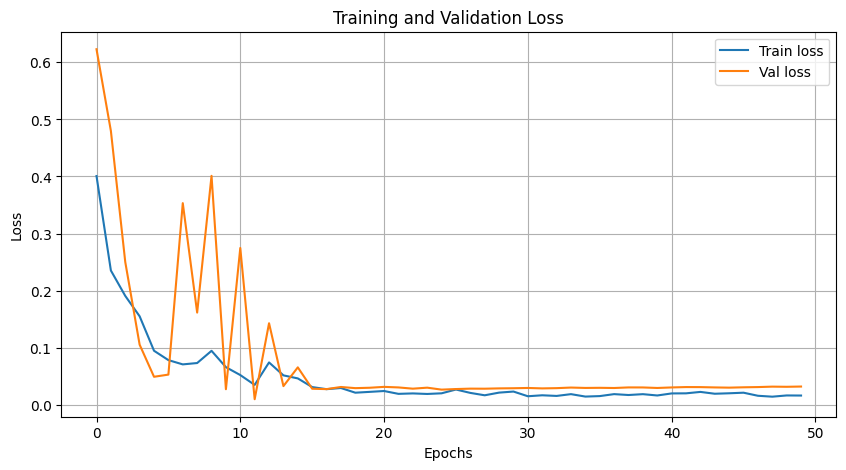

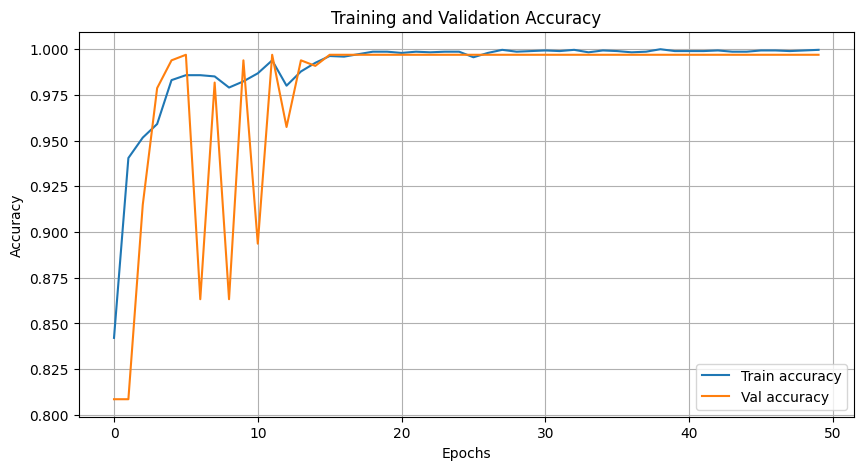

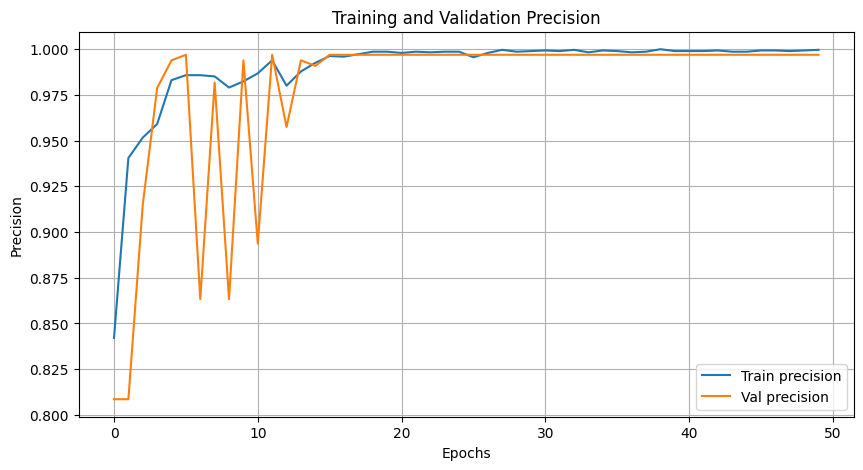

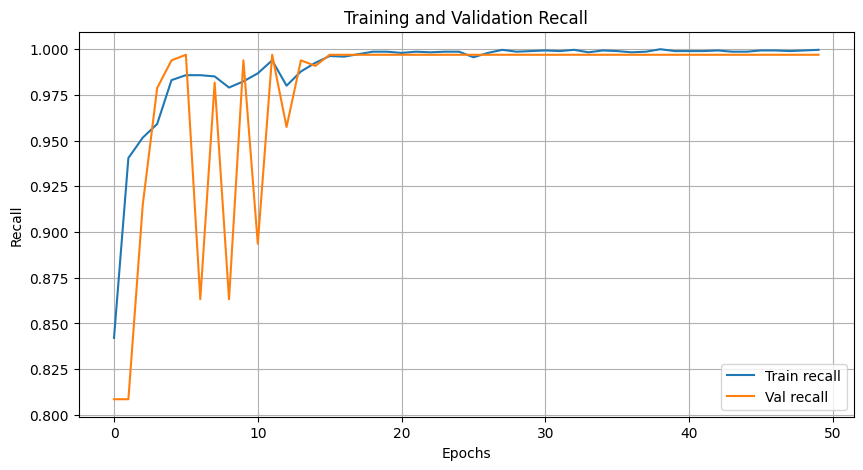

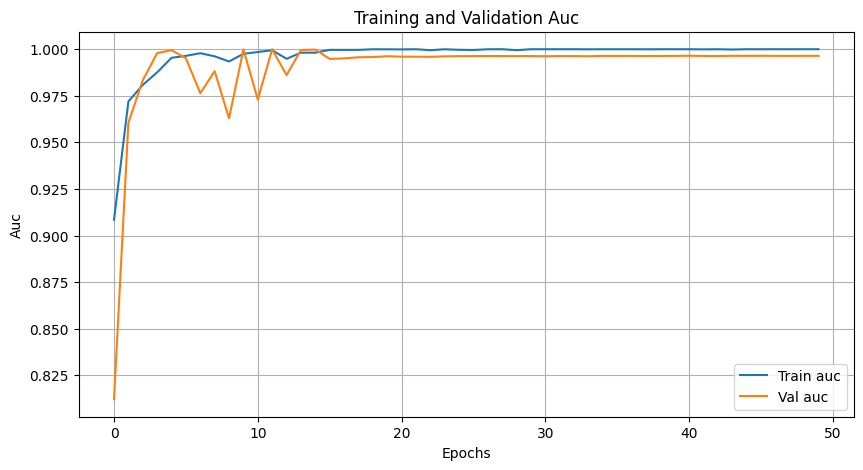

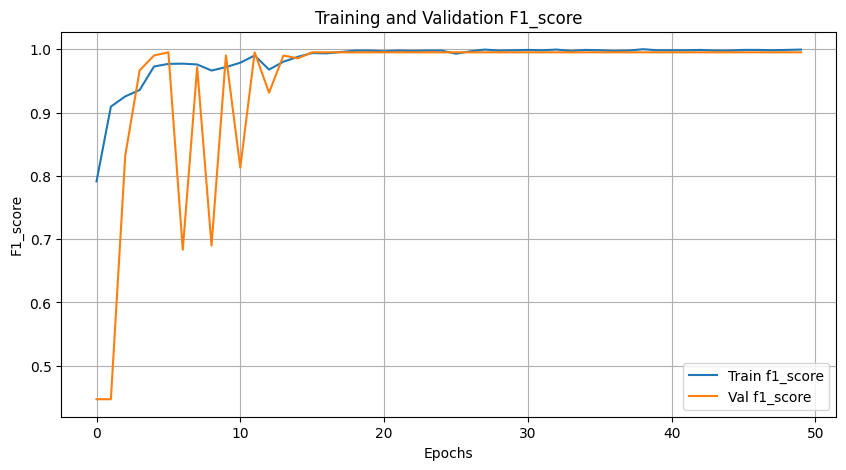

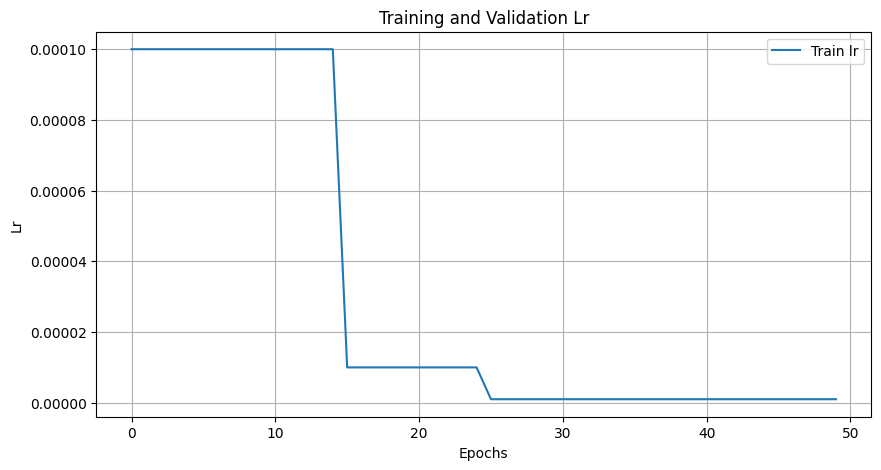

In [18]:
plot_training_history(history)

In [19]:
# Converter o histórico em DataFrame
history = pd.DataFrame(history.history)
# Salvar em CSV
history.to_csv('test_3_train_history.csv', index=False)

In [20]:
model.save('test_3.h5')

/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Avaliar

In [21]:
avaliar_modelo(model, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=11778, TN=8122, FP=17, FN=513
Accuracy       : 0.9741
Precision      : 0.9986
Recall         : 0.9583
F1-Score       : 0.9780
AUC            : 0.9996
Binary Loss    : 0.1052
FDR (Fire Detection Rate)      : 95.83 %
EWR (Error Warning Rate)       : 2.59 %
Confusion Matrix:
[[ 8122    17]
 [  513 11778]]


{'TP': 11778,
 'TN': 8122,
 'FP': 17,
 'FN': 513,
 'accuracy': 0.9740577581987273,
 'precision': 0.9985587113183553,
 'recall': 0.9582621430314865,
 'f1_score': 0.9779955160674251,
 'auc': 0.999571416214504,
 'loss': 0.10520601331401237,
 'fdr': 95.82621430314865,
 'ewr': 2.594224180127264,
 'confusion_matrix': array([[ 8122,    17],
        [  513, 11778]])}

In [22]:
model_best = load_model('test_3_best.h5')

In [23]:
avaliar_modelo(model_best, test_ds)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=12248, TN=8110, FP=29, FN=43
Accuracy       : 0.9965
Precision      : 0.9976
Recall         : 0.9965
F1-Score       : 0.9971
AUC            : 0.9994
Binary Loss    : 0.0185
FDR (Fire Detection Rate)      : 99.65 %
EWR (Error Warning Rate)       : 0.35 %
Confusion Matrix:
[[ 8110    29]
 [   43 12248]]


{'TP': 12248,
 'TN': 8110,
 'FP': 29,
 'FN': 43,
 'accuracy': 0.9964757709251101,
 'precision': 0.9976378594119084,
 'recall': 0.9965015051663819,
 'f1_score': 0.9970693585151417,
 'auc': 0.9994302276763142,
 'loss': 0.018536434269818877,
 'fdr': 99.65015051663819,
 'ewr': 0.3524229074889868,
 'confusion_matrix': array([[ 8110,    29],
        [   43, 12248]])}

## Testar no FLAME train

In [24]:
data = pd.read_csv("../Datasets/FLAME_train.csv")
image_paths_flame_train = data['image_path'].values
labels_flame_train = data['label_bi'].values

test_ds_flame_train = tf.data.Dataset.from_tensor_slices((image_paths_flame_train, labels_flame_train))
test_ds_flame_train = test_ds_flame_train.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_train, name="FLAME train")

📊 FLAME TRAIN -> Total de imagens: 39375
  Classe 0 (Sem fogo): 14357 imagens (36.46%)
  Classe 1 (Fogo): 25018 imagens (63.54%)
----------------------------------------


In [25]:
avaliar_modelo(model, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1654, TN=2316, FP=12041, FN=23364
Accuracy       : 0.1008
Precision      : 0.1208
Recall         : 0.0661
F1-Score       : 0.0854
AUC            : 0.0742
Binary Loss    : 8.9436
FDR (Fire Detection Rate)      : 6.61 %
EWR (Error Warning Rate)       : 89.92 %
Confusion Matrix:
[[ 2316 12041]
 [23364  1654]]


{'TP': 1654,
 'TN': 2316,
 'FP': 12041,
 'FN': 23364,
 'accuracy': 0.10082539682539683,
 'precision': 0.12077400511135451,
 'recall': 0.06611239907266768,
 'f1_score': 0.0854493322656472,
 'auc': 0.07423620376069356,
 'loss': 8.943630045608094,
 'fdr': 6.611239907266768,
 'ewr': 89.91746031746032,
 'confusion_matrix': array([[ 2316, 12041],
        [23364,  1654]])}

In [26]:
avaliar_modelo(model_best, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=3363, TN=1921, FP=12436, FN=21655
Accuracy       : 0.1342
Precision      : 0.2129
Recall         : 0.1344
F1-Score       : 0.1648
AUC            : 0.0840
Binary Loss    : 6.7210
FDR (Fire Detection Rate)      : 13.44 %
EWR (Error Warning Rate)       : 86.58 %
Confusion Matrix:
[[ 1921 12436]
 [21655  3363]]


{'TP': 3363,
 'TN': 1921,
 'FP': 12436,
 'FN': 21655,
 'accuracy': 0.1341968253968254,
 'precision': 0.21286157351731122,
 'recall': 0.1344232152849948,
 'f1_score': 0.16478428105936252,
 'auc': 0.08400837376054206,
 'loss': 6.721026212700277,
 'fdr': 13.442321528499479,
 'ewr': 86.58031746031746,
 'confusion_matrix': array([[ 1921, 12436],
        [21655,  3363]])}

## Testar no FLAME test

In [27]:
data = pd.read_csv("../Datasets/FLAME_test.csv")
image_paths_flame_test = data['image_path'].values
labels_flame_test = data['label_bi'].values

test_ds_flame_test = tf.data.Dataset.from_tensor_slices((image_paths_flame_test, labels_flame_test))
test_ds_flame_test = test_ds_flame_test.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_test, name="FLAME test")

📊 FLAME TEST -> Total de imagens: 8617
  Classe 0 (Sem fogo): 3480 imagens (40.39%)
  Classe 1 (Fogo): 5137 imagens (59.61%)
----------------------------------------


In [28]:
avaliar_modelo(model, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=376, TN=2288, FP=1192, FN=4761
Accuracy       : 0.3092
Precision      : 0.2398
Recall         : 0.0732
F1-Score       : 0.1122
AUC            : 0.2832
Binary Loss    : 5.9472
FDR (Fire Detection Rate)      : 7.32 %
EWR (Error Warning Rate)       : 69.08 %
Confusion Matrix:
[[2288 1192]
 [4761  376]]


{'TP': 376,
 'TN': 2288,
 'FP': 1192,
 'FN': 4761,
 'accuracy': 0.30915631890449113,
 'precision': 0.23979591836734693,
 'recall': 0.07319447148140938,
 'f1_score': 0.11215510812826247,
 'auc': 0.2832363638601178,
 'loss': 5.947185768360992,
 'fdr': 7.319447148140938,
 'ewr': 69.08436810955088,
 'confusion_matrix': array([[2288, 1192],
        [4761,  376]])}

In [29]:
avaliar_modelo(model_best, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1167, TN=1758, FP=1722, FN=3970
Accuracy       : 0.3394
Precision      : 0.4039
Recall         : 0.2272
F1-Score       : 0.2908
AUC            : 0.3362
Binary Loss    : 3.7542
FDR (Fire Detection Rate)      : 22.72 %
EWR (Error Warning Rate)       : 66.06 %
Confusion Matrix:
[[1758 1722]
 [3970 1167]]


{'TP': 1167,
 'TN': 1758,
 'FP': 1722,
 'FN': 3970,
 'accuracy': 0.33944528258094464,
 'precision': 0.4039460020768432,
 'recall': 0.2271753941989488,
 'f1_score': 0.2908048841265886,
 'auc': 0.33615951660144233,
 'loss': 3.7541724251049815,
 'fdr': 22.71753941989488,
 'ewr': 66.05547174190554,
 'confusion_matrix': array([[1758, 1722],
        [3970, 1167]])}

## Testar no UAVS Raw Images

In [30]:
data = pd.read_csv("../Datasets/UAVS_RawImages.csv")
image_paths_uavs_raw = data['image_path'].values
labels_uavs_raw = data['label_bi'].values

test_ds_uavs_raw = tf.data.Dataset.from_tensor_slices((image_paths_uavs_raw, labels_uavs_raw))
test_ds_uavs_raw = test_ds_uavs_raw.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_raw, name="UAVS Raw Images")

📊 UAVS RAW IMAGES -> Total de imagens: 1643
  Classe 0 (Sem fogo): 498 imagens (30.31%)
  Classe 1 (Fogo): 1145 imagens (69.69%)
----------------------------------------


In [31]:
avaliar_modelo(model, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1145, TN=498, FP=0, FN=0
Accuracy       : 1.0000
Precision      : 1.0000
Recall         : 1.0000
F1-Score       : 1.0000
AUC            : 1.0000
Binary Loss    : 0.0023
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 0.00 %
Confusion Matrix:
[[ 498    0]
 [   0 1145]]


{'TP': 1145,
 'TN': 498,
 'FP': 0,
 'FN': 0,
 'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0,
 'auc': 1.0,
 'loss': 0.002343884934849774,
 'fdr': 100.0,
 'ewr': 0.0,
 'confusion_matrix': array([[ 498,    0],
        [   0, 1145]])}

In [32]:
avaliar_modelo(model_best, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1145, TN=498, FP=0, FN=0
Accuracy       : 1.0000
Precision      : 1.0000
Recall         : 1.0000
F1-Score       : 1.0000
AUC            : 1.0000
Binary Loss    : 0.0043
FDR (Fire Detection Rate)      : 100.00 %
EWR (Error Warning Rate)       : 0.00 %
Confusion Matrix:
[[ 498    0]
 [   0 1145]]


{'TP': 1145,
 'TN': 498,
 'FP': 0,
 'FN': 0,
 'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0,
 'auc': 1.0,
 'loss': 0.004279727943221275,
 'fdr': 100.0,
 'ewr': 0.0,
 'confusion_matrix': array([[ 498,    0],
        [   0, 1145]])}

## Testar no UAVS Augmented Images

In [33]:
data = pd.read_csv("../Datasets/UAVS_AugmentedImages.csv")
image_paths_uavs_aug = data['image_path'].values
labels_uavs_aug = data['label_bi'].values

test_ds_uavs_aug = tf.data.Dataset.from_tensor_slices((image_paths_uavs_aug, labels_uavs_aug))
test_ds_uavs_aug = test_ds_uavs_aug.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_aug, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 15560
  Classe 0 (Sem fogo): 7780 imagens (50.00%)
  Classe 1 (Fogo): 7780 imagens (50.00%)
----------------------------------------


In [34]:
avaliar_modelo(model, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7337, TN=7766, FP=14, FN=443
Accuracy       : 0.9706
Precision      : 0.9981
Recall         : 0.9431
F1-Score       : 0.9698
AUC            : 0.9995
Binary Loss    : 0.1190
FDR (Fire Detection Rate)      : 94.31 %
EWR (Error Warning Rate)       : 2.94 %
Confusion Matrix:
[[7766   14]
 [ 443 7337]]


{'TP': 7337,
 'TN': 7766,
 'FP': 14,
 'FN': 443,
 'accuracy': 0.9706298200514138,
 'precision': 0.9980954972112638,
 'recall': 0.9430591259640103,
 'f1_score': 0.9697971052805499,
 'auc': 0.9995096351464767,
 'loss': 0.1189702290987841,
 'fdr': 94.30591259640103,
 'ewr': 2.937017994858612,
 'confusion_matrix': array([[7766,   14],
        [ 443, 7337]])}

In [35]:
avaliar_modelo(model_best, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=7745, TN=7765, FP=15, FN=35
Accuracy       : 0.9968
Precision      : 0.9981
Recall         : 0.9955
F1-Score       : 0.9968
AUC            : 0.9993
Binary Loss    : 0.0182
FDR (Fire Detection Rate)      : 99.55 %
EWR (Error Warning Rate)       : 0.32 %
Confusion Matrix:
[[7765   15]
 [  35 7745]]


{'TP': 7745,
 'TN': 7765,
 'FP': 15,
 'FN': 35,
 'accuracy': 0.9967866323907455,
 'precision': 0.9980670103092784,
 'recall': 0.9955012853470437,
 'f1_score': 0.9967824967824968,
 'auc': 0.9992751006139267,
 'loss': 0.01820526418652675,
 'fdr': 99.55012853470437,
 'ewr': 0.3213367609254499,
 'confusion_matrix': array([[7765,   15],
        [  35, 7745]])}

## Testar no FireMan

In [36]:
data = pd.read_csv("../Datasets/FireMan_test.csv")
image_paths_fireman = data['image_path'].values
labels_fireman = data['label_bi'].values

test_ds_fireman = tf.data.Dataset.from_tensor_slices((image_paths_fireman, labels_fireman))
test_ds_fireman = test_ds_fireman.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_fireman, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 589
  Classe 0 (Sem fogo): 33 imagens (5.60%)
  Classe 1 (Fogo): 556 imagens (94.40%)
----------------------------------------


In [37]:
avaliar_modelo(model, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=493, TN=33, FP=0, FN=63
Accuracy       : 0.8930
Precision      : 1.0000
Recall         : 0.8867
F1-Score       : 0.9399
AUC            : 1.0000
Binary Loss    : 0.4143
FDR (Fire Detection Rate)      : 88.67 %
EWR (Error Warning Rate)       : 10.70 %
Confusion Matrix:
[[ 33   0]
 [ 63 493]]


{'TP': 493,
 'TN': 33,
 'FP': 0,
 'FN': 63,
 'accuracy': 0.8930390492359932,
 'precision': 1.0,
 'recall': 0.8866906474820144,
 'f1_score': 0.9399428026692088,
 'auc': 1.0,
 'loss': 0.41433297928904594,
 'fdr': 88.66906474820144,
 'ewr': 10.69609507640068,
 'confusion_matrix': array([[ 33,   0],
        [ 63, 493]])}

In [38]:
avaliar_modelo(model_best, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=550, TN=33, FP=0, FN=6
Accuracy       : 0.9898
Precision      : 1.0000
Recall         : 0.9892
F1-Score       : 0.9946
AUC            : 0.9964
Binary Loss    : 0.0459
FDR (Fire Detection Rate)      : 98.92 %
EWR (Error Warning Rate)       : 1.02 %
Confusion Matrix:
[[ 33   0]
 [  6 550]]


{'TP': 550,
 'TN': 33,
 'FP': 0,
 'FN': 6,
 'accuracy': 0.9898132427843803,
 'precision': 1.0,
 'recall': 0.9892086330935251,
 'f1_score': 0.9945750452079565,
 'auc': 0.9964028776978417,
 'loss': 0.045926124975994444,
 'fdr': 98.92086330935251,
 'ewr': 1.0186757215619695,
 'confusion_matrix': array([[ 33,   0],
        [  6, 550]])}